In [1]:
%%capture state

from __future__ import division
from __future__ import print_function

import sys, os
sys.path.append('./src/')

import tensorflow as tf
import numpy as np

from influence.neural_network import NeuralNetwork
from influence.cnn import CNN
import influence.util as util

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#Seed used for all calculations of training and test point indices 
SEED = 14

In [2]:
## Visualization of samples
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def visualize(image):
    plt.figure(figsize=(1, 1))
    if image.shape[-1] == 1:
        # image is in black and white
        image = image[:, :, 0]
        plt.imshow(image, cmap='Greys')
    else:
        # image is in color
        plt.imshow(image)
    plt.axis('off')
    plt.show()

#Normalize rows of a given matrix
def normalize(matrix):
    matrix_nm = np.zeros_like(matrix)
    for i in range(matrix.shape[0]):
        matrix_nm[i] = matrix[i]/np.linalg.norm(matrix[i]) 
    return matrix_nm

In [3]:
#Load model from disk
model_name = 'MNIST'
model_save_path = './trained_models/' + model_name + '-model.json'
weights_save_path = './trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='mnist')
epochs = 20
model.train(epochs=epochs)
model.save_model(model_save_path, weights_save_path)    

Train on 60000 samples, validate on 5000 samples
Epoch 1/20
60000/60000 [==============================] - 7s 110us/step - loss: 0.2564 - acc: 0.9221 - val_loss: 0.0697 - val_acc: 0.9784
Epoch 2/20
60000/60000 [==============================] - 6s 97us/step - loss: 0.0928 - acc: 0.9728 - val_loss: 0.0443 - val_acc: 0.9854
Epoch 3/20
60000/60000 [==============================] - 6s 97us/step - loss: 0.0718 - acc: 0.9796 - val_loss: 0.0400 - val_acc: 0.9874
Epoch 4/20
60000/60000 [==============================] - 6s 97us/step - loss: 0.0577 - acc: 0.9832 - val_loss: 0.0330 - val_acc: 0.9892
Epoch 5/20
60000/60000 [==============================] - 6s 98us/step - loss: 0.0521 - acc: 0.9849 - val_loss: 0.0302 - val_acc: 0.9902
Epoch 6/20
60000/60000 [==============================] - 6s 97us/step - loss: 0.0448 - acc: 0.9866 - val_loss: 0.0293 - val_acc: 0.9908
Epoch 7/20
60000/60000 [==============================] - 6s 97us/step - loss: 0.0396 - acc: 0.9882 - val_loss: 0.0319 - val_acc

In [4]:
#Get training samples
num_train_samples = 10000
data_indices = model.gen_rand_indices(low=0, high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

In [5]:
num_test_samples_per_class = 100
num_test_samples = 10*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

#Get Regular, Noisy, FGSM, BIM, and CW test points
reg_data = model.test_data[test_indices]
noisy_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='Noisy')
fgsm_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='FGSM')
bim_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM', iterations=10)
cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='CW', targeted=False)

/root/notebook/cleverhans/cleverhans/src/cleverhans/cleverhans/utils_keras.py:144: UserWarning: Please update your version to keras >= 2.1.3; support for earlier keras versions will be dropped on 2018-07-22
  "Please update your version to keras >= 2.1.3; "
/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
#Whitebox CW Attack
#First get guide images
guide_indices = list()
np.random.seed(SEED)
#Generate guide images for modified CW attacks
for idx in test_indices:
    label = np.argmax(model.test_labels[idx])
    #Add 1 to the label mod 10 to get a target label
    mod_label = (label + 1) % 10
    #Get a test point with the target label
    guide_imgs_indices = np.where(model.train_labels[:,mod_label] == 1)[0]
    #Choose a guide image
    guide_img_idx = np.random.choice(guide_imgs_indices, 1)[0]
    guide_indices.append(guide_img_idx)


#1 Phase Attack
p1_cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices], use_cos_norm_reg=True)

#2 Phase Attack
#Phase 1: Generate targeted adversarial images
tar_cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, use_cos_norm_reg=False)
#Phase 2: Optimize for higher cosine sim and smaller norm
p2_cw_data = model.generate_perturbed_data(tar_cw_data, model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices], use_cos_norm_reg=True)

Loss: 1912.61243, Cos: -1.00000, Norm: 165.09697
Loss: 1882.78796, Cos: -1.00000, Norm: 162.93600
Loss: 1898.96924, Cos: -1.00000, Norm: 165.45232
Loss: 1849.03223, Cos: -1.00000, Norm: 161.42699
Loss: 1823.68640, Cos: -1.00000, Norm: 159.93147
Loss: 1797.89490, Cos: -1.00000, Norm: 158.44009
Loss: 1781.34912, Cos: -1.00000, Norm: 157.91766
Loss: 1733.59241, Cos: -1.00000, Norm: 154.32932
Loss: 1705.68420, Cos: -1.00000, Norm: 152.78693
Loss: 1666.25610, Cos: -1.00000, Norm: 150.15187
Loss: 1595.54382, Cos: -1.00000, Norm: 144.42281
Loss: 1497.92444, Cos: -1.00000, Norm: 135.98865
Loss: 1483.33252, Cos: -1.00000, Norm: 135.88306
Loss: 1402.33569, Cos: -1.00000, Norm: 129.19328
Loss: 1262.56079, Cos: -1.00000, Norm: 116.57172
Loss: 1060.97803, Cos: -1.00000, Norm: 97.69473
Loss: 790.51117, Cos: -1.00000, Norm: 71.69712
Loss: 610.92102, Cos: -1.00000, Norm: 54.63784
Loss: 408.53305, Cos: -1.00000, Norm: 35.10161
Loss: 320.67123, Cos: -1.00000, Norm: 26.73573
Loss: 236.75479, Cos: -1.0000

Loss: 100.40709, Cos: -1.00000, Norm: 3.25807
Loss: 99.68343, Cos: -1.00000, Norm: 3.22471
Loss: 98.82486, Cos: -1.00000, Norm: 3.17511
Loss: 146.45364, Cos: -1.00000, Norm: 7.98429
Loss: 143.94160, Cos: -1.00000, Norm: 7.78538
Loss: 165.41977, Cos: -1.00000, Norm: 9.95730
Loss: 1748.11255, Cos: -1.00000, Norm: 146.38728
Loss: 1720.26050, Cos: -1.00000, Norm: 144.18008
Loss: 1697.46118, Cos: -1.00000, Norm: 142.45682
Loss: 1690.98132, Cos: -1.00000, Norm: 142.44093
Loss: 1666.86157, Cos: -1.00000, Norm: 140.71927
Loss: 1653.07776, Cos: -1.00000, Norm: 140.06799
Loss: 1633.00427, Cos: -1.00000, Norm: 138.83540
Loss: 1609.24109, Cos: -1.00000, Norm: 137.24809
Loss: 1558.28271, Cos: -1.00000, Norm: 132.96422
Loss: 1468.99731, Cos: -1.00000, Norm: 124.87262
Loss: 1438.38269, Cos: -1.00000, Norm: 122.74442
Loss: 1394.64575, Cos: -1.00000, Norm: 119.36302
Loss: 1363.12256, Cos: -1.00000, Norm: 117.27090
Loss: 1316.38330, Cos: -1.00000, Norm: 113.73573
Loss: 1283.06091, Cos: -1.00000, Norm: 1

Loss: 343.49561, Cos: -1.00000, Norm: 22.79915
Loss: 347.91342, Cos: -1.00000, Norm: 23.34159
Loss: 332.91235, Cos: -1.00000, Norm: 22.06362
Loss: 310.77798, Cos: -1.00000, Norm: 20.14265
Loss: 293.31958, Cos: -1.00000, Norm: 18.72601
Loss: 292.98376, Cos: -1.00000, Norm: 19.08934
Loss: 278.93118, Cos: -1.00000, Norm: 17.94187
Loss: 276.59180, Cos: -1.00000, Norm: 17.77435
Loss: 267.41629, Cos: -1.00000, Norm: 16.92370
Loss: 259.98846, Cos: -1.00000, Norm: 16.11469
Loss: 237.73798, Cos: -1.00000, Norm: 13.82613
Loss: 215.67535, Cos: -1.00000, Norm: 11.56027
Loss: 190.87750, Cos: -1.00000, Norm: 9.02452
Loss: 168.43042, Cos: -1.00000, Norm: 6.72886
Loss: 151.95102, Cos: -1.00000, Norm: 5.03820
Loss: 138.35980, Cos: -1.00000, Norm: 3.64548
Loss: 128.41495, Cos: -1.00000, Norm: 2.62775
Loss: 121.70181, Cos: -1.00000, Norm: 1.94358
Loss: 116.51958, Cos: -1.00000, Norm: 1.42153
Loss: 112.74522, Cos: -1.00000, Norm: 1.04800
Loss: 110.11492, Cos: -1.00000, Norm: 0.79531
Loss: 108.15800, Cos: 

Loss: 923.54187, Cos: -1.00000, Norm: 85.93259
Loss: 793.68939, Cos: -1.00000, Norm: 73.93887
Loss: 669.27142, Cos: -1.00000, Norm: 62.48220
Loss: 459.71875, Cos: -1.00000, Norm: 42.43288
Loss: 329.17654, Cos: -1.00000, Norm: 30.20288
Loss: 251.46413, Cos: -1.00000, Norm: 22.31701
Loss: 196.44029, Cos: -1.00000, Norm: 16.64954
Loss: 152.14557, Cos: -1.00000, Norm: 12.06902
Loss: 123.33221, Cos: -1.00000, Norm: 9.04697
Loss: 101.50249, Cos: -1.00000, Norm: 6.73311
Loss: 83.11852, Cos: -1.00000, Norm: 4.76988
Loss: 64.60609, Cos: -1.00000, Norm: 2.79728
Loss: 55.37953, Cos: -1.00000, Norm: 1.75570
Loss: 50.30159, Cos: -1.00000, Norm: 1.13237
Loss: 48.37411, Cos: -1.00000, Norm: 0.82865
Loss: 47.42326, Cos: -1.00000, Norm: 0.62874
Loss: 46.94571, Cos: -1.00000, Norm: 0.48345
Loss: 46.84156, Cos: -1.00000, Norm: 0.38361
Loss: 47.01517, Cos: -1.00000, Norm: 0.32022
Loss: 47.26639, Cos: -1.00000, Norm: 0.27332
Loss: 47.63137, Cos: -1.00000, Norm: 0.24628
Loss: 47.90238, Cos: -1.00000, Norm: 

Loss: 200.08090, Cos: -1.00000, Norm: 10.29171
Loss: 181.20894, Cos: -1.00000, Norm: 8.40113
Loss: 165.79330, Cos: -1.00000, Norm: 6.86172
Loss: 150.87161, Cos: -1.00000, Norm: 5.37346
Loss: 139.53323, Cos: -1.00000, Norm: 4.24059
Loss: 130.40778, Cos: -1.00000, Norm: 3.32159
Loss: 124.67648, Cos: -1.00000, Norm: 2.72943
Loss: 119.95583, Cos: -1.00000, Norm: 2.21935
Loss: 115.70299, Cos: -1.00000, Norm: 1.73513
Loss: 112.19995, Cos: -1.00000, Norm: 1.30644
Loss: 109.87321, Cos: -1.00000, Norm: 0.98238
Loss: 108.42198, Cos: -1.00000, Norm: 0.74239
Loss: 107.58297, Cos: -1.00000, Norm: 0.57195
Loss: 107.06952, Cos: -1.00000, Norm: 0.44880
Loss: 106.51485, Cos: -1.00000, Norm: 0.33666
Loss: 106.17937, Cos: -1.00000, Norm: 0.26148
Loss: 105.80076, Cos: -1.00000, Norm: 0.19720
Loss: 105.50088, Cos: -1.00000, Norm: 0.15880
Loss: 105.09891, Cos: -1.00000, Norm: 0.13060
Loss: 104.61098, Cos: -1.00000, Norm: 0.11387
Loss: 104.00633, Cos: -1.00000, Norm: 0.10278
Loss: 103.30052, Cos: -1.00000, N

Loss: 64.39185, Cos: -1.00000, Norm: 0.17347
Loss: 64.56681, Cos: -1.00000, Norm: 0.14408
Loss: 64.64354, Cos: -1.00000, Norm: 0.12163
Loss: 64.61382, Cos: -1.00000, Norm: 0.10865
Loss: 64.43025, Cos: -1.00000, Norm: 0.09953
Loss: 64.12075, Cos: -1.00000, Norm: 0.09448
Loss: 63.71219, Cos: -1.00000, Norm: 0.09223
Loss: 63.23820, Cos: -1.00000, Norm: 0.09191
Loss: 62.71352, Cos: -1.00000, Norm: 0.09084
Loss: 62.19105, Cos: -1.00000, Norm: 0.09218
Loss: 61.69907, Cos: -1.00000, Norm: 0.09501
Loss: 61.26198, Cos: -1.00000, Norm: 0.09999
Loss: 60.86975, Cos: -1.00000, Norm: 0.10539
Loss: 60.53175, Cos: -1.00000, Norm: 0.11123
Loss: 60.24127, Cos: -1.00000, Norm: 0.11695
Loss: 59.98151, Cos: -1.00000, Norm: 0.12106
Loss: 59.75066, Cos: -1.00000, Norm: 0.12389
Loss: 59.48363, Cos: -1.00000, Norm: 0.11896
Loss: 59.27472, Cos: -1.00000, Norm: 0.11570
Loss: 59.08542, Cos: -1.00000, Norm: 0.11199
Loss: 58.90367, Cos: -1.00000, Norm: 0.11105
Loss: 58.71877, Cos: -1.00000, Norm: 0.11090
Loss: 58.5

Loss: 396.80731, Cos: -1.00000, Norm: 31.75291
Loss: 243.48938, Cos: -1.00000, Norm: 16.80117
Loss: 190.74178, Cos: -1.00000, Norm: 11.58329
Loss: 180.04105, Cos: -1.00000, Norm: 10.29693
Loss: 183.95241, Cos: -1.00000, Norm: 10.19238
Loss: 190.15959, Cos: -1.00000, Norm: 10.35099
Loss: 193.88757, Cos: -1.00000, Norm: 10.32157
Loss: 194.58047, Cos: -1.00000, Norm: 10.05048
Loss: 206.39743, Cos: -1.00000, Norm: 10.95335
Loss: 206.38918, Cos: -1.00000, Norm: 10.72780
Loss: 206.01730, Cos: -1.00000, Norm: 10.51004
Loss: 207.03091, Cos: -1.00000, Norm: 10.46575
Loss: 207.70755, Cos: -1.00000, Norm: 10.42566
Loss: 205.01923, Cos: -1.00000, Norm: 10.07829
Loss: 203.86272, Cos: -1.00000, Norm: 9.90574
Loss: 203.59296, Cos: -1.00000, Norm: 9.84269
Loss: 212.21701, Cos: -1.00000, Norm: 10.69543
Loss: 207.18466, Cos: -1.00000, Norm: 10.23533
Loss: 1867.87781, Cos: -1.00000, Norm: 165.07715
Loss: 1847.00964, Cos: -1.00000, Norm: 163.74135
Loss: 1792.92407, Cos: -1.00000, Norm: 159.10719
Loss: 177

Loss: 80.61453, Cos: -1.00000, Norm: 0.03374
Loss: 80.30111, Cos: -1.00000, Norm: 0.03633
Loss: 79.97897, Cos: -1.00000, Norm: 0.03788
Loss: 79.65321, Cos: -1.00000, Norm: 0.03891
Loss: 79.32847, Cos: -1.00000, Norm: 0.03971
Loss: 79.00251, Cos: -1.00000, Norm: 0.04043
Loss: 78.67946, Cos: -1.00000, Norm: 0.04112
Loss: 78.36151, Cos: -1.00000, Norm: 0.04189
Loss: 78.04588, Cos: -1.00000, Norm: 0.04268
Loss: 77.73395, Cos: -1.00000, Norm: 0.04306
Loss: 77.43219, Cos: -1.00000, Norm: 0.04333
Loss: 77.13365, Cos: -1.00000, Norm: 0.04271
Loss: 76.84473, Cos: -1.00000, Norm: 0.04186
Loss: 76.56250, Cos: -1.00000, Norm: 0.04061
Loss: 76.28944, Cos: -1.00000, Norm: 0.03926
Loss: 76.02412, Cos: -1.00000, Norm: 0.03789
Loss: 75.76730, Cos: -1.00000, Norm: 0.03690
Loss: 75.51694, Cos: -1.00000, Norm: 0.03620
Loss: 75.27289, Cos: -1.00000, Norm: 0.03596
Loss: 75.02748, Cos: -1.00000, Norm: 0.03546
Loss: 74.78994, Cos: -1.00000, Norm: 0.03586
Loss: 74.55602, Cos: -1.00000, Norm: 0.03671
Loss: 74.3

Loss: 63.44678, Cos: -1.00000, Norm: 0.04367
Loss: 63.84297, Cos: -1.00000, Norm: 0.02798
Loss: 64.09071, Cos: -1.00000, Norm: 0.01852
Loss: 64.15191, Cos: -1.00000, Norm: 0.01370
Loss: 64.01489, Cos: -1.00000, Norm: 0.01125
Loss: 63.71121, Cos: -1.00000, Norm: 0.01077
Loss: 63.27151, Cos: -1.00000, Norm: 0.01050
Loss: 62.75462, Cos: -1.00000, Norm: 0.01169
Loss: 62.20003, Cos: -1.00000, Norm: 0.01391
Loss: 61.64886, Cos: -1.00000, Norm: 0.01763
Loss: 61.12693, Cos: -1.00000, Norm: 0.02269
Loss: 60.64449, Cos: -1.00000, Norm: 0.02843
Loss: 60.23354, Cos: -1.00000, Norm: 0.03729
Loss: 59.88312, Cos: -1.00000, Norm: 0.04772
Loss: 59.58495, Cos: -1.00000, Norm: 0.05883
Loss: 59.32843, Cos: -1.00000, Norm: 0.06957
Loss: 59.10046, Cos: -1.00000, Norm: 0.07871
Loss: 58.87812, Cos: -1.00000, Norm: 0.08365
Loss: 58.65818, Cos: -1.00000, Norm: 0.08492
Loss: 58.44798, Cos: -1.00000, Norm: 0.08308
Loss: 58.26148, Cos: -1.00000, Norm: 0.07985
Loss: 58.08832, Cos: -1.00000, Norm: 0.07638
Loss: 57.9

Loss: 205.95593, Cos: -1.00000, Norm: 12.32240
Loss: 202.84055, Cos: -1.00000, Norm: 11.95591
Loss: 201.08675, Cos: -1.00000, Norm: 11.73421
Loss: 1904.53833, Cos: -1.00000, Norm: 163.28300
Loss: 1865.27783, Cos: -1.00000, Norm: 160.15988
Loss: 1822.31030, Cos: -1.00000, Norm: 156.71054
Loss: 1783.88428, Cos: -1.00000, Norm: 153.75305
Loss: 1728.58911, Cos: -1.00000, Norm: 149.14781
Loss: 1690.99609, Cos: -1.00000, Norm: 146.34610
Loss: 1681.71680, Cos: -1.00000, Norm: 146.39549
Loss: 1626.96936, Cos: -1.00000, Norm: 141.90965
Loss: 1595.26208, Cos: -1.00000, Norm: 139.74921
Loss: 1529.44666, Cos: -1.00000, Norm: 134.19531
Loss: 1485.00842, Cos: -1.00000, Norm: 130.78616
Loss: 1443.60608, Cos: -1.00000, Norm: 127.71567
Loss: 1334.93848, Cos: -1.00000, Norm: 117.95101
Loss: 1295.15125, Cos: -1.00000, Norm: 115.08805
Loss: 1240.48730, Cos: -1.00000, Norm: 110.80379
Loss: 1092.37378, Cos: -1.00000, Norm: 97.22556
Loss: 925.11664, Cos: -1.00000, Norm: 81.71873
Loss: 699.02795, Cos: -1.0000

Loss: 85.14265, Cos: -1.00000, Norm: 0.14226
Loss: 84.35143, Cos: -1.00000, Norm: 0.14170
Loss: 83.59509, Cos: -1.00000, Norm: 0.14140
Loss: 82.89343, Cos: -1.00000, Norm: 0.14258
Loss: 82.26231, Cos: -1.00000, Norm: 0.14763
Loss: 81.66501, Cos: -1.00000, Norm: 0.15207
Loss: 81.11604, Cos: -1.00000, Norm: 0.15568
Loss: 80.61577, Cos: -1.00000, Norm: 0.16019
Loss: 80.13625, Cos: -1.00000, Norm: 0.16381
Loss: 79.72352, Cos: -1.00000, Norm: 0.16980
Loss: 79.37270, Cos: -1.00000, Norm: 0.17761
Loss: 79.03335, Cos: -1.00000, Norm: 0.18348
Loss: 78.71325, Cos: -1.00000, Norm: 0.18885
Loss: 78.40429, Cos: -1.00000, Norm: 0.19390
Loss: 78.09824, Cos: -1.00000, Norm: 0.19844
Loss: 77.77018, Cos: -1.00000, Norm: 0.19967
Loss: 77.48735, Cos: -1.00000, Norm: 0.20299
Loss: 77.22128, Cos: -1.00000, Norm: 0.20516
Loss: 77.00164, Cos: -1.00000, Norm: 0.21034
Loss: 76.71275, Cos: -1.00000, Norm: 0.20820
Loss: 76.43375, Cos: -1.00000, Norm: 0.20943
Loss: 76.15109, Cos: -1.00000, Norm: 0.21029
Loss: 75.9

Loss: 228.15363, Cos: -1.00000, Norm: 17.18076
Loss: 1359.12012, Cos: -1.00001, Norm: 116.58430
Loss: 1313.57336, Cos: -1.00001, Norm: 113.53246
Loss: 1267.97083, Cos: -1.00001, Norm: 110.52264
Loss: 1233.00989, Cos: -1.00001, Norm: 108.59429
Loss: 1174.41162, Cos: -1.00001, Norm: 104.29968
Loss: 1133.54736, Cos: -1.00001, Norm: 101.81327
Loss: 1069.69763, Cos: -1.00001, Norm: 97.04276
Loss: 915.43781, Cos: -1.00001, Norm: 83.20317
Loss: 721.53040, Cos: -1.00000, Norm: 65.25861
Loss: 496.98932, Cos: -1.00000, Norm: 44.08983
Loss: 399.20267, Cos: -1.00000, Norm: 34.24245
Loss: 404.50336, Cos: -1.00000, Norm: 34.59775
Loss: 405.69147, Cos: -1.00000, Norm: 34.59508
Loss: 387.16397, Cos: -1.00000, Norm: 32.61558
Loss: 382.02255, Cos: -1.00000, Norm: 32.00978
Loss: 380.64291, Cos: -1.00000, Norm: 31.82525
Loss: 376.44327, Cos: -1.00000, Norm: 31.41150
Loss: 372.07138, Cos: -1.00000, Norm: 31.01799
Loss: 366.34357, Cos: -1.00000, Norm: 30.51794
Loss: 363.50970, Cos: -1.00000, Norm: 30.32258


Loss: 1450.96924, Cos: -1.00103, Norm: 123.77882
Loss: 1407.88232, Cos: -1.00106, Norm: 120.41932
Loss: 1373.09265, Cos: -1.00106, Norm: 117.89796
Loss: 1334.20520, Cos: -1.00108, Norm: 114.98518
Loss: 1292.41858, Cos: -1.00109, Norm: 111.77970
Loss: 1246.64636, Cos: -1.00111, Norm: 108.19566
Loss: 1203.20801, Cos: -1.00113, Norm: 104.87183
Loss: 1156.39868, Cos: -1.00114, Norm: 101.23356
Loss: 1114.11597, Cos: -1.00113, Norm: 98.08159
Loss: 1033.45764, Cos: -1.00115, Norm: 91.12708
Loss: 958.76019, Cos: -1.00115, Norm: 84.79259
Loss: 860.29565, Cos: -1.00117, Norm: 76.08774
Loss: 628.60687, Cos: -1.00121, Norm: 53.92951
Loss: 475.81561, Cos: -1.00110, Norm: 39.48916
Loss: 359.47443, Cos: -1.00081, Norm: 28.15930
Loss: 328.55066, Cos: -1.00051, Norm: 24.84698
Loss: 311.07495, Cos: -1.00060, Norm: 22.86216
Loss: 296.17096, Cos: -1.00053, Norm: 21.16300
Loss: 287.32135, Cos: -1.00050, Norm: 20.06528
Loss: 285.34708, Cos: -1.00044, Norm: 19.70422
Loss: 270.27176, Cos: -1.00024, Norm: 18.0

Loss: 89.41069, Cos: -1.00000, Norm: 0.02289
Loss: 88.96573, Cos: -1.00000, Norm: 0.02295
Loss: 88.52503, Cos: -1.00000, Norm: 0.02295
Loss: 88.08766, Cos: -1.00000, Norm: 0.02280
Loss: 87.65627, Cos: -1.00000, Norm: 0.02279
Loss: 87.22647, Cos: -1.00000, Norm: 0.02313
Loss: 86.79830, Cos: -1.00000, Norm: 0.02364
Loss: 86.37257, Cos: -1.00000, Norm: 0.02423
Loss: 85.94843, Cos: -1.00000, Norm: 0.02480
Loss: 85.52454, Cos: -1.00000, Norm: 0.02529
Loss: 85.10161, Cos: -1.00000, Norm: 0.02584
Loss: 84.67818, Cos: -1.00000, Norm: 0.02631
Loss: 84.25546, Cos: -1.00000, Norm: 0.02683
Loss: 83.83153, Cos: -1.00000, Norm: 0.02717
Loss: 83.40752, Cos: -1.00000, Norm: 0.02747
Loss: 1584.23169, Cos: -1.00000, Norm: 131.18582
Loss: 1558.36230, Cos: -1.00000, Norm: 129.26137
Loss: 1554.16248, Cos: -1.00000, Norm: 129.51897
Loss: 1504.79602, Cos: -1.00000, Norm: 125.28671
Loss: 1462.53040, Cos: -1.00000, Norm: 121.78721
Loss: 1432.18835, Cos: -1.00000, Norm: 119.56180
Loss: 1391.67505, Cos: -1.00000

Loss: 65.85941, Cos: -1.00000, Norm: 0.13764
Loss: 65.89088, Cos: -1.00000, Norm: 0.11258
Loss: 65.81255, Cos: -1.00000, Norm: 0.09704
Loss: 65.60219, Cos: -1.00000, Norm: 0.08690
Loss: 65.29685, Cos: -1.00000, Norm: 0.08246
Loss: 64.91130, Cos: -1.00000, Norm: 0.08052
Loss: 64.47694, Cos: -1.00000, Norm: 0.08154
Loss: 64.02032, Cos: -1.00000, Norm: 0.08514
Loss: 63.57291, Cos: -1.00000, Norm: 0.09140
Loss: 63.16517, Cos: -1.00000, Norm: 0.09986
Loss: 62.80361, Cos: -1.00000, Norm: 0.10968
Loss: 62.49960, Cos: -1.00000, Norm: 0.12344
Loss: 62.23768, Cos: -1.00000, Norm: 0.13681
Loss: 62.00200, Cos: -1.00000, Norm: 0.14700
Loss: 61.77705, Cos: -1.00000, Norm: 0.15146
Loss: 61.61383, Cos: -1.00000, Norm: 0.15479
Loss: 61.46626, Cos: -1.00000, Norm: 0.15807
Loss: 61.32109, Cos: -1.00000, Norm: 0.16016
Loss: 61.15637, Cos: -1.00000, Norm: 0.16013
Loss: 60.96952, Cos: -1.00000, Norm: 0.15601
Loss: 60.79410, Cos: -1.00000, Norm: 0.14983
Loss: 60.64359, Cos: -1.00000, Norm: 0.14386
Loss: 60.4

Loss: 1660.60657, Cos: -1.00000, Norm: 151.59254
Loss: 1603.70898, Cos: -1.00000, Norm: 147.17276
Loss: 1495.66309, Cos: -1.00000, Norm: 137.66003
Loss: 1431.00061, Cos: -1.00000, Norm: 132.52965
Loss: 1292.63965, Cos: -1.00000, Norm: 120.07063
Loss: 1086.42859, Cos: -1.00000, Norm: 100.67854
Loss: 849.15881, Cos: -1.00000, Norm: 78.02374
Loss: 635.95380, Cos: -1.00000, Norm: 57.58465
Loss: 423.20892, Cos: -1.00000, Norm: 37.05645
Loss: 363.38007, Cos: -1.00000, Norm: 31.66065
Loss: 301.24625, Cos: -1.00000, Norm: 25.70934
Loss: 240.91653, Cos: -1.00000, Norm: 19.69025
Loss: 227.16258, Cos: -1.00000, Norm: 18.30368
Loss: 209.54010, Cos: -1.00000, Norm: 16.51649
Loss: 204.03589, Cos: -1.00000, Norm: 15.93924
Loss: 169.52036, Cos: -1.00000, Norm: 12.42148
Loss: 138.26320, Cos: -1.00000, Norm: 9.20390
Loss: 137.22736, Cos: -1.00000, Norm: 8.97963
Loss: 124.80317, Cos: -1.00000, Norm: 7.60556
Loss: 124.87482, Cos: -1.00000, Norm: 7.44172
Loss: 125.25354, Cos: -1.00000, Norm: 7.32030
Loss: 

Loss: 1562.31421, Cos: -1.00000, Norm: 139.23688
Loss: 1501.10010, Cos: -1.00000, Norm: 133.90938
Loss: 1417.45642, Cos: -1.00000, Norm: 126.33107
Loss: 1377.44080, Cos: -1.00000, Norm: 123.12189
Loss: 1264.37305, Cos: -1.00000, Norm: 112.62822
Loss: 1157.80408, Cos: -1.00000, Norm: 102.75609
Loss: 1064.56787, Cos: -1.00000, Norm: 94.22797
Loss: 959.00726, Cos: -1.00000, Norm: 84.47725
Loss: 878.64172, Cos: -1.00000, Norm: 77.29185
Loss: 766.32446, Cos: -1.00000, Norm: 66.99625
Loss: 570.62665, Cos: -1.00000, Norm: 48.29890
Loss: 420.82718, Cos: -1.00000, Norm: 34.01704
Loss: 323.69049, Cos: -1.00000, Norm: 24.77269
Loss: 272.36560, Cos: -1.00000, Norm: 19.92981
Loss: 223.30060, Cos: -1.00000, Norm: 14.88406
Loss: 211.28711, Cos: -1.00000, Norm: 13.30787
Loss: 209.74075, Cos: -1.00000, Norm: 12.83067
Loss: 217.42181, Cos: -1.00000, Norm: 13.24389
Loss: 202.67261, Cos: -1.00000, Norm: 11.37301
Loss: 200.83524, Cos: -1.00000, Norm: 10.86652
Loss: 202.02338, Cos: -1.00000, Norm: 10.72707


Loss: 391.46710, Cos: -0.99995, Norm: 32.34528
Loss: 350.63718, Cos: -0.99984, Norm: 28.11316
Loss: 329.81879, Cos: -0.99978, Norm: 25.95778
Loss: 310.52365, Cos: -0.99977, Norm: 24.02520
Loss: 294.08746, Cos: -0.99977, Norm: 22.40231
Loss: 271.30646, Cos: -0.99978, Norm: 20.13150
Loss: 237.86774, Cos: -0.99977, Norm: 16.78359
Loss: 224.22168, Cos: -0.99973, Norm: 15.34263
Loss: 224.16165, Cos: -0.99971, Norm: 15.17169
Loss: 209.30894, Cos: -0.99974, Norm: 13.45568
Loss: 207.79660, Cos: -0.99977, Norm: 13.11310
Loss: 207.72079, Cos: -0.99977, Norm: 12.93052
Loss: 203.82892, Cos: -0.99978, Norm: 12.38712
Loss: 205.97656, Cos: -0.99980, Norm: 12.47200
Loss: 207.14267, Cos: -0.99980, Norm: 12.47425
Loss: 205.13173, Cos: -0.99982, Norm: 12.17088
Loss: 203.51744, Cos: -0.99984, Norm: 11.92612
Loss: 212.05304, Cos: -0.99999, Norm: 12.70825
Loss: 211.28772, Cos: -1.00000, Norm: 12.62879
Loss: 209.19983, Cos: -1.00000, Norm: 12.47403
Loss: 197.94696, Cos: -0.99986, Norm: 11.43538
Loss: 211.630

Loss: 76.39643, Cos: -0.24046, Norm: 0.05079
Loss: 75.84290, Cos: -0.22634, Norm: 0.05067
Loss: 75.41451, Cos: -0.22663, Norm: 0.05059
Loss: 74.92783, Cos: -0.22271, Norm: 0.05020
Loss: 74.37085, Cos: -0.21157, Norm: 0.04951
Loss: 73.68095, Cos: -0.18576, Norm: 0.04840
Loss: 73.21084, Cos: -0.18008, Norm: 0.04684
Loss: 72.74898, Cos: -0.17393, Norm: 0.04516
Loss: 72.22282, Cos: -0.16075, Norm: 0.04342
Loss: 71.86092, Cos: -0.16312, Norm: 0.04158
Loss: 71.39275, Cos: -0.15513, Norm: 0.04090
Loss: 71.16786, Cos: -0.17320, Norm: 0.04103
Loss: 70.70463, Cos: -0.16791, Norm: 0.04189
Loss: 70.30393, Cos: -0.16847, Norm: 0.04319
Loss: 70.10411, Cos: -0.18851, Norm: 0.04472
Loss: 69.61350, Cos: -0.17837, Norm: 0.04671
Loss: 69.24731, Cos: -0.18023, Norm: 0.04834
Loss: 68.66940, Cos: -0.16098, Norm: 0.04926
Loss: 68.39458, Cos: -0.17301, Norm: 0.04995
Loss: 68.09339, Cos: -0.18304, Norm: 0.05060
Loss: 67.74963, Cos: -0.18853, Norm: 0.05116
Loss: 67.43142, Cos: -0.19564, Norm: 0.05159
Loss: 67.1

Loss: 1518.05652, Cos: -1.00000, Norm: 139.32285
Loss: 1454.24683, Cos: -1.00000, Norm: 134.23970
Loss: 1224.29810, Cos: -1.00000, Norm: 112.57946
Loss: 1007.15900, Cos: -1.00000, Norm: 92.11879
Loss: 712.40131, Cos: -1.00000, Norm: 63.78326
Loss: 405.34427, Cos: -1.00000, Norm: 33.93799
Loss: 217.99081, Cos: -1.00000, Norm: 15.83616
Loss: 188.06641, Cos: -1.00000, Norm: 12.97570
Loss: 174.24109, Cos: -1.00000, Norm: 11.29340
Loss: 158.08975, Cos: -1.00000, Norm: 9.34590
Loss: 150.80090, Cos: -1.00000, Norm: 8.31700
Loss: 147.32664, Cos: -1.00000, Norm: 7.70826
Loss: 149.23090, Cos: -1.00000, Norm: 7.66710
Loss: 163.62288, Cos: -1.00000, Norm: 8.86377
Loss: 197.84033, Cos: -1.00000, Norm: 12.02869
Loss: 199.61531, Cos: -1.00000, Norm: 12.01854
Loss: 208.31709, Cos: -1.00000, Norm: 12.77220
Loss: 199.64970, Cos: -1.00000, Norm: 11.86556
Loss: 197.83714, Cos: -1.00000, Norm: 11.70149
Loss: 181.69955, Cos: -1.00000, Norm: 10.12487
Loss: 171.21445, Cos: -1.00000, Norm: 9.07254
Loss: 166.65

Loss: 200.70369, Cos: -1.00000, Norm: 14.03272
Loss: 199.90894, Cos: -1.00000, Norm: 13.88958
Loss: 186.00533, Cos: -1.00000, Norm: 12.44497
Loss: 180.31116, Cos: -1.00000, Norm: 11.82722
Loss: 185.26968, Cos: -1.00000, Norm: 12.27957
Loss: 175.41888, Cos: -1.00000, Norm: 11.25611
Loss: 173.25044, Cos: -1.00000, Norm: 11.00950
Loss: 167.30103, Cos: -1.00000, Norm: 10.39042
Loss: 158.72726, Cos: -1.00000, Norm: 9.51114
Loss: 156.03979, Cos: -1.00000, Norm: 9.22188
Loss: 150.32632, Cos: -1.00000, Norm: 8.62791
Loss: 138.21320, Cos: -1.00000, Norm: 7.39286
Loss: 129.04308, Cos: -1.00000, Norm: 6.45126
Loss: 124.39168, Cos: -1.00000, Norm: 5.96089
Loss: 115.17519, Cos: -1.00000, Norm: 5.01209
Loss: 111.47093, Cos: -1.00000, Norm: 4.61355
Loss: 106.15224, Cos: -1.00000, Norm: 4.05438
Loss: 101.13348, Cos: -1.00000, Norm: 3.52651
Loss: 94.36764, Cos: -1.00000, Norm: 2.82482
Loss: 89.17421, Cos: -1.00000, Norm: 2.28063
Loss: 84.79097, Cos: -1.00000, Norm: 1.81714
Loss: 81.58900, Cos: -1.00000

Loss: 170.26656, Cos: -1.00000, Norm: 10.02647
Loss: 178.52849, Cos: -1.00000, Norm: 10.83585
Loss: 183.53302, Cos: -1.00000, Norm: 11.32771
Loss: 180.83786, Cos: -1.00000, Norm: 11.07218
Loss: 178.39026, Cos: -1.00000, Norm: 10.85605
Loss: 195.78378, Cos: -1.00000, Norm: 12.60137
Loss: 190.33081, Cos: -1.00000, Norm: 12.06298
Loss: 182.27316, Cos: -1.00000, Norm: 11.26382
Loss: 182.93571, Cos: -1.00000, Norm: 11.33577
Loss: 173.81468, Cos: -1.00000, Norm: 10.42907
Loss: 168.42744, Cos: -1.00000, Norm: 9.89530
Loss: 153.08655, Cos: -1.00000, Norm: 8.36646
Loss: 140.28421, Cos: -1.00000, Norm: 7.09270
Loss: 133.07599, Cos: -1.00000, Norm: 6.37751
Loss: 120.58797, Cos: -1.00000, Norm: 5.13322
Loss: 104.92015, Cos: -1.00000, Norm: 3.56266
Loss: 95.92377, Cos: -1.00000, Norm: 2.64538
Loss: 85.31752, Cos: -1.00000, Norm: 1.55038
Loss: 79.03366, Cos: -1.00000, Norm: 0.86567
Loss: 76.20781, Cos: -1.00000, Norm: 0.50524
Loss: 75.27837, Cos: -1.00000, Norm: 0.32064
Loss: 75.18891, Cos: -1.00000

Loss: 90.33227, Cos: -1.00000, Norm: 0.13859
Loss: 89.85403, Cos: -1.00000, Norm: 0.13737
Loss: 89.38466, Cos: -1.00000, Norm: 0.13470
Loss: 88.88338, Cos: -1.00000, Norm: 0.12897
Loss: 88.39996, Cos: -1.00000, Norm: 0.12511
Loss: 87.93660, Cos: -1.00000, Norm: 0.12283
Loss: 87.48820, Cos: -1.00000, Norm: 0.12230
Loss: 87.03986, Cos: -1.00000, Norm: 0.12220
Loss: 86.59279, Cos: -1.00000, Norm: 0.12259
Loss: 86.13950, Cos: -1.00000, Norm: 0.12341
Loss: 85.67863, Cos: -1.00000, Norm: 0.12356
Loss: 85.21558, Cos: -1.00000, Norm: 0.12255
Loss: 84.75777, Cos: -1.00000, Norm: 0.11994
Loss: 84.31456, Cos: -1.00000, Norm: 0.11656
Loss: 83.88956, Cos: -1.00000, Norm: 0.11443
Loss: 83.44202, Cos: -1.00000, Norm: 0.10965
Loss: 83.00565, Cos: -1.00000, Norm: 0.10664
Loss: 82.60353, Cos: -1.00000, Norm: 0.10739
Loss: 82.18517, Cos: -1.00000, Norm: 0.10812
Loss: 81.75735, Cos: -1.00000, Norm: 0.10898
Loss: 81.33507, Cos: -1.00000, Norm: 0.10980
Loss: 80.92667, Cos: -1.00000, Norm: 0.11060
Loss: 80.5

Loss: 90.44776, Cos: -1.00000, Norm: 0.03386
Loss: 89.94207, Cos: -1.00000, Norm: 0.03392
Loss: 89.44156, Cos: -1.00000, Norm: 0.03369
Loss: 88.95015, Cos: -1.00000, Norm: 0.03335
Loss: 88.46983, Cos: -1.00000, Norm: 0.03300
Loss: 88.00079, Cos: -1.00000, Norm: 0.03258
Loss: 87.55541, Cos: -1.00000, Norm: 0.03330
Loss: 87.10583, Cos: -1.00000, Norm: 0.03223
Loss: 86.67002, Cos: -1.00000, Norm: 0.03129
Loss: 86.24453, Cos: -1.00000, Norm: 0.03031
Loss: 85.83112, Cos: -1.00000, Norm: 0.02970
Loss: 85.42493, Cos: -1.00000, Norm: 0.02923
Loss: 85.02528, Cos: -1.00000, Norm: 0.02900
Loss: 84.63134, Cos: -1.00000, Norm: 0.02913
Loss: 84.24002, Cos: -1.00000, Norm: 0.02926
Loss: 83.85275, Cos: -1.00000, Norm: 0.02954
Loss: 83.46764, Cos: -1.00000, Norm: 0.03005
Loss: 83.09396, Cos: -1.00000, Norm: 0.03156
Loss: 82.71439, Cos: -1.00000, Norm: 0.03216
Loss: 82.33736, Cos: -1.00000, Norm: 0.03263
Loss: 81.96208, Cos: -1.00000, Norm: 0.03288
Loss: 81.58701, Cos: -1.00000, Norm: 0.03282
Loss: 81.2

Loss: 124.34306, Cos: -0.99880, Norm: 4.12694
Loss: 115.84335, Cos: -0.99904, Norm: 3.28016
Loss: 109.29300, Cos: -0.99899, Norm: 2.63233
Loss: 105.75542, Cos: -0.99864, Norm: 2.28857
Loss: 101.28087, Cos: -0.99849, Norm: 1.85234
Loss: 97.64610, Cos: -0.99836, Norm: 1.50170
Loss: 94.46724, Cos: -0.99853, Norm: 1.19827
Loss: 92.46712, Cos: -0.99837, Norm: 1.01529
Loss: 90.29832, Cos: -0.99834, Norm: 0.81816
Loss: 88.52095, Cos: -0.99830, Norm: 0.66300
Loss: 86.98421, Cos: -0.99827, Norm: 0.53415
Loss: 85.64783, Cos: -0.99823, Norm: 0.42681
Loss: 84.55914, Cos: -0.99827, Norm: 0.34495
Loss: 83.59148, Cos: -0.99814, Norm: 0.27527
Loss: 82.71384, Cos: -0.99813, Norm: 0.21316
Loss: 82.04748, Cos: -0.99803, Norm: 0.16943
Loss: 81.39278, Cos: -0.99802, Norm: 0.12194
Loss: 80.93501, Cos: -0.99818, Norm: 0.08773
Loss: 80.63495, Cos: -0.99847, Norm: 0.06477
Loss: 80.39622, Cos: -0.99853, Norm: 0.04982
Loss: 80.12264, Cos: -0.99855, Norm: 0.04092
Loss: 79.75721, Cos: -0.99860, Norm: 0.03651
Loss:

Loss: 1414.95740, Cos: -1.00000, Norm: 122.13009
Loss: 1397.17847, Cos: -1.00000, Norm: 120.80133
Loss: 1389.44873, Cos: -1.00000, Norm: 120.46630
Loss: 1390.00537, Cos: -1.00000, Norm: 120.96083
Loss: 1371.52075, Cos: -1.00000, Norm: 119.57543
Loss: 1348.33862, Cos: -1.00000, Norm: 117.71838
Loss: 1359.79810, Cos: -1.00000, Norm: 119.31007
Loss: 1344.62988, Cos: -1.00000, Norm: 118.23110
Loss: 1320.26440, Cos: -1.00000, Norm: 116.19202
Loss: 1313.41687, Cos: -1.00000, Norm: 115.87827
Loss: 1291.99402, Cos: -1.00000, Norm: 114.07262
Loss: 1276.34167, Cos: -1.00000, Norm: 112.81319
Loss: 1268.17151, Cos: -1.00000, Norm: 112.27369
Loss: 1271.91138, Cos: -1.00000, Norm: 112.89882
Loss: 1199.53687, Cos: -1.00000, Norm: 105.87827
Loss: 1195.45959, Cos: -1.00000, Norm: 105.65821
Loss: 1204.55176, Cos: -1.00000, Norm: 106.73284
Loss: 1199.00806, Cos: -1.00000, Norm: 106.32642
Loss: 1191.57642, Cos: -1.00000, Norm: 105.71517
Loss: 1190.20996, Cos: -1.00000, Norm: 105.69534
Loss: 1190.40430, Co

Loss: 1907.59412, Cos: -1.00000, Norm: 164.88716
Loss: 1884.78027, Cos: -1.00000, Norm: 163.43399
Loss: 1852.41479, Cos: -1.00000, Norm: 161.04570
Loss: 1812.71277, Cos: -1.00000, Norm: 157.93176
Loss: 1768.03137, Cos: -1.00000, Norm: 154.34557
Loss: 1732.66418, Cos: -1.00000, Norm: 151.72974
Loss: 1695.28467, Cos: -1.00000, Norm: 148.93803
Loss: 1625.53113, Cos: -1.00000, Norm: 142.94725
Loss: 1561.26355, Cos: -1.00000, Norm: 137.52811
Loss: 1502.40173, Cos: -1.00000, Norm: 132.67456
Loss: 1450.47705, Cos: -1.00000, Norm: 128.56329
Loss: 1383.25806, Cos: -1.00000, Norm: 122.94846
Loss: 1344.84448, Cos: -1.00000, Norm: 120.21786
Loss: 1233.03308, Cos: -1.00000, Norm: 110.14099
Loss: 1174.00354, Cos: -1.00000, Norm: 105.32533
Loss: 912.45917, Cos: -1.00000, Norm: 80.24530
Loss: 765.80688, Cos: -1.00000, Norm: 66.45156
Loss: 612.42883, Cos: -1.00000, Norm: 51.90033
Loss: 464.87875, Cos: -1.00000, Norm: 37.73892
Loss: 387.62036, Cos: -1.00000, Norm: 30.47001
Loss: 311.40759, Cos: -1.00000

Loss: 67.45915, Cos: -1.00000, Norm: 0.10531
Loss: 67.31554, Cos: -1.00000, Norm: 0.10569
Loss: 1612.70251, Cos: -1.00000, Norm: 133.04025
Loss: 1582.11523, Cos: -1.00000, Norm: 130.71884
Loss: 1540.01245, Cos: -1.00000, Norm: 127.28704
Loss: 1504.89966, Cos: -1.00000, Norm: 124.58865
Loss: 1461.18127, Cos: -1.00000, Norm: 121.07597
Loss: 1393.28467, Cos: -1.00000, Norm: 115.20274
Loss: 1345.13684, Cos: -1.00000, Norm: 111.36077
Loss: 1310.54492, Cos: -1.00000, Norm: 108.91721
Loss: 1271.76086, Cos: -1.00000, Norm: 106.09995
Loss: 1239.80542, Cos: -1.00000, Norm: 104.02832
Loss: 1195.43030, Cos: -1.00000, Norm: 100.78456
Loss: 1143.53967, Cos: -1.00000, Norm: 96.81660
Loss: 1102.20190, Cos: -1.00000, Norm: 93.92418
Loss: 1066.74268, Cos: -1.00000, Norm: 91.65923
Loss: 1006.87457, Cos: -1.00000, Norm: 86.96377
Loss: 951.46686, Cos: -1.00000, Norm: 82.76384
Loss: 820.08032, Cos: -1.00000, Norm: 70.91252
Loss: 694.44800, Cos: -1.00000, Norm: 59.64294
Loss: 484.13541, Cos: -1.00000, Norm: 

Loss: 1557.64465, Cos: -1.00000, Norm: 129.64558
Loss: 1486.72437, Cos: -1.00000, Norm: 123.28181
Loss: 1464.45801, Cos: -1.00000, Norm: 121.88104
Loss: 1431.11560, Cos: -1.00000, Norm: 119.41782
Loss: 1403.18103, Cos: -1.00000, Norm: 117.51331
Loss: 1370.08923, Cos: -1.00000, Norm: 115.15606
Loss: 1335.66492, Cos: -1.00000, Norm: 112.70422
Loss: 1300.24036, Cos: -1.00000, Norm: 110.15104
Loss: 1248.98291, Cos: -1.00000, Norm: 106.02274
Loss: 1196.79419, Cos: -1.00000, Norm: 101.80553
Loss: 1165.75146, Cos: -1.00000, Norm: 99.72617
Loss: 1128.33374, Cos: -1.00000, Norm: 97.04707
Loss: 1087.55798, Cos: -1.00000, Norm: 94.04488
Loss: 1061.46533, Cos: -1.00000, Norm: 92.55760
Loss: 973.48779, Cos: -1.00000, Norm: 84.96146
Loss: 919.38599, Cos: -1.00000, Norm: 80.79230
Loss: 821.44415, Cos: -1.00000, Norm: 72.24796
Loss: 639.88300, Cos: -1.00000, Norm: 55.30038
Loss: 501.86499, Cos: -1.00000, Norm: 42.52710
Loss: 356.75082, Cos: -1.00000, Norm: 27.70797
Loss: 355.59305, Cos: -1.00000, Norm

Loss: 183.95233, Cos: -1.00000, Norm: 10.19237
Loss: 190.15956, Cos: -1.00000, Norm: 10.35099
Loss: 193.88759, Cos: -1.00000, Norm: 10.32158
Loss: 194.58051, Cos: -1.00000, Norm: 10.05049
Loss: 206.39749, Cos: -1.00000, Norm: 10.95335
Loss: 206.38916, Cos: -1.00000, Norm: 10.72780
Loss: 206.01727, Cos: -1.00000, Norm: 10.51003
Loss: 207.03088, Cos: -1.00000, Norm: 10.46575
Loss: 207.70752, Cos: -1.00000, Norm: 10.42566
Loss: 205.01921, Cos: -1.00000, Norm: 10.07829
Loss: 203.86270, Cos: -1.00000, Norm: 9.90574
Loss: 203.59293, Cos: -1.00000, Norm: 9.84269
Loss: 212.21701, Cos: -1.00000, Norm: 10.69543
Loss: 207.18469, Cos: -1.00000, Norm: 10.23534
Loss: 1135.41150, Cos: -1.00000, Norm: 91.41427
Loss: 1104.31372, Cos: -1.00000, Norm: 89.20466
Loss: 1073.28418, Cos: -1.00000, Norm: 87.00774
Loss: 1051.50989, Cos: -1.00000, Norm: 85.77252
Loss: 1008.88269, Cos: -1.00000, Norm: 82.44266
Loss: 976.52869, Cos: -1.00000, Norm: 80.15429
Loss: 948.87451, Cos: -1.00000, Norm: 78.37875
Loss: 934.

Loss: 211.82942, Cos: -1.00000, Norm: 14.29281
Loss: 230.07373, Cos: -1.00000, Norm: 16.00784
Loss: 229.80124, Cos: -1.00000, Norm: 15.88858
Loss: 233.47778, Cos: -1.00000, Norm: 16.17854
Loss: 208.77855, Cos: -1.00000, Norm: 13.64069
Loss: 185.05869, Cos: -1.00000, Norm: 11.20927
Loss: 161.66255, Cos: -1.00000, Norm: 8.81546
Loss: 142.08247, Cos: -1.00000, Norm: 6.80882
Loss: 122.92868, Cos: -1.00000, Norm: 4.84872
Loss: 108.56869, Cos: -1.00000, Norm: 3.37184
Loss: 97.89139, Cos: -1.00000, Norm: 2.26593
Loss: 91.29198, Cos: -1.00000, Norm: 1.57078
Loss: 87.00307, Cos: -1.00000, Norm: 1.10968
Loss: 84.27409, Cos: -1.00000, Norm: 0.80802
Loss: 82.64428, Cos: -1.00000, Norm: 0.61998
Loss: 81.49913, Cos: -1.00000, Norm: 0.48439
Loss: 80.67869, Cos: -1.00000, Norm: 0.38539
Loss: 80.18490, Cos: -1.00000, Norm: 0.32319
Loss: 79.70511, Cos: -1.00000, Norm: 0.26631
Loss: 79.29742, Cos: -1.00000, Norm: 0.22037
Loss: 78.94467, Cos: -1.00000, Norm: 0.18326
Loss: 78.61790, Cos: -1.00000, Norm: 0.

Loss: 2182.55762, Cos: -1.00000, Norm: 203.92096
Loss: 2056.06177, Cos: -1.00000, Norm: 191.98531
Loss: 1987.81787, Cos: -1.00000, Norm: 185.89989
Loss: 1831.22815, Cos: -1.00000, Norm: 170.99820
Loss: 1762.85645, Cos: -1.00000, Norm: 164.93727
Loss: 1646.85815, Cos: -1.00000, Norm: 154.27220
Loss: 1500.92163, Cos: -1.00000, Norm: 140.76495
Loss: 1160.95264, Cos: -1.00000, Norm: 108.01983
Loss: 672.16046, Cos: -1.00000, Norm: 60.18608
Loss: 411.62122, Cos: -1.00000, Norm: 34.90517
Loss: 352.78925, Cos: -1.00000, Norm: 29.34777
Loss: 340.93045, Cos: -1.00000, Norm: 27.84723
Loss: 304.39941, Cos: -1.00000, Norm: 23.83999
Loss: 270.86719, Cos: -1.00000, Norm: 20.17619
Loss: 249.66196, Cos: -1.00000, Norm: 17.71440
Loss: 251.96988, Cos: -1.00000, Norm: 17.54788
Loss: 256.66742, Cos: -1.00000, Norm: 17.69571
Loss: 220.05269, Cos: -1.00000, Norm: 13.82221
Loss: 232.46548, Cos: -1.00000, Norm: 14.90759
Loss: 198.61526, Cos: -1.00000, Norm: 11.43885
Loss: 189.51225, Cos: -1.00000, Norm: 10.422

Loss: 198.65300, Cos: -1.00000, Norm: 13.08724
Loss: 196.12029, Cos: -1.00000, Norm: 12.35704
Loss: 228.99481, Cos: -1.00000, Norm: 15.19731
Loss: 232.97690, Cos: -1.00000, Norm: 15.23805
Loss: 228.65839, Cos: -1.00000, Norm: 14.57472
Loss: 222.51227, Cos: -1.00000, Norm: 13.80382
Loss: 231.58424, Cos: -1.00000, Norm: 14.52678
Loss: 233.11743, Cos: -1.00000, Norm: 14.54820
Loss: 231.55193, Cos: -1.00000, Norm: 14.31098
Loss: 224.38470, Cos: -1.00000, Norm: 13.55683
Loss: 212.17366, Cos: -1.00000, Norm: 12.32239
Loss: 173.30118, Cos: -1.00000, Norm: 8.42652
Loss: 166.98956, Cos: -1.00000, Norm: 7.77104
Loss: 166.57996, Cos: -1.00000, Norm: 7.72604
Loss: 165.62015, Cos: -1.00000, Norm: 7.62564
Loss: 164.90379, Cos: -1.00000, Norm: 7.54657
Loss: 164.81213, Cos: -1.00000, Norm: 7.54012
Loss: 164.55974, Cos: -1.00000, Norm: 7.52966
Loss: 152.01003, Cos: -1.00000, Norm: 6.30333
Loss: 129.81996, Cos: -1.00000, Norm: 4.12462
Loss: 129.60271, Cos: -1.00000, Norm: 4.14013
Loss: 129.35437, Cos: -

Loss: 1301.08447, Cos: -1.00000, Norm: 114.51887
Loss: 1256.17029, Cos: -1.00000, Norm: 111.16529
Loss: 1225.33167, Cos: -1.00000, Norm: 109.25739
Loss: 1143.58826, Cos: -1.00000, Norm: 102.20293
Loss: 1093.17676, Cos: -1.00000, Norm: 98.28020
Loss: 1050.71863, Cos: -1.00000, Norm: 95.18620
Loss: 989.86761, Cos: -1.00000, Norm: 90.29073
Loss: 796.62335, Cos: -1.00000, Norm: 72.13401
Loss: 574.20282, Cos: -1.00000, Norm: 50.84439
Loss: 381.21002, Cos: -1.00000, Norm: 32.35830
Loss: 253.51244, Cos: -1.00000, Norm: 20.25628
Loss: 180.69464, Cos: -1.00000, Norm: 13.46789
Loss: 172.28371, Cos: -1.00000, Norm: 12.87081
Loss: 170.88049, Cos: -1.00000, Norm: 12.72540
Loss: 167.01096, Cos: -1.00000, Norm: 12.15389
Loss: 164.41724, Cos: -1.00000, Norm: 11.71786
Loss: 153.51646, Cos: -1.00000, Norm: 10.44999
Loss: 153.66182, Cos: -1.00000, Norm: 10.27442
Loss: 153.74759, Cos: -1.00000, Norm: 10.10697
Loss: 154.19284, Cos: -1.00000, Norm: 9.99846
Loss: 154.36728, Cos: -1.00000, Norm: 9.88879
Loss:

Loss: 164.09354, Cos: -1.00000, Norm: 4.95175
Loss: 155.49408, Cos: -1.00000, Norm: 4.06010
Loss: 146.61603, Cos: -1.00000, Norm: 3.14795
Loss: 140.37779, Cos: -1.00000, Norm: 2.50691
Loss: 133.50815, Cos: -1.00000, Norm: 1.80881
Loss: 128.66869, Cos: -1.00000, Norm: 1.32065
Loss: 125.38878, Cos: -1.00000, Norm: 0.99499
Loss: 122.89021, Cos: -1.00000, Norm: 0.75315
Loss: 121.17905, Cos: -1.00000, Norm: 0.59460
Loss: 119.66877, Cos: -1.00000, Norm: 0.45893
Loss: 118.59047, Cos: -1.00000, Norm: 0.36763
Loss: 117.63060, Cos: -1.00000, Norm: 0.28760
Loss: 116.88724, Cos: -1.00000, Norm: 0.22745
Loss: 116.35609, Cos: -1.00000, Norm: 0.18742
Loss: 115.85410, Cos: -1.00000, Norm: 0.15051
Loss: 115.40665, Cos: -1.00000, Norm: 0.12423
Loss: 114.91863, Cos: -1.00000, Norm: 0.10790
Loss: 114.31824, Cos: -1.00000, Norm: 0.09779
Loss: 113.60979, Cos: -1.00000, Norm: 0.09301
Loss: 112.80923, Cos: -1.00000, Norm: 0.09121
Loss: 111.96798, Cos: -1.00000, Norm: 0.09174
Loss: 111.13158, Cos: -1.00000, No

Loss: 337.28876, Cos: -1.00000, Norm: 27.72647
Loss: 318.33118, Cos: -1.00000, Norm: 25.72473
Loss: 329.78662, Cos: -1.00000, Norm: 26.73757
Loss: 311.04037, Cos: -1.00000, Norm: 24.69143
Loss: 288.92474, Cos: -1.00000, Norm: 22.43798
Loss: 260.41284, Cos: -1.00000, Norm: 19.60756
Loss: 238.66614, Cos: -1.00000, Norm: 17.46232
Loss: 228.99100, Cos: -1.00000, Norm: 16.43965
Loss: 220.41104, Cos: -1.00000, Norm: 15.51468
Loss: 206.18738, Cos: -1.00000, Norm: 14.06852
Loss: 200.15530, Cos: -1.00000, Norm: 13.42149
Loss: 196.01682, Cos: -1.00000, Norm: 12.89504
Loss: 202.34993, Cos: -1.00000, Norm: 13.43432
Loss: 197.87967, Cos: -1.00000, Norm: 12.91144
Loss: 199.06516, Cos: -1.00000, Norm: 12.97033
Loss: 192.93539, Cos: -1.00000, Norm: 12.31104
Loss: 189.30284, Cos: -1.00000, Norm: 11.91323
Loss: 187.75269, Cos: -1.00000, Norm: 11.73556
Loss: 188.21948, Cos: -1.00000, Norm: 11.77071
Loss: 207.41301, Cos: -1.00000, Norm: 13.68842
Loss: 217.19943, Cos: -1.00000, Norm: 14.67509
Loss: 217.779

Loss: 252.89781, Cos: -1.00000, Norm: 18.01285
Loss: 237.10187, Cos: -1.00000, Norm: 16.44979
Loss: 230.47446, Cos: -1.00000, Norm: 15.84617
Loss: 216.82706, Cos: -1.00000, Norm: 14.55802
Loss: 220.33038, Cos: -1.00000, Norm: 14.89475
Loss: 212.51987, Cos: -1.00000, Norm: 14.02868
Loss: 203.89427, Cos: -1.00000, Norm: 13.09471
Loss: 192.99628, Cos: -1.00000, Norm: 11.94449
Loss: 182.99857, Cos: -1.00000, Norm: 10.89333
Loss: 172.00778, Cos: -1.00000, Norm: 9.75036
Loss: 161.79129, Cos: -1.00000, Norm: 8.69106
Loss: 152.01523, Cos: -1.00000, Norm: 7.68198
Loss: 143.17059, Cos: -1.00000, Norm: 6.77129
Loss: 134.34885, Cos: -1.00000, Norm: 5.86709
Loss: 128.14745, Cos: -1.00000, Norm: 5.22799
Loss: 123.45671, Cos: -1.00000, Norm: 4.74308
Loss: 116.50070, Cos: -1.00000, Norm: 4.03258
Loss: 111.65065, Cos: -1.00000, Norm: 3.53279
Loss: 106.40263, Cos: -1.00000, Norm: 2.99273
Loss: 102.70429, Cos: -1.00000, Norm: 2.60798
Loss: 99.11105, Cos: -1.00000, Norm: 2.23482
Loss: 95.57275, Cos: -1.00

Loss: 995.17108, Cos: -1.00000, Norm: 89.50649
Loss: 869.03192, Cos: -1.00000, Norm: 78.07349
Loss: 819.07074, Cos: -1.00000, Norm: 74.24471
Loss: 770.37714, Cos: -1.00000, Norm: 70.54060
Loss: 659.67633, Cos: -1.00000, Norm: 60.64058
Loss: 520.47992, Cos: -1.00000, Norm: 47.80344
Loss: 315.53748, Cos: -1.00000, Norm: 28.00648
Loss: 153.36032, Cos: -1.00000, Norm: 11.60996
Loss: 86.41512, Cos: -1.00000, Norm: 4.74013
Loss: 62.62416, Cos: -1.00000, Norm: 2.19116
Loss: 54.29388, Cos: -1.00000, Norm: 1.19507
Loss: 51.31395, Cos: -1.00000, Norm: 0.74157
Loss: 50.87835, Cos: -1.00000, Norm: 0.55106
Loss: 50.64442, Cos: -1.00000, Norm: 0.39040
Loss: 51.12947, Cos: -1.00000, Norm: 0.31198
Loss: 51.74968, Cos: -1.00000, Norm: 0.25798
Loss: 52.43185, Cos: -1.00000, Norm: 0.22131
Loss: 53.10640, Cos: -1.00000, Norm: 0.19496
Loss: 53.72790, Cos: -1.00000, Norm: 0.17411
Loss: 54.29495, Cos: -1.00000, Norm: 0.15814
Loss: 54.79747, Cos: -1.00000, Norm: 0.14548
Loss: 55.22499, Cos: -1.00000, Norm: 0.

Loss: 133.79718, Cos: -1.00000, Norm: 4.70458
Loss: 133.43040, Cos: -1.00000, Norm: 4.70841
Loss: 150.64886, Cos: -1.00001, Norm: 6.47360
Loss: 150.65857, Cos: -1.00001, Norm: 6.51946
Loss: 140.24521, Cos: -1.00001, Norm: 5.52365
Loss: 139.44080, Cos: -1.00001, Norm: 5.49180
Loss: 1809.09497, Cos: -1.00000, Norm: 156.89336
Loss: 1783.91125, Cos: -1.00000, Norm: 154.94012
Loss: 1740.44775, Cos: -1.00000, Norm: 151.22293
Loss: 1721.35095, Cos: -1.00000, Norm: 149.98534
Loss: 1698.77588, Cos: -1.00000, Norm: 148.45210
Loss: 1696.90918, Cos: -1.00000, Norm: 149.05878
Loss: 1673.56433, Cos: -1.00000, Norm: 147.58485
Loss: 1629.51440, Cos: -1.00000, Norm: 144.07773
Loss: 1577.49585, Cos: -1.00000, Norm: 139.78609
Loss: 1520.87805, Cos: -1.00000, Norm: 135.05836
Loss: 1478.77515, Cos: -1.00000, Norm: 131.79759
Loss: 1419.24695, Cos: -1.00000, Norm: 126.82494
Loss: 1371.18774, Cos: -1.00000, Norm: 123.02625
Loss: 1344.22156, Cos: -1.00000, Norm: 121.37911
Loss: 1283.56335, Cos: -1.00000, Norm:

Loss: 142.89267, Cos: -1.00000, Norm: 7.05502
Loss: 120.83820, Cos: -1.00000, Norm: 4.74673
Loss: 127.75591, Cos: -1.00000, Norm: 5.32550
Loss: 123.11186, Cos: -1.00000, Norm: 4.75031
Loss: 123.72946, Cos: -1.00000, Norm: 4.71938
Loss: 124.28784, Cos: -1.00000, Norm: 4.69727
Loss: 135.98099, Cos: -1.00000, Norm: 5.80300
Loss: 136.07391, Cos: -1.00000, Norm: 5.76088
Loss: 135.73586, Cos: -1.00000, Norm: 5.68571
Loss: 135.96294, Cos: -1.00000, Norm: 5.67181
Loss: 135.57869, Cos: -1.00000, Norm: 5.60207
Loss: 135.07149, Cos: -1.00000, Norm: 5.52719
Loss: 2219.95020, Cos: -1.00000, Norm: 202.51627
Loss: 2212.73608, Cos: -1.00000, Norm: 202.03421
Loss: 2169.09448, Cos: -1.00000, Norm: 197.93848
Loss: 2153.11694, Cos: -1.00000, Norm: 196.65367
Loss: 2145.37939, Cos: -1.00000, Norm: 196.24832
Loss: 2119.41528, Cos: -1.00000, Norm: 194.09291
Loss: 2023.96167, Cos: -1.00000, Norm: 185.03424
Loss: 1949.01831, Cos: -1.00000, Norm: 178.00102
Loss: 1896.27588, Cos: -1.00000, Norm: 173.18840
Loss: 1

Loss: 183.77275, Cos: -1.00000, Norm: 13.75199
Loss: 176.94490, Cos: -1.00000, Norm: 13.07241
Loss: 169.18475, Cos: -1.00000, Norm: 12.29960
Loss: 160.09476, Cos: -1.00000, Norm: 11.39267
Loss: 150.79898, Cos: -1.00000, Norm: 10.46221
Loss: 136.71466, Cos: -1.00000, Norm: 9.04790
Loss: 128.97755, Cos: -1.00000, Norm: 8.26216
Loss: 117.70927, Cos: -1.00000, Norm: 7.11309
Loss: 114.57748, Cos: -1.00000, Norm: 6.76495
Loss: 103.31970, Cos: -1.00000, Norm: 5.58764
Loss: 96.68361, Cos: -1.00000, Norm: 4.85343
Loss: 89.73325, Cos: -1.00000, Norm: 4.06894
Loss: 83.14543, Cos: -1.00000, Norm: 3.30604
Loss: 75.89162, Cos: -1.00000, Norm: 2.46548
Loss: 69.72263, Cos: -1.00000, Norm: 1.72745
Loss: 64.87279, Cos: -1.00000, Norm: 1.12386
Loss: 62.39987, Cos: -1.00000, Norm: 0.77019
Loss: 61.22995, Cos: -1.00000, Norm: 0.56390
Loss: 59.95257, Cos: -1.00000, Norm: 0.36198
Loss: 59.43224, Cos: -1.00000, Norm: 0.24868
Loss: 59.22924, Cos: -1.00000, Norm: 0.17793
Loss: 59.15482, Cos: -1.00000, Norm: 0.1

Loss: 189.24747, Cos: -1.00000, Norm: 14.38905
Loss: 162.62074, Cos: -1.00000, Norm: 11.84569
Loss: 161.50458, Cos: -1.00000, Norm: 11.79401
Loss: 160.63860, Cos: -1.00000, Norm: 11.75839
Loss: 160.25183, Cos: -1.00000, Norm: 11.76008
Loss: 159.57469, Cos: -1.00000, Norm: 11.72775
Loss: 159.03139, Cos: -1.00000, Norm: 11.65059
Loss: 157.75821, Cos: -1.00000, Norm: 11.49509
Loss: 154.77661, Cos: -1.00000, Norm: 11.17236
Loss: 166.88339, Cos: -1.00000, Norm: 12.36174
Loss: 165.71124, Cos: -1.00000, Norm: 12.22631
Loss: 169.32906, Cos: -1.00000, Norm: 12.57262
Loss: 182.19942, Cos: -1.00000, Norm: 13.84650
Loss: 178.98216, Cos: -1.00000, Norm: 13.51336
Loss: 190.38388, Cos: -1.00000, Norm: 14.64366
Loss: 186.07764, Cos: -1.00000, Norm: 14.20466
Loss: 185.33115, Cos: -1.00000, Norm: 14.12293
Loss: 180.00482, Cos: -1.00000, Norm: 13.58423
Loss: 169.74426, Cos: -1.00000, Norm: 12.55289
Loss: 174.31161, Cos: -1.00000, Norm: 13.00450
Loss: 164.88849, Cos: -1.00000, Norm: 12.05710
Loss: 169.386

Loss: 1562.27466, Cos: -1.00000, Norm: 147.70650
Loss: 1523.14673, Cos: -1.00000, Norm: 144.51408
Loss: 1484.60242, Cos: -1.00000, Norm: 141.37038
Loss: 1348.27856, Cos: -1.00000, Norm: 128.40048
Loss: 1244.99500, Cos: -1.00000, Norm: 118.65886
Loss: 1114.46191, Cos: -1.00000, Norm: 106.14788
Loss: 1046.85925, Cos: -1.00000, Norm: 99.88834
Loss: 980.73895, Cos: -1.00000, Norm: 93.78634
Loss: 847.53229, Cos: -1.00000, Norm: 80.94129
Loss: 762.23346, Cos: -1.00000, Norm: 72.87440
Loss: 607.33411, Cos: -1.00000, Norm: 57.83501
Loss: 436.33679, Cos: -1.00000, Norm: 41.12483
Loss: 350.07108, Cos: -1.00000, Norm: 32.59845
Loss: 271.82016, Cos: -1.00000, Norm: 24.70200
Loss: 207.43573, Cos: -1.00000, Norm: 18.19390
Loss: 157.53809, Cos: -1.00000, Norm: 13.13409
Loss: 117.15862, Cos: -1.00000, Norm: 9.02556
Loss: 85.93211, Cos: -1.00000, Norm: 5.83043
Loss: 64.60571, Cos: -1.00000, Norm: 3.62371
Loss: 53.59138, Cos: -1.00000, Norm: 2.44861
Loss: 45.57196, Cos: -1.00000, Norm: 1.57425
Loss: 40.

Loss: 40.35020, Cos: -1.00000, Norm: 0.03804
Loss: 40.20595, Cos: -1.00000, Norm: 0.04074
Loss: 40.08501, Cos: -1.00000, Norm: 0.04234
Loss: 39.97955, Cos: -1.00000, Norm: 0.04362
Loss: 39.88890, Cos: -1.00000, Norm: 0.04468
Loss: 39.82537, Cos: -1.00000, Norm: 0.04650
Loss: 39.75429, Cos: -1.00000, Norm: 0.04517
Loss: 39.67904, Cos: -1.00000, Norm: 0.04440
Loss: 39.59624, Cos: -1.00000, Norm: 0.04370
Loss: 39.51235, Cos: -1.00000, Norm: 0.04309
Loss: 39.42413, Cos: -1.00000, Norm: 0.04188
Loss: 39.33894, Cos: -1.00000, Norm: 0.04063
Loss: 39.25581, Cos: -1.00000, Norm: 0.03916
Loss: 39.17282, Cos: -1.00000, Norm: 0.03703
Loss: 39.08604, Cos: -1.00000, Norm: 0.03469
Loss: 39.00150, Cos: -1.00000, Norm: 0.03220
Loss: 38.92564, Cos: -1.00000, Norm: 0.02952
Loss: 38.85895, Cos: -1.00000, Norm: 0.02833
Loss: 38.78069, Cos: -1.00000, Norm: 0.02792
Loss: 38.69723, Cos: -1.00000, Norm: 0.02794
Loss: 38.61979, Cos: -1.00000, Norm: 0.02923
Loss: 38.54129, Cos: -1.00000, Norm: 0.03031
Loss: 38.4

Loss: 63.80853, Cos: -1.00000, Norm: 0.00529
Loss: 63.54123, Cos: -1.00000, Norm: 0.00514
Loss: 63.22761, Cos: -1.00000, Norm: 0.00511
Loss: 62.87984, Cos: -1.00000, Norm: 0.00518
Loss: 62.50946, Cos: -1.00000, Norm: 0.00537
Loss: 62.12648, Cos: -1.00000, Norm: 0.00568
Loss: 61.73957, Cos: -1.00000, Norm: 0.00610
Loss: 61.35512, Cos: -1.00000, Norm: 0.00658
Loss: 60.97865, Cos: -1.00000, Norm: 0.00714
Loss: 60.61443, Cos: -1.00000, Norm: 0.00781
Loss: 60.26339, Cos: -1.00000, Norm: 0.00844
Loss: 59.92782, Cos: -1.00000, Norm: 0.00909
Loss: 59.60710, Cos: -1.00000, Norm: 0.00978
Loss: 59.30049, Cos: -1.00000, Norm: 0.01056
Loss: 59.00676, Cos: -1.00000, Norm: 0.01130
Loss: 58.72463, Cos: -1.00000, Norm: 0.01192
Loss: 58.45247, Cos: -1.00000, Norm: 0.01234
Loss: 58.18989, Cos: -1.00000, Norm: 0.01254
Loss: 57.93612, Cos: -1.00000, Norm: 0.01251
Loss: 57.68966, Cos: -1.00000, Norm: 0.01307
Loss: 57.44698, Cos: -1.00000, Norm: 0.01374
Loss: 57.20929, Cos: -1.00000, Norm: 0.01440
Loss: 56.9

Loss: 2273.69409, Cos: -1.00000, Norm: 205.47388
Loss: 2316.84912, Cos: -1.00000, Norm: 209.93535
Loss: 2303.39771, Cos: -1.00000, Norm: 208.79204
Loss: 2301.02100, Cos: -1.00000, Norm: 208.76859
Loss: 2268.03516, Cos: -1.00000, Norm: 205.74217
Loss: 2269.37354, Cos: -1.00000, Norm: 206.23303
Loss: 2251.22192, Cos: -1.00000, Norm: 204.87929
Loss: 2221.74805, Cos: -1.00000, Norm: 202.47879
Loss: 2176.68970, Cos: -1.00000, Norm: 198.56145
Loss: 2118.04004, Cos: -1.00000, Norm: 193.35457
Loss: 2112.00195, Cos: -1.00000, Norm: 193.51218
Loss: 2088.96484, Cos: -1.00000, Norm: 192.06300
Loss: 2051.78662, Cos: -1.00000, Norm: 189.28661
Loss: 2017.68005, Cos: -1.00000, Norm: 186.92557
Loss: 1900.74353, Cos: -1.00000, Norm: 176.37404
Loss: 1875.37842, Cos: -1.00000, Norm: 175.09335
Loss: 1798.69995, Cos: -1.00000, Norm: 168.82286
Loss: 1656.05530, Cos: -1.00000, Norm: 156.11157
Loss: 1474.39612, Cos: -1.00000, Norm: 139.46960
Loss: 1228.33667, Cos: -1.00000, Norm: 116.40175
Loss: 770.13660, Cos

Loss: 157.71809, Cos: -1.00000, Norm: 11.23457
Loss: 150.12993, Cos: -1.00000, Norm: 10.52690
Loss: 149.70876, Cos: -1.00000, Norm: 10.52685
Loss: 154.39944, Cos: -1.00000, Norm: 11.04275
Loss: 153.02824, Cos: -1.00000, Norm: 10.95615
Loss: 151.30565, Cos: -1.00000, Norm: 10.83818
Loss: 149.06999, Cos: -1.00000, Norm: 10.67207
Loss: 155.79355, Cos: -1.00000, Norm: 11.41362
Loss: 2310.21021, Cos: -1.00000, Norm: 210.35580
Loss: 2304.35376, Cos: -1.00000, Norm: 210.20509
Loss: 2259.77295, Cos: -1.00000, Norm: 206.22124
Loss: 2217.77856, Cos: -1.00000, Norm: 202.52826
Loss: 2187.97900, Cos: -1.00000, Norm: 200.07977
Loss: 2151.30347, Cos: -1.00000, Norm: 197.00267
Loss: 2089.81543, Cos: -1.00000, Norm: 191.46172
Loss: 2032.78979, Cos: -1.00000, Norm: 186.39145
Loss: 1979.43420, Cos: -1.00000, Norm: 181.74588
Loss: 1935.90906, Cos: -1.00000, Norm: 178.12776
Loss: 1906.72583, Cos: -1.00000, Norm: 175.96599
Loss: 1872.27002, Cos: -1.00000, Norm: 173.33769
Loss: 1821.09875, Cos: -1.00000, Nor

Loss: 55.65320, Cos: -1.00000, Norm: 0.03414
Loss: 55.97644, Cos: -1.00000, Norm: 0.02984
Loss: 56.19402, Cos: -1.00000, Norm: 0.02545
Loss: 56.33300, Cos: -1.00000, Norm: 0.02204
Loss: 2317.68848, Cos: -1.00000, Norm: 218.28723
Loss: 2280.67798, Cos: -1.00000, Norm: 215.19250
Loss: 2253.27612, Cos: -1.00000, Norm: 213.10521
Loss: 2186.41992, Cos: -1.00000, Norm: 207.16383
Loss: 2012.82996, Cos: -1.00000, Norm: 190.54053
Loss: 1930.80359, Cos: -1.00000, Norm: 183.01430
Loss: 1772.58130, Cos: -1.00000, Norm: 167.83643
Loss: 1689.86243, Cos: -1.00000, Norm: 160.16745
Loss: 1638.91858, Cos: -1.00000, Norm: 155.71632
Loss: 1557.07141, Cos: -1.00000, Norm: 148.18193
Loss: 1443.02112, Cos: -1.00000, Norm: 137.42654
Loss: 1345.39941, Cos: -1.00000, Norm: 128.33203
Loss: 1129.02539, Cos: -1.00000, Norm: 107.34060
Loss: 994.51782, Cos: -1.00000, Norm: 94.49937
Loss: 710.34656, Cos: -1.00000, Norm: 66.67625
Loss: 595.94855, Cos: -1.00000, Norm: 55.72261
Loss: 573.49341, Cos: -1.00000, Norm: 53.3

Loss: 1313.25208, Cos: -1.00001, Norm: 125.06010
Loss: 989.90277, Cos: -1.00000, Norm: 94.16389
Loss: 342.55637, Cos: -0.99999, Norm: 30.78269
Loss: 201.48773, Cos: -0.99995, Norm: 17.29784
Loss: 199.17401, Cos: -0.99994, Norm: 17.08729
Loss: 157.28104, Cos: -0.99987, Norm: 12.86996
Loss: 125.45779, Cos: -0.99990, Norm: 9.43192
Loss: 125.01796, Cos: -0.99986, Norm: 9.19157
Loss: 122.87750, Cos: -0.99980, Norm: 8.68272
Loss: 135.36440, Cos: -0.99980, Norm: 9.60552
Loss: 151.19856, Cos: -0.99975, Norm: 10.87120
Loss: 187.30779, Cos: -0.99959, Norm: 14.20669
Loss: 178.32477, Cos: -0.99957, Norm: 13.25995
Loss: 167.28609, Cos: -0.99955, Norm: 11.88795
Loss: 155.41684, Cos: -0.99952, Norm: 10.40971
Loss: 128.33347, Cos: -0.99953, Norm: 7.38652
Loss: 106.16386, Cos: -0.99953, Norm: 4.83175
Loss: 88.94421, Cos: -0.99956, Norm: 2.76285
Loss: 80.66131, Cos: -0.99956, Norm: 1.60365
Loss: 77.10678, Cos: -0.99959, Norm: 0.95302
Loss: 75.82820, Cos: -0.99957, Norm: 0.57562
Loss: 75.55706, Cos: -0.9

Loss: 41.97457, Cos: -1.00000, Norm: 0.01205
Loss: 2584.84229, Cos: -1.00000, Norm: 238.09274
Loss: 2559.76416, Cos: -1.00000, Norm: 235.63672
Loss: 2531.10449, Cos: -1.00000, Norm: 232.83957
Loss: 2493.66406, Cos: -1.00000, Norm: 229.28099
Loss: 2477.36450, Cos: -1.00000, Norm: 227.90393
Loss: 2463.96802, Cos: -1.00000, Norm: 226.75748
Loss: 2422.93726, Cos: -1.00000, Norm: 222.88582
Loss: 2390.75415, Cos: -1.00000, Norm: 219.91664
Loss: 2321.15625, Cos: -1.00000, Norm: 213.21031
Loss: 2260.93530, Cos: -1.00000, Norm: 207.47527
Loss: 2226.09741, Cos: -1.00000, Norm: 204.35631
Loss: 2161.01465, Cos: -1.00000, Norm: 198.27689
Loss: 2104.61353, Cos: -1.00000, Norm: 193.13647
Loss: 2082.73291, Cos: -1.00000, Norm: 191.56673
Loss: 2021.24255, Cos: -1.00000, Norm: 186.15193
Loss: 1971.32983, Cos: -1.00000, Norm: 182.03226
Loss: 1932.31299, Cos: -1.00000, Norm: 179.15848
Loss: 1917.58203, Cos: -1.00000, Norm: 178.88768
Loss: 1905.20911, Cos: -1.00000, Norm: 179.03235
Loss: 1663.24146, Cos: -

Loss: 46.30038, Cos: -1.00000, Norm: 0.01449
Loss: 46.07759, Cos: -1.00000, Norm: 0.01509
Loss: 45.86415, Cos: -1.00000, Norm: 0.01568
Loss: 45.65943, Cos: -1.00000, Norm: 0.01624
Loss: 45.46222, Cos: -1.00000, Norm: 0.01673
Loss: 45.27078, Cos: -1.00000, Norm: 0.01695
Loss: 2378.92212, Cos: -1.00000, Norm: 219.72331
Loss: 2362.30859, Cos: -1.00000, Norm: 218.27824
Loss: 2357.86938, Cos: -1.00000, Norm: 218.09666
Loss: 2353.17993, Cos: -1.00000, Norm: 217.95833
Loss: 2311.05200, Cos: -1.00000, Norm: 214.10454
Loss: 2256.11621, Cos: -1.00000, Norm: 209.01060
Loss: 2212.27734, Cos: -1.00000, Norm: 205.04852
Loss: 2184.36499, Cos: -1.00000, Norm: 202.67934
Loss: 2147.33740, Cos: -1.00000, Norm: 199.41382
Loss: 2118.46997, Cos: -1.00000, Norm: 196.97707
Loss: 2068.90210, Cos: -1.00000, Norm: 192.50569
Loss: 2029.06177, Cos: -1.00000, Norm: 189.01158
Loss: 1983.08118, Cos: -1.00000, Norm: 184.90205
Loss: 1938.27026, Cos: -1.00000, Norm: 180.94093
Loss: 1916.64270, Cos: -1.00000, Norm: 179.3

Loss: 349.62225, Cos: -1.00000, Norm: 30.72516
Loss: 224.98987, Cos: -1.00000, Norm: 18.83333
Loss: 176.98047, Cos: -1.00000, Norm: 14.20198
Loss: 163.62411, Cos: -1.00000, Norm: 12.68624
Loss: 145.07207, Cos: -1.00000, Norm: 10.74987
Loss: 145.01250, Cos: -1.00000, Norm: 10.59171
Loss: 145.86305, Cos: -1.00000, Norm: 10.47419
Loss: 146.30400, Cos: -1.00000, Norm: 10.34628
Loss: 157.37228, Cos: -1.00000, Norm: 11.30124
Loss: 159.68759, Cos: -1.00000, Norm: 11.40984
Loss: 153.02881, Cos: -1.00000, Norm: 10.65184
Loss: 153.49432, Cos: -1.00000, Norm: 10.63122
Loss: 160.47015, Cos: -1.00000, Norm: 11.28786
Loss: 152.02011, Cos: -1.00000, Norm: 10.42240
Loss: 163.57089, Cos: -1.00000, Norm: 11.57321
Loss: 162.33237, Cos: -1.00000, Norm: 11.45114
Loss: 161.39104, Cos: -1.00000, Norm: 11.36531
Loss: 159.40315, Cos: -1.00000, Norm: 11.17618
Loss: 156.31650, Cos: -1.00000, Norm: 10.87512
Loss: 169.49802, Cos: -1.00000, Norm: 12.20620
Loss: 168.87090, Cos: -1.00000, Norm: 12.16006
Loss: 2142.30

Loss: 56.38142, Cos: -0.99986, Norm: 0.01283
Loss: 56.04084, Cos: -0.99986, Norm: 0.01313
Loss: 55.69633, Cos: -0.99986, Norm: 0.01352
Loss: 55.34962, Cos: -0.99986, Norm: 0.01400
Loss: 55.00119, Cos: -0.99986, Norm: 0.01448
Loss: 54.65366, Cos: -0.99986, Norm: 0.01502
Loss: 54.30942, Cos: -0.99986, Norm: 0.01561
Loss: 53.97085, Cos: -0.99987, Norm: 0.01620
Loss: 53.64072, Cos: -0.99987, Norm: 0.01680
Loss: 53.32058, Cos: -0.99987, Norm: 0.01742
Loss: 53.01145, Cos: -0.99987, Norm: 0.01789
Loss: 52.71561, Cos: -0.99987, Norm: 0.01819
Loss: 52.43504, Cos: -0.99987, Norm: 0.01855
Loss: 52.17002, Cos: -0.99987, Norm: 0.01890
Loss: 51.92022, Cos: -0.99987, Norm: 0.01898
Loss: 51.68706, Cos: -0.99988, Norm: 0.01913
Loss: 51.46882, Cos: -0.99987, Norm: 0.01939
Loss: 2336.87573, Cos: -1.00000, Norm: 220.06996
Loss: 2328.19019, Cos: -1.00000, Norm: 219.31956
Loss: 2318.34790, Cos: -1.00000, Norm: 218.46719
Loss: 2266.42261, Cos: -1.00000, Norm: 213.43208
Loss: 2326.52002, Cos: -1.00000, Norm: 

Loss: 43.57472, Cos: -1.00000, Norm: 0.03758
Loss: 43.74146, Cos: -1.00000, Norm: 0.02526
Loss: 43.86540, Cos: -1.00000, Norm: 0.01892
Loss: 43.88267, Cos: -1.00000, Norm: 0.01601
Loss: 43.78618, Cos: -1.00000, Norm: 0.01514
Loss: 43.60411, Cos: -1.00000, Norm: 0.01569
Loss: 43.37392, Cos: -1.00000, Norm: 0.01720
Loss: 43.13516, Cos: -1.00000, Norm: 0.01988
Loss: 42.91045, Cos: -1.00000, Norm: 0.02343
Loss: 42.71258, Cos: -1.00000, Norm: 0.02767
Loss: 42.55013, Cos: -1.00000, Norm: 0.03287
Loss: 42.40116, Cos: -1.00000, Norm: 0.03673
Loss: 42.26495, Cos: -1.00000, Norm: 0.03945
Loss: 42.14287, Cos: -1.00000, Norm: 0.04137
Loss: 42.02395, Cos: -1.00000, Norm: 0.04166
Loss: 41.90982, Cos: -1.00000, Norm: 0.04198
Loss: 41.78847, Cos: -1.00000, Norm: 0.04189
Loss: 41.66482, Cos: -1.00000, Norm: 0.04160
Loss: 41.54204, Cos: -1.00000, Norm: 0.04082
Loss: 41.42235, Cos: -1.00000, Norm: 0.03941
Loss: 41.30102, Cos: -1.00000, Norm: 0.03744
Loss: 41.18218, Cos: -1.00000, Norm: 0.03486
Loss: 41.0

Loss: 39.69293, Cos: -1.00000, Norm: 0.24887
Loss: 39.13677, Cos: -1.00000, Norm: 0.17787
Loss: 38.81738, Cos: -1.00000, Norm: 0.12247
Loss: 38.71436, Cos: -1.00000, Norm: 0.07980
Loss: 38.81319, Cos: -1.00000, Norm: 0.05171
Loss: 39.01154, Cos: -1.00000, Norm: 0.03605
Loss: 39.16129, Cos: -1.00000, Norm: 0.02640
Loss: 39.20178, Cos: -1.00000, Norm: 0.02167
Loss: 39.11199, Cos: -1.00000, Norm: 0.01983
Loss: 38.91636, Cos: -1.00000, Norm: 0.01997
Loss: 38.65352, Cos: -1.00000, Norm: 0.02153
Loss: 38.36427, Cos: -1.00000, Norm: 0.02424
Loss: 38.08345, Cos: -1.00000, Norm: 0.02830
Loss: 37.83833, Cos: -1.00000, Norm: 0.03411
Loss: 37.62785, Cos: -1.00000, Norm: 0.04051
Loss: 37.45443, Cos: -1.00000, Norm: 0.04736
Loss: 37.30791, Cos: -1.00000, Norm: 0.05335
Loss: 37.18090, Cos: -1.00000, Norm: 0.05785
Loss: 37.07315, Cos: -1.00000, Norm: 0.06129
Loss: 36.97467, Cos: -1.00000, Norm: 0.06337
Loss: 36.89117, Cos: -1.00000, Norm: 0.06440
Loss: 36.80590, Cos: -1.00000, Norm: 0.06312
Loss: 36.7

Loss: 16.65232, Cos: -1.00000, Norm: 0.01904
Loss: 16.59529, Cos: -1.00000, Norm: 0.01874
Loss: 16.53767, Cos: -1.00000, Norm: 0.01706
Loss: 16.48245, Cos: -1.00000, Norm: 0.01506
Loss: 16.42720, Cos: -1.00000, Norm: 0.01338
Loss: 16.37087, Cos: -1.00000, Norm: 0.01270
Loss: 16.31246, Cos: -1.00000, Norm: 0.01268
Loss: 16.25378, Cos: -1.00000, Norm: 0.01291
Loss: 16.19533, Cos: -1.00000, Norm: 0.01306
Loss: 16.14024, Cos: -1.00000, Norm: 0.01329
Loss: 16.08603, Cos: -1.00000, Norm: 0.01347
Loss: 16.03298, Cos: -1.00000, Norm: 0.01348
Loss: 15.98128, Cos: -1.00000, Norm: 0.01323
Loss: 15.93088, Cos: -1.00000, Norm: 0.01307
Loss: 15.88034, Cos: -1.00000, Norm: 0.01324
Loss: 15.82813, Cos: -1.00000, Norm: 0.01358
Loss: 15.77594, Cos: -1.00000, Norm: 0.01389
Loss: 15.72339, Cos: -1.00000, Norm: 0.01387
Loss: 15.67182, Cos: -1.00000, Norm: 0.01358
Loss: 15.62292, Cos: -1.00000, Norm: 0.01318
Loss: 15.57351, Cos: -1.00000, Norm: 0.01272
Loss: 15.52368, Cos: -1.00000, Norm: 0.01254
Loss: 15.4

Loss: 2382.32275, Cos: -1.00000, Norm: 222.97668
Loss: 2393.98657, Cos: -1.00000, Norm: 224.66945
Loss: 2381.55176, Cos: -1.00000, Norm: 224.11964
Loss: 2334.63770, Cos: -1.00000, Norm: 220.33569
Loss: 2336.27100, Cos: -1.00000, Norm: 221.70604
Loss: 2236.64258, Cos: -1.00000, Norm: 213.27762
Loss: 1967.52783, Cos: -1.00000, Norm: 188.20378
Loss: 1670.39783, Cos: -1.00000, Norm: 160.52083
Loss: 1203.16382, Cos: -1.00000, Norm: 115.61668
Loss: 434.03326, Cos: -1.00000, Norm: 40.08959
Loss: 194.18779, Cos: -1.00000, Norm: 16.86225
Loss: 190.10201, Cos: -1.00000, Norm: 16.27430
Loss: 196.32214, Cos: -1.00000, Norm: 16.68098
Loss: 187.85263, Cos: -1.00000, Norm: 15.58035
Loss: 178.64212, Cos: -1.00000, Norm: 14.36498
Loss: 141.83044, Cos: -1.00000, Norm: 10.35389
Loss: 95.36479, Cos: -1.00000, Norm: 5.34355
Loss: 70.19274, Cos: -1.00000, Norm: 2.43436
Loss: 62.15239, Cos: -1.00000, Norm: 1.23275
Loss: 60.34858, Cos: -1.00000, Norm: 0.67506
Loss: 60.63197, Cos: -1.00000, Norm: 0.36256
Loss:

Loss: 47.94106, Cos: -1.00000, Norm: 0.00376
Loss: 2869.35083, Cos: -1.00000, Norm: 270.05942
Loss: 2839.45679, Cos: -1.00000, Norm: 267.48596
Loss: 2831.29346, Cos: -1.00000, Norm: 267.10574
Loss: 2807.49707, Cos: -1.00000, Norm: 265.22018
Loss: 2743.55200, Cos: -1.00000, Norm: 259.32370
Loss: 2679.59351, Cos: -1.00000, Norm: 253.41840
Loss: 2663.33447, Cos: -1.00000, Norm: 252.30341
Loss: 2591.19775, Cos: -1.00000, Norm: 245.60298
Loss: 2560.02124, Cos: -1.00000, Norm: 243.00742
Loss: 2504.30176, Cos: -1.00000, Norm: 237.98027
Loss: 2466.68677, Cos: -1.00000, Norm: 234.78340
Loss: 2411.03271, Cos: -1.00000, Norm: 229.82632
Loss: 2359.32544, Cos: -1.00000, Norm: 225.30635
Loss: 2256.80786, Cos: -1.00000, Norm: 215.74097
Loss: 2214.98120, Cos: -1.00000, Norm: 212.21846
Loss: 2132.30957, Cos: -1.00000, Norm: 204.64362
Loss: 2085.04370, Cos: -1.00000, Norm: 200.65482
Loss: 2006.40344, Cos: -1.00000, Norm: 193.58795
Loss: 1795.63904, Cos: -1.00000, Norm: 173.32469
Loss: 1519.12830, Cos: -

Loss: 46.23328, Cos: -1.00000, Norm: 0.03859
Loss: 45.80806, Cos: -1.00000, Norm: 0.03362
Loss: 45.36238, Cos: -1.00000, Norm: 0.03274
Loss: 44.86921, Cos: -1.00000, Norm: 0.03270
Loss: 44.34895, Cos: -1.00000, Norm: 0.03420
Loss: 43.82034, Cos: -1.00000, Norm: 0.03734
Loss: 43.29850, Cos: -1.00000, Norm: 0.04183
Loss: 42.78974, Cos: -1.00000, Norm: 0.04673
Loss: 42.30927, Cos: -1.00000, Norm: 0.05239
Loss: 41.86089, Cos: -1.00000, Norm: 0.05842
Loss: 41.44218, Cos: -1.00000, Norm: 0.06406
Loss: 41.05977, Cos: -1.00000, Norm: 0.06976
Loss: 40.70893, Cos: -1.00000, Norm: 0.07508
Loss: 40.38485, Cos: -1.00000, Norm: 0.07945
Loss: 40.07635, Cos: -1.00000, Norm: 0.08174
Loss: 39.78826, Cos: -1.00000, Norm: 0.08236
Loss: 39.55500, Cos: -1.00000, Norm: 0.08458
Loss: 39.30445, Cos: -1.00000, Norm: 0.08033
Loss: 39.06177, Cos: -1.00000, Norm: 0.07683
Loss: 38.81805, Cos: -1.00000, Norm: 0.07265
Loss: 38.57558, Cos: -1.00000, Norm: 0.06702
Loss: 38.35921, Cos: -1.00000, Norm: 0.06220
Loss: 38.1

Loss: 49.80175, Cos: -1.00000, Norm: 1.51730
Loss: 45.18934, Cos: -1.00000, Norm: 1.03848
Loss: 41.77207, Cos: -1.00000, Norm: 0.66421
Loss: 39.61641, Cos: -1.00000, Norm: 0.39701
Loss: 38.67373, Cos: -1.00000, Norm: 0.23073
Loss: 38.57643, Cos: -1.00000, Norm: 0.13401
Loss: 38.95069, Cos: -1.00000, Norm: 0.07996
Loss: 39.47532, Cos: -1.00000, Norm: 0.04994
Loss: 39.94289, Cos: -1.00000, Norm: 0.03323
Loss: 40.25158, Cos: -1.00000, Norm: 0.02447
Loss: 40.36271, Cos: -1.00000, Norm: 0.01958
Loss: 40.28291, Cos: -1.00000, Norm: 0.01579
Loss: 40.06405, Cos: -1.00000, Norm: 0.01385
Loss: 39.74091, Cos: -1.00000, Norm: 0.01292
Loss: 39.34721, Cos: -1.00000, Norm: 0.01280
Loss: 38.91634, Cos: -1.00000, Norm: 0.01385
Loss: 38.46979, Cos: -1.00000, Norm: 0.01553
Loss: 38.03249, Cos: -1.00000, Norm: 0.01803
Loss: 37.61399, Cos: -1.00000, Norm: 0.02065
Loss: 37.23098, Cos: -1.00000, Norm: 0.02405
Loss: 36.88461, Cos: -1.00000, Norm: 0.02780
Loss: 36.57753, Cos: -1.00000, Norm: 0.03201
Loss: 36.2

Loss: 339.85422, Cos: -1.00000, Norm: 30.64898
Loss: 327.78445, Cos: -1.00000, Norm: 29.50854
Loss: 286.64011, Cos: -1.00000, Norm: 25.45190
Loss: 278.48502, Cos: -1.00000, Norm: 24.65208
Loss: 287.26953, Cos: -1.00000, Norm: 25.43316
Loss: 289.10980, Cos: -1.00000, Norm: 25.46746
Loss: 280.77957, Cos: -1.00000, Norm: 24.55751
Loss: 279.01428, Cos: -1.00000, Norm: 24.34789
Loss: 274.19949, Cos: -1.00000, Norm: 23.88408
Loss: 269.44614, Cos: -1.00000, Norm: 23.47606
Loss: 255.15778, Cos: -1.00000, Norm: 22.14966
Loss: 246.76793, Cos: -1.00000, Norm: 21.45440
Loss: 248.07159, Cos: -1.00000, Norm: 21.77823
Loss: 235.92599, Cos: -1.00000, Norm: 20.65742
Loss: 218.43793, Cos: -1.00000, Norm: 18.86533
Loss: 206.28403, Cos: -1.00000, Norm: 17.60879
Loss: 191.60434, Cos: -1.00000, Norm: 16.10176
Loss: 173.87769, Cos: -1.00000, Norm: 14.29139
Loss: 152.13913, Cos: -1.00000, Norm: 12.08131
Loss: 138.56796, Cos: -1.00000, Norm: 10.69141
Loss: 128.33434, Cos: -1.00000, Norm: 9.63905
Loss: 119.5558

Loss: 56.71790, Cos: -1.00000, Norm: 0.03344
Loss: 56.47402, Cos: -1.00000, Norm: 0.03389
Loss: 56.23707, Cos: -1.00000, Norm: 0.03357
Loss: 2512.91943, Cos: -1.00000, Norm: 231.99760
Loss: 2473.56641, Cos: -1.00000, Norm: 228.64734
Loss: 2445.90356, Cos: -1.00000, Norm: 226.52745
Loss: 2428.52563, Cos: -1.00000, Norm: 225.49419
Loss: 2388.86255, Cos: -1.00000, Norm: 222.29173
Loss: 2341.28247, Cos: -1.00000, Norm: 218.35878
Loss: 2271.97314, Cos: -1.00000, Norm: 212.29729
Loss: 2190.33276, Cos: -1.00000, Norm: 205.05255
Loss: 2114.11426, Cos: -1.00000, Norm: 198.38705
Loss: 1993.77393, Cos: -1.00000, Norm: 187.32019
Loss: 1966.23950, Cos: -1.00000, Norm: 185.56845
Loss: 1918.17554, Cos: -1.00000, Norm: 181.80501
Loss: 1802.89185, Cos: -1.00000, Norm: 171.29375
Loss: 1754.64062, Cos: -1.00000, Norm: 167.45964
Loss: 1597.36035, Cos: -1.00000, Norm: 152.67711
Loss: 1396.05493, Cos: -1.00000, Norm: 133.42740
Loss: 1274.44177, Cos: -1.00000, Norm: 122.04532
Loss: 848.60596, Cos: -1.00000, 

Loss: 2493.52490, Cos: -1.00000, Norm: 236.25032
Loss: 2482.86963, Cos: -1.00000, Norm: 235.61440
Loss: 2478.09058, Cos: -1.00000, Norm: 235.62352
Loss: 2462.36328, Cos: -1.00000, Norm: 234.61960
Loss: 2447.79639, Cos: -1.00000, Norm: 233.83699
Loss: 2328.64697, Cos: -1.00000, Norm: 222.64140
Loss: 2302.84326, Cos: -1.00000, Norm: 220.83601
Loss: 2219.21265, Cos: -1.00000, Norm: 213.34309
Loss: 2028.03687, Cos: -1.00000, Norm: 195.12871
Loss: 1646.10913, Cos: -1.00000, Norm: 157.89815
Loss: 1273.07495, Cos: -1.00000, Norm: 121.50316
Loss: 977.39795, Cos: -1.00000, Norm: 92.85780
Loss: 582.49939, Cos: -1.00000, Norm: 54.19735
Loss: 452.49823, Cos: -1.00000, Norm: 41.48369
Loss: 393.99374, Cos: -1.00000, Norm: 35.04992
Loss: 429.93332, Cos: -1.00000, Norm: 38.18876
Loss: 440.40555, Cos: -1.00000, Norm: 38.94805
Loss: 449.00198, Cos: -1.00000, Norm: 39.60633
Loss: 457.36719, Cos: -1.00000, Norm: 40.30375
Loss: 453.01346, Cos: -1.00000, Norm: 39.78880
Loss: 451.84836, Cos: -1.00000, Norm: 

Loss: 171.10706, Cos: -1.00000, Norm: 12.88265
Loss: 167.58914, Cos: -1.00000, Norm: 12.52867
Loss: 178.71956, Cos: -1.00000, Norm: 13.64194
Loss: 173.21996, Cos: -1.00000, Norm: 13.09465
Loss: 2307.72192, Cos: -1.00000, Norm: 218.22681
Loss: 2297.92139, Cos: -1.00000, Norm: 217.64551
Loss: 2185.42188, Cos: -1.00000, Norm: 206.83763
Loss: 2171.53125, Cos: -1.00000, Norm: 206.00438
Loss: 2152.61182, Cos: -1.00000, Norm: 204.76138
Loss: 2131.99243, Cos: -1.00000, Norm: 203.41463
Loss: 2108.18311, Cos: -1.00000, Norm: 201.81992
Loss: 1905.36694, Cos: -1.00000, Norm: 182.39714
Loss: 1772.43445, Cos: -1.00000, Norm: 169.93553
Loss: 1338.79163, Cos: -1.00000, Norm: 127.36510
Loss: 1057.44910, Cos: -1.00000, Norm: 99.90442
Loss: 881.57257, Cos: -1.00000, Norm: 83.00336
Loss: 721.38293, Cos: -1.00000, Norm: 67.68182
Loss: 491.46484, Cos: -1.00000, Norm: 44.78757
Loss: 472.03293, Cos: -1.00000, Norm: 42.73090
Loss: 462.52560, Cos: -1.00000, Norm: 41.71053
Loss: 461.67966, Cos: -1.00000, Norm: 4

Loss: 32.13244, Cos: -1.00000, Norm: 0.03083
Loss: 32.09318, Cos: -1.00000, Norm: 0.02756
Loss: 32.05857, Cos: -1.00000, Norm: 0.02648
Loss: 32.01760, Cos: -1.00000, Norm: 0.02724
Loss: 31.97219, Cos: -1.00000, Norm: 0.02930
Loss: 31.92723, Cos: -1.00000, Norm: 0.03156
Loss: 31.88798, Cos: -1.00000, Norm: 0.03338
Loss: 31.85102, Cos: -1.00000, Norm: 0.03377
Loss: 2304.97852, Cos: -1.00000, Norm: 215.19972
Loss: 2247.04956, Cos: -1.00000, Norm: 210.04675
Loss: 2198.14038, Cos: -1.00000, Norm: 205.83693
Loss: 2166.33203, Cos: -1.00000, Norm: 203.36090
Loss: 2113.28418, Cos: -1.00000, Norm: 198.78648
Loss: 2087.09790, Cos: -1.00000, Norm: 196.90442
Loss: 2047.96655, Cos: -1.00000, Norm: 193.74927
Loss: 2000.79321, Cos: -1.00000, Norm: 189.78670
Loss: 1870.26819, Cos: -1.00000, Norm: 177.48276
Loss: 1822.15820, Cos: -1.00000, Norm: 173.40985
Loss: 1693.98926, Cos: -1.00000, Norm: 161.29436
Loss: 1665.41589, Cos: -1.00000, Norm: 159.11649
Loss: 1466.06763, Cos: -1.00000, Norm: 139.84224
Los

Loss: 124.59625, Cos: -1.00000, Norm: 8.01280
Loss: 128.41716, Cos: -1.00000, Norm: 8.26114
Loss: 128.16031, Cos: -1.00000, Norm: 8.11284
Loss: 127.34077, Cos: -1.00000, Norm: 7.91996
Loss: 126.96049, Cos: -1.00000, Norm: 7.78473
Loss: 126.56480, Cos: -1.00000, Norm: 7.65784
Loss: 126.62555, Cos: -1.00000, Norm: 7.58906
Loss: 137.79807, Cos: -1.00000, Norm: 8.64067
Loss: 161.49344, Cos: -1.00000, Norm: 10.95247
Loss: 166.55315, Cos: -1.00000, Norm: 11.43535
Loss: 158.11810, Cos: -1.00000, Norm: 10.57786
Loss: 162.20461, Cos: -1.00000, Norm: 10.98032
Loss: 161.70291, Cos: -1.00000, Norm: 10.93807
Loss: 2023.12073, Cos: -1.00000, Norm: 191.71790
Loss: 1914.72742, Cos: -1.00000, Norm: 181.32135
Loss: 1878.20203, Cos: -1.00000, Norm: 178.12273
Loss: 1818.84729, Cos: -1.00000, Norm: 172.64029
Loss: 1792.38708, Cos: -1.00000, Norm: 170.43140
Loss: 1582.77173, Cos: -1.00000, Norm: 149.88104
Loss: 1507.27344, Cos: -1.00000, Norm: 142.71986
Loss: 1402.19226, Cos: -1.00000, Norm: 132.60060
Loss:

Loss: 53.05343, Cos: -1.00000, Norm: 0.02770
Loss: 53.98034, Cos: -1.00000, Norm: 0.01738
Loss: 54.76931, Cos: -1.00000, Norm: 0.01158
Loss: 55.38469, Cos: -1.00000, Norm: 0.00840
Loss: 55.81158, Cos: -1.00000, Norm: 0.00655
Loss: 56.05349, Cos: -1.00000, Norm: 0.00538
Loss: 2613.18994, Cos: -1.00000, Norm: 249.36703
Loss: 2615.96704, Cos: -1.00000, Norm: 249.92825
Loss: 2591.42358, Cos: -1.00000, Norm: 247.76956
Loss: 2582.24048, Cos: -1.00000, Norm: 247.12219
Loss: 2532.07739, Cos: -1.00000, Norm: 242.41440
Loss: 2531.53906, Cos: -1.00000, Norm: 242.71423
Loss: 2499.44458, Cos: -1.00000, Norm: 239.88026
Loss: 2511.85718, Cos: -1.00000, Norm: 241.50145
Loss: 2477.93335, Cos: -1.00000, Norm: 238.49359
Loss: 2307.14722, Cos: -1.00000, Norm: 221.77412
Loss: 2362.70093, Cos: -1.00000, Norm: 227.70854
Loss: 2265.16650, Cos: -1.00000, Norm: 218.35619
Loss: 2059.71924, Cos: -1.00000, Norm: 198.27568
Loss: 1978.81372, Cos: -1.00000, Norm: 190.67459
Loss: 1912.02502, Cos: -1.00000, Norm: 184.5

Loss: 34.58751, Cos: -1.00000, Norm: 0.02021
Loss: 34.55548, Cos: -1.00000, Norm: 0.01954
Loss: 34.52639, Cos: -1.00000, Norm: 0.01910
Loss: 34.49686, Cos: -1.00000, Norm: 0.01903
Loss: 34.47213, Cos: -1.00000, Norm: 0.01882
Loss: 34.45262, Cos: -1.00000, Norm: 0.01882
Loss: 34.43270, Cos: -1.00000, Norm: 0.01948
Loss: 34.41657, Cos: -1.00000, Norm: 0.02094
Loss: 34.40392, Cos: -1.00000, Norm: 0.02232
Loss: 34.39450, Cos: -1.00000, Norm: 0.02343
Loss: 34.38528, Cos: -1.00000, Norm: 0.02375
Loss: 34.37635, Cos: -1.00000, Norm: 0.02375
Loss: 830.82404, Cos: -1.00000, Norm: 74.36914
Loss: 817.70288, Cos: -1.00000, Norm: 73.52676
Loss: 775.05188, Cos: -1.00000, Norm: 69.68457
Loss: 758.55261, Cos: -1.00000, Norm: 68.44638
Loss: 741.91473, Cos: -1.00000, Norm: 67.21661
Loss: 723.50922, Cos: -1.00000, Norm: 65.81294
Loss: 700.97992, Cos: -1.00000, Norm: 64.01236
Loss: 689.90588, Cos: -1.00000, Norm: 63.37987
Loss: 652.01141, Cos: -0.99999, Norm: 60.05392
Loss: 626.10437, Cos: -0.99999, Norm:

Loss: 47.57526, Cos: -1.00000, Norm: 0.01994
Loss: 47.49876, Cos: -1.00000, Norm: 0.01851
Loss: 47.42101, Cos: -1.00000, Norm: 0.01931
Loss: 47.34175, Cos: -1.00000, Norm: 0.02099
Loss: 47.26416, Cos: -1.00000, Norm: 0.02229
Loss: 47.18915, Cos: -1.00000, Norm: 0.02231
Loss: 47.11620, Cos: -1.00000, Norm: 0.02095
Loss: 47.04230, Cos: -1.00000, Norm: 0.02119
Loss: 46.96797, Cos: -1.00000, Norm: 0.02185
Loss: 46.89279, Cos: -1.00000, Norm: 0.02244
Loss: 46.81603, Cos: -1.00000, Norm: 0.02290
Loss: 46.73745, Cos: -1.00000, Norm: 0.02260
Loss: 46.65841, Cos: -1.00000, Norm: 0.02157
Loss: 46.58004, Cos: -1.00000, Norm: 0.02090
Loss: 46.50054, Cos: -1.00000, Norm: 0.02081
Loss: 46.41998, Cos: -1.00000, Norm: 0.02095
Loss: 46.34223, Cos: -1.00000, Norm: 0.02094
Loss: 46.26225, Cos: -1.00000, Norm: 0.02039
Loss: 46.18281, Cos: -1.00000, Norm: 0.01946
Loss: 46.10068, Cos: -1.00000, Norm: 0.01936
Loss: 46.01716, Cos: -1.00000, Norm: 0.01928
Loss: 45.93486, Cos: -1.00000, Norm: 0.01897
Loss: 45.8

Loss: 31.67212, Cos: -0.78980, Norm: 0.00819
Loss: 31.57678, Cos: -0.78923, Norm: 0.00824
Loss: 31.49188, Cos: -0.78977, Norm: 0.00833
Loss: 31.39448, Cos: -0.78889, Norm: 0.00847
Loss: 31.29733, Cos: -0.78793, Norm: 0.00855
Loss: 31.19217, Cos: -0.78602, Norm: 0.00858
Loss: 31.11413, Cos: -0.78676, Norm: 0.00852
Loss: 31.03237, Cos: -0.78703, Norm: 0.00842
Loss: 30.87959, Cos: -0.78005, Norm: 0.00830
Loss: 30.86366, Cos: -0.78726, Norm: 0.00783
Loss: 30.76318, Cos: -0.78545, Norm: 0.00772
Loss: 30.63791, Cos: -0.78091, Norm: 0.00748
Loss: 30.55042, Cos: -0.77988, Norm: 0.00711
Loss: 30.51881, Cos: -0.78495, Norm: 0.00683
Loss: 30.45180, Cos: -0.78683, Norm: 0.00656
Loss: 30.35520, Cos: -0.78610, Norm: 0.00666
Loss: 30.26055, Cos: -0.78568, Norm: 0.00687
Loss: 30.17569, Cos: -0.78607, Norm: 0.00708
Loss: 30.08125, Cos: -0.78520, Norm: 0.00726
Loss: 29.99593, Cos: -0.78510, Norm: 0.00738
Loss: 29.91330, Cos: -0.78511, Norm: 0.00744
Loss: 29.82781, Cos: -0.78472, Norm: 0.00744
Loss: 2480

Loss: 144.42599, Cos: -1.00000, Norm: 9.33171
Loss: 152.34424, Cos: -1.00000, Norm: 10.13412
Loss: 143.39699, Cos: -1.00000, Norm: 9.25315
Loss: 143.18942, Cos: -1.00000, Norm: 9.24629
Loss: 145.56184, Cos: -1.00000, Norm: 9.49781
Loss: 144.46648, Cos: -1.00000, Norm: 9.40618
Loss: 143.88023, Cos: -1.00000, Norm: 9.36802
Loss: 142.78508, Cos: -1.00000, Norm: 9.28300
Loss: 141.98553, Cos: -1.00000, Norm: 9.23097
Loss: 143.40326, Cos: -1.00000, Norm: 9.40187
Loss: 150.35410, Cos: -1.00000, Norm: 10.13135
Loss: 146.92387, Cos: -1.00000, Norm: 9.79512
Loss: 153.46123, Cos: -1.00000, Norm: 10.42594
Loss: 153.24591, Cos: -1.00000, Norm: 10.36871
Loss: 156.59370, Cos: -1.00000, Norm: 10.65186
Loss: 158.41109, Cos: -1.00000, Norm: 10.76156
Loss: 154.84920, Cos: -1.00000, Norm: 10.31009
Loss: 2085.75903, Cos: -1.00029, Norm: 191.07527
Loss: 2077.57642, Cos: -1.00029, Norm: 190.48146
Loss: 2068.63062, Cos: -1.00029, Norm: 189.84669
Loss: 2053.98486, Cos: -1.00029, Norm: 188.73465
Loss: 2038.8653

Loss: 39.66491, Cos: -1.00000, Norm: 0.02980
Loss: 39.54217, Cos: -1.00000, Norm: 0.02964
Loss: 39.42982, Cos: -1.00000, Norm: 0.02986
Loss: 39.32319, Cos: -1.00000, Norm: 0.02981
Loss: 39.21551, Cos: -1.00000, Norm: 0.02912
Loss: 39.10795, Cos: -1.00000, Norm: 0.02851
Loss: 39.00198, Cos: -1.00000, Norm: 0.02877
Loss: 38.89309, Cos: -1.00000, Norm: 0.02864
Loss: 38.79043, Cos: -1.00000, Norm: 0.02768
Loss: 38.69714, Cos: -1.00000, Norm: 0.02637
Loss: 38.59982, Cos: -1.00000, Norm: 0.02654
Loss: 1980.93481, Cos: -1.00000, Norm: 179.03883
Loss: 1968.99792, Cos: -1.00000, Norm: 178.21991
Loss: 1941.56030, Cos: -1.00000, Norm: 175.92273
Loss: 1933.28760, Cos: -1.00000, Norm: 175.57407
Loss: 1905.47107, Cos: -1.00000, Norm: 173.35513
Loss: 1870.32251, Cos: -1.00000, Norm: 170.44524
Loss: 1852.75366, Cos: -1.00000, Norm: 169.35857
Loss: 1817.34155, Cos: -1.00000, Norm: 166.55032
Loss: 1825.22681, Cos: -1.00000, Norm: 168.10201
Loss: 1800.76477, Cos: -1.00000, Norm: 166.44862
Loss: 1761.5528

Loss: 2544.89258, Cos: -1.00002, Norm: 239.08812
Loss: 2504.14600, Cos: -1.00002, Norm: 235.30615
Loss: 2488.45728, Cos: -1.00002, Norm: 234.04832
Loss: 2436.56860, Cos: -1.00002, Norm: 229.19109
Loss: 2416.23804, Cos: -1.00002, Norm: 227.54405
Loss: 2400.30811, Cos: -1.00002, Norm: 226.35283
Loss: 2307.54590, Cos: -1.00002, Norm: 217.51204
Loss: 2274.10815, Cos: -1.00002, Norm: 214.63304
Loss: 2199.15210, Cos: -1.00002, Norm: 207.63834
Loss: 2158.54541, Cos: -1.00002, Norm: 204.10896
Loss: 2119.43164, Cos: -1.00002, Norm: 200.75232
Loss: 2072.38135, Cos: -1.00002, Norm: 196.63408
Loss: 2003.38318, Cos: -1.00002, Norm: 190.36215
Loss: 1797.05212, Cos: -1.00002, Norm: 170.40398
Loss: 1616.50195, Cos: -1.00002, Norm: 153.01411
Loss: 1571.63599, Cos: -1.00002, Norm: 149.24017
Loss: 1382.95850, Cos: -1.00002, Norm: 131.15057
Loss: 1284.59570, Cos: -1.00002, Norm: 122.11125
Loss: 1047.35803, Cos: -1.00002, Norm: 99.17722
Loss: 667.62048, Cos: -1.00001, Norm: 61.81977
Loss: 452.51440, Cos: -

Loss: 169.11465, Cos: -1.00000, Norm: 13.81082
Loss: 162.00870, Cos: -1.00000, Norm: 13.09362
Loss: 155.90012, Cos: -1.00000, Norm: 12.47528
Loss: 149.19720, Cos: -1.00000, Norm: 11.79642
Loss: 144.91541, Cos: -1.00000, Norm: 11.35856
Loss: 138.74283, Cos: -1.00000, Norm: 10.73114
Loss: 131.91266, Cos: -1.00000, Norm: 10.03718
Loss: 125.17580, Cos: -1.00000, Norm: 9.35205
Loss: 118.46268, Cos: -1.00000, Norm: 8.66885
Loss: 110.63350, Cos: -1.00000, Norm: 7.87328
Loss: 104.57675, Cos: -1.00000, Norm: 7.25380
Loss: 98.26127, Cos: -1.00000, Norm: 6.60720
Loss: 92.07382, Cos: -1.00000, Norm: 5.97173
Loss: 91.86544, Cos: -1.00000, Norm: 5.93186
Loss: 87.25141, Cos: -1.00000, Norm: 5.44834
Loss: 80.19138, Cos: -1.00000, Norm: 4.71619
Loss: 78.88158, Cos: -1.00000, Norm: 4.55481
Loss: 72.68469, Cos: -1.00000, Norm: 3.89928
Loss: 66.38513, Cos: -1.00000, Norm: 3.22667
Loss: 62.14899, Cos: -1.00000, Norm: 2.75358
Loss: 59.12565, Cos: -1.00000, Norm: 2.39578
Loss: 54.15464, Cos: -1.00000, Norm: 

Loss: 36.08471, Cos: -1.00000, Norm: 0.01433
Loss: 35.99818, Cos: -1.00000, Norm: 0.01477
Loss: 35.91222, Cos: -1.00000, Norm: 0.01485
Loss: 35.82705, Cos: -1.00000, Norm: 0.01446
Loss: 35.74241, Cos: -1.00000, Norm: 0.01393
Loss: 35.65730, Cos: -1.00000, Norm: 0.01392
Loss: 35.57019, Cos: -1.00000, Norm: 0.01397
Loss: 35.48416, Cos: -1.00000, Norm: 0.01421
Loss: 35.39767, Cos: -1.00000, Norm: 0.01447
Loss: 35.31121, Cos: -1.00000, Norm: 0.01481
Loss: 35.22162, Cos: -1.00000, Norm: 0.01466
Loss: 35.13574, Cos: -1.00000, Norm: 0.01476
Loss: 35.04899, Cos: -1.00000, Norm: 0.01461
Loss: 34.96299, Cos: -1.00000, Norm: 0.01449
Loss: 34.87709, Cos: -1.00000, Norm: 0.01439
Loss: 34.79156, Cos: -1.00000, Norm: 0.01432
Loss: 34.70639, Cos: -1.00000, Norm: 0.01430
Loss: 34.62157, Cos: -1.00000, Norm: 0.01446
Loss: 34.53693, Cos: -1.00000, Norm: 0.01463
Loss: 34.45218, Cos: -1.00000, Norm: 0.01470
Loss: 34.36576, Cos: -1.00000, Norm: 0.01442
Loss: 34.28175, Cos: -1.00000, Norm: 0.01437
Loss: 34.1

Loss: 29.38555, Cos: -1.00000, Norm: 0.06439
Loss: 29.27549, Cos: -1.00000, Norm: 0.05609
Loss: 29.17593, Cos: -1.00000, Norm: 0.04773
Loss: 29.07839, Cos: -1.00000, Norm: 0.03843
Loss: 29.00743, Cos: -1.00000, Norm: 0.03202
Loss: 28.93834, Cos: -1.00000, Norm: 0.02774
Loss: 28.85624, Cos: -1.00000, Norm: 0.02454
Loss: 28.76670, Cos: -1.00000, Norm: 0.02275
Loss: 28.66997, Cos: -1.00000, Norm: 0.02185
Loss: 28.56845, Cos: -1.00000, Norm: 0.02137
Loss: 28.46571, Cos: -1.00000, Norm: 0.02105
Loss: 28.36336, Cos: -1.00000, Norm: 0.02080
Loss: 28.26586, Cos: -1.00000, Norm: 0.02047
Loss: 28.17206, Cos: -1.00000, Norm: 0.01990
Loss: 28.08032, Cos: -1.00000, Norm: 0.01901
Loss: 27.99287, Cos: -1.00000, Norm: 0.01776
Loss: 27.90881, Cos: -1.00000, Norm: 0.01680
Loss: 27.83014, Cos: -1.00000, Norm: 0.01688
Loss: 27.74667, Cos: -1.00000, Norm: 0.01655
Loss: 27.66670, Cos: -1.00000, Norm: 0.01657
Loss: 27.58850, Cos: -1.00000, Norm: 0.01631
Loss: 27.51311, Cos: -1.00000, Norm: 0.01624
Loss: 27.4

Loss: 124.34045, Cos: -1.00000, Norm: 8.92434
Loss: 108.34740, Cos: -1.00000, Norm: 7.31270
Loss: 95.12032, Cos: -1.00000, Norm: 5.98231
Loss: 83.06529, Cos: -1.00000, Norm: 4.77195
Loss: 74.53587, Cos: -1.00000, Norm: 3.91550
Loss: 67.93672, Cos: -1.00000, Norm: 3.25281
Loss: 64.55299, Cos: -1.00000, Norm: 2.91216
Loss: 62.51884, Cos: -1.00000, Norm: 2.70685
Loss: 57.93912, Cos: -1.00000, Norm: 2.24715
Loss: 55.03785, Cos: -1.00000, Norm: 1.95503
Loss: 51.99991, Cos: -1.00000, Norm: 1.64908
Loss: 50.62807, Cos: -1.00000, Norm: 1.50934
Loss: 48.29374, Cos: -1.00000, Norm: 1.27312
Loss: 46.21494, Cos: -1.00000, Norm: 1.06202
Loss: 44.60799, Cos: -1.00000, Norm: 0.89762
Loss: 43.39967, Cos: -1.00000, Norm: 0.77272
Loss: 42.10446, Cos: -1.00000, Norm: 0.63880
Loss: 41.05102, Cos: -1.00000, Norm: 0.52871
Loss: 40.26038, Cos: -1.00000, Norm: 0.44440
Loss: 39.20335, Cos: -1.00000, Norm: 0.33242
Loss: 38.44370, Cos: -1.00000, Norm: 0.24801
Loss: 37.92337, Cos: -1.00000, Norm: 0.18363
Loss: 37

Loss: 183.27078, Cos: -1.00000, Norm: 14.36812
Loss: 169.27792, Cos: -1.00000, Norm: 12.93426
Loss: 168.97267, Cos: -1.00000, Norm: 12.87080
Loss: 372.90271, Cos: -0.99938, Norm: 36.29089
Loss: 199.12372, Cos: -0.99938, Norm: 18.90139
Loss: 96.06425, Cos: -0.99937, Norm: 8.56294
Loss: 46.99920, Cos: -0.99941, Norm: 3.60812
Loss: 28.11239, Cos: -0.99939, Norm: 1.66277
Loss: 20.17494, Cos: -0.99938, Norm: 0.80883
Loss: 16.98557, Cos: -0.99938, Norm: 0.42943
Loss: 15.75546, Cos: -0.99938, Norm: 0.24769
Loss: 15.37222, Cos: -0.99938, Norm: 0.15351
Loss: 15.36335, Cos: -0.99938, Norm: 0.10036
Loss: 15.56737, Cos: -0.99938, Norm: 0.07239
Loss: 15.82942, Cos: -0.99938, Norm: 0.05423
Loss: 16.10959, Cos: -0.99939, Norm: 0.04187
Loss: 16.39539, Cos: -0.99940, Norm: 0.03399
Loss: 16.66621, Cos: -0.99940, Norm: 0.02839
Loss: 16.91702, Cos: -0.99941, Norm: 0.02438
Loss: 17.13573, Cos: -0.99941, Norm: 0.02059
Loss: 17.33978, Cos: -0.99941, Norm: 0.01854
Loss: 17.51732, Cos: -0.99942, Norm: 0.01688


Loss: 1916.17590, Cos: -1.00000, Norm: 177.32080
Loss: 1794.23828, Cos: -1.00000, Norm: 166.04886
Loss: 1761.33643, Cos: -1.00000, Norm: 163.72882
Loss: 1708.29785, Cos: -1.00000, Norm: 159.44931
Loss: 1667.88745, Cos: -1.00000, Norm: 156.37573
Loss: 1597.67346, Cos: -1.00000, Norm: 150.30406
Loss: 1550.67566, Cos: -1.00000, Norm: 146.53625
Loss: 1477.42578, Cos: -1.00000, Norm: 140.15913
Loss: 1286.85986, Cos: -1.00000, Norm: 121.98604
Loss: 1108.65112, Cos: -1.00000, Norm: 104.91302
Loss: 991.83820, Cos: -1.00000, Norm: 93.95929
Loss: 740.22430, Cos: -1.00000, Norm: 69.44112
Loss: 590.94757, Cos: -1.00000, Norm: 55.09631
Loss: 436.67264, Cos: -1.00000, Norm: 40.26635
Loss: 286.00128, Cos: -1.00000, Norm: 25.73984
Loss: 236.63414, Cos: -1.00000, Norm: 21.26034
Loss: 219.89806, Cos: -1.00000, Norm: 19.61398
Loss: 210.57462, Cos: -1.00000, Norm: 18.61101
Loss: 212.93871, Cos: -1.00000, Norm: 18.77780
Loss: 221.81497, Cos: -1.00000, Norm: 19.59882
Loss: 211.29390, Cos: -1.00000, Norm: 18

Loss: 186.84999, Cos: -1.00000, Norm: 12.78081
Loss: 171.98090, Cos: -1.00000, Norm: 10.96118
Loss: 164.95874, Cos: -1.00000, Norm: 9.95197
Loss: 164.77496, Cos: -1.00000, Norm: 9.65058
Loss: 153.40927, Cos: -1.00000, Norm: 8.25132
Loss: 149.61855, Cos: -1.00000, Norm: 7.63196
Loss: 146.77362, Cos: -1.00000, Norm: 7.13135
Loss: 134.24829, Cos: -1.00000, Norm: 5.68627
Loss: 125.73536, Cos: -1.00000, Norm: 4.66742
Loss: 118.61936, Cos: -1.00000, Norm: 3.81729
Loss: 111.26734, Cos: -1.00000, Norm: 2.97218
Loss: 104.41010, Cos: -1.00000, Norm: 2.20174
Loss: 97.63404, Cos: -1.00000, Norm: 1.46167
Loss: 93.56372, Cos: -1.00000, Norm: 1.01082
Loss: 90.66853, Cos: -1.00000, Norm: 0.69288
Loss: 88.39582, Cos: -1.00000, Norm: 0.44998
Loss: 87.05213, Cos: -1.00000, Norm: 0.31000
Loss: 86.03606, Cos: -1.00000, Norm: 0.21072
Loss: 85.34573, Cos: -1.00000, Norm: 0.15016
Loss: 84.86926, Cos: -1.00000, Norm: 0.11584
Loss: 84.37917, Cos: -1.00000, Norm: 0.08406
Loss: 83.95215, Cos: -1.00000, Norm: 0.06

Loss: 338.80203, Cos: -1.00000, Norm: 28.50451
Loss: 310.34140, Cos: -1.00000, Norm: 25.87859
Loss: 237.76724, Cos: -1.00000, Norm: 18.74305
Loss: 211.32693, Cos: -1.00000, Norm: 16.12129
Loss: 179.12231, Cos: -1.00000, Norm: 12.78650
Loss: 151.43867, Cos: -1.00000, Norm: 9.73246
Loss: 162.63188, Cos: -1.00000, Norm: 10.57928
Loss: 171.61726, Cos: -1.00000, Norm: 11.21929
Loss: 169.07130, Cos: -1.00000, Norm: 10.72401
Loss: 139.09161, Cos: -1.00000, Norm: 7.50090
Loss: 111.95747, Cos: -1.00000, Norm: 4.57769
Loss: 92.49243, Cos: -1.00000, Norm: 2.44021
Loss: 82.84750, Cos: -1.00000, Norm: 1.30645
Loss: 78.75066, Cos: -1.00000, Norm: 0.75064
Loss: 76.94453, Cos: -1.00000, Norm: 0.44670
Loss: 76.42675, Cos: -1.00000, Norm: 0.29292
Loss: 76.26791, Cos: -1.00000, Norm: 0.19413
Loss: 76.30545, Cos: -1.00000, Norm: 0.13197
Loss: 76.39799, Cos: -1.00000, Norm: 0.09049
Loss: 76.52510, Cos: -1.00000, Norm: 0.06590
Loss: 76.60608, Cos: -1.00000, Norm: 0.04854
Loss: 76.64835, Cos: -1.00000, Norm:

Loss: 462.63058, Cos: -0.99586, Norm: 40.00190
Loss: 401.62372, Cos: -0.99582, Norm: 34.41781
Loss: 360.00165, Cos: -0.99529, Norm: 30.84331
Loss: 274.53873, Cos: -0.99519, Norm: 22.98730
Loss: 210.58151, Cos: -0.99494, Norm: 16.88762
Loss: 168.16803, Cos: -0.99514, Norm: 12.48514
Loss: 141.62169, Cos: -0.99578, Norm: 9.68901
Loss: 121.49834, Cos: -0.99595, Norm: 7.55846
Loss: 98.96170, Cos: -0.99596, Norm: 5.20314
Loss: 76.21449, Cos: -0.99605, Norm: 2.83848
Loss: 62.29588, Cos: -0.99592, Norm: 1.36524
Loss: 56.02927, Cos: -0.99581, Norm: 0.66417
Loss: 53.48117, Cos: -0.99582, Norm: 0.34191
Loss: 52.60127, Cos: -0.99567, Norm: 0.19422
Loss: 52.27582, Cos: -0.99554, Norm: 0.10956
Loss: 52.30350, Cos: -0.99551, Norm: 0.06749
Loss: 52.44879, Cos: -0.99555, Norm: 0.04399
Loss: 52.62763, Cos: -0.99551, Norm: 0.03026
Loss: 52.80533, Cos: -0.99567, Norm: 0.02196
Loss: 52.95637, Cos: -0.99560, Norm: 0.01642
Loss: 53.07918, Cos: -0.99556, Norm: 0.01270
Loss: 53.17382, Cos: -0.99550, Norm: 0.01

Loss: 50.35600, Cos: -1.00000, Norm: 0.00849
Loss: 50.15020, Cos: -1.00000, Norm: 0.00842
Loss: 49.94406, Cos: -1.00000, Norm: 0.00837
Loss: 49.73660, Cos: -1.00000, Norm: 0.00825
Loss: 49.52833, Cos: -1.00000, Norm: 0.00810
Loss: 49.31917, Cos: -1.00000, Norm: 0.00793
Loss: 49.10950, Cos: -1.00000, Norm: 0.00776
Loss: 48.89911, Cos: -1.00000, Norm: 0.00760
Loss: 48.68795, Cos: -1.00000, Norm: 0.00742
Loss: 48.47643, Cos: -1.00000, Norm: 0.00727
Loss: 48.26443, Cos: -1.00000, Norm: 0.00712
Loss: 48.05190, Cos: -1.00000, Norm: 0.00697
Loss: 47.83886, Cos: -1.00000, Norm: 0.00682
Loss: 47.62530, Cos: -1.00000, Norm: 0.00666
Loss: 47.41110, Cos: -1.00000, Norm: 0.00649
Loss: 47.19654, Cos: -1.00000, Norm: 0.00633
Loss: 46.98142, Cos: -1.00000, Norm: 0.00617
Loss: 46.76592, Cos: -1.00000, Norm: 0.00602
Loss: 46.54989, Cos: -1.00000, Norm: 0.00587
Loss: 46.33348, Cos: -1.00000, Norm: 0.00573
Loss: 46.11644, Cos: -1.00000, Norm: 0.00559
Loss: 45.89895, Cos: -1.00000, Norm: 0.00546
Loss: 45.6

Loss: 51.55643, Cos: -0.99996, Norm: 0.00315
Loss: 51.34437, Cos: -0.99996, Norm: 0.00308
Loss: 51.13136, Cos: -0.99996, Norm: 0.00302
Loss: 50.91689, Cos: -0.99996, Norm: 0.00295
Loss: 50.70080, Cos: -0.99996, Norm: 0.00290
Loss: 50.48270, Cos: -0.99996, Norm: 0.00286
Loss: 50.26219, Cos: -0.99996, Norm: 0.00281
Loss: 50.03900, Cos: -0.99996, Norm: 0.00274
Loss: 49.81334, Cos: -0.99996, Norm: 0.00270
Loss: 49.58484, Cos: -0.99996, Norm: 0.00266
Loss: 49.35342, Cos: -0.99996, Norm: 0.00262
Loss: 49.11909, Cos: -0.99996, Norm: 0.00256
Loss: 48.88222, Cos: -0.99996, Norm: 0.00251
Loss: 48.64285, Cos: -0.99996, Norm: 0.00246
Loss: 48.40144, Cos: -0.99996, Norm: 0.00241
Loss: 48.15860, Cos: -0.99996, Norm: 0.00236
Loss: 47.91496, Cos: -0.99996, Norm: 0.00231
Loss: 47.67129, Cos: -0.99996, Norm: 0.00225
Loss: 47.42862, Cos: -0.99996, Norm: 0.00220
Loss: 47.18801, Cos: -0.99996, Norm: 0.00215
Loss: 46.95013, Cos: -0.99996, Norm: 0.00209
Loss: 46.71593, Cos: -0.99996, Norm: 0.00204
Loss: 46.4

Loss: 56.27047, Cos: -1.00000, Norm: 0.39898
Loss: 54.93913, Cos: -1.00000, Norm: 0.28068
Loss: 53.94666, Cos: -1.00000, Norm: 0.19448
Loss: 53.22116, Cos: -1.00000, Norm: 0.13307
Loss: 52.68988, Cos: -1.00000, Norm: 0.08867
Loss: 52.33715, Cos: -1.00000, Norm: 0.05887
Loss: 52.12569, Cos: -1.00000, Norm: 0.03912
Loss: 51.98878, Cos: -1.00000, Norm: 0.02305
Loss: 51.93397, Cos: -1.00000, Norm: 0.01402
Loss: 51.89200, Cos: -1.00000, Norm: 0.00920
Loss: 51.81005, Cos: -1.00000, Norm: 0.00665
Loss: 51.66775, Cos: -1.00000, Norm: 0.00542
Loss: 51.47054, Cos: -1.00000, Norm: 0.00501
Loss: 51.23752, Cos: -1.00000, Norm: 0.00520
Loss: 50.98994, Cos: -1.00000, Norm: 0.00589
Loss: 50.74462, Cos: -1.00000, Norm: 0.00702
Loss: 50.51283, Cos: -1.00000, Norm: 0.00860
Loss: 50.29876, Cos: -1.00000, Norm: 0.01055
Loss: 50.10285, Cos: -1.00000, Norm: 0.01277
Loss: 49.92358, Cos: -1.00000, Norm: 0.01521
Loss: 49.75639, Cos: -1.00000, Norm: 0.01758
Loss: 49.59794, Cos: -1.00000, Norm: 0.01970
Loss: 49.4

Loss: 984.65979, Cos: -1.00000, Norm: 92.30950
Loss: 866.31671, Cos: -1.00000, Norm: 81.61218
Loss: 576.05969, Cos: -1.00000, Norm: 53.58091
Loss: 328.58377, Cos: -0.99999, Norm: 29.67727
Loss: 194.41150, Cos: -0.99999, Norm: 16.08373
Loss: 126.23630, Cos: -0.99999, Norm: 9.09906
Loss: 96.09267, Cos: -0.99999, Norm: 5.92872
Loss: 78.03379, Cos: -0.99999, Norm: 3.97639
Loss: 62.09893, Cos: -0.99999, Norm: 2.24445
Loss: 53.26865, Cos: -0.99999, Norm: 1.22909
Loss: 49.55389, Cos: -0.99999, Norm: 0.73094
Loss: 47.11272, Cos: -0.99999, Norm: 0.36635
Loss: 46.50494, Cos: -0.99999, Norm: 0.19245
Loss: 46.75333, Cos: -0.99999, Norm: 0.11258
Loss: 47.29525, Cos: -0.99999, Norm: 0.07107
Loss: 47.92622, Cos: -0.99999, Norm: 0.04780
Loss: 48.56018, Cos: -0.99999, Norm: 0.03422
Loss: 49.15658, Cos: -0.99999, Norm: 0.02610
Loss: 49.68642, Cos: -0.99999, Norm: 0.02023
Loss: 50.15095, Cos: -0.99999, Norm: 0.01630
Loss: 50.54842, Cos: -0.99999, Norm: 0.01365
Loss: 50.87546, Cos: -0.99999, Norm: 0.01142

Loss: 57.87566, Cos: -1.00000, Norm: 0.20589
Loss: 57.76877, Cos: -1.00000, Norm: 0.17722
Loss: 57.72447, Cos: -1.00000, Norm: 0.16055
Loss: 57.60620, Cos: -1.00000, Norm: 0.14156
Loss: 57.46316, Cos: -1.00000, Norm: 0.12456
Loss: 57.32822, Cos: -1.00000, Norm: 0.11235
Loss: 57.15955, Cos: -1.00000, Norm: 0.10027
Loss: 56.97498, Cos: -1.00000, Norm: 0.08968
Loss: 56.77546, Cos: -1.00000, Norm: 0.08029
Loss: 56.56071, Cos: -1.00000, Norm: 0.07173
Loss: 56.33924, Cos: -1.00000, Norm: 0.06447
Loss: 56.09328, Cos: -1.00000, Norm: 0.05635
Loss: 55.83251, Cos: -1.00000, Norm: 0.04786
Loss: 55.57046, Cos: -1.00000, Norm: 0.03966
Loss: 55.31705, Cos: -1.00000, Norm: 0.03191
Loss: 55.07599, Cos: -1.00000, Norm: 0.02524
Loss: 54.83907, Cos: -1.00000, Norm: 0.02080
Loss: 54.58524, Cos: -1.00000, Norm: 0.01849
Loss: 54.30637, Cos: -1.00000, Norm: 0.01774
Loss: 54.00864, Cos: -1.00000, Norm: 0.01790
Loss: 53.70392, Cos: -1.00000, Norm: 0.01873
Loss: 53.39685, Cos: -1.00000, Norm: 0.01973
Loss: 53.0

Loss: 1440.19592, Cos: -1.00000, Norm: 127.22481
Loss: 1413.45874, Cos: -1.00000, Norm: 125.72881
Loss: 1362.11560, Cos: -1.00000, Norm: 121.71576
Loss: 1335.04297, Cos: -1.00000, Norm: 120.08300
Loss: 1221.15088, Cos: -1.00000, Norm: 109.70936
Loss: 1210.10828, Cos: -1.00000, Norm: 109.55452
Loss: 1183.70972, Cos: -1.00000, Norm: 107.87704
Loss: 1124.36267, Cos: -1.00000, Norm: 102.88020
Loss: 1031.54456, Cos: -1.00000, Norm: 94.45452
Loss: 896.21228, Cos: -1.00000, Norm: 81.71723
Loss: 752.11115, Cos: -1.00000, Norm: 67.99731
Loss: 636.28308, Cos: -1.00000, Norm: 57.03128
Loss: 533.70538, Cos: -1.00000, Norm: 47.36949
Loss: 374.34921, Cos: -1.00000, Norm: 32.07810
Loss: 243.58951, Cos: -1.00000, Norm: 19.47493
Loss: 164.52365, Cos: -1.00000, Norm: 11.56473
Loss: 159.35074, Cos: -1.00000, Norm: 10.68675
Loss: 148.04254, Cos: -1.00000, Norm: 9.20880
Loss: 150.75726, Cos: -1.00000, Norm: 9.15879
Loss: 147.02835, Cos: -1.00000, Norm: 8.50103
Loss: 144.69568, Cos: -1.00000, Norm: 8.02260


Loss: 77.28283, Cos: -1.00000, Norm: 0.22435
Loss: 76.69881, Cos: -1.00000, Norm: 0.17525
Loss: 76.14302, Cos: -1.00000, Norm: 0.13165
Loss: 75.69156, Cos: -1.00000, Norm: 0.10067
Loss: 75.30047, Cos: -1.00000, Norm: 0.07754
Loss: 74.96279, Cos: -1.00000, Norm: 0.06131
Loss: 74.64867, Cos: -1.00000, Norm: 0.04880
Loss: 74.35026, Cos: -1.00000, Norm: 0.03902
Loss: 74.06406, Cos: -1.00000, Norm: 0.03146
Loss: 73.78301, Cos: -1.00000, Norm: 0.02518
Loss: 73.50962, Cos: -1.00000, Norm: 0.02022
Loss: 73.24453, Cos: -1.00000, Norm: 0.01662
Loss: 72.97867, Cos: -1.00000, Norm: 0.01402
Loss: 72.69923, Cos: -1.00000, Norm: 0.01204
Loss: 72.40331, Cos: -1.00000, Norm: 0.01090
Loss: 72.08970, Cos: -1.00000, Norm: 0.01030
Loss: 71.76205, Cos: -1.00000, Norm: 0.01004
Loss: 71.42545, Cos: -1.00000, Norm: 0.01004
Loss: 71.08337, Cos: -1.00000, Norm: 0.01022
Loss: 70.73798, Cos: -1.00000, Norm: 0.01053
Loss: 70.38988, Cos: -1.00000, Norm: 0.01084
Loss: 70.03988, Cos: -1.00000, Norm: 0.01114
Loss: 69.6

Loss: 1244.02271, Cos: -1.00000, Norm: 109.97614
Loss: 1185.53748, Cos: -1.00000, Norm: 105.04310
Loss: 1166.55273, Cos: -1.00000, Norm: 104.05077
Loss: 1117.04980, Cos: -1.00000, Norm: 99.99811
Loss: 1083.68860, Cos: -1.00000, Norm: 97.55471
Loss: 1052.82703, Cos: -1.00000, Norm: 95.37303
Loss: 1011.31714, Cos: -1.00000, Norm: 92.14370
Loss: 940.15625, Cos: -1.00000, Norm: 85.90823
Loss: 849.69910, Cos: -1.00000, Norm: 77.71412
Loss: 806.07782, Cos: -1.00000, Norm: 74.24553
Loss: 676.98907, Cos: -1.00000, Norm: 62.21268
Loss: 451.87988, Cos: -1.00000, Norm: 40.38010
Loss: 352.47818, Cos: -1.00000, Norm: 30.95546
Loss: 233.58310, Cos: -1.00000, Norm: 19.57549
Loss: 187.51828, Cos: -1.00000, Norm: 14.82611
Loss: 157.76631, Cos: -1.00000, Norm: 11.62873
Loss: 128.73366, Cos: -1.00000, Norm: 8.52275
Loss: 117.72569, Cos: -1.00000, Norm: 7.23477
Loss: 98.59810, Cos: -1.00000, Norm: 5.15252
Loss: 88.57144, Cos: -1.00000, Norm: 3.99623
Loss: 80.23401, Cos: -1.00000, Norm: 3.02255
Loss: 74.37

Loss: 1094.89575, Cos: -1.00000, Norm: 97.46204
Loss: 1069.54480, Cos: -1.00000, Norm: 95.96723
Loss: 1029.00012, Cos: -1.00000, Norm: 92.96030
Loss: 973.27472, Cos: -1.00000, Norm: 88.42773
Loss: 905.55023, Cos: -1.00000, Norm: 82.68348
Loss: 819.02405, Cos: -1.00000, Norm: 75.03489
Loss: 700.57898, Cos: -1.00000, Norm: 64.21898
Loss: 545.01642, Cos: -1.00000, Norm: 49.68367
Loss: 333.99356, Cos: -1.00000, Norm: 29.41730
Loss: 210.74640, Cos: -1.00000, Norm: 17.19620
Loss: 115.95000, Cos: -1.00000, Norm: 7.47819
Loss: 71.22330, Cos: -1.00000, Norm: 2.75377
Loss: 58.14204, Cos: -1.00000, Norm: 1.18993
Loss: 54.08208, Cos: -1.00000, Norm: 0.53210
Loss: 53.81280, Cos: -1.00000, Norm: 0.26394
Loss: 54.85866, Cos: -1.00000, Norm: 0.14311
Loss: 56.34003, Cos: -1.00000, Norm: 0.08520
Loss: 57.91873, Cos: -1.00000, Norm: 0.05810
Loss: 59.36212, Cos: -1.00000, Norm: 0.03891
Loss: 60.67751, Cos: -1.00000, Norm: 0.02784
Loss: 61.84343, Cos: -1.00000, Norm: 0.02158
Loss: 62.84447, Cos: -1.00000, 

Loss: 93.68929, Cos: -1.00000, Norm: 1.55354
Loss: 89.45444, Cos: -1.00000, Norm: 1.08769
Loss: 86.50951, Cos: -1.00000, Norm: 0.76268
Loss: 84.53059, Cos: -1.00000, Norm: 0.54393
Loss: 83.02702, Cos: -1.00000, Norm: 0.38101
Loss: 82.01689, Cos: -1.00000, Norm: 0.27443
Loss: 81.41012, Cos: -1.00000, Norm: 0.21410
Loss: 80.77345, Cos: -1.00000, Norm: 0.15579
Loss: 80.27605, Cos: -1.00000, Norm: 0.11546
Loss: 79.86003, Cos: -1.00000, Norm: 0.08658
Loss: 79.50769, Cos: -1.00000, Norm: 0.06665
Loss: 79.15584, Cos: -1.00000, Norm: 0.04880
Loss: 78.83096, Cos: -1.00000, Norm: 0.03515
Loss: 78.52866, Cos: -1.00000, Norm: 0.02477
Loss: 78.24680, Cos: -1.00000, Norm: 0.01696
Loss: 77.98680, Cos: -1.00000, Norm: 0.01153
Loss: 77.74043, Cos: -1.00000, Norm: 0.00779
Loss: 77.49728, Cos: -1.00000, Norm: 0.00561
Loss: 77.23905, Cos: -1.00000, Norm: 0.00440
Loss: 76.95457, Cos: -1.00000, Norm: 0.00381
Loss: 76.64298, Cos: -1.00000, Norm: 0.00360
Loss: 76.31055, Cos: -1.00000, Norm: 0.00366
Loss: 75.9

Loss: 868.25476, Cos: -1.00000, Norm: 80.43769
Loss: 793.77362, Cos: -1.00000, Norm: 73.85627
Loss: 682.25311, Cos: -1.00000, Norm: 63.52834
Loss: 566.92108, Cos: -1.00000, Norm: 52.71538
Loss: 472.19199, Cos: -1.00000, Norm: 43.96155
Loss: 341.03650, Cos: -1.00000, Norm: 31.57116
Loss: 222.86263, Cos: -1.00000, Norm: 19.78081
Loss: 138.31215, Cos: -1.00000, Norm: 11.13116
Loss: 98.13964, Cos: -1.00000, Norm: 6.91186
Loss: 80.66626, Cos: -1.00000, Norm: 4.95918
Loss: 71.93269, Cos: -1.00000, Norm: 3.88001
Loss: 65.12580, Cos: -1.00000, Norm: 2.99285
Loss: 59.40204, Cos: -1.00000, Norm: 2.21245
Loss: 56.62860, Cos: -1.00000, Norm: 1.72824
Loss: 56.05114, Cos: -1.00000, Norm: 1.47012
Loss: 55.25754, Cos: -1.00000, Norm: 1.19974
Loss: 54.88782, Cos: -1.00000, Norm: 0.98561
Loss: 54.91062, Cos: -1.00000, Norm: 0.82734
Loss: 54.90118, Cos: -1.00000, Norm: 0.68408
Loss: 54.93457, Cos: -1.00000, Norm: 0.56393
Loss: 54.99154, Cos: -1.00000, Norm: 0.46527
Loss: 55.05979, Cos: -1.00000, Norm: 0.

Loss: 324.56519, Cos: -1.00000, Norm: 29.58967
Loss: 166.18423, Cos: -1.00000, Norm: 13.59975
Loss: 106.87794, Cos: -1.00000, Norm: 7.52831
Loss: 67.11938, Cos: -1.00000, Norm: 3.41949
Loss: 50.20157, Cos: -1.00000, Norm: 1.59985
Loss: 42.48559, Cos: -1.00000, Norm: 0.70574
Loss: 39.77564, Cos: -1.00000, Norm: 0.31791
Loss: 39.25248, Cos: -1.00000, Norm: 0.15512
Loss: 39.59748, Cos: -1.00000, Norm: 0.08631
Loss: 40.20943, Cos: -1.00000, Norm: 0.05190
Loss: 40.89011, Cos: -1.00000, Norm: 0.03240
Loss: 41.57943, Cos: -1.00000, Norm: 0.02185
Loss: 42.23174, Cos: -1.00000, Norm: 0.01556
Loss: 42.82992, Cos: -1.00000, Norm: 0.01156
Loss: 43.36831, Cos: -1.00000, Norm: 0.00891
Loss: 43.84703, Cos: -1.00000, Norm: 0.00720
Loss: 44.26538, Cos: -1.00000, Norm: 0.00592
Loss: 44.62720, Cos: -1.00000, Norm: 0.00497
Loss: 44.93594, Cos: -1.00000, Norm: 0.00427
Loss: 45.19529, Cos: -1.00000, Norm: 0.00373
Loss: 45.40876, Cos: -1.00000, Norm: 0.00330
Loss: 45.58018, Cos: -1.00000, Norm: 0.00298
Loss:

Loss: 761.66083, Cos: -1.00000, Norm: 67.52157
Loss: 718.40784, Cos: -1.00000, Norm: 63.69996
Loss: 694.12781, Cos: -1.00000, Norm: 61.74973
Loss: 619.71985, Cos: -1.00000, Norm: 54.78769
Loss: 598.40643, Cos: -1.00000, Norm: 53.07896
Loss: 555.73877, Cos: -1.00000, Norm: 49.22025
Loss: 508.89832, Cos: -1.00000, Norm: 44.97552
Loss: 458.55301, Cos: -1.00000, Norm: 40.37638
Loss: 388.61838, Cos: -1.00000, Norm: 33.83784
Loss: 316.07791, Cos: -1.00000, Norm: 27.02964
Loss: 261.82101, Cos: -1.00000, Norm: 22.02878
Loss: 199.10538, Cos: -1.00000, Norm: 15.75053
Loss: 145.14542, Cos: -1.00000, Norm: 10.18898
Loss: 111.78246, Cos: -1.00000, Norm: 6.69611
Loss: 92.47583, Cos: -1.00000, Norm: 4.61664
Loss: 75.21298, Cos: -1.00000, Norm: 2.75039
Loss: 63.78036, Cos: -1.00000, Norm: 1.47675
Loss: 58.26616, Cos: -1.00000, Norm: 0.80630
Loss: 56.12698, Cos: -1.00000, Norm: 0.48655
Loss: 55.39245, Cos: -1.00000, Norm: 0.32173
Loss: 55.29384, Cos: -1.00000, Norm: 0.23454
Loss: 55.46653, Cos: -1.0000

Loss: 42.63209, Cos: -0.98253, Norm: 0.05028
Loss: 42.48947, Cos: -0.98224, Norm: 0.04547
Loss: 42.30268, Cos: -0.98184, Norm: 0.04161
Loss: 42.08084, Cos: -0.98172, Norm: 0.03842
Loss: 41.83489, Cos: -0.98098, Norm: 0.03721
Loss: 41.54871, Cos: -0.98071, Norm: 0.03460
Loss: 41.23821, Cos: -0.98018, Norm: 0.03236
Loss: 40.92497, Cos: -0.98087, Norm: 0.03063
Loss: 40.58131, Cos: -0.98009, Norm: 0.02890
Loss: 40.23090, Cos: -0.97958, Norm: 0.02739
Loss: 39.88133, Cos: -0.97978, Norm: 0.02606
Loss: 39.52407, Cos: -0.97961, Norm: 0.02485
Loss: 39.16135, Cos: -0.97916, Norm: 0.02363
Loss: 38.80251, Cos: -0.97925, Norm: 0.02234
Loss: 38.43926, Cos: -0.97875, Norm: 0.02114
Loss: 38.08078, Cos: -0.97857, Norm: 0.01990
Loss: 37.71616, Cos: -0.97753, Norm: 0.01870
Loss: 37.35958, Cos: -0.97708, Norm: 0.01777
Loss: 37.00757, Cos: -0.97685, Norm: 0.01688
Loss: 36.65108, Cos: -0.97559, Norm: 0.01594
Loss: 36.31992, Cos: -0.97615, Norm: 0.01512
Loss: 35.98381, Cos: -0.97569, Norm: 0.01461
Loss: 35.6

Loss: 360.29843, Cos: -1.00000, Norm: 31.80787
Loss: 250.56592, Cos: -1.00000, Norm: 21.49731
Loss: 162.15707, Cos: -1.00000, Norm: 12.47283
Loss: 118.91198, Cos: -1.00000, Norm: 7.95918
Loss: 90.69039, Cos: -1.00000, Norm: 4.94455
Loss: 71.51734, Cos: -1.00000, Norm: 2.84131
Loss: 63.67696, Cos: -1.00000, Norm: 1.88387
Loss: 58.71261, Cos: -1.00000, Norm: 1.22978
Loss: 56.73740, Cos: -1.00000, Norm: 0.89095
Loss: 55.58159, Cos: -1.00000, Norm: 0.65093
Loss: 54.85075, Cos: -1.00000, Norm: 0.46990
Loss: 54.61740, Cos: -1.00000, Norm: 0.35434
Loss: 54.52199, Cos: -1.00000, Norm: 0.26726
Loss: 54.55334, Cos: -1.00000, Norm: 0.20637
Loss: 54.63551, Cos: -1.00000, Norm: 0.16278
Loss: 54.71219, Cos: -1.00000, Norm: 0.12961
Loss: 54.77979, Cos: -1.00000, Norm: 0.10528
Loss: 54.81643, Cos: -1.00000, Norm: 0.08643
Loss: 54.83061, Cos: -1.00000, Norm: 0.07285
Loss: 54.79552, Cos: -1.00000, Norm: 0.06090
Loss: 54.72948, Cos: -1.00000, Norm: 0.05154
Loss: 54.63220, Cos: -1.00000, Norm: 0.04399
Los

Loss: 36.52249, Cos: -1.00000, Norm: 0.00019
Loss: 36.28283, Cos: -1.00000, Norm: 0.00019
Loss: 36.04839, Cos: -1.00000, Norm: 0.00019
Loss: 35.81997, Cos: -1.00000, Norm: 0.00019
Loss: 35.59820, Cos: -1.00000, Norm: 0.00019
Loss: 35.38347, Cos: -1.00000, Norm: 0.00020
Loss: 35.17569, Cos: -1.00000, Norm: 0.00019
Loss: 34.97486, Cos: -1.00000, Norm: 0.00019
Loss: 34.78054, Cos: -1.00000, Norm: 0.00020
Loss: 34.59206, Cos: -1.00000, Norm: 0.00020
Loss: 34.40883, Cos: -1.00000, Norm: 0.00020
Loss: 34.23022, Cos: -1.00000, Norm: 0.00021
Loss: 34.05552, Cos: -1.00000, Norm: 0.00022
Loss: 33.88409, Cos: -1.00000, Norm: 0.00022
Loss: 33.71551, Cos: -1.00000, Norm: 0.00023
Loss: 33.54922, Cos: -1.00000, Norm: 0.00023
Loss: 974.82397, Cos: -1.00000, Norm: 84.16548
Loss: 942.15814, Cos: -1.00000, Norm: 81.70946
Loss: 922.31470, Cos: -1.00000, Norm: 80.49488
Loss: 903.08148, Cos: -1.00000, Norm: 79.28336
Loss: 869.82764, Cos: -1.00000, Norm: 76.63662
Loss: 847.79279, Cos: -1.00000, Norm: 75.1118

Loss: 63.35559, Cos: -1.00000, Norm: 0.00579
Loss: 62.97591, Cos: -1.00000, Norm: 0.00588
Loss: 62.60132, Cos: -1.00000, Norm: 0.00600
Loss: 62.23171, Cos: -1.00000, Norm: 0.00612
Loss: 61.86821, Cos: -1.00000, Norm: 0.00638
Loss: 61.51017, Cos: -1.00000, Norm: 0.00673
Loss: 61.15471, Cos: -1.00000, Norm: 0.00693
Loss: 60.80465, Cos: -1.00000, Norm: 0.00728
Loss: 60.45729, Cos: -1.00000, Norm: 0.00753
Loss: 1392.50903, Cos: -1.00000, Norm: 112.54675
Loss: 1361.18164, Cos: -1.00000, Norm: 110.89870
Loss: 1322.86682, Cos: -1.00000, Norm: 108.60027
Loss: 1284.41968, Cos: -1.00000, Norm: 106.30273
Loss: 1253.31262, Cos: -1.00000, Norm: 104.71387
Loss: 1216.46838, Cos: -1.00000, Norm: 102.53448
Loss: 1190.16235, Cos: -1.00000, Norm: 101.38599
Loss: 1109.85962, Cos: -1.00000, Norm: 94.71449
Loss: 1055.66199, Cos: -1.00000, Norm: 90.56213
Loss: 989.52216, Cos: -1.00000, Norm: 85.11245
Loss: 948.75415, Cos: -1.00000, Norm: 82.04802
Loss: 918.99176, Cos: -1.00000, Norm: 79.99329
Loss: 924.13757

Loss: 1303.72852, Cos: -1.00000, Norm: 107.76888
Loss: 1271.46680, Cos: -1.00000, Norm: 105.43680
Loss: 1247.52014, Cos: -1.00000, Norm: 103.89601
Loss: 1230.74194, Cos: -1.00000, Norm: 103.07262
Loss: 1205.10156, Cos: -1.00000, Norm: 101.39364
Loss: 1173.06140, Cos: -1.00000, Norm: 99.09469
Loss: 1135.73462, Cos: -1.00000, Norm: 96.29488
Loss: 1100.49280, Cos: -1.00000, Norm: 93.72694
Loss: 1075.94800, Cos: -1.00000, Norm: 92.25583
Loss: 1035.15112, Cos: -1.00000, Norm: 89.20794
Loss: 985.50739, Cos: -1.00000, Norm: 85.32572
Loss: 960.56281, Cos: -1.00000, Norm: 83.96667
Loss: 914.17334, Cos: -1.00000, Norm: 80.49397
Loss: 885.11792, Cos: -1.00000, Norm: 78.76735
Loss: 819.58795, Cos: -1.00000, Norm: 73.45273
Loss: 763.54779, Cos: -1.00000, Norm: 69.15612
Loss: 696.28430, Cos: -1.00000, Norm: 63.78622
Loss: 498.65930, Cos: -1.00000, Norm: 45.42772
Loss: 264.21988, Cos: -1.00000, Norm: 22.95706
Loss: 102.07675, Cos: -1.00000, Norm: 6.63736
Loss: 53.05458, Cos: -1.00000, Norm: 1.63504
L

Loss: 48.93911, Cos: -1.00000, Norm: 0.77878
Loss: 47.01840, Cos: -1.00000, Norm: 0.46086
Loss: 46.35239, Cos: -1.00000, Norm: 0.27858
Loss: 46.42043, Cos: -1.00000, Norm: 0.18012
Loss: 46.78595, Cos: -1.00000, Norm: 0.12187
Loss: 47.28431, Cos: -1.00000, Norm: 0.08719
Loss: 47.81175, Cos: -1.00000, Norm: 0.06535
Loss: 48.32775, Cos: -1.00000, Norm: 0.05182
Loss: 48.78140, Cos: -1.00000, Norm: 0.04090
Loss: 49.18344, Cos: -1.00000, Norm: 0.03303
Loss: 49.53433, Cos: -1.00000, Norm: 0.02760
Loss: 49.83448, Cos: -1.00000, Norm: 0.02403
Loss: 50.07425, Cos: -1.00000, Norm: 0.02074
Loss: 50.26445, Cos: -1.00000, Norm: 0.01823
Loss: 50.40791, Cos: -1.00000, Norm: 0.01626
Loss: 50.50839, Cos: -1.00000, Norm: 0.01471
Loss: 50.56913, Cos: -1.00000, Norm: 0.01345
Loss: 50.59328, Cos: -1.00000, Norm: 0.01236
Loss: 50.58469, Cos: -1.00000, Norm: 0.01146
Loss: 869.44647, Cos: -1.00000, Norm: 76.10975
Loss: 836.01874, Cos: -1.00000, Norm: 73.78001
Loss: 767.28619, Cos: -1.00000, Norm: 67.93957
Loss

Loss: 1017.89886, Cos: -1.00007, Norm: 87.86176
Loss: 984.38654, Cos: -1.00007, Norm: 85.30300
Loss: 961.96344, Cos: -1.00007, Norm: 83.80831
Loss: 915.64301, Cos: -1.00006, Norm: 79.88298
Loss: 854.34143, Cos: -1.00006, Norm: 74.41705
Loss: 837.59485, Cos: -1.00005, Norm: 73.33139
Loss: 811.52039, Cos: -1.00005, Norm: 71.28602
Loss: 780.67267, Cos: -1.00004, Norm: 68.76331
Loss: 746.52924, Cos: -1.00004, Norm: 65.86703
Loss: 714.25922, Cos: -1.00005, Norm: 63.12140
Loss: 686.48590, Cos: -1.00004, Norm: 60.78677
Loss: 656.31342, Cos: -1.00002, Norm: 58.20494
Loss: 625.20044, Cos: -1.00002, Norm: 55.52969
Loss: 525.97119, Cos: -1.00000, Norm: 46.01244
Loss: 478.49942, Cos: -0.99999, Norm: 41.59317
Loss: 408.36795, Cos: -0.99995, Norm: 34.86053
Loss: 338.57968, Cos: -0.99992, Norm: 28.10596
Loss: 295.53101, Cos: -0.99986, Norm: 23.96399
Loss: 266.30145, Cos: -0.99976, Norm: 21.17564
Loss: 228.00241, Cos: -0.99967, Norm: 17.41391
Loss: 193.64044, Cos: -0.99949, Norm: 13.96447
Loss: 173.16

Loss: 49.81097, Cos: -1.00000, Norm: 0.05277
Loss: 49.36434, Cos: -1.00000, Norm: 0.05263
Loss: 48.93648, Cos: -1.00000, Norm: 0.05351
Loss: 48.52542, Cos: -1.00000, Norm: 0.05498
Loss: 48.12918, Cos: -1.00000, Norm: 0.05640
Loss: 47.74314, Cos: -1.00000, Norm: 0.05739
Loss: 47.36851, Cos: -1.00000, Norm: 0.05783
Loss: 47.00804, Cos: -1.00000, Norm: 0.05874
Loss: 46.65838, Cos: -1.00000, Norm: 0.05930
Loss: 46.31934, Cos: -1.00000, Norm: 0.05957
Loss: 45.99301, Cos: -1.00000, Norm: 0.05986
Loss: 45.67797, Cos: -1.00000, Norm: 0.06073
Loss: 45.36738, Cos: -1.00000, Norm: 0.06190
Loss: 45.06954, Cos: -1.00000, Norm: 0.06201
Loss: 44.78633, Cos: -1.00000, Norm: 0.06082
Loss: 44.51397, Cos: -1.00000, Norm: 0.06178
Loss: 44.23666, Cos: -1.00000, Norm: 0.06456
Loss: 43.96449, Cos: -1.00000, Norm: 0.06632
Loss: 43.71409, Cos: -1.00000, Norm: 0.06883
Loss: 43.45761, Cos: -1.00000, Norm: 0.06800
Loss: 43.21015, Cos: -1.00000, Norm: 0.06733
Loss: 42.96668, Cos: -1.00000, Norm: 0.06829
Loss: 42.7

Loss: 1136.73254, Cos: -1.00000, Norm: 96.43980
Loss: 1119.13342, Cos: -1.00000, Norm: 95.19245
Loss: 1111.19617, Cos: -1.00000, Norm: 94.83455
Loss: 1097.46729, Cos: -1.00000, Norm: 93.82433
Loss: 1092.29919, Cos: -1.00000, Norm: 93.60995
Loss: 1089.41565, Cos: -1.00000, Norm: 93.57909
Loss: 1084.45007, Cos: -1.00000, Norm: 93.29982
Loss: 1076.49548, Cos: -1.00000, Norm: 92.68871
Loss: 1075.41418, Cos: -1.00000, Norm: 92.73936
Loss: 1062.39404, Cos: -1.00000, Norm: 91.57451
Loss: 1057.11230, Cos: -1.00000, Norm: 91.16197
Loss: 1057.20227, Cos: -1.00000, Norm: 91.26917
Loss: 1055.56921, Cos: -1.00000, Norm: 91.19075
Loss: 1053.24756, Cos: -1.00000, Norm: 91.03184
Loss: 1054.21375, Cos: -1.00000, Norm: 91.19130
Loss: 1056.92212, Cos: -1.00000, Norm: 91.52084
Loss: 1057.95483, Cos: -1.00000, Norm: 91.67931
Loss: 1057.23218, Cos: -1.00000, Norm: 91.65776
Loss: 1054.94568, Cos: -1.00000, Norm: 91.47729
Loss: 1055.25452, Cos: -1.00000, Norm: 91.55395
Loss: 1052.98853, Cos: -1.00000, Norm: 9

Loss: 47.84280, Cos: -0.99999, Norm: 0.00325
Loss: 48.18031, Cos: -0.99999, Norm: 0.00253
Loss: 48.40908, Cos: -0.99999, Norm: 0.00203
Loss: 48.54034, Cos: -0.99999, Norm: 0.00167
Loss: 48.58525, Cos: -0.99999, Norm: 0.00141
Loss: 48.55443, Cos: -0.99999, Norm: 0.00122
Loss: 48.45778, Cos: -0.99999, Norm: 0.00107
Loss: 48.30463, Cos: -0.99999, Norm: 0.00096
Loss: 48.10344, Cos: -0.99999, Norm: 0.00086
Loss: 47.86187, Cos: -0.99999, Norm: 0.00078
Loss: 1204.54248, Cos: -1.00000, Norm: 96.95064
Loss: 1134.39355, Cos: -1.00000, Norm: 91.28407
Loss: 1109.59338, Cos: -1.00000, Norm: 90.13585
Loss: 1084.06128, Cos: -1.00000, Norm: 88.90454
Loss: 1056.81226, Cos: -1.00000, Norm: 87.47562
Loss: 1030.38123, Cos: -1.00000, Norm: 86.10710
Loss: 979.61389, Cos: -1.00000, Norm: 82.27660
Loss: 912.58502, Cos: -1.00000, Norm: 76.76172
Loss: 875.27527, Cos: -1.00000, Norm: 74.15138
Loss: 842.58594, Cos: -1.00000, Norm: 71.93327
Loss: 831.10742, Cos: -1.00000, Norm: 71.78721
Loss: 798.63654, Cos: -1.00

Loss: 50.69218, Cos: -1.00000, Norm: 0.01288
Loss: 50.47683, Cos: -1.00000, Norm: 0.01280
Loss: 1451.70593, Cos: -0.99999, Norm: 122.39122
Loss: 1435.64551, Cos: -0.99998, Norm: 121.75563
Loss: 1411.10767, Cos: -0.99998, Norm: 120.25253
Loss: 1380.76477, Cos: -0.99999, Norm: 118.16347
Loss: 1369.02026, Cos: -0.99999, Norm: 117.95296
Loss: 1277.53931, Cos: -0.99999, Norm: 109.73847
Loss: 1272.18774, Cos: -0.99998, Norm: 110.16288
Loss: 1256.93469, Cos: -0.99999, Norm: 109.62432
Loss: 1228.50659, Cos: -0.99999, Norm: 107.81541
Loss: 1171.59167, Cos: -0.99998, Norm: 103.15981
Loss: 1082.96655, Cos: -0.99999, Norm: 95.29519
Loss: 1059.21167, Cos: -0.99999, Norm: 93.89186
Loss: 1013.35840, Cos: -0.99999, Norm: 90.32951
Loss: 976.90228, Cos: -0.99999, Norm: 87.74046
Loss: 930.43958, Cos: -0.99999, Norm: 84.16898
Loss: 808.14453, Cos: -0.99999, Norm: 72.98139
Loss: 700.65295, Cos: -0.99999, Norm: 63.15515
Loss: 592.43549, Cos: -1.00000, Norm: 53.14136
Loss: 486.58725, Cos: -0.99999, Norm: 43.

Loss: 902.96881, Cos: -1.00000, Norm: 83.70271
Loss: 891.53442, Cos: -1.00000, Norm: 83.04637
Loss: 869.64532, Cos: -1.00000, Norm: 81.35592
Loss: 846.41992, Cos: -1.00000, Norm: 79.54933
Loss: 823.99329, Cos: -1.00000, Norm: 77.86261
Loss: 776.49707, Cos: -1.00000, Norm: 73.65201
Loss: 702.91486, Cos: -1.00000, Norm: 66.90147
Loss: 592.15936, Cos: -1.00000, Norm: 56.45619
Loss: 446.23145, Cos: -1.00000, Norm: 42.53440
Loss: 293.31161, Cos: -1.00000, Norm: 27.33294
Loss: 167.02173, Cos: -1.00000, Norm: 14.63358
Loss: 86.16624, Cos: -1.00000, Norm: 6.47510
Loss: 54.11337, Cos: -1.00000, Norm: 3.19802
Loss: 37.70534, Cos: -1.00000, Norm: 1.48650
Loss: 30.73906, Cos: -1.00000, Norm: 0.72114
Loss: 27.89347, Cos: -1.00000, Norm: 0.37034
Loss: 26.65115, Cos: -1.00000, Norm: 0.18279
Loss: 26.41809, Cos: -1.00000, Norm: 0.09938
Loss: 26.58413, Cos: -1.00000, Norm: 0.05942
Loss: 26.89452, Cos: -1.00000, Norm: 0.03759
Loss: 27.24778, Cos: -1.00000, Norm: 0.02383
Loss: 27.63655, Cos: -1.00000, No

Loss: 186.75812, Cos: -1.00000, Norm: 10.03366
Loss: 183.13123, Cos: -1.00000, Norm: 9.65355
Loss: 187.58878, Cos: -1.00000, Norm: 10.04341
Loss: 184.69034, Cos: -1.00000, Norm: 9.70233
Loss: 173.77414, Cos: -1.00000, Norm: 8.55919
Loss: 168.73936, Cos: -1.00000, Norm: 8.00734
Loss: 159.20589, Cos: -1.00000, Norm: 7.01134
Loss: 146.68852, Cos: -1.00000, Norm: 5.72006
Loss: 135.70746, Cos: -1.00000, Norm: 4.58300
Loss: 124.96384, Cos: -1.00000, Norm: 3.46791
Loss: 116.84465, Cos: -1.00000, Norm: 2.61651
Loss: 110.19219, Cos: -1.00000, Norm: 1.91514
Loss: 105.01919, Cos: -1.00000, Norm: 1.36753
Loss: 101.62853, Cos: -1.00000, Norm: 1.00590
Loss: 98.84014, Cos: -1.00000, Norm: 0.71218
Loss: 96.79687, Cos: -1.00000, Norm: 0.49993
Loss: 95.25842, Cos: -1.00000, Norm: 0.34319
Loss: 94.14118, Cos: -1.00000, Norm: 0.23099
Loss: 93.41065, Cos: -1.00000, Norm: 0.15691
Loss: 92.93054, Cos: -1.00000, Norm: 0.10497
Loss: 92.65425, Cos: -1.00000, Norm: 0.07044
Loss: 92.50272, Cos: -1.00000, Norm: 0.

Loss: 551.80951, Cos: -1.00000, Norm: 50.98217
Loss: 454.29230, Cos: -1.00000, Norm: 41.84294
Loss: 322.14667, Cos: -1.00000, Norm: 29.11326
Loss: 241.38034, Cos: -1.00000, Norm: 21.40676
Loss: 187.91040, Cos: -1.00000, Norm: 16.24690
Loss: 177.38373, Cos: -1.00000, Norm: 15.04692
Loss: 140.17615, Cos: -1.00000, Norm: 11.18638
Loss: 108.03972, Cos: -1.00000, Norm: 7.83873
Loss: 88.11478, Cos: -1.00000, Norm: 5.71720
Loss: 69.07998, Cos: -1.00000, Norm: 3.68853
Loss: 57.73201, Cos: -1.00000, Norm: 2.43289
Loss: 50.57523, Cos: -1.00000, Norm: 1.60141
Loss: 46.69025, Cos: -1.00000, Norm: 1.10293
Loss: 44.47535, Cos: -1.00000, Norm: 0.77839
Loss: 43.54806, Cos: -1.00000, Norm: 0.59086
Loss: 43.35753, Cos: -1.00000, Norm: 0.48615
Loss: 43.31787, Cos: -1.00000, Norm: 0.40635
Loss: 43.41613, Cos: -1.00000, Norm: 0.35012
Loss: 43.70584, Cos: -1.00000, Norm: 0.32260
Loss: 43.66473, Cos: -1.00000, Norm: 0.27082
Loss: 43.62818, Cos: -1.00000, Norm: 0.22762
Loss: 43.59951, Cos: -1.00000, Norm: 0.1

Loss: 295.61792, Cos: -1.00000, Norm: 21.72806
Loss: 217.08661, Cos: -1.00000, Norm: 13.57950
Loss: 201.78033, Cos: -1.00000, Norm: 11.80878
Loss: 197.27838, Cos: -1.00000, Norm: 11.19742
Loss: 185.89313, Cos: -1.00000, Norm: 9.94411
Loss: 188.57048, Cos: -1.00000, Norm: 10.09430
Loss: 191.67384, Cos: -1.00000, Norm: 10.30530
Loss: 193.06114, Cos: -1.00000, Norm: 10.35286
Loss: 192.39981, Cos: -1.00000, Norm: 10.20104
Loss: 191.69514, Cos: -1.00000, Norm: 10.05029
Loss: 189.88593, Cos: -1.00000, Norm: 9.78643
Loss: 201.38777, Cos: -1.00000, Norm: 10.85338
Loss: 215.94250, Cos: -1.00000, Norm: 12.23182
Loss: 221.59023, Cos: -1.00000, Norm: 12.73470
Loss: 220.02481, Cos: -1.00000, Norm: 12.53121
Loss: 1250.55981, Cos: -1.00000, Norm: 100.17407
Loss: 1196.06140, Cos: -1.00000, Norm: 95.71188
Loss: 1171.11353, Cos: -1.00000, Norm: 94.17591
Loss: 1143.43542, Cos: -1.00000, Norm: 92.40188
Loss: 1109.31995, Cos: -1.00000, Norm: 90.01855
Loss: 1077.95264, Cos: -1.00000, Norm: 87.91449
Loss: 10

Loss: 55.69476, Cos: -1.00000, Norm: 0.00126
Loss: 55.92356, Cos: -1.00000, Norm: 0.00100
Loss: 56.00444, Cos: -1.00000, Norm: 0.00084
Loss: 55.95293, Cos: -1.00000, Norm: 0.00074
Loss: 55.78790, Cos: -1.00000, Norm: 0.00068
Loss: 55.52849, Cos: -1.00000, Norm: 0.00065
Loss: 1312.08545, Cos: -1.00000, Norm: 107.96339
Loss: 1294.02551, Cos: -1.00000, Norm: 106.76532
Loss: 1276.21277, Cos: -1.00000, Norm: 105.58550
Loss: 1256.40039, Cos: -1.00000, Norm: 104.20410
Loss: 1232.86938, Cos: -1.00000, Norm: 102.42307
Loss: 1220.51953, Cos: -1.00000, Norm: 101.74722
Loss: 1205.20483, Cos: -1.00000, Norm: 100.73466
Loss: 1189.39197, Cos: -1.00000, Norm: 99.61031
Loss: 1185.14478, Cos: -1.00000, Norm: 99.60236
Loss: 1173.08093, Cos: -1.00000, Norm: 98.76463
Loss: 1157.97656, Cos: -1.00000, Norm: 97.58015
Loss: 1148.40918, Cos: -1.00000, Norm: 96.93082
Loss: 1137.83472, Cos: -1.00000, Norm: 96.14693
Loss: 1128.15405, Cos: -1.00000, Norm: 95.41611
Loss: 1117.91675, Cos: -1.00000, Norm: 94.59164
Los

Loss: 68.32444, Cos: -1.00000, Norm: 0.00315
Loss: 68.19013, Cos: -1.00000, Norm: 0.00257
Loss: 68.04356, Cos: -1.00000, Norm: 0.00225
Loss: 67.88554, Cos: -1.00000, Norm: 0.00206
Loss: 67.71806, Cos: -1.00000, Norm: 0.00197
Loss: 67.54363, Cos: -1.00000, Norm: 0.00199
Loss: 67.36417, Cos: -1.00000, Norm: 0.00208
Loss: 67.18147, Cos: -1.00000, Norm: 0.00225
Loss: 66.99652, Cos: -1.00000, Norm: 0.00243
Loss: 66.81071, Cos: -1.00000, Norm: 0.00264
Loss: 66.62508, Cos: -1.00000, Norm: 0.00289
Loss: 66.44035, Cos: -1.00000, Norm: 0.00318
Loss: 66.25654, Cos: -1.00000, Norm: 0.00349
Loss: 66.07469, Cos: -1.00000, Norm: 0.00388
Loss: 65.89356, Cos: -1.00000, Norm: 0.00423
Loss: 65.71420, Cos: -1.00000, Norm: 0.00463
Loss: 65.53601, Cos: -1.00000, Norm: 0.00501
Loss: 65.35860, Cos: -1.00000, Norm: 0.00536
Loss: 65.18255, Cos: -1.00000, Norm: 0.00575
Loss: 65.00752, Cos: -1.00000, Norm: 0.00614
Loss: 64.83258, Cos: -1.00000, Norm: 0.00646
Loss: 64.65826, Cos: -1.00000, Norm: 0.00679
Loss: 64.4

Loss: 176.74506, Cos: -1.00000, Norm: 12.48847
Loss: 156.20755, Cos: -1.00000, Norm: 10.42075
Loss: 142.95258, Cos: -1.00000, Norm: 9.08122
Loss: 129.97943, Cos: -1.00000, Norm: 7.76997
Loss: 119.00191, Cos: -1.00000, Norm: 6.65817
Loss: 108.59782, Cos: -1.00000, Norm: 5.60434
Loss: 104.74686, Cos: -1.00000, Norm: 5.20632
Loss: 96.41920, Cos: -1.00000, Norm: 4.36129
Loss: 89.65359, Cos: -1.00000, Norm: 3.67333
Loss: 83.03886, Cos: -1.00000, Norm: 3.00150
Loss: 77.63297, Cos: -1.00000, Norm: 2.45158
Loss: 73.15771, Cos: -1.00000, Norm: 1.99573
Loss: 68.07860, Cos: -1.00000, Norm: 1.47972
Loss: 64.02504, Cos: -1.00000, Norm: 1.06522
Loss: 60.78238, Cos: -1.00000, Norm: 0.72837
Loss: 58.36928, Cos: -1.00000, Norm: 0.46770
Loss: 56.90689, Cos: -1.00000, Norm: 0.29135
Loss: 55.96021, Cos: -1.00000, Norm: 0.15142
Loss: 55.79154, Cos: -1.00000, Norm: 0.07143
Loss: 56.17029, Cos: -1.00000, Norm: 0.03086
Loss: 56.83006, Cos: -1.00000, Norm: 0.01226
Loss: 57.53707, Cos: -1.00000, Norm: 0.00538
L

Loss: 85.96005, Cos: -1.00000, Norm: 0.15998
Loss: 86.86129, Cos: -1.00000, Norm: 0.05501
Loss: 88.11869, Cos: -1.00000, Norm: 0.02131
Loss: 89.25136, Cos: -1.00000, Norm: 0.00995
Loss: 90.13661, Cos: -1.00000, Norm: 0.00526
Loss: 90.77715, Cos: -1.00000, Norm: 0.00308
Loss: 91.20296, Cos: -1.00000, Norm: 0.00198
Loss: 91.44750, Cos: -1.00000, Norm: 0.00139
Loss: 91.54003, Cos: -1.00000, Norm: 0.00103
Loss: 91.50517, Cos: -1.00000, Norm: 0.00081
Loss: 91.36275, Cos: -1.00000, Norm: 0.00068
Loss: 91.12924, Cos: -1.00000, Norm: 0.00058
Loss: 90.81947, Cos: -1.00000, Norm: 0.00052
Loss: 90.44642, Cos: -1.00000, Norm: 0.00047
Loss: 90.02174, Cos: -1.00000, Norm: 0.00044
Loss: 89.55516, Cos: -1.00000, Norm: 0.00043
Loss: 89.05483, Cos: -1.00000, Norm: 0.00041
Loss: 88.52739, Cos: -1.00000, Norm: 0.00042
Loss: 87.97768, Cos: -1.00000, Norm: 0.00043
Loss: 87.40993, Cos: -1.00000, Norm: 0.00046
Loss: 86.82756, Cos: -1.00000, Norm: 0.00050
Loss: 86.23338, Cos: -1.00000, Norm: 0.00053
Loss: 85.6

Loss: 446.27756, Cos: -1.00000, Norm: 37.02541
Loss: 434.52179, Cos: -1.00000, Norm: 35.98085
Loss: 425.77649, Cos: -1.00000, Norm: 35.32047
Loss: 386.78973, Cos: -1.00000, Norm: 31.68115
Loss: 338.17297, Cos: -1.00000, Norm: 27.09071
Loss: 273.93561, Cos: -1.00000, Norm: 20.90000
Loss: 253.96562, Cos: -1.00000, Norm: 19.08440
Loss: 242.48286, Cos: -1.00000, Norm: 18.10970
Loss: 232.98553, Cos: -1.00000, Norm: 17.33386
Loss: 219.45853, Cos: -1.00000, Norm: 16.14251
Loss: 210.37564, Cos: -1.00000, Norm: 15.39116
Loss: 202.42868, Cos: -1.00000, Norm: 14.74753
Loss: 181.42465, Cos: -1.00000, Norm: 12.74354
Loss: 179.54765, Cos: -1.00000, Norm: 12.59268
Loss: 171.95778, Cos: -1.00000, Norm: 11.82104
Loss: 172.94659, Cos: -1.00000, Norm: 11.89093
Loss: 172.13295, Cos: -1.00000, Norm: 11.77664
Loss: 172.62773, Cos: -1.00000, Norm: 11.79730
Loss: 164.49283, Cos: -1.00000, Norm: 10.95921
Loss: 164.20709, Cos: -1.00000, Norm: 10.91202
Loss: 162.81197, Cos: -1.00000, Norm: 10.75833
Loss: 161.416

Loss: 203.91440, Cos: -1.00000, Norm: 13.79130
Loss: 197.94528, Cos: -1.00000, Norm: 13.17610
Loss: 194.90256, Cos: -1.00000, Norm: 12.84299
Loss: 188.23567, Cos: -1.00000, Norm: 12.16233
Loss: 184.75415, Cos: -1.00000, Norm: 11.81868
Loss: 180.64621, Cos: -1.00000, Norm: 11.42908
Loss: 154.43382, Cos: -1.00000, Norm: 8.82510
Loss: 153.34123, Cos: -1.00000, Norm: 8.72847
Loss: 123.38221, Cos: -1.00000, Norm: 5.75557
Loss: 101.90253, Cos: -1.00000, Norm: 3.61272
Loss: 101.78211, Cos: -1.00000, Norm: 3.59906
Loss: 101.52016, Cos: -1.00000, Norm: 3.57817
Loss: 101.46456, Cos: -1.00000, Norm: 3.58194
Loss: 101.45607, Cos: -1.00000, Norm: 3.57704
Loss: 101.30310, Cos: -1.00000, Norm: 3.56321
Loss: 95.05124, Cos: -1.00000, Norm: 2.95178
Loss: 94.85104, Cos: -1.00000, Norm: 2.95306
Loss: 94.49083, Cos: -1.00000, Norm: 2.93621
Loss: 91.77126, Cos: -1.00000, Norm: 2.68749
Loss: 91.27941, Cos: -1.00000, Norm: 2.66177
Loss: 110.38408, Cos: -1.00000, Norm: 4.59769
Loss: 130.77672, Cos: -1.00000, N

Loss: 155.12918, Cos: -1.00000, Norm: 5.38022
Loss: 142.62180, Cos: -1.00000, Norm: 3.92901
Loss: 131.75275, Cos: -1.00000, Norm: 2.68367
Loss: 125.38288, Cos: -1.00000, Norm: 1.92602
Loss: 121.31386, Cos: -1.00000, Norm: 1.42963
Loss: 117.89235, Cos: -1.00000, Norm: 1.02447
Loss: 116.11895, Cos: -1.00000, Norm: 0.80546
Loss: 114.17226, Cos: -1.00000, Norm: 0.58665
Loss: 113.14492, Cos: -1.00000, Norm: 0.47374
Loss: 111.96617, Cos: -1.00000, Norm: 0.35772
Loss: 111.04590, Cos: -1.00000, Norm: 0.27781
Loss: 110.21013, Cos: -1.00000, Norm: 0.21486
Loss: 109.52768, Cos: -1.00000, Norm: 0.17467
Loss: 108.83411, Cos: -1.00000, Norm: 0.13981
Loss: 108.27013, Cos: -1.00000, Norm: 0.12351
Loss: 107.54794, Cos: -1.00000, Norm: 0.09640
Loss: 106.80544, Cos: -1.00000, Norm: 0.07139
Loss: 106.08621, Cos: -1.00000, Norm: 0.05187
Loss: 105.40009, Cos: -1.00000, Norm: 0.03786
Loss: 104.72779, Cos: -1.00000, Norm: 0.02644
Loss: 104.06596, Cos: -1.00000, Norm: 0.01679
Loss: 103.42255, Cos: -1.00000, No

Loss: 200.66884, Cos: -1.00000, Norm: 13.98303
Loss: 198.35321, Cos: -1.00000, Norm: 13.74815
Loss: 192.83960, Cos: -1.00000, Norm: 13.19167
Loss: 195.27330, Cos: -1.00000, Norm: 13.39611
Loss: 189.42046, Cos: -1.00000, Norm: 12.78097
Loss: 194.22440, Cos: -1.00000, Norm: 13.25496
Loss: 206.66502, Cos: -1.00000, Norm: 14.52324
Loss: 215.94370, Cos: -1.00000, Norm: 15.51188
Loss: 222.52107, Cos: -1.00000, Norm: 16.24821
Loss: 216.77512, Cos: -1.00000, Norm: 15.76888
Loss: 211.36336, Cos: -1.00000, Norm: 15.26984
Loss: 199.73160, Cos: -1.00000, Norm: 14.09686
Loss: 199.15331, Cos: -1.00000, Norm: 14.02644
Loss: 1510.22583, Cos: -1.00000, Norm: 124.83549
Loss: 1487.08813, Cos: -1.00000, Norm: 123.47276
Loss: 1453.05969, Cos: -1.00000, Norm: 121.03751
Loss: 1422.33264, Cos: -1.00000, Norm: 118.89603
Loss: 1368.26270, Cos: -1.00000, Norm: 114.40710
Loss: 1346.84741, Cos: -1.00000, Norm: 113.12365
Loss: 1314.98022, Cos: -1.00000, Norm: 110.76193
Loss: 1282.68225, Cos: -1.00000, Norm: 108.378

Loss: 955.70026, Cos: -1.00000, Norm: 81.98656
Loss: 908.01837, Cos: -1.00000, Norm: 78.33459
Loss: 941.32471, Cos: -1.00000, Norm: 82.72146
Loss: 977.85236, Cos: -1.00000, Norm: 87.42728
Loss: 965.26770, Cos: -1.00000, Norm: 87.22694
Loss: 973.17981, Cos: -1.00000, Norm: 89.02457
Loss: 989.19977, Cos: -1.00000, Norm: 91.72964
Loss: 914.65070, Cos: -1.00000, Norm: 85.41501
Loss: 787.19629, Cos: -1.00000, Norm: 73.66351
Loss: 591.46924, Cos: -1.00000, Norm: 55.04671
Loss: 378.60818, Cos: -1.00000, Norm: 34.24231
Loss: 251.60370, Cos: -1.00000, Norm: 21.41121
Loss: 198.93024, Cos: -1.00000, Norm: 16.02505
Loss: 183.08104, Cos: -1.00000, Norm: 14.33902
Loss: 178.64342, Cos: -1.00000, Norm: 13.81160
Loss: 179.89748, Cos: -1.00000, Norm: 13.86927
Loss: 170.65797, Cos: -1.00000, Norm: 12.89203
Loss: 160.07571, Cos: -1.00000, Norm: 11.79198
Loss: 153.34871, Cos: -1.00000, Norm: 11.08663
Loss: 141.76639, Cos: -1.00000, Norm: 9.90343
Loss: 128.76851, Cos: -1.00000, Norm: 8.58482
Loss: 117.91646

Loss: 1306.20459, Cos: -1.00000, Norm: 110.04113
Loss: 1275.85962, Cos: -1.00000, Norm: 107.72633
Loss: 1253.67944, Cos: -1.00000, Norm: 106.19831
Loss: 1213.23511, Cos: -1.00000, Norm: 102.78486
Loss: 1197.61584, Cos: -1.00000, Norm: 101.81258
Loss: 1155.56177, Cos: -1.00000, Norm: 98.14315
Loss: 1139.20166, Cos: -1.00000, Norm: 96.97746
Loss: 1124.98779, Cos: -1.00000, Norm: 95.97478
Loss: 1097.27393, Cos: -1.00000, Norm: 93.56046
Loss: 1078.73962, Cos: -1.00000, Norm: 92.00726
Loss: 1072.37378, Cos: -1.00000, Norm: 91.64764
Loss: 1037.91321, Cos: -1.00000, Norm: 88.43222
Loss: 1029.06873, Cos: -1.00000, Norm: 87.74914
Loss: 1024.80420, Cos: -1.00000, Norm: 87.49918
Loss: 1026.78088, Cos: -1.00000, Norm: 87.84618
Loss: 1019.41602, Cos: -1.00000, Norm: 87.23717
Loss: 1021.43469, Cos: -1.00000, Norm: 87.54656
Loss: 1018.52045, Cos: -1.00000, Norm: 87.35967
Loss: 1018.27679, Cos: -1.00000, Norm: 87.43105
Loss: 1022.06262, Cos: -1.00000, Norm: 87.89331
Loss: 1021.01440, Cos: -1.00000, No

Loss: 219.73856, Cos: -1.00000, Norm: 12.18669
Loss: 216.04291, Cos: -1.00000, Norm: 11.67391
Loss: 212.94377, Cos: -1.00000, Norm: 11.25291
Loss: 223.75229, Cos: -1.00000, Norm: 12.24902
Loss: 223.24849, Cos: -1.00000, Norm: 12.13690
Loss: 221.28931, Cos: -1.00000, Norm: 11.89740
Loss: 218.38190, Cos: -1.00000, Norm: 11.57798
Loss: 220.19980, Cos: -1.00000, Norm: 11.74299
Loss: 234.70255, Cos: -1.00000, Norm: 13.18577
Loss: 1235.48157, Cos: -1.00000, Norm: 104.74826
Loss: 1209.07043, Cos: -1.00000, Norm: 102.77124
Loss: 1180.17456, Cos: -1.00000, Norm: 100.63436
Loss: 1153.59705, Cos: -1.00000, Norm: 98.74361
Loss: 1060.78796, Cos: -1.00000, Norm: 90.17780
Loss: 1035.41138, Cos: -1.00000, Norm: 88.32485
Loss: 1020.48779, Cos: -1.00000, Norm: 87.52876
Loss: 996.53052, Cos: -1.00000, Norm: 85.84111
Loss: 945.39441, Cos: -1.00000, Norm: 81.44196
Loss: 928.14990, Cos: -1.00000, Norm: 80.41499
Loss: 880.49762, Cos: -1.00000, Norm: 76.30615
Loss: 855.27472, Cos: -1.00000, Norm: 74.41611
Los

Loss: 138.98869, Cos: -1.00000, Norm: 4.32347
Loss: 127.91537, Cos: -1.00000, Norm: 3.24958
Loss: 116.41981, Cos: -1.00000, Norm: 2.13471
Loss: 108.66324, Cos: -1.00000, Norm: 1.39347
Loss: 103.28497, Cos: -1.00000, Norm: 0.88880
Loss: 99.88191, Cos: -1.00000, Norm: 0.57928
Loss: 97.67782, Cos: -1.00000, Norm: 0.38633
Loss: 95.96687, Cos: -1.00000, Norm: 0.23875
Loss: 94.92384, Cos: -1.00000, Norm: 0.15313
Loss: 94.14738, Cos: -1.00000, Norm: 0.08838
Loss: 93.73739, Cos: -1.00000, Norm: 0.05380
Loss: 93.51125, Cos: -1.00000, Norm: 0.03111
Loss: 93.43745, Cos: -1.00000, Norm: 0.01871
Loss: 93.43806, Cos: -1.00000, Norm: 0.01181
Loss: 93.44970, Cos: -1.00000, Norm: 0.00759
Loss: 93.43159, Cos: -1.00000, Norm: 0.00522
Loss: 93.35419, Cos: -1.00000, Norm: 0.00387
Loss: 93.20723, Cos: -1.00000, Norm: 0.00309
Loss: 92.99513, Cos: -1.00000, Norm: 0.00267
Loss: 92.73232, Cos: -1.00000, Norm: 0.00254
Loss: 92.43533, Cos: -1.00000, Norm: 0.00250
Loss: 92.12240, Cos: -1.00000, Norm: 0.00259
Loss:

Loss: 208.15039, Cos: -1.00000, Norm: 12.07863
Loss: 208.43027, Cos: -1.00000, Norm: 12.04185
Loss: 209.81973, Cos: -1.00000, Norm: 12.11928
Loss: 218.15099, Cos: -1.00000, Norm: 12.89476
Loss: 219.02043, Cos: -1.00000, Norm: 12.95121
Loss: 214.37564, Cos: -1.00000, Norm: 12.48903
Loss: 213.15549, Cos: -1.00000, Norm: 12.38445
Loss: 1628.99292, Cos: -1.00000, Norm: 126.16942
Loss: 1603.08069, Cos: -1.00000, Norm: 124.22552
Loss: 1575.72864, Cos: -1.00000, Norm: 122.20050
Loss: 1552.12537, Cos: -1.00000, Norm: 120.56558
Loss: 1528.15869, Cos: -1.00000, Norm: 118.89716
Loss: 1498.57520, Cos: -1.00000, Norm: 116.65186
Loss: 1459.88098, Cos: -1.00000, Norm: 113.48749
Loss: 1435.77795, Cos: -1.00000, Norm: 111.80061
Loss: 1412.89526, Cos: -1.00000, Norm: 110.26344
Loss: 1384.28967, Cos: -1.00000, Norm: 108.16850
Loss: 1348.91370, Cos: -1.00000, Norm: 105.41017
Loss: 1314.96387, Cos: -1.00000, Norm: 102.81409
Loss: 1284.43298, Cos: -1.00000, Norm: 100.60563
Loss: 1247.15308, Cos: -1.00000, N

Loss: 1132.32227, Cos: -1.00000, Norm: 87.06690
Loss: 1094.76013, Cos: -1.00000, Norm: 84.58318
Loss: 1058.34021, Cos: -1.00000, Norm: 82.20947
Loss: 1023.53809, Cos: -1.00000, Norm: 80.01138
Loss: 973.67566, Cos: -1.00000, Norm: 76.29021
Loss: 935.58356, Cos: -1.00000, Norm: 73.69717
Loss: 904.25885, Cos: -1.00000, Norm: 71.78963
Loss: 864.26013, Cos: -1.00000, Norm: 69.01457
Loss: 827.24078, Cos: -1.00000, Norm: 66.54999
Loss: 781.90479, Cos: -1.00000, Norm: 63.27286
Loss: 727.86078, Cos: -1.00000, Norm: 59.09402
Loss: 667.52112, Cos: -1.00000, Norm: 54.25855
Loss: 623.32019, Cos: -1.00000, Norm: 50.93512
Loss: 595.85522, Cos: -1.00000, Norm: 49.17168
Loss: 546.38354, Cos: -1.00000, Norm: 45.11636
Loss: 505.96515, Cos: -1.00000, Norm: 41.71582
Loss: 437.24911, Cos: -1.00000, Norm: 35.54989
Loss: 357.14236, Cos: -1.00000, Norm: 28.01894
Loss: 322.87054, Cos: -1.00000, Norm: 24.93560
Loss: 291.14069, Cos: -1.00000, Norm: 21.99973
Loss: 272.57556, Cos: -1.00000, Norm: 20.31031
Loss: 265

Loss: 430.16461, Cos: -1.00000, Norm: 35.46955
Loss: 350.90631, Cos: -1.00000, Norm: 27.85001
Loss: 284.32129, Cos: -1.00000, Norm: 21.68197
Loss: 283.10425, Cos: -1.00000, Norm: 21.17855
Loss: 226.27356, Cos: -1.00000, Norm: 14.85094
Loss: 115.36670, Cos: -1.00000, Norm: 3.16284
Loss: 93.52525, Cos: -1.00000, Norm: 0.41591
Loss: 94.95084, Cos: -1.00000, Norm: 0.07517
Loss: 98.30790, Cos: -1.00000, Norm: 0.01764
Loss: 101.24666, Cos: -1.00000, Norm: 0.00544
Loss: 103.48776, Cos: -1.00000, Norm: 0.00209
Loss: 105.06799, Cos: -1.00000, Norm: 0.00094
Loss: 106.07653, Cos: -1.00000, Norm: 0.00052
Loss: 106.60429, Cos: -1.00000, Norm: 0.00031
Loss: 106.73404, Cos: -1.00000, Norm: 0.00020
Loss: 106.53606, Cos: -1.00000, Norm: 0.00015
Loss: 106.06864, Cos: -1.00000, Norm: 0.00011
Loss: 105.38043, Cos: -1.00000, Norm: 0.00009
Loss: 104.51260, Cos: -1.00000, Norm: 0.00008
Loss: 103.50085, Cos: -1.00000, Norm: 0.00007
Loss: 102.37680, Cos: -1.00000, Norm: 0.00007
Loss: 101.16821, Cos: -1.00000, 

Loss: 1146.50842, Cos: -1.00000, Norm: 93.28011
Loss: 1083.58643, Cos: -1.00000, Norm: 88.40477
Loss: 1048.55444, Cos: -1.00000, Norm: 86.29568
Loss: 1013.46466, Cos: -1.00000, Norm: 84.19517
Loss: 965.17065, Cos: -1.00000, Norm: 80.75664
Loss: 927.29047, Cos: -1.00000, Norm: 78.35085
Loss: 892.90088, Cos: -1.00000, Norm: 76.28253
Loss: 855.49219, Cos: -1.00000, Norm: 73.92384
Loss: 773.63379, Cos: -1.00000, Norm: 67.04951
Loss: 677.38123, Cos: -1.00000, Norm: 58.70665
Loss: 570.33203, Cos: -1.00000, Norm: 49.10424
Loss: 431.85834, Cos: -1.00000, Norm: 36.15652
Loss: 328.53244, Cos: -1.00000, Norm: 26.52438
Loss: 260.68311, Cos: -1.00000, Norm: 20.14699
Loss: 220.53230, Cos: -1.00000, Norm: 16.32476
Loss: 160.42575, Cos: -1.00000, Norm: 10.30686
Loss: 170.47505, Cos: -1.00000, Norm: 11.15272
Loss: 171.83815, Cos: -1.00000, Norm: 11.12355
Loss: 163.10103, Cos: -1.00000, Norm: 10.08843
Loss: 164.98935, Cos: -1.00000, Norm: 10.13149
Loss: 157.02763, Cos: -1.00000, Norm: 9.21536
Loss: 159.

Loss: 1335.38550, Cos: -1.00000, Norm: 109.85587
Loss: 1306.47949, Cos: -1.00000, Norm: 108.21323
Loss: 1253.51904, Cos: -1.00000, Norm: 104.22888
Loss: 1169.02356, Cos: -1.00000, Norm: 97.04758
Loss: 1122.49121, Cos: -1.00000, Norm: 93.69326
Loss: 1055.69055, Cos: -1.00000, Norm: 88.35259
Loss: 995.31213, Cos: -1.00000, Norm: 83.66422
Loss: 907.52478, Cos: -1.00000, Norm: 76.23251
Loss: 807.03143, Cos: -1.00000, Norm: 67.41223
Loss: 712.01196, Cos: -1.00000, Norm: 59.05810
Loss: 623.49786, Cos: -1.00000, Norm: 51.39691
Loss: 518.96906, Cos: -1.00000, Norm: 41.50640
Loss: 497.38684, Cos: -1.00000, Norm: 39.56571
Loss: 430.64545, Cos: -1.00000, Norm: 33.08453
Loss: 368.86014, Cos: -1.00000, Norm: 26.97667
Loss: 340.70828, Cos: -1.00000, Norm: 24.12947
Loss: 320.19434, Cos: -1.00000, Norm: 22.03026
Loss: 309.67810, Cos: -1.00000, Norm: 20.94625
Loss: 301.23969, Cos: -1.00000, Norm: 20.12053
Loss: 286.45212, Cos: -1.00000, Norm: 18.60602
Loss: 275.93842, Cos: -1.00000, Norm: 17.51495
Loss

Loss: 50.76759, Cos: -1.00000, Norm: 0.21465
Loss: 50.02674, Cos: -1.00000, Norm: 0.14291
Loss: 49.60586, Cos: -1.00000, Norm: 0.10384
Loss: 49.26299, Cos: -1.00000, Norm: 0.07345
Loss: 49.01207, Cos: -1.00000, Norm: 0.05329
Loss: 48.81772, Cos: -1.00000, Norm: 0.03987
Loss: 48.64283, Cos: -1.00000, Norm: 0.02947
Loss: 48.48708, Cos: -1.00000, Norm: 0.02202
Loss: 48.34147, Cos: -1.00000, Norm: 0.01656
Loss: 48.20222, Cos: -1.00000, Norm: 0.01265
Loss: 48.06205, Cos: -1.00000, Norm: 0.00959
Loss: 47.92225, Cos: -1.00000, Norm: 0.00754
Loss: 47.77909, Cos: -1.00000, Norm: 0.00615
Loss: 47.62962, Cos: -1.00000, Norm: 0.00514
Loss: 47.47246, Cos: -1.00000, Norm: 0.00438
Loss: 47.30795, Cos: -1.00000, Norm: 0.00387
Loss: 47.13562, Cos: -1.00000, Norm: 0.00349
Loss: 46.95605, Cos: -1.00000, Norm: 0.00323
Loss: 46.76985, Cos: -1.00000, Norm: 0.00307
Loss: 46.57784, Cos: -1.00000, Norm: 0.00298
Loss: 46.38112, Cos: -1.00000, Norm: 0.00296
Loss: 46.18065, Cos: -1.00000, Norm: 0.00299
Loss: 45.9

Loss: 1450.71643, Cos: -1.00000, Norm: 115.40395
Loss: 1405.61084, Cos: -1.00000, Norm: 112.24114
Loss: 1360.35596, Cos: -1.00000, Norm: 109.05469
Loss: 1315.88245, Cos: -1.00000, Norm: 105.87064
Loss: 1259.04504, Cos: -1.00000, Norm: 101.43108
Loss: 1228.87048, Cos: -1.00000, Norm: 99.65319
Loss: 1180.84985, Cos: -1.00000, Norm: 96.09340
Loss: 1134.85071, Cos: -1.00000, Norm: 92.75851
Loss: 1089.38403, Cos: -1.00000, Norm: 89.49815
Loss: 1021.83466, Cos: -1.00000, Norm: 84.03376
Loss: 933.58124, Cos: -1.00000, Norm: 76.49357
Loss: 865.19525, Cos: -1.00000, Norm: 70.95859
Loss: 820.21942, Cos: -1.00000, Norm: 67.76812
Loss: 749.53705, Cos: -1.00000, Norm: 62.05794
Loss: 662.31287, Cos: -1.00000, Norm: 54.68362
Loss: 563.14563, Cos: -1.00000, Norm: 45.94989
Loss: 486.96259, Cos: -1.00000, Norm: 39.32804
Loss: 387.24646, Cos: -1.00000, Norm: 30.10191
Loss: 331.44226, Cos: -1.00000, Norm: 24.91522
Loss: 295.25162, Cos: -1.00000, Norm: 21.51705
Loss: 279.44659, Cos: -1.00000, Norm: 19.9934

Loss: 1159.17029, Cos: -1.00000, Norm: 98.77242
Loss: 1124.99438, Cos: -1.00000, Norm: 96.13363
Loss: 1084.72913, Cos: -1.00000, Norm: 92.95189
Loss: 1043.60962, Cos: -1.00000, Norm: 89.75065
Loss: 982.38660, Cos: -1.00000, Norm: 84.57661
Loss: 862.84650, Cos: -1.00000, Norm: 73.58235
Loss: 806.55566, Cos: -1.00000, Norm: 68.96659
Loss: 721.41583, Cos: -1.00000, Norm: 61.51809
Loss: 603.43274, Cos: -1.00000, Norm: 50.71553
Loss: 471.98590, Cos: -1.00000, Norm: 38.26471
Loss: 418.50195, Cos: -1.00000, Norm: 33.35941
Loss: 406.10150, Cos: -1.00000, Norm: 32.72679
Loss: 335.39899, Cos: -1.00000, Norm: 25.55447
Loss: 226.33391, Cos: -1.00000, Norm: 14.05967
Loss: 151.03667, Cos: -1.00000, Norm: 5.99726
Loss: 122.80825, Cos: -1.00000, Norm: 2.70854
Loss: 112.08069, Cos: -1.00000, Norm: 1.23905
Loss: 109.11806, Cos: -1.00000, Norm: 0.61509
Loss: 108.80939, Cos: -1.00000, Norm: 0.31785
Loss: 109.66036, Cos: -1.00000, Norm: 0.18982
Loss: 110.55618, Cos: -1.00000, Norm: 0.11132
Loss: 111.48476,

Loss: 72.62134, Cos: -1.00000, Norm: 0.00263
Loss: 72.30367, Cos: -1.00000, Norm: 0.00276
Loss: 71.98585, Cos: -1.00000, Norm: 0.00291
Loss: 71.66784, Cos: -1.00000, Norm: 0.00310
Loss: 71.34900, Cos: -1.00000, Norm: 0.00327
Loss: 71.02906, Cos: -1.00000, Norm: 0.00345
Loss: 70.70708, Cos: -1.00000, Norm: 0.00357
Loss: 70.38505, Cos: -1.00000, Norm: 0.00386
Loss: 70.05995, Cos: -1.00000, Norm: 0.00407
Loss: 69.73250, Cos: -1.00000, Norm: 0.00432
Loss: 69.40152, Cos: -1.00000, Norm: 0.00455
Loss: 69.06735, Cos: -1.00000, Norm: 0.00484
Loss: 68.72903, Cos: -1.00000, Norm: 0.00514
Loss: 68.38582, Cos: -1.00000, Norm: 0.00544
Loss: 68.03726, Cos: -1.00000, Norm: 0.00574
Loss: 67.68286, Cos: -1.00000, Norm: 0.00600
Loss: 67.32385, Cos: -1.00000, Norm: 0.00638
Loss: 66.95831, Cos: -1.00000, Norm: 0.00667
Loss: 66.58727, Cos: -1.00000, Norm: 0.00695
Loss: 66.21080, Cos: -1.00000, Norm: 0.00725
Loss: 65.82981, Cos: -1.00000, Norm: 0.00755
Loss: 65.44528, Cos: -1.00000, Norm: 0.00783
Loss: 65.0

Loss: 72.23589, Cos: -1.00000, Norm: 0.02509
Loss: 71.83157, Cos: -1.00000, Norm: 0.02521
Loss: 71.43066, Cos: -1.00000, Norm: 0.02512
Loss: 71.03363, Cos: -1.00000, Norm: 0.02481
Loss: 70.64076, Cos: -1.00000, Norm: 0.02432
Loss: 70.25191, Cos: -1.00000, Norm: 0.02363
Loss: 69.86876, Cos: -1.00000, Norm: 0.02293
Loss: 69.49453, Cos: -1.00000, Norm: 0.02260
Loss: 69.12315, Cos: -1.00000, Norm: 0.02197
Loss: 68.75230, Cos: -1.00000, Norm: 0.02125
Loss: 68.38798, Cos: -1.00000, Norm: 0.02102
Loss: 68.02579, Cos: -1.00000, Norm: 0.02081
Loss: 67.66629, Cos: -1.00000, Norm: 0.02065
Loss: 67.31268, Cos: -1.00000, Norm: 0.02085
Loss: 66.95812, Cos: -1.00000, Norm: 0.02070
Loss: 66.60747, Cos: -1.00000, Norm: 0.02076
Loss: 66.25876, Cos: -1.00000, Norm: 0.02075
Loss: 65.91119, Cos: -1.00000, Norm: 0.02043
Loss: 65.56671, Cos: -1.00000, Norm: 0.01988
Loss: 65.22262, Cos: -1.00000, Norm: 0.01935
Loss: 64.88199, Cos: -1.00000, Norm: 0.01946
Loss: 64.54274, Cos: -1.00000, Norm: 0.01956
Loss: 64.2

Loss: 157.42728, Cos: -1.00000, Norm: 5.95868
Loss: 135.15625, Cos: -1.00000, Norm: 3.78335
Loss: 122.51204, Cos: -1.00000, Norm: 2.57497
Loss: 113.10233, Cos: -1.00000, Norm: 1.69163
Loss: 107.27544, Cos: -1.00000, Norm: 1.16623
Loss: 103.84145, Cos: -1.00000, Norm: 0.87859
Loss: 99.77261, Cos: -1.00000, Norm: 0.52531
Loss: 97.03484, Cos: -1.00000, Norm: 0.30178
Loss: 95.29694, Cos: -1.00000, Norm: 0.17419
Loss: 94.10786, Cos: -1.00000, Norm: 0.09694
Loss: 93.25346, Cos: -1.00000, Norm: 0.04814
Loss: 92.69375, Cos: -1.00000, Norm: 0.02364
Loss: 92.29562, Cos: -1.00000, Norm: 0.01105
Loss: 91.98604, Cos: -1.00000, Norm: 0.00530
Loss: 91.70000, Cos: -1.00000, Norm: 0.00267
Loss: 91.39852, Cos: -1.00000, Norm: 0.00147
Loss: 91.06207, Cos: -1.00000, Norm: 0.00091
Loss: 90.68378, Cos: -1.00000, Norm: 0.00063
Loss: 90.26538, Cos: -1.00000, Norm: 0.00049
Loss: 89.81270, Cos: -1.00000, Norm: 0.00041
Loss: 89.33398, Cos: -1.00000, Norm: 0.00039
Loss: 88.83815, Cos: -1.00000, Norm: 0.00041
Loss

Loss: 898.23975, Cos: -1.00000, Norm: 75.93730
Loss: 902.83130, Cos: -1.00000, Norm: 77.10368
Loss: 875.99335, Cos: -1.00000, Norm: 75.14372
Loss: 852.15369, Cos: -1.00000, Norm: 73.47221
Loss: 825.25928, Cos: -1.00000, Norm: 71.44489
Loss: 793.87415, Cos: -1.00000, Norm: 68.95035
Loss: 790.21442, Cos: -1.00000, Norm: 69.22784
Loss: 748.75348, Cos: -1.00000, Norm: 65.76175
Loss: 703.76178, Cos: -1.00000, Norm: 61.95514
Loss: 670.25177, Cos: -1.00000, Norm: 59.28497
Loss: 686.42255, Cos: -1.00000, Norm: 61.61744
Loss: 647.96722, Cos: -1.00000, Norm: 58.55227
Loss: 545.01904, Cos: -1.00000, Norm: 49.07871
Loss: 409.98813, Cos: -1.00000, Norm: 36.22698
Loss: 333.60892, Cos: -1.00000, Norm: 29.07635
Loss: 315.64832, Cos: -1.00000, Norm: 27.00595
Loss: 312.11322, Cos: -1.00000, Norm: 26.51702
Loss: 302.13620, Cos: -1.00000, Norm: 25.53740
Loss: 282.25146, Cos: -1.00000, Norm: 23.67636
Loss: 281.82092, Cos: -1.00000, Norm: 23.82734
Loss: 253.32831, Cos: -1.00000, Norm: 20.91107
Loss: 244.544

Loss: 76.48122, Cos: -1.00000, Norm: 0.00400
Loss: 76.28468, Cos: -1.00000, Norm: 0.00372
Loss: 76.08619, Cos: -1.00000, Norm: 0.00345
Loss: 75.88637, Cos: -1.00000, Norm: 0.00323
Loss: 75.68520, Cos: -1.00000, Norm: 0.00305
Loss: 75.48296, Cos: -1.00000, Norm: 0.00291
Loss: 75.27906, Cos: -1.00000, Norm: 0.00275
Loss: 75.07419, Cos: -1.00000, Norm: 0.00264
Loss: 74.86794, Cos: -1.00000, Norm: 0.00252
Loss: 74.66057, Cos: -1.00000, Norm: 0.00243
Loss: 74.45206, Cos: -1.00000, Norm: 0.00233
Loss: 74.24256, Cos: -1.00000, Norm: 0.00224
Loss: 74.03245, Cos: -1.00000, Norm: 0.00218
Loss: 73.82170, Cos: -1.00000, Norm: 0.00211
Loss: 73.61040, Cos: -1.00000, Norm: 0.00203
Loss: 73.39919, Cos: -1.00000, Norm: 0.00199
Loss: 73.18794, Cos: -1.00000, Norm: 0.00196
Loss: 72.97655, Cos: -1.00000, Norm: 0.00191
Loss: 72.76505, Cos: -1.00000, Norm: 0.00187
Loss: 72.55345, Cos: -1.00000, Norm: 0.00184
Loss: 72.34125, Cos: -1.00000, Norm: 0.00181
Loss: 72.12818, Cos: -1.00000, Norm: 0.00177
Loss: 71.9

Loss: 69.17888, Cos: -1.00000, Norm: 0.00388
Loss: 69.49342, Cos: -1.00000, Norm: 0.00268
Loss: 69.66599, Cos: -1.00000, Norm: 0.00197
Loss: 69.71323, Cos: -1.00000, Norm: 0.00156
Loss: 69.65314, Cos: -1.00000, Norm: 0.00131
Loss: 1640.13354, Cos: -0.00000, Norm: 134.87697
Loss: 1609.62073, Cos: -0.00000, Norm: 132.66785
Loss: 1586.82263, Cos: -0.00000, Norm: 131.23433
Loss: 1560.93042, Cos: -0.00000, Norm: 129.50630
Loss: 1539.66870, Cos: -0.00000, Norm: 128.25436
Loss: 1518.98999, Cos: -0.00000, Norm: 127.08399
Loss: 1455.21326, Cos: -0.00000, Norm: 121.58906
Loss: 1431.59180, Cos: -0.00000, Norm: 120.08466
Loss: 1395.59351, Cos: -0.00000, Norm: 117.35882
Loss: 1357.97693, Cos: -0.00000, Norm: 114.46253
Loss: 1318.38000, Cos: -0.00000, Norm: 111.34698
Loss: 1289.69873, Cos: -0.00000, Norm: 109.32086
Loss: 1256.18774, Cos: -0.00000, Norm: 106.88966
Loss: 1218.01489, Cos: -0.00000, Norm: 104.03249
Loss: 1186.19434, Cos: -0.00000, Norm: 101.85222
Loss: 1136.72705, Cos: -0.00000, Norm: 9

Loss: 1426.28674, Cos: -1.00000, Norm: 111.74374
Loss: 1376.35547, Cos: -1.00000, Norm: 108.10492
Loss: 1332.09009, Cos: -1.00000, Norm: 105.05138
Loss: 1281.44751, Cos: -1.00000, Norm: 101.38457
Loss: 1220.92017, Cos: -1.00000, Norm: 96.69186
Loss: 1179.05383, Cos: -1.00000, Norm: 93.84703
Loss: 1122.38696, Cos: -1.00000, Norm: 89.51083
Loss: 1065.78845, Cos: -1.00000, Norm: 85.15823
Loss: 1014.52057, Cos: -1.00000, Norm: 81.26837
Loss: 972.77686, Cos: -1.00000, Norm: 78.30209
Loss: 920.64508, Cos: -1.00000, Norm: 74.26469
Loss: 858.76599, Cos: -1.00000, Norm: 69.19799
Loss: 816.83588, Cos: -1.00000, Norm: 66.13912
Loss: 763.71936, Cos: -1.00000, Norm: 61.93287
Loss: 723.69220, Cos: -1.00000, Norm: 58.99813
Loss: 672.80713, Cos: -1.00000, Norm: 54.92659
Loss: 609.47906, Cos: -1.00000, Norm: 49.45163
Loss: 558.27814, Cos: -1.00000, Norm: 45.04707
Loss: 493.86746, Cos: -1.00000, Norm: 39.17261
Loss: 429.70615, Cos: -1.00000, Norm: 33.06660
Loss: 391.92047, Cos: -1.00000, Norm: 29.31562


Loss: 241.68987, Cos: -1.00000, Norm: 19.63746
Loss: 245.72090, Cos: -1.00000, Norm: 20.05600
Loss: 237.26218, Cos: -1.00000, Norm: 19.22919
Loss: 252.05540, Cos: -1.00000, Norm: 20.74414
Loss: 271.50888, Cos: -1.00000, Norm: 22.77242
Loss: 260.95679, Cos: -1.00000, Norm: 21.71144
Loss: 255.79330, Cos: -1.00000, Norm: 21.17595
Loss: 246.60681, Cos: -1.00000, Norm: 20.23702
Loss: 224.01253, Cos: -1.00000, Norm: 17.95615
Loss: 196.62845, Cos: -1.00000, Norm: 15.19241
Loss: 175.34344, Cos: -1.00000, Norm: 13.03113
Loss: 152.44708, Cos: -1.00000, Norm: 10.70039
Loss: 126.01455, Cos: -1.00000, Norm: 8.00593
Loss: 117.53365, Cos: -1.00000, Norm: 7.09488
Loss: 99.61967, Cos: -1.00000, Norm: 5.22472
Loss: 74.23267, Cos: -1.00000, Norm: 2.58169
Loss: 60.11515, Cos: -1.00000, Norm: 1.03220
Loss: 55.35909, Cos: -1.00000, Norm: 0.38805
Loss: 54.91854, Cos: -1.00000, Norm: 0.15498
Loss: 55.92739, Cos: -1.00000, Norm: 0.06002
Loss: 57.44561, Cos: -1.00000, Norm: 0.02199
Loss: 59.05163, Cos: -1.00000

Loss: 1426.28638, Cos: -1.00000, Norm: 111.74371
Loss: 1376.35522, Cos: -1.00000, Norm: 108.10490
Loss: 1332.09033, Cos: -1.00000, Norm: 105.05140
Loss: 1281.44739, Cos: -1.00000, Norm: 101.38456
Loss: 1220.92004, Cos: -1.00000, Norm: 96.69184
Loss: 1179.05371, Cos: -1.00000, Norm: 93.84702
Loss: 1122.38696, Cos: -1.00000, Norm: 89.51082
Loss: 1065.78870, Cos: -1.00000, Norm: 85.15825
Loss: 1014.52057, Cos: -1.00000, Norm: 81.26837
Loss: 972.77649, Cos: -1.00000, Norm: 78.30206
Loss: 920.64502, Cos: -1.00000, Norm: 74.26469
Loss: 858.76593, Cos: -1.00000, Norm: 69.19798
Loss: 816.83557, Cos: -1.00000, Norm: 66.13909
Loss: 763.71936, Cos: -1.00000, Norm: 61.93287
Loss: 723.69220, Cos: -1.00000, Norm: 58.99814
Loss: 672.80713, Cos: -1.00000, Norm: 54.92659
Loss: 609.47913, Cos: -1.00000, Norm: 49.45163
Loss: 558.27820, Cos: -1.00000, Norm: 45.04707
Loss: 493.86740, Cos: -1.00000, Norm: 39.17260
Loss: 429.70618, Cos: -1.00000, Norm: 33.06660
Loss: 391.92041, Cos: -1.00000, Norm: 29.31561


Loss: 80.10516, Cos: -1.00000, Norm: 0.00471
Loss: 79.71955, Cos: -1.00000, Norm: 0.00450
Loss: 79.32456, Cos: -1.00000, Norm: 0.00437
Loss: 78.92334, Cos: -1.00000, Norm: 0.00444
Loss: 78.51515, Cos: -1.00000, Norm: 0.00442
Loss: 78.10360, Cos: -1.00000, Norm: 0.00449
Loss: 77.69057, Cos: -1.00000, Norm: 0.00462
Loss: 77.27721, Cos: -1.00000, Norm: 0.00473
Loss: 76.86609, Cos: -1.00000, Norm: 0.00492
Loss: 76.45808, Cos: -1.00000, Norm: 0.00510
Loss: 76.05515, Cos: -1.00000, Norm: 0.00535
Loss: 75.65775, Cos: -1.00000, Norm: 0.00561
Loss: 75.26608, Cos: -1.00000, Norm: 0.00585
Loss: 74.88311, Cos: -1.00000, Norm: 0.00633
Loss: 74.50445, Cos: -1.00000, Norm: 0.00660
Loss: 74.13154, Cos: -1.00000, Norm: 0.00682
Loss: 73.76399, Cos: -1.00000, Norm: 0.00698
Loss: 73.40162, Cos: -1.00000, Norm: 0.00708
Loss: 73.04473, Cos: -1.00000, Norm: 0.00719
Loss: 72.69332, Cos: -1.00000, Norm: 0.00729
Loss: 72.34656, Cos: -1.00000, Norm: 0.00727
Loss: 72.00564, Cos: -1.00000, Norm: 0.00736
Loss: 71.6

Loss: 447.91479, Cos: -1.00000, Norm: 40.54459
Loss: 408.22565, Cos: -1.00000, Norm: 37.26456
Loss: 299.78098, Cos: -1.00000, Norm: 26.78094
Loss: 210.41696, Cos: -1.00000, Norm: 17.68712
Loss: 130.40266, Cos: -1.00000, Norm: 9.53317
Loss: 94.52389, Cos: -1.00000, Norm: 5.79152
Loss: 63.31548, Cos: -1.00000, Norm: 2.51008
Loss: 47.98437, Cos: -1.00000, Norm: 0.81249
Loss: 43.47025, Cos: -1.00000, Norm: 0.19822
Loss: 43.60575, Cos: -1.00000, Norm: 0.05734
Loss: 44.64747, Cos: -1.00000, Norm: 0.01881
Loss: 45.82270, Cos: -1.00000, Norm: 0.00694
Loss: 46.93741, Cos: -1.00000, Norm: 0.00295
Loss: 47.93713, Cos: -1.00000, Norm: 0.00144
Loss: 48.80894, Cos: -1.00000, Norm: 0.00082
Loss: 49.55219, Cos: -1.00000, Norm: 0.00047
Loss: 50.17241, Cos: -1.00000, Norm: 0.00030
Loss: 50.67627, Cos: -1.00000, Norm: 0.00021
Loss: 51.07148, Cos: -1.00000, Norm: 0.00015
Loss: 51.36655, Cos: -1.00000, Norm: 0.00012
Loss: 1206.96191, Cos: -1.00000, Norm: 95.55868
Loss: 1175.97778, Cos: -1.00000, Norm: 93.4

Loss: 213.03424, Cos: -1.00000, Norm: 15.21153
Loss: 212.21011, Cos: -1.00000, Norm: 15.15137
Loss: 245.59593, Cos: -1.00000, Norm: 18.51440
Loss: 204.26178, Cos: -1.00000, Norm: 14.40959
Loss: 170.39468, Cos: -1.00000, Norm: 11.05199
Loss: 144.04056, Cos: -1.00000, Norm: 8.44751
Loss: 113.08289, Cos: -1.00000, Norm: 5.38389
Loss: 91.57047, Cos: -1.00000, Norm: 3.26084
Loss: 75.99959, Cos: -1.00000, Norm: 1.72513
Loss: 67.17776, Cos: -1.00000, Norm: 0.85608
Loss: 62.95396, Cos: -1.00000, Norm: 0.43807
Loss: 60.60698, Cos: -1.00000, Norm: 0.19858
Loss: 59.59895, Cos: -1.00000, Norm: 0.08353
Loss: 59.33503, Cos: -1.00000, Norm: 0.03393
Loss: 59.44248, Cos: -1.00000, Norm: 0.01413
Loss: 59.70953, Cos: -1.00000, Norm: 0.00559
Loss: 60.04335, Cos: -1.00000, Norm: 0.00246
Loss: 60.37318, Cos: -1.00000, Norm: 0.00120
Loss: 60.65602, Cos: -1.00000, Norm: 0.00066
Loss: 60.86451, Cos: -1.00000, Norm: 0.00040
Loss: 60.98420, Cos: -1.00000, Norm: 0.00029
Loss: 61.01078, Cos: -1.00000, Norm: 0.0002

Loss: 106.95227, Cos: -1.00000, Norm: 0.00518
Loss: 106.73734, Cos: -1.00000, Norm: 0.00401
Loss: 106.50325, Cos: -1.00000, Norm: 0.00309
Loss: 106.25225, Cos: -1.00000, Norm: 0.00245
Loss: 105.98476, Cos: -1.00000, Norm: 0.00198
Loss: 105.70231, Cos: -1.00000, Norm: 0.00163
Loss: 105.40667, Cos: -1.00000, Norm: 0.00142
Loss: 105.09832, Cos: -1.00000, Norm: 0.00121
Loss: 104.77952, Cos: -1.00000, Norm: 0.00105
Loss: 104.45177, Cos: -1.00000, Norm: 0.00093
Loss: 104.11668, Cos: -1.00000, Norm: 0.00084
Loss: 103.77583, Cos: -1.00000, Norm: 0.00076
Loss: 103.43098, Cos: -1.00000, Norm: 0.00070
Loss: 103.08373, Cos: -1.00000, Norm: 0.00065
Loss: 102.73604, Cos: -1.00000, Norm: 0.00061
Loss: 102.38969, Cos: -1.00000, Norm: 0.00059
Loss: 102.04654, Cos: -1.00000, Norm: 0.00057
Loss: 101.70847, Cos: -1.00000, Norm: 0.00056
Loss: 101.37685, Cos: -1.00000, Norm: 0.00055
Loss: 101.05299, Cos: -1.00000, Norm: 0.00054
Loss: 100.73761, Cos: -1.00000, Norm: 0.00053
Loss: 100.43098, Cos: -1.00000, No

Loss: 1524.53235, Cos: -1.00000, Norm: 121.69625
Loss: 1490.49475, Cos: -1.00000, Norm: 119.30366
Loss: 1459.15125, Cos: -1.00000, Norm: 117.25593
Loss: 1426.06799, Cos: -1.00000, Norm: 115.04966
Loss: 1392.46619, Cos: -1.00000, Norm: 112.81039
Loss: 1352.93054, Cos: -1.00000, Norm: 110.01353
Loss: 1318.94946, Cos: -1.00000, Norm: 107.78075
Loss: 1290.65869, Cos: -1.00000, Norm: 106.13425
Loss: 1258.56580, Cos: -1.00000, Norm: 104.13002
Loss: 1211.68030, Cos: -1.00000, Norm: 100.62503
Loss: 1155.33289, Cos: -1.00000, Norm: 96.10814
Loss: 1123.54468, Cos: -1.00000, Norm: 94.06100
Loss: 1072.85852, Cos: -1.00000, Norm: 90.13664
Loss: 986.31030, Cos: -1.00000, Norm: 82.56536
Loss: 943.17780, Cos: -1.00000, Norm: 79.34482
Loss: 895.96173, Cos: -1.00000, Norm: 75.78297
Loss: 795.39612, Cos: -1.00000, Norm: 66.80444
Loss: 693.37909, Cos: -1.00000, Norm: 57.56127
Loss: 656.43945, Cos: -1.00000, Norm: 54.74868
Loss: 604.85968, Cos: -1.00000, Norm: 50.47950
Loss: 519.21558, Cos: -1.00000, Norm:

Loss: 176.05270, Cos: -1.00000, Norm: 12.23253
Loss: 157.50172, Cos: -1.00000, Norm: 10.20297
Loss: 127.34004, Cos: -1.00000, Norm: 6.98592
Loss: 146.50534, Cos: -1.00000, Norm: 8.64739
Loss: 161.00810, Cos: -1.00000, Norm: 9.86957
Loss: 162.08539, Cos: -1.00000, Norm: 9.78432
Loss: 160.30531, Cos: -1.00000, Norm: 9.43131
Loss: 205.31200, Cos: -1.00000, Norm: 13.80002
Loss: 206.97833, Cos: -1.00000, Norm: 13.85726
Loss: 266.97693, Cos: -1.00000, Norm: 19.80299
Loss: 316.69864, Cos: -1.00000, Norm: 24.81392
Loss: 331.74738, Cos: -1.00000, Norm: 26.26748
Loss: 320.34564, Cos: -1.00000, Norm: 25.08401
Loss: 317.83679, Cos: -1.00000, Norm: 24.80599
Loss: 266.30890, Cos: -1.00000, Norm: 19.64284
Loss: 161.29428, Cos: -1.00000, Norm: 9.13469
Loss: 106.52229, Cos: -1.00000, Norm: 3.65518
Loss: 84.12415, Cos: -1.00000, Norm: 1.41620
Loss: 76.14528, Cos: -1.00000, Norm: 0.62169
Loss: 72.80158, Cos: -1.00000, Norm: 0.29224
Loss: 71.40816, Cos: -1.00000, Norm: 0.15904
Loss: 70.62973, Cos: -1.0000

Loss: 124.12337, Cos: -1.00000, Norm: 7.39176
Loss: 140.91862, Cos: -1.00000, Norm: 9.06712
Loss: 139.61259, Cos: -1.00000, Norm: 8.93744
Loss: 2591.08496, Cos: -1.00000, Norm: 231.39020
Loss: 2545.89111, Cos: -1.00000, Norm: 227.50365
Loss: 2526.66772, Cos: -1.00000, Norm: 226.22247
Loss: 2485.34473, Cos: -1.00000, Norm: 222.73813
Loss: 2456.99854, Cos: -1.00000, Norm: 220.57288
Loss: 2436.40503, Cos: -1.00000, Norm: 219.21042
Loss: 2399.04907, Cos: -1.00000, Norm: 216.22482
Loss: 2318.12280, Cos: -1.00000, Norm: 208.91611
Loss: 2265.48877, Cos: -1.00000, Norm: 204.47495
Loss: 2199.52856, Cos: -1.00000, Norm: 198.75244
Loss: 2137.64185, Cos: -1.00000, Norm: 193.47353
Loss: 1991.63831, Cos: -1.00000, Norm: 179.80704
Loss: 1913.40906, Cos: -1.00000, Norm: 172.93935
Loss: 1861.84497, Cos: -1.00000, Norm: 168.77022
Loss: 1809.46716, Cos: -1.00000, Norm: 164.58200
Loss: 1733.61963, Cos: -1.00000, Norm: 158.13097
Loss: 1597.71313, Cos: -1.00000, Norm: 145.74887
Loss: 1557.85828, Cos: -1.000

Loss: 238.81723, Cos: -1.00000, Norm: 19.90475
Loss: 230.90768, Cos: -1.00000, Norm: 19.05060
Loss: 1793.37256, Cos: -1.00000, Norm: 160.54796
Loss: 1731.58435, Cos: -1.00000, Norm: 155.50311
Loss: 1680.74463, Cos: -1.00000, Norm: 151.59558
Loss: 1560.49146, Cos: -1.00000, Norm: 140.74269
Loss: 1441.91345, Cos: -1.00000, Norm: 130.07330
Loss: 1369.26392, Cos: -1.00000, Norm: 123.94266
Loss: 1215.82227, Cos: -1.00000, Norm: 109.65208
Loss: 1035.64062, Cos: -1.00000, Norm: 92.69135
Loss: 942.52808, Cos: -1.00000, Norm: 83.94344
Loss: 894.89478, Cos: -1.00000, Norm: 79.19207
Loss: 880.95111, Cos: -1.00000, Norm: 77.87029
Loss: 904.76801, Cos: -1.00000, Norm: 80.42831
Loss: 843.09845, Cos: -1.00000, Norm: 74.52562
Loss: 835.11139, Cos: -1.00000, Norm: 74.03180
Loss: 822.61163, Cos: -1.00000, Norm: 73.14870
Loss: 807.35388, Cos: -1.00000, Norm: 72.06429
Loss: 782.85480, Cos: -1.00000, Norm: 70.13197
Loss: 707.09979, Cos: -1.00000, Norm: 63.15437
Loss: 669.03876, Cos: -1.00000, Norm: 59.9889

Loss: 44.21674, Cos: -1.00000, Norm: 0.12113
Loss: 44.07320, Cos: -1.00000, Norm: 0.10111
Loss: 43.83135, Cos: -1.00000, Norm: 0.08723
Loss: 43.47633, Cos: -1.00000, Norm: 0.07671
Loss: 43.03531, Cos: -1.00000, Norm: 0.06833
Loss: 42.54803, Cos: -1.00000, Norm: 0.06111
Loss: 42.06113, Cos: -1.00000, Norm: 0.05565
Loss: 41.59734, Cos: -1.00000, Norm: 0.05290
Loss: 41.15271, Cos: -1.00000, Norm: 0.05325
Loss: 40.72402, Cos: -1.00000, Norm: 0.05565
Loss: 40.32549, Cos: -1.00000, Norm: 0.05939
Loss: 39.96293, Cos: -1.00000, Norm: 0.06369
Loss: 39.62912, Cos: -1.00000, Norm: 0.06844
Loss: 39.32834, Cos: -1.00000, Norm: 0.07256
Loss: 39.04811, Cos: -1.00000, Norm: 0.07323
Loss: 38.78986, Cos: -1.00000, Norm: 0.07306
Loss: 38.53648, Cos: -1.00000, Norm: 0.07250
Loss: 38.29940, Cos: -1.00000, Norm: 0.07191
Loss: 38.07629, Cos: -1.00000, Norm: 0.07094
Loss: 37.87283, Cos: -1.00000, Norm: 0.07137
Loss: 37.68509, Cos: -1.00000, Norm: 0.07181
Loss: 37.52334, Cos: -1.00000, Norm: 0.07220
Loss: 37.3

Loss: 941.25159, Cos: -1.00000, Norm: 88.23064
Loss: 808.69714, Cos: -1.00000, Norm: 75.86776
Loss: 589.16992, Cos: -1.00000, Norm: 54.75085
Loss: 396.92422, Cos: -1.00000, Norm: 36.37953
Loss: 265.94699, Cos: -1.00000, Norm: 23.21798
Loss: 181.76503, Cos: -1.00000, Norm: 14.65768
Loss: 137.10107, Cos: -1.00000, Norm: 10.05543
Loss: 105.75954, Cos: -1.00000, Norm: 6.79496
Loss: 95.07100, Cos: -1.00000, Norm: 5.60943
Loss: 78.09677, Cos: -1.00000, Norm: 3.80558
Loss: 64.51859, Cos: -1.00000, Norm: 2.34811
Loss: 56.47692, Cos: -1.00000, Norm: 1.44897
Loss: 50.29395, Cos: -1.00000, Norm: 0.73985
Loss: 47.76233, Cos: -1.00000, Norm: 0.40047
Loss: 46.80656, Cos: -1.00000, Norm: 0.22410
Loss: 46.67533, Cos: -1.00000, Norm: 0.13639
Loss: 46.89677, Cos: -1.00000, Norm: 0.09058
Loss: 47.24397, Cos: -1.00000, Norm: 0.06408
Loss: 47.61890, Cos: -1.00000, Norm: 0.04699
Loss: 47.98232, Cos: -1.00000, Norm: 0.03512
Loss: 48.32465, Cos: -1.00000, Norm: 0.02713
Loss: 48.63695, Cos: -1.00000, Norm: 0.0

Loss: 209.01120, Cos: -1.00000, Norm: 15.47441
Loss: 245.37750, Cos: -1.00000, Norm: 18.92317
Loss: 245.45947, Cos: -1.00000, Norm: 18.76218
Loss: 234.38797, Cos: -1.00000, Norm: 17.50556
Loss: 197.61555, Cos: -1.00000, Norm: 13.69688
Loss: 171.35992, Cos: -1.00000, Norm: 10.95715
Loss: 149.98157, Cos: -1.00000, Norm: 8.72286
Loss: 122.76663, Cos: -1.00000, Norm: 5.92370
Loss: 101.63287, Cos: -1.00000, Norm: 3.75004
Loss: 90.06383, Cos: -1.00000, Norm: 2.54781
Loss: 81.16107, Cos: -1.00000, Norm: 1.62582
Loss: 77.23101, Cos: -1.00000, Norm: 1.21188
Loss: 72.99699, Cos: -1.00000, Norm: 0.77678
Loss: 70.43997, Cos: -1.00000, Norm: 0.51566
Loss: 68.77713, Cos: -1.00000, Norm: 0.34787
Loss: 67.69794, Cos: -1.00000, Norm: 0.24082
Loss: 66.98121, Cos: -1.00000, Norm: 0.17138
Loss: 66.47146, Cos: -1.00000, Norm: 0.12351
Loss: 66.11000, Cos: -1.00000, Norm: 0.09107
Loss: 65.84438, Cos: -1.00000, Norm: 0.06873
Loss: 65.63457, Cos: -1.00000, Norm: 0.05240
Loss: 65.46552, Cos: -1.00000, Norm: 0.0

Loss: 1849.53088, Cos: -1.00000, Norm: 165.26335
Loss: 1805.33521, Cos: -1.00000, Norm: 161.86560
Loss: 1762.66248, Cos: -1.00000, Norm: 158.65492
Loss: 1719.93933, Cos: -1.00000, Norm: 155.48598
Loss: 1676.41736, Cos: -1.00000, Norm: 152.27785
Loss: 1657.67944, Cos: -1.00000, Norm: 151.59924
Loss: 1599.00549, Cos: -1.00000, Norm: 146.92294
Loss: 1464.77234, Cos: -1.00000, Norm: 134.71675
Loss: 1275.78174, Cos: -1.00000, Norm: 116.92068
Loss: 1234.21631, Cos: -1.00000, Norm: 113.80303
Loss: 1157.01318, Cos: -1.00000, Norm: 107.14606
Loss: 1066.55872, Cos: -1.00000, Norm: 99.13474
Loss: 877.65582, Cos: -1.00000, Norm: 81.20235
Loss: 634.79181, Cos: -1.00000, Norm: 57.77341
Loss: 481.72287, Cos: -1.00000, Norm: 43.22959
Loss: 412.01910, Cos: -1.00000, Norm: 37.00385
Loss: 360.74677, Cos: -1.00000, Norm: 32.43525
Loss: 319.23471, Cos: -1.00000, Norm: 28.14936
Loss: 305.27710, Cos: -1.00000, Norm: 26.63273
Loss: 260.27008, Cos: -1.00000, Norm: 22.02510
Loss: 207.20651, Cos: -1.00000, Norm:

Loss: 1284.19043, Cos: -1.00000, Norm: 116.11192
Loss: 1228.04602, Cos: -1.00000, Norm: 111.60572
Loss: 1186.35596, Cos: -1.00000, Norm: 108.52001
Loss: 1047.23145, Cos: -1.00000, Norm: 95.66004
Loss: 898.23157, Cos: -1.00000, Norm: 81.70280
Loss: 783.89246, Cos: -1.00000, Norm: 71.05357
Loss: 685.82550, Cos: -1.00000, Norm: 61.94632
Loss: 589.32922, Cos: -1.00000, Norm: 52.96927
Loss: 513.19641, Cos: -1.00000, Norm: 46.08170
Loss: 407.44336, Cos: -1.00000, Norm: 36.24589
Loss: 290.16116, Cos: -1.00000, Norm: 25.10509
Loss: 281.99594, Cos: -1.00000, Norm: 24.72183
Loss: 273.26285, Cos: -1.00000, Norm: 23.76816
Loss: 246.40675, Cos: -1.00000, Norm: 20.94020
Loss: 229.64676, Cos: -1.00000, Norm: 19.12245
Loss: 227.88882, Cos: -1.00000, Norm: 18.80807
Loss: 209.13388, Cos: -1.00000, Norm: 16.79981
Loss: 187.53288, Cos: -1.00000, Norm: 14.51236
Loss: 160.95673, Cos: -1.00000, Norm: 11.73179
Loss: 150.66290, Cos: -1.00000, Norm: 10.58361
Loss: 129.88399, Cos: -1.00000, Norm: 8.39415
Loss: 1

Loss: 1005.18311, Cos: -1.00000, Norm: 91.93478
Loss: 865.77875, Cos: -1.00000, Norm: 78.51488
Loss: 819.53302, Cos: -1.00000, Norm: 74.37797
Loss: 733.65363, Cos: -1.00000, Norm: 66.26299
Loss: 644.90485, Cos: -1.00000, Norm: 57.83946
Loss: 552.73474, Cos: -1.00000, Norm: 49.04896
Loss: 479.55865, Cos: -1.00000, Norm: 42.15093
Loss: 386.59995, Cos: -1.00000, Norm: 33.25257
Loss: 375.51938, Cos: -1.00000, Norm: 32.46185
Loss: 336.46823, Cos: -1.00000, Norm: 28.58234
Loss: 315.02771, Cos: -1.00000, Norm: 26.49062
Loss: 279.20361, Cos: -1.00000, Norm: 23.00449
Loss: 252.80414, Cos: -1.00000, Norm: 20.44828
Loss: 199.23203, Cos: -1.00000, Norm: 15.16150
Loss: 180.05983, Cos: -1.00000, Norm: 13.20731
Loss: 186.77745, Cos: -1.00000, Norm: 13.77769
Loss: 184.80289, Cos: -1.00000, Norm: 13.48757
Loss: 181.06354, Cos: -1.00000, Norm: 13.02745
Loss: 191.78868, Cos: -1.00000, Norm: 14.02589
Loss: 200.60287, Cos: -1.00000, Norm: 14.87402
Loss: 200.12654, Cos: -1.00000, Norm: 14.81254
Loss: 200.21

Loss: 41.56453, Cos: -1.00000, Norm: 0.00972
Loss: 41.46778, Cos: -1.00000, Norm: 0.00961
Loss: 41.37027, Cos: -1.00000, Norm: 0.00936
Loss: 41.27317, Cos: -1.00000, Norm: 0.00908
Loss: 41.17355, Cos: -1.00000, Norm: 0.00894
Loss: 41.07363, Cos: -1.00000, Norm: 0.00886
Loss: 40.97362, Cos: -1.00000, Norm: 0.00888
Loss: 40.87217, Cos: -1.00000, Norm: 0.00895
Loss: 40.77063, Cos: -1.00000, Norm: 0.00908
Loss: 40.66861, Cos: -1.00000, Norm: 0.00913
Loss: 40.56641, Cos: -1.00000, Norm: 0.00911
Loss: 40.46437, Cos: -1.00000, Norm: 0.00902
Loss: 40.36249, Cos: -1.00000, Norm: 0.00886
Loss: 40.26086, Cos: -1.00000, Norm: 0.00871
Loss: 40.15919, Cos: -1.00000, Norm: 0.00855
Loss: 40.05817, Cos: -1.00000, Norm: 0.00839
Loss: 39.95835, Cos: -1.00000, Norm: 0.00827
Loss: 39.85961, Cos: -1.00000, Norm: 0.00818
Loss: 39.76181, Cos: -1.00000, Norm: 0.00811
Loss: 39.66528, Cos: -1.00000, Norm: 0.00811
Loss: 39.57010, Cos: -1.00000, Norm: 0.00817
Loss: 39.47580, Cos: -1.00000, Norm: 0.00824
Loss: 39.3

Loss: 75.32832, Cos: -1.00000, Norm: 0.00103
Loss: 75.01349, Cos: -1.00000, Norm: 0.00104
Loss: 74.69878, Cos: -1.00000, Norm: 0.00105
Loss: 74.38412, Cos: -1.00000, Norm: 0.00104
Loss: 74.06970, Cos: -1.00000, Norm: 0.00105
Loss: 73.75528, Cos: -1.00000, Norm: 0.00106
Loss: 73.44080, Cos: -1.00000, Norm: 0.00107
Loss: 73.12616, Cos: -1.00000, Norm: 0.00108
Loss: 72.81096, Cos: -1.00000, Norm: 0.00109
Loss: 72.49520, Cos: -1.00000, Norm: 0.00111
Loss: 72.17823, Cos: -1.00000, Norm: 0.00112
Loss: 71.85989, Cos: -1.00000, Norm: 0.00112
Loss: 71.53996, Cos: -1.00000, Norm: 0.00114
Loss: 71.21794, Cos: -1.00000, Norm: 0.00115
Loss: 70.89406, Cos: -1.00000, Norm: 0.00119
Loss: 70.56773, Cos: -1.00000, Norm: 0.00120
Loss: 70.23924, Cos: -1.00000, Norm: 0.00122
Loss: 69.90896, Cos: -1.00000, Norm: 0.00126
Loss: 69.57661, Cos: -1.00000, Norm: 0.00129
Loss: 69.24271, Cos: -1.00000, Norm: 0.00132
Loss: 68.90771, Cos: -1.00000, Norm: 0.00138
Loss: 68.57153, Cos: -1.00000, Norm: 0.00143
Loss: 68.2

Loss: 49.90795, Cos: -1.00000, Norm: 0.12498
Loss: 49.82287, Cos: -1.00000, Norm: 0.10282
Loss: 49.76334, Cos: -1.00000, Norm: 0.08630
Loss: 49.71609, Cos: -1.00000, Norm: 0.07385
Loss: 49.66602, Cos: -1.00000, Norm: 0.06371
Loss: 49.61121, Cos: -1.00000, Norm: 0.05545
Loss: 49.54949, Cos: -1.00000, Norm: 0.04857
Loss: 49.48600, Cos: -1.00000, Norm: 0.04336
Loss: 49.40729, Cos: -1.00000, Norm: 0.03822
Loss: 49.31590, Cos: -1.00000, Norm: 0.03311
Loss: 49.21625, Cos: -1.00000, Norm: 0.02818
Loss: 49.11405, Cos: -1.00000, Norm: 0.02359
Loss: 49.01139, Cos: -1.00000, Norm: 0.01914
Loss: 48.91321, Cos: -1.00000, Norm: 0.01537
Loss: 48.81511, Cos: -1.00000, Norm: 0.01283
Loss: 48.70393, Cos: -1.00000, Norm: 0.01132
Loss: 48.57724, Cos: -1.00000, Norm: 0.01058
Loss: 48.43810, Cos: -1.00000, Norm: 0.01033
Loss: 48.29151, Cos: -1.00000, Norm: 0.01029
Loss: 48.14168, Cos: -1.00000, Norm: 0.01021
Loss: 47.99035, Cos: -1.00000, Norm: 0.00994
Loss: 47.83822, Cos: -1.00000, Norm: 0.00954
Loss: 47.6

Loss: 33.61172, Cos: -1.00000, Norm: 0.01153
Loss: 33.38004, Cos: -1.00000, Norm: 0.01226
Loss: 33.13969, Cos: -1.00000, Norm: 0.01380
Loss: 32.90688, Cos: -1.00000, Norm: 0.01589
Loss: 32.68928, Cos: -1.00000, Norm: 0.01811
Loss: 32.49052, Cos: -1.00000, Norm: 0.02025
Loss: 32.31083, Cos: -1.00000, Norm: 0.02229
Loss: 32.14506, Cos: -1.00000, Norm: 0.02361
Loss: 31.98861, Cos: -1.00000, Norm: 0.02395
Loss: 31.84167, Cos: -1.00000, Norm: 0.02313
Loss: 31.70480, Cos: -1.00000, Norm: 0.02134
Loss: 31.57803, Cos: -1.00000, Norm: 0.01947
Loss: 31.46018, Cos: -1.00000, Norm: 0.01844
Loss: 31.33982, Cos: -1.00000, Norm: 0.01918
Loss: 31.21549, Cos: -1.00000, Norm: 0.02081
Loss: 31.09581, Cos: -1.00000, Norm: 0.02235
Loss: 30.98215, Cos: -1.00000, Norm: 0.02288
Loss: 30.87262, Cos: -1.00000, Norm: 0.02326
Loss: 30.75781, Cos: -1.00000, Norm: 0.02225
Loss: 30.64120, Cos: -1.00000, Norm: 0.02139
Loss: 30.52414, Cos: -1.00000, Norm: 0.02046
Loss: 30.41145, Cos: -1.00000, Norm: 0.01970
Loss: 30.3

Loss: 119.64506, Cos: -1.00000, Norm: 6.90847
Loss: 64.64104, Cos: -1.00000, Norm: 1.17753
Loss: 57.46710, Cos: -1.00000, Norm: 0.23289
Loss: 57.80875, Cos: -1.00000, Norm: 0.05447
Loss: 59.35915, Cos: -1.00000, Norm: 0.01700
Loss: 60.96934, Cos: -1.00000, Norm: 0.00767
Loss: 62.41491, Cos: -1.00000, Norm: 0.00414
Loss: 63.66846, Cos: -1.00000, Norm: 0.00260
Loss: 64.73383, Cos: -1.00000, Norm: 0.00175
Loss: 65.62828, Cos: -1.00000, Norm: 0.00132
Loss: 66.36970, Cos: -1.00000, Norm: 0.00105
Loss: 66.97678, Cos: -1.00000, Norm: 0.00086
Loss: 67.46693, Cos: -1.00000, Norm: 0.00072
Loss: 1660.41614, Cos: -1.00000, Norm: 140.71819
Loss: 1640.49280, Cos: -1.00000, Norm: 139.45076
Loss: 1616.47168, Cos: -1.00000, Norm: 137.77010
Loss: 1595.33997, Cos: -1.00000, Norm: 136.38995
Loss: 1573.38574, Cos: -1.00000, Norm: 134.95773
Loss: 1540.05627, Cos: -1.00000, Norm: 132.43640
Loss: 1514.92041, Cos: -1.00000, Norm: 130.77351
Loss: 1487.45837, Cos: -1.00000, Norm: 128.86099
Loss: 1473.70471, Cos:

Loss: 50.88284, Cos: -1.00000, Norm: 0.00252
Loss: 50.79007, Cos: -1.00000, Norm: 0.00220
Loss: 50.60380, Cos: -1.00000, Norm: 0.00210
Loss: 50.35530, Cos: -1.00000, Norm: 0.00218
Loss: 50.07272, Cos: -1.00000, Norm: 0.00241
Loss: 49.77881, Cos: -1.00000, Norm: 0.00280
Loss: 49.49006, Cos: -1.00000, Norm: 0.00339
Loss: 49.21695, Cos: -1.00000, Norm: 0.00420
Loss: 48.96584, Cos: -1.00000, Norm: 0.00528
Loss: 48.74064, Cos: -1.00000, Norm: 0.00677
Loss: 48.54218, Cos: -1.00000, Norm: 0.00868
Loss: 48.37059, Cos: -1.00000, Norm: 0.01109
Loss: 48.22385, Cos: -1.00000, Norm: 0.01389
Loss: 48.10103, Cos: -1.00000, Norm: 0.01711
Loss: 47.99843, Cos: -1.00000, Norm: 0.02049
Loss: 47.91084, Cos: -1.00000, Norm: 0.02360
Loss: 47.83467, Cos: -1.00000, Norm: 0.02608
Loss: 47.76345, Cos: -1.00000, Norm: 0.02714
Loss: 47.70006, Cos: -1.00000, Norm: 0.02672
Loss: 47.64436, Cos: -1.00000, Norm: 0.02524
Loss: 47.58587, Cos: -1.00000, Norm: 0.02520
Loss: 47.52633, Cos: -1.00000, Norm: 0.02496
Loss: 47.4

Loss: 490.10352, Cos: -1.00000, Norm: 42.34320
Loss: 456.13257, Cos: -1.00000, Norm: 39.66124
Loss: 438.12405, Cos: -1.00000, Norm: 38.40954
Loss: 403.00851, Cos: -1.00000, Norm: 35.30979
Loss: 391.30646, Cos: -1.00000, Norm: 34.49834
Loss: 359.39395, Cos: -1.00000, Norm: 31.56517
Loss: 309.85138, Cos: -1.00000, Norm: 27.02743
Loss: 316.87576, Cos: -1.00000, Norm: 28.05400
Loss: 300.31183, Cos: -1.00000, Norm: 26.43571
Loss: 232.11450, Cos: -1.00000, Norm: 19.49717
Loss: 154.61188, Cos: -1.00000, Norm: 11.62961
Loss: 94.36234, Cos: -1.00000, Norm: 5.48455
Loss: 66.73401, Cos: -1.00000, Norm: 2.60234
Loss: 56.92766, Cos: -1.00000, Norm: 1.50860
Loss: 50.33283, Cos: -1.00000, Norm: 0.74497
Loss: 47.87958, Cos: -1.00000, Norm: 0.40575
Loss: 47.12413, Cos: -1.00000, Norm: 0.24696
Loss: 47.07374, Cos: -1.00000, Norm: 0.16903
Loss: 47.24440, Cos: -1.00000, Norm: 0.12296
Loss: 47.50105, Cos: -1.00000, Norm: 0.09442
Loss: 47.76715, Cos: -1.00000, Norm: 0.07490
Loss: 48.02379, Cos: -1.00000, No

Loss: 33.27155, Cos: -1.00000, Norm: 0.01187
Loss: 33.19964, Cos: -1.00000, Norm: 0.01167
Loss: 33.12875, Cos: -1.00000, Norm: 0.01164
Loss: 33.05735, Cos: -1.00000, Norm: 0.01185
Loss: 32.98713, Cos: -1.00000, Norm: 0.01205
Loss: 32.91771, Cos: -1.00000, Norm: 0.01204
Loss: 32.84955, Cos: -1.00000, Norm: 0.01196
Loss: 32.78281, Cos: -1.00000, Norm: 0.01173
Loss: 32.71727, Cos: -1.00000, Norm: 0.01141
Loss: 32.65301, Cos: -1.00000, Norm: 0.01127
Loss: 32.58947, Cos: -1.00000, Norm: 0.01135
Loss: 32.52654, Cos: -1.00000, Norm: 0.01137
Loss: 32.46461, Cos: -1.00000, Norm: 0.01125
Loss: 32.40424, Cos: -1.00000, Norm: 0.01106
Loss: 32.34830, Cos: -1.00000, Norm: 0.01116
Loss: 32.28962, Cos: -1.00000, Norm: 0.01080
Loss: 32.23423, Cos: -1.00000, Norm: 0.01073
Loss: 32.17732, Cos: -1.00000, Norm: 0.01044
Loss: 32.12131, Cos: -1.00000, Norm: 0.01019
Loss: 32.06654, Cos: -1.00000, Norm: 0.01002
Loss: 32.01190, Cos: -1.00000, Norm: 0.01004
Loss: 31.95775, Cos: -1.00000, Norm: 0.01015
Loss: 31.9

Loss: 62.08815, Cos: -1.00000, Norm: 0.13348
Loss: 61.79379, Cos: -1.00000, Norm: 0.09077
Loss: 61.64025, Cos: -1.00000, Norm: 0.06624
Loss: 61.53653, Cos: -1.00000, Norm: 0.05009
Loss: 61.45127, Cos: -1.00000, Norm: 0.03864
Loss: 61.37339, Cos: -1.00000, Norm: 0.03034
Loss: 61.30012, Cos: -1.00000, Norm: 0.02456
Loss: 61.22562, Cos: -1.00000, Norm: 0.02043
Loss: 61.14546, Cos: -1.00000, Norm: 0.01726
Loss: 61.06018, Cos: -1.00000, Norm: 0.01491
Loss: 60.96703, Cos: -1.00000, Norm: 0.01296
Loss: 60.86903, Cos: -1.00000, Norm: 0.01157
Loss: 60.76347, Cos: -1.00000, Norm: 0.01036
Loss: 60.65025, Cos: -1.00000, Norm: 0.00922
Loss: 60.53116, Cos: -1.00000, Norm: 0.00826
Loss: 60.40706, Cos: -1.00000, Norm: 0.00748
Loss: 60.27764, Cos: -1.00000, Norm: 0.00680
Loss: 60.14347, Cos: -1.00000, Norm: 0.00621
Loss: 60.00503, Cos: -1.00000, Norm: 0.00573
Loss: 59.86220, Cos: -1.00000, Norm: 0.00529
Loss: 59.71545, Cos: -1.00000, Norm: 0.00493
Loss: 59.56487, Cos: -1.00000, Norm: 0.00461
Loss: 59.4

Loss: 1457.77454, Cos: -1.00000, Norm: 132.53716
Loss: 1426.17651, Cos: -1.00000, Norm: 130.38968
Loss: 1438.66052, Cos: -1.00000, Norm: 132.70276
Loss: 1352.63464, Cos: -1.00000, Norm: 125.20980
Loss: 1339.71130, Cos: -1.00000, Norm: 125.06512
Loss: 1179.48584, Cos: -1.00000, Norm: 110.23143
Loss: 1001.28357, Cos: -1.00000, Norm: 93.52422
Loss: 660.07263, Cos: -1.00000, Norm: 60.37745
Loss: 393.40784, Cos: -1.00000, Norm: 34.40225
Loss: 347.77917, Cos: -1.00000, Norm: 29.40943
Loss: 343.87305, Cos: -1.00000, Norm: 28.83422
Loss: 329.81616, Cos: -1.00000, Norm: 27.56313
Loss: 289.93372, Cos: -1.00000, Norm: 23.96553
Loss: 233.83102, Cos: -1.00000, Norm: 18.49324
Loss: 159.24335, Cos: -1.00000, Norm: 10.87603
Loss: 114.74390, Cos: -1.00000, Norm: 6.28903
Loss: 87.11844, Cos: -1.00000, Norm: 3.40985
Loss: 74.03706, Cos: -1.00000, Norm: 2.00205
Loss: 68.76926, Cos: -1.00000, Norm: 1.39077
Loss: 65.35115, Cos: -1.00000, Norm: 0.97812
Loss: 63.40285, Cos: -1.00000, Norm: 0.72408
Loss: 62.17

Loss: 53.54763, Cos: -1.00000, Norm: 0.01570
Loss: 53.45655, Cos: -1.00000, Norm: 0.01567
Loss: 53.36447, Cos: -1.00000, Norm: 0.01527
Loss: 53.27433, Cos: -1.00000, Norm: 0.01445
Loss: 53.18472, Cos: -1.00000, Norm: 0.01393
Loss: 53.09285, Cos: -1.00000, Norm: 0.01385
Loss: 53.00019, Cos: -1.00000, Norm: 0.01394
Loss: 52.90635, Cos: -1.00000, Norm: 0.01406
Loss: 52.81300, Cos: -1.00000, Norm: 0.01393
Loss: 52.72169, Cos: -1.00000, Norm: 0.01358
Loss: 52.62865, Cos: -1.00000, Norm: 0.01348
Loss: 52.53250, Cos: -1.00000, Norm: 0.01344
Loss: 52.43427, Cos: -1.00000, Norm: 0.01331
Loss: 52.33617, Cos: -1.00000, Norm: 0.01301
Loss: 52.23948, Cos: -1.00000, Norm: 0.01268
Loss: 52.14093, Cos: -1.00000, Norm: 0.01263
Loss: 52.04079, Cos: -1.00000, Norm: 0.01263
Loss: 51.93986, Cos: -1.00000, Norm: 0.01257
Loss: 51.83837, Cos: -1.00000, Norm: 0.01237
Loss: 51.73541, Cos: -1.00000, Norm: 0.01204
Loss: 51.63112, Cos: -1.00000, Norm: 0.01171
Loss: 51.52596, Cos: -1.00000, Norm: 0.01136
Loss: 51.4

Loss: 56.72273, Cos: -1.00000, Norm: 0.00245
Loss: 56.39234, Cos: -1.00000, Norm: 0.00251
Loss: 56.06420, Cos: -1.00000, Norm: 0.00259
Loss: 55.73898, Cos: -1.00000, Norm: 0.00269
Loss: 55.41662, Cos: -1.00000, Norm: 0.00276
Loss: 55.09757, Cos: -1.00000, Norm: 0.00284
Loss: 54.78184, Cos: -1.00000, Norm: 0.00293
Loss: 54.46904, Cos: -1.00000, Norm: 0.00301
Loss: 54.15926, Cos: -1.00000, Norm: 0.00309
Loss: 53.85232, Cos: -1.00000, Norm: 0.00318
Loss: 53.54798, Cos: -1.00000, Norm: 0.00326
Loss: 53.24639, Cos: -1.00000, Norm: 0.00334
Loss: 52.94770, Cos: -1.00000, Norm: 0.00342
Loss: 52.65201, Cos: -1.00000, Norm: 0.00349
Loss: 52.35966, Cos: -1.00000, Norm: 0.00356
Loss: 52.07101, Cos: -1.00000, Norm: 0.00364
Loss: 51.78630, Cos: -1.00000, Norm: 0.00372
Loss: 51.50566, Cos: -1.00000, Norm: 0.00380
Loss: 51.22897, Cos: -1.00000, Norm: 0.00386
Loss: 1771.97205, Cos: -1.00000, Norm: 160.10683
Loss: 1746.07300, Cos: -1.00000, Norm: 158.05421
Loss: 1707.31958, Cos: -1.00000, Norm: 154.7662

Loss: 123.33516, Cos: -1.00000, Norm: 6.82091
Loss: 123.82451, Cos: -1.00000, Norm: 6.77947
Loss: 131.29684, Cos: -1.00000, Norm: 7.44610
Loss: 142.65419, Cos: -1.00000, Norm: 8.52462
Loss: 147.16125, Cos: -1.00000, Norm: 8.91435
Loss: 153.04117, Cos: -1.00000, Norm: 9.42912
Loss: 170.22218, Cos: -1.00000, Norm: 11.07339
Loss: 169.16869, Cos: -1.00000, Norm: 10.90097
Loss: 177.53896, Cos: -1.00000, Norm: 11.67824
Loss: 1570.99854, Cos: -1.00000, Norm: 142.74236
Loss: 1551.56262, Cos: -1.00000, Norm: 141.99561
Loss: 1491.63538, Cos: -1.00000, Norm: 137.20464
Loss: 1469.00720, Cos: -1.00000, Norm: 136.15918
Loss: 1434.79810, Cos: -1.00000, Norm: 134.03076
Loss: 1376.79675, Cos: -1.00000, Norm: 129.56946
Loss: 1206.69897, Cos: -1.00000, Norm: 113.89267
Loss: 1077.12732, Cos: -0.99999, Norm: 102.17875
Loss: 845.42029, Cos: -0.99999, Norm: 80.14188
Loss: 687.53076, Cos: -0.99999, Norm: 65.46645
Loss: 538.58087, Cos: -0.99999, Norm: 51.02230
Loss: 417.11169, Cos: -0.99998, Norm: 39.23432
Los

Loss: 1203.06628, Cos: -1.00000, Norm: 110.82075
Loss: 1124.81006, Cos: -1.00000, Norm: 103.85379
Loss: 1074.79492, Cos: -1.00000, Norm: 99.73675
Loss: 937.58392, Cos: -1.00000, Norm: 86.90568
Loss: 814.15686, Cos: -1.00000, Norm: 75.36280
Loss: 691.30750, Cos: -1.00000, Norm: 63.84472
Loss: 543.68842, Cos: -1.00000, Norm: 49.79122
Loss: 398.86905, Cos: -1.00000, Norm: 35.95305
Loss: 300.92627, Cos: -1.00000, Norm: 26.79066
Loss: 246.44009, Cos: -1.00000, Norm: 21.32705
Loss: 233.11128, Cos: -1.00000, Norm: 19.86595
Loss: 199.56079, Cos: -1.00000, Norm: 16.38979
Loss: 154.09856, Cos: -1.00000, Norm: 11.72857
Loss: 113.63134, Cos: -1.00000, Norm: 7.56882
Loss: 74.11667, Cos: -1.00000, Norm: 3.50487
Loss: 54.95226, Cos: -1.00000, Norm: 1.47752
Loss: 47.59198, Cos: -1.00000, Norm: 0.63628
Loss: 45.20712, Cos: -1.00000, Norm: 0.30119
Loss: 44.64390, Cos: -1.00000, Norm: 0.15821
Loss: 44.75921, Cos: -1.00000, Norm: 0.09325
Loss: 45.08174, Cos: -1.00000, Norm: 0.05877
Loss: 45.47189, Cos: -1

Loss: 1853.29956, Cos: -1.00007, Norm: 160.08366
Loss: 1818.96692, Cos: -1.00007, Norm: 158.00613
Loss: 1765.45422, Cos: -1.00006, Norm: 154.13297
Loss: 1721.83008, Cos: -1.00006, Norm: 151.29402
Loss: 1684.65430, Cos: -1.00006, Norm: 149.09334
Loss: 1657.81079, Cos: -1.00006, Norm: 147.94110
Loss: 1643.39880, Cos: -1.00006, Norm: 148.01669
Loss: 1615.00952, Cos: -1.00006, Norm: 146.65137
Loss: 1576.40918, Cos: -1.00006, Norm: 144.20436
Loss: 1574.03625, Cos: -1.00006, Norm: 145.30984
Loss: 1507.25024, Cos: -1.00005, Norm: 139.89594
Loss: 1477.61780, Cos: -1.00005, Norm: 138.17468
Loss: 1397.19031, Cos: -1.00005, Norm: 131.37056
Loss: 1368.67468, Cos: -1.00003, Norm: 129.81093
Loss: 1089.04785, Cos: -1.00002, Norm: 103.02689
Loss: 795.52533, Cos: -1.00000, Norm: 74.66667
Loss: 509.46381, Cos: -0.99999, Norm: 47.06202
Loss: 256.89496, Cos: -0.99996, Norm: 21.69603
Loss: 155.38229, Cos: -0.99993, Norm: 11.40583
Loss: 101.94888, Cos: -0.99989, Norm: 5.92618
Loss: 77.39778, Cos: -0.99986, 

Loss: 53.21606, Cos: -1.00000, Norm: 0.01397
Loss: 53.05838, Cos: -1.00000, Norm: 0.01370
Loss: 52.90033, Cos: -1.00000, Norm: 0.01366
Loss: 52.74221, Cos: -1.00000, Norm: 0.01373
Loss: 52.58433, Cos: -1.00000, Norm: 0.01375
Loss: 52.42725, Cos: -1.00000, Norm: 0.01354
Loss: 52.27198, Cos: -1.00000, Norm: 0.01330
Loss: 52.11728, Cos: -1.00000, Norm: 0.01313
Loss: 51.96379, Cos: -1.00000, Norm: 0.01300
Loss: 51.81205, Cos: -1.00000, Norm: 0.01286
Loss: 51.66267, Cos: -1.00000, Norm: 0.01270
Loss: 51.51574, Cos: -1.00000, Norm: 0.01253
Loss: 51.37132, Cos: -1.00000, Norm: 0.01239
Loss: 51.22933, Cos: -1.00000, Norm: 0.01225
Loss: 51.09053, Cos: -1.00000, Norm: 0.01213
Loss: 50.95544, Cos: -1.00000, Norm: 0.01206
Loss: 50.82278, Cos: -1.00000, Norm: 0.01187
Loss: 50.69367, Cos: -1.00000, Norm: 0.01166
Loss: 50.56820, Cos: -1.00000, Norm: 0.01145
Loss: 50.44634, Cos: -1.00000, Norm: 0.01125
Loss: 50.32780, Cos: -1.00000, Norm: 0.01105
Loss: 50.21288, Cos: -1.00000, Norm: 0.01089
Loss: 50.1

Loss: 60.57206, Cos: -1.00000, Norm: 0.03420
Loss: 60.47553, Cos: -1.00000, Norm: 0.03163
Loss: 60.37975, Cos: -1.00000, Norm: 0.03045
Loss: 60.27953, Cos: -1.00000, Norm: 0.03043
Loss: 60.17723, Cos: -1.00000, Norm: 0.03084
Loss: 60.07724, Cos: -1.00000, Norm: 0.03134
Loss: 59.98182, Cos: -1.00000, Norm: 0.03153
Loss: 59.88972, Cos: -1.00000, Norm: 0.03198
Loss: 59.79570, Cos: -1.00000, Norm: 0.03284
Loss: 2074.17578, Cos: -1.00000, Norm: 183.39082
Loss: 2033.65527, Cos: -1.00000, Norm: 180.20691
Loss: 1985.63550, Cos: -1.00000, Norm: 176.28572
Loss: 1937.43030, Cos: -1.00000, Norm: 172.37186
Loss: 1886.02832, Cos: -1.00000, Norm: 168.13187
Loss: 1806.29138, Cos: -1.00000, Norm: 161.05321
Loss: 1772.12073, Cos: -1.00000, Norm: 158.53389
Loss: 1728.38342, Cos: -1.00000, Norm: 155.06177
Loss: 1691.10645, Cos: -1.00000, Norm: 152.24915
Loss: 1718.74939, Cos: -1.00000, Norm: 155.99158
Loss: 1623.25696, Cos: -1.00000, Norm: 147.40424
Loss: 1575.69226, Cos: -1.00000, Norm: 143.58064
Loss: 1

Loss: 49.57047, Cos: -1.00000, Norm: 0.01905
Loss: 49.52508, Cos: -1.00000, Norm: 0.01804
Loss: 49.47559, Cos: -1.00000, Norm: 0.01720
Loss: 49.42129, Cos: -1.00000, Norm: 0.01641
Loss: 49.36465, Cos: -1.00000, Norm: 0.01586
Loss: 49.30226, Cos: -1.00000, Norm: 0.01518
Loss: 49.23609, Cos: -1.00000, Norm: 0.01451
Loss: 49.16637, Cos: -1.00000, Norm: 0.01390
Loss: 49.09311, Cos: -1.00000, Norm: 0.01337
Loss: 49.01632, Cos: -1.00000, Norm: 0.01293
Loss: 48.93581, Cos: -1.00000, Norm: 0.01252
Loss: 48.85238, Cos: -1.00000, Norm: 0.01214
Loss: 48.76745, Cos: -1.00000, Norm: 0.01186
Loss: 48.67915, Cos: -1.00000, Norm: 0.01144
Loss: 48.58897, Cos: -1.00000, Norm: 0.01100
Loss: 48.49641, Cos: -1.00000, Norm: 0.01063
Loss: 48.40142, Cos: -1.00000, Norm: 0.01031
Loss: 48.30437, Cos: -1.00000, Norm: 0.01003
Loss: 48.20530, Cos: -1.00000, Norm: 0.00981
Loss: 48.10445, Cos: -1.00000, Norm: 0.00961
Loss: 48.00209, Cos: -1.00000, Norm: 0.00941
Loss: 47.89773, Cos: -1.00000, Norm: 0.00928
Loss: 47.7

Loss: 46.13215, Cos: -1.00000, Norm: 0.00747
Loss: 46.24836, Cos: -1.00000, Norm: 0.00530
Loss: 46.28110, Cos: -1.00000, Norm: 0.00413
Loss: 46.22496, Cos: -1.00000, Norm: 0.00353
Loss: 46.08841, Cos: -1.00000, Norm: 0.00325
Loss: 45.88790, Cos: -1.00000, Norm: 0.00319
Loss: 45.64247, Cos: -1.00000, Norm: 0.00329
Loss: 45.37129, Cos: -1.00000, Norm: 0.00361
Loss: 45.09015, Cos: -1.00000, Norm: 0.00410
Loss: 44.81197, Cos: -1.00000, Norm: 0.00476
Loss: 44.54699, Cos: -1.00000, Norm: 0.00563
Loss: 44.30182, Cos: -1.00000, Norm: 0.00671
Loss: 44.08033, Cos: -1.00000, Norm: 0.00799
Loss: 43.88480, Cos: -1.00000, Norm: 0.00951
Loss: 43.71599, Cos: -1.00000, Norm: 0.01130
Loss: 43.56838, Cos: -1.00000, Norm: 0.01288
Loss: 43.44374, Cos: -1.00000, Norm: 0.01453
Loss: 43.33688, Cos: -1.00000, Norm: 0.01592
Loss: 43.24351, Cos: -1.00000, Norm: 0.01721
Loss: 43.16227, Cos: -1.00000, Norm: 0.01832
Loss: 43.09099, Cos: -1.00000, Norm: 0.01935
Loss: 43.02728, Cos: -1.00000, Norm: 0.02013
Loss: 42.9

Loss: 934.16779, Cos: -1.00000, Norm: 86.97298
Loss: 712.15021, Cos: -1.00000, Norm: 65.46856
Loss: 593.89716, Cos: -1.00000, Norm: 54.31222
Loss: 483.81863, Cos: -1.00000, Norm: 43.97681
Loss: 343.52231, Cos: -1.00000, Norm: 30.64998
Loss: 301.35767, Cos: -1.00000, Norm: 26.99294
Loss: 266.71295, Cos: -1.00000, Norm: 23.88203
Loss: 257.55066, Cos: -1.00000, Norm: 22.86261
Loss: 235.33905, Cos: -1.00000, Norm: 20.54656
Loss: 241.91254, Cos: -1.00000, Norm: 21.11782
Loss: 236.48137, Cos: -1.00000, Norm: 20.49813
Loss: 213.24794, Cos: -1.00000, Norm: 18.10773
Loss: 193.31131, Cos: -1.00000, Norm: 16.05649
Loss: 168.64209, Cos: -1.00000, Norm: 13.54094
Loss: 147.71107, Cos: -1.00000, Norm: 11.40850
Loss: 123.14140, Cos: -1.00000, Norm: 8.92025
Loss: 100.70872, Cos: -1.00000, Norm: 6.65169
Loss: 82.34079, Cos: -1.00000, Norm: 4.79337
Loss: 68.04433, Cos: -1.00000, Norm: 3.34457
Loss: 59.67407, Cos: -1.00000, Norm: 2.48979
Loss: 53.02808, Cos: -1.00000, Norm: 1.80880
Loss: 48.17939, Cos: -1

Loss: 48.10103, Cos: -1.00000, Norm: 0.01711
Loss: 47.99842, Cos: -1.00000, Norm: 0.02049
Loss: 47.91084, Cos: -1.00000, Norm: 0.02360
Loss: 47.83466, Cos: -1.00000, Norm: 0.02608
Loss: 47.76345, Cos: -1.00000, Norm: 0.02714
Loss: 47.70006, Cos: -1.00000, Norm: 0.02672
Loss: 47.64436, Cos: -1.00000, Norm: 0.02524
Loss: 47.58587, Cos: -1.00000, Norm: 0.02520
Loss: 47.52633, Cos: -1.00000, Norm: 0.02496
Loss: 47.47214, Cos: -1.00000, Norm: 0.02418
Loss: 47.42211, Cos: -1.00000, Norm: 0.02435
Loss: 47.37363, Cos: -1.00000, Norm: 0.02518
Loss: 47.32673, Cos: -1.00000, Norm: 0.02628
Loss: 47.28018, Cos: -1.00000, Norm: 0.02706
Loss: 47.23382, Cos: -1.00000, Norm: 0.02714
Loss: 47.18701, Cos: -1.00000, Norm: 0.02628
Loss: 47.14161, Cos: -1.00000, Norm: 0.02537
Loss: 47.09292, Cos: -1.00000, Norm: 0.02505
Loss: 47.04082, Cos: -1.00000, Norm: 0.02481
Loss: 46.98800, Cos: -1.00000, Norm: 0.02462
Loss: 46.93404, Cos: -1.00000, Norm: 0.02463
Loss: 46.87573, Cos: -1.00000, Norm: 0.02506
Loss: 46.8

Loss: 49.70205, Cos: -1.00000, Norm: 0.00587
Loss: 49.58353, Cos: -1.00000, Norm: 0.00580
Loss: 49.46527, Cos: -1.00000, Norm: 0.00575
Loss: 49.34730, Cos: -1.00000, Norm: 0.00574
Loss: 49.22837, Cos: -1.00000, Norm: 0.00568
Loss: 49.11047, Cos: -1.00000, Norm: 0.00576
Loss: 48.99277, Cos: -1.00000, Norm: 0.00586
Loss: 48.87493, Cos: -1.00000, Norm: 0.00594
Loss: 48.75671, Cos: -1.00000, Norm: 0.00598
Loss: 48.63809, Cos: -1.00000, Norm: 0.00598
Loss: 48.51893, Cos: -1.00000, Norm: 0.00596
Loss: 48.39912, Cos: -1.00000, Norm: 0.00590
Loss: 48.27853, Cos: -1.00000, Norm: 0.00582
Loss: 48.15734, Cos: -1.00000, Norm: 0.00574
Loss: 48.03522, Cos: -1.00000, Norm: 0.00564
Loss: 47.91209, Cos: -1.00000, Norm: 0.00553
Loss: 47.78810, Cos: -1.00000, Norm: 0.00544
Loss: 47.66285, Cos: -1.00000, Norm: 0.00535
Loss: 47.53664, Cos: -1.00000, Norm: 0.00529
Loss: 2476.72314, Cos: -1.00000, Norm: 227.49400
Loss: 2423.95312, Cos: -1.00000, Norm: 223.18663
Loss: 2397.50830, Cos: -1.00000, Norm: 221.5260

Loss: 477.34854, Cos: -1.00025, Norm: 43.02721
Loss: 311.98618, Cos: -0.99982, Norm: 27.16101
Loss: 243.71391, Cos: -0.99936, Norm: 20.92493
Loss: 225.29507, Cos: -0.99881, Norm: 19.01135
Loss: 231.95703, Cos: -0.99856, Norm: 19.42689
Loss: 235.79297, Cos: -0.99853, Norm: 19.66809
Loss: 255.51993, Cos: -0.99832, Norm: 21.63386
Loss: 238.11748, Cos: -0.99824, Norm: 19.84074
Loss: 235.74124, Cos: -0.99804, Norm: 19.48552
Loss: 214.97610, Cos: -0.99790, Norm: 17.30475
Loss: 191.19356, Cos: -0.99768, Norm: 14.83888
Loss: 144.93716, Cos: -0.99768, Norm: 10.13875
Loss: 113.61342, Cos: -0.99776, Norm: 6.94097
Loss: 87.13437, Cos: -0.99783, Norm: 4.23379
Loss: 71.47539, Cos: -0.99788, Norm: 2.61301
Loss: 63.23454, Cos: -0.99792, Norm: 1.73828
Loss: 60.13026, Cos: -0.99784, Norm: 1.38165
Loss: 57.71969, Cos: -0.99784, Norm: 1.09882
Loss: 54.46170, Cos: -0.99787, Norm: 0.73529
Loss: 52.39320, Cos: -0.99788, Norm: 0.49438
Loss: 51.24468, Cos: -0.99791, Norm: 0.34891
Loss: 50.53754, Cos: -0.99796,

Loss: 33.16416, Cos: -1.00000, Norm: 0.00929
Loss: 33.10445, Cos: -1.00000, Norm: 0.00881
Loss: 33.04303, Cos: -1.00000, Norm: 0.00902
Loss: 32.97942, Cos: -1.00000, Norm: 0.00955
Loss: 32.91755, Cos: -1.00000, Norm: 0.01046
Loss: 32.85658, Cos: -1.00000, Norm: 0.01122
Loss: 32.79560, Cos: -1.00000, Norm: 0.01156
Loss: 32.73363, Cos: -1.00000, Norm: 0.01137
Loss: 32.67091, Cos: -1.00000, Norm: 0.01078
Loss: 32.60890, Cos: -1.00000, Norm: 0.01014
Loss: 32.54636, Cos: -1.00000, Norm: 0.00968
Loss: 32.48330, Cos: -1.00000, Norm: 0.00953
Loss: 32.41993, Cos: -1.00000, Norm: 0.00968
Loss: 32.35695, Cos: -1.00000, Norm: 0.01001
Loss: 32.29420, Cos: -1.00000, Norm: 0.01032
Loss: 32.23167, Cos: -1.00000, Norm: 0.01052
Loss: 32.16888, Cos: -1.00000, Norm: 0.01054
Loss: 32.10664, Cos: -1.00000, Norm: 0.01047
Loss: 1513.53174, Cos: -1.00000, Norm: 131.95000
Loss: 1504.60864, Cos: -1.00000, Norm: 131.90897
Loss: 1473.31055, Cos: -1.00000, Norm: 129.67766
Loss: 1458.04187, Cos: -1.00000, Norm: 129.

Loss: 77.86563, Cos: -0.99999, Norm: 0.01067
Loss: 77.56280, Cos: -0.99999, Norm: 0.00910
Loss: 77.24501, Cos: -0.99999, Norm: 0.00783
Loss: 76.91409, Cos: -0.99999, Norm: 0.00684
Loss: 76.57138, Cos: -0.99999, Norm: 0.00604
Loss: 76.21838, Cos: -0.99999, Norm: 0.00538
Loss: 75.85685, Cos: -0.99999, Norm: 0.00485
Loss: 75.48808, Cos: -0.99999, Norm: 0.00441
Loss: 75.11353, Cos: -0.99999, Norm: 0.00404
Loss: 74.73476, Cos: -0.99999, Norm: 0.00373
Loss: 74.35298, Cos: -0.99999, Norm: 0.00348
Loss: 73.96910, Cos: -0.99999, Norm: 0.00325
Loss: 73.58442, Cos: -0.99999, Norm: 0.00305
Loss: 73.19994, Cos: -0.99999, Norm: 0.00291
Loss: 72.81583, Cos: -0.99999, Norm: 0.00275
Loss: 72.43330, Cos: -0.99999, Norm: 0.00264
Loss: 72.05250, Cos: -0.99999, Norm: 0.00253
Loss: 71.67387, Cos: -0.99999, Norm: 0.00245
Loss: 71.29736, Cos: -0.99999, Norm: 0.00236
Loss: 70.92329, Cos: -0.99999, Norm: 0.00227
Loss: 70.55174, Cos: -0.99999, Norm: 0.00221
Loss: 70.18250, Cos: -0.99999, Norm: 0.00214
Loss: 69.8

Loss: 55.50982, Cos: -0.00000, Norm: 2.60828
Loss: 42.94888, Cos: -0.00000, Norm: 1.24187
Loss: 37.96445, Cos: -0.00000, Norm: 0.64151
Loss: 35.60996, Cos: -0.00000, Norm: 0.31138
Loss: 35.00775, Cos: -0.00000, Norm: 0.16368
Loss: 35.06161, Cos: -0.00000, Norm: 0.08885
Loss: 35.43202, Cos: -0.00000, Norm: 0.05308
Loss: 35.89630, Cos: -0.00000, Norm: 0.03417
Loss: 36.36750, Cos: -0.00000, Norm: 0.02332
Loss: 36.81289, Cos: -0.00000, Norm: 0.01703
Loss: 37.21182, Cos: -0.00000, Norm: 0.01293
Loss: 37.55950, Cos: -0.00000, Norm: 0.01019
Loss: 37.85512, Cos: -0.00000, Norm: 0.00830
Loss: 38.09960, Cos: -0.00000, Norm: 0.00694
Loss: 38.29572, Cos: -0.00000, Norm: 0.00596
Loss: 38.44653, Cos: -0.00000, Norm: 0.00524
Loss: 38.55485, Cos: -0.00000, Norm: 0.00466
Loss: 38.62456, Cos: -0.00000, Norm: 0.00422
Loss: 38.65883, Cos: -0.00000, Norm: 0.00385
Loss: 38.66102, Cos: -0.00000, Norm: 0.00356
Loss: 1974.78650, Cos: -1.00000, Norm: 173.31288
Loss: 1976.10315, Cos: -1.00000, Norm: 174.41197
Lo

Loss: 1371.57043, Cos: -1.00000, Norm: 125.07222
Loss: 1179.88647, Cos: -1.00000, Norm: 106.83167
Loss: 1039.27197, Cos: -1.00000, Norm: 93.66029
Loss: 906.65247, Cos: -1.00000, Norm: 81.28334
Loss: 816.02051, Cos: -1.00000, Norm: 72.50605
Loss: 757.54639, Cos: -1.00000, Norm: 66.70806
Loss: 768.88922, Cos: -1.00000, Norm: 68.04954
Loss: 690.98883, Cos: -1.00000, Norm: 60.55621
Loss: 653.68848, Cos: -1.00000, Norm: 57.16739
Loss: 555.44922, Cos: -1.00000, Norm: 47.71643
Loss: 512.90259, Cos: -1.00000, Norm: 43.81474
Loss: 454.71494, Cos: -1.00000, Norm: 38.38145
Loss: 424.46136, Cos: -1.00000, Norm: 35.69400
Loss: 423.23499, Cos: -1.00000, Norm: 35.94312
Loss: 383.79120, Cos: -1.00000, Norm: 32.28674
Loss: 372.79898, Cos: -1.00000, Norm: 31.25287
Loss: 370.61774, Cos: -1.00000, Norm: 31.20600
Loss: 349.82550, Cos: -1.00000, Norm: 29.34844
Loss: 312.84521, Cos: -1.00000, Norm: 25.70936
Loss: 268.25079, Cos: -1.00000, Norm: 21.05795
Loss: 230.33998, Cos: -1.00000, Norm: 17.09758
Loss: 16

Loss: 56.21688, Cos: -1.00000, Norm: 0.01032
Loss: 56.07933, Cos: -1.00000, Norm: 0.00995
Loss: 55.94248, Cos: -1.00000, Norm: 0.00958
Loss: 55.80662, Cos: -1.00000, Norm: 0.00917
Loss: 55.67229, Cos: -1.00000, Norm: 0.00877
Loss: 55.53875, Cos: -1.00000, Norm: 0.00845
Loss: 55.40650, Cos: -1.00000, Norm: 0.00837
Loss: 55.27390, Cos: -1.00000, Norm: 0.00825
Loss: 55.14178, Cos: -1.00000, Norm: 0.00812
Loss: 55.01055, Cos: -1.00000, Norm: 0.00800
Loss: 2099.04932, Cos: -1.00000, Norm: 185.20761
Loss: 2073.39697, Cos: -1.00000, Norm: 183.38263
Loss: 2013.36084, Cos: -1.00000, Norm: 178.16544
Loss: 1971.89771, Cos: -1.00000, Norm: 174.83626
Loss: 1930.46484, Cos: -1.00000, Norm: 171.56567
Loss: 1890.45068, Cos: -1.00000, Norm: 168.51149
Loss: 1895.76904, Cos: -1.00000, Norm: 170.08041
Loss: 1867.88879, Cos: -1.00000, Norm: 168.42990
Loss: 1803.94324, Cos: -1.00000, Norm: 163.21497
Loss: 1638.90173, Cos: -1.00000, Norm: 147.93150
Loss: 1591.13452, Cos: -1.00000, Norm: 144.34007
Loss: 1493.

Loss: 56.87824, Cos: -1.00000, Norm: 0.02291
Loss: 56.74633, Cos: -1.00000, Norm: 0.02251
Loss: 56.61345, Cos: -1.00000, Norm: 0.02201
Loss: 56.48042, Cos: -1.00000, Norm: 0.02149
Loss: 914.80902, Cos: -1.00000, Norm: 83.91839
Loss: 864.96173, Cos: -1.00000, Norm: 80.06380
Loss: 841.05969, Cos: -1.00000, Norm: 78.65330
Loss: 778.26813, Cos: -1.00000, Norm: 73.28180
Loss: 677.97858, Cos: -1.00000, Norm: 63.96970
Loss: 600.01971, Cos: -1.00000, Norm: 56.76519
Loss: 527.34937, Cos: -1.00000, Norm: 50.00526
Loss: 535.84802, Cos: -1.00000, Norm: 51.37987
Loss: 473.31448, Cos: -1.00000, Norm: 45.76518
Loss: 378.57925, Cos: -1.00000, Norm: 36.29174
Loss: 316.21234, Cos: -1.00000, Norm: 29.98123
Loss: 229.68321, Cos: -1.00000, Norm: 21.26557
Loss: 169.23813, Cos: -1.00000, Norm: 15.16533
Loss: 115.57536, Cos: -1.00000, Norm: 9.74799
Loss: 81.00285, Cos: -1.00000, Norm: 6.24227
Loss: 59.57649, Cos: -1.00000, Norm: 4.05332
Loss: 47.61355, Cos: -1.00000, Norm: 2.81234
Loss: 39.89462, Cos: -1.0000

Loss: 1095.71790, Cos: -1.00000, Norm: 90.85085
Loss: 1062.49316, Cos: -1.00000, Norm: 88.18037
Loss: 1027.69128, Cos: -1.00000, Norm: 85.36154
Loss: 993.22546, Cos: -1.00000, Norm: 82.59071
Loss: 954.16534, Cos: -1.00000, Norm: 79.40872
Loss: 920.75861, Cos: -1.00000, Norm: 76.80466
Loss: 883.92670, Cos: -1.00000, Norm: 73.85127
Loss: 850.50153, Cos: -1.00000, Norm: 71.25503
Loss: 807.92273, Cos: -1.00000, Norm: 67.77883
Loss: 760.15924, Cos: -1.00000, Norm: 63.77276
Loss: 723.99652, Cos: -1.00000, Norm: 60.92037
Loss: 690.70746, Cos: -1.00000, Norm: 58.36003
Loss: 659.63202, Cos: -1.00000, Norm: 55.99080
Loss: 632.73096, Cos: -1.00000, Norm: 54.00679
Loss: 596.06354, Cos: -1.00000, Norm: 51.02856
Loss: 570.88049, Cos: -1.00000, Norm: 49.15897
Loss: 547.18011, Cos: -1.00000, Norm: 47.41997
Loss: 504.49213, Cos: -1.00000, Norm: 43.71590
Loss: 470.54019, Cos: -1.00000, Norm: 40.78288
Loss: 404.60263, Cos: -1.00000, Norm: 34.60364
Loss: 349.00891, Cos: -1.00000, Norm: 29.41186
Loss: 316.

Loss: 119.22224, Cos: -1.00000, Norm: 0.00056
Loss: 118.45539, Cos: -1.00000, Norm: 0.00054
Loss: 117.58598, Cos: -1.00000, Norm: 0.00054
Loss: 116.64316, Cos: -1.00000, Norm: 0.00057
Loss: 115.64932, Cos: -1.00000, Norm: 0.00061
Loss: 114.62101, Cos: -1.00000, Norm: 0.00068
Loss: 113.56960, Cos: -1.00000, Norm: 0.00076
Loss: 112.50305, Cos: -1.00000, Norm: 0.00087
Loss: 111.42721, Cos: -1.00000, Norm: 0.00101
Loss: 110.34577, Cos: -1.00000, Norm: 0.00115
Loss: 109.26269, Cos: -1.00000, Norm: 0.00138
Loss: 108.18011, Cos: -1.00000, Norm: 0.00172
Loss: 107.09872, Cos: -1.00000, Norm: 0.00210
Loss: 106.01985, Cos: -1.00000, Norm: 0.00259
Loss: 104.94434, Cos: -1.00000, Norm: 0.00320
Loss: 103.87313, Cos: -1.00000, Norm: 0.00395
Loss: 102.80831, Cos: -1.00000, Norm: 0.00493
Loss: 101.75153, Cos: -1.00000, Norm: 0.00612
Loss: 100.70389, Cos: -1.00000, Norm: 0.00741
Loss: 99.67036, Cos: -1.00000, Norm: 0.00906
Loss: 98.65428, Cos: -1.00000, Norm: 0.01119
Loss: 97.65705, Cos: -1.00000, Norm:

Loss: 45.42297, Cos: -1.00000, Norm: 1.53604
Loss: 40.06595, Cos: -1.00000, Norm: 0.92589
Loss: 37.70272, Cos: -1.00000, Norm: 0.61754
Loss: 36.83978, Cos: -1.00000, Norm: 0.46287
Loss: 36.43734, Cos: -1.00000, Norm: 0.35890
Loss: 36.48896, Cos: -1.00000, Norm: 0.30572
Loss: 36.49332, Cos: -1.00000, Norm: 0.25350
Loss: 36.57421, Cos: -1.00000, Norm: 0.21470
Loss: 36.67645, Cos: -1.00000, Norm: 0.18361
Loss: 36.77270, Cos: -1.00000, Norm: 0.15718
Loss: 36.93555, Cos: -1.00000, Norm: 0.14223
Loss: 37.03125, Cos: -1.00000, Norm: 0.12490
Loss: 37.13322, Cos: -1.00000, Norm: 0.11206
Loss: 37.21022, Cos: -1.00000, Norm: 0.10016
Loss: 37.28051, Cos: -1.00000, Norm: 0.09068
Loss: 37.33538, Cos: -1.00000, Norm: 0.08247
Loss: 37.37926, Cos: -1.00000, Norm: 0.07571
Loss: 37.40842, Cos: -1.00000, Norm: 0.06985
Loss: 37.41135, Cos: -1.00000, Norm: 0.06358
Loss: 1212.58337, Cos: -1.00000, Norm: 99.00478
Loss: 1190.62012, Cos: -1.00000, Norm: 97.40611
Loss: 1163.42749, Cos: -1.00000, Norm: 95.27061
L

Loss: 188.59744, Cos: -0.99927, Norm: 11.69561
Loss: 183.67250, Cos: -0.99934, Norm: 11.26292
Loss: 1274.36011, Cos: -0.99995, Norm: 101.45370
Loss: 1240.98682, Cos: -0.99995, Norm: 99.03342
Loss: 1204.73657, Cos: -0.99995, Norm: 96.36270
Loss: 1168.31543, Cos: -0.99995, Norm: 93.69195
Loss: 1126.76978, Cos: -0.99995, Norm: 90.52103
Loss: 1088.61365, Cos: -0.99995, Norm: 87.70996
Loss: 1063.29309, Cos: -0.99995, Norm: 86.19090
Loss: 1026.11829, Cos: -0.99995, Norm: 83.47760
Loss: 992.67493, Cos: -0.99995, Norm: 81.10281
Loss: 953.22449, Cos: -0.99995, Norm: 78.10519
Loss: 918.68579, Cos: -0.99995, Norm: 75.60164
Loss: 887.86096, Cos: -0.99996, Norm: 73.46287
Loss: 850.04681, Cos: -0.99996, Norm: 70.62605
Loss: 816.18982, Cos: -0.99996, Norm: 68.17600
Loss: 779.99268, Cos: -0.99996, Norm: 65.48064
Loss: 709.74860, Cos: -0.99995, Norm: 59.31699
Loss: 659.96344, Cos: -0.99995, Norm: 55.10232
Loss: 625.68506, Cos: -0.99995, Norm: 52.41482
Loss: 568.75330, Cos: -0.99995, Norm: 47.45302
Loss

Loss: 899.98309, Cos: -1.00000, Norm: 78.12325
Loss: 852.87335, Cos: -1.00000, Norm: 73.93301
Loss: 877.40210, Cos: -1.00000, Norm: 76.88348
Loss: 864.60596, Cos: -1.00000, Norm: 76.08140
Loss: 841.51050, Cos: -1.00000, Norm: 74.23400
Loss: 828.60675, Cos: -1.00000, Norm: 73.38089
Loss: 807.53723, Cos: -1.00000, Norm: 71.69476
Loss: 792.54492, Cos: -1.00000, Norm: 70.59530
Loss: 736.49048, Cos: -1.00000, Norm: 65.39432
Loss: 745.05725, Cos: -1.00000, Norm: 66.67709
Loss: 712.67566, Cos: -1.00000, Norm: 63.87153
Loss: 672.79700, Cos: -1.00000, Norm: 60.33359
Loss: 642.48535, Cos: -1.00000, Norm: 57.78681
Loss: 598.09875, Cos: -1.00000, Norm: 53.93038
Loss: 546.70380, Cos: -1.00000, Norm: 49.44298
Loss: 527.05170, Cos: -1.00000, Norm: 48.13968
Loss: 415.87469, Cos: -1.00000, Norm: 37.69163
Loss: 299.80090, Cos: -1.00000, Norm: 26.44935
Loss: 231.15172, Cos: -1.00000, Norm: 19.41657
Loss: 166.37213, Cos: -1.00000, Norm: 12.76817
Loss: 123.97546, Cos: -1.00000, Norm: 8.37020
Loss: 103.2081

Loss: 290.99081, Cos: -1.00000, Norm: 20.25057
Loss: 291.65314, Cos: -1.00000, Norm: 20.17273
Loss: 284.97897, Cos: -1.00000, Norm: 19.51565
Loss: 263.41959, Cos: -1.00000, Norm: 17.48123
Loss: 257.13861, Cos: -1.00000, Norm: 17.01853
Loss: 247.54413, Cos: -1.00000, Norm: 16.22657
Loss: 239.73807, Cos: -1.00000, Norm: 15.55089
Loss: 230.92273, Cos: -1.00000, Norm: 14.80054
Loss: 215.62984, Cos: -1.00000, Norm: 13.37968
Loss: 221.88612, Cos: -1.00000, Norm: 14.13740
Loss: 217.78183, Cos: -1.00000, Norm: 13.78434
Loss: 208.36795, Cos: -1.00000, Norm: 12.88707
Loss: 204.77686, Cos: -1.00000, Norm: 12.56627
Loss: 210.73302, Cos: -1.00000, Norm: 13.20499
Loss: 205.80276, Cos: -1.00000, Norm: 12.75027
Loss: 200.01065, Cos: -1.00000, Norm: 12.19868
Loss: 200.41255, Cos: -1.00000, Norm: 12.25821
Loss: 199.84637, Cos: -1.00000, Norm: 12.21986
Loss: 194.57880, Cos: -1.00000, Norm: 11.71240
Loss: 184.65125, Cos: -1.00000, Norm: 10.72233
Loss: 182.99927, Cos: -1.00000, Norm: 10.56781
Loss: 181.211

Loss: 226.74609, Cos: -1.00000, Norm: 14.81945
Loss: 228.44928, Cos: -1.00000, Norm: 14.84481
Loss: 243.63959, Cos: -1.00000, Norm: 16.23615
Loss: 223.85294, Cos: -1.00000, Norm: 14.17538
Loss: 222.57799, Cos: -1.00000, Norm: 14.00198
Loss: 221.66180, Cos: -1.00000, Norm: 13.88960
Loss: 219.60501, Cos: -1.00000, Norm: 13.68487
Loss: 223.21765, Cos: -1.00000, Norm: 14.06495
Loss: 221.27510, Cos: -1.00000, Norm: 13.90932
Loss: 218.76662, Cos: -1.00000, Norm: 13.71362
Loss: 240.35289, Cos: -1.00000, Norm: 15.95699
Loss: 235.08185, Cos: -1.00000, Norm: 15.53797
Loss: 1452.02783, Cos: -1.00000, Norm: 115.27870
Loss: 1432.51440, Cos: -1.00000, Norm: 114.17899
Loss: 1396.98816, Cos: -1.00000, Norm: 111.48460
Loss: 1378.53320, Cos: -1.00000, Norm: 110.49130
Loss: 1351.73364, Cos: -1.00000, Norm: 108.68042
Loss: 1324.95459, Cos: -1.00000, Norm: 106.90539
Loss: 1284.10596, Cos: -1.00000, Norm: 103.74658
Loss: 1250.37500, Cos: -1.00000, Norm: 101.34538
Loss: 1221.64075, Cos: -1.00000, Norm: 99.47

Loss: 47.97511, Cos: -1.00000, Norm: 0.00201
Loss: 47.76587, Cos: -1.00000, Norm: 0.00198
Loss: 47.55669, Cos: -1.00000, Norm: 0.00193
Loss: 47.34810, Cos: -1.00000, Norm: 0.00190
Loss: 47.14061, Cos: -1.00000, Norm: 0.00188
Loss: 46.93428, Cos: -1.00000, Norm: 0.00184
Loss: 46.72982, Cos: -1.00000, Norm: 0.00182
Loss: 46.52761, Cos: -1.00000, Norm: 0.00181
Loss: 46.32790, Cos: -1.00000, Norm: 0.00180
Loss: 46.13114, Cos: -1.00000, Norm: 0.00179
Loss: 45.93756, Cos: -1.00000, Norm: 0.00178
Loss: 45.74760, Cos: -1.00000, Norm: 0.00178
Loss: 45.56138, Cos: -1.00000, Norm: 0.00179
Loss: 45.37911, Cos: -1.00000, Norm: 0.00181
Loss: 45.20070, Cos: -1.00000, Norm: 0.00182
Loss: 45.02623, Cos: -1.00000, Norm: 0.00183
Loss: 44.85574, Cos: -1.00000, Norm: 0.00186
Loss: 44.68885, Cos: -1.00000, Norm: 0.00187
Loss: 44.52559, Cos: -1.00000, Norm: 0.00191
Loss: 44.36549, Cos: -1.00000, Norm: 0.00193
Loss: 44.20838, Cos: -1.00000, Norm: 0.00197
Loss: 44.05396, Cos: -1.00000, Norm: 0.00201
Loss: 43.9

Loss: 896.34546, Cos: -1.00000, Norm: 73.41901
Loss: 862.44678, Cos: -1.00000, Norm: 70.84942
Loss: 820.00568, Cos: -1.00000, Norm: 67.42647
Loss: 780.24908, Cos: -1.00000, Norm: 64.28662
Loss: 730.87250, Cos: -1.00000, Norm: 60.19411
Loss: 669.12378, Cos: -1.00000, Norm: 54.86544
Loss: 595.53821, Cos: -1.00000, Norm: 48.29671
Loss: 556.34894, Cos: -1.00000, Norm: 45.01449
Loss: 510.37494, Cos: -1.00000, Norm: 40.92459
Loss: 476.56335, Cos: -1.00000, Norm: 37.84598
Loss: 450.90881, Cos: -1.00000, Norm: 35.43895
Loss: 407.73102, Cos: -1.00000, Norm: 31.28045
Loss: 372.82428, Cos: -1.00000, Norm: 27.87166
Loss: 354.11438, Cos: -1.00000, Norm: 26.02070
Loss: 327.87164, Cos: -1.00000, Norm: 23.39511
Loss: 319.62207, Cos: -1.00000, Norm: 22.55363
Loss: 310.07446, Cos: -1.00000, Norm: 21.60185
Loss: 288.99539, Cos: -1.00000, Norm: 19.50991
Loss: 282.43774, Cos: -1.00000, Norm: 18.87858
Loss: 258.51071, Cos: -1.00000, Norm: 16.50931
Loss: 251.42342, Cos: -1.00000, Norm: 15.83092
Loss: 210.037

Loss: 58.01619, Cos: -1.00000, Norm: 0.05051
Loss: 57.79121, Cos: -1.00000, Norm: 0.04449
Loss: 57.54521, Cos: -1.00000, Norm: 0.03839
Loss: 57.28072, Cos: -1.00000, Norm: 0.03191
Loss: 57.00854, Cos: -1.00000, Norm: 0.02547
Loss: 56.74297, Cos: -1.00000, Norm: 0.01995
Loss: 56.48229, Cos: -1.00000, Norm: 0.01528
Loss: 56.22035, Cos: -1.00000, Norm: 0.01205
Loss: 55.94339, Cos: -1.00000, Norm: 0.01017
Loss: 55.64655, Cos: -1.00000, Norm: 0.00959
Loss: 55.33342, Cos: -1.00000, Norm: 0.00987
Loss: 55.01367, Cos: -1.00000, Norm: 0.01080
Loss: 54.69166, Cos: -1.00000, Norm: 0.01195
Loss: 54.37267, Cos: -1.00000, Norm: 0.01339
Loss: 54.05899, Cos: -1.00000, Norm: 0.01513
Loss: 53.74366, Cos: -1.00000, Norm: 0.01626
Loss: 53.43301, Cos: -1.00000, Norm: 0.01742
Loss: 53.12210, Cos: -1.00000, Norm: 0.01823
Loss: 52.81075, Cos: -1.00000, Norm: 0.01891
Loss: 52.49814, Cos: -1.00000, Norm: 0.01926
Loss: 52.18253, Cos: -1.00000, Norm: 0.01901
Loss: 51.86853, Cos: -1.00000, Norm: 0.01873
Loss: 51.5

Loss: 873.22699, Cos: -1.00000, Norm: 74.57858
Loss: 814.43707, Cos: -1.00000, Norm: 69.52358
Loss: 749.48541, Cos: -1.00000, Norm: 63.70601
Loss: 729.02661, Cos: -1.00000, Norm: 62.28617
Loss: 657.09088, Cos: -1.00000, Norm: 55.69683
Loss: 621.20129, Cos: -1.00000, Norm: 52.60400
Loss: 576.41260, Cos: -1.00000, Norm: 48.58495
Loss: 537.36560, Cos: -1.00000, Norm: 45.11758
Loss: 507.27240, Cos: -1.00000, Norm: 42.57997
Loss: 442.28131, Cos: -1.00000, Norm: 36.55071
Loss: 407.52051, Cos: -1.00000, Norm: 33.56888
Loss: 349.94376, Cos: -1.00000, Norm: 28.22748
Loss: 301.29861, Cos: -1.00000, Norm: 23.74117
Loss: 281.23514, Cos: -1.00000, Norm: 22.07927
Loss: 234.25928, Cos: -1.00000, Norm: 17.66431
Loss: 197.15775, Cos: -1.00000, Norm: 14.07063
Loss: 191.50961, Cos: -1.00000, Norm: 13.50915
Loss: 181.84735, Cos: -1.00000, Norm: 12.38377
Loss: 131.78775, Cos: -1.00000, Norm: 7.14318
Loss: 133.65927, Cos: -1.00000, Norm: 7.12751
Loss: 134.82132, Cos: -1.00000, Norm: 7.08007
Loss: 150.30801,

Loss: 202.85849, Cos: -0.99999, Norm: 12.72218
Loss: 191.06570, Cos: -0.99999, Norm: 11.52811
Loss: 182.48428, Cos: -0.99999, Norm: 10.64262
Loss: 175.32637, Cos: -0.99999, Norm: 9.88953
Loss: 170.02032, Cos: -0.99999, Norm: 9.31635
Loss: 152.30331, Cos: -0.99999, Norm: 7.49523
Loss: 135.61087, Cos: -0.99999, Norm: 5.77405
Loss: 124.64423, Cos: -0.99999, Norm: 4.62868
Loss: 118.05509, Cos: -0.99999, Norm: 3.92454
Loss: 109.80116, Cos: -0.99999, Norm: 3.05489
Loss: 102.92799, Cos: -0.99999, Norm: 2.32466
Loss: 100.32028, Cos: -0.99999, Norm: 2.02173
Loss: 95.03592, Cos: -0.99999, Norm: 1.44859
Loss: 91.78050, Cos: -0.99999, Norm: 1.07521
Loss: 89.11626, Cos: -0.99999, Norm: 0.75595
Loss: 87.74685, Cos: -0.99999, Norm: 0.56003
Loss: 86.89020, Cos: -0.99999, Norm: 0.40821
Loss: 86.72243, Cos: -0.99999, Norm: 0.32052
Loss: 86.66272, Cos: -0.99999, Norm: 0.24439
Loss: 86.65791, Cos: -0.99999, Norm: 0.18137
Loss: 86.68835, Cos: -0.99999, Norm: 0.13639
Loss: 86.60448, Cos: -0.99999, Norm: 0.1

Loss: 64.25547, Cos: -1.00000, Norm: 0.01978
Loss: 64.05941, Cos: -1.00000, Norm: 0.02049
Loss: 63.85752, Cos: -1.00000, Norm: 0.02024
Loss: 63.65669, Cos: -1.00000, Norm: 0.01966
Loss: 1584.08350, Cos: -1.00000, Norm: 127.30770
Loss: 1546.96436, Cos: -1.00000, Norm: 124.59444
Loss: 1519.21204, Cos: -1.00000, Norm: 122.84155
Loss: 1482.96289, Cos: -1.00000, Norm: 120.24000
Loss: 1459.62122, Cos: -1.00000, Norm: 118.95139
Loss: 1433.28699, Cos: -1.00000, Norm: 117.35813
Loss: 1391.91101, Cos: -1.00000, Norm: 114.22881
Loss: 1365.86963, Cos: -1.00000, Norm: 112.57925
Loss: 1323.90442, Cos: -1.00000, Norm: 109.31175
Loss: 1284.61035, Cos: -1.00000, Norm: 106.28670
Loss: 1239.75659, Cos: -1.00000, Norm: 102.70131
Loss: 1202.48218, Cos: -1.00000, Norm: 99.89282
Loss: 1154.05640, Cos: -1.00000, Norm: 95.96887
Loss: 1094.92200, Cos: -1.00000, Norm: 91.02314
Loss: 1059.70984, Cos: -1.00000, Norm: 88.52892
Loss: 1009.11096, Cos: -1.00000, Norm: 84.50822
Loss: 965.46722, Cos: -1.00000, Norm: 81.

Loss: 47.59564, Cos: -1.00000, Norm: 0.01286
Loss: 47.47449, Cos: -1.00000, Norm: 0.01454
Loss: 47.35067, Cos: -1.00000, Norm: 0.01545
Loss: 47.22700, Cos: -1.00000, Norm: 0.01592
Loss: 47.09763, Cos: -1.00000, Norm: 0.01586
Loss: 46.96433, Cos: -1.00000, Norm: 0.01559
Loss: 46.82848, Cos: -1.00000, Norm: 0.01513
Loss: 46.69003, Cos: -1.00000, Norm: 0.01439
Loss: 46.55072, Cos: -1.00000, Norm: 0.01355
Loss: 46.40788, Cos: -1.00000, Norm: 0.01245
Loss: 46.26839, Cos: -1.00000, Norm: 0.01183
Loss: 46.12822, Cos: -1.00000, Norm: 0.01126
Loss: 45.98853, Cos: -1.00000, Norm: 0.01085
Loss: 45.84834, Cos: -1.00000, Norm: 0.01059
Loss: 45.70761, Cos: -1.00000, Norm: 0.01070
Loss: 45.56784, Cos: -1.00000, Norm: 0.01108
Loss: 45.42826, Cos: -1.00000, Norm: 0.01142
Loss: 45.29027, Cos: -1.00000, Norm: 0.01184
Loss: 45.15242, Cos: -1.00000, Norm: 0.01213
Loss: 45.01537, Cos: -1.00000, Norm: 0.01228
Loss: 44.87910, Cos: -1.00000, Norm: 0.01223
Loss: 44.74416, Cos: -1.00000, Norm: 0.01213
Loss: 44.6

Loss: 926.32214, Cos: -1.00000, Norm: 75.89357
Loss: 894.72406, Cos: -1.00000, Norm: 73.48140
Loss: 871.38885, Cos: -1.00000, Norm: 71.87041
Loss: 851.32550, Cos: -1.00000, Norm: 70.55978
Loss: 825.47968, Cos: -1.00000, Norm: 68.63127
Loss: 798.57056, Cos: -1.00000, Norm: 66.53832
Loss: 778.57935, Cos: -1.00000, Norm: 65.06535
Loss: 757.33368, Cos: -1.00000, Norm: 63.41730
Loss: 741.85144, Cos: -1.00000, Norm: 62.29927
Loss: 727.28070, Cos: -1.00000, Norm: 61.23280
Loss: 723.51025, Cos: -1.00000, Norm: 61.18079
Loss: 706.25946, Cos: -1.00000, Norm: 59.72327
Loss: 695.77972, Cos: -1.00000, Norm: 58.89780
Loss: 681.10535, Cos: -1.00000, Norm: 57.61303
Loss: 674.80133, Cos: -1.00000, Norm: 57.13184
Loss: 651.56720, Cos: -1.00000, Norm: 54.92395
Loss: 647.49219, Cos: -1.00000, Norm: 54.60691
Loss: 644.87720, Cos: -1.00000, Norm: 54.41681
Loss: 642.49628, Cos: -1.00000, Norm: 54.23620
Loss: 637.02014, Cos: -1.00000, Norm: 53.73526
Loss: 632.16589, Cos: -1.00000, Norm: 53.28905
Loss: 630.373

Loss: 1008.44385, Cos: -1.00000, Norm: 83.45758
Loss: 990.90338, Cos: -1.00000, Norm: 82.63330
Loss: 970.82971, Cos: -1.00000, Norm: 81.54322
Loss: 936.35394, Cos: -1.00000, Norm: 79.04019
Loss: 917.60596, Cos: -1.00000, Norm: 78.10362
Loss: 873.22699, Cos: -1.00000, Norm: 74.57858
Loss: 814.43738, Cos: -1.00000, Norm: 69.52362
Loss: 749.48535, Cos: -1.00000, Norm: 63.70601
Loss: 729.02643, Cos: -1.00000, Norm: 62.28615
Loss: 657.09088, Cos: -1.00000, Norm: 55.69683
Loss: 621.20154, Cos: -1.00000, Norm: 52.60402
Loss: 576.41272, Cos: -1.00000, Norm: 48.58496
Loss: 537.36560, Cos: -1.00000, Norm: 45.11758
Loss: 507.27240, Cos: -1.00000, Norm: 42.57997
Loss: 442.28122, Cos: -1.00000, Norm: 36.55070
Loss: 407.52048, Cos: -1.00000, Norm: 33.56888
Loss: 349.94385, Cos: -1.00000, Norm: 28.22749
Loss: 301.29855, Cos: -1.00000, Norm: 23.74116
Loss: 281.23514, Cos: -1.00000, Norm: 22.07926
Loss: 234.25931, Cos: -1.00000, Norm: 17.66431
Loss: 197.15781, Cos: -1.00000, Norm: 14.07064
Loss: 191.50

Loss: 185.23633, Cos: -1.00000, Norm: 11.42534
Loss: 188.99185, Cos: -1.00000, Norm: 11.55947
Loss: 186.66467, Cos: -1.00000, Norm: 11.15650
Loss: 185.90074, Cos: -1.00000, Norm: 10.94464
Loss: 201.94174, Cos: -1.00000, Norm: 12.44406
Loss: 204.08188, Cos: -1.00000, Norm: 12.60418
Loss: 202.59966, Cos: -1.00000, Norm: 12.44245
Loss: 205.85413, Cos: -1.00000, Norm: 12.77248
Loss: 202.73703, Cos: -1.00000, Norm: 12.49632
Loss: 199.77103, Cos: -1.00000, Norm: 12.25428
Loss: 197.82611, Cos: -1.00000, Norm: 12.12243
Loss: 209.36617, Cos: -1.00000, Norm: 13.33563
Loss: 204.02927, Cos: -1.00000, Norm: 12.88110
Loss: 205.00668, Cos: -1.00000, Norm: 13.10160
Loss: 213.09737, Cos: -1.00000, Norm: 14.06299
Loss: 205.64319, Cos: -1.00000, Norm: 13.39341
Loss: 1606.39539, Cos: -1.00000, Norm: 127.01224
Loss: 1581.44153, Cos: -1.00000, Norm: 125.26102
Loss: 1552.18738, Cos: -1.00000, Norm: 123.10370
Loss: 1520.33728, Cos: -1.00000, Norm: 120.70470
Loss: 1492.54041, Cos: -1.00000, Norm: 118.73810
Los

Loss: 63.80604, Cos: -0.99952, Norm: 0.16234
Loss: 63.66180, Cos: -0.99951, Norm: 0.13583
Loss: 63.54230, Cos: -0.99951, Norm: 0.11529
Loss: 63.43076, Cos: -0.99950, Norm: 0.09861
Loss: 63.32018, Cos: -0.99950, Norm: 0.08475
Loss: 63.20842, Cos: -0.99949, Norm: 0.07325
Loss: 63.08990, Cos: -0.99949, Norm: 0.06331
Loss: 62.95969, Cos: -0.99949, Norm: 0.05428
Loss: 62.81628, Cos: -0.99949, Norm: 0.04580
Loss: 62.67302, Cos: -0.99948, Norm: 0.03900
Loss: 62.51317, Cos: -0.99946, Norm: 0.03186
Loss: 62.33663, Cos: -0.99946, Norm: 0.02389
Loss: 62.16427, Cos: -0.99947, Norm: 0.01662
Loss: 62.01032, Cos: -0.99946, Norm: 0.01115
Loss: 61.86956, Cos: -0.99946, Norm: 0.00765
Loss: 61.72125, Cos: -0.99946, Norm: 0.00600
Loss: 61.54608, Cos: -0.99944, Norm: 0.00556
Loss: 61.34311, Cos: -0.99944, Norm: 0.00575
Loss: 61.12463, Cos: -0.99943, Norm: 0.00646
Loss: 60.90181, Cos: -0.99943, Norm: 0.00752
Loss: 60.68214, Cos: -0.99942, Norm: 0.00888
Loss: 60.46677, Cos: -0.99942, Norm: 0.01027
Loss: 60.2

Loss: 1350.44678, Cos: -8.70805, Norm: 99.62697
Loss: 1310.49133, Cos: -8.89412, Norm: 96.58991
Loss: 1270.59680, Cos: -9.08786, Norm: 93.58526
Loss: 1231.69080, Cos: -9.33821, Norm: 90.63779
Loss: 1183.88550, Cos: -9.31681, Norm: 87.07519
Loss: 1134.21155, Cos: -9.35010, Norm: 83.30997
Loss: 1074.52075, Cos: -9.12674, Norm: 78.81919
Loss: 1025.83374, Cos: -9.17327, Norm: 75.11597
Loss: 977.26605, Cos: -9.25752, Norm: 71.34954
Loss: 936.76978, Cos: -9.37952, Norm: 68.33864
Loss: 902.18060, Cos: -9.36888, Norm: 66.02533
Loss: 867.51746, Cos: -9.39538, Norm: 63.68660
Loss: 810.59839, Cos: -9.35114, Norm: 59.13791
Loss: 775.50885, Cos: -9.15195, Norm: 56.85747
Loss: 733.88574, Cos: -8.93052, Norm: 53.87385
Loss: 696.19489, Cos: -9.05419, Norm: 50.83343
Loss: 638.85034, Cos: -9.47464, Norm: 45.38760
Loss: 587.16797, Cos: -9.15236, Norm: 41.15311
Loss: 553.28296, Cos: -9.17920, Norm: 38.31619
Loss: 510.53070, Cos: -9.20633, Norm: 34.53431
Loss: 476.64014, Cos: -9.48417, Norm: 31.33413
Loss:

Loss: 178.18878, Cos: -1.00000, Norm: 9.52460
Loss: 191.98425, Cos: -1.00000, Norm: 10.94111
Loss: 191.81987, Cos: -1.00000, Norm: 10.98217
Loss: 203.07291, Cos: -1.00000, Norm: 12.20166
Loss: 243.81320, Cos: -1.00000, Norm: 16.32050
Loss: 1183.78235, Cos: -1.00000, Norm: 95.29421
Loss: 1152.35730, Cos: -1.00000, Norm: 93.10268
Loss: 1124.48315, Cos: -1.00000, Norm: 91.30200
Loss: 1101.48315, Cos: -1.00000, Norm: 90.02989
Loss: 1062.94983, Cos: -1.00000, Norm: 87.23067
Loss: 1022.80536, Cos: -1.00000, Norm: 84.27267
Loss: 990.34369, Cos: -1.00000, Norm: 82.10857
Loss: 943.77783, Cos: -1.00000, Norm: 78.52190
Loss: 902.82617, Cos: -1.00000, Norm: 75.48015
Loss: 871.24969, Cos: -1.00000, Norm: 73.34843
Loss: 850.39868, Cos: -1.00000, Norm: 72.25384
Loss: 830.72235, Cos: -1.00000, Norm: 71.23936
Loss: 800.88940, Cos: -1.00000, Norm: 69.17728
Loss: 730.92871, Cos: -1.00000, Norm: 63.09903
Loss: 704.20374, Cos: -1.00000, Norm: 61.24052
Loss: 650.61121, Cos: -1.00000, Norm: 56.62862
Loss: 63

Loss: 86.59479, Cos: -1.00000, Norm: 0.08158
Loss: 86.12988, Cos: -1.00000, Norm: 0.07398
Loss: 85.45652, Cos: -1.00000, Norm: 0.06778
Loss: 84.63635, Cos: -1.00000, Norm: 0.06380
Loss: 83.72231, Cos: -1.00000, Norm: 0.06210
Loss: 82.74742, Cos: -1.00000, Norm: 0.06117
Loss: 81.76079, Cos: -1.00000, Norm: 0.06153
Loss: 80.78342, Cos: -1.00000, Norm: 0.06173
Loss: 79.84159, Cos: -1.00000, Norm: 0.06157
Loss: 78.95668, Cos: -1.00000, Norm: 0.06200
Loss: 78.11131, Cos: -1.00000, Norm: 0.06439
Loss: 77.30524, Cos: -1.00000, Norm: 0.06938
Loss: 76.54168, Cos: -1.00000, Norm: 0.07575
Loss: 75.81523, Cos: -1.00000, Norm: 0.08123
Loss: 75.14640, Cos: -1.00000, Norm: 0.08688
Loss: 74.47385, Cos: -1.00000, Norm: 0.08567
Loss: 73.83414, Cos: -1.00000, Norm: 0.08539
Loss: 73.19867, Cos: -1.00000, Norm: 0.08293
Loss: 72.57427, Cos: -1.00000, Norm: 0.08041
Loss: 71.98448, Cos: -1.00000, Norm: 0.08003
Loss: 71.40007, Cos: -1.00000, Norm: 0.07829
Loss: 70.85139, Cos: -1.00000, Norm: 0.07763
Loss: 70.3

Loss: 889.20276, Cos: -1.00000, Norm: 73.20368
Loss: 844.33014, Cos: -1.00000, Norm: 69.59501
Loss: 806.27655, Cos: -1.00000, Norm: 66.74623
Loss: 754.22815, Cos: -1.00000, Norm: 62.56168
Loss: 670.83850, Cos: -1.00000, Norm: 55.21442
Loss: 586.31476, Cos: -1.00000, Norm: 47.52310
Loss: 527.40350, Cos: -1.00000, Norm: 42.31931
Loss: 446.89420, Cos: -1.00000, Norm: 34.93235
Loss: 396.85339, Cos: -1.00000, Norm: 29.82441
Loss: 390.21503, Cos: -1.00000, Norm: 28.87226
Loss: 377.45996, Cos: -1.00000, Norm: 27.43654
Loss: 361.70395, Cos: -1.00000, Norm: 25.84189
Loss: 354.31769, Cos: -1.00000, Norm: 25.09225
Loss: 353.45856, Cos: -1.00000, Norm: 25.02149
Loss: 348.82285, Cos: -1.00000, Norm: 24.59531
Loss: 346.90900, Cos: -1.00000, Norm: 24.46957
Loss: 312.18549, Cos: -1.00000, Norm: 21.09248
Loss: 304.42798, Cos: -1.00000, Norm: 20.41834
Loss: 298.42505, Cos: -1.00000, Norm: 19.91745
Loss: 292.15591, Cos: -1.00000, Norm: 19.39402
Loss: 285.00943, Cos: -1.00000, Norm: 18.80222
Loss: 279.821

Loss: 521.30157, Cos: -1.00000, Norm: 42.00922
Loss: 488.12918, Cos: -1.00000, Norm: 39.11767
Loss: 466.20947, Cos: -1.00000, Norm: 37.20691
Loss: 414.55963, Cos: -1.00000, Norm: 32.26169
Loss: 369.64899, Cos: -1.00000, Norm: 27.94759
Loss: 345.41840, Cos: -1.00000, Norm: 25.48028
Loss: 332.23782, Cos: -1.00000, Norm: 24.04901
Loss: 296.31799, Cos: -1.00000, Norm: 20.50428
Loss: 278.81500, Cos: -1.00000, Norm: 18.88101
Loss: 274.16547, Cos: -1.00000, Norm: 18.51831
Loss: 266.63287, Cos: -1.00000, Norm: 17.75568
Loss: 262.80511, Cos: -1.00000, Norm: 17.39269
Loss: 244.02841, Cos: -1.00000, Norm: 15.55767
Loss: 239.69394, Cos: -1.00000, Norm: 15.18172
Loss: 236.76398, Cos: -1.00000, Norm: 14.96082
Loss: 234.26486, Cos: -1.00000, Norm: 14.79577
Loss: 231.15390, Cos: -1.00000, Norm: 14.57538
Loss: 228.21143, Cos: -1.00000, Norm: 14.37892
Loss: 225.66489, Cos: -1.00000, Norm: 14.22832
Loss: 222.84625, Cos: -1.00000, Norm: 14.03920
Loss: 218.51770, Cos: -1.00000, Norm: 13.66144
Loss: 209.570

Loss: 207.45911, Cos: -0.39683, Norm: 15.16258
Loss: 217.58368, Cos: -0.52131, Norm: 16.02849
Loss: 219.58188, Cos: -0.56046, Norm: 16.09556
Loss: 216.56551, Cos: -0.51934, Norm: 15.90941
Loss: 195.32831, Cos: -0.43240, Norm: 13.85910
Loss: 188.47644, Cos: -0.36710, Norm: 13.20526
Loss: 182.85915, Cos: -0.26824, Norm: 12.71538
Loss: 179.57091, Cos: -0.20963, Norm: 12.43391
Loss: 190.53745, Cos: -0.00000, Norm: 13.74863
Loss: 187.78246, Cos: -0.00000, Norm: 13.49897
Loss: 185.89894, Cos: -0.00000, Norm: 13.35333
Loss: 184.27507, Cos: -0.00000, Norm: 13.24884
Loss: 181.46143, Cos: -0.00000, Norm: 13.04242
Loss: 186.42001, Cos: -0.00000, Norm: 13.62363
Loss: 202.96918, Cos: -0.00000, Norm: 15.29949
Loss: 202.82596, Cos: -0.00000, Norm: 15.30275
Loss: 202.02725, Cos: -0.00000, Norm: 15.23600
Loss: 178.12178, Cos: -0.00000, Norm: 12.85507
Loss: 165.60568, Cos: -0.00000, Norm: 11.61356
Loss: 172.03630, Cos: -0.00000, Norm: 12.26759
Loss: 161.31976, Cos: -0.00000, Norm: 11.20578
Loss: 143.941

Loss: 273.52045, Cos: -1.00000, Norm: 21.70157
Loss: 286.59335, Cos: -1.00000, Norm: 23.01356
Loss: 281.62790, Cos: -1.00000, Norm: 22.51561
Loss: 284.99048, Cos: -1.00000, Norm: 22.83658
Loss: 284.86237, Cos: -1.00000, Norm: 22.81129
Loss: 289.71802, Cos: -1.00000, Norm: 23.17344
Loss: 289.60117, Cos: -1.00000, Norm: 23.10036
Loss: 283.12393, Cos: -1.00000, Norm: 22.47359
Loss: 278.94092, Cos: -1.00000, Norm: 22.12383
Loss: 270.06082, Cos: -1.00000, Norm: 21.34311
Loss: 267.41724, Cos: -1.00000, Norm: 21.13762
Loss: 248.92349, Cos: -1.00000, Norm: 19.33020
Loss: 246.55884, Cos: -1.00000, Norm: 19.13862
Loss: 242.65126, Cos: -1.00000, Norm: 18.80281
Loss: 239.29979, Cos: -1.00000, Norm: 18.53761
Loss: 233.82712, Cos: -1.00000, Norm: 18.07992
Loss: 228.23251, Cos: -1.00000, Norm: 17.61775
Loss: 217.70322, Cos: -1.00000, Norm: 16.65651
Loss: 213.60089, Cos: -1.00000, Norm: 16.24735
Loss: 212.02292, Cos: -1.00000, Norm: 16.10984
Loss: 194.13541, Cos: -1.00000, Norm: 14.35149
Loss: 201.083

Loss: 106.24738, Cos: -1.00000, Norm: 5.92942
Loss: 91.34503, Cos: -1.00000, Norm: 4.41915
Loss: 82.63369, Cos: -1.00000, Norm: 3.52324
Loss: 73.19054, Cos: -1.00000, Norm: 2.55072
Loss: 68.89345, Cos: -1.00000, Norm: 2.09048
Loss: 63.31491, Cos: -1.00000, Norm: 1.50033
Loss: 60.04973, Cos: -1.00000, Norm: 1.14094
Loss: 57.43724, Cos: -1.00000, Norm: 0.84737
Loss: 56.11753, Cos: -1.00000, Norm: 0.68443
Loss: 54.63693, Cos: -1.00000, Norm: 0.50720
Loss: 53.48390, Cos: -1.00000, Norm: 0.36476
Loss: 52.70554, Cos: -1.00000, Norm: 0.26156
Loss: 51.98762, Cos: -1.00000, Norm: 0.16519
Loss: 51.55305, Cos: -1.00000, Norm: 0.09641
Loss: 51.39339, Cos: -1.00000, Norm: 0.05249
Loss: 51.45850, Cos: -1.00000, Norm: 0.02733
Loss: 51.67776, Cos: -1.00000, Norm: 0.01535
Loss: 51.92789, Cos: -1.00000, Norm: 0.00843
Loss: 52.14004, Cos: -1.00000, Norm: 0.00528
Loss: 52.25684, Cos: -1.00000, Norm: 0.00404
Loss: 52.25764, Cos: -1.00000, Norm: 0.00350
Loss: 52.15684, Cos: -1.00000, Norm: 0.00352
Loss: 51.

Loss: 179.06421, Cos: -0.99990, Norm: 11.65029
Loss: 175.31743, Cos: -0.99993, Norm: 11.29517
Loss: 170.31215, Cos: -0.99994, Norm: 10.82591
Loss: 182.76880, Cos: -0.99999, Norm: 12.14848
Loss: 172.69318, Cos: -1.00002, Norm: 11.23581
Loss: 170.61772, Cos: -1.00004, Norm: 11.07274
Loss: 171.90079, Cos: -1.00001, Norm: 11.20392
Loss: 164.69373, Cos: -1.00001, Norm: 10.47517
Loss: 151.36801, Cos: -1.00002, Norm: 9.11739
Loss: 140.91507, Cos: -0.99998, Norm: 8.03014
Loss: 124.61429, Cos: -0.99998, Norm: 6.33731
Loss: 109.51598, Cos: -1.00000, Norm: 4.74046
Loss: 94.94257, Cos: -0.99998, Norm: 3.16369
Loss: 85.10565, Cos: -0.99997, Norm: 2.01843
Loss: 78.39404, Cos: -0.99994, Norm: 1.14041
Loss: 75.78802, Cos: -0.99998, Norm: 0.63677
Loss: 75.59931, Cos: -0.99995, Norm: 0.36007
Loss: 76.44583, Cos: -0.99995, Norm: 0.19943
Loss: 77.74297, Cos: -0.99995, Norm: 0.11911
Loss: 78.94719, Cos: -0.99997, Norm: 0.07622
Loss: 79.84851, Cos: -0.99997, Norm: 0.05385
Loss: 80.34602, Cos: -0.99998, Norm

Loss: 1347.83582, Cos: -1.00000, Norm: 110.85966
Loss: 1324.62109, Cos: -1.00000, Norm: 109.17199
Loss: 1284.91260, Cos: -1.00000, Norm: 105.85114
Loss: 1256.81970, Cos: -1.00000, Norm: 103.71163
Loss: 1228.44275, Cos: -1.00000, Norm: 101.54971
Loss: 1202.62988, Cos: -1.00000, Norm: 99.65833
Loss: 1168.76709, Cos: -1.00000, Norm: 96.97745
Loss: 1129.16968, Cos: -1.00000, Norm: 93.73186
Loss: 1097.00610, Cos: -1.00000, Norm: 91.23641
Loss: 1071.39062, Cos: -1.00000, Norm: 89.40745
Loss: 1039.99866, Cos: -1.00000, Norm: 87.03185
Loss: 1000.66583, Cos: -1.00000, Norm: 83.87012
Loss: 964.06287, Cos: -1.00000, Norm: 81.00259
Loss: 903.37036, Cos: -1.00000, Norm: 75.73811
Loss: 862.41223, Cos: -1.00000, Norm: 72.43175
Loss: 820.86304, Cos: -1.00000, Norm: 69.06935
Loss: 773.34949, Cos: -1.00000, Norm: 65.10010
Loss: 701.19653, Cos: -1.00000, Norm: 58.68395
Loss: 641.52985, Cos: -1.00000, Norm: 53.45491
Loss: 562.66602, Cos: -1.00000, Norm: 46.17356
Loss: 482.09137, Cos: -1.00000, Norm: 38.59

Loss: 68.49852, Cos: -1.00000, Norm: 0.04422
Loss: 67.94637, Cos: -1.00000, Norm: 0.05123
Loss: 67.42276, Cos: -1.00000, Norm: 0.05908
Loss: 66.92684, Cos: -1.00000, Norm: 0.06743
Loss: 66.44590, Cos: -1.00000, Norm: 0.07473
Loss: 65.96277, Cos: -1.00000, Norm: 0.07870
Loss: 65.49418, Cos: -1.00000, Norm: 0.08112
Loss: 65.04279, Cos: -1.00000, Norm: 0.08313
Loss: 64.62189, Cos: -1.00000, Norm: 0.08522
Loss: 64.22411, Cos: -1.00000, Norm: 0.08671
Loss: 63.85893, Cos: -1.00000, Norm: 0.08880
Loss: 63.50655, Cos: -1.00000, Norm: 0.09136
Loss: 63.15623, Cos: -1.00000, Norm: 0.09280
Loss: 62.81793, Cos: -1.00000, Norm: 0.09459
Loss: 62.49535, Cos: -1.00000, Norm: 0.09846
Loss: 62.20891, Cos: -1.00000, Norm: 0.10472
Loss: 61.91621, Cos: -1.00000, Norm: 0.10522
Loss: 61.63797, Cos: -1.00000, Norm: 0.10138
Loss: 61.36961, Cos: -1.00000, Norm: 0.09803
Loss: 61.10925, Cos: -1.00000, Norm: 0.09724
Loss: 1316.32581, Cos: -1.00000, Norm: 117.43266
Loss: 1263.36145, Cos: -1.00000, Norm: 113.27330
Lo

Loss: 179.95860, Cos: -1.00000, Norm: 11.50060
Loss: 182.10071, Cos: -1.00000, Norm: 11.75950
Loss: 185.60614, Cos: -1.00000, Norm: 12.12878
Loss: 190.60347, Cos: -1.00000, Norm: 12.65816
Loss: 187.44257, Cos: -1.00000, Norm: 12.37840
Loss: 184.16336, Cos: -1.00000, Norm: 12.06365
Loss: 198.66034, Cos: -1.00000, Norm: 13.52717
Loss: 1467.20288, Cos: -1.00000, Norm: 118.09533
Loss: 1439.06104, Cos: -1.00000, Norm: 116.18853
Loss: 1404.17444, Cos: -1.00000, Norm: 113.65388
Loss: 1380.45837, Cos: -1.00000, Norm: 112.24673
Loss: 1339.56616, Cos: -1.00000, Norm: 109.12246
Loss: 1313.65808, Cos: -1.00000, Norm: 107.51044
Loss: 1274.74231, Cos: -1.00000, Norm: 104.61163
Loss: 1240.26477, Cos: -1.00000, Norm: 102.14952
Loss: 1200.24109, Cos: -1.00000, Norm: 99.14935
Loss: 1153.12769, Cos: -1.00000, Norm: 95.40063
Loss: 1113.11829, Cos: -1.00000, Norm: 92.36811
Loss: 1076.33130, Cos: -1.00000, Norm: 89.67411
Loss: 1033.45264, Cos: -1.00000, Norm: 86.39539
Loss: 949.59003, Cos: -1.00000, Norm: 7

Loss: 161.06387, Cos: -1.00000, Norm: 8.19817
Loss: 161.58725, Cos: -1.00000, Norm: 8.28738
Loss: 157.94319, Cos: -1.00000, Norm: 7.94635
Loss: 155.63477, Cos: -1.00000, Norm: 7.71612
Loss: 154.91965, Cos: -1.00000, Norm: 7.63253
Loss: 161.58539, Cos: -1.00000, Norm: 8.29153
Loss: 169.55182, Cos: -1.00000, Norm: 9.09257
Loss: 163.74530, Cos: -1.00000, Norm: 8.51597
Loss: 161.90762, Cos: -1.00000, Norm: 8.32426
Loss: 160.52246, Cos: -1.00000, Norm: 8.17520
Loss: 149.06409, Cos: -1.00000, Norm: 6.99003
Loss: 166.33900, Cos: -1.00000, Norm: 8.67291
Loss: 170.27173, Cos: -1.00000, Norm: 9.01471
Loss: 164.97231, Cos: -1.00000, Norm: 8.42359
Loss: 162.40625, Cos: -1.00000, Norm: 8.09694
Loss: 1373.48010, Cos: -1.00000, Norm: 114.24480
Loss: 1361.55420, Cos: -1.00000, Norm: 113.82926
Loss: 1346.64380, Cos: -1.00000, Norm: 113.09500
Loss: 1320.63184, Cos: -1.00000, Norm: 111.29897
Loss: 1306.76648, Cos: -1.00000, Norm: 110.76405
Loss: 1282.41345, Cos: -1.00000, Norm: 109.21326
Loss: 1214.48962

Loss: 47.31585, Cos: -1.00000, Norm: 0.05802
Loss: 47.20852, Cos: -1.00000, Norm: 0.05826
Loss: 47.09907, Cos: -1.00000, Norm: 0.05668
Loss: 46.98350, Cos: -1.00000, Norm: 0.05265
Loss: 46.87052, Cos: -1.00000, Norm: 0.04855
Loss: 46.75112, Cos: -1.00000, Norm: 0.04496
Loss: 46.64835, Cos: -1.00000, Norm: 0.04345
Loss: 46.52782, Cos: -1.00000, Norm: 0.04067
Loss: 46.41256, Cos: -1.00000, Norm: 0.03865
Loss: 46.30037, Cos: -1.00000, Norm: 0.03664
Loss: 1491.04663, Cos: -1.00000, Norm: 117.97861
Loss: 1453.57312, Cos: -1.00000, Norm: 115.09451
Loss: 1425.19250, Cos: -1.00000, Norm: 113.09794
Loss: 1386.92920, Cos: -1.00000, Norm: 110.09726
Loss: 1356.00171, Cos: -1.00000, Norm: 107.83461
Loss: 1321.84448, Cos: -1.00000, Norm: 105.23099
Loss: 1286.18860, Cos: -1.00000, Norm: 102.46127
Loss: 1256.33484, Cos: -1.00000, Norm: 100.26445
Loss: 1228.88049, Cos: -1.00000, Norm: 98.28230
Loss: 1199.34534, Cos: -1.00000, Norm: 96.08088
Loss: 1166.92102, Cos: -1.00000, Norm: 93.58450
Loss: 1136.728

Loss: 979.37256, Cos: -1.00000, Norm: 78.31329
Loss: 946.18536, Cos: -1.00000, Norm: 75.82443
Loss: 915.32166, Cos: -1.00000, Norm: 73.59818
Loss: 861.29877, Cos: -1.00000, Norm: 69.11340
Loss: 832.22681, Cos: -1.00000, Norm: 67.13222
Loss: 801.53931, Cos: -1.00000, Norm: 65.04918
Loss: 762.70026, Cos: -1.00000, Norm: 62.16605
Loss: 720.98199, Cos: -1.00000, Norm: 58.94666
Loss: 694.33881, Cos: -1.00000, Norm: 57.16630
Loss: 669.05597, Cos: -1.00000, Norm: 55.48738
Loss: 647.31012, Cos: -1.00000, Norm: 54.14772
Loss: 619.28656, Cos: -1.00000, Norm: 52.12297
Loss: 594.18939, Cos: -1.00000, Norm: 50.33168
Loss: 548.51160, Cos: -1.00000, Norm: 46.42905
Loss: 517.36670, Cos: -1.00000, Norm: 43.93350
Loss: 465.50140, Cos: -1.00000, Norm: 39.27877
Loss: 408.97675, Cos: -1.00000, Norm: 34.12486
Loss: 320.29230, Cos: -1.00000, Norm: 25.71426
Loss: 269.69019, Cos: -1.00000, Norm: 21.00918
Loss: 221.23050, Cos: -1.00000, Norm: 16.50254
Loss: 199.54312, Cos: -1.00000, Norm: 14.49997
Loss: 191.818

Loss: 221.53149, Cos: -1.00000, Norm: 16.66727
Loss: 237.73308, Cos: -1.00000, Norm: 18.22250
Loss: 249.22687, Cos: -1.00000, Norm: 19.37539
Loss: 251.69778, Cos: -1.00000, Norm: 19.67137
Loss: 254.47906, Cos: -1.00000, Norm: 20.05930
Loss: 249.01712, Cos: -1.00000, Norm: 19.61511
Loss: 233.26859, Cos: -1.00000, Norm: 18.01152
Loss: 227.98064, Cos: -1.00000, Norm: 17.46234
Loss: 243.60658, Cos: -1.00000, Norm: 19.01442
Loss: 244.55557, Cos: -1.00000, Norm: 19.11039
Loss: 250.97160, Cos: -1.00000, Norm: 19.76416
Loss: 246.20772, Cos: -1.00000, Norm: 19.30976
Loss: 225.40750, Cos: -1.00000, Norm: 17.26086
Loss: 216.74274, Cos: -1.00000, Norm: 16.43179
Loss: 224.42642, Cos: -1.00000, Norm: 17.24334
Loss: 207.87909, Cos: -1.00000, Norm: 15.63585
Loss: 190.83536, Cos: -1.00000, Norm: 13.98201
Loss: 167.84361, Cos: -1.00000, Norm: 11.73635
Loss: 151.41486, Cos: -1.00000, Norm: 10.14878
Loss: 130.96718, Cos: -1.00000, Norm: 8.15848
Loss: 116.50933, Cos: -1.00000, Norm: 6.76367
Loss: 99.68577,

Loss: 27.75107, Cos: -1.00000, Norm: 0.01869
Loss: 27.68349, Cos: -1.00000, Norm: 0.01878
Loss: 27.61676, Cos: -1.00000, Norm: 0.01878
Loss: 27.54985, Cos: -1.00000, Norm: 0.01857
Loss: 27.48277, Cos: -1.00000, Norm: 0.01816
Loss: 27.41718, Cos: -1.00000, Norm: 0.01767
Loss: 27.35316, Cos: -1.00000, Norm: 0.01700
Loss: 27.28967, Cos: -1.00000, Norm: 0.01644
Loss: 27.22564, Cos: -1.00000, Norm: 0.01623
Loss: 27.16212, Cos: -1.00000, Norm: 0.01635
Loss: 27.09900, Cos: -1.00000, Norm: 0.01692
Loss: 27.03624, Cos: -1.00000, Norm: 0.01758
Loss: 26.97780, Cos: -1.00000, Norm: 0.01847
Loss: 26.91846, Cos: -1.00000, Norm: 0.01884
Loss: 26.85831, Cos: -1.00000, Norm: 0.01871
Loss: 26.79934, Cos: -1.00000, Norm: 0.01837
Loss: 26.73834, Cos: -1.00000, Norm: 0.01762
Loss: 1221.58472, Cos: -0.99996, Norm: 97.66994
Loss: 1188.63562, Cos: -0.99997, Norm: 95.13665
Loss: 1147.51135, Cos: -0.99995, Norm: 91.74925
Loss: 1121.12256, Cos: -0.99996, Norm: 89.81711
Loss: 1093.77563, Cos: -0.99996, Norm: 87.7

Loss: 230.59828, Cos: -0.99995, Norm: 16.16877
Loss: 228.26923, Cos: -0.99994, Norm: 15.90672
Loss: 227.41592, Cos: -0.99993, Norm: 15.78420
Loss: 208.83652, Cos: -0.99993, Norm: 13.88055
Loss: 213.27670, Cos: -0.99993, Norm: 14.27476
Loss: 190.42746, Cos: -0.99994, Norm: 11.93870
Loss: 169.56770, Cos: -0.99993, Norm: 9.80279
Loss: 148.28629, Cos: -0.99994, Norm: 7.62825
Loss: 131.34982, Cos: -0.99993, Norm: 5.89375
Loss: 110.20772, Cos: -0.99993, Norm: 3.74437
Loss: 95.97326, Cos: -0.99993, Norm: 2.29154
Loss: 87.33108, Cos: -0.99993, Norm: 1.40195
Loss: 82.49338, Cos: -0.99994, Norm: 0.89577
Loss: 79.45777, Cos: -0.99995, Norm: 0.57157
Loss: 77.77084, Cos: -0.99996, Norm: 0.38276
Loss: 76.83791, Cos: -0.99996, Norm: 0.26857
Loss: 76.30914, Cos: -0.99997, Norm: 0.19299
Loss: 76.06252, Cos: -0.99997, Norm: 0.14325
Loss: 75.97529, Cos: -0.99997, Norm: 0.10694
Loss: 76.03271, Cos: -0.99997, Norm: 0.08347
Loss: 76.17737, Cos: -0.99998, Norm: 0.06907
Loss: 76.33662, Cos: -0.99998, Norm: 0.

Loss: 26.46006, Cos: -1.00000, Norm: 0.09126
Loss: 1510.87634, Cos: -1.00000, Norm: 120.48919
Loss: 1480.57422, Cos: -1.00000, Norm: 118.31953
Loss: 1454.78918, Cos: -1.00000, Norm: 116.68722
Loss: 1409.22644, Cos: -1.00000, Norm: 113.17196
Loss: 1364.76135, Cos: -1.00000, Norm: 109.81707
Loss: 1313.30200, Cos: -1.00000, Norm: 105.82719
Loss: 1261.32007, Cos: -1.00000, Norm: 101.84138
Loss: 1222.57495, Cos: -1.00000, Norm: 99.23661
Loss: 1170.07788, Cos: -1.00000, Norm: 95.32895
Loss: 1128.27539, Cos: -1.00000, Norm: 92.49968
Loss: 1060.79651, Cos: -1.00000, Norm: 87.05186
Loss: 981.07190, Cos: -1.00000, Norm: 80.37297
Loss: 916.53265, Cos: -1.00000, Norm: 75.08492
Loss: 866.57458, Cos: -1.00000, Norm: 71.18913
Loss: 820.40002, Cos: -1.00000, Norm: 67.63591
Loss: 764.40515, Cos: -1.00000, Norm: 63.04503
Loss: 729.70935, Cos: -1.00000, Norm: 60.33301
Loss: 692.52069, Cos: -1.00000, Norm: 57.18518
Loss: 631.66589, Cos: -1.00000, Norm: 51.77988
Loss: 566.26880, Cos: -1.00000, Norm: 45.952

Loss: 325.82199, Cos: -1.00000, Norm: 22.94468
Loss: 313.45114, Cos: -1.00000, Norm: 21.90902
Loss: 293.64944, Cos: -1.00000, Norm: 20.20757
Loss: 266.39865, Cos: -1.00000, Norm: 17.77994
Loss: 252.97394, Cos: -1.00000, Norm: 16.73761
Loss: 242.82849, Cos: -1.00000, Norm: 15.70272
Loss: 240.82292, Cos: -1.00000, Norm: 15.45781
Loss: 239.36240, Cos: -1.00000, Norm: 15.25163
Loss: 256.41498, Cos: -1.00000, Norm: 16.89099
Loss: 258.39679, Cos: -1.00000, Norm: 17.05146
Loss: 257.91116, Cos: -1.00000, Norm: 17.01068
Loss: 255.84122, Cos: -1.00000, Norm: 16.85301
Loss: 251.50983, Cos: -1.00000, Norm: 16.50203
Loss: 229.77356, Cos: -1.00000, Norm: 14.42759
Loss: 226.94250, Cos: -1.00000, Norm: 14.22917
Loss: 223.39920, Cos: -1.00000, Norm: 13.95875
Loss: 216.94452, Cos: -1.00000, Norm: 13.39716
Loss: 199.89557, Cos: -1.00000, Norm: 11.76381
Loss: 196.46701, Cos: -1.00000, Norm: 11.47342
Loss: 184.16267, Cos: -1.00000, Norm: 10.28843
Loss: 180.50269, Cos: -1.00000, Norm: 9.97590
Loss: 168.5358

Loss: 152.55571, Cos: -1.00000, Norm: 9.70679
Loss: 147.81517, Cos: -1.00000, Norm: 9.22900
Loss: 147.36557, Cos: -1.00000, Norm: 9.18236
Loss: 146.41103, Cos: -1.00000, Norm: 9.09405
Loss: 143.64066, Cos: -1.00000, Norm: 8.83296
Loss: 142.47768, Cos: -1.00000, Norm: 8.73563
Loss: 141.93553, Cos: -1.00000, Norm: 8.70382
Loss: 141.18944, Cos: -1.00000, Norm: 8.65748
Loss: 123.12601, Cos: -1.00000, Norm: 6.88199
Loss: 122.81032, Cos: -1.00000, Norm: 6.87256
Loss: 122.40955, Cos: -1.00000, Norm: 6.85886
Loss: 121.89439, Cos: -1.00000, Norm: 6.83803
Loss: 121.37056, Cos: -1.00000, Norm: 6.81975
Loss: 120.01829, Cos: -1.00000, Norm: 6.72280
Loss: 118.30746, Cos: -1.00000, Norm: 6.59514
Loss: 105.04910, Cos: -1.00000, Norm: 5.30237
Loss: 103.17661, Cos: -1.00000, Norm: 5.14271
Loss: 90.53571, Cos: -1.00000, Norm: 3.89429
Loss: 89.32818, Cos: -1.00000, Norm: 3.75521
Loss: 88.69119, Cos: -1.00000, Norm: 3.64361
Loss: 111.89699, Cos: -1.00000, Norm: 5.88673
Loss: 86.53943, Cos: -1.00000, Norm: 

Loss: 68.69566, Cos: -1.00000, Norm: 1.09688
Loss: 67.24736, Cos: -1.00000, Norm: 0.94223
Loss: 66.46293, Cos: -1.00000, Norm: 0.85826
Loss: 65.42544, Cos: -1.00000, Norm: 0.75248
Loss: 64.57085, Cos: -1.00000, Norm: 0.66807
Loss: 63.94357, Cos: -1.00000, Norm: 0.60914
Loss: 63.11195, Cos: -1.00000, Norm: 0.53226
Loss: 62.72725, Cos: -1.00000, Norm: 0.50224
Loss: 61.85162, Cos: -1.00000, Norm: 0.42497
Loss: 60.98376, Cos: -1.00000, Norm: 0.34991
Loss: 60.11632, Cos: -1.00000, Norm: 0.27573
Loss: 59.31471, Cos: -1.00000, Norm: 0.20803
Loss: 58.64045, Cos: -1.00000, Norm: 0.15155
Loss: 58.09270, Cos: -1.00000, Norm: 0.10454
Loss: 57.71370, Cos: -1.00000, Norm: 0.07003
Loss: 57.48075, Cos: -1.00000, Norm: 0.04531
Loss: 57.36666, Cos: -1.00000, Norm: 0.02979
Loss: 57.28928, Cos: -1.00000, Norm: 0.02082
Loss: 57.15943, Cos: -1.00000, Norm: 0.01624
Loss: 56.91937, Cos: -1.00000, Norm: 0.01368
Loss: 56.58258, Cos: -1.00000, Norm: 0.01319
Loss: 56.18669, Cos: -1.00000, Norm: 0.01416
Loss: 55.7

Loss: 85.30866, Cos: -0.99481, Norm: 0.01352
Loss: 84.91235, Cos: -0.99484, Norm: 0.01463
Loss: 84.51613, Cos: -0.99482, Norm: 0.01566
Loss: 84.12122, Cos: -0.99483, Norm: 0.01659
Loss: 83.72614, Cos: -0.99485, Norm: 0.01727
Loss: 83.33023, Cos: -0.99483, Norm: 0.01798
Loss: 82.93446, Cos: -0.99485, Norm: 0.01845
Loss: 82.54070, Cos: -0.99484, Norm: 0.01867
Loss: 82.14848, Cos: -0.99488, Norm: 0.01893
Loss: 81.76479, Cos: -0.99508, Norm: 0.01989
Loss: 81.37780, Cos: -0.99508, Norm: 0.02066
Loss: 80.99387, Cos: -0.99512, Norm: 0.02159
Loss: 80.61285, Cos: -0.99514, Norm: 0.02277
Loss: 80.23560, Cos: -0.99512, Norm: 0.02375
Loss: 79.86128, Cos: -0.99519, Norm: 0.02391
Loss: 79.49196, Cos: -0.99520, Norm: 0.02362
Loss: 79.12704, Cos: -0.99522, Norm: 0.02294
Loss: 78.76765, Cos: -0.99520, Norm: 0.02261
Loss: 78.41221, Cos: -0.99521, Norm: 0.02259
Loss: 78.06085, Cos: -0.99521, Norm: 0.02284
Loss: 77.71500, Cos: -0.99522, Norm: 0.02326
Loss: 77.37440, Cos: -0.99524, Norm: 0.02352
Loss: 77.0

Loss: 189.33713, Cos: -1.00000, Norm: 11.51825
Loss: 215.32401, Cos: -1.00000, Norm: 13.91171
Loss: 215.35089, Cos: -1.00000, Norm: 13.80131
Loss: 210.10172, Cos: -1.00000, Norm: 13.18542
Loss: 223.76173, Cos: -1.00000, Norm: 14.40102
Loss: 195.04193, Cos: -1.00000, Norm: 11.41269
Loss: 196.91159, Cos: -1.00000, Norm: 11.50891
Loss: 195.80580, Cos: -1.00000, Norm: 11.32964
Loss: 202.96671, Cos: -1.00000, Norm: 11.99725
Loss: 203.02173, Cos: -1.00000, Norm: 11.97377
Loss: 187.50887, Cos: -1.00000, Norm: 10.41344
Loss: 176.90466, Cos: -1.00000, Norm: 9.36033
Loss: 161.93927, Cos: -1.00000, Norm: 7.88373
Loss: 153.11093, Cos: -1.00000, Norm: 7.02966
Loss: 138.69876, Cos: -1.00000, Norm: 5.62478
Loss: 128.45999, Cos: -1.00000, Norm: 4.64144
Loss: 118.40858, Cos: -1.00000, Norm: 3.67697
Loss: 111.61741, Cos: -1.00000, Norm: 3.03689
Loss: 104.31690, Cos: -1.00000, Norm: 2.34267
Loss: 98.04758, Cos: -1.00000, Norm: 1.74794
Loss: 93.68445, Cos: -1.00000, Norm: 1.34063
Loss: 90.59394, Cos: -1.0

Loss: 71.83113, Cos: -1.00000, Norm: 0.01410
Loss: 71.64232, Cos: -1.00000, Norm: 0.01359
Loss: 71.45142, Cos: -1.00000, Norm: 0.01319
Loss: 71.25745, Cos: -1.00000, Norm: 0.01291
Loss: 71.06060, Cos: -1.00000, Norm: 0.01296
Loss: 70.86224, Cos: -1.00000, Norm: 0.01331
Loss: 70.66353, Cos: -1.00000, Norm: 0.01371
Loss: 1182.26794, Cos: -1.00020, Norm: 109.37810
Loss: 1072.34790, Cos: -1.00019, Norm: 99.12450
Loss: 960.49573, Cos: -1.00019, Norm: 88.64307
Loss: 854.76227, Cos: -1.00019, Norm: 78.74178
Loss: 652.58423, Cos: -1.00016, Norm: 59.07057
Loss: 636.55225, Cos: -1.00015, Norm: 57.26139
Loss: 617.44720, Cos: -1.00014, Norm: 55.14071
Loss: 617.99432, Cos: -1.00013, Norm: 55.03759
Loss: 610.13208, Cos: -1.00012, Norm: 54.15823
Loss: 609.34326, Cos: -1.00011, Norm: 54.03080
Loss: 601.07605, Cos: -1.00010, Norm: 53.21646
Loss: 592.39398, Cos: -1.00010, Norm: 52.42005
Loss: 590.36224, Cos: -1.00010, Norm: 52.35723
Loss: 582.41125, Cos: -1.00010, Norm: 51.75733
Loss: 571.69934, Cos: -1

Loss: 190.39786, Cos: -1.00000, Norm: 13.54595
Loss: 202.72874, Cos: -1.00000, Norm: 14.56887
Loss: 209.34427, Cos: -1.00000, Norm: 15.03571
Loss: 174.81052, Cos: -1.00000, Norm: 11.40923
Loss: 163.53300, Cos: -1.00000, Norm: 10.12753
Loss: 186.61433, Cos: -1.00000, Norm: 12.30099
Loss: 180.22249, Cos: -1.00000, Norm: 11.55865
Loss: 169.87338, Cos: -1.00000, Norm: 10.44862
Loss: 151.70381, Cos: -1.00000, Norm: 8.58119
Loss: 130.74954, Cos: -1.00000, Norm: 6.45512
Loss: 117.26187, Cos: -1.00000, Norm: 5.08909
Loss: 104.37442, Cos: -1.00000, Norm: 3.79042
Loss: 92.48155, Cos: -1.00000, Norm: 2.59160
Loss: 84.08479, Cos: -1.00000, Norm: 1.74203
Loss: 78.96428, Cos: -1.00000, Norm: 1.22042
Loss: 75.64610, Cos: -1.00000, Norm: 0.87968
Loss: 73.76797, Cos: -1.00000, Norm: 0.68427
Loss: 72.17583, Cos: -1.00000, Norm: 0.51934
Loss: 71.13815, Cos: -1.00000, Norm: 0.41196
Loss: 70.40076, Cos: -1.00000, Norm: 0.33689
Loss: 69.87307, Cos: -1.00000, Norm: 0.28493
Loss: 69.23045, Cos: -1.00000, Norm

Loss: 227.35529, Cos: -1.03929, Norm: 12.63450
Loss: 204.92216, Cos: -0.47686, Norm: 10.89906
Loss: 199.55725, Cos: -0.00000, Norm: 10.80776
Loss: 195.58167, Cos: -0.00000, Norm: 10.38597
Loss: 188.97572, Cos: -0.00000, Norm: 9.70611
Loss: 192.34190, Cos: -0.00000, Norm: 10.03961
Loss: 211.59056, Cos: -0.90281, Norm: 11.06846
Loss: 187.00424, Cos: -0.00000, Norm: 9.56514
Loss: 194.64497, Cos: -0.00000, Norm: 10.39436
Loss: 185.69608, Cos: -0.00000, Norm: 9.57459
Loss: 183.91733, Cos: -0.00000, Norm: 9.44016
Loss: 179.60028, Cos: -0.00000, Norm: 9.01849
Loss: 175.81927, Cos: -0.00000, Norm: 8.65780
Loss: 185.35104, Cos: -0.00000, Norm: 9.63330
Loss: 188.35995, Cos: -0.00000, Norm: 9.96091
Loss: 178.29118, Cos: -0.00000, Norm: 8.98325
Loss: 170.42943, Cos: -0.00000, Norm: 8.22721
Loss: 179.08427, Cos: -0.00000, Norm: 9.12226
Loss: 174.79904, Cos: -0.00000, Norm: 8.72596
Loss: 149.28648, Cos: -0.00000, Norm: 6.20583
Loss: 123.96816, Cos: -0.00000, Norm: 3.70161
Loss: 108.01176, Cos: -0.00

Loss: 39.80833, Cos: -1.00000, Norm: 0.01560
Loss: 39.71809, Cos: -1.00000, Norm: 0.01575
Loss: 39.62825, Cos: -1.00000, Norm: 0.01594
Loss: 39.53880, Cos: -1.00000, Norm: 0.01613
Loss: 39.45036, Cos: -1.00000, Norm: 0.01631
Loss: 39.36284, Cos: -1.00000, Norm: 0.01643
Loss: 39.27684, Cos: -1.00000, Norm: 0.01650
Loss: 39.19584, Cos: -1.00000, Norm: 0.01682
Loss: 39.11164, Cos: -1.00000, Norm: 0.01645
Loss: 39.02786, Cos: -1.00000, Norm: 0.01613
Loss: 38.94471, Cos: -1.00000, Norm: 0.01606
Loss: 2026.54321, Cos: -1.00000, Norm: 171.58313
Loss: 2028.53699, Cos: -1.00000, Norm: 172.64340
Loss: 2006.65674, Cos: -1.00000, Norm: 171.36365
Loss: 1986.45154, Cos: -1.00000, Norm: 170.29288
Loss: 1978.55994, Cos: -1.00000, Norm: 170.51349
Loss: 1939.92175, Cos: -1.00000, Norm: 167.77156
Loss: 1924.02173, Cos: -1.00000, Norm: 167.37402
Loss: 1898.45520, Cos: -1.00000, Norm: 166.04947
Loss: 1839.95276, Cos: -1.00000, Norm: 161.43509
Loss: 1765.54712, Cos: -1.00000, Norm: 155.24611
Loss: 1719.9044

Loss: 56.58112, Cos: -1.00000, Norm: 0.02006
Loss: 56.54382, Cos: -1.00000, Norm: 0.01338
Loss: 56.52635, Cos: -1.00000, Norm: 0.00977
Loss: 56.48844, Cos: -1.00000, Norm: 0.00766
Loss: 56.40656, Cos: -1.00000, Norm: 0.00615
Loss: 56.27805, Cos: -1.00000, Norm: 0.00532
Loss: 56.10738, Cos: -1.00000, Norm: 0.00497
Loss: 55.90589, Cos: -1.00000, Norm: 0.00502
Loss: 55.68733, Cos: -1.00000, Norm: 0.00544
Loss: 55.46429, Cos: -1.00000, Norm: 0.00627
Loss: 55.24406, Cos: -1.00000, Norm: 0.00730
Loss: 55.03416, Cos: -1.00000, Norm: 0.00877
Loss: 54.83586, Cos: -1.00000, Norm: 0.01049
Loss: 54.64846, Cos: -1.00000, Norm: 0.01231
Loss: 54.47129, Cos: -1.00000, Norm: 0.01414
Loss: 54.29807, Cos: -1.00000, Norm: 0.01536
Loss: 54.12926, Cos: -1.00000, Norm: 0.01602
Loss: 53.96272, Cos: -1.00000, Norm: 0.01594
Loss: 53.79910, Cos: -1.00000, Norm: 0.01577
Loss: 53.63594, Cos: -1.00000, Norm: 0.01620
Loss: 53.47348, Cos: -1.00000, Norm: 0.01683
Loss: 53.30817, Cos: -1.00000, Norm: 0.01701
Loss: 53.1

Loss: 78.69128, Cos: -1.00000, Norm: 0.27523
Loss: 78.70044, Cos: -1.00000, Norm: 0.16002
Loss: 79.07108, Cos: -1.00000, Norm: 0.09873
Loss: 79.54654, Cos: -1.00000, Norm: 0.06367
Loss: 80.04050, Cos: -1.00000, Norm: 0.04428
Loss: 80.49354, Cos: -1.00000, Norm: 0.03287
Loss: 80.88300, Cos: -1.00000, Norm: 0.02561
Loss: 81.20543, Cos: -1.00000, Norm: 0.02080
Loss: 81.46146, Cos: -1.00000, Norm: 0.01733
Loss: 81.65827, Cos: -1.00000, Norm: 0.01493
Loss: 81.80055, Cos: -1.00000, Norm: 0.01319
Loss: 81.89284, Cos: -1.00000, Norm: 0.01185
Loss: 81.94026, Cos: -1.00000, Norm: 0.01077
Loss: 81.94785, Cos: -1.00000, Norm: 0.00991
Loss: 81.91975, Cos: -1.00000, Norm: 0.00921
Loss: 81.85962, Cos: -1.00000, Norm: 0.00863
Loss: 81.77164, Cos: -1.00000, Norm: 0.00823
Loss: 81.65749, Cos: -1.00000, Norm: 0.00786
Loss: 81.52031, Cos: -1.00000, Norm: 0.00756
Loss: 1351.70776, Cos: -1.00002, Norm: 107.03467
Loss: 1289.62732, Cos: -1.00002, Norm: 102.45482
Loss: 1233.32837, Cos: -1.00002, Norm: 98.50605

Loss: 213.91483, Cos: -0.99995, Norm: 11.95179
Loss: 209.51517, Cos: -0.99996, Norm: 11.49188
Loss: 207.45486, Cos: -0.99997, Norm: 11.28419
Loss: 204.03079, Cos: -0.99996, Norm: 10.95470
Loss: 199.17001, Cos: -0.99995, Norm: 10.48299
Loss: 186.21741, Cos: -0.99994, Norm: 9.21567
Loss: 175.58337, Cos: -0.99983, Norm: 8.17403
Loss: 174.87262, Cos: -0.99983, Norm: 8.12757
Loss: 173.98361, Cos: -0.99984, Norm: 8.07510
Loss: 167.83121, Cos: -0.99984, Norm: 7.50377
Loss: 166.71663, Cos: -0.99983, Norm: 7.43909
Loss: 151.82486, Cos: -0.99977, Norm: 6.00410
Loss: 169.71750, Cos: -0.99967, Norm: 7.82618
Loss: 167.69337, Cos: -0.99968, Norm: 7.67510
Loss: 184.79102, Cos: -0.99957, Norm: 9.41459
Loss: 186.63792, Cos: -0.99958, Norm: 9.62889
Loss: 1326.48425, Cos: -1.00004, Norm: 109.57713
Loss: 1272.14905, Cos: -1.00004, Norm: 106.01070
Loss: 1221.00537, Cos: -1.00004, Norm: 102.85434
Loss: 1170.50073, Cos: -1.00004, Norm: 99.81511
Loss: 1113.18018, Cos: -1.00004, Norm: 96.14925
Loss: 1063.39600

Loss: 167.72211, Cos: -1.00000, Norm: 10.06384
Loss: 166.85910, Cos: -1.00000, Norm: 9.86354
Loss: 165.75235, Cos: -1.00000, Norm: 9.64402
Loss: 178.99780, Cos: -1.00000, Norm: 10.86408
Loss: 178.80551, Cos: -1.00000, Norm: 10.75304
Loss: 179.09964, Cos: -1.00000, Norm: 10.71664
Loss: 178.35092, Cos: -1.00000, Norm: 10.59966
Loss: 177.51260, Cos: -1.00000, Norm: 10.49570
Loss: 124.69392, Cos: -1.00000, Norm: 5.17568
Loss: 124.69821, Cos: -1.00000, Norm: 5.12798
Loss: 124.68149, Cos: -1.00000, Norm: 5.09376
Loss: 124.65460, Cos: -1.00000, Norm: 5.07215
Loss: 124.33814, Cos: -1.00000, Norm: 5.03208
Loss: 124.10114, Cos: -1.00000, Norm: 5.00990
Loss: 123.75531, Cos: -1.00000, Norm: 4.98668
Loss: 123.04596, Cos: -1.00000, Norm: 4.93552
Loss: 122.24370, Cos: -1.00000, Norm: 4.88237
Loss: 121.40025, Cos: -1.00000, Norm: 4.83278
Loss: 120.78354, Cos: -1.00000, Norm: 4.81275
Loss: 118.61270, Cos: -1.00000, Norm: 4.63976
Loss: 118.10068, Cos: -1.00000, Norm: 4.63631
Loss: 117.46552, Cos: -1.000

Loss: 337.59039, Cos: -1.00014, Norm: 26.58778
Loss: 290.03897, Cos: -1.00009, Norm: 22.45902
Loss: 260.84796, Cos: -1.00009, Norm: 19.80210
Loss: 218.24396, Cos: -1.00002, Norm: 15.41978
Loss: 195.35410, Cos: -0.99992, Norm: 12.99709
Loss: 198.35815, Cos: -0.99990, Norm: 13.04717
Loss: 197.91315, Cos: -0.99990, Norm: 12.69915
Loss: 208.35738, Cos: -0.99986, Norm: 13.46418
Loss: 226.18011, Cos: -0.99987, Norm: 14.99334
Loss: 223.76517, Cos: -0.99985, Norm: 14.55059
Loss: 261.71936, Cos: -0.99979, Norm: 18.24889
Loss: 255.51276, Cos: -0.99978, Norm: 17.58476
Loss: 266.13904, Cos: -0.99977, Norm: 18.62548
Loss: 270.27637, Cos: -0.99978, Norm: 19.07582
Loss: 271.16980, Cos: -0.99979, Norm: 19.19533
Loss: 252.08723, Cos: -0.99981, Norm: 17.24570
Loss: 248.99548, Cos: -0.99978, Norm: 16.89878
Loss: 227.81525, Cos: -0.99978, Norm: 14.75257
Loss: 1640.27344, Cos: -1.00001, Norm: 128.20595
Loss: 1595.01111, Cos: -1.00001, Norm: 124.69287
Loss: 1548.88989, Cos: -1.00001, Norm: 121.18309
Loss: 1

Loss: 47.57879, Cos: -1.00000, Norm: 0.01767
Loss: 47.43295, Cos: -1.00000, Norm: 0.01685
Loss: 47.28652, Cos: -1.00000, Norm: 0.01595
Loss: 47.14075, Cos: -1.00000, Norm: 0.01531
Loss: 46.99441, Cos: -1.00000, Norm: 0.01494
Loss: 46.84674, Cos: -1.00000, Norm: 0.01480
Loss: 46.69854, Cos: -1.00000, Norm: 0.01492
Loss: 46.54987, Cos: -1.00000, Norm: 0.01517
Loss: 46.40134, Cos: -1.00000, Norm: 0.01547
Loss: 46.25323, Cos: -1.00000, Norm: 0.01577
Loss: 46.10479, Cos: -1.00000, Norm: 0.01594
Loss: 1662.47534, Cos: -1.00000, Norm: 132.59325
Loss: 1639.27490, Cos: -1.00000, Norm: 131.10115
Loss: 1612.39734, Cos: -1.00000, Norm: 129.25848
Loss: 1579.22363, Cos: -1.00000, Norm: 126.82618
Loss: 1561.37793, Cos: -1.00000, Norm: 125.95506
Loss: 1531.05969, Cos: -1.00000, Norm: 123.85547
Loss: 1506.05334, Cos: -1.00000, Norm: 122.31296
Loss: 1472.56494, Cos: -1.00000, Norm: 119.96905
Loss: 1433.30835, Cos: -1.00000, Norm: 117.10357
Loss: 1386.89160, Cos: -1.00000, Norm: 113.55054
Loss: 1353.2847

Loss: 96.28290, Cos: -1.00000, Norm: 0.05800
Loss: 96.17046, Cos: -1.00000, Norm: 0.04943
Loss: 96.02656, Cos: -1.00000, Norm: 0.04259
Loss: 95.85651, Cos: -1.00000, Norm: 0.03730
Loss: 95.66360, Cos: -1.00000, Norm: 0.03328
Loss: 95.44748, Cos: -1.00000, Norm: 0.03002
Loss: 95.21165, Cos: -1.00000, Norm: 0.02747
Loss: 94.95824, Cos: -1.00000, Norm: 0.02548
Loss: 94.68841, Cos: -1.00000, Norm: 0.02389
Loss: 94.40051, Cos: -1.00000, Norm: 0.02229
Loss: 94.09816, Cos: -1.00000, Norm: 0.02080
Loss: 93.78500, Cos: -1.00000, Norm: 0.01961
Loss: 93.46252, Cos: -1.00000, Norm: 0.01867
Loss: 93.12978, Cos: -1.00000, Norm: 0.01770
Loss: 92.78975, Cos: -1.00000, Norm: 0.01685
Loss: 92.44289, Cos: -1.00000, Norm: 0.01608
Loss: 92.08891, Cos: -1.00000, Norm: 0.01551
Loss: 91.72881, Cos: -1.00000, Norm: 0.01521
Loss: 91.36308, Cos: -1.00000, Norm: 0.01503
Loss: 90.99239, Cos: -1.00000, Norm: 0.01487
Loss: 90.61665, Cos: -1.00000, Norm: 0.01461
Loss: 90.23813, Cos: -1.00000, Norm: 0.01440
Loss: 89.8

Loss: 156.86467, Cos: -1.00000, Norm: 9.63691
Loss: 149.69812, Cos: -1.00000, Norm: 8.90744
Loss: 144.59024, Cos: -1.00000, Norm: 8.38443
Loss: 137.44632, Cos: -1.00000, Norm: 7.65793
Loss: 127.82875, Cos: -1.00000, Norm: 6.68347
Loss: 117.21440, Cos: -1.00000, Norm: 5.60625
Loss: 108.93948, Cos: -1.00000, Norm: 4.75762
Loss: 105.56211, Cos: -1.00000, Norm: 4.39369
Loss: 99.60260, Cos: -1.00000, Norm: 3.76790
Loss: 94.61769, Cos: -1.00000, Norm: 3.23569
Loss: 91.46010, Cos: -1.00000, Norm: 2.88386
Loss: 87.09276, Cos: -1.00000, Norm: 2.40813
Loss: 82.89688, Cos: -1.00000, Norm: 1.94382
Loss: 78.27249, Cos: -1.00000, Norm: 1.42971
Loss: 75.04490, Cos: -1.00000, Norm: 1.04653
Loss: 73.25735, Cos: -1.00000, Norm: 0.80050
Loss: 71.65295, Cos: -1.00000, Norm: 0.57320
Loss: 70.58228, Cos: -1.00000, Norm: 0.40523
Loss: 69.93311, Cos: -1.00000, Norm: 0.28777
Loss: 69.62623, Cos: -1.00000, Norm: 0.21538
Loss: 69.43381, Cos: -1.00000, Norm: 0.16688
Loss: 69.21967, Cos: -1.00000, Norm: 0.12930
Lo

Loss: 230.92612, Cos: -1.00000, Norm: 16.18035
Loss: 227.99150, Cos: -1.00000, Norm: 15.95709
Loss: 217.32524, Cos: -1.00000, Norm: 14.89841
Loss: 226.29834, Cos: -1.00000, Norm: 15.62028
Loss: 219.82414, Cos: -1.00000, Norm: 14.78969
Loss: 205.15503, Cos: -1.00000, Norm: 13.16565
Loss: 216.75024, Cos: -1.00000, Norm: 14.19180
Loss: 227.67264, Cos: -1.00000, Norm: 15.17240
Loss: 212.54430, Cos: -1.00000, Norm: 13.57222
Loss: 208.50766, Cos: -1.00000, Norm: 13.10566
Loss: 197.99164, Cos: -1.00000, Norm: 12.01060
Loss: 193.25299, Cos: -1.00000, Norm: 11.50920
Loss: 180.46466, Cos: -1.00000, Norm: 10.21679
Loss: 167.70508, Cos: -1.00000, Norm: 8.93785
Loss: 154.60785, Cos: -1.00000, Norm: 7.63340
Loss: 144.08765, Cos: -1.00000, Norm: 6.59432
Loss: 139.01425, Cos: -1.00000, Norm: 6.10540
Loss: 136.70413, Cos: -1.00000, Norm: 5.89783
Loss: 131.21638, Cos: -1.00000, Norm: 5.37846
Loss: 117.25595, Cos: -1.00000, Norm: 4.01674
Loss: 106.30180, Cos: -1.00000, Norm: 2.95830
Loss: 97.49825, Cos: 

Loss: 658.37695, Cos: -1.00000, Norm: 57.28436
Loss: 499.40439, Cos: -1.00000, Norm: 42.86134
Loss: 378.61572, Cos: -1.00000, Norm: 32.15633
Loss: 308.66232, Cos: -1.00000, Norm: 25.15685
Loss: 285.49036, Cos: -1.00000, Norm: 22.87432
Loss: 256.03247, Cos: -1.00000, Norm: 19.78292
Loss: 200.60846, Cos: -1.00000, Norm: 13.98755
Loss: 143.17499, Cos: -1.00000, Norm: 7.98927
Loss: 110.88843, Cos: -1.00000, Norm: 4.50957
Loss: 94.46796, Cos: -1.00000, Norm: 2.62923
Loss: 85.93884, Cos: -1.00000, Norm: 1.55808
Loss: 81.21677, Cos: -1.00000, Norm: 0.89216
Loss: 79.69297, Cos: -1.00000, Norm: 0.57259
Loss: 79.45220, Cos: -1.00000, Norm: 0.40661
Loss: 79.61873, Cos: -1.00000, Norm: 0.30420
Loss: 79.93506, Cos: -1.00000, Norm: 0.23678
Loss: 80.30349, Cos: -1.00000, Norm: 0.19188
Loss: 80.68734, Cos: -1.00000, Norm: 0.16334
Loss: 81.01678, Cos: -1.00000, Norm: 0.14210
Loss: 81.25675, Cos: -1.00000, Norm: 0.12284
Loss: 81.44756, Cos: -1.00000, Norm: 0.10806
Loss: 81.58109, Cos: -1.00000, Norm: 0.

Loss: 74.50739, Cos: -1.00000, Norm: 1.56850
Loss: 71.99835, Cos: -1.00000, Norm: 1.32900
Loss: 68.33777, Cos: -1.00000, Norm: 0.97539
Loss: 65.26283, Cos: -1.00000, Norm: 0.68020
Loss: 62.57835, Cos: -1.00000, Norm: 0.42296
Loss: 60.99609, Cos: -1.00000, Norm: 0.27364
Loss: 59.80428, Cos: -1.00000, Norm: 0.16017
Loss: 59.06856, Cos: -1.00000, Norm: 0.08780
Loss: 58.73063, Cos: -1.00000, Norm: 0.04959
Loss: 58.61855, Cos: -1.00000, Norm: 0.02819
Loss: 58.64987, Cos: -1.00000, Norm: 0.01683
Loss: 58.74623, Cos: -1.00000, Norm: 0.01084
Loss: 58.84257, Cos: -1.00000, Norm: 0.00785
Loss: 58.88652, Cos: -1.00000, Norm: 0.00644
Loss: 58.84307, Cos: -1.00000, Norm: 0.00558
Loss: 58.70464, Cos: -1.00000, Norm: 0.00509
Loss: 58.48109, Cos: -1.00000, Norm: 0.00496
Loss: 58.19161, Cos: -1.00000, Norm: 0.00505
Loss: 57.85921, Cos: -1.00000, Norm: 0.00523
Loss: 57.50750, Cos: -1.00000, Norm: 0.00555
Loss: 57.15539, Cos: -1.00000, Norm: 0.00605
Loss: 56.81610, Cos: -1.00000, Norm: 0.00671
Loss: 56.4

Loss: 74.56807, Cos: -1.00000, Norm: 0.22824
Loss: 73.64834, Cos: -1.00000, Norm: 0.14268
Loss: 73.08080, Cos: -1.00000, Norm: 0.08649
Loss: 72.83456, Cos: -1.00000, Norm: 0.05572
Loss: 72.75027, Cos: -1.00000, Norm: 0.03540
Loss: 72.77230, Cos: -1.00000, Norm: 0.02408
Loss: 72.80529, Cos: -1.00000, Norm: 0.01805
Loss: 72.77078, Cos: -1.00000, Norm: 0.01519
Loss: 72.61794, Cos: -1.00000, Norm: 0.01367
Loss: 72.33795, Cos: -1.00000, Norm: 0.01289
Loss: 71.94601, Cos: -1.00000, Norm: 0.01229
Loss: 71.48196, Cos: -1.00000, Norm: 0.01258
Loss: 70.97713, Cos: -1.00000, Norm: 0.01340
Loss: 70.46803, Cos: -1.00000, Norm: 0.01541
Loss: 69.97385, Cos: -1.00000, Norm: 0.01817
Loss: 69.51292, Cos: -1.00000, Norm: 0.02207
Loss: 69.09373, Cos: -1.00000, Norm: 0.02716
Loss: 68.71986, Cos: -1.00000, Norm: 0.03357
Loss: 68.38801, Cos: -1.00000, Norm: 0.04096
Loss: 68.07957, Cos: -1.00000, Norm: 0.04765
Loss: 67.79163, Cos: -1.00000, Norm: 0.05343
Loss: 67.51478, Cos: -1.00000, Norm: 0.05773
Loss: 67.2

Loss: 45.49030, Cos: -0.99999, Norm: 0.00831
Loss: 45.37313, Cos: -0.99999, Norm: 0.00874
Loss: 45.25571, Cos: -0.99999, Norm: 0.00959
Loss: 45.14050, Cos: -0.99999, Norm: 0.01050
Loss: 45.03107, Cos: -0.99999, Norm: 0.01156
Loss: 44.92658, Cos: -0.99999, Norm: 0.01264
Loss: 44.82239, Cos: -0.99999, Norm: 0.01331
Loss: 44.72091, Cos: -0.99999, Norm: 0.01385
Loss: 44.61909, Cos: -0.99999, Norm: 0.01416
Loss: 44.51711, Cos: -0.99999, Norm: 0.01433
Loss: 44.41906, Cos: -0.99999, Norm: 0.01493
Loss: 44.31572, Cos: -0.99999, Norm: 0.01497
Loss: 44.20879, Cos: -0.99999, Norm: 0.01487
Loss: 44.10070, Cos: -0.99999, Norm: 0.01486
Loss: 43.99010, Cos: -0.99999, Norm: 0.01472
Loss: 43.87849, Cos: -0.99999, Norm: 0.01469
Loss: 43.76643, Cos: -0.99999, Norm: 0.01455
Loss: 43.65284, Cos: -0.99999, Norm: 0.01412
Loss: 43.53846, Cos: -0.99999, Norm: 0.01350
Loss: 43.42251, Cos: -0.99999, Norm: 0.01273
Loss: 43.30628, Cos: -0.99999, Norm: 0.01212
Loss: 43.18793, Cos: -0.99999, Norm: 0.01167
Loss: 43.0

Loss: 232.54918, Cos: -1.00000, Norm: 15.47049
Loss: 226.59985, Cos: -1.00000, Norm: 14.39501
Loss: 194.38268, Cos: -1.00000, Norm: 10.77326
Loss: 217.06009, Cos: -1.00000, Norm: 12.71073
Loss: 190.73732, Cos: -1.00000, Norm: 9.86485
Loss: 177.83330, Cos: -1.00000, Norm: 8.41072
Loss: 172.54276, Cos: -1.00000, Norm: 7.78476
Loss: 158.33745, Cos: -1.00000, Norm: 6.32625
Loss: 166.69746, Cos: -1.00000, Norm: 7.13285
Loss: 162.05678, Cos: -1.00000, Norm: 6.65456
Loss: 166.62454, Cos: -1.00000, Norm: 7.10610
Loss: 175.37413, Cos: -1.00000, Norm: 7.98845
Loss: 183.23868, Cos: -1.00000, Norm: 8.78895
Loss: 175.89438, Cos: -1.00000, Norm: 8.07036
Loss: 179.83821, Cos: -1.00000, Norm: 8.47916
Loss: 181.09521, Cos: -1.00000, Norm: 8.60944
Loss: 182.30957, Cos: -1.00000, Norm: 8.71760
Loss: 216.67865, Cos: -1.00000, Norm: 12.13722
Loss: 216.42239, Cos: -1.00000, Norm: 12.04154
Loss: 204.57166, Cos: -1.00000, Norm: 10.74019
Loss: 1740.59644, Cos: -1.00000, Norm: 138.15297
Loss: 1707.80676, Cos: -

Loss: 140.71979, Cos: -1.00000, Norm: 6.91999
Loss: 139.97736, Cos: -1.00000, Norm: 6.88253
Loss: 126.79742, Cos: -1.00000, Norm: 5.59661
Loss: 125.95052, Cos: -1.00000, Norm: 5.54094
Loss: 129.04207, Cos: -1.00000, Norm: 5.88119
Loss: 106.60645, Cos: -1.00000, Norm: 3.65160
Loss: 106.13916, Cos: -1.00000, Norm: 3.61280
Loss: 105.39520, Cos: -1.00000, Norm: 3.55027
Loss: 103.63857, Cos: -1.00000, Norm: 3.38880
Loss: 120.91075, Cos: -1.00000, Norm: 5.12469
Loss: 96.50565, Cos: -1.00000, Norm: 2.69095
Loss: 95.83755, Cos: -1.00000, Norm: 2.59757
Loss: 95.22939, Cos: -1.00000, Norm: 2.49796
Loss: 109.11578, Cos: -1.00000, Norm: 3.84993
Loss: 106.84187, Cos: -1.00000, Norm: 3.56632
Loss: 111.98436, Cos: -1.00000, Norm: 4.01026
Loss: 121.97398, Cos: -1.00000, Norm: 4.93595
Loss: 1471.48535, Cos: -1.00000, Norm: 120.63835
Loss: 1448.84998, Cos: -1.00000, Norm: 119.35101
Loss: 1414.87708, Cos: -1.00000, Norm: 116.93474
Loss: 1344.81128, Cos: -1.00000, Norm: 110.88929
Loss: 1315.79565, Cos: -1

Loss: 56.21232, Cos: -0.99994, Norm: 0.02299
Loss: 55.93430, Cos: -0.99994, Norm: 0.02242
Loss: 55.65841, Cos: -0.99994, Norm: 0.02145
Loss: 55.38141, Cos: -0.99994, Norm: 0.01998
Loss: 55.11390, Cos: -0.99994, Norm: 0.01910
Loss: 54.84911, Cos: -0.99994, Norm: 0.01806
Loss: 54.59079, Cos: -0.99994, Norm: 0.01739
Loss: 54.33473, Cos: -0.99994, Norm: 0.01811
Loss: 54.08115, Cos: -0.99994, Norm: 0.01962
Loss: 53.83476, Cos: -0.99994, Norm: 0.02137
Loss: 53.59539, Cos: -0.99994, Norm: 0.02254
Loss: 1618.74817, Cos: -1.00000, Norm: 128.28378
Loss: 1596.03259, Cos: -1.00000, Norm: 126.90985
Loss: 1572.51208, Cos: -1.00000, Norm: 125.55276
Loss: 1546.91785, Cos: -1.00000, Norm: 124.08872
Loss: 1508.82434, Cos: -1.00000, Norm: 121.42409
Loss: 1484.44873, Cos: -1.00000, Norm: 120.15281
Loss: 1443.10608, Cos: -1.00000, Norm: 117.22185
Loss: 1419.18750, Cos: -1.00000, Norm: 116.08019
Loss: 1385.70264, Cos: -1.00000, Norm: 113.99348
Loss: 1349.34375, Cos: -1.00000, Norm: 111.63638
Loss: 1302.9827

Loss: 55.81828, Cos: -1.00000, Norm: 0.02760
Loss: 55.68183, Cos: -1.00000, Norm: 0.02752
Loss: 55.55338, Cos: -1.00000, Norm: 0.02792
Loss: 55.42971, Cos: -1.00000, Norm: 0.02825
Loss: 55.30937, Cos: -1.00000, Norm: 0.02826
Loss: 55.19487, Cos: -1.00000, Norm: 0.02818
Loss: 1595.64209, Cos: -1.00000, Norm: 125.49522
Loss: 1573.05627, Cos: -1.00000, Norm: 124.35267
Loss: 1540.72534, Cos: -1.00000, Norm: 122.22079
Loss: 1510.98547, Cos: -1.00000, Norm: 120.37176
Loss: 1467.21582, Cos: -1.00000, Norm: 117.17576
Loss: 1442.46460, Cos: -1.00000, Norm: 115.92586
Loss: 1410.35132, Cos: -1.00000, Norm: 113.96806
Loss: 1381.05798, Cos: -1.00000, Norm: 112.32790
Loss: 1346.37122, Cos: -1.00000, Norm: 110.21357
Loss: 1298.39478, Cos: -1.00000, Norm: 106.78931
Loss: 1258.98779, Cos: -1.00000, Norm: 104.22024
Loss: 1223.84607, Cos: -1.00000, Norm: 102.11594
Loss: 1147.32666, Cos: -1.00000, Norm: 95.88195
Loss: 1101.64636, Cos: -1.00000, Norm: 92.74982
Loss: 1019.66882, Cos: -1.00000, Norm: 86.0315

Loss: 204.01720, Cos: -0.99995, Norm: 14.74123
Loss: 184.65338, Cos: -0.99994, Norm: 12.65958
Loss: 189.36783, Cos: -0.99994, Norm: 13.00744
Loss: 183.48494, Cos: -0.99994, Norm: 12.31671
Loss: 176.89404, Cos: -0.99994, Norm: 11.57533
Loss: 182.14566, Cos: -0.99994, Norm: 12.03573
Loss: 196.17740, Cos: -0.99993, Norm: 13.38963
Loss: 185.86125, Cos: -0.99994, Norm: 12.32099
Loss: 189.57434, Cos: -0.99993, Norm: 12.66614
Loss: 180.59399, Cos: -0.99993, Norm: 11.75105
Loss: 174.85287, Cos: -0.99993, Norm: 11.16749
Loss: 162.75700, Cos: -0.99994, Norm: 9.95395
Loss: 151.03957, Cos: -0.99994, Norm: 8.78290
Loss: 139.41510, Cos: -0.99995, Norm: 7.62477
Loss: 129.11572, Cos: -0.99995, Norm: 6.60115
Loss: 125.49364, Cos: -0.99994, Norm: 6.24645
Loss: 114.27878, Cos: -0.99994, Norm: 5.13347
Loss: 104.88551, Cos: -0.99994, Norm: 4.20216
Loss: 96.32712, Cos: -0.99994, Norm: 3.35267
Loss: 89.68769, Cos: -0.99994, Norm: 2.69245
Loss: 84.50135, Cos: -0.99995, Norm: 2.17461
Loss: 80.77228, Cos: -0.99

Loss: 215.03886, Cos: -1.00000, Norm: 14.73746
Loss: 212.88643, Cos: -1.00000, Norm: 14.46341
Loss: 215.64838, Cos: -1.00000, Norm: 14.68980
Loss: 222.88206, Cos: -1.00000, Norm: 15.37694
Loss: 212.16008, Cos: -1.00000, Norm: 14.27851
Loss: 202.95901, Cos: -1.00000, Norm: 13.34047
Loss: 188.19728, Cos: -1.00000, Norm: 11.85175
Loss: 184.09447, Cos: -1.00000, Norm: 11.43413
Loss: 168.32796, Cos: -1.00000, Norm: 9.85463
Loss: 148.69647, Cos: -1.00000, Norm: 7.89412
Loss: 135.39847, Cos: -1.00000, Norm: 6.56974
Loss: 124.15131, Cos: -1.00000, Norm: 5.45274
Loss: 114.29458, Cos: -1.00000, Norm: 4.47645
Loss: 105.95651, Cos: -1.00000, Norm: 3.65513
Loss: 100.22108, Cos: -1.00000, Norm: 3.09382
Loss: 94.97436, Cos: -1.00000, Norm: 2.58046
Loss: 91.48769, Cos: -1.00000, Norm: 2.24258
Loss: 86.85373, Cos: -1.00000, Norm: 1.78924
Loss: 83.31413, Cos: -1.00000, Norm: 1.44492
Loss: 80.08408, Cos: -1.00000, Norm: 1.13139
Loss: 77.40548, Cos: -1.00000, Norm: 0.87165
Loss: 75.20753, Cos: -1.00000, N

Loss: 84.47902, Cos: -1.00000, Norm: 0.01669
Loss: 83.88040, Cos: -1.00000, Norm: 0.01839
Loss: 83.28838, Cos: -1.00000, Norm: 0.02057
Loss: 82.70888, Cos: -1.00000, Norm: 0.02319
Loss: 82.14668, Cos: -1.00000, Norm: 0.02623
Loss: 81.60147, Cos: -1.00000, Norm: 0.02935
Loss: 81.07405, Cos: -1.00000, Norm: 0.03237
Loss: 80.56587, Cos: -1.00000, Norm: 0.03523
Loss: 80.07669, Cos: -1.00000, Norm: 0.03794
Loss: 79.59991, Cos: -1.00000, Norm: 0.04031
Loss: 79.13689, Cos: -1.00000, Norm: 0.04191
Loss: 78.68523, Cos: -1.00000, Norm: 0.04199
Loss: 78.24762, Cos: -1.00000, Norm: 0.04344
Loss: 77.82149, Cos: -1.00000, Norm: 0.04566
Loss: 77.40298, Cos: -1.00000, Norm: 0.04749
Loss: 76.99431, Cos: -1.00000, Norm: 0.04871
Loss: 76.59690, Cos: -1.00000, Norm: 0.04910
Loss: 76.21596, Cos: -1.00000, Norm: 0.05000
Loss: 75.83830, Cos: -1.00000, Norm: 0.04953
Loss: 75.46449, Cos: -1.00000, Norm: 0.04783
Loss: 75.09950, Cos: -1.00000, Norm: 0.04645
Loss: 74.73563, Cos: -1.00000, Norm: 0.04509
Loss: 1722

Loss: 483.52115, Cos: -1.00000, Norm: 40.51949
Loss: 467.41431, Cos: -1.00000, Norm: 39.38419
Loss: 427.80902, Cos: -1.00000, Norm: 35.95068
Loss: 393.95343, Cos: -1.00000, Norm: 32.94907
Loss: 364.44812, Cos: -1.00000, Norm: 30.32130
Loss: 358.24527, Cos: -1.00000, Norm: 30.06133
Loss: 330.75085, Cos: -1.00000, Norm: 27.67539
Loss: 298.37234, Cos: -1.00000, Norm: 24.81698
Loss: 289.79114, Cos: -1.00000, Norm: 24.03067
Loss: 240.58929, Cos: -1.00000, Norm: 19.04806
Loss: 238.71077, Cos: -1.00000, Norm: 18.80251
Loss: 220.53516, Cos: -1.00000, Norm: 16.87292
Loss: 207.54344, Cos: -1.00000, Norm: 15.41334
Loss: 207.18051, Cos: -1.00000, Norm: 15.22941
Loss: 196.00659, Cos: -1.00000, Norm: 13.98132
Loss: 188.79807, Cos: -1.00000, Norm: 13.14955
Loss: 185.36400, Cos: -1.00000, Norm: 12.71420
Loss: 184.83641, Cos: -1.00000, Norm: 12.58792
Loss: 175.77419, Cos: -1.00000, Norm: 11.62648
Loss: 165.73698, Cos: -1.00000, Norm: 10.58314
Loss: 159.54111, Cos: -1.00000, Norm: 9.93742
Loss: 153.3734

Loss: 42.78044, Cos: -0.00000, Norm: 0.09655
Loss: 42.57955, Cos: -0.00000, Norm: 0.09448
Loss: 42.37176, Cos: -0.00000, Norm: 0.09134
Loss: 42.15587, Cos: -0.00000, Norm: 0.08709
Loss: 41.94651, Cos: -0.00000, Norm: 0.08313
Loss: 41.73826, Cos: -0.00000, Norm: 0.07818
Loss: 41.52393, Cos: -0.00000, Norm: 0.07318
Loss: 41.33898, Cos: -0.00000, Norm: 0.07591
Loss: 41.14900, Cos: -0.00000, Norm: 0.08067
Loss: 40.96277, Cos: -0.00000, Norm: 0.08753
Loss: 40.77861, Cos: -0.00000, Norm: 0.09404
Loss: 40.60047, Cos: -0.00000, Norm: 0.09886
Loss: 40.45199, Cos: -0.00000, Norm: 0.10330
Loss: 40.26687, Cos: -0.00000, Norm: 0.10013
Loss: 40.05819, Cos: -0.00000, Norm: 0.09166
Loss: 39.89514, Cos: -0.00000, Norm: 0.08709
Loss: 39.73837, Cos: -0.00000, Norm: 0.08434
Loss: 1596.50073, Cos: -1.00342, Norm: 122.89539
Loss: 1567.21912, Cos: -1.00363, Norm: 121.27407
Loss: 1531.51794, Cos: -1.00353, Norm: 119.01127
Loss: 1507.67358, Cos: -1.00349, Norm: 117.96645
Loss: 1475.10950, Cos: -1.00283, Norm: 

Loss: 65.70600, Cos: -0.99995, Norm: 0.02365
Loss: 65.51947, Cos: -0.99995, Norm: 0.02349
Loss: 65.33064, Cos: -0.99995, Norm: 0.02365
Loss: 65.14098, Cos: -0.99995, Norm: 0.02375
Loss: 64.95126, Cos: -0.99995, Norm: 0.02359
Loss: 64.76225, Cos: -0.99995, Norm: 0.02308
Loss: 64.57045, Cos: -0.99995, Norm: 0.02174
Loss: 64.38184, Cos: -0.99995, Norm: 0.01999
Loss: 64.19533, Cos: -0.99995, Norm: 0.01951
Loss: 64.00600, Cos: -0.99995, Norm: 0.01950
Loss: 63.81802, Cos: -0.99995, Norm: 0.01963
Loss: 63.62933, Cos: -0.99995, Norm: 0.01991
Loss: 1416.70032, Cos: -1.00000, Norm: 115.37596
Loss: 1395.41602, Cos: -1.00000, Norm: 114.25848
Loss: 1349.29858, Cos: -1.00000, Norm: 110.68477
Loss: 1321.47107, Cos: -1.00000, Norm: 108.95010
Loss: 1293.83569, Cos: -1.00000, Norm: 107.19922
Loss: 1267.83508, Cos: -1.00000, Norm: 105.61858
Loss: 1226.45483, Cos: -1.00000, Norm: 102.54414
Loss: 1203.54773, Cos: -1.00000, Norm: 101.29870
Loss: 1177.50647, Cos: -1.00000, Norm: 99.73536
Loss: 1140.95374, Co

Loss: 305.65009, Cos: -1.00000, Norm: 24.93034
Loss: 274.75330, Cos: -1.00000, Norm: 21.78705
Loss: 245.25583, Cos: -1.00000, Norm: 18.74367
Loss: 230.89708, Cos: -1.00000, Norm: 17.25920
Loss: 226.96408, Cos: -1.00000, Norm: 16.85057
Loss: 226.13847, Cos: -1.00000, Norm: 16.77230
Loss: 221.61716, Cos: -1.00000, Norm: 16.30084
Loss: 219.37250, Cos: -1.00000, Norm: 16.03597
Loss: 214.15771, Cos: -1.00000, Norm: 15.44266
Loss: 212.83786, Cos: -1.00000, Norm: 15.25455
Loss: 214.20615, Cos: -1.00000, Norm: 15.34892
Loss: 213.03036, Cos: -1.00000, Norm: 15.20046
Loss: 211.49963, Cos: -1.00000, Norm: 15.03506
Loss: 209.74207, Cos: -1.00000, Norm: 14.86579
Loss: 207.68939, Cos: -1.00000, Norm: 14.68862
Loss: 204.60426, Cos: -1.00000, Norm: 14.43158
Loss: 198.25134, Cos: -1.00000, Norm: 13.86812
Loss: 197.71240, Cos: -1.00000, Norm: 13.91148
Loss: 200.60770, Cos: -0.99999, Norm: 14.29294
Loss: 206.25256, Cos: -0.99999, Norm: 14.97201
Loss: 216.77409, Cos: -0.99999, Norm: 16.06118
Loss: 192.845

Loss: 213.09988, Cos: -1.00000, Norm: 13.14224
Loss: 214.78647, Cos: -1.00000, Norm: 13.18459
Loss: 208.75504, Cos: -1.00000, Norm: 12.47076
Loss: 203.85358, Cos: -1.00000, Norm: 11.88717
Loss: 209.93263, Cos: -1.00000, Norm: 12.44396
Loss: 213.22360, Cos: -1.00000, Norm: 12.76768
Loss: 1734.85498, Cos: -1.34280, Norm: 146.85951
Loss: 1646.01428, Cos: -1.32804, Norm: 139.02328
Loss: 1623.10217, Cos: -1.33424, Norm: 137.77348
Loss: 1588.62854, Cos: -1.33109, Norm: 135.49884
Loss: 1490.78418, Cos: -1.33149, Norm: 126.97012
Loss: 1429.82324, Cos: -1.33151, Norm: 122.18128
Loss: 1358.60815, Cos: -1.34209, Norm: 116.36835
Loss: 1282.39172, Cos: -1.34452, Norm: 110.06081
Loss: 1148.04480, Cos: -1.34845, Norm: 97.86210
Loss: 1063.91394, Cos: -1.33898, Norm: 89.95510
Loss: 1040.67505, Cos: -1.33396, Norm: 87.93575
Loss: 1025.90625, Cos: -1.33258, Norm: 86.91702
Loss: 985.29651, Cos: -1.32533, Norm: 83.47373
Loss: 931.79846, Cos: -1.33111, Norm: 78.82861
Loss: 869.77509, Cos: -1.34526, Norm: 73

Loss: 1353.99170, Cos: -1.00000, Norm: 106.76586
Loss: 1299.40210, Cos: -1.00000, Norm: 102.34736
Loss: 1260.46436, Cos: -1.00000, Norm: 99.56651
Loss: 1219.00378, Cos: -1.00000, Norm: 96.57160
Loss: 1184.12231, Cos: -1.00000, Norm: 94.28377
Loss: 1142.31287, Cos: -1.00000, Norm: 91.38181
Loss: 1088.89355, Cos: -1.00000, Norm: 87.41460
Loss: 1039.73352, Cos: -1.00000, Norm: 83.94601
Loss: 991.52893, Cos: -1.00000, Norm: 80.69735
Loss: 933.51483, Cos: -1.00000, Norm: 76.60120
Loss: 852.09784, Cos: -1.00000, Norm: 70.22222
Loss: 805.15436, Cos: -1.00000, Norm: 67.32188
Loss: 715.50940, Cos: -1.00000, Norm: 60.14178
Loss: 608.01868, Cos: -1.00000, Norm: 51.03483
Loss: 471.74088, Cos: -1.00000, Norm: 38.80537
Loss: 346.35678, Cos: -1.00000, Norm: 27.33368
Loss: 292.47690, Cos: -1.00000, Norm: 22.62953
Loss: 268.22321, Cos: -1.00000, Norm: 20.71834
Loss: 261.49927, Cos: -1.00000, Norm: 19.72221
Loss: 248.39597, Cos: -1.00000, Norm: 18.13994
Loss: 225.40565, Cos: -1.00000, Norm: 15.61748
Los

Loss: 1245.16699, Cos: -1.00000, Norm: 111.93726
Loss: 1184.15686, Cos: -1.00000, Norm: 107.67712
Loss: 1019.44348, Cos: -1.00000, Norm: 93.15316
Loss: 689.80450, Cos: -1.00000, Norm: 61.83124
Loss: 482.46320, Cos: -1.00000, Norm: 42.53371
Loss: 350.38132, Cos: -1.00000, Norm: 30.00824
Loss: 320.73135, Cos: -1.00000, Norm: 27.27150
Loss: 310.75238, Cos: -1.00000, Norm: 26.03684
Loss: 289.76465, Cos: -1.00000, Norm: 23.79780
Loss: 283.27475, Cos: -1.00000, Norm: 23.15968
Loss: 238.51276, Cos: -1.00000, Norm: 18.72871
Loss: 231.01468, Cos: -1.00000, Norm: 17.90718
Loss: 226.35452, Cos: -1.00000, Norm: 17.21581
Loss: 195.31332, Cos: -1.00000, Norm: 13.90170
Loss: 167.48260, Cos: -1.00000, Norm: 10.92592
Loss: 145.97081, Cos: -1.00000, Norm: 8.60148
Loss: 126.90244, Cos: -1.00000, Norm: 6.54074
Loss: 113.27219, Cos: -1.00000, Norm: 5.04404
Loss: 107.19448, Cos: -1.00000, Norm: 4.32279
Loss: 96.56521, Cos: -1.00000, Norm: 3.16240
Loss: 88.97302, Cos: -1.00000, Norm: 2.31804
Loss: 84.24257, 

Loss: 701.22656, Cos: -1.00000, Norm: 58.35582
Loss: 654.07684, Cos: -1.00000, Norm: 54.49484
Loss: 580.26129, Cos: -1.00000, Norm: 47.91880
Loss: 559.56390, Cos: -1.00000, Norm: 46.64475
Loss: 516.21295, Cos: -1.00000, Norm: 43.07763
Loss: 460.91000, Cos: -1.00000, Norm: 38.23191
Loss: 413.91977, Cos: -1.00000, Norm: 34.13567
Loss: 379.17007, Cos: -1.00000, Norm: 31.12849
Loss: 332.92990, Cos: -1.00000, Norm: 26.92602
Loss: 298.39490, Cos: -1.00000, Norm: 23.81246
Loss: 266.86783, Cos: -1.00000, Norm: 20.91249
Loss: 236.63040, Cos: -1.00000, Norm: 17.99426
Loss: 227.76750, Cos: -1.00000, Norm: 17.13556
Loss: 221.01199, Cos: -1.00000, Norm: 16.42494
Loss: 205.56210, Cos: -1.00000, Norm: 14.86517
Loss: 197.69106, Cos: -1.00000, Norm: 14.05534
Loss: 187.55611, Cos: -1.00000, Norm: 12.95362
Loss: 186.88861, Cos: -1.00000, Norm: 12.80210
Loss: 184.76541, Cos: -1.00000, Norm: 12.51454
Loss: 176.70934, Cos: -1.00000, Norm: 11.64639
Loss: 175.37097, Cos: -1.00000, Norm: 11.45759
Loss: 174.905

Loss: 323.24261, Cos: -1.00001, Norm: 24.78362
Loss: 310.92987, Cos: -1.00001, Norm: 23.70149
Loss: 296.11758, Cos: -1.00001, Norm: 22.30211
Loss: 256.36533, Cos: -1.00000, Norm: 18.39336
Loss: 240.02209, Cos: -1.00000, Norm: 16.80528
Loss: 193.93521, Cos: -0.99999, Norm: 12.19375
Loss: 178.25520, Cos: -0.99999, Norm: 10.59110
Loss: 175.55673, Cos: -0.99999, Norm: 10.27885
Loss: 175.09940, Cos: -1.00000, Norm: 10.20597
Loss: 172.39883, Cos: -1.00000, Norm: 9.90791
Loss: 171.12527, Cos: -1.00000, Norm: 9.74130
Loss: 169.36240, Cos: -1.00000, Norm: 9.53779
Loss: 167.83760, Cos: -1.00000, Norm: 9.36898
Loss: 166.13187, Cos: -1.00000, Norm: 9.19557
Loss: 162.90056, Cos: -1.00000, Norm: 8.87465
Loss: 161.48399, Cos: -1.00000, Norm: 8.74603
Loss: 160.40468, Cos: -1.00000, Norm: 8.65730
Loss: 158.96738, Cos: -1.00000, Norm: 8.53957
Loss: 157.57138, Cos: -1.00000, Norm: 8.43077
Loss: 153.91956, Cos: -1.00000, Norm: 8.10009
Loss: 141.78300, Cos: -1.00000, Norm: 6.92318
Loss: 141.04742, Cos: -1.

Loss: 78.89324, Cos: -1.00000, Norm: 0.94770
Loss: 79.41057, Cos: -1.00000, Norm: 0.94770
Loss: 79.80508, Cos: -1.00000, Norm: 0.94770
Loss: 80.08863, Cos: -1.00000, Norm: 0.94770
Loss: 80.27242, Cos: -1.00000, Norm: 0.94770
Loss: 80.36707, Cos: -1.00000, Norm: 0.94770
Loss: 115.34526, Cos: -1.00000, Norm: 4.43918
Loss: 115.48139, Cos: -1.00000, Norm: 4.45177
Loss: 115.52727, Cos: -1.00000, Norm: 4.46158
Loss: 115.43671, Cos: -1.00000, Norm: 4.46344
Loss: 115.33719, Cos: -1.00000, Norm: 4.46958
Loss: 115.08617, Cos: -1.00000, Norm: 4.46540
Loss: 114.75122, Cos: -1.00000, Norm: 4.45716
Loss: 114.28693, Cos: -1.00000, Norm: 4.43956
Loss: 113.72721, Cos: -1.00000, Norm: 4.41537
Loss: 1934.98218, Cos: -1.00000, Norm: 156.75606
Loss: 1920.27295, Cos: -1.00000, Norm: 155.97237
Loss: 1907.47009, Cos: -1.00000, Norm: 155.40907
Loss: 1898.86572, Cos: -1.00000, Norm: 155.30566
Loss: 1884.43591, Cos: -1.00000, Norm: 154.68384
Loss: 1877.92773, Cos: -1.00000, Norm: 154.91222
Loss: 1844.81079, Cos:

Loss: 277.39069, Cos: -1.00000, Norm: 22.78743
Loss: 248.83350, Cos: -1.00000, Norm: 20.05167
Loss: 215.49930, Cos: -1.00000, Norm: 16.76241
Loss: 180.73473, Cos: -1.00000, Norm: 13.21852
Loss: 177.67549, Cos: -1.00000, Norm: 12.80286
Loss: 139.41502, Cos: -1.00000, Norm: 8.85726
Loss: 140.07074, Cos: -1.00000, Norm: 8.77789
Loss: 140.72647, Cos: -1.00000, Norm: 8.71457
Loss: 139.71515, Cos: -1.00000, Norm: 8.50362
Loss: 142.60425, Cos: -1.00000, Norm: 8.69980
Loss: 142.96333, Cos: -1.00000, Norm: 8.65386
Loss: 143.07634, Cos: -1.00000, Norm: 8.59999
Loss: 142.98163, Cos: -1.00000, Norm: 8.54104
Loss: 142.84024, Cos: -1.00000, Norm: 8.49141
Loss: 142.66698, Cos: -1.00000, Norm: 8.45303
Loss: 142.27652, Cos: -1.00000, Norm: 8.40544
Loss: 122.31157, Cos: -1.00000, Norm: 6.40775
Loss: 137.23091, Cos: -1.00000, Norm: 7.90341
Loss: 136.73448, Cos: -1.00000, Norm: 7.86698
Loss: 135.44205, Cos: -1.00000, Norm: 7.75670
Loss: 134.87376, Cos: -1.00000, Norm: 7.72541
Loss: 134.15692, Cos: -1.0000

Loss: 158.28546, Cos: -1.00000, Norm: 10.11772
Loss: 147.34779, Cos: -1.00000, Norm: 9.00812
Loss: 154.13394, Cos: -1.00000, Norm: 9.67711
Loss: 152.00914, Cos: -1.00000, Norm: 9.46033
Loss: 1743.77612, Cos: -1.00000, Norm: 146.63962
Loss: 1705.97119, Cos: -1.00000, Norm: 143.82367
Loss: 1683.82776, Cos: -1.00000, Norm: 142.69814
Loss: 1658.16223, Cos: -1.00000, Norm: 141.31129
Loss: 1659.80701, Cos: -1.00000, Norm: 142.76691
Loss: 1602.35510, Cos: -1.00000, Norm: 138.34804
Loss: 1560.04468, Cos: -1.00000, Norm: 135.45816
Loss: 1520.47168, Cos: -1.00000, Norm: 132.86565
Loss: 1463.24756, Cos: -1.00000, Norm: 128.50005
Loss: 1380.60449, Cos: -1.00000, Norm: 121.56754
Loss: 1329.41272, Cos: -1.00000, Norm: 117.77162
Loss: 1275.23254, Cos: -1.00000, Norm: 113.63634
Loss: 1254.29749, Cos: -1.00000, Norm: 112.85250
Loss: 1199.89807, Cos: -1.00000, Norm: 108.71915
Loss: 1143.31714, Cos: -1.00000, Norm: 104.32349
Loss: 1007.04987, Cos: -1.00000, Norm: 91.86942
Loss: 870.98462, Cos: -1.00000, 

Loss: 825.93182, Cos: -1.00000, Norm: 72.81665
Loss: 804.96674, Cos: -1.00000, Norm: 71.01428
Loss: 781.61530, Cos: -1.00000, Norm: 68.99097
Loss: 773.76715, Cos: -1.00000, Norm: 68.53620
Loss: 757.51862, Cos: -1.00000, Norm: 67.00710
Loss: 740.70044, Cos: -1.00000, Norm: 65.54113
Loss: 716.22791, Cos: -1.00000, Norm: 63.47116
Loss: 688.31140, Cos: -1.00000, Norm: 61.17944
Loss: 654.55994, Cos: -1.00000, Norm: 58.25227
Loss: 632.20392, Cos: -1.00000, Norm: 56.42158
Loss: 591.44269, Cos: -1.00000, Norm: 52.77366
Loss: 574.21649, Cos: -1.00000, Norm: 51.05099
Loss: 533.88458, Cos: -1.00000, Norm: 47.05838
Loss: 501.98203, Cos: -1.00000, Norm: 43.99105
Loss: 454.02521, Cos: -1.00000, Norm: 39.40780
Loss: 415.99429, Cos: -1.00000, Norm: 35.85228
Loss: 404.55917, Cos: -1.00000, Norm: 34.97434
Loss: 368.15082, Cos: -1.00000, Norm: 31.64866
Loss: 364.39575, Cos: -1.00000, Norm: 31.60639
Loss: 303.40222, Cos: -1.00000, Norm: 25.69473
Loss: 260.94690, Cos: -1.00000, Norm: 21.31169
Loss: 206.446

Loss: 43.20794, Cos: -1.00000, Norm: 0.01454
Loss: 43.11491, Cos: -1.00000, Norm: 0.01445
Loss: 43.02208, Cos: -1.00000, Norm: 0.01472
Loss: 42.93087, Cos: -1.00000, Norm: 0.01522
Loss: 42.84189, Cos: -1.00000, Norm: 0.01577
Loss: 42.75549, Cos: -1.00000, Norm: 0.01616
Loss: 42.67107, Cos: -1.00000, Norm: 0.01645
Loss: 42.58752, Cos: -1.00000, Norm: 0.01678
Loss: 42.50449, Cos: -1.00000, Norm: 0.01700
Loss: 42.42223, Cos: -1.00000, Norm: 0.01705
Loss: 42.34044, Cos: -1.00000, Norm: 0.01692
Loss: 42.25797, Cos: -1.00000, Norm: 0.01647
Loss: 42.17709, Cos: -1.00000, Norm: 0.01603
Loss: 42.09677, Cos: -1.00000, Norm: 0.01560
Loss: 42.01787, Cos: -1.00000, Norm: 0.01539
Loss: 41.93909, Cos: -1.00000, Norm: 0.01537
Loss: 41.86040, Cos: -1.00000, Norm: 0.01551
Loss: 41.78213, Cos: -1.00000, Norm: 0.01576
Loss: 2155.76074, Cos: -1.00000, Norm: 192.94377
Loss: 2114.71313, Cos: -1.00000, Norm: 189.45279
Loss: 2081.84619, Cos: -1.00000, Norm: 186.83844
Loss: 2057.57251, Cos: -1.00000, Norm: 185.

Loss: 54.27676, Cos: -1.00000, Norm: 0.00866
Loss: 54.10368, Cos: -1.00000, Norm: 0.00878
Loss: 53.93208, Cos: -1.00000, Norm: 0.00891
Loss: 53.76177, Cos: -1.00000, Norm: 0.00898
Loss: 53.59359, Cos: -1.00000, Norm: 0.00903
Loss: 53.42671, Cos: -1.00000, Norm: 0.00910
Loss: 53.26139, Cos: -1.00000, Norm: 0.00923
Loss: 53.09784, Cos: -1.00000, Norm: 0.00936
Loss: 52.93654, Cos: -1.00000, Norm: 0.00949
Loss: 52.77721, Cos: -1.00000, Norm: 0.00959
Loss: 52.61940, Cos: -1.00000, Norm: 0.00962
Loss: 52.46300, Cos: -1.00000, Norm: 0.00957
Loss: 1979.06592, Cos: -1.00000, Norm: 180.55486
Loss: 1953.00525, Cos: -1.00000, Norm: 178.69267
Loss: 1945.05481, Cos: -1.00000, Norm: 178.67377
Loss: 1881.43213, Cos: -1.00000, Norm: 173.10811
Loss: 1855.23523, Cos: -1.00000, Norm: 171.32649
Loss: 1801.66199, Cos: -1.00000, Norm: 166.87685
Loss: 1754.67139, Cos: -1.00000, Norm: 163.11011
Loss: 1686.91687, Cos: -1.00000, Norm: 157.27138
Loss: 1432.97839, Cos: -1.00000, Norm: 132.71075
Loss: 1372.30078, C

Loss: 183.26385, Cos: -0.99999, Norm: 11.58926
Loss: 189.37849, Cos: -0.99999, Norm: 12.18171
Loss: 191.29857, Cos: -0.99999, Norm: 12.36101
Loss: 1589.15234, Cos: -0.99165, Norm: 141.41202
Loss: 1572.68457, Cos: -0.99148, Norm: 140.70116
Loss: 1514.83899, Cos: -0.99122, Norm: 135.88229
Loss: 1420.85461, Cos: -0.99028, Norm: 127.48212
Loss: 1381.17798, Cos: -0.99063, Norm: 124.53491
Loss: 1291.83972, Cos: -0.99031, Norm: 116.65900
Loss: 1277.89111, Cos: -0.99088, Norm: 116.30406
Loss: 1203.47461, Cos: -0.99060, Norm: 109.88149
Loss: 1143.19006, Cos: -0.99060, Norm: 104.84261
Loss: 1080.02991, Cos: -0.99094, Norm: 99.49463
Loss: 994.91791, Cos: -0.98979, Norm: 91.96034
Loss: 909.08502, Cos: -0.99009, Norm: 84.34515
Loss: 766.96436, Cos: -0.98501, Norm: 71.09716
Loss: 587.70502, Cos: -0.98624, Norm: 54.08573
Loss: 462.33972, Cos: -0.97923, Norm: 41.90220
Loss: 306.62192, Cos: -0.97139, Norm: 26.46143
Loss: 276.87360, Cos: -0.97522, Norm: 23.61825
Loss: 247.34311, Cos: -0.96947, Norm: 20.

Loss: 120.82470, Cos: -0.99995, Norm: 7.43364
Loss: 121.41685, Cos: -0.99995, Norm: 7.42680
Loss: 121.84367, Cos: -0.99995, Norm: 7.41406
Loss: 122.41164, Cos: -0.99995, Norm: 7.42529
Loss: 128.31995, Cos: -0.99995, Norm: 7.97990
Loss: 119.44194, Cos: -0.99995, Norm: 7.06461
Loss: 133.92957, Cos: -0.99994, Norm: 8.49434
Loss: 133.49210, Cos: -0.99994, Norm: 8.45162
Loss: 133.48810, Cos: -0.99994, Norm: 8.44083
Loss: 1801.98132, Cos: -1.00000, Norm: 155.66153
Loss: 1785.39844, Cos: -1.00000, Norm: 154.81233
Loss: 1732.07776, Cos: -1.00000, Norm: 150.36597
Loss: 1706.02979, Cos: -1.00000, Norm: 148.74487
Loss: 1669.63208, Cos: -1.00000, Norm: 146.16681
Loss: 1608.66675, Cos: -1.00000, Norm: 141.21199
Loss: 1565.99048, Cos: -1.00000, Norm: 138.16980
Loss: 1526.73572, Cos: -1.00000, Norm: 135.48900
Loss: 1439.22217, Cos: -1.00000, Norm: 127.99536
Loss: 1393.50427, Cos: -1.00000, Norm: 124.69795
Loss: 1303.96362, Cos: -1.00000, Norm: 117.02732
Loss: 1069.07715, Cos: -1.00000, Norm: 94.73589

Loss: 1543.38916, Cos: -1.00000, Norm: 140.36801
Loss: 1544.49170, Cos: -1.00000, Norm: 141.72977
Loss: 1393.24512, Cos: -1.00000, Norm: 127.88013
Loss: 1189.07471, Cos: -1.00000, Norm: 108.72074
Loss: 937.84003, Cos: -1.00000, Norm: 84.82964
Loss: 765.06024, Cos: -1.00000, Norm: 68.63206
Loss: 617.16052, Cos: -1.00000, Norm: 54.69608
Loss: 529.60291, Cos: -1.00000, Norm: 45.95645
Loss: 404.52753, Cos: -1.00000, Norm: 33.50075
Loss: 383.11707, Cos: -1.00000, Norm: 31.52656
Loss: 340.10745, Cos: -1.00000, Norm: 27.33383
Loss: 335.95926, Cos: -1.00000, Norm: 27.00988
Loss: 244.14471, Cos: -1.00000, Norm: 17.93703
Loss: 223.47777, Cos: -1.00000, Norm: 15.80582
Loss: 205.77217, Cos: -1.00000, Norm: 13.94508
Loss: 215.34508, Cos: -1.00000, Norm: 14.79677
Loss: 219.43423, Cos: -1.00000, Norm: 15.13660
Loss: 212.31454, Cos: -1.00000, Norm: 14.40037
Loss: 211.54971, Cos: -1.00000, Norm: 14.31795
Loss: 218.45525, Cos: -1.00000, Norm: 14.99420
Loss: 221.09927, Cos: -1.00000, Norm: 15.28822
Loss:

Loss: 48.35639, Cos: -1.00000, Norm: 0.21970
Loss: 47.94147, Cos: -1.00000, Norm: 0.13823
Loss: 47.88578, Cos: -1.00000, Norm: 0.08332
Loss: 48.09690, Cos: -1.00000, Norm: 0.04764
Loss: 48.49284, Cos: -1.00000, Norm: 0.02975
Loss: 48.88179, Cos: -1.00000, Norm: 0.01896
Loss: 49.16493, Cos: -1.00000, Norm: 0.01307
Loss: 49.28490, Cos: -1.00000, Norm: 0.01045
Loss: 49.22861, Cos: -1.00000, Norm: 0.00950
Loss: 49.02367, Cos: -1.00000, Norm: 0.00969
Loss: 48.71421, Cos: -1.00000, Norm: 0.01092
Loss: 48.34869, Cos: -1.00000, Norm: 0.01349
Loss: 47.96994, Cos: -1.00000, Norm: 0.01757
Loss: 47.59754, Cos: -1.00000, Norm: 0.02180
Loss: 47.27387, Cos: -1.00000, Norm: 0.02819
Loss: 47.00178, Cos: -1.00000, Norm: 0.03542
Loss: 46.78037, Cos: -1.00000, Norm: 0.04236
Loss: 46.56923, Cos: -1.00000, Norm: 0.04484
Loss: 46.41289, Cos: -1.00000, Norm: 0.04936
Loss: 46.28289, Cos: -1.00000, Norm: 0.05170
Loss: 46.17739, Cos: -1.00000, Norm: 0.05397
Loss: 46.07480, Cos: -1.00000, Norm: 0.05573
Loss: 45.9

Loss: 188.71841, Cos: -0.99974, Norm: 12.52427
Loss: 208.83359, Cos: -0.99972, Norm: 14.54727
Loss: 208.73338, Cos: -0.99972, Norm: 14.54742
Loss: 239.04269, Cos: -0.99971, Norm: 17.58517
Loss: 221.56635, Cos: -0.99971, Norm: 15.83515
Loss: 1766.97485, Cos: -1.07194, Norm: 159.80838
Loss: 1695.02698, Cos: -1.07076, Norm: 153.28123
Loss: 1669.71167, Cos: -1.07080, Norm: 151.42137
Loss: 1665.13647, Cos: -1.06961, Norm: 151.64165
Loss: 1637.04883, Cos: -1.06338, Norm: 149.51088
Loss: 1651.38147, Cos: -1.06146, Norm: 151.62323
Loss: 1514.41663, Cos: -1.05175, Norm: 138.62489
Loss: 1482.00195, Cos: -1.05266, Norm: 136.05898
Loss: 1440.93762, Cos: -1.05087, Norm: 132.65572
Loss: 1372.77747, Cos: -1.04180, Norm: 126.57616
Loss: 1229.49146, Cos: -1.04047, Norm: 112.94153
Loss: 1150.95813, Cos: -1.03508, Norm: 105.74905
Loss: 986.49725, Cos: -1.01625, Norm: 89.92364
Loss: 901.96112, Cos: -1.00521, Norm: 82.05476
Loss: 829.21930, Cos: -0.99382, Norm: 75.39523
Loss: 720.58722, Cos: -0.97590, Norm

Loss: 52.93334, Cos: -1.00000, Norm: 0.01054
Loss: 53.08109, Cos: -1.00000, Norm: 0.00832
Loss: 53.02238, Cos: -1.00000, Norm: 0.00697
Loss: 52.78353, Cos: -1.00000, Norm: 0.00614
Loss: 52.39401, Cos: -1.00000, Norm: 0.00570
Loss: 51.88313, Cos: -1.00000, Norm: 0.00555
Loss: 51.27809, Cos: -1.00000, Norm: 0.00559
Loss: 50.60506, Cos: -1.00000, Norm: 0.00583
Loss: 49.88676, Cos: -1.00000, Norm: 0.00621
Loss: 49.14575, Cos: -1.00000, Norm: 0.00701
Loss: 48.39661, Cos: -1.00000, Norm: 0.00801
Loss: 47.65352, Cos: -1.00000, Norm: 0.00932
Loss: 46.92805, Cos: -1.00000, Norm: 0.01107
Loss: 46.22689, Cos: -1.00000, Norm: 0.01318
Loss: 45.55656, Cos: -1.00000, Norm: 0.01582
Loss: 44.92063, Cos: -1.00000, Norm: 0.01898
Loss: 44.32362, Cos: -1.00000, Norm: 0.02295
Loss: 43.76778, Cos: -1.00000, Norm: 0.02785
Loss: 43.25037, Cos: -1.00000, Norm: 0.03341
Loss: 42.77776, Cos: -1.00000, Norm: 0.04026
Loss: 42.31864, Cos: -1.00000, Norm: 0.04529
Loss: 41.90630, Cos: -1.00000, Norm: 0.05187
Loss: 41.5

Loss: 458.23523, Cos: -1.00000, Norm: 39.90409
Loss: 448.25522, Cos: -1.00000, Norm: 38.84254
Loss: 449.22589, Cos: -1.00000, Norm: 38.83950
Loss: 432.60892, Cos: -1.00000, Norm: 37.09534
Loss: 426.90790, Cos: -1.00000, Norm: 36.50482
Loss: 408.20358, Cos: -1.00000, Norm: 34.66900
Loss: 389.55328, Cos: -1.00000, Norm: 32.85500
Loss: 379.56769, Cos: -1.00000, Norm: 31.92972
Loss: 358.66681, Cos: -1.00000, Norm: 29.91572
Loss: 351.11746, Cos: -1.00000, Norm: 29.23639
Loss: 342.00677, Cos: -1.00000, Norm: 28.40915
Loss: 332.37256, Cos: -1.00000, Norm: 27.53432
Loss: 310.75369, Cos: -1.00000, Norm: 25.45391
Loss: 303.02908, Cos: -1.00000, Norm: 24.75981
Loss: 297.86429, Cos: -1.00000, Norm: 24.32340
Loss: 293.14212, Cos: -1.00000, Norm: 23.92981
Loss: 279.93268, Cos: -1.00000, Norm: 22.67608
Loss: 273.61899, Cos: -1.00000, Norm: 22.11500
Loss: 254.18559, Cos: -1.00000, Norm: 20.22906
Loss: 248.31396, Cos: -1.00000, Norm: 19.70038
Loss: 241.71738, Cos: -1.00000, Norm: 19.10734
Loss: 236.877

Loss: 79.92965, Cos: -0.99998, Norm: 0.01010
Loss: 79.65581, Cos: -0.99998, Norm: 0.00739
Loss: 79.36284, Cos: -0.99998, Norm: 0.00570
Loss: 79.04630, Cos: -0.99998, Norm: 0.00489
Loss: 78.70281, Cos: -0.99998, Norm: 0.00459
Loss: 78.33755, Cos: -0.99998, Norm: 0.00483
Loss: 77.95316, Cos: -0.99998, Norm: 0.00516
Loss: 77.55635, Cos: -0.99998, Norm: 0.00568
Loss: 77.15170, Cos: -0.99998, Norm: 0.00640
Loss: 76.74019, Cos: -0.99998, Norm: 0.00718
Loss: 76.32315, Cos: -0.99998, Norm: 0.00798
Loss: 75.90202, Cos: -0.99998, Norm: 0.00887
Loss: 75.47089, Cos: -0.99998, Norm: 0.00917
Loss: 75.03895, Cos: -0.99998, Norm: 0.00971
Loss: 74.60414, Cos: -0.99998, Norm: 0.01018
Loss: 74.16791, Cos: -0.99998, Norm: 0.01059
Loss: 73.72934, Cos: -0.99998, Norm: 0.01067
Loss: 73.29480, Cos: -0.99998, Norm: 0.01091
Loss: 72.86300, Cos: -0.99998, Norm: 0.01117
Loss: 72.43484, Cos: -0.99998, Norm: 0.01138
Loss: 72.01095, Cos: -0.99998, Norm: 0.01152
Loss: 71.59313, Cos: -0.99998, Norm: 0.01166
Loss: 71.1

Loss: 1392.55151, Cos: -1.00000, Norm: 116.90606
Loss: 1347.85901, Cos: -1.00000, Norm: 113.29334
Loss: 1314.70728, Cos: -1.00000, Norm: 110.89809
Loss: 1271.37634, Cos: -1.00000, Norm: 107.55646
Loss: 1229.96973, Cos: -1.00000, Norm: 104.47543
Loss: 1175.29041, Cos: -1.00000, Norm: 100.12445
Loss: 1105.20947, Cos: -1.00000, Norm: 94.27615
Loss: 1047.46326, Cos: -1.00000, Norm: 89.64799
Loss: 970.04382, Cos: -1.00000, Norm: 83.04049
Loss: 897.77448, Cos: -1.00000, Norm: 76.98622
Loss: 833.56042, Cos: -1.00000, Norm: 71.78928
Loss: 726.32532, Cos: -1.00000, Norm: 62.32036
Loss: 584.43256, Cos: -1.00000, Norm: 49.17509
Loss: 502.28992, Cos: -1.00000, Norm: 41.55474
Loss: 488.31943, Cos: -1.00000, Norm: 40.23516
Loss: 471.92627, Cos: -1.00000, Norm: 38.69489
Loss: 451.96899, Cos: -1.00000, Norm: 36.88258
Loss: 414.21997, Cos: -1.00000, Norm: 33.32573
Loss: 402.48047, Cos: -1.00000, Norm: 32.35258
Loss: 381.34055, Cos: -1.00000, Norm: 30.40563
Loss: 363.55884, Cos: -1.00000, Norm: 28.76828

Loss: 43.97300, Cos: -1.00000, Norm: 0.01946
Loss: 43.82800, Cos: -1.00000, Norm: 0.01926
Loss: 43.68407, Cos: -1.00000, Norm: 0.01945
Loss: 43.54142, Cos: -1.00000, Norm: 0.01957
Loss: 43.40223, Cos: -1.00000, Norm: 0.01942
Loss: 43.26752, Cos: -1.00000, Norm: 0.01944
Loss: 43.13421, Cos: -1.00000, Norm: 0.01982
Loss: 43.00122, Cos: -1.00000, Norm: 0.02007
Loss: 42.87169, Cos: -1.00000, Norm: 0.02017
Loss: 42.74519, Cos: -1.00000, Norm: 0.01990
Loss: 42.62320, Cos: -1.00000, Norm: 0.01940
Loss: 42.50361, Cos: -1.00000, Norm: 0.01882
Loss: 42.38732, Cos: -1.00000, Norm: 0.01875
Loss: 42.27160, Cos: -1.00000, Norm: 0.01911
Loss: 42.15834, Cos: -1.00000, Norm: 0.01965
Loss: 1979.87158, Cos: -1.00042, Norm: 174.42267
Loss: 1941.51038, Cos: -1.00042, Norm: 171.48543
Loss: 1929.02002, Cos: -1.00042, Norm: 171.17599
Loss: 1875.27039, Cos: -1.00042, Norm: 166.77322
Loss: 1839.82043, Cos: -1.00042, Norm: 164.21794
Loss: 1799.11621, Cos: -1.00041, Norm: 161.17984
Loss: 1729.57312, Cos: -1.00040

Loss: 143.96979, Cos: -1.00000, Norm: 10.48585
Loss: 143.38344, Cos: -1.00000, Norm: 10.40333
Loss: 152.37622, Cos: -1.00000, Norm: 11.27845
Loss: 150.84158, Cos: -1.00000, Norm: 11.10440
Loss: 2574.71899, Cos: -1.00000, Norm: 236.73076
Loss: 2551.73462, Cos: -1.00000, Norm: 235.26768
Loss: 2516.94238, Cos: -1.00000, Norm: 232.61206
Loss: 2468.81177, Cos: -1.00000, Norm: 228.61320
Loss: 2404.83081, Cos: -1.00000, Norm: 223.02066
Loss: 2363.29736, Cos: -1.00000, Norm: 219.64116
Loss: 2311.39404, Cos: -1.00000, Norm: 215.21594
Loss: 2285.78540, Cos: -1.00000, Norm: 213.43697
Loss: 2153.24585, Cos: -1.00000, Norm: 200.96625
Loss: 2075.33154, Cos: -1.00000, Norm: 193.97618
Loss: 2037.88391, Cos: -1.00000, Norm: 191.08871
Loss: 2007.72620, Cos: -1.00000, Norm: 188.97244
Loss: 1806.17700, Cos: -1.00000, Norm: 169.71808
Loss: 1733.66296, Cos: -1.00000, Norm: 163.38393
Loss: 1646.29285, Cos: -1.00000, Norm: 155.69632
Loss: 1348.10120, Cos: -1.00000, Norm: 126.93359
Loss: 1094.02222, Cos: -1.00

Loss: 190.10622, Cos: -1.00000, Norm: 12.56891
Loss: 199.46469, Cos: -1.00000, Norm: 13.31569
Loss: 200.11642, Cos: -1.00000, Norm: 13.19976
Loss: 185.31577, Cos: -1.00000, Norm: 11.57098
Loss: 185.27335, Cos: -1.00000, Norm: 11.44472
Loss: 185.06900, Cos: -1.00000, Norm: 11.32520
Loss: 216.40924, Cos: -1.00000, Norm: 14.38064
Loss: 230.32257, Cos: -1.00000, Norm: 15.71085
Loss: 219.69580, Cos: -1.00000, Norm: 14.60265
Loss: 230.56563, Cos: -1.00000, Norm: 15.65713
Loss: 219.77429, Cos: -1.00000, Norm: 14.55847
Loss: 211.87355, Cos: -1.00000, Norm: 13.75791
Loss: 1963.63220, Cos: -1.00000, Norm: 175.11703
Loss: 1931.51733, Cos: -1.00000, Norm: 172.45522
Loss: 1903.80017, Cos: -1.00000, Norm: 170.22752
Loss: 1869.78430, Cos: -1.00000, Norm: 167.35733
Loss: 1894.27393, Cos: -1.00000, Norm: 170.32501
Loss: 1843.38867, Cos: -1.00000, Norm: 165.75743
Loss: 1794.61963, Cos: -1.00000, Norm: 161.39516
Loss: 1767.37280, Cos: -1.00000, Norm: 159.19473
Loss: 1732.63818, Cos: -1.00000, Norm: 156.2

Loss: 181.28471, Cos: -0.98531, Norm: 15.81863
Loss: 827.59045, Cos: -1.00000, Norm: 76.65565
Loss: 784.71606, Cos: -1.00000, Norm: 73.13602
Loss: 736.48450, Cos: -1.00000, Norm: 69.06808
Loss: 621.11554, Cos: -1.00000, Norm: 58.21584
Loss: 550.54785, Cos: -1.00000, Norm: 51.82804
Loss: 501.31195, Cos: -1.00000, Norm: 47.55880
Loss: 427.63620, Cos: -1.00000, Norm: 40.43608
Loss: 409.09454, Cos: -1.00000, Norm: 38.63811
Loss: 377.16458, Cos: -1.00000, Norm: 35.55497
Loss: 357.88480, Cos: -1.00000, Norm: 33.81454
Loss: 317.29507, Cos: -1.00000, Norm: 30.01834
Loss: 271.16837, Cos: -1.00000, Norm: 25.44028
Loss: 229.82773, Cos: -1.00000, Norm: 21.22926
Loss: 196.10349, Cos: -1.00000, Norm: 17.78240
Loss: 158.38695, Cos: -1.00000, Norm: 13.94079
Loss: 122.34872, Cos: -1.00000, Norm: 10.27025
Loss: 101.61391, Cos: -1.00000, Norm: 8.13257
Loss: 93.33573, Cos: -1.00000, Norm: 7.24272
Loss: 83.33929, Cos: -1.00000, Norm: 6.18181
Loss: 66.98050, Cos: -1.00000, Norm: 4.48477
Loss: 55.31411, Cos:

Loss: 539.80316, Cos: -0.99994, Norm: 47.40239
Loss: 528.36517, Cos: -0.99994, Norm: 46.59024
Loss: 527.22150, Cos: -0.99992, Norm: 46.82285
Loss: 505.31564, Cos: -0.99992, Norm: 44.99061
Loss: 489.62964, Cos: -0.99992, Norm: 43.77761
Loss: 454.78317, Cos: -0.99993, Norm: 40.63536
Loss: 410.70068, Cos: -0.99994, Norm: 36.57077
Loss: 395.30896, Cos: -0.99993, Norm: 35.34103
Loss: 368.44186, Cos: -0.99993, Norm: 32.93162
Loss: 347.10754, Cos: -0.99992, Norm: 31.02672
Loss: 317.98984, Cos: -0.99995, Norm: 28.33681
Loss: 301.92926, Cos: -0.99994, Norm: 26.98397
Loss: 272.85312, Cos: -0.99992, Norm: 24.31959
Loss: 249.34082, Cos: -0.99990, Norm: 22.16308
Loss: 205.46817, Cos: -0.99992, Norm: 17.94178
Loss: 176.53293, Cos: -0.99991, Norm: 15.15821
Loss: 165.62648, Cos: -0.99994, Norm: 14.13687
Loss: 157.52502, Cos: -0.99993, Norm: 13.38548
Loss: 148.32500, Cos: -0.99992, Norm: 12.45830
Loss: 154.50563, Cos: -0.99989, Norm: 12.99802
Loss: 160.86589, Cos: -0.99986, Norm: 13.56272
Loss: 154.368

Loss: 179.44650, Cos: -1.00000, Norm: 10.83714
Loss: 162.47972, Cos: -1.00000, Norm: 9.11716
Loss: 145.05211, Cos: -1.00000, Norm: 7.35398
Loss: 128.90775, Cos: -1.00000, Norm: 5.72165
Loss: 120.72514, Cos: -1.00000, Norm: 4.88887
Loss: 112.25143, Cos: -1.00000, Norm: 4.03035
Loss: 103.63158, Cos: -1.00000, Norm: 3.16148
Loss: 97.38117, Cos: -1.00000, Norm: 2.53387
Loss: 92.80901, Cos: -1.00000, Norm: 2.07821
Loss: 87.63083, Cos: -1.00000, Norm: 1.56517
Loss: 83.62016, Cos: -1.00000, Norm: 1.17139
Loss: 80.27023, Cos: -1.00000, Norm: 0.84509
Loss: 77.75344, Cos: -1.00000, Norm: 0.60255
Loss: 76.16898, Cos: -1.00000, Norm: 0.45255
Loss: 74.63363, Cos: -1.00000, Norm: 0.30518
Loss: 73.45278, Cos: -1.00000, Norm: 0.18933
Loss: 72.66206, Cos: -1.00000, Norm: 0.10667
Loss: 72.34660, Cos: -1.00000, Norm: 0.06409
Loss: 72.26610, Cos: -1.00000, Norm: 0.03686
Loss: 72.35722, Cos: -1.00000, Norm: 0.02017
Loss: 72.55389, Cos: -1.00000, Norm: 0.01193
Loss: 72.75046, Cos: -1.00000, Norm: 0.00783
Lo

Loss: 269.68619, Cos: -1.00000, Norm: 21.15942
Loss: 266.31009, Cos: -1.00000, Norm: 20.76823
Loss: 254.25917, Cos: -1.00000, Norm: 19.60141
Loss: 247.61246, Cos: -1.00000, Norm: 19.01830
Loss: 242.11578, Cos: -1.00000, Norm: 18.58144
Loss: 218.32347, Cos: -1.00000, Norm: 16.33732
Loss: 192.68390, Cos: -1.00000, Norm: 13.91680
Loss: 185.84410, Cos: -1.00000, Norm: 13.36483
Loss: 164.05957, Cos: -1.00000, Norm: 11.28657
Loss: 163.20499, Cos: -1.00000, Norm: 11.20453
Loss: 161.89917, Cos: -1.00000, Norm: 11.07111
Loss: 161.40915, Cos: -1.00000, Norm: 11.02176
Loss: 171.22351, Cos: -1.00000, Norm: 12.00489
Loss: 166.36328, Cos: -1.00000, Norm: 11.52163
Loss: 166.12114, Cos: -1.00000, Norm: 11.50076
Loss: 190.33170, Cos: -1.00000, Norm: 13.92511
Loss: 210.20761, Cos: -1.00000, Norm: 15.91604
Loss: 215.78651, Cos: -1.00000, Norm: 16.47668
Loss: 224.55013, Cos: -1.00000, Norm: 17.35419
Loss: 238.28253, Cos: -1.00000, Norm: 18.72444
Loss: 2088.76709, Cos: -1.00000, Norm: 184.10574
Loss: 2060.

Loss: 84.54134, Cos: -0.99998, Norm: 5.05952
Loss: 70.72954, Cos: -0.99998, Norm: 3.65921
Loss: 60.88781, Cos: -0.99999, Norm: 2.65379
Loss: 54.25773, Cos: -0.99999, Norm: 1.96749
Loss: 49.99635, Cos: -0.99999, Norm: 1.51656
Loss: 45.98691, Cos: -0.99999, Norm: 1.08980
Loss: 42.94161, Cos: -0.99999, Norm: 0.75874
Loss: 40.68723, Cos: -0.99999, Norm: 0.50629
Loss: 39.11291, Cos: -0.99999, Norm: 0.32130
Loss: 38.15431, Cos: -0.99999, Norm: 0.19696
Loss: 37.69592, Cos: -0.99999, Norm: 0.12066
Loss: 37.46527, Cos: -0.99999, Norm: 0.06371
Loss: 37.55493, Cos: -0.99999, Norm: 0.03434
Loss: 37.81872, Cos: -0.99999, Norm: 0.01826
Loss: 38.17778, Cos: -0.99999, Norm: 0.01006
Loss: 38.55107, Cos: -0.99999, Norm: 0.00602
Loss: 38.86724, Cos: -0.99999, Norm: 0.00395
Loss: 39.07993, Cos: -0.99999, Norm: 0.00298
Loss: 39.16715, Cos: -0.99999, Norm: 0.00250
Loss: 1934.74841, Cos: -1.00000, Norm: 174.07751
Loss: 1938.54736, Cos: -1.00000, Norm: 175.14108
Loss: 1819.69165, Cos: -1.00000, Norm: 163.9647

Loss: 62.00396, Cos: -0.99993, Norm: 0.01528
Loss: 62.42688, Cos: -0.99993, Norm: 0.01327
Loss: 62.75888, Cos: -0.99993, Norm: 0.01168
Loss: 63.01099, Cos: -0.99993, Norm: 0.01054
Loss: 63.18637, Cos: -0.99993, Norm: 0.00917
Loss: 1569.49121, Cos: -1.00000, Norm: 147.41570
Loss: 1323.70703, Cos: -1.00000, Norm: 123.52982
Loss: 1187.19397, Cos: -1.00000, Norm: 110.50638
Loss: 1095.48584, Cos: -1.00000, Norm: 101.90958
Loss: 943.01654, Cos: -1.00000, Norm: 87.19366
Loss: 782.87762, Cos: -1.00000, Norm: 71.62664
Loss: 734.40442, Cos: -1.00000, Norm: 67.12760
Loss: 696.03284, Cos: -1.00000, Norm: 63.22713
Loss: 694.08423, Cos: -1.00000, Norm: 62.98575
Loss: 643.11224, Cos: -1.00000, Norm: 57.84868
Loss: 624.93994, Cos: -1.00000, Norm: 55.99022
Loss: 625.40613, Cos: -1.00000, Norm: 56.01158
Loss: 621.67126, Cos: -1.00000, Norm: 55.62672
Loss: 616.10645, Cos: -1.00000, Norm: 55.06947
Loss: 630.06561, Cos: -1.00000, Norm: 56.48291
Loss: 627.32550, Cos: -1.00000, Norm: 56.23310
Loss: 624.18677

Loss: 51.15182, Cos: -1.00000, Norm: 0.94832
Loss: 50.80052, Cos: -1.00000, Norm: 0.86718
Loss: 50.54434, Cos: -1.00000, Norm: 0.80153
Loss: 50.29350, Cos: -1.00000, Norm: 0.74214
Loss: 50.03690, Cos: -1.00000, Norm: 0.68770
Loss: 49.75809, Cos: -1.00000, Norm: 0.63607
Loss: 49.47674, Cos: -1.00000, Norm: 0.58872
Loss: 49.17461, Cos: -1.00000, Norm: 0.54339
Loss: 48.89512, Cos: -1.00000, Norm: 0.50396
Loss: 48.61069, Cos: -1.00000, Norm: 0.46728
Loss: 48.32401, Cos: -1.00000, Norm: 0.43323
Loss: 48.04545, Cos: -1.00000, Norm: 0.40252
Loss: 47.76928, Cos: -1.00000, Norm: 0.37429
Loss: 47.56326, Cos: -1.00000, Norm: 0.35513
Loss: 47.29495, Cos: -1.00000, Norm: 0.33165
Loss: 47.20063, Cos: -1.00000, Norm: 0.32738
Loss: 46.87788, Cos: -1.00000, Norm: 0.30180
Loss: 46.55454, Cos: -1.00000, Norm: 0.27759
Loss: 46.19072, Cos: -1.00000, Norm: 0.25057
Loss: 45.83017, Cos: -1.00000, Norm: 0.22491
Loss: 45.44653, Cos: -1.00000, Norm: 0.19774
Loss: 45.06384, Cos: -1.00000, Norm: 0.17099
Loss: 44.6

Loss: 359.86154, Cos: -1.00000, Norm: 28.83107
Loss: 329.99060, Cos: -1.00000, Norm: 25.74567
Loss: 297.26355, Cos: -1.00000, Norm: 22.38173
Loss: 287.92017, Cos: -1.00000, Norm: 21.34038
Loss: 278.22211, Cos: -1.00000, Norm: 20.29456
Loss: 262.22937, Cos: -1.00000, Norm: 18.64836
Loss: 295.88226, Cos: -1.00000, Norm: 21.96127
Loss: 278.64615, Cos: -1.00000, Norm: 20.25264
Loss: 266.86920, Cos: -1.00000, Norm: 19.06950
Loss: 258.86713, Cos: -1.00000, Norm: 18.27071
Loss: 255.45244, Cos: -1.00000, Norm: 17.76711
Loss: 251.55890, Cos: -1.00000, Norm: 17.21067
Loss: 241.37830, Cos: -1.00000, Norm: 16.05022
Loss: 256.17004, Cos: -1.00000, Norm: 17.41035
Loss: 244.75671, Cos: -1.00000, Norm: 16.16884
Loss: 235.69241, Cos: -1.00000, Norm: 15.18082
Loss: 222.87244, Cos: -1.00000, Norm: 13.83414
Loss: 217.51694, Cos: -1.00000, Norm: 13.24755
Loss: 221.65384, Cos: -1.00000, Norm: 13.62061
Loss: 195.82082, Cos: -1.00000, Norm: 11.00074
Loss: 176.29482, Cos: -1.00000, Norm: 9.01119
Loss: 161.0698

Loss: 53.91477, Cos: -1.00000, Norm: 0.05001
Loss: 53.75723, Cos: -1.00000, Norm: 0.05142
Loss: 53.59607, Cos: -1.00000, Norm: 0.05163
Loss: 53.42735, Cos: -1.00000, Norm: 0.05021
Loss: 53.26567, Cos: -1.00000, Norm: 0.04969
Loss: 53.09745, Cos: -1.00000, Norm: 0.04816
Loss: 52.92852, Cos: -1.00000, Norm: 0.04589
Loss: 52.76221, Cos: -1.00000, Norm: 0.04376
Loss: 52.61418, Cos: -1.00000, Norm: 0.04286
Loss: 52.45333, Cos: -1.00000, Norm: 0.04159
Loss: 52.28711, Cos: -1.00000, Norm: 0.04076
Loss: 52.11099, Cos: -1.00000, Norm: 0.03903
Loss: 51.94950, Cos: -1.00000, Norm: 0.03831
Loss: 51.79349, Cos: -1.00000, Norm: 0.03752
Loss: 51.64308, Cos: -1.00000, Norm: 0.03659
Loss: 51.49910, Cos: -1.00000, Norm: 0.03555
Loss: 51.35575, Cos: -1.00000, Norm: 0.03386
Loss: 51.21967, Cos: -1.00000, Norm: 0.03225
Loss: 51.08867, Cos: -1.00000, Norm: 0.03057
Loss: 50.95947, Cos: -1.00000, Norm: 0.02932
Loss: 50.82981, Cos: -1.00000, Norm: 0.02862
Loss: 50.69942, Cos: -1.00000, Norm: 0.02813
Loss: 50.5

Loss: 68.19259, Cos: -1.00000, Norm: 0.39970
Loss: 68.09332, Cos: -1.00000, Norm: 0.28221
Loss: 68.31466, Cos: -1.00000, Norm: 0.21481
Loss: 68.59787, Cos: -1.00000, Norm: 0.16917
Loss: 68.85828, Cos: -1.00000, Norm: 0.13443
Loss: 69.10963, Cos: -1.00000, Norm: 0.10991
Loss: 69.33795, Cos: -1.00000, Norm: 0.09241
Loss: 69.52882, Cos: -1.00000, Norm: 0.07899
Loss: 69.70685, Cos: -1.00000, Norm: 0.07086
Loss: 69.82304, Cos: -1.00000, Norm: 0.06210
Loss: 69.90445, Cos: -1.00000, Norm: 0.05457
Loss: 69.95432, Cos: -1.00000, Norm: 0.04792
Loss: 69.97675, Cos: -1.00000, Norm: 0.04201
Loss: 69.97211, Cos: -1.00000, Norm: 0.03637
Loss: 69.94603, Cos: -1.00000, Norm: 0.03117
Loss: 69.90024, Cos: -1.00000, Norm: 0.02615
Loss: 69.83998, Cos: -1.00000, Norm: 0.02144
Loss: 1933.89136, Cos: -1.00000, Norm: 168.18660
Loss: 1902.98608, Cos: -1.00000, Norm: 165.78934
Loss: 1871.20972, Cos: -1.00000, Norm: 163.38838
Loss: 1836.09204, Cos: -1.00000, Norm: 160.73756
Loss: 1803.05750, Cos: -1.00000, Norm: 

Loss: 220.26604, Cos: -1.00000, Norm: 17.92696
Loss: 217.61249, Cos: -1.00000, Norm: 17.56845
Loss: 207.19719, Cos: -1.00000, Norm: 16.44219
Loss: 206.32666, Cos: -1.00000, Norm: 16.27889
Loss: 209.02345, Cos: -1.00000, Norm: 16.48050
Loss: 192.82053, Cos: -1.00000, Norm: 14.80059
Loss: 191.71129, Cos: -1.00000, Norm: 14.63825
Loss: 192.59273, Cos: -1.00000, Norm: 14.68212
Loss: 191.10397, Cos: -1.00000, Norm: 14.49509
Loss: 198.44238, Cos: -1.00000, Norm: 15.19584
Loss: 204.19882, Cos: -1.00000, Norm: 15.74197
Loss: 201.22389, Cos: -1.00000, Norm: 15.41649
Loss: 194.85403, Cos: -1.00000, Norm: 14.75303
Loss: 191.38359, Cos: -1.00000, Norm: 14.38096
Loss: 197.30063, Cos: -1.00000, Norm: 14.94792
Loss: 195.01654, Cos: -1.00000, Norm: 14.69267
Loss: 2046.24744, Cos: -1.00000, Norm: 181.00041
Loss: 1992.87134, Cos: -1.00000, Norm: 176.53091
Loss: 1943.00366, Cos: -1.00000, Norm: 172.44081
Loss: 1911.12769, Cos: -1.00000, Norm: 170.23181
Loss: 1859.82703, Cos: -1.00000, Norm: 166.15680
Los

Loss: 232.92725, Cos: -1.00000, Norm: 20.07748
Loss: 184.04776, Cos: -1.00000, Norm: 15.00385
Loss: 144.81047, Cos: -1.00000, Norm: 10.89935
Loss: 110.09122, Cos: -1.00000, Norm: 7.24774
Loss: 84.87170, Cos: -1.00000, Norm: 4.54520
Loss: 68.96526, Cos: -1.00000, Norm: 2.77302
Loss: 57.46498, Cos: -1.00000, Norm: 1.44045
Loss: 51.13058, Cos: -1.00000, Norm: 0.62651
Loss: 49.80820, Cos: -1.00000, Norm: 0.31990
Loss: 49.90157, Cos: -1.00000, Norm: 0.16478
Loss: 50.71613, Cos: -1.00000, Norm: 0.09450
Loss: 51.70696, Cos: -1.00000, Norm: 0.05623
Loss: 52.73888, Cos: -1.00000, Norm: 0.03720
Loss: 53.70332, Cos: -1.00000, Norm: 0.02655
Loss: 54.56166, Cos: -1.00000, Norm: 0.01987
Loss: 55.31088, Cos: -1.00000, Norm: 0.01599
Loss: 55.94611, Cos: -1.00000, Norm: 0.01343
Loss: 56.47176, Cos: -1.00000, Norm: 0.01155
Loss: 56.89772, Cos: -1.00000, Norm: 0.01027
Loss: 57.22874, Cos: -1.00000, Norm: 0.00905
Loss: 57.47925, Cos: -1.00000, Norm: 0.00837
Loss: 57.65073, Cos: -1.00000, Norm: 0.00750
Los

Loss: 64.65714, Cos: -1.00000, Norm: 0.01373
Loss: 64.39124, Cos: -1.00000, Norm: 0.01369
Loss: 64.12413, Cos: -1.00000, Norm: 0.01373
Loss: 63.85658, Cos: -1.00000, Norm: 0.01378
Loss: 63.58865, Cos: -1.00000, Norm: 0.01384
Loss: 63.31995, Cos: -1.00000, Norm: 0.01387
Loss: 63.05020, Cos: -1.00000, Norm: 0.01385
Loss: 62.77850, Cos: -1.00000, Norm: 0.01371
Loss: 62.50715, Cos: -1.00000, Norm: 0.01373
Loss: 62.23491, Cos: -1.00000, Norm: 0.01383
Loss: 61.96222, Cos: -1.00000, Norm: 0.01397
Loss: 61.68862, Cos: -1.00000, Norm: 0.01408
Loss: 61.41533, Cos: -1.00000, Norm: 0.01431
Loss: 61.14311, Cos: -1.00000, Norm: 0.01455
Loss: 60.87281, Cos: -1.00000, Norm: 0.01478
Loss: 60.60398, Cos: -1.00000, Norm: 0.01484
Loss: 60.33808, Cos: -1.00000, Norm: 0.01484
Loss: 60.07646, Cos: -1.00000, Norm: 0.01487
Loss: 59.81930, Cos: -1.00000, Norm: 0.01479
Loss: 1003.17590, Cos: -1.00000, Norm: 90.06630
Loss: 947.51892, Cos: -1.00000, Norm: 85.66004
Loss: 884.42413, Cos: -1.00000, Norm: 80.52814
Los

Loss: 154.15259, Cos: -1.00000, Norm: 11.46157
Loss: 154.21393, Cos: -1.00000, Norm: 11.42941
Loss: 143.37151, Cos: -1.00000, Norm: 10.30133
Loss: 144.61157, Cos: -1.00000, Norm: 10.38280
Loss: 141.76514, Cos: -1.00000, Norm: 10.05901
Loss: 141.61966, Cos: -1.00000, Norm: 10.01095
Loss: 141.38470, Cos: -1.00000, Norm: 9.96039
Loss: 141.01849, Cos: -1.00000, Norm: 9.90242
Loss: 140.12927, Cos: -1.00000, Norm: 9.79691
Loss: 142.71181, Cos: -1.00000, Norm: 10.04277
Loss: 147.54845, Cos: -1.00000, Norm: 10.51494
Loss: 146.49596, Cos: -1.00000, Norm: 10.40033
Loss: 151.24359, Cos: -1.00000, Norm: 10.87103
Loss: 149.42622, Cos: -1.00000, Norm: 10.68871
Loss: 153.56825, Cos: -1.00000, Norm: 11.10509
Loss: 152.27620, Cos: -1.00000, Norm: 10.98027
Loss: 150.49063, Cos: -1.00000, Norm: 10.81717
Loss: 148.51271, Cos: -1.00000, Norm: 10.64514
Loss: 151.18663, Cos: -1.00000, Norm: 10.94967
Loss: 148.14969, Cos: -1.00000, Norm: 10.69774
Loss: 2244.39014, Cos: -1.00000, Norm: 201.95505
Loss: 2200.281

Loss: 1752.42188, Cos: -1.00000, Norm: 156.06616
Loss: 1728.62390, Cos: -1.00000, Norm: 154.38167
Loss: 1671.33264, Cos: -1.00000, Norm: 149.40584
Loss: 1619.42944, Cos: -1.00000, Norm: 144.97104
Loss: 1591.50427, Cos: -1.00000, Norm: 142.98462
Loss: 1554.77966, Cos: -1.00000, Norm: 140.17601
Loss: 1494.99109, Cos: -1.00000, Norm: 135.10602
Loss: 1446.26111, Cos: -1.00000, Norm: 131.18396
Loss: 1369.23047, Cos: -1.00000, Norm: 124.47250
Loss: 1333.91846, Cos: -1.00000, Norm: 121.97480
Loss: 1262.72253, Cos: -1.00000, Norm: 115.95365
Loss: 1184.63489, Cos: -1.00000, Norm: 109.27847
Loss: 960.29932, Cos: -1.00000, Norm: 87.90852
Loss: 761.65533, Cos: -1.00000, Norm: 68.94131
Loss: 574.94751, Cos: -1.00000, Norm: 51.05429
Loss: 402.11523, Cos: -1.00000, Norm: 34.34509
Loss: 319.07050, Cos: -1.00000, Norm: 26.55285
Loss: 267.36615, Cos: -1.00000, Norm: 21.85802
Loss: 266.09326, Cos: -1.00000, Norm: 22.07359
Loss: 249.53812, Cos: -1.00000, Norm: 20.19623
Loss: 229.20232, Cos: -1.00000, Norm

Loss: 565.28650, Cos: -1.00000, Norm: 46.14510
Loss: 549.91235, Cos: -1.00000, Norm: 44.79649
Loss: 530.33551, Cos: -1.00000, Norm: 42.89946
Loss: 511.50259, Cos: -1.00000, Norm: 41.12641
Loss: 494.48172, Cos: -1.00000, Norm: 39.60091
Loss: 465.00452, Cos: -1.00000, Norm: 36.88514
Loss: 435.03067, Cos: -1.00000, Norm: 34.11658
Loss: 389.56589, Cos: -1.00000, Norm: 29.79528
Loss: 371.71103, Cos: -1.00000, Norm: 28.21725
Loss: 339.11493, Cos: -1.00000, Norm: 25.15077
Loss: 316.85284, Cos: -1.00000, Norm: 23.09906
Loss: 295.40305, Cos: -1.00000, Norm: 21.07240
Loss: 303.20349, Cos: -1.00000, Norm: 21.93224
Loss: 301.87555, Cos: -1.00000, Norm: 21.82903
Loss: 321.74759, Cos: -1.00000, Norm: 23.82557
Loss: 304.92691, Cos: -1.00000, Norm: 22.22349
Loss: 278.63812, Cos: -1.00000, Norm: 19.71016
Loss: 271.91418, Cos: -1.00000, Norm: 19.18269
Loss: 220.21828, Cos: -1.00000, Norm: 14.09954
Loss: 209.36200, Cos: -1.00000, Norm: 13.10087
Loss: 210.00803, Cos: -1.00000, Norm: 13.28328
Loss: 180.207

Loss: 193.89780, Cos: -0.99975, Norm: 14.27390
Loss: 180.74594, Cos: -0.99970, Norm: 13.07647
Loss: 162.14439, Cos: -0.99974, Norm: 11.27448
Loss: 159.78964, Cos: -0.99970, Norm: 11.09010
Loss: 154.22247, Cos: -0.99970, Norm: 10.58044
Loss: 136.32318, Cos: -0.99959, Norm: 8.76714
Loss: 128.91077, Cos: -0.99960, Norm: 7.90311
Loss: 115.30664, Cos: -0.99954, Norm: 6.41170
Loss: 127.30629, Cos: -0.99945, Norm: 7.48349
Loss: 119.19009, Cos: -0.99951, Norm: 6.56189
Loss: 114.27792, Cos: -0.99950, Norm: 5.97975
Loss: 114.71407, Cos: -0.99950, Norm: 5.94615
Loss: 114.98991, Cos: -0.99950, Norm: 5.90870
Loss: 115.30991, Cos: -0.99949, Norm: 5.88649
Loss: 115.53157, Cos: -0.99949, Norm: 5.86371
Loss: 115.87520, Cos: -0.99948, Norm: 5.86157
Loss: 115.92277, Cos: -0.99947, Norm: 5.83741
Loss: 115.71698, Cos: -0.99947, Norm: 5.79530
Loss: 2161.45801, Cos: -1.00000, Norm: 197.55225
Loss: 2142.62988, Cos: -1.00000, Norm: 196.17015
Loss: 2127.36768, Cos: -1.00000, Norm: 195.23625
Loss: 2108.19287, Co

Loss: 53.52689, Cos: -1.00000, Norm: 0.00349
Loss: 53.31227, Cos: -1.00000, Norm: 0.00383
Loss: 53.08391, Cos: -1.00000, Norm: 0.00442
Loss: 52.85801, Cos: -1.00000, Norm: 0.00529
Loss: 52.64474, Cos: -1.00000, Norm: 0.00647
Loss: 52.45036, Cos: -1.00000, Norm: 0.00811
Loss: 52.27688, Cos: -1.00000, Norm: 0.01028
Loss: 52.12300, Cos: -1.00000, Norm: 0.01289
Loss: 51.98692, Cos: -1.00000, Norm: 0.01590
Loss: 51.85873, Cos: -1.00000, Norm: 0.01842
Loss: 51.73436, Cos: -1.00000, Norm: 0.02009
Loss: 51.61050, Cos: -1.00000, Norm: 0.02083
Loss: 51.48634, Cos: -1.00000, Norm: 0.02099
Loss: 51.36466, Cos: -1.00000, Norm: 0.02196
Loss: 51.22308, Cos: -1.00000, Norm: 0.02076
Loss: 51.08615, Cos: -1.00000, Norm: 0.02031
Loss: 50.94796, Cos: -1.00000, Norm: 0.01925
Loss: 50.80859, Cos: -1.00000, Norm: 0.01767
Loss: 50.67303, Cos: -1.00000, Norm: 0.01614
Loss: 50.53662, Cos: -1.00000, Norm: 0.01452
Loss: 50.40263, Cos: -1.00000, Norm: 0.01347
Loss: 50.26823, Cos: -1.00000, Norm: 0.01324
Loss: 50.1

Loss: 1490.70581, Cos: -1.02613, Norm: 126.26028
Loss: 1484.29419, Cos: -1.02601, Norm: 125.69395
Loss: 1480.81995, Cos: -1.02588, Norm: 125.43796
Loss: 1468.89941, Cos: -1.02569, Norm: 124.35550
Loss: 1463.16089, Cos: -1.02566, Norm: 123.91398
Loss: 1461.18872, Cos: -1.02567, Norm: 123.87443
Loss: 1431.76868, Cos: -1.02538, Norm: 121.11926
Loss: 1447.44397, Cos: -1.02554, Norm: 122.90762
Loss: 1441.98889, Cos: -1.02506, Norm: 122.62672
Loss: 1465.46851, Cos: -1.02416, Norm: 125.30393
Loss: 1441.47034, Cos: -1.02375, Norm: 123.31535
Loss: 1425.72852, Cos: -1.02349, Norm: 122.26141
Loss: 1403.41968, Cos: -1.02341, Norm: 120.69872
Loss: 1368.42114, Cos: -1.02222, Norm: 118.06844
Loss: 1338.91711, Cos: -1.02123, Norm: 116.22496
Loss: 1308.98047, Cos: -1.02089, Norm: 114.66364
Loss: 1259.65039, Cos: -1.02058, Norm: 111.52355
Loss: 1162.29541, Cos: -1.01991, Norm: 104.01391
Loss: 1068.52075, Cos: -1.01844, Norm: 97.28258
Loss: 855.93506, Cos: -1.01589, Norm: 78.66570
Loss: 485.98804, Cos: -

Loss: 31.12367, Cos: -0.99877, Norm: 0.10790
Loss: 31.00810, Cos: -0.99877, Norm: 0.10169
Loss: 30.88070, Cos: -0.99877, Norm: 0.09596
Loss: 30.76535, Cos: -0.99878, Norm: 0.09292
Loss: 30.61430, Cos: -0.99878, Norm: 0.08763
Loss: 30.45298, Cos: -0.99877, Norm: 0.08247
Loss: 30.28098, Cos: -0.99877, Norm: 0.07721
Loss: 30.09885, Cos: -0.99877, Norm: 0.07174
Loss: 29.90686, Cos: -0.99877, Norm: 0.06591
Loss: 29.72318, Cos: -0.99875, Norm: 0.06138
Loss: 29.51361, Cos: -0.99875, Norm: 0.05443
Loss: 29.29701, Cos: -0.99875, Norm: 0.04661
Loss: 29.08160, Cos: -0.99876, Norm: 0.03822
Loss: 28.87966, Cos: -0.99877, Norm: 0.02984
Loss: 28.71603, Cos: -0.99872, Norm: 0.02357
Loss: 28.55930, Cos: -0.99872, Norm: 0.01631
Loss: 28.42373, Cos: -0.99874, Norm: 0.01204
Loss: 28.27455, Cos: -0.99874, Norm: 0.00993
Loss: 28.10527, Cos: -0.99873, Norm: 0.00901
Loss: 27.92871, Cos: -0.99873, Norm: 0.00890
Loss: 27.75437, Cos: -0.99873, Norm: 0.00915
Loss: 27.58837, Cos: -0.99872, Norm: 0.00949
Loss: 27.4

Loss: 46.86737, Cos: -1.00000, Norm: 0.01610
Loss: 46.49943, Cos: -1.00000, Norm: 0.01473
Loss: 46.12832, Cos: -1.00000, Norm: 0.01347
Loss: 45.75821, Cos: -1.00000, Norm: 0.01240
Loss: 45.39248, Cos: -1.00000, Norm: 0.01154
Loss: 45.03175, Cos: -1.00000, Norm: 0.01072
Loss: 44.67841, Cos: -1.00000, Norm: 0.01000
Loss: 44.33346, Cos: -1.00000, Norm: 0.00931
Loss: 43.99847, Cos: -1.00000, Norm: 0.00870
Loss: 43.67429, Cos: -1.00000, Norm: 0.00821
Loss: 43.35996, Cos: -1.00000, Norm: 0.00775
Loss: 43.05713, Cos: -1.00000, Norm: 0.00751
Loss: 42.76255, Cos: -1.00000, Norm: 0.00720
Loss: 42.47746, Cos: -1.00000, Norm: 0.00697
Loss: 42.20014, Cos: -1.00000, Norm: 0.00673
Loss: 41.93059, Cos: -1.00000, Norm: 0.00655
Loss: 41.66733, Cos: -1.00000, Norm: 0.00637
Loss: 41.41140, Cos: -1.00000, Norm: 0.00638
Loss: 41.15830, Cos: -1.00000, Norm: 0.00618
Loss: 40.91153, Cos: -1.00000, Norm: 0.00619
Loss: 40.66670, Cos: -1.00000, Norm: 0.00606
Loss: 40.42536, Cos: -1.00000, Norm: 0.00600
Loss: 40.1

Loss: 42.75949, Cos: -0.99941, Norm: 0.00913
Loss: 42.58350, Cos: -0.99942, Norm: 0.00871
Loss: 42.39339, Cos: -0.99942, Norm: 0.00839
Loss: 42.19019, Cos: -0.99941, Norm: 0.00808
Loss: 41.97737, Cos: -0.99941, Norm: 0.00793
Loss: 41.75512, Cos: -0.99942, Norm: 0.00781
Loss: 41.52607, Cos: -0.99942, Norm: 0.00785
Loss: 41.28996, Cos: -0.99942, Norm: 0.00791
Loss: 41.04807, Cos: -0.99942, Norm: 0.00802
Loss: 40.80107, Cos: -0.99942, Norm: 0.00815
Loss: 40.54972, Cos: -0.99942, Norm: 0.00830
Loss: 40.29468, Cos: -0.99942, Norm: 0.00845
Loss: 40.03761, Cos: -0.99942, Norm: 0.00865
Loss: 39.77862, Cos: -0.99942, Norm: 0.00880
Loss: 39.51968, Cos: -0.99942, Norm: 0.00899
Loss: 39.26445, Cos: -0.99942, Norm: 0.00949
Loss: 39.00695, Cos: -0.99942, Norm: 0.00953
Loss: 38.75331, Cos: -0.99943, Norm: 0.00963
Loss: 38.50391, Cos: -0.99943, Norm: 0.00968
Loss: 38.26035, Cos: -0.99943, Norm: 0.00971
Loss: 38.02345, Cos: -0.99943, Norm: 0.00989
Loss: 37.79331, Cos: -0.99943, Norm: 0.01008
Loss: 37.5

Loss: 40.37740, Cos: -0.99999, Norm: 0.02268
Loss: 40.20798, Cos: -0.99999, Norm: 0.02326
Loss: 40.04025, Cos: -0.99999, Norm: 0.02344
Loss: 39.87698, Cos: -0.99999, Norm: 0.02394
Loss: 39.71369, Cos: -0.99999, Norm: 0.02420
Loss: 39.54957, Cos: -0.99999, Norm: 0.02424
Loss: 39.38555, Cos: -0.99999, Norm: 0.02375
Loss: 39.22255, Cos: -0.99999, Norm: 0.02300
Loss: 39.05868, Cos: -0.99999, Norm: 0.02221
Loss: 38.89797, Cos: -0.99999, Norm: 0.02140
Loss: 38.73902, Cos: -0.99999, Norm: 0.02092
Loss: 38.57827, Cos: -0.99999, Norm: 0.02100
Loss: 38.41713, Cos: -0.99999, Norm: 0.02156
Loss: 38.25640, Cos: -0.99999, Norm: 0.02219
Loss: 38.09582, Cos: -0.99999, Norm: 0.02241
Loss: 37.93518, Cos: -0.99999, Norm: 0.02201
Loss: 37.77525, Cos: -0.99999, Norm: 0.02117
Loss: 37.61494, Cos: -0.99999, Norm: 0.02043
Loss: 37.45435, Cos: -0.99999, Norm: 0.01982
Loss: 37.29528, Cos: -0.99999, Norm: 0.01937
Loss: 37.13690, Cos: -0.99999, Norm: 0.01905
Loss: 36.97787, Cos: -0.99999, Norm: 0.01874
Loss: 36.8

Loss: 44.42482, Cos: -1.00000, Norm: 0.00376
Loss: 44.21877, Cos: -1.00000, Norm: 0.00384
Loss: 44.01670, Cos: -1.00000, Norm: 0.00390
Loss: 43.81815, Cos: -1.00000, Norm: 0.00388
Loss: 43.62471, Cos: -1.00000, Norm: 0.00395
Loss: 43.43553, Cos: -1.00000, Norm: 0.00402
Loss: 43.25061, Cos: -1.00000, Norm: 0.00409
Loss: 43.07008, Cos: -1.00000, Norm: 0.00416
Loss: 42.89394, Cos: -1.00000, Norm: 0.00425
Loss: 42.72218, Cos: -1.00000, Norm: 0.00435
Loss: 42.55416, Cos: -1.00000, Norm: 0.00441
Loss: 42.39005, Cos: -1.00000, Norm: 0.00445
Loss: 42.22982, Cos: -1.00000, Norm: 0.00451
Loss: 42.07285, Cos: -1.00000, Norm: 0.00455
Loss: 41.91896, Cos: -1.00000, Norm: 0.00458
Loss: 41.76825, Cos: -1.00000, Norm: 0.00462
Loss: 41.62016, Cos: -1.00000, Norm: 0.00466
Loss: 41.47455, Cos: -1.00000, Norm: 0.00467
Loss: 41.33175, Cos: -1.00000, Norm: 0.00476
Loss: 41.19086, Cos: -1.00000, Norm: 0.00484
Loss: 41.05208, Cos: -1.00000, Norm: 0.00491
Loss: 40.91531, Cos: -1.00000, Norm: 0.00497
Loss: 40.7

Loss: 30.29162, Cos: -1.00000, Norm: 0.05833
Loss: 30.06932, Cos: -1.00000, Norm: 0.05908
Loss: 29.86220, Cos: -1.00000, Norm: 0.05908
Loss: 29.66707, Cos: -1.00000, Norm: 0.05855
Loss: 29.50502, Cos: -1.00000, Norm: 0.06053
Loss: 29.32746, Cos: -1.00000, Norm: 0.05793
Loss: 29.16610, Cos: -1.00000, Norm: 0.05673
Loss: 29.01413, Cos: -1.00000, Norm: 0.05725
Loss: 28.87057, Cos: -1.00000, Norm: 0.05920
Loss: 28.74493, Cos: -1.00000, Norm: 0.06266
Loss: 28.62099, Cos: -1.00000, Norm: 0.06481
Loss: 28.50275, Cos: -1.00000, Norm: 0.06543
Loss: 28.38765, Cos: -1.00000, Norm: 0.06463
Loss: 28.27855, Cos: -1.00000, Norm: 0.06407
Loss: 28.17407, Cos: -1.00000, Norm: 0.06487
Loss: 28.07477, Cos: -1.00000, Norm: 0.06703
Loss: 27.98158, Cos: -1.00000, Norm: 0.06955
Loss: 27.89388, Cos: -1.00000, Norm: 0.07094
Loss: 27.80558, Cos: -1.00000, Norm: 0.07040
Loss: 27.72096, Cos: -1.00000, Norm: 0.06968
Loss: 27.64311, Cos: -1.00000, Norm: 0.07114
Loss: 27.56397, Cos: -1.00000, Norm: 0.07298
Loss: 27.4

Loss: 49.92622, Cos: -0.99901, Norm: 0.10412
Loss: 49.58757, Cos: -0.99901, Norm: 0.09043
Loss: 49.24825, Cos: -0.99901, Norm: 0.07988
Loss: 48.90086, Cos: -0.99901, Norm: 0.07104
Loss: 48.58681, Cos: -0.99895, Norm: 0.06755
Loss: 48.23237, Cos: -0.99895, Norm: 0.06147
Loss: 47.87852, Cos: -0.99895, Norm: 0.05658
Loss: 47.52150, Cos: -0.99895, Norm: 0.05224
Loss: 47.16378, Cos: -0.99896, Norm: 0.04853
Loss: 46.80381, Cos: -0.99896, Norm: 0.04514
Loss: 46.43922, Cos: -0.99897, Norm: 0.04169
Loss: 46.07137, Cos: -0.99898, Norm: 0.03821
Loss: 45.70044, Cos: -0.99898, Norm: 0.03454
Loss: 45.32851, Cos: -0.99899, Norm: 0.03058
Loss: 44.96894, Cos: -0.99896, Norm: 0.02735
Loss: 44.60897, Cos: -0.99897, Norm: 0.02338
Loss: 44.25526, Cos: -0.99897, Norm: 0.02017
Loss: 43.89923, Cos: -0.99897, Norm: 0.01799
Loss: 43.54131, Cos: -0.99898, Norm: 0.01700
Loss: 43.17941, Cos: -0.99898, Norm: 0.01729
Loss: 42.81288, Cos: -0.99897, Norm: 0.01841
Loss: 42.45022, Cos: -0.99896, Norm: 0.02012
Loss: 42.0

Loss: 60.57425, Cos: -1.00000, Norm: 0.01610
Loss: 60.24923, Cos: -1.00000, Norm: 0.01502
Loss: 59.90544, Cos: -1.00000, Norm: 0.01414
Loss: 59.54650, Cos: -1.00000, Norm: 0.01343
Loss: 59.17564, Cos: -1.00000, Norm: 0.01282
Loss: 58.79536, Cos: -1.00000, Norm: 0.01224
Loss: 58.40868, Cos: -1.00000, Norm: 0.01167
Loss: 58.01766, Cos: -1.00000, Norm: 0.01105
Loss: 57.62543, Cos: -1.00000, Norm: 0.01046
Loss: 57.23478, Cos: -1.00000, Norm: 0.01001
Loss: 56.84967, Cos: -1.00000, Norm: 0.01005
Loss: 56.46289, Cos: -1.00000, Norm: 0.00979
Loss: 56.07952, Cos: -1.00000, Norm: 0.00962
Loss: 55.69974, Cos: -1.00000, Norm: 0.00950
Loss: 55.32314, Cos: -1.00000, Norm: 0.00934
Loss: 54.94959, Cos: -1.00000, Norm: 0.00913
Loss: 54.57959, Cos: -1.00000, Norm: 0.00892
Loss: 54.21374, Cos: -1.00000, Norm: 0.00878
Loss: 53.85180, Cos: -1.00000, Norm: 0.00870
Loss: 53.49407, Cos: -1.00000, Norm: 0.00872
Loss: 53.13815, Cos: -1.00000, Norm: 0.00862
Loss: 52.78571, Cos: -1.00000, Norm: 0.00865
Loss: 52.4

Loss: 34.40898, Cos: -1.00000, Norm: 0.29236
Loss: 34.76084, Cos: -1.00000, Norm: 0.23471
Loss: 35.30279, Cos: -1.00000, Norm: 0.20381
Loss: 35.91664, Cos: -1.00000, Norm: 0.18815
Loss: 36.53185, Cos: -1.00000, Norm: 0.18109
Loss: 37.08208, Cos: -1.00000, Norm: 0.17620
Loss: 37.57169, Cos: -1.00000, Norm: 0.17392
Loss: 37.92119, Cos: -1.00000, Norm: 0.16615
Loss: 38.17558, Cos: -1.00000, Norm: 0.15702
Loss: 38.34906, Cos: -1.00000, Norm: 0.14745
Loss: 38.43880, Cos: -1.00000, Norm: 0.13654
Loss: 38.46622, Cos: -1.00000, Norm: 0.12578
Loss: 38.43557, Cos: -1.00000, Norm: 0.11496
Loss: 720.75922, Cos: -1.00000, Norm: 63.73932
Loss: 656.42938, Cos: -1.00000, Norm: 57.89171
Loss: 642.73694, Cos: -1.00000, Norm: 57.07254
Loss: 651.19214, Cos: -1.00000, Norm: 58.35781
Loss: 633.49976, Cos: -1.00000, Norm: 56.84797
Loss: 608.18854, Cos: -1.00000, Norm: 54.46899
Loss: 595.10077, Cos: -1.00000, Norm: 53.27522
Loss: 590.81348, Cos: -1.00000, Norm: 53.00808
Loss: 582.43408, Cos: -1.00000, Norm: 5

Loss: 58.79629, Cos: -1.00000, Norm: 0.10999
Loss: 58.49976, Cos: -1.00000, Norm: 0.06977
Loss: 58.38114, Cos: -1.00000, Norm: 0.04317
Loss: 58.37551, Cos: -1.00000, Norm: 0.02534
Loss: 58.42842, Cos: -1.00000, Norm: 0.01625
Loss: 58.43189, Cos: -1.00000, Norm: 0.01108
Loss: 58.33569, Cos: -1.00000, Norm: 0.00858
Loss: 58.12875, Cos: -1.00000, Norm: 0.00770
Loss: 57.83366, Cos: -1.00000, Norm: 0.00785
Loss: 57.48976, Cos: -1.00000, Norm: 0.00883
Loss: 57.13423, Cos: -1.00000, Norm: 0.01060
Loss: 56.79410, Cos: -1.00000, Norm: 0.01318
Loss: 56.47185, Cos: -1.00000, Norm: 0.01542
Loss: 56.18449, Cos: -1.00000, Norm: 0.01855
Loss: 55.92149, Cos: -1.00000, Norm: 0.02152
Loss: 55.67307, Cos: -1.00000, Norm: 0.02351
Loss: 55.44054, Cos: -1.00000, Norm: 0.02504
Loss: 55.21229, Cos: -1.00000, Norm: 0.02570
Loss: 54.99162, Cos: -1.00000, Norm: 0.02585
Loss: 54.77225, Cos: -1.00000, Norm: 0.02462
Loss: 54.56661, Cos: -1.00000, Norm: 0.02516
Loss: 54.35232, Cos: -1.00000, Norm: 0.02596
Loss: 54.1

Loss: 66.62754, Cos: -1.00000, Norm: 0.05341
Loss: 66.69165, Cos: -1.00000, Norm: 0.04052
Loss: 66.72057, Cos: -1.00000, Norm: 0.03331
Loss: 66.65527, Cos: -1.00000, Norm: 0.02750
Loss: 66.48719, Cos: -1.00000, Norm: 0.02191
Loss: 66.24838, Cos: -1.00000, Norm: 0.01848
Loss: 65.95453, Cos: -1.00000, Norm: 0.01777
Loss: 65.60284, Cos: -1.00000, Norm: 0.01775
Loss: 65.22594, Cos: -1.00000, Norm: 0.01928
Loss: 64.84929, Cos: -1.00000, Norm: 0.02229
Loss: 64.49249, Cos: -1.00000, Norm: 0.02646
Loss: 64.16114, Cos: -1.00000, Norm: 0.03098
Loss: 63.85109, Cos: -1.00000, Norm: 0.03467
Loss: 63.53336, Cos: -1.00000, Norm: 0.03466
Loss: 63.23749, Cos: -1.00000, Norm: 0.03617
Loss: 62.94705, Cos: -1.00000, Norm: 0.03733
Loss: 62.65901, Cos: -1.00000, Norm: 0.03856
Loss: 62.37000, Cos: -1.00000, Norm: 0.03930
Loss: 62.08172, Cos: -1.00000, Norm: 0.03925
Loss: 61.79767, Cos: -1.00000, Norm: 0.03919
Loss: 61.51957, Cos: -1.00000, Norm: 0.03899
Loss: 61.24493, Cos: -1.00000, Norm: 0.03831
Loss: 60.9

Loss: 43.03687, Cos: -1.00000, Norm: 0.01844
Loss: 42.76011, Cos: -1.00000, Norm: 0.01813
Loss: 42.48496, Cos: -1.00000, Norm: 0.01774
Loss: 42.21032, Cos: -1.00000, Norm: 0.01725
Loss: 41.93763, Cos: -1.00000, Norm: 0.01684
Loss: 41.66672, Cos: -1.00000, Norm: 0.01660
Loss: 41.39843, Cos: -1.00000, Norm: 0.01659
Loss: 41.12833, Cos: -1.00000, Norm: 0.01640
Loss: 40.86205, Cos: -1.00000, Norm: 0.01673
Loss: 40.59858, Cos: -1.00000, Norm: 0.01720
Loss: 40.33715, Cos: -1.00000, Norm: 0.01766
Loss: 40.07811, Cos: -1.00000, Norm: 0.01798
Loss: 39.82199, Cos: -1.00000, Norm: 0.01814
Loss: 39.56820, Cos: -1.00000, Norm: 0.01814
Loss: 39.31681, Cos: -1.00000, Norm: 0.01803
Loss: 39.06947, Cos: -1.00000, Norm: 0.01793
Loss: 38.82677, Cos: -1.00000, Norm: 0.01787
Loss: 38.58727, Cos: -1.00000, Norm: 0.01793
Loss: 38.35084, Cos: -1.00000, Norm: 0.01831
Loss: 38.11699, Cos: -1.00000, Norm: 0.01891
Loss: 37.88464, Cos: -1.00000, Norm: 0.01932
Loss: 37.65847, Cos: -1.00000, Norm: 0.01977
Loss: 37.4

Loss: 56.92173, Cos: -1.00000, Norm: 0.00132
Loss: 56.60703, Cos: -1.00000, Norm: 0.00133
Loss: 56.29523, Cos: -1.00000, Norm: 0.00134
Loss: 55.98660, Cos: -1.00000, Norm: 0.00136
Loss: 55.68092, Cos: -1.00000, Norm: 0.00136
Loss: 55.37856, Cos: -1.00000, Norm: 0.00138
Loss: 55.07938, Cos: -1.00000, Norm: 0.00140
Loss: 54.78359, Cos: -1.00000, Norm: 0.00142
Loss: 54.49111, Cos: -1.00000, Norm: 0.00144
Loss: 54.20229, Cos: -1.00000, Norm: 0.00147
Loss: 53.91689, Cos: -1.00000, Norm: 0.00150
Loss: 53.63494, Cos: -1.00000, Norm: 0.00151
Loss: 53.35667, Cos: -1.00000, Norm: 0.00155
Loss: 53.08162, Cos: -1.00000, Norm: 0.00159
Loss: 52.80989, Cos: -1.00000, Norm: 0.00167
Loss: 52.54037, Cos: -1.00000, Norm: 0.00172
Loss: 52.27312, Cos: -1.00000, Norm: 0.00181
Loss: 52.00722, Cos: -1.00000, Norm: 0.00189
Loss: 51.74208, Cos: -1.00000, Norm: 0.00198
Loss: 51.47709, Cos: -1.00000, Norm: 0.00207
Loss: 51.21162, Cos: -1.00000, Norm: 0.00218
Loss: 50.94447, Cos: -1.00000, Norm: 0.00224
Loss: 50.6

Loss: 36.35903, Cos: -1.00000, Norm: 0.01456
Loss: 36.11296, Cos: -1.00000, Norm: 0.01562
Loss: 35.87383, Cos: -1.00000, Norm: 0.01596
Loss: 35.64516, Cos: -1.00000, Norm: 0.01590
Loss: 35.42445, Cos: -1.00000, Norm: 0.01656
Loss: 35.21055, Cos: -1.00000, Norm: 0.01753
Loss: 34.99812, Cos: -1.00000, Norm: 0.01780
Loss: 34.79659, Cos: -1.00000, Norm: 0.01812
Loss: 34.60449, Cos: -1.00000, Norm: 0.01809
Loss: 34.41954, Cos: -1.00000, Norm: 0.01800
Loss: 34.24259, Cos: -1.00000, Norm: 0.01798
Loss: 34.07137, Cos: -1.00000, Norm: 0.01793
Loss: 33.90574, Cos: -1.00000, Norm: 0.01795
Loss: 33.74461, Cos: -1.00000, Norm: 0.01790
Loss: 33.58878, Cos: -1.00000, Norm: 0.01802
Loss: 33.43622, Cos: -1.00000, Norm: 0.01815
Loss: 33.28741, Cos: -1.00000, Norm: 0.01819
Loss: 33.14243, Cos: -1.00000, Norm: 0.01814
Loss: 32.99862, Cos: -1.00000, Norm: 0.01808
Loss: 32.85678, Cos: -1.00000, Norm: 0.01814
Loss: 32.71288, Cos: -1.00000, Norm: 0.01808
Loss: 32.57452, Cos: -1.00000, Norm: 0.01833
Loss: 32.4

Loss: 37.89285, Cos: -1.00000, Norm: 0.01280
Loss: 37.68887, Cos: -1.00000, Norm: 0.01299
Loss: 37.48631, Cos: -1.00000, Norm: 0.01286
Loss: 37.28938, Cos: -1.00000, Norm: 0.01263
Loss: 37.09837, Cos: -1.00000, Norm: 0.01246
Loss: 36.91275, Cos: -1.00000, Norm: 0.01269
Loss: 36.73130, Cos: -1.00000, Norm: 0.01306
Loss: 36.55384, Cos: -1.00000, Norm: 0.01329
Loss: 36.38169, Cos: -1.00000, Norm: 0.01337
Loss: 36.21485, Cos: -1.00000, Norm: 0.01327
Loss: 36.05380, Cos: -1.00000, Norm: 0.01315
Loss: 35.89802, Cos: -1.00000, Norm: 0.01296
Loss: 35.74792, Cos: -1.00000, Norm: 0.01272
Loss: 35.60352, Cos: -1.00000, Norm: 0.01249
Loss: 35.46546, Cos: -1.00000, Norm: 0.01236
Loss: 35.33308, Cos: -1.00000, Norm: 0.01227
Loss: 35.20625, Cos: -1.00000, Norm: 0.01217
Loss: 35.08419, Cos: -1.00000, Norm: 0.01222
Loss: 34.96468, Cos: -1.00000, Norm: 0.01226
Loss: 34.85006, Cos: -1.00000, Norm: 0.01248
Loss: 34.73808, Cos: -1.00000, Norm: 0.01261
Loss: 34.62840, Cos: -1.00000, Norm: 0.01260
Loss: 34.5

Loss: 43.93553, Cos: -1.00000, Norm: 0.00809
Loss: 43.62331, Cos: -1.00000, Norm: 0.00802
Loss: 43.31439, Cos: -1.00000, Norm: 0.00787
Loss: 43.01194, Cos: -1.00000, Norm: 0.00773
Loss: 42.71831, Cos: -1.00000, Norm: 0.00759
Loss: 42.43505, Cos: -1.00000, Norm: 0.00743
Loss: 42.16380, Cos: -1.00000, Norm: 0.00735
Loss: 41.90374, Cos: -1.00000, Norm: 0.00734
Loss: 41.65300, Cos: -1.00000, Norm: 0.00737
Loss: 41.40913, Cos: -1.00000, Norm: 0.00740
Loss: 41.17020, Cos: -1.00000, Norm: 0.00748
Loss: 40.93382, Cos: -1.00000, Norm: 0.00752
Loss: 40.69908, Cos: -1.00000, Norm: 0.00758
Loss: 40.46428, Cos: -1.00000, Norm: 0.00759
Loss: 40.22904, Cos: -1.00000, Norm: 0.00759
Loss: 39.99254, Cos: -1.00000, Norm: 0.00755
Loss: 39.75473, Cos: -1.00000, Norm: 0.00750
Loss: 39.51617, Cos: -1.00000, Norm: 0.00751
Loss: 39.27605, Cos: -1.00000, Norm: 0.00750
Loss: 39.03491, Cos: -1.00000, Norm: 0.00749
Loss: 38.79340, Cos: -1.00000, Norm: 0.00754
Loss: 38.55153, Cos: -1.00000, Norm: 0.00761
Loss: 38.3

Loss: 147.96342, Cos: -1.00000, Norm: 10.47305
Loss: 146.41971, Cos: -1.00000, Norm: 10.33867
Loss: 144.94016, Cos: -1.00000, Norm: 10.20806
Loss: 143.86823, Cos: -1.00000, Norm: 10.11191
Loss: 144.01500, Cos: -1.00000, Norm: 10.14247
Loss: 142.61270, Cos: -1.00000, Norm: 10.02320
Loss: 141.41679, Cos: -1.00000, Norm: 9.92747
Loss: 143.79169, Cos: -1.00000, Norm: 10.19304
Loss: 145.32172, Cos: -1.00000, Norm: 10.38681
Loss: 153.77635, Cos: -1.00000, Norm: 11.28414
Loss: 151.56546, Cos: -1.00000, Norm: 11.07942
Loss: 148.21805, Cos: -1.00000, Norm: 10.75204
Loss: 147.02617, Cos: -1.00000, Norm: 10.63846
Loss: 156.31262, Cos: -1.00000, Norm: 11.57071
Loss: 1069.18555, Cos: -1.00000, Norm: 90.18446
Loss: 1017.45264, Cos: -1.00000, Norm: 86.22778
Loss: 986.54242, Cos: -1.00000, Norm: 84.36403
Loss: 956.91803, Cos: -1.00000, Norm: 82.59501
Loss: 944.80902, Cos: -1.00000, Norm: 82.59213
Loss: 898.02063, Cos: -1.00000, Norm: 79.08086
Loss: 871.66345, Cos: -1.00000, Norm: 77.54787
Loss: 787.10

Loss: 233.40656, Cos: -1.00000, Norm: 18.84951
Loss: 236.40196, Cos: -1.00000, Norm: 18.79588
Loss: 224.57495, Cos: -1.00000, Norm: 17.25404
Loss: 133.07455, Cos: -1.00000, Norm: 7.73913
Loss: 78.00233, Cos: -1.00000, Norm: 1.82987
Loss: 67.58699, Cos: -1.00000, Norm: 0.38178
Loss: 68.51950, Cos: -1.00000, Norm: 0.10038
Loss: 71.10806, Cos: -1.00000, Norm: 0.03557
Loss: 73.57207, Cos: -1.00000, Norm: 0.01529
Loss: 75.60919, Cos: -1.00000, Norm: 0.00826
Loss: 77.16675, Cos: -1.00000, Norm: 0.00504
Loss: 78.27605, Cos: -1.00000, Norm: 0.00343
Loss: 78.98338, Cos: -1.00000, Norm: 0.00257
Loss: 79.33705, Cos: -1.00000, Norm: 0.00199
Loss: 79.38563, Cos: -1.00000, Norm: 0.00162
Loss: 79.17435, Cos: -1.00000, Norm: 0.00142
Loss: 78.74348, Cos: -1.00000, Norm: 0.00124
Loss: 78.13182, Cos: -1.00000, Norm: 0.00110
Loss: 77.37393, Cos: -1.00000, Norm: 0.00100
Loss: 76.50082, Cos: -1.00000, Norm: 0.00093
Loss: 75.53956, Cos: -1.00000, Norm: 0.00088
Loss: 74.51303, Cos: -1.00000, Norm: 0.00084
Los

Loss: 25.73567, Cos: -0.99992, Norm: 0.01114
Loss: 25.63478, Cos: -0.99992, Norm: 0.01099
Loss: 25.53503, Cos: -0.99992, Norm: 0.01085
Loss: 25.43691, Cos: -0.99992, Norm: 0.01073
Loss: 25.33986, Cos: -0.99992, Norm: 0.01058
Loss: 25.24345, Cos: -0.99992, Norm: 0.01044
Loss: 25.14821, Cos: -0.99992, Norm: 0.01032
Loss: 25.05489, Cos: -0.99992, Norm: 0.01026
Loss: 24.96184, Cos: -0.99992, Norm: 0.01043
Loss: 24.86920, Cos: -0.99992, Norm: 0.01065
Loss: 24.77736, Cos: -0.99992, Norm: 0.01085
Loss: 1263.18127, Cos: -1.00000, Norm: 113.25594
Loss: 1130.91150, Cos: -1.00000, Norm: 101.13942
Loss: 1079.31885, Cos: -1.00000, Norm: 96.97666
Loss: 1047.62463, Cos: -1.00000, Norm: 94.81819
Loss: 956.78754, Cos: -1.00000, Norm: 86.75484
Loss: 829.42603, Cos: -1.00000, Norm: 74.91870
Loss: 785.81982, Cos: -1.00000, Norm: 71.33891
Loss: 712.21655, Cos: -1.00000, Norm: 64.71197
Loss: 621.43488, Cos: -1.00000, Norm: 56.31345
Loss: 566.95667, Cos: -1.00000, Norm: 51.44527
Loss: 481.43649, Cos: -1.0000

Loss: 1138.11084, Cos: -1.01994, Norm: 101.07818
Loss: 1135.28357, Cos: -1.02004, Norm: 100.83556
Loss: 1133.27258, Cos: -1.02004, Norm: 100.67192
Loss: 1132.97876, Cos: -1.02006, Norm: 100.67674
Loss: 1138.31567, Cos: -1.02004, Norm: 101.24271
Loss: 1142.15112, Cos: -1.02001, Norm: 101.65720
Loss: 1139.51392, Cos: -1.02005, Norm: 101.42294
Loss: 1137.52893, Cos: -1.02007, Norm: 101.25214
Loss: 1136.24780, Cos: -1.02008, Norm: 101.15025
Loss: 1134.60547, Cos: -1.02008, Norm: 101.01104
Loss: 1133.99487, Cos: -1.02010, Norm: 100.97398
Loss: 1131.37354, Cos: -1.02014, Norm: 100.73575
Loss: 1132.61816, Cos: -1.02012, Norm: 100.88466
Loss: 1132.89819, Cos: -1.02011, Norm: 100.93829
Loss: 1070.56299, Cos: -1.01972, Norm: 94.73233
Loss: 1068.25879, Cos: -1.01973, Norm: 94.53327
Loss: 1066.80579, Cos: -1.01973, Norm: 94.42591
Loss: 1066.27759, Cos: -1.01969, Norm: 94.41962
Loss: 1047.56104, Cos: -1.01956, Norm: 92.60421
Loss: 1044.13464, Cos: -1.01955, Norm: 92.32997
Loss: 1039.17529, Cos: -1.

Loss: 50.11644, Cos: -1.00000, Norm: 0.09137
Loss: 49.78609, Cos: -1.00000, Norm: 0.08432
Loss: 49.42587, Cos: -1.00000, Norm: 0.07771
Loss: 49.03669, Cos: -1.00000, Norm: 0.07114
Loss: 48.62110, Cos: -1.00000, Norm: 0.06437
Loss: 48.18476, Cos: -1.00000, Norm: 0.05736
Loss: 47.73019, Cos: -1.00000, Norm: 0.04961
Loss: 47.29086, Cos: -1.00000, Norm: 0.04351
Loss: 46.83249, Cos: -1.00000, Norm: 0.03466
Loss: 46.38574, Cos: -1.00000, Norm: 0.02675
Loss: 45.93781, Cos: -1.00000, Norm: 0.02105
Loss: 45.47777, Cos: -1.00000, Norm: 0.01781
Loss: 44.99815, Cos: -1.00000, Norm: 0.01635
Loss: 44.50868, Cos: -1.00000, Norm: 0.01631
Loss: 44.01963, Cos: -1.00000, Norm: 0.01734
Loss: 43.53590, Cos: -1.00000, Norm: 0.01899
Loss: 43.06510, Cos: -1.00000, Norm: 0.02138
Loss: 42.60396, Cos: -1.00000, Norm: 0.02339
Loss: 42.15451, Cos: -1.00000, Norm: 0.02524
Loss: 41.71534, Cos: -1.00000, Norm: 0.02672
Loss: 41.28145, Cos: -1.00000, Norm: 0.02835
Loss: 40.84334, Cos: -1.00000, Norm: 0.02865
Loss: 40.4

Loss: 963.35321, Cos: -1.00000, Norm: 84.99477
Loss: 936.81091, Cos: -1.00000, Norm: 83.20402
Loss: 916.47589, Cos: -1.00000, Norm: 82.01945
Loss: 874.25085, Cos: -1.00000, Norm: 78.62733
Loss: 848.41779, Cos: -1.00000, Norm: 76.83030
Loss: 816.53717, Cos: -1.00000, Norm: 74.38655
Loss: 700.79559, Cos: -1.00000, Norm: 63.49254
Loss: 628.09851, Cos: -1.00000, Norm: 56.77994
Loss: 494.75241, Cos: -1.00000, Norm: 43.82439
Loss: 430.81866, Cos: -1.00000, Norm: 37.73047
Loss: 379.26834, Cos: -1.00000, Norm: 32.83826
Loss: 358.33939, Cos: -1.00000, Norm: 30.95364
Loss: 346.78033, Cos: -1.00000, Norm: 30.00167
Loss: 329.02521, Cos: -1.00000, Norm: 28.42558
Loss: 300.19421, Cos: -1.00000, Norm: 25.71966
Loss: 271.50360, Cos: -1.00000, Norm: 22.98745
Loss: 238.19426, Cos: -1.00000, Norm: 19.60759
Loss: 211.54141, Cos: -1.00000, Norm: 16.88477
Loss: 208.05344, Cos: -1.00000, Norm: 16.48207
Loss: 211.90097, Cos: -1.00000, Norm: 16.90054
Loss: 228.84756, Cos: -1.00000, Norm: 18.69913
Loss: 244.081

Loss: 393.07376, Cos: -1.00000, Norm: 34.31563
Loss: 333.58945, Cos: -1.00000, Norm: 28.84224
Loss: 328.92480, Cos: -1.00000, Norm: 28.62338
Loss: 324.04126, Cos: -1.00000, Norm: 28.15945
Loss: 319.06332, Cos: -1.00000, Norm: 27.80434
Loss: 305.90585, Cos: -1.00000, Norm: 26.75078
Loss: 293.66092, Cos: -1.00000, Norm: 25.81425
Loss: 254.39572, Cos: -1.00000, Norm: 21.93354
Loss: 246.98378, Cos: -1.00000, Norm: 21.28354
Loss: 237.34186, Cos: -1.00000, Norm: 20.48102
Loss: 227.39851, Cos: -1.00000, Norm: 19.68794
Loss: 222.47656, Cos: -1.00000, Norm: 19.42588
Loss: 173.05241, Cos: -1.00000, Norm: 14.69418
Loss: 164.65773, Cos: -1.00000, Norm: 13.99562
Loss: 162.62170, Cos: -1.00000, Norm: 13.86493
Loss: 166.61282, Cos: -1.00000, Norm: 14.26289
Loss: 165.79584, Cos: -1.00000, Norm: 14.12538
Loss: 159.35652, Cos: -1.00000, Norm: 13.43129
Loss: 149.07074, Cos: -1.00000, Norm: 12.35705
Loss: 143.62746, Cos: -1.00000, Norm: 11.76940
Loss: 133.40881, Cos: -1.00000, Norm: 10.70447
Loss: 138.285

Loss: 45.60805, Cos: -1.00000, Norm: 0.02207
Loss: 45.47043, Cos: -1.00000, Norm: 0.02299
Loss: 45.32771, Cos: -1.00000, Norm: 0.02382
Loss: 45.18124, Cos: -1.00000, Norm: 0.02430
Loss: 45.03197, Cos: -1.00000, Norm: 0.02427
Loss: 44.87930, Cos: -1.00000, Norm: 0.02356
Loss: 44.72366, Cos: -1.00000, Norm: 0.02256
Loss: 44.56422, Cos: -1.00000, Norm: 0.02168
Loss: 44.40296, Cos: -1.00000, Norm: 0.02099
Loss: 44.23842, Cos: -1.00000, Norm: 0.02035
Loss: 44.07286, Cos: -1.00000, Norm: 0.01995
Loss: 43.90623, Cos: -1.00000, Norm: 0.01962
Loss: 43.73840, Cos: -1.00000, Norm: 0.01926
Loss: 43.57071, Cos: -1.00000, Norm: 0.01881
Loss: 43.40379, Cos: -1.00000, Norm: 0.01802
Loss: 43.23819, Cos: -1.00000, Norm: 0.01752
Loss: 43.07248, Cos: -1.00000, Norm: 0.01763
Loss: 42.90549, Cos: -1.00000, Norm: 0.01772
Loss: 42.74453, Cos: -1.00000, Norm: 0.01834
Loss: 42.58666, Cos: -1.00000, Norm: 0.01951
Loss: 42.43148, Cos: -1.00000, Norm: 0.02076
Loss: 42.27246, Cos: -1.00000, Norm: 0.02102
Loss: 42.1

Loss: 44.09673, Cos: -1.00000, Norm: 0.02125
Loss: 43.85852, Cos: -1.00000, Norm: 0.02125
Loss: 43.62265, Cos: -1.00000, Norm: 0.02118
Loss: 43.39122, Cos: -1.00000, Norm: 0.02099
Loss: 43.16673, Cos: -1.00000, Norm: 0.02088
Loss: 42.95000, Cos: -1.00000, Norm: 0.02102
Loss: 42.73938, Cos: -1.00000, Norm: 0.02144
Loss: 42.53691, Cos: -1.00000, Norm: 0.02203
Loss: 42.33980, Cos: -1.00000, Norm: 0.02221
Loss: 42.14005, Cos: -1.00000, Norm: 0.02143
Loss: 41.95585, Cos: -1.00000, Norm: 0.02193
Loss: 41.77908, Cos: -1.00000, Norm: 0.02253
Loss: 41.60981, Cos: -1.00000, Norm: 0.02304
Loss: 41.44693, Cos: -1.00000, Norm: 0.02333
Loss: 41.29087, Cos: -1.00000, Norm: 0.02358
Loss: 41.14020, Cos: -1.00000, Norm: 0.02362
Loss: 40.99416, Cos: -1.00000, Norm: 0.02345
Loss: 40.85373, Cos: -1.00000, Norm: 0.02327
Loss: 1251.52905, Cos: -1.11643, Norm: 105.86864
Loss: 1223.09338, Cos: -1.11929, Norm: 104.30569
Loss: 1194.87170, Cos: -1.12768, Norm: 102.80560
Loss: 1118.40979, Cos: -1.12831, Norm: 96.4

Loss: 49.81837, Cos: -1.00000, Norm: 0.01412
Loss: 49.53814, Cos: -1.00000, Norm: 0.01394
Loss: 49.26093, Cos: -1.00000, Norm: 0.01393
Loss: 48.98780, Cos: -1.00000, Norm: 0.01406
Loss: 48.71827, Cos: -1.00000, Norm: 0.01418
Loss: 48.45253, Cos: -1.00000, Norm: 0.01420
Loss: 48.19212, Cos: -1.00000, Norm: 0.01431
Loss: 47.93649, Cos: -1.00000, Norm: 0.01448
Loss: 47.68463, Cos: -1.00000, Norm: 0.01453
Loss: 47.43791, Cos: -1.00000, Norm: 0.01455
Loss: 1276.13513, Cos: -1.00000, Norm: 110.43365
Loss: 1241.43005, Cos: -1.00000, Norm: 108.11188
Loss: 1174.23315, Cos: -1.00000, Norm: 102.57967
Loss: 1149.25916, Cos: -1.00000, Norm: 101.24301
Loss: 1127.27527, Cos: -1.00000, Norm: 100.22751
Loss: 1083.18359, Cos: -1.00000, Norm: 97.01699
Loss: 1041.28674, Cos: -1.00000, Norm: 93.97979
Loss: 977.75372, Cos: -1.00000, Norm: 88.76553
Loss: 840.55432, Cos: -1.00000, Norm: 76.04227
Loss: 722.10144, Cos: -1.00000, Norm: 65.07719
Loss: 635.56940, Cos: -1.00000, Norm: 57.17979
Loss: 521.01727, Cos:

Loss: 62.90145, Cos: -1.00000, Norm: 0.22262
Loss: 62.68012, Cos: -1.00000, Norm: 0.14508
Loss: 62.75271, Cos: -1.00000, Norm: 0.10606
Loss: 62.71729, Cos: -1.00000, Norm: 0.07080
Loss: 62.64754, Cos: -1.00000, Norm: 0.05210
Loss: 62.44535, Cos: -1.00000, Norm: 0.04109
Loss: 62.10596, Cos: -1.00000, Norm: 0.03629
Loss: 61.65908, Cos: -1.00000, Norm: 0.03587
Loss: 61.15226, Cos: -1.00000, Norm: 0.03847
Loss: 60.63827, Cos: -1.00000, Norm: 0.04399
Loss: 60.13671, Cos: -1.00000, Norm: 0.05016
Loss: 59.68671, Cos: -1.00000, Norm: 0.05808
Loss: 59.27184, Cos: -1.00000, Norm: 0.06566
Loss: 58.91793, Cos: -1.00000, Norm: 0.07560
Loss: 58.59410, Cos: -1.00000, Norm: 0.08486
Loss: 58.24355, Cos: -1.00000, Norm: 0.08741
Loss: 57.93169, Cos: -1.00000, Norm: 0.09334
Loss: 57.62439, Cos: -1.00000, Norm: 0.09753
Loss: 57.32407, Cos: -1.00000, Norm: 0.09908
Loss: 57.01383, Cos: -1.00000, Norm: 0.09682
Loss: 56.73710, Cos: -1.00000, Norm: 0.09440
Loss: 56.48139, Cos: -1.00000, Norm: 0.09089
Loss: 56.1

Loss: 52.38855, Cos: -1.00000, Norm: 0.00535
Loss: 52.23877, Cos: -1.00000, Norm: 0.00565
Loss: 52.09211, Cos: -1.00000, Norm: 0.00589
Loss: 51.94771, Cos: -1.00000, Norm: 0.00623
Loss: 51.80417, Cos: -1.00000, Norm: 0.00659
Loss: 51.66081, Cos: -1.00000, Norm: 0.00691
Loss: 51.51708, Cos: -1.00000, Norm: 0.00717
Loss: 51.37316, Cos: -1.00000, Norm: 0.00742
Loss: 51.22802, Cos: -1.00000, Norm: 0.00756
Loss: 51.08158, Cos: -1.00000, Norm: 0.00761
Loss: 50.93376, Cos: -1.00000, Norm: 0.00758
Loss: 50.78431, Cos: -1.00000, Norm: 0.00758
Loss: 50.63214, Cos: -1.00000, Norm: 0.00775
Loss: 50.47771, Cos: -1.00000, Norm: 0.00801
Loss: 50.32027, Cos: -1.00000, Norm: 0.00815
Loss: 50.16012, Cos: -1.00000, Norm: 0.00814
Loss: 49.99687, Cos: -1.00000, Norm: 0.00797
Loss: 49.83116, Cos: -1.00000, Norm: 0.00774
Loss: 49.66176, Cos: -1.00000, Norm: 0.00796
Loss: 49.48573, Cos: -1.00000, Norm: 0.00823
Loss: 49.30884, Cos: -1.00000, Norm: 0.00882
Loss: 49.12866, Cos: -1.00000, Norm: 0.00927
Loss: 48.9

Loss: 137.08325, Cos: -1.00000, Norm: 9.01454
Loss: 150.33679, Cos: -1.00000, Norm: 10.16881
Loss: 150.16890, Cos: -1.00000, Norm: 10.01553
Loss: 150.23325, Cos: -1.00000, Norm: 9.92798
Loss: 143.46092, Cos: -1.00000, Norm: 9.18488
Loss: 149.11314, Cos: -1.00000, Norm: 9.69112
Loss: 1250.36499, Cos: -1.00000, Norm: 105.86866
Loss: 1221.90051, Cos: -1.00000, Norm: 104.30569
Loss: 1193.59497, Cos: -1.00000, Norm: 102.80544
Loss: 1117.12659, Cos: -1.00000, Norm: 96.48544
Loss: 1084.94910, Cos: -1.00000, Norm: 94.60698
Loss: 1005.03723, Cos: -1.00000, Norm: 87.92480
Loss: 923.65228, Cos: -1.00000, Norm: 81.07896
Loss: 890.31793, Cos: -1.00000, Norm: 78.97318
Loss: 808.74200, Cos: -1.00000, Norm: 71.99697
Loss: 762.24921, Cos: -1.00000, Norm: 68.41870
Loss: 676.75037, Cos: -1.00000, Norm: 60.90549
Loss: 629.00995, Cos: -1.00000, Norm: 57.05591
Loss: 420.76193, Cos: -1.00000, Norm: 37.00804
Loss: 291.72021, Cos: -1.00000, Norm: 24.52111
Loss: 254.21863, Cos: -1.00000, Norm: 21.03321
Loss: 25

Loss: 68.60954, Cos: -1.00000, Norm: 0.03602
Loss: 68.24763, Cos: -1.00000, Norm: 0.03423
Loss: 67.87879, Cos: -1.00000, Norm: 0.03369
Loss: 67.52058, Cos: -1.00000, Norm: 0.03425
Loss: 67.17846, Cos: -1.00000, Norm: 0.03654
Loss: 66.82849, Cos: -1.00000, Norm: 0.03779
Loss: 66.50801, Cos: -1.00000, Norm: 0.04138
Loss: 66.17912, Cos: -1.00000, Norm: 0.04212
Loss: 65.88868, Cos: -1.00000, Norm: 0.04521
Loss: 65.61282, Cos: -1.00000, Norm: 0.04888
Loss: 65.33150, Cos: -1.00000, Norm: 0.05004
Loss: 65.05303, Cos: -1.00000, Norm: 0.05033
Loss: 64.76743, Cos: -1.00000, Norm: 0.05012
Loss: 64.48342, Cos: -1.00000, Norm: 0.05023
Loss: 64.18927, Cos: -1.00000, Norm: 0.04913
Loss: 63.89767, Cos: -1.00000, Norm: 0.04721
Loss: 63.60661, Cos: -1.00000, Norm: 0.04501
Loss: 63.31208, Cos: -1.00000, Norm: 0.04181
Loss: 63.02677, Cos: -1.00000, Norm: 0.03839
Loss: 62.74141, Cos: -1.00000, Norm: 0.03784
Loss: 62.44036, Cos: -1.00000, Norm: 0.04038
Loss: 62.13397, Cos: -1.00000, Norm: 0.04431
Loss: 61.8

Loss: 1026.33765, Cos: -1.00000, Norm: 91.08350
Loss: 965.29053, Cos: -1.00000, Norm: 85.76032
Loss: 929.19397, Cos: -1.00000, Norm: 82.89211
Loss: 864.76355, Cos: -1.00000, Norm: 77.17113
Loss: 788.23303, Cos: -1.00000, Norm: 70.23579
Loss: 699.98700, Cos: -1.00000, Norm: 62.10685
Loss: 654.19476, Cos: -1.00000, Norm: 58.23308
Loss: 503.89563, Cos: -1.00000, Norm: 43.89034
Loss: 342.54129, Cos: -1.00000, Norm: 28.27589
Loss: 245.65675, Cos: -1.00000, Norm: 18.87403
Loss: 229.98761, Cos: -1.00000, Norm: 17.39579
Loss: 210.85033, Cos: -1.00000, Norm: 15.50377
Loss: 208.39717, Cos: -1.00000, Norm: 15.34243
Loss: 191.61856, Cos: -1.00000, Norm: 13.64865
Loss: 213.60477, Cos: -1.00000, Norm: 15.65265
Loss: 205.72659, Cos: -1.00000, Norm: 14.69705
Loss: 176.80301, Cos: -1.00000, Norm: 11.65240
Loss: 169.98972, Cos: -1.00000, Norm: 10.83990
Loss: 190.05110, Cos: -1.00000, Norm: 12.75644
Loss: 173.31577, Cos: -1.00000, Norm: 11.03164
Loss: 141.83727, Cos: -1.00000, Norm: 7.85678
Loss: 114.580

Loss: 191.17255, Cos: -0.92664, Norm: 15.03963
Loss: 180.90440, Cos: -0.92853, Norm: 14.01967
Loss: 184.99568, Cos: -0.92763, Norm: 14.44803
Loss: 167.87158, Cos: -0.92059, Norm: 12.76364
Loss: 175.54320, Cos: -0.91432, Norm: 13.55528
Loss: 165.25900, Cos: -0.91887, Norm: 12.57826
Loss: 210.31107, Cos: -0.90181, Norm: 17.21470
Loss: 187.35855, Cos: -0.90429, Norm: 15.01057
Loss: 179.14587, Cos: -0.90526, Norm: 14.16655
Loss: 169.46265, Cos: -0.90944, Norm: 13.16755
Loss: 158.42638, Cos: -0.90224, Norm: 12.03632
Loss: 127.18546, Cos: -0.90056, Norm: 8.86564
Loss: 101.28643, Cos: -0.89705, Norm: 6.22139
Loss: 73.85708, Cos: -0.89567, Norm: 3.41418
Loss: 57.29359, Cos: -0.89528, Norm: 1.68831
Loss: 50.28365, Cos: -0.89115, Norm: 0.92242
Loss: 46.80096, Cos: -0.89108, Norm: 0.51014
Loss: 45.31091, Cos: -0.89082, Norm: 0.30448
Loss: 44.79102, Cos: -0.89033, Norm: 0.20415
Loss: 44.63498, Cos: -0.89058, Norm: 0.14760
Loss: 44.63283, Cos: -0.89084, Norm: 0.11421
Loss: 44.68823, Cos: -0.89129, 

Loss: 64.48296, Cos: -0.99996, Norm: 0.05023
Loss: 64.18893, Cos: -0.99996, Norm: 0.04911
Loss: 63.89738, Cos: -0.99996, Norm: 0.04717
Loss: 63.60678, Cos: -0.99996, Norm: 0.04503
Loss: 63.31213, Cos: -0.99996, Norm: 0.04183
Loss: 63.02644, Cos: -0.99996, Norm: 0.03841
Loss: 62.74113, Cos: -0.99996, Norm: 0.03788
Loss: 62.44008, Cos: -0.99996, Norm: 0.04041
Loss: 62.13385, Cos: -0.99996, Norm: 0.04437
Loss: 61.82690, Cos: -0.99996, Norm: 0.04810
Loss: 61.50782, Cos: -0.99996, Norm: 0.04906
Loss: 61.18990, Cos: -0.99996, Norm: 0.04874
Loss: 60.86442, Cos: -0.99996, Norm: 0.04675
Loss: 60.53326, Cos: -0.99996, Norm: 0.04455
Loss: 60.19313, Cos: -0.99996, Norm: 0.04327
Loss: 59.84232, Cos: -0.99996, Norm: 0.04338
Loss: 59.48310, Cos: -0.99996, Norm: 0.04425
Loss: 59.11707, Cos: -0.99996, Norm: 0.04508
Loss: 58.74459, Cos: -0.99996, Norm: 0.04525
Loss: 58.36938, Cos: -0.99996, Norm: 0.04525
Loss: 57.97816, Cos: -0.99996, Norm: 0.04378
Loss: 57.60277, Cos: -0.99996, Norm: 0.04430
Loss: 57.2

Loss: 49.63945, Cos: -0.99855, Norm: 0.01229
Loss: 49.32625, Cos: -0.99855, Norm: 0.01203
Loss: 49.02110, Cos: -0.99855, Norm: 0.01185
Loss: 48.72375, Cos: -0.99854, Norm: 0.01165
Loss: 48.43512, Cos: -0.99854, Norm: 0.01146
Loss: 48.15587, Cos: -0.99853, Norm: 0.01130
Loss: 47.88645, Cos: -0.99850, Norm: 0.01114
Loss: 47.62745, Cos: -0.99850, Norm: 0.01094
Loss: 47.37887, Cos: -0.99850, Norm: 0.01065
Loss: 47.14165, Cos: -0.99851, Norm: 0.01047
Loss: 46.91601, Cos: -0.99851, Norm: 0.01075
Loss: 46.69668, Cos: -0.99851, Norm: 0.01086
Loss: 46.48568, Cos: -0.99851, Norm: 0.01096
Loss: 46.28348, Cos: -0.99851, Norm: 0.01111
Loss: 46.08774, Cos: -0.99851, Norm: 0.01114
Loss: 45.89776, Cos: -0.99852, Norm: 0.01115
Loss: 45.71345, Cos: -0.99852, Norm: 0.01126
Loss: 45.53283, Cos: -0.99852, Norm: 0.01133
Loss: 45.35637, Cos: -0.99852, Norm: 0.01144
Loss: 45.18292, Cos: -0.99853, Norm: 0.01159
Loss: 45.01199, Cos: -0.99853, Norm: 0.01175
Loss: 1061.10156, Cos: -1.00000, Norm: 91.77020
Loss: 1

Loss: 55.64883, Cos: -1.00000, Norm: 0.01813
Loss: 55.49459, Cos: -1.00000, Norm: 0.01577
Loss: 55.33348, Cos: -1.00000, Norm: 0.01418
Loss: 55.16349, Cos: -1.00000, Norm: 0.01292
Loss: 54.98629, Cos: -1.00000, Norm: 0.01196
Loss: 54.80165, Cos: -1.00000, Norm: 0.01112
Loss: 54.61066, Cos: -1.00000, Norm: 0.01039
Loss: 54.41435, Cos: -1.00000, Norm: 0.00977
Loss: 54.21254, Cos: -1.00000, Norm: 0.00918
Loss: 54.00829, Cos: -1.00000, Norm: 0.00889
Loss: 53.79688, Cos: -1.00000, Norm: 0.00840
Loss: 53.58112, Cos: -1.00000, Norm: 0.00799
Loss: 53.35974, Cos: -1.00000, Norm: 0.00755
Loss: 53.13355, Cos: -1.00000, Norm: 0.00715
Loss: 52.90224, Cos: -1.00000, Norm: 0.00677
Loss: 52.66536, Cos: -1.00000, Norm: 0.00636
Loss: 52.42346, Cos: -1.00000, Norm: 0.00603
Loss: 52.17617, Cos: -1.00000, Norm: 0.00573
Loss: 51.92386, Cos: -1.00000, Norm: 0.00552
Loss: 51.66647, Cos: -1.00000, Norm: 0.00536
Loss: 51.40426, Cos: -1.00000, Norm: 0.00523
Loss: 51.13777, Cos: -1.00000, Norm: 0.00514
Loss: 50.8

Loss: 846.21863, Cos: -1.00021, Norm: 76.63219
Loss: 812.66235, Cos: -1.00020, Norm: 74.02171
Loss: 705.39014, Cos: -1.00018, Norm: 64.01579
Loss: 625.82483, Cos: -1.00017, Norm: 56.68328
Loss: 546.72180, Cos: -1.00015, Norm: 49.35199
Loss: 497.83762, Cos: -1.00013, Norm: 45.02035
Loss: 438.61868, Cos: -1.00010, Norm: 39.73704
Loss: 329.01471, Cos: -1.00007, Norm: 29.42310
Loss: 218.61749, Cos: -0.99996, Norm: 18.94613
Loss: 150.08298, Cos: -0.99994, Norm: 11.94672
Loss: 105.17052, Cos: -0.99987, Norm: 7.31721
Loss: 80.94749, Cos: -0.99981, Norm: 4.76501
Loss: 59.18213, Cos: -0.99980, Norm: 2.46713
Loss: 52.15808, Cos: -0.99978, Norm: 1.65218
Loss: 50.33434, Cos: -0.99976, Norm: 1.36703
Loss: 48.88567, Cos: -0.99977, Norm: 1.12821
Loss: 47.73656, Cos: -0.99976, Norm: 0.92680
Loss: 46.35994, Cos: -0.99976, Norm: 0.70817
Loss: 45.25112, Cos: -0.99976, Norm: 0.52048
Loss: 44.56128, Cos: -0.99976, Norm: 0.37844
Loss: 44.27853, Cos: -0.99975, Norm: 0.28141
Loss: 44.04608, Cos: -0.99975, Nor

Loss: 356.57196, Cos: -1.00000, Norm: 31.31617
Loss: 327.50687, Cos: -1.00000, Norm: 28.88714
Loss: 286.37509, Cos: -1.00000, Norm: 25.26193
Loss: 256.88791, Cos: -1.00000, Norm: 22.39857
Loss: 239.80731, Cos: -1.00000, Norm: 20.69241
Loss: 240.99149, Cos: -1.00000, Norm: 20.86642
Loss: 229.60629, Cos: -1.00000, Norm: 19.82443
Loss: 216.09615, Cos: -1.00000, Norm: 18.63986
Loss: 193.35797, Cos: -1.00000, Norm: 16.41334
Loss: 161.79953, Cos: -1.00000, Norm: 13.17786
Loss: 142.12451, Cos: -1.00000, Norm: 11.13709
Loss: 122.44341, Cos: -1.00000, Norm: 9.10435
Loss: 101.09132, Cos: -1.00000, Norm: 6.91246
Loss: 84.30367, Cos: -1.00000, Norm: 5.18448
Loss: 72.38826, Cos: -1.00000, Norm: 3.94796
Loss: 65.79147, Cos: -1.00000, Norm: 3.24549
Loss: 57.64996, Cos: -1.00000, Norm: 2.38930
Loss: 53.10294, Cos: -1.00000, Norm: 1.89363
Loss: 48.81157, Cos: -1.00000, Norm: 1.42493
Loss: 45.82893, Cos: -1.00000, Norm: 1.08936
Loss: 45.08279, Cos: -1.00000, Norm: 0.98023
Loss: 43.34055, Cos: -1.00000, 

Loss: 189.11479, Cos: -1.00000, Norm: 16.14839
Loss: 170.37756, Cos: -1.00000, Norm: 14.17582
Loss: 149.50940, Cos: -1.00000, Norm: 11.98685
Loss: 140.99303, Cos: -1.00000, Norm: 11.02900
Loss: 136.56979, Cos: -1.00000, Norm: 10.47400
Loss: 117.30183, Cos: -1.00000, Norm: 8.42688
Loss: 100.85520, Cos: -1.00000, Norm: 6.65464
Loss: 74.61864, Cos: -1.00000, Norm: 3.89461
Loss: 55.57524, Cos: -1.00000, Norm: 1.84252
Loss: 48.28809, Cos: -1.00000, Norm: 0.96100
Loss: 43.97163, Cos: -1.00000, Norm: 0.37666
Loss: 43.34951, Cos: -1.00000, Norm: 0.17018
Loss: 43.81756, Cos: -1.00000, Norm: 0.08617
Loss: 44.59480, Cos: -1.00000, Norm: 0.04913
Loss: 45.40000, Cos: -1.00000, Norm: 0.03188
Loss: 46.12293, Cos: -1.00000, Norm: 0.02315
Loss: 46.70854, Cos: -1.00000, Norm: 0.01645
Loss: 47.18064, Cos: -1.00000, Norm: 0.01283
Loss: 47.53870, Cos: -1.00000, Norm: 0.01076
Loss: 47.78959, Cos: -1.00000, Norm: 0.00943
Loss: 47.94478, Cos: -1.00000, Norm: 0.00857
Loss: 48.01571, Cos: -1.00000, Norm: 0.0079

Loss: 168.76016, Cos: -1.00000, Norm: 9.22696
Loss: 165.76816, Cos: -1.00000, Norm: 8.83225
Loss: 174.21257, Cos: -1.00000, Norm: 9.60532
Loss: 173.91473, Cos: -1.00000, Norm: 9.54236
Loss: 172.96237, Cos: -1.00000, Norm: 9.44184
Loss: 172.48306, Cos: -1.00000, Norm: 9.41015
Loss: 1256.21729, Cos: -1.00000, Norm: 111.70129
Loss: 1179.09094, Cos: -1.00000, Norm: 105.23594
Loss: 1078.31396, Cos: -1.00000, Norm: 96.38359
Loss: 1010.21747, Cos: -1.00000, Norm: 90.74689
Loss: 959.96332, Cos: -1.00000, Norm: 86.86149
Loss: 895.00555, Cos: -1.00000, Norm: 81.41743
Loss: 836.35754, Cos: -1.00000, Norm: 76.57096
Loss: 719.93262, Cos: -1.00000, Norm: 65.83034
Loss: 615.04144, Cos: -1.00000, Norm: 56.08511
Loss: 420.74667, Cos: -1.00000, Norm: 37.27065
Loss: 332.59949, Cos: -1.00000, Norm: 28.84143
Loss: 335.25705, Cos: -1.00000, Norm: 28.99549
Loss: 345.75226, Cos: -1.00000, Norm: 29.77155
Loss: 349.35147, Cos: -1.00000, Norm: 30.05161
Loss: 342.46271, Cos: -1.00000, Norm: 29.41372
Loss: 324.478

Loss: 44.80286, Cos: -0.99998, Norm: 0.02903
Loss: 44.54740, Cos: -0.99998, Norm: 0.02993
Loss: 44.29894, Cos: -0.99998, Norm: 0.03094
Loss: 1342.13135, Cos: -1.00000, Norm: 117.00055
Loss: 1302.81921, Cos: -1.00000, Norm: 114.83152
Loss: 1213.92358, Cos: -1.00000, Norm: 107.79401
Loss: 1160.01099, Cos: -1.00000, Norm: 104.30897
Loss: 1094.24304, Cos: -1.00000, Norm: 99.64561
Loss: 950.39935, Cos: -1.00000, Norm: 87.08132
Loss: 784.57483, Cos: -1.00000, Norm: 72.13051
Loss: 558.03943, Cos: -1.00000, Norm: 50.71310
Loss: 440.72491, Cos: -1.00000, Norm: 39.96986
Loss: 363.53162, Cos: -1.00000, Norm: 32.48388
Loss: 297.89081, Cos: -1.00000, Norm: 26.16143
Loss: 251.73134, Cos: -1.00000, Norm: 21.64070
Loss: 243.27670, Cos: -1.00000, Norm: 20.83489
Loss: 233.82126, Cos: -1.00000, Norm: 19.92447
Loss: 224.09061, Cos: -1.00000, Norm: 18.94908
Loss: 207.16095, Cos: -1.00000, Norm: 17.25133
Loss: 205.46335, Cos: -1.00000, Norm: 17.07319
Loss: 202.45793, Cos: -1.00000, Norm: 16.76599
Loss: 201.

Loss: 1240.67346, Cos: -1.00000, Norm: 108.65477
Loss: 1205.04846, Cos: -1.00000, Norm: 106.13075
Loss: 1180.19629, Cos: -1.00000, Norm: 104.68188
Loss: 1163.39990, Cos: -1.00000, Norm: 104.07428
Loss: 1117.71338, Cos: -1.00000, Norm: 100.59496
Loss: 1068.40283, Cos: -1.00000, Norm: 96.76187
Loss: 953.83264, Cos: -1.00000, Norm: 86.39718
Loss: 810.28632, Cos: -1.00000, Norm: 73.11542
Loss: 648.90887, Cos: -1.00000, Norm: 57.91518
Loss: 451.41849, Cos: -1.00000, Norm: 38.95061
Loss: 353.48584, Cos: -1.00000, Norm: 29.70044
Loss: 288.18564, Cos: -1.00000, Norm: 23.38682
Loss: 269.15692, Cos: -1.00000, Norm: 21.51833
Loss: 251.80000, Cos: -1.00000, Norm: 19.81050
Loss: 232.54163, Cos: -1.00000, Norm: 17.96137
Loss: 191.03015, Cos: -1.00000, Norm: 13.83291
Loss: 186.87082, Cos: -1.00000, Norm: 13.38939
Loss: 174.68390, Cos: -1.00000, Norm: 12.11962
Loss: 169.02026, Cos: -1.00000, Norm: 11.47908
Loss: 166.57413, Cos: -1.00000, Norm: 11.15696
Loss: 158.48787, Cos: -1.00000, Norm: 10.27262
Lo

Loss: 23.02309, Cos: -1.00000, Norm: 0.35002
Loss: 23.09509, Cos: -1.00000, Norm: 0.28048
Loss: 23.30261, Cos: -1.00000, Norm: 0.23108
Loss: 23.58615, Cos: -1.00000, Norm: 0.19579
Loss: 23.92477, Cos: -1.00000, Norm: 0.17235
Loss: 24.24124, Cos: -1.00000, Norm: 0.15290
Loss: 24.53625, Cos: -1.00000, Norm: 0.13717
Loss: 24.79773, Cos: -1.00000, Norm: 0.12360
Loss: 25.03577, Cos: -1.00000, Norm: 0.11286
Loss: 1300.97522, Cos: -1.00586, Norm: 111.04239
Loss: 1290.19128, Cos: -1.00591, Norm: 110.72701
Loss: 1214.82446, Cos: -1.00567, Norm: 103.93811
Loss: 1194.28345, Cos: -1.00565, Norm: 102.63270
Loss: 1172.34607, Cos: -1.00566, Norm: 101.23055
Loss: 1147.36304, Cos: -1.00568, Norm: 99.54414
Loss: 1119.96790, Cos: -1.00564, Norm: 97.69170
Loss: 990.81903, Cos: -1.00523, Norm: 85.71664
Loss: 966.24866, Cos: -1.00527, Norm: 84.11871
Loss: 936.54193, Cos: -1.00523, Norm: 81.98814
Loss: 887.34399, Cos: -1.00514, Norm: 77.84752
Loss: 832.06818, Cos: -1.00492, Norm: 73.04199
Loss: 845.19751, Co

Loss: 34.33638, Cos: -1.00000, Norm: 0.01673
Loss: 34.22293, Cos: -1.00000, Norm: 0.01677
Loss: 34.11213, Cos: -1.00000, Norm: 0.01700
Loss: 34.00257, Cos: -1.00000, Norm: 0.01721
Loss: 33.89501, Cos: -1.00000, Norm: 0.01749
Loss: 33.78959, Cos: -1.00000, Norm: 0.01783
Loss: 1181.24280, Cos: -1.00000, Norm: 101.76460
Loss: 1156.64807, Cos: -1.00000, Norm: 100.35893
Loss: 1122.23401, Cos: -1.00000, Norm: 97.99638
Loss: 1097.01990, Cos: -1.00000, Norm: 96.51390
Loss: 1073.19946, Cos: -1.00000, Norm: 95.14755
Loss: 1046.80920, Cos: -1.00000, Norm: 93.56577
Loss: 1029.84290, Cos: -1.00000, Norm: 92.90434
Loss: 904.33990, Cos: -1.00000, Norm: 81.42321
Loss: 831.92993, Cos: -1.00000, Norm: 75.18655
Loss: 758.10083, Cos: -1.00000, Norm: 68.67308
Loss: 694.57251, Cos: -1.00000, Norm: 63.11389
Loss: 541.19855, Cos: -1.00000, Norm: 48.41885
Loss: 465.82101, Cos: -1.00000, Norm: 41.35744
Loss: 428.49298, Cos: -1.00000, Norm: 38.08814
Loss: 435.78940, Cos: -1.00000, Norm: 39.21450
Loss: 402.49820,

Loss: 143.34277, Cos: -1.00000, Norm: 7.68630
Loss: 142.87712, Cos: -1.00000, Norm: 7.62491
Loss: 142.31769, Cos: -1.00000, Norm: 7.56398
Loss: 142.07823, Cos: -1.00000, Norm: 7.53599
Loss: 141.38165, Cos: -1.00000, Norm: 7.47544
Loss: 140.76306, Cos: -1.00000, Norm: 7.43451
Loss: 140.27130, Cos: -1.00000, Norm: 7.41775
Loss: 134.72813, Cos: -1.00000, Norm: 6.90346
Loss: 114.94067, Cos: -1.00000, Norm: 4.94110
Loss: 114.48224, Cos: -1.00000, Norm: 4.91672
Loss: 113.93523, Cos: -1.00000, Norm: 4.89331
Loss: 129.60387, Cos: -1.00000, Norm: 6.50166
Loss: 128.34753, Cos: -1.00000, Norm: 6.42250
Loss: 127.54255, Cos: -1.00000, Norm: 6.35590
Loss: 139.57471, Cos: -1.00000, Norm: 7.57681
Loss: 159.96706, Cos: -1.00000, Norm: 9.67265
Loss: 166.39398, Cos: -1.00000, Norm: 10.38433
Loss: 187.51616, Cos: -1.00000, Norm: 12.51014
Loss: 203.72951, Cos: -1.00000, Norm: 14.13390
Loss: 226.27640, Cos: -1.00000, Norm: 16.38114
Loss: 218.95610, Cos: -1.00000, Norm: 15.62695
Loss: 219.72079, Cos: -1.0000

Loss: 122.63499, Cos: -1.00000, Norm: 6.24101
Loss: 145.92438, Cos: -1.00000, Norm: 8.59851
Loss: 163.07198, Cos: -1.00000, Norm: 10.33738
Loss: 191.64929, Cos: -1.00000, Norm: 13.16834
Loss: 191.35632, Cos: -1.00000, Norm: 13.09961
Loss: 204.06406, Cos: -1.00000, Norm: 14.30556
Loss: 231.80545, Cos: -1.00000, Norm: 16.98952
Loss: 1789.15906, Cos: -1.00000, Norm: 158.29645
Loss: 1709.81982, Cos: -1.00000, Norm: 151.31194
Loss: 1667.42212, Cos: -1.00000, Norm: 148.12785
Loss: 1616.54626, Cos: -1.00000, Norm: 144.10088
Loss: 1592.22510, Cos: -1.00000, Norm: 142.76572
Loss: 1517.52356, Cos: -1.00000, Norm: 136.40303
Loss: 1442.64868, Cos: -1.00000, Norm: 130.03804
Loss: 1395.67188, Cos: -1.00000, Norm: 126.46098
Loss: 1347.19617, Cos: -1.00000, Norm: 122.68159
Loss: 1189.57996, Cos: -1.00000, Norm: 107.94719
Loss: 1094.32666, Cos: -1.00000, Norm: 99.33853
Loss: 915.74359, Cos: -1.00000, Norm: 82.39529
Loss: 788.38727, Cos: -1.00000, Norm: 70.47607
Loss: 650.80896, Cos: -1.00000, Norm: 57.

Loss: 52.22891, Cos: -0.95413, Norm: 0.04935
Loss: 51.99991, Cos: -0.95437, Norm: 0.05082
Loss: 51.79356, Cos: -0.95731, Norm: 0.05076
Loss: 51.54720, Cos: -0.95524, Norm: 0.05145
Loss: 51.31582, Cos: -0.95518, Norm: 0.05171
Loss: 51.08206, Cos: -0.95521, Norm: 0.05150
Loss: 50.85124, Cos: -0.95591, Norm: 0.05037
Loss: 50.61649, Cos: -0.95603, Norm: 0.04936
Loss: 50.37705, Cos: -0.95593, Norm: 0.04907
Loss: 50.13182, Cos: -0.95556, Norm: 0.04902
Loss: 49.88840, Cos: -0.95535, Norm: 0.04940
Loss: 49.64820, Cos: -0.95549, Norm: 0.04955
Loss: 49.40823, Cos: -0.95551, Norm: 0.04966
Loss: 49.17154, Cos: -0.95551, Norm: 0.04953
Loss: 48.92928, Cos: -0.95526, Norm: 0.05003
Loss: 48.68806, Cos: -0.95495, Norm: 0.05070
Loss: 48.45261, Cos: -0.95462, Norm: 0.05173
Loss: 48.21945, Cos: -0.95467, Norm: 0.05216
Loss: 47.98536, Cos: -0.95429, Norm: 0.05215
Loss: 47.75222, Cos: -0.95400, Norm: 0.05143
Loss: 47.52883, Cos: -0.95440, Norm: 0.05045
Loss: 47.30813, Cos: -0.95455, Norm: 0.04988
Loss: 47.0

Loss: 651.38843, Cos: -1.00000, Norm: 59.46465
Loss: 575.93402, Cos: -1.00000, Norm: 52.76450
Loss: 461.82687, Cos: -1.00000, Norm: 42.14248
Loss: 429.98901, Cos: -1.00000, Norm: 39.17839
Loss: 420.24826, Cos: -1.00000, Norm: 38.03885
Loss: 407.70660, Cos: -1.00000, Norm: 36.82383
Loss: 381.01819, Cos: -1.00000, Norm: 34.35250
Loss: 350.62152, Cos: -1.00000, Norm: 31.61374
Loss: 324.52850, Cos: -1.00000, Norm: 29.42381
Loss: 255.74106, Cos: -1.00000, Norm: 22.58912
Loss: 202.03543, Cos: -1.00000, Norm: 17.11641
Loss: 158.52519, Cos: -1.00000, Norm: 12.66159
Loss: 127.26629, Cos: -1.00000, Norm: 9.42480
Loss: 97.44540, Cos: -1.00000, Norm: 6.32369
Loss: 79.66264, Cos: -1.00000, Norm: 4.41776
Loss: 69.47284, Cos: -1.00000, Norm: 3.26480
Loss: 61.67369, Cos: -1.00000, Norm: 2.35108
Loss: 57.54434, Cos: -1.00000, Norm: 1.80781
Loss: 54.60547, Cos: -1.00000, Norm: 1.39031
Loss: 52.93619, Cos: -1.00000, Norm: 1.10904
Loss: 51.54456, Cos: -1.00000, Norm: 0.86651
Loss: 50.75312, Cos: -1.00000,

Loss: 79.64462, Cos: -1.00000, Norm: 3.51401
Loss: 1396.82019, Cos: -1.00000, Norm: 124.74426
Loss: 1377.78113, Cos: -1.00000, Norm: 123.59213
Loss: 1393.56738, Cos: -1.00000, Norm: 125.95187
Loss: 1378.70166, Cos: -1.00000, Norm: 125.31027
Loss: 1296.97900, Cos: -1.00000, Norm: 118.04001
Loss: 1163.08484, Cos: -1.00000, Norm: 105.54992
Loss: 1056.63525, Cos: -1.00000, Norm: 95.77583
Loss: 1018.77545, Cos: -1.00000, Norm: 92.85801
Loss: 853.85565, Cos: -1.00000, Norm: 77.20931
Loss: 680.95941, Cos: -1.00000, Norm: 60.67562
Loss: 587.82471, Cos: -1.00000, Norm: 51.93810
Loss: 505.80722, Cos: -1.00000, Norm: 44.19845
Loss: 493.18298, Cos: -1.00000, Norm: 43.34878
Loss: 436.58981, Cos: -1.00000, Norm: 38.05416
Loss: 421.70120, Cos: -1.00000, Norm: 36.81349
Loss: 419.13501, Cos: -1.00000, Norm: 36.61934
Loss: 413.93552, Cos: -1.00000, Norm: 36.14349
Loss: 399.83258, Cos: -1.00000, Norm: 34.82428
Loss: 359.03278, Cos: -1.00000, Norm: 30.86088
Loss: 310.99545, Cos: -1.00000, Norm: 26.17011
L

Loss: 1503.06946, Cos: -1.00000, Norm: 129.38429
Loss: 1459.52014, Cos: -1.00000, Norm: 126.18177
Loss: 1427.18994, Cos: -1.00000, Norm: 124.19052
Loss: 1380.49744, Cos: -1.00000, Norm: 120.86552
Loss: 1348.13049, Cos: -1.00000, Norm: 119.04028
Loss: 1321.29065, Cos: -1.00000, Norm: 117.83402
Loss: 1191.94043, Cos: -1.00000, Norm: 106.30080
Loss: 1016.63159, Cos: -1.00000, Norm: 90.16302
Loss: 923.10297, Cos: -1.00000, Norm: 82.06346
Loss: 712.15942, Cos: -1.00000, Norm: 62.01999
Loss: 570.00525, Cos: -1.00000, Norm: 48.61548
Loss: 460.71216, Cos: -1.00000, Norm: 38.29946
Loss: 375.93903, Cos: -1.00000, Norm: 30.20174
Loss: 311.45102, Cos: -1.00000, Norm: 24.02082
Loss: 243.83978, Cos: -1.00000, Norm: 17.35709
Loss: 192.34418, Cos: -1.00000, Norm: 12.22046
Loss: 172.59293, Cos: -1.00000, Norm: 10.02292
Loss: 194.42368, Cos: -1.00000, Norm: 11.91896
Loss: 169.08563, Cos: -1.00000, Norm: 9.13204
Loss: 168.44943, Cos: -1.00000, Norm: 8.87624
Loss: 167.78323, Cos: -1.00000, Norm: 8.65548
L

Loss: 55.71464, Cos: -1.00000, Norm: 0.22492
Loss: 55.04745, Cos: -1.00000, Norm: 0.15888
Loss: 54.54194, Cos: -1.00000, Norm: 0.10314
Loss: 54.26974, Cos: -1.00000, Norm: 0.06683
Loss: 54.13480, Cos: -1.00000, Norm: 0.04541
Loss: 53.99392, Cos: -1.00000, Norm: 0.03026
Loss: 53.82025, Cos: -1.00000, Norm: 0.02250
Loss: 53.56748, Cos: -1.00000, Norm: 0.01823
Loss: 53.24913, Cos: -1.00000, Norm: 0.01693
Loss: 52.88539, Cos: -1.00000, Norm: 0.01728
Loss: 52.51088, Cos: -1.00000, Norm: 0.01955
Loss: 52.14948, Cos: -1.00000, Norm: 0.02350
Loss: 51.81724, Cos: -1.00000, Norm: 0.02900
Loss: 51.52422, Cos: -1.00000, Norm: 0.03597
Loss: 51.25100, Cos: -1.00000, Norm: 0.04188
Loss: 51.00468, Cos: -1.00000, Norm: 0.04733
Loss: 50.77822, Cos: -1.00000, Norm: 0.05205
Loss: 50.55083, Cos: -1.00000, Norm: 0.05371
Loss: 50.33141, Cos: -1.00000, Norm: 0.05395
Loss: 50.11506, Cos: -1.00000, Norm: 0.05322
Loss: 49.89495, Cos: -1.00000, Norm: 0.05368
Loss: 49.67767, Cos: -1.00000, Norm: 0.05364
Loss: 49.4

Loss: 1624.53113, Cos: -1.00009, Norm: 138.51584
Loss: 1585.86792, Cos: -1.00009, Norm: 135.63957
Loss: 1543.63513, Cos: -1.00009, Norm: 132.42239
Loss: 1520.27234, Cos: -1.00009, Norm: 131.09143
Loss: 1476.59302, Cos: -1.00008, Norm: 127.73029
Loss: 1430.85034, Cos: -1.00008, Norm: 124.13139
Loss: 1388.38721, Cos: -1.00008, Norm: 120.87826
Loss: 1358.21130, Cos: -1.00008, Norm: 118.88318
Loss: 1319.96240, Cos: -1.00008, Norm: 116.10970
Loss: 1271.98572, Cos: -1.00008, Norm: 112.43269
Loss: 1200.01160, Cos: -1.00008, Norm: 106.37350
Loss: 1152.96252, Cos: -1.00008, Norm: 102.84755
Loss: 1033.71863, Cos: -1.00008, Norm: 92.09528
Loss: 931.11035, Cos: -1.00008, Norm: 82.88978
Loss: 842.18304, Cos: -1.00008, Norm: 74.96715
Loss: 701.94067, Cos: -1.00008, Norm: 61.72140
Loss: 639.99646, Cos: -1.00007, Norm: 56.13865
Loss: 497.48611, Cos: -1.00006, Norm: 42.38145
Loss: 384.71161, Cos: -1.00004, Norm: 31.65462
Loss: 307.32700, Cos: -1.00003, Norm: 24.30315
Loss: 270.28152, Cos: -1.00002, Nor

Loss: 1514.13843, Cos: -1.00000, Norm: 134.43365
Loss: 1469.72168, Cos: -1.00000, Norm: 131.13873
Loss: 1333.81116, Cos: -1.00000, Norm: 118.69546
Loss: 1268.70581, Cos: -1.00000, Norm: 113.30241
Loss: 1183.03967, Cos: -1.00000, Norm: 105.83220
Loss: 1090.00439, Cos: -1.00000, Norm: 97.57465
Loss: 1020.32495, Cos: -1.00000, Norm: 91.62360
Loss: 912.43713, Cos: -1.00000, Norm: 81.71583
Loss: 825.92145, Cos: -1.00000, Norm: 73.76092
Loss: 796.17474, Cos: -1.00000, Norm: 71.24615
Loss: 724.05048, Cos: -1.00000, Norm: 64.62132
Loss: 658.73706, Cos: -1.00000, Norm: 58.74920
Loss: 434.61209, Cos: -1.00000, Norm: 36.92880
Loss: 365.49246, Cos: -1.00000, Norm: 30.48081
Loss: 270.33102, Cos: -1.00000, Norm: 21.41684
Loss: 239.16891, Cos: -1.00000, Norm: 18.64729
Loss: 202.93561, Cos: -1.00000, Norm: 15.30728
Loss: 176.87865, Cos: -1.00000, Norm: 12.87354
Loss: 168.55197, Cos: -1.00000, Norm: 12.11679
Loss: 171.47720, Cos: -1.00000, Norm: 12.48606
Loss: 125.28606, Cos: -1.00000, Norm: 7.81662
Lo

Loss: 43.02103, Cos: -1.00000, Norm: 0.10149
Loss: 42.84101, Cos: -1.00000, Norm: 0.09315
Loss: 42.65071, Cos: -1.00000, Norm: 0.08759
Loss: 42.45957, Cos: -1.00000, Norm: 0.08599
Loss: 42.19616, Cos: -1.00000, Norm: 0.08003
Loss: 41.92207, Cos: -1.00000, Norm: 0.07393
Loss: 41.65204, Cos: -1.00000, Norm: 0.06867
Loss: 41.39381, Cos: -1.00000, Norm: 0.06532
Loss: 41.14233, Cos: -1.00000, Norm: 0.06371
Loss: 40.89553, Cos: -1.00000, Norm: 0.06190
Loss: 40.69041, Cos: -1.00000, Norm: 0.06392
Loss: 40.49869, Cos: -1.00000, Norm: 0.06717
Loss: 40.33137, Cos: -1.00000, Norm: 0.07132
Loss: 40.18813, Cos: -1.00000, Norm: 0.07451
Loss: 40.05803, Cos: -1.00000, Norm: 0.07640
Loss: 39.91747, Cos: -1.00000, Norm: 0.07765
Loss: 39.78079, Cos: -1.00000, Norm: 0.07934
Loss: 39.65264, Cos: -1.00000, Norm: 0.08143
Loss: 39.52702, Cos: -1.00000, Norm: 0.08174
Loss: 39.39904, Cos: -1.00000, Norm: 0.07956
Loss: 39.28002, Cos: -1.00000, Norm: 0.07635
Loss: 39.17126, Cos: -1.00000, Norm: 0.07259
Loss: 39.0

Loss: 45.45575, Cos: -1.00000, Norm: 0.00817
Loss: 1810.85693, Cos: -1.00000, Norm: 151.99780
Loss: 1787.43652, Cos: -1.00000, Norm: 150.42509
Loss: 1758.32483, Cos: -1.00000, Norm: 148.30708
Loss: 1731.36865, Cos: -1.00000, Norm: 146.43282
Loss: 1711.50989, Cos: -1.00000, Norm: 145.34370
Loss: 1691.30273, Cos: -1.00000, Norm: 144.24898
Loss: 1665.91064, Cos: -1.00000, Norm: 142.71313
Loss: 1592.41626, Cos: -1.00000, Norm: 136.41536
Loss: 1558.47266, Cos: -1.00000, Norm: 134.08139
Loss: 1535.60938, Cos: -1.00000, Norm: 132.91295
Loss: 1482.89771, Cos: -1.00000, Norm: 128.79395
Loss: 1467.21838, Cos: -1.00000, Norm: 128.40858
Loss: 1387.57996, Cos: -1.00000, Norm: 121.58723
Loss: 1331.46582, Cos: -1.00000, Norm: 117.08942
Loss: 1269.26953, Cos: -1.00000, Norm: 111.94025
Loss: 1136.23975, Cos: -1.00000, Norm: 99.66631
Loss: 1075.02502, Cos: -1.00000, Norm: 94.51603
Loss: 883.86584, Cos: -1.00000, Norm: 76.23307
Loss: 776.73431, Cos: -1.00000, Norm: 66.37540
Loss: 694.20667, Cos: -1.00000

Loss: 167.98254, Cos: -1.00000, Norm: 12.59062
Loss: 163.07761, Cos: -1.00000, Norm: 12.09491
Loss: 161.94565, Cos: -1.00000, Norm: 11.98351
Loss: 161.58830, Cos: -1.00000, Norm: 11.95822
Loss: 160.04887, Cos: -1.00000, Norm: 11.82732
Loss: 179.80630, Cos: -1.00000, Norm: 13.81210
Loss: 177.53651, Cos: -1.00000, Norm: 13.58950
Loss: 171.17029, Cos: -1.00000, Norm: 12.95466
Loss: 192.40010, Cos: -1.00000, Norm: 15.07607
Loss: 194.93335, Cos: -1.00000, Norm: 15.32167
Loss: 1543.45068, Cos: -1.00000, Norm: 124.53310
Loss: 1499.80652, Cos: -1.00000, Norm: 121.08271
Loss: 1472.32349, Cos: -1.00000, Norm: 119.20505
Loss: 1443.28674, Cos: -1.00000, Norm: 117.19991
Loss: 1417.79126, Cos: -1.00000, Norm: 115.59323
Loss: 1389.14221, Cos: -1.00000, Norm: 113.70011
Loss: 1364.35583, Cos: -1.00000, Norm: 112.19918
Loss: 1331.98132, Cos: -1.00000, Norm: 109.95315
Loss: 1303.88562, Cos: -1.00000, Norm: 108.14601
Loss: 1276.22144, Cos: -1.00000, Norm: 106.40215
Loss: 1244.36035, Cos: -1.00000, Norm: 1

Loss: 1516.48059, Cos: -1.00000, Norm: 128.51471
Loss: 1474.87109, Cos: -1.00000, Norm: 125.48429
Loss: 1411.20581, Cos: -1.00000, Norm: 120.22443
Loss: 1384.13696, Cos: -1.00000, Norm: 118.68564
Loss: 1347.30127, Cos: -1.00000, Norm: 116.18665
Loss: 1275.37817, Cos: -1.00000, Norm: 110.14385
Loss: 1259.72278, Cos: -1.00000, Norm: 109.68352
Loss: 1221.93506, Cos: -1.00000, Norm: 107.02505
Loss: 1170.33069, Cos: -1.00000, Norm: 102.94279
Loss: 1147.28845, Cos: -1.00000, Norm: 101.66662
Loss: 1054.31311, Cos: -1.00000, Norm: 93.35548
Loss: 1004.96875, Cos: -1.00000, Norm: 89.32751
Loss: 912.96924, Cos: -1.00000, Norm: 80.97084
Loss: 784.07343, Cos: -1.00000, Norm: 68.80005
Loss: 780.82556, Cos: -1.00000, Norm: 69.20061
Loss: 771.16254, Cos: -1.00000, Norm: 68.65702
Loss: 726.10187, Cos: -1.00000, Norm: 64.48933
Loss: 697.00366, Cos: -1.00000, Norm: 61.90103
Loss: 603.34747, Cos: -1.00000, Norm: 53.05253
Loss: 507.95297, Cos: -1.00000, Norm: 44.13309
Loss: 432.30182, Cos: -1.00000, Norm: 

Loss: 562.29395, Cos: -1.00000, Norm: 50.19254
Loss: 421.20303, Cos: -1.00000, Norm: 36.76427
Loss: 356.76624, Cos: -1.00000, Norm: 30.86359
Loss: 306.34839, Cos: -1.00000, Norm: 26.00956
Loss: 283.62299, Cos: -1.00000, Norm: 23.68381
Loss: 257.54971, Cos: -1.00000, Norm: 20.97507
Loss: 242.62035, Cos: -1.00000, Norm: 19.49218
Loss: 236.99895, Cos: -1.00000, Norm: 19.03223
Loss: 210.01270, Cos: -1.00000, Norm: 16.45329
Loss: 200.18344, Cos: -1.00000, Norm: 15.62055
Loss: 172.32861, Cos: -1.00000, Norm: 12.86574
Loss: 145.59839, Cos: -1.00000, Norm: 10.20518
Loss: 142.83646, Cos: -1.00000, Norm: 9.92855
Loss: 139.56293, Cos: -1.00000, Norm: 9.59164
Loss: 129.50983, Cos: -1.00000, Norm: 8.56807
Loss: 127.27710, Cos: -1.00000, Norm: 8.31527
Loss: 125.84331, Cos: -1.00000, Norm: 8.13869
Loss: 124.94788, Cos: -1.00000, Norm: 8.01357
Loss: 101.66615, Cos: -1.00000, Norm: 5.64290
Loss: 111.06265, Cos: -1.00000, Norm: 6.53455
Loss: 127.41341, Cos: -1.00000, Norm: 8.10371
Loss: 127.80547, Cos: 

Loss: 57.68422, Cos: -1.00000, Norm: 0.11507
Loss: 57.10455, Cos: -1.00000, Norm: 0.11747
Loss: 56.55820, Cos: -1.00000, Norm: 0.11898
Loss: 56.03926, Cos: -1.00000, Norm: 0.11801
Loss: 55.54419, Cos: -1.00000, Norm: 0.11429
Loss: 55.07105, Cos: -1.00000, Norm: 0.11070
Loss: 54.62041, Cos: -1.00000, Norm: 0.10683
Loss: 54.22437, Cos: -1.00000, Norm: 0.10843
Loss: 53.81465, Cos: -1.00000, Norm: 0.10779
Loss: 53.44576, Cos: -1.00000, Norm: 0.11162
Loss: 53.11037, Cos: -1.00000, Norm: 0.11866
Loss: 52.78141, Cos: -1.00000, Norm: 0.12402
Loss: 52.52003, Cos: -1.00000, Norm: 0.13208
Loss: 52.24245, Cos: -1.00000, Norm: 0.13321
Loss: 52.00327, Cos: -1.00000, Norm: 0.13308
Loss: 51.71117, Cos: -1.00000, Norm: 0.12568
Loss: 51.43141, Cos: -1.00000, Norm: 0.11706
Loss: 51.17267, Cos: -1.00000, Norm: 0.10939
Loss: 50.91517, Cos: -1.00000, Norm: 0.10227
Loss: 50.67213, Cos: -1.00000, Norm: 0.09988
Loss: 50.40575, Cos: -1.00000, Norm: 0.10049
Loss: 50.12039, Cos: -1.00000, Norm: 0.10366
Loss: 49.8

Loss: 160.13669, Cos: -1.00000, Norm: 8.97340
Loss: 157.30571, Cos: -1.00000, Norm: 8.71999
Loss: 155.89285, Cos: -1.00000, Norm: 8.60758
Loss: 162.98262, Cos: -1.00000, Norm: 9.34443
Loss: 180.44949, Cos: -1.00000, Norm: 11.11876
Loss: 1610.69690, Cos: -1.00000, Norm: 131.99466
Loss: 1603.09521, Cos: -1.00000, Norm: 132.09869
Loss: 1574.92346, Cos: -1.00000, Norm: 130.26129
Loss: 1532.70667, Cos: -1.00000, Norm: 127.13017
Loss: 1500.96790, Cos: -1.00000, Norm: 125.10338
Loss: 1490.09192, Cos: -1.00000, Norm: 125.19813
Loss: 1452.00513, Cos: -1.00000, Norm: 122.60997
Loss: 1422.16199, Cos: -1.00000, Norm: 120.89484
Loss: 1390.65356, Cos: -1.00000, Norm: 119.04806
Loss: 1364.28064, Cos: -1.00000, Norm: 117.75067
Loss: 1297.32190, Cos: -1.00000, Norm: 112.40264
Loss: 1217.55286, Cos: -1.00000, Norm: 105.72533
Loss: 1106.12109, Cos: -1.00000, Norm: 95.86122
Loss: 1013.77124, Cos: -1.00000, Norm: 87.88123
Loss: 940.98413, Cos: -1.00000, Norm: 81.82458
Loss: 893.87701, Cos: -1.00000, Norm: 

Loss: 1237.51013, Cos: -1.00000, Norm: 110.54556
Loss: 1064.81543, Cos: -1.00000, Norm: 94.70998
Loss: 927.28479, Cos: -1.00000, Norm: 82.15311
Loss: 797.39020, Cos: -1.00000, Norm: 70.19228
Loss: 732.89124, Cos: -1.00000, Norm: 64.26710
Loss: 733.02985, Cos: -1.00000, Norm: 64.27311
Loss: 722.46100, Cos: -1.00000, Norm: 63.39034
Loss: 689.46661, Cos: -1.00000, Norm: 60.37548
Loss: 661.97577, Cos: -1.00000, Norm: 58.02201
Loss: 628.91357, Cos: -1.00000, Norm: 55.19760
Loss: 582.20142, Cos: -1.00000, Norm: 51.02176
Loss: 525.97430, Cos: -1.00000, Norm: 45.94185
Loss: 437.59061, Cos: -1.00000, Norm: 37.64161
Loss: 369.46414, Cos: -1.00000, Norm: 31.25466
Loss: 340.05511, Cos: -1.00000, Norm: 28.64697
Loss: 308.36935, Cos: -1.00000, Norm: 25.79429
Loss: 274.30029, Cos: -1.00000, Norm: 22.68670
Loss: 269.80142, Cos: -1.00000, Norm: 22.46633
Loss: 251.87860, Cos: -1.00000, Norm: 20.70136
Loss: 221.16339, Cos: -1.00000, Norm: 17.60609
Loss: 198.73212, Cos: -1.00000, Norm: 15.36007
Loss: 177.

Loss: 123.50834, Cos: -1.00000, Norm: 9.64820
Loss: 130.62251, Cos: -1.00000, Norm: 10.40327
Loss: 1520.46558, Cos: -1.00000, Norm: 127.43130
Loss: 1506.24243, Cos: -1.00000, Norm: 127.23885
Loss: 1479.16663, Cos: -1.00000, Norm: 125.90379
Loss: 1452.90198, Cos: -1.00000, Norm: 124.77860
Loss: 1412.83972, Cos: -1.00000, Norm: 122.33136
Loss: 1341.21887, Cos: -1.00000, Norm: 116.77339
Loss: 1273.49976, Cos: -1.00000, Norm: 111.68581
Loss: 1219.55725, Cos: -1.00000, Norm: 107.95300
Loss: 1180.92627, Cos: -1.00000, Norm: 105.69084
Loss: 1088.15051, Cos: -1.00000, Norm: 97.97485
Loss: 954.06946, Cos: -1.00000, Norm: 86.04420
Loss: 762.76709, Cos: -1.00000, Norm: 68.22609
Loss: 611.42261, Cos: -1.00000, Norm: 54.21337
Loss: 421.39230, Cos: -1.00000, Norm: 36.12542
Loss: 295.18039, Cos: -1.00000, Norm: 24.04306
Loss: 243.78961, Cos: -1.00000, Norm: 19.25806
Loss: 229.72763, Cos: -1.00000, Norm: 18.09372
Loss: 208.99599, Cos: -1.00000, Norm: 16.20506
Loss: 193.84938, Cos: -1.00000, Norm: 14.7

Loss: 48.73743, Cos: -1.00000, Norm: 0.03995
Loss: 48.56324, Cos: -1.00000, Norm: 0.03943
Loss: 48.37257, Cos: -1.00000, Norm: 0.04039
Loss: 48.18135, Cos: -1.00000, Norm: 0.04267
Loss: 47.98761, Cos: -1.00000, Norm: 0.04449
Loss: 47.81282, Cos: -1.00000, Norm: 0.04691
Loss: 47.64600, Cos: -1.00000, Norm: 0.04824
Loss: 47.48483, Cos: -1.00000, Norm: 0.04878
Loss: 47.32280, Cos: -1.00000, Norm: 0.04823
Loss: 47.16050, Cos: -1.00000, Norm: 0.04749
Loss: 46.99820, Cos: -1.00000, Norm: 0.04656
Loss: 46.83278, Cos: -1.00000, Norm: 0.04577
Loss: 46.66604, Cos: -1.00000, Norm: 0.04505
Loss: 46.50056, Cos: -1.00000, Norm: 0.04450
Loss: 46.33139, Cos: -1.00000, Norm: 0.04461
Loss: 46.15765, Cos: -1.00000, Norm: 0.04512
Loss: 45.98325, Cos: -1.00000, Norm: 0.04523
Loss: 45.80947, Cos: -1.00000, Norm: 0.04456
Loss: 45.63498, Cos: -1.00000, Norm: 0.04396
Loss: 45.45844, Cos: -1.00000, Norm: 0.04275
Loss: 45.28481, Cos: -1.00000, Norm: 0.04117
Loss: 45.11402, Cos: -1.00000, Norm: 0.04036
Loss: 44.9

Loss: 67.75609, Cos: -0.99903, Norm: 0.06840
Loss: 67.55064, Cos: -0.99905, Norm: 0.05194
Loss: 67.15739, Cos: -0.99903, Norm: 0.04168
Loss: 66.59348, Cos: -0.99903, Norm: 0.03481
Loss: 65.89912, Cos: -0.99900, Norm: 0.03023
Loss: 65.11368, Cos: -0.99902, Norm: 0.02668
Loss: 64.28648, Cos: -0.99897, Norm: 0.02476
Loss: 63.45015, Cos: -0.99896, Norm: 0.02416
Loss: 62.62439, Cos: -0.99893, Norm: 0.02463
Loss: 61.81307, Cos: -0.99896, Norm: 0.02494
Loss: 61.02956, Cos: -0.99897, Norm: 0.02561
Loss: 60.26996, Cos: -0.99896, Norm: 0.02579
Loss: 59.55068, Cos: -0.99896, Norm: 0.02686
Loss: 58.86714, Cos: -0.99893, Norm: 0.02845
Loss: 58.20999, Cos: -0.99893, Norm: 0.03013
Loss: 57.58129, Cos: -0.99893, Norm: 0.03264
Loss: 56.97776, Cos: -0.99890, Norm: 0.03568
Loss: 56.40062, Cos: -0.99890, Norm: 0.03913
Loss: 55.84660, Cos: -0.99890, Norm: 0.04304
Loss: 55.31662, Cos: -0.99884, Norm: 0.04744
Loss: 54.80485, Cos: -0.99884, Norm: 0.05135
Loss: 54.30796, Cos: -0.99886, Norm: 0.05431
Loss: 53.8

Loss: 87.97060, Cos: -1.00000, Norm: 4.09100
Loss: 88.48939, Cos: -1.00000, Norm: 4.02141
Loss: 89.08370, Cos: -1.00000, Norm: 3.96753
Loss: 101.85284, Cos: -1.00000, Norm: 5.13873
Loss: 101.86772, Cos: -1.00000, Norm: 5.04284
Loss: 97.56934, Cos: -1.00000, Norm: 4.52101
Loss: 97.97970, Cos: -1.00000, Norm: 4.47137
Loss: 98.28407, Cos: -1.00000, Norm: 4.42191
Loss: 98.63531, Cos: -1.00000, Norm: 4.38788
Loss: 98.99591, Cos: -1.00000, Norm: 4.36534
Loss: 99.20401, Cos: -1.00000, Norm: 4.33790
Loss: 99.33479, Cos: -1.00000, Norm: 4.31263
Loss: 99.41505, Cos: -1.00000, Norm: 4.29172
Loss: 99.41829, Cos: -1.00000, Norm: 4.27184
Loss: 99.32075, Cos: -1.00000, Norm: 4.24983
Loss: 99.19684, Cos: -1.00000, Norm: 4.23237
Loss: 99.01178, Cos: -1.00000, Norm: 4.21518
Loss: 94.30946, Cos: -1.00000, Norm: 3.75165
Loss: 94.08839, Cos: -1.00000, Norm: 3.74132
Loss: 93.87888, Cos: -1.00000, Norm: 3.73638
Loss: 93.71605, Cos: -1.00000, Norm: 3.73958
Loss: 93.35977, Cos: -1.00000, Norm: 3.72625
Loss: 10

Loss: 43.15680, Cos: -1.00000, Norm: 0.16952
Loss: 43.05305, Cos: -1.00000, Norm: 0.15766
Loss: 42.92551, Cos: -1.00000, Norm: 0.14869
Loss: 42.76044, Cos: -1.00000, Norm: 0.14071
Loss: 42.56868, Cos: -1.00000, Norm: 0.13431
Loss: 42.34837, Cos: -1.00000, Norm: 0.12879
Loss: 42.10259, Cos: -1.00000, Norm: 0.12395
Loss: 41.83721, Cos: -1.00000, Norm: 0.11989
Loss: 41.55930, Cos: -1.00000, Norm: 0.11686
Loss: 41.25880, Cos: -1.00000, Norm: 0.11340
Loss: 40.94522, Cos: -1.00000, Norm: 0.11008
Loss: 40.61909, Cos: -1.00000, Norm: 0.10659
Loss: 40.28400, Cos: -1.00000, Norm: 0.10292
Loss: 39.93476, Cos: -1.00000, Norm: 0.09822
Loss: 39.57819, Cos: -1.00000, Norm: 0.09281
Loss: 39.20995, Cos: -1.00000, Norm: 0.08582
Loss: 38.83117, Cos: -1.00000, Norm: 0.07686
Loss: 38.46306, Cos: -1.00000, Norm: 0.06736
Loss: 38.10279, Cos: -1.00000, Norm: 0.05632
Loss: 37.78432, Cos: -1.00000, Norm: 0.04675
Loss: 37.49015, Cos: -1.00000, Norm: 0.03791
Loss: 37.20714, Cos: -1.00000, Norm: 0.03185
Loss: 36.9

Loss: 94.30943, Cos: -1.00000, Norm: 3.75165
Loss: 94.08836, Cos: -1.00000, Norm: 3.74132
Loss: 93.87885, Cos: -1.00000, Norm: 3.73638
Loss: 93.71603, Cos: -1.00000, Norm: 3.73958
Loss: 93.35974, Cos: -1.00000, Norm: 3.72625
Loss: 109.57598, Cos: -1.00000, Norm: 5.37276
Loss: 109.00856, Cos: -1.00000, Norm: 5.34373
Loss: 108.47906, Cos: -1.00000, Norm: 5.32110
Loss: 107.66023, Cos: -1.00000, Norm: 5.27268
Loss: 106.84203, Cos: -1.00000, Norm: 5.22735
Loss: 105.91473, Cos: -1.00000, Norm: 5.17343
Loss: 1133.12524, Cos: -1.00000, Norm: 96.53761
Loss: 1068.08972, Cos: -1.00000, Norm: 90.67678
Loss: 1047.50415, Cos: -1.00000, Norm: 89.25134
Loss: 1016.07220, Cos: -1.00000, Norm: 86.74305
Loss: 987.33624, Cos: -1.00000, Norm: 84.50101
Loss: 967.69220, Cos: -1.00000, Norm: 83.18566
Loss: 941.12622, Cos: -1.00000, Norm: 81.21613
Loss: 914.21655, Cos: -1.00000, Norm: 79.28149
Loss: 852.01129, Cos: -1.00000, Norm: 73.78140
Loss: 827.84357, Cos: -1.00000, Norm: 72.07918
Loss: 794.87488, Cos: -1.

Loss: 56.76007, Cos: -1.00000, Norm: 0.06765
Loss: 56.72899, Cos: -1.00000, Norm: 0.04587
Loss: 56.79391, Cos: -1.00000, Norm: 0.03387
Loss: 56.84393, Cos: -1.00000, Norm: 0.02472
Loss: 56.84459, Cos: -1.00000, Norm: 0.01991
Loss: 56.75471, Cos: -1.00000, Norm: 0.01789
Loss: 56.57862, Cos: -1.00000, Norm: 0.01777
Loss: 56.34481, Cos: -1.00000, Norm: 0.01908
Loss: 56.08475, Cos: -1.00000, Norm: 0.02135
Loss: 55.82481, Cos: -1.00000, Norm: 0.02445
Loss: 55.57523, Cos: -1.00000, Norm: 0.02756
Loss: 55.33964, Cos: -1.00000, Norm: 0.03016
Loss: 55.10933, Cos: -1.00000, Norm: 0.03171
Loss: 54.89847, Cos: -1.00000, Norm: 0.03548
Loss: 54.69411, Cos: -1.00000, Norm: 0.03938
Loss: 54.48660, Cos: -1.00000, Norm: 0.04213
Loss: 54.28622, Cos: -1.00000, Norm: 0.04493
Loss: 54.08193, Cos: -1.00000, Norm: 0.04651
Loss: 53.86958, Cos: -1.00000, Norm: 0.04612
Loss: 53.65325, Cos: -1.00000, Norm: 0.04438
Loss: 53.43251, Cos: -1.00000, Norm: 0.04284
Loss: 53.20789, Cos: -1.00000, Norm: 0.04122
Loss: 52.9

Loss: 1370.52136, Cos: -1.00000, Norm: 120.21992
Loss: 1300.14368, Cos: -1.00000, Norm: 114.13923
Loss: 1264.50745, Cos: -1.00000, Norm: 111.50776
Loss: 1193.17981, Cos: -1.00000, Norm: 105.28487
Loss: 1123.66357, Cos: -1.00000, Norm: 99.21223
Loss: 1113.03613, Cos: -1.00000, Norm: 99.02251
Loss: 994.41040, Cos: -1.00000, Norm: 88.01820
Loss: 946.94128, Cos: -1.00000, Norm: 84.14845
Loss: 818.33972, Cos: -1.00000, Norm: 72.16278
Loss: 736.66925, Cos: -1.00000, Norm: 64.84887
Loss: 653.39032, Cos: -1.00000, Norm: 57.37796
Loss: 483.23282, Cos: -1.00000, Norm: 41.08330
Loss: 426.50522, Cos: -1.00000, Norm: 36.02074
Loss: 359.34351, Cos: -1.00000, Norm: 29.82162
Loss: 319.69293, Cos: -1.00000, Norm: 26.02891
Loss: 282.51712, Cos: -1.00000, Norm: 22.45869
Loss: 249.06442, Cos: -1.00000, Norm: 19.23094
Loss: 206.69223, Cos: -1.00000, Norm: 15.09030
Loss: 195.31976, Cos: -1.00000, Norm: 13.97600
Loss: 171.21739, Cos: -1.00000, Norm: 11.53958
Loss: 167.49602, Cos: -1.00000, Norm: 11.11054
Los

Loss: 96.58871, Cos: -1.00000, Norm: 4.06116
Loss: 96.64109, Cos: -1.00000, Norm: 4.02611
Loss: 96.63423, Cos: -1.00000, Norm: 3.99251
Loss: 96.49436, Cos: -1.00000, Norm: 3.95110
Loss: 96.42699, Cos: -1.00000, Norm: 3.92330
Loss: 96.27589, Cos: -1.00000, Norm: 3.89308
Loss: 88.78571, Cos: -1.00000, Norm: 3.12893
Loss: 76.53290, Cos: -1.00000, Norm: 1.89179
Loss: 76.46021, Cos: -1.00000, Norm: 1.87644
Loss: 76.36910, Cos: -1.00000, Norm: 1.86252
Loss: 76.16348, Cos: -1.00000, Norm: 1.83973
Loss: 75.88359, Cos: -1.00000, Norm: 1.81099
Loss: 75.55699, Cos: -1.00000, Norm: 1.77776
Loss: 75.29411, Cos: -1.00000, Norm: 1.74921
Loss: 75.05838, Cos: -1.00000, Norm: 1.71894
Loss: 86.90581, Cos: -1.00000, Norm: 2.87075
Loss: 86.06630, Cos: -1.00000, Norm: 2.80635
Loss: 74.61627, Cos: -1.00000, Norm: 1.66461
Loss: 74.48266, Cos: -1.00000, Norm: 1.66140
Loss: 74.30577, Cos: -1.00000, Norm: 1.66237
Loss: 79.01494, Cos: -1.00000, Norm: 2.15692
Loss: 78.62145, Cos: -1.00000, Norm: 2.13854
Loss: 78.2

Loss: 162.19511, Cos: -1.00000, Norm: 13.10910
Loss: 155.91425, Cos: -1.00000, Norm: 12.44744
Loss: 154.23096, Cos: -1.00000, Norm: 12.24496
Loss: 142.59496, Cos: -1.00000, Norm: 11.05274
Loss: 125.65334, Cos: -1.00000, Norm: 9.33049
Loss: 124.62044, Cos: -1.00000, Norm: 9.19930
Loss: 123.64444, Cos: -1.00000, Norm: 9.07722
Loss: 134.40257, Cos: -1.00000, Norm: 10.12644
Loss: 133.20686, Cos: -1.00000, Norm: 9.98833
Loss: 132.24313, Cos: -1.00000, Norm: 9.87642
Loss: 129.38249, Cos: -1.00000, Norm: 9.57059
Loss: 129.06493, Cos: -1.00000, Norm: 9.51875
Loss: 126.51787, Cos: -1.00000, Norm: 9.25098
Loss: 120.05993, Cos: -1.00000, Norm: 8.59563
Loss: 119.62775, Cos: -1.00000, Norm: 8.54436
Loss: 114.12558, Cos: -1.00000, Norm: 7.98824
Loss: 113.71704, Cos: -1.00000, Norm: 7.93901
Loss: 113.42086, Cos: -1.00000, Norm: 7.90273
Loss: 108.79961, Cos: -1.00000, Norm: 7.43522
Loss: 92.83772, Cos: -1.00000, Norm: 5.82404
Loss: 92.75541, Cos: -1.00000, Norm: 5.80416
Loss: 92.59127, Cos: -1.00000, 

Loss: 670.53802, Cos: -1.00000, Norm: 63.22660
Loss: 487.93256, Cos: -1.00000, Norm: 45.84481
Loss: 342.96051, Cos: -1.00000, Norm: 32.08792
Loss: 235.82648, Cos: -1.00000, Norm: 21.22919
Loss: 148.99564, Cos: -1.00000, Norm: 12.40203
Loss: 101.83666, Cos: -1.00000, Norm: 7.54339
Loss: 75.82092, Cos: -1.00000, Norm: 4.80288
Loss: 59.11884, Cos: -1.00000, Norm: 2.99798
Loss: 50.13159, Cos: -1.00000, Norm: 1.96899
Loss: 45.25236, Cos: -1.00000, Norm: 1.35538
Loss: 42.56905, Cos: -1.00000, Norm: 0.96629
Loss: 41.37478, Cos: -1.00000, Norm: 0.73154
Loss: 40.68987, Cos: -1.00000, Norm: 0.55375
Loss: 40.49662, Cos: -1.00000, Norm: 0.43204
Loss: 40.70744, Cos: -1.00000, Norm: 0.35859
Loss: 41.01791, Cos: -1.00000, Norm: 0.30358
Loss: 41.36021, Cos: -1.00000, Norm: 0.26070
Loss: 41.67568, Cos: -1.00000, Norm: 0.22415
Loss: 42.01949, Cos: -1.00000, Norm: 0.19945
Loss: 42.32882, Cos: -1.00000, Norm: 0.18021
Loss: 42.59882, Cos: -1.00000, Norm: 0.16565
Loss: 1582.46460, Cos: -38.14652, Norm: 99.4

Loss: 63.36788, Cos: -1.00000, Norm: 1.59995
Loss: 63.25229, Cos: -1.00000, Norm: 1.60506
Loss: 63.13146, Cos: -1.00000, Norm: 1.61065
Loss: 62.99915, Cos: -1.00000, Norm: 1.61574
Loss: 62.81011, Cos: -1.00000, Norm: 1.61554
Loss: 62.66539, Cos: -1.00000, Norm: 1.61971
Loss: 78.24570, Cos: -1.00000, Norm: 3.19593
Loss: 62.35207, Cos: -1.00000, Norm: 1.62001
Loss: 62.21169, Cos: -1.00000, Norm: 1.61945
Loss: 62.07871, Cos: -1.00000, Norm: 1.62010
Loss: 61.94785, Cos: -1.00000, Norm: 1.62205
Loss: 93.83218, Cos: -1.00000, Norm: 4.82322
Loss: 61.73367, Cos: -1.00000, Norm: 1.62099
Loss: 90.36536, Cos: -1.00000, Norm: 4.48743
Loss: 61.55422, Cos: -1.00000, Norm: 1.60968
Loss: 61.46388, Cos: -1.00000, Norm: 1.60435
Loss: 61.38421, Cos: -1.00000, Norm: 1.60344
Loss: 76.09740, Cos: -1.00000, Norm: 3.08568
Loss: 1685.26794, Cos: -1.00000, Norm: 139.24167
Loss: 1662.07361, Cos: -1.00000, Norm: 138.02467
Loss: 1599.41382, Cos: -1.00000, Norm: 132.90970
Loss: 1564.28357, Cos: -1.00000, Norm: 130.

Loss: 25.29004, Cos: -1.00000, Norm: 0.46164
Loss: 25.42972, Cos: -1.00000, Norm: 0.31549
Loss: 25.92625, Cos: -1.00000, Norm: 0.21530
Loss: 26.67010, Cos: -1.00000, Norm: 0.15287
Loss: 27.47822, Cos: -1.00000, Norm: 0.11201
Loss: 28.30297, Cos: -1.00000, Norm: 0.08917
Loss: 29.02021, Cos: -1.00000, Norm: 0.07240
Loss: 29.62157, Cos: -1.00000, Norm: 0.06059
Loss: 30.09189, Cos: -1.00000, Norm: 0.05146
Loss: 30.44275, Cos: -1.00000, Norm: 0.04513
Loss: 30.67531, Cos: -1.00000, Norm: 0.04056
Loss: 30.79580, Cos: -1.00000, Norm: 0.03705
Loss: 195.35582, Cos: -1.00000, Norm: 18.53558
Loss: 215.76241, Cos: -1.00000, Norm: 20.55919
Loss: 223.37280, Cos: -1.00000, Norm: 21.30057
Loss: 193.79349, Cos: -1.00000, Norm: 18.31446
Loss: 213.31441, Cos: -1.00000, Norm: 20.21930
Loss: 195.57393, Cos: -1.00000, Norm: 18.37440
Loss: 165.88200, Cos: -1.00000, Norm: 15.33121
Loss: 134.34258, Cos: -1.00000, Norm: 12.09510
Loss: 104.49830, Cos: -1.00000, Norm: 9.01344
Loss: 83.83383, Cos: -1.00000, Norm: 6

Loss: 55.78555, Cos: -1.00000, Norm: 4.43372
Loss: 41.87286, Cos: -1.00000, Norm: 2.97756
Loss: 33.98059, Cos: -1.00000, Norm: 2.11828
Loss: 28.37384, Cos: -1.00000, Norm: 1.48360
Loss: 24.89193, Cos: -1.00000, Norm: 1.05899
Loss: 23.16454, Cos: -1.00000, Norm: 0.80881
Loss: 22.17907, Cos: -1.00000, Norm: 0.63313
Loss: 21.57631, Cos: -1.00000, Norm: 0.49709
Loss: 21.33203, Cos: -1.00000, Norm: 0.39916
Loss: 21.31674, Cos: -1.00000, Norm: 0.32708
Loss: 21.49071, Cos: -1.00000, Norm: 0.27759
Loss: 21.65582, Cos: -1.00000, Norm: 0.23144
Loss: 21.86499, Cos: -1.00000, Norm: 0.19437
Loss: 22.10681, Cos: -1.00000, Norm: 0.16573
Loss: 22.33574, Cos: -1.00000, Norm: 0.14145
Loss: 22.58074, Cos: -1.00000, Norm: 0.12477
Loss: 22.80652, Cos: -1.00000, Norm: 0.11238
Loss: 373.46765, Cos: -1.00003, Norm: 36.34674
Loss: 268.71838, Cos: -1.00002, Norm: 25.85510
Loss: 198.65866, Cos: -1.00001, Norm: 18.80635
Loss: 146.78235, Cos: -1.00000, Norm: 13.55816
Loss: 106.12472, Cos: -1.00000, Norm: 9.41588
L

Loss: 25.24141, Cos: -1.00000, Norm: 0.03081
Loss: 25.46713, Cos: -1.00000, Norm: 0.02840
Loss: 315.68793, Cos: -1.00000, Norm: 30.56879
Loss: 143.88458, Cos: -1.00000, Norm: 13.37442
Loss: 75.21756, Cos: -1.00000, Norm: 6.47108
Loss: 43.68337, Cos: -1.00000, Norm: 3.26412
Loss: 33.54472, Cos: -1.00000, Norm: 2.18654
Loss: 28.41529, Cos: -1.00000, Norm: 1.60456
Loss: 25.82583, Cos: -1.00000, Norm: 1.27436
Loss: 23.90280, Cos: -1.00000, Norm: 1.01009
Loss: 22.91963, Cos: -1.00000, Norm: 0.84010
Loss: 22.36677, Cos: -1.00000, Norm: 0.71454
Loss: 21.71279, Cos: -1.00000, Norm: 0.58073
Loss: 21.38409, Cos: -1.00000, Norm: 0.48188
Loss: 21.30293, Cos: -1.00000, Norm: 0.41067
Loss: 21.26760, Cos: -1.00000, Norm: 0.34741
Loss: 21.32426, Cos: -1.00000, Norm: 0.29722
Loss: 21.44317, Cos: -1.00000, Norm: 0.25744
Loss: 21.58028, Cos: -1.00000, Norm: 0.22401
Loss: 21.74066, Cos: -1.00000, Norm: 0.19777
Loss: 21.91125, Cos: -1.00000, Norm: 0.17771
Loss: 22.06680, Cos: -1.00000, Norm: 0.16149
Loss: 

Loss: 28.01304, Cos: -1.00000, Norm: 1.17706
Loss: 24.35941, Cos: -1.00000, Norm: 0.65625
Loss: 23.13198, Cos: -1.00000, Norm: 0.37761
Loss: 22.92928, Cos: -1.00000, Norm: 0.20557
Loss: 23.59820, Cos: -1.00000, Norm: 0.12880
Loss: 24.50319, Cos: -1.00000, Norm: 0.08629
Loss: 25.47739, Cos: -1.00000, Norm: 0.06297
Loss: 26.41386, Cos: -1.00000, Norm: 0.04895
Loss: 27.28121, Cos: -1.00000, Norm: 0.04137
Loss: 28.03430, Cos: -1.00000, Norm: 0.03559
Loss: 28.67210, Cos: -1.00000, Norm: 0.03106
Loss: 29.20003, Cos: -1.00000, Norm: 0.02767
Loss: 29.62273, Cos: -1.00000, Norm: 0.02509
Loss: 29.94723, Cos: -1.00000, Norm: 0.02317
Loss: 301.94119, Cos: -1.00000, Norm: 29.19412
Loss: 203.35352, Cos: -1.00000, Norm: 19.32066
Loss: 169.90619, Cos: -1.00000, Norm: 15.94167
Loss: 149.40930, Cos: -1.00000, Norm: 13.84352
Loss: 121.09711, Cos: -1.00000, Norm: 10.94822
Loss: 89.89607, Cos: -1.00000, Norm: 7.75063
Loss: 76.52802, Cos: -1.00000, Norm: 6.32291
Loss: 60.33285, Cos: -1.00000, Norm: 4.60276


Loss: 18.85904, Cos: -1.00000, Norm: 0.09507
Loss: 18.76510, Cos: -1.00000, Norm: 0.09417
Loss: 18.67476, Cos: -1.00000, Norm: 0.09392
Loss: 18.58633, Cos: -1.00000, Norm: 0.09408
Loss: 18.50267, Cos: -1.00000, Norm: 0.09527
Loss: 18.41934, Cos: -1.00000, Norm: 0.09674
Loss: 18.34929, Cos: -1.00000, Norm: 0.09943
Loss: 18.27451, Cos: -1.00000, Norm: 0.10029
Loss: 18.20934, Cos: -1.00000, Norm: 0.10135
Loss: 18.13682, Cos: -1.00000, Norm: 0.10021
Loss: 18.07061, Cos: -1.00000, Norm: 0.09877
Loss: 18.00722, Cos: -1.00000, Norm: 0.09761
Loss: 17.94452, Cos: -1.00000, Norm: 0.09711
Loss: 17.88605, Cos: -1.00000, Norm: 0.09751
Loss: 17.82984, Cos: -1.00000, Norm: 0.09858
Loss: 17.77891, Cos: -1.00000, Norm: 0.10009
Loss: 17.73063, Cos: -1.00000, Norm: 0.10106
Loss: 17.68495, Cos: -1.00000, Norm: 0.10132
Loss: 17.63629, Cos: -1.00000, Norm: 0.10111
Loss: 17.59009, Cos: -1.00000, Norm: 0.10051
Loss: 17.54586, Cos: -1.00000, Norm: 0.09958
Loss: 394.82892, Cos: -1.00000, Norm: 38.48289
Loss: 21

Loss: 18.66499, Cos: -0.99994, Norm: 0.08434
Loss: 18.60416, Cos: -0.99994, Norm: 0.08516
Loss: 18.54400, Cos: -0.99995, Norm: 0.08473
Loss: 18.48524, Cos: -0.99995, Norm: 0.08443
Loss: 18.43215, Cos: -0.99995, Norm: 0.08528
Loss: 18.37767, Cos: -0.99995, Norm: 0.08568
Loss: 18.32058, Cos: -0.99995, Norm: 0.08517
Loss: 289.36545, Cos: -1.00000, Norm: 27.93654
Loss: 206.72343, Cos: -1.00000, Norm: 19.65906
Loss: 153.03108, Cos: -1.00000, Norm: 14.25657
Loss: 98.90379, Cos: -1.00000, Norm: 8.79821
Loss: 70.46465, Cos: -1.00000, Norm: 5.89497
Loss: 45.93174, Cos: -1.00000, Norm: 3.37072
Loss: 34.49962, Cos: -1.00000, Norm: 2.14712
Loss: 29.03992, Cos: -1.00000, Norm: 1.51470
Loss: 25.65887, Cos: -1.00000, Norm: 1.08728
Loss: 23.90744, Cos: -1.00000, Norm: 0.82274
Loss: 23.06801, Cos: -1.00000, Norm: 0.65141
Loss: 22.81963, Cos: -1.00000, Norm: 0.54339
Loss: 22.64471, Cos: -1.00000, Norm: 0.44825
Loss: 22.69262, Cos: -1.00000, Norm: 0.38194
Loss: 22.79855, Cos: -1.00000, Norm: 0.32865
Loss

Loss: 40.51709, Cos: -0.99996, Norm: 2.72059
Loss: 33.49751, Cos: -0.99991, Norm: 1.93475
Loss: 29.17504, Cos: -0.99990, Norm: 1.41862
Loss: 27.01210, Cos: -0.99986, Norm: 1.12058
Loss: 25.68947, Cos: -0.99985, Norm: 0.90971
Loss: 24.86373, Cos: -0.99984, Norm: 0.75244
Loss: 24.32478, Cos: -0.99984, Norm: 0.62818
Loss: 24.05036, Cos: -0.99984, Norm: 0.53504
Loss: 23.87403, Cos: -0.99985, Norm: 0.45670
Loss: 23.81383, Cos: -0.99984, Norm: 0.39506
Loss: 23.83708, Cos: -0.99984, Norm: 0.34690
Loss: 23.89311, Cos: -0.99984, Norm: 0.30713
Loss: 23.95985, Cos: -0.99984, Norm: 0.27343
Loss: 24.13076, Cos: -0.99987, Norm: 0.25504
Loss: 24.17096, Cos: -0.99986, Norm: 0.22821
Loss: 24.20689, Cos: -0.99986, Norm: 0.20546
Loss: 24.24317, Cos: -0.99987, Norm: 0.18707
Loss: 24.26208, Cos: -0.99988, Norm: 0.17105
Loss: 24.26144, Cos: -0.99989, Norm: 0.15690
Loss: 24.24620, Cos: -0.99990, Norm: 0.14478
Loss: 24.21074, Cos: -0.99991, Norm: 0.13387
Loss: 24.15776, Cos: -0.99991, Norm: 0.12422
Loss: 24.0

Loss: 24.25717, Cos: -0.99969, Norm: 0.13042
Loss: 24.73738, Cos: -0.99967, Norm: 0.11638
Loss: 25.14935, Cos: -0.99967, Norm: 0.10539
Loss: 25.48264, Cos: -0.99966, Norm: 0.09629
Loss: 25.73222, Cos: -0.99966, Norm: 0.08826
Loss: 25.90045, Cos: -0.99966, Norm: 0.08106
Loss: 288.01205, Cos: -0.99992, Norm: 27.80129
Loss: 214.72852, Cos: -0.99506, Norm: 20.46267
Loss: 204.52051, Cos: -0.99257, Norm: 19.40474
Loss: 178.12077, Cos: -0.99017, Norm: 16.70172
Loss: 151.75027, Cos: -0.99020, Norm: 13.97388
Loss: 116.80167, Cos: -0.99069, Norm: 10.35923
Loss: 93.29621, Cos: -0.98973, Norm: 7.86104
Loss: 75.85074, Cos: -0.98765, Norm: 5.94284
Loss: 61.74211, Cos: -0.98669, Norm: 4.33830
Loss: 49.09133, Cos: -0.98733, Norm: 2.86194
Loss: 41.54043, Cos: -0.98803, Norm: 1.88415
Loss: 37.87305, Cos: -0.98846, Norm: 1.29146
Loss: 36.59210, Cos: -0.98852, Norm: 0.94263
Loss: 36.25126, Cos: -0.98918, Norm: 0.69790
Loss: 36.25146, Cos: -0.99003, Norm: 0.50140
Loss: 36.96872, Cos: -0.98860, Norm: 0.3975

Loss: 28.06040, Cos: -1.00000, Norm: 0.09469
Loss: 27.71026, Cos: -1.00000, Norm: 0.10131
Loss: 27.36921, Cos: -1.00000, Norm: 0.10796
Loss: 27.03912, Cos: -1.00000, Norm: 0.11455
Loss: 26.71346, Cos: -1.00000, Norm: 0.12013
Loss: 26.40738, Cos: -1.00000, Norm: 0.12700
Loss: 26.11168, Cos: -1.00000, Norm: 0.13426
Loss: 25.82171, Cos: -1.00000, Norm: 0.14067
Loss: 25.53863, Cos: -1.00000, Norm: 0.14614
Loss: 25.26779, Cos: -1.00000, Norm: 0.15099
Loss: 24.99341, Cos: -1.00000, Norm: 0.15349
Loss: 24.71638, Cos: -1.00000, Norm: 0.15351
Loss: 24.51335, Cos: -1.00000, Norm: 0.15832
Loss: 24.25430, Cos: -1.00000, Norm: 0.15574
Loss: 23.98886, Cos: -1.00000, Norm: 0.14998
Loss: 23.72372, Cos: -1.00000, Norm: 0.14323
Loss: 23.46736, Cos: -1.00000, Norm: 0.13612
Loss: 23.21785, Cos: -1.00000, Norm: 0.12720
Loss: 22.98398, Cos: -1.00000, Norm: 0.11764
Loss: 22.75804, Cos: -1.00000, Norm: 0.11025
Loss: 22.52674, Cos: -1.00000, Norm: 0.10365
Loss: 22.30621, Cos: -1.00000, Norm: 0.09983
Loss: 22.0

Loss: 29.45820, Cos: -0.80694, Norm: 0.06944
Loss: 28.96066, Cos: -0.79886, Norm: 0.06491
Loss: 28.54950, Cos: -0.79925, Norm: 0.05972
Loss: 28.12767, Cos: -0.79517, Norm: 0.05412
Loss: 27.80495, Cos: -0.79560, Norm: 0.04893
Loss: 27.39132, Cos: -0.78143, Norm: 0.04579
Loss: 27.08959, Cos: -0.77544, Norm: 0.04490
Loss: 26.78642, Cos: -0.76895, Norm: 0.04761
Loss: 26.64291, Cos: -0.77974, Norm: 0.05234
Loss: 26.32219, Cos: -0.77024, Norm: 0.06045
Loss: 26.10638, Cos: -0.76676, Norm: 0.07034
Loss: 25.96612, Cos: -0.76814, Norm: 0.07729
Loss: 25.83306, Cos: -0.76833, Norm: 0.08137
Loss: 25.70358, Cos: -0.76921, Norm: 0.08176
Loss: 25.57742, Cos: -0.77166, Norm: 0.07976
Loss: 25.44895, Cos: -0.77485, Norm: 0.07651
Loss: 25.27550, Cos: -0.77210, Norm: 0.07462
Loss: 25.13045, Cos: -0.77089, Norm: 0.07303
Loss: 25.00218, Cos: -0.77052, Norm: 0.07301
Loss: 24.91715, Cos: -0.77365, Norm: 0.07512
Loss: 24.70673, Cos: -0.76569, Norm: 0.07573
Loss: 24.57819, Cos: -0.76491, Norm: 0.07807
Loss: 24.4

Loss: 36.41612, Cos: -1.00000, Norm: 2.47286
Loss: 26.95579, Cos: -1.00000, Norm: 1.44401
Loss: 21.48834, Cos: -1.00000, Norm: 0.80383
Loss: 19.42454, Cos: -1.00000, Norm: 0.49749
Loss: 18.58565, Cos: -1.00000, Norm: 0.31031
Loss: 18.50965, Cos: -1.00000, Norm: 0.19918
Loss: 18.86450, Cos: -1.00000, Norm: 0.13358
Loss: 19.40205, Cos: -1.00000, Norm: 0.09088
Loss: 20.03678, Cos: -1.00000, Norm: 0.06433
Loss: 20.68288, Cos: -1.00000, Norm: 0.04671
Loss: 21.31475, Cos: -1.00000, Norm: 0.03647
Loss: 21.86933, Cos: -1.00000, Norm: 0.02789
Loss: 22.35658, Cos: -1.00000, Norm: 0.02228
Loss: 22.76787, Cos: -1.00000, Norm: 0.01881
Loss: 23.08945, Cos: -1.00000, Norm: 0.01586
Loss: 23.33033, Cos: -1.00000, Norm: 0.01394
Loss: 23.49055, Cos: -1.00000, Norm: 0.01250
Loss: 164.76041, Cos: -1.00000, Norm: 15.47604
Loss: 103.69897, Cos: -1.00000, Norm: 9.35660
Loss: 68.56441, Cos: -1.00000, Norm: 5.81022
Loss: 45.24600, Cos: -1.00000, Norm: 3.42760
Loss: 30.97112, Cos: -1.00000, Norm: 1.93436
Loss: 2

Loss: 19.85870, Cos: -0.99687, Norm: 0.01586
Loss: 19.92846, Cos: -0.99690, Norm: 0.01483
Loss: 19.94352, Cos: -0.99695, Norm: 0.01402
Loss: 338.65253, Cos: -1.00258, Norm: 32.86267
Loss: 251.87125, Cos: -0.99980, Norm: 24.17587
Loss: 214.18404, Cos: -0.99823, Norm: 20.37790
Loss: 158.21341, Cos: -0.99855, Norm: 14.72932
Loss: 106.92173, Cos: -0.99816, Norm: 9.53197
Loss: 71.91584, Cos: -0.99738, Norm: 5.94321
Loss: 50.97061, Cos: -0.99708, Norm: 3.74215
Loss: 39.20023, Cos: -0.99683, Norm: 2.44428
Loss: 31.52498, Cos: -0.99687, Norm: 1.54516
Loss: 26.99788, Cos: -0.99711, Norm: 0.95401
Loss: 25.02271, Cos: -0.99717, Norm: 0.61621
Loss: 24.48410, Cos: -0.99635, Norm: 0.42477
Loss: 24.44978, Cos: -0.99644, Norm: 0.28782
Loss: 24.89686, Cos: -0.99658, Norm: 0.20640
Loss: 25.53175, Cos: -0.99691, Norm: 0.15299
Loss: 26.20367, Cos: -0.99689, Norm: 0.11418
Loss: 26.91955, Cos: -0.99740, Norm: 0.09069
Loss: 27.57715, Cos: -0.99736, Norm: 0.07378
Loss: 28.16631, Cos: -0.99736, Norm: 0.06202
L

Loss: 39.41869, Cos: -1.00000, Norm: 0.15039
Loss: 39.79929, Cos: -1.00000, Norm: 0.12813
Loss: 40.02304, Cos: -1.00000, Norm: 0.11172
Loss: 40.10596, Cos: -1.00000, Norm: 0.10054
Loss: 40.05868, Cos: -1.00000, Norm: 0.09327
Loss: 39.89262, Cos: -1.00000, Norm: 0.08867
Loss: 39.64069, Cos: -1.00000, Norm: 0.08770
Loss: 39.27867, Cos: -1.00000, Norm: 0.08566
Loss: 38.85426, Cos: -1.00000, Norm: 0.08536
Loss: 38.37919, Cos: -1.00000, Norm: 0.08624
Loss: 37.86824, Cos: -1.00000, Norm: 0.08824
Loss: 37.34232, Cos: -1.00000, Norm: 0.09211
Loss: 36.80812, Cos: -1.00000, Norm: 0.09727
Loss: 36.27400, Cos: -1.00000, Norm: 0.10345
Loss: 35.74706, Cos: -1.00000, Norm: 0.11039
Loss: 35.24062, Cos: -1.00000, Norm: 0.11863
Loss: 34.75360, Cos: -1.00000, Norm: 0.12729
Loss: 34.29055, Cos: -1.00000, Norm: 0.13621
Loss: 33.84330, Cos: -1.00000, Norm: 0.14411
Loss: 33.41972, Cos: -1.00000, Norm: 0.15151
Loss: 33.04417, Cos: -1.00000, Norm: 0.16116
Loss: 32.68539, Cos: -1.00000, Norm: 0.17035
Loss: 32.3

Loss: 20.52997, Cos: -1.00000, Norm: 0.18425
Loss: 21.08976, Cos: -1.00000, Norm: 0.12493
Loss: 21.84411, Cos: -1.00000, Norm: 0.09294
Loss: 22.60434, Cos: -1.00000, Norm: 0.07160
Loss: 23.31117, Cos: -1.00000, Norm: 0.05641
Loss: 23.94585, Cos: -1.00000, Norm: 0.04640
Loss: 24.48196, Cos: -1.00000, Norm: 0.03925
Loss: 24.91396, Cos: -1.00000, Norm: 0.03425
Loss: 25.24141, Cos: -1.00000, Norm: 0.03081
Loss: 25.46712, Cos: -1.00000, Norm: 0.02840
Loss: 289.33188, Cos: -1.00000, Norm: 27.93319
Loss: 192.81085, Cos: -1.00000, Norm: 18.26297
Loss: 140.44472, Cos: -1.00000, Norm: 12.97491
Loss: 89.51768, Cos: -1.00000, Norm: 7.79935
Loss: 65.78174, Cos: -1.00000, Norm: 5.31246
Loss: 45.87687, Cos: -1.00000, Norm: 3.18287
Loss: 33.61058, Cos: -1.00000, Norm: 1.79869
Loss: 27.73386, Cos: -1.00000, Norm: 1.04333
Loss: 26.12930, Cos: -1.00000, Norm: 0.71280
Loss: 25.29004, Cos: -1.00000, Norm: 0.46164
Loss: 25.42973, Cos: -1.00000, Norm: 0.31549
Loss: 25.92625, Cos: -1.00000, Norm: 0.21530
Loss

Loss: 20.80229, Cos: -1.00000, Norm: 0.08437
Loss: 20.72321, Cos: -1.00000, Norm: 0.08486
Loss: 20.64709, Cos: -1.00000, Norm: 0.08534
Loss: 20.56962, Cos: -1.00000, Norm: 0.08539
Loss: 20.49366, Cos: -1.00000, Norm: 0.08552
Loss: 20.42072, Cos: -1.00000, Norm: 0.08581
Loss: 20.34809, Cos: -1.00000, Norm: 0.08585
Loss: 20.27095, Cos: -1.00000, Norm: 0.08549
Loss: 20.19939, Cos: -1.00000, Norm: 0.08579
Loss: 20.12711, Cos: -1.00000, Norm: 0.08730
Loss: 20.05916, Cos: -1.00000, Norm: 0.08845
Loss: 19.99200, Cos: -1.00000, Norm: 0.08837
Loss: 19.92378, Cos: -1.00000, Norm: 0.08750
Loss: 19.85717, Cos: -1.00000, Norm: 0.08676
Loss: 19.79179, Cos: -1.00000, Norm: 0.08641
Loss: 19.72686, Cos: -1.00000, Norm: 0.08753
Loss: 19.65883, Cos: -1.00000, Norm: 0.08816
Loss: 19.59330, Cos: -1.00000, Norm: 0.08897
Loss: 19.52601, Cos: -1.00000, Norm: 0.08931
Loss: 19.45831, Cos: -1.00000, Norm: 0.09077
Loss: 19.39133, Cos: -1.00000, Norm: 0.09134
Loss: 19.32318, Cos: -1.00000, Norm: 0.08964
Loss: 267.

Loss: 24.17041, Cos: -1.00000, Norm: 0.09098
Loss: 23.99856, Cos: -1.00000, Norm: 0.08925
Loss: 23.82527, Cos: -1.00000, Norm: 0.08611
Loss: 23.65583, Cos: -1.00000, Norm: 0.08240
Loss: 23.49790, Cos: -1.00000, Norm: 0.08061
Loss: 23.34611, Cos: -1.00000, Norm: 0.07991
Loss: 23.20388, Cos: -1.00000, Norm: 0.08097
Loss: 23.06789, Cos: -1.00000, Norm: 0.08340
Loss: 22.93716, Cos: -1.00000, Norm: 0.08688
Loss: 22.81137, Cos: -1.00000, Norm: 0.09011
Loss: 22.68909, Cos: -1.00000, Norm: 0.09181
Loss: 22.57302, Cos: -1.00000, Norm: 0.09220
Loss: 22.45888, Cos: -1.00000, Norm: 0.09180
Loss: 22.35038, Cos: -1.00000, Norm: 0.09187
Loss: 22.24464, Cos: -1.00000, Norm: 0.09192
Loss: 22.14430, Cos: -1.00000, Norm: 0.09184
Loss: 22.05228, Cos: -1.00000, Norm: 0.09217
Loss: 21.97108, Cos: -1.00000, Norm: 0.09432
Loss: 21.89204, Cos: -1.00000, Norm: 0.09703
Loss: 21.81047, Cos: -1.00000, Norm: 0.09877
Loss: 21.72520, Cos: -1.00000, Norm: 0.09847
Loss: 21.64902, Cos: -1.00000, Norm: 0.09825
Loss: 21.5

Loss: 19.96094, Cos: -1.00000, Norm: 0.34640
Loss: 19.87461, Cos: -1.00000, Norm: 0.24097
Loss: 20.21262, Cos: -1.00000, Norm: 0.18118
Loss: 20.74893, Cos: -1.00000, Norm: 0.14599
Loss: 21.33400, Cos: -1.00000, Norm: 0.12170
Loss: 21.92829, Cos: -1.00000, Norm: 0.10529
Loss: 22.52604, Cos: -1.00000, Norm: 0.09682
Loss: 23.03681, Cos: -1.00000, Norm: 0.08763
Loss: 23.48648, Cos: -1.00000, Norm: 0.08049
Loss: 23.89801, Cos: -1.00000, Norm: 0.07768
Loss: 24.21183, Cos: -1.00000, Norm: 0.07301
Loss: 334.64523, Cos: -1.00000, Norm: 32.46452
Loss: 249.88258, Cos: -1.00000, Norm: 23.96830
Loss: 167.89674, Cos: -1.00000, Norm: 15.71940
Loss: 129.60078, Cos: -1.00000, Norm: 11.81437
Loss: 109.54306, Cos: -1.00000, Norm: 9.71715
Loss: 85.45378, Cos: -1.00000, Norm: 7.20778
Loss: 73.41915, Cos: -1.00000, Norm: 5.89326
Loss: 53.56292, Cos: -1.00000, Norm: 3.78732
Loss: 41.90405, Cos: -1.00000, Norm: 2.49495
Loss: 35.13217, Cos: -1.00000, Norm: 1.68812
Loss: 31.20801, Cos: -1.00000, Norm: 1.16602
L

Loss: 211.09962, Cos: -1.00000, Norm: 20.04459
Loss: 180.55943, Cos: -1.00000, Norm: 16.92375
Loss: 190.93372, Cos: -1.00000, Norm: 17.87543
Loss: 177.73668, Cos: -1.00000, Norm: 16.45613
Loss: 176.54732, Cos: -1.00000, Norm: 16.24984
Loss: 155.35332, Cos: -1.00000, Norm: 14.04471
Loss: 148.42751, Cos: -1.00000, Norm: 13.25431
Loss: 143.28593, Cos: -1.00000, Norm: 12.63174
Loss: 129.57953, Cos: -1.00000, Norm: 11.14126
Loss: 128.62437, Cos: -1.00000, Norm: 10.91383
Loss: 113.16058, Cos: -1.00000, Norm: 9.22511
Loss: 95.89822, Cos: -1.00000, Norm: 7.34669
Loss: 83.56391, Cos: -1.00000, Norm: 5.95167
Loss: 73.62299, Cos: -1.00000, Norm: 4.79349
Loss: 65.55070, Cos: -1.00000, Norm: 3.82305
Loss: 58.66521, Cos: -1.00000, Norm: 2.97610
Loss: 54.46772, Cos: -1.00000, Norm: 2.40467
Loss: 51.73892, Cos: -1.00000, Norm: 1.98974
Loss: 49.83862, Cos: -1.00000, Norm: 1.66797
Loss: 48.79969, Cos: -1.00000, Norm: 1.44160
Loss: 46.73329, Cos: -1.00000, Norm: 1.12123
Loss: 45.52419, Cos: -1.00000, Nor

Loss: 15.69495, Cos: -1.00000, Norm: 0.14225
Loss: 15.91673, Cos: -1.00000, Norm: 0.13044
Loss: 16.12554, Cos: -1.00000, Norm: 0.12084
Loss: 16.32558, Cos: -1.00000, Norm: 0.11380
Loss: 16.50414, Cos: -1.00000, Norm: 0.10793
Loss: 16.65351, Cos: -1.00000, Norm: 0.10231
Loss: 16.75109, Cos: -1.00000, Norm: 0.09450
Loss: 16.84938, Cos: -1.00000, Norm: 0.08955
Loss: 16.92300, Cos: -1.00000, Norm: 0.08475
Loss: 16.97537, Cos: -1.00000, Norm: 0.08024
Loss: 336.45923, Cos: -0.98110, Norm: 32.66483
Loss: 304.09439, Cos: -0.98223, Norm: 29.41678
Loss: 280.72638, Cos: -0.97717, Norm: 27.06023
Loss: 228.43436, Cos: -0.97556, Norm: 21.79432
Loss: 175.72040, Cos: -0.97312, Norm: 16.47390
Loss: 130.66559, Cos: -0.97175, Norm: 11.90599
Loss: 101.96067, Cos: -0.96848, Norm: 8.96513
Loss: 79.57407, Cos: -0.96834, Norm: 6.64759
Loss: 66.86975, Cos: -0.96715, Norm: 5.29474
Loss: 51.99306, Cos: -0.96701, Norm: 3.72102
Loss: 38.77314, Cos: -0.96904, Norm: 2.30972
Loss: 33.07000, Cos: -0.96900, Norm: 1.652

Loss: 26.62958, Cos: -0.96163, Norm: 0.51666
Loss: 26.47884, Cos: -0.96859, Norm: 0.41554
Loss: 26.39857, Cos: -0.97119, Norm: 0.33223
Loss: 26.38272, Cos: -0.96965, Norm: 0.26700
Loss: 26.47179, Cos: -0.96927, Norm: 0.21975
Loss: 26.58017, Cos: -0.96839, Norm: 0.18424
Loss: 26.69019, Cos: -0.96862, Norm: 0.15748
Loss: 26.76008, Cos: -0.96870, Norm: 0.13642
Loss: 26.77860, Cos: -0.96749, Norm: 0.12068
Loss: 26.76070, Cos: -0.96771, Norm: 0.10833
Loss: 26.69092, Cos: -0.96762, Norm: 0.09877
Loss: 26.56744, Cos: -0.96710, Norm: 0.09101
Loss: 26.40674, Cos: -0.96646, Norm: 0.08551
Loss: 26.20499, Cos: -0.96582, Norm: 0.08088
Loss: 25.98796, Cos: -0.96670, Norm: 0.07744
Loss: 25.73816, Cos: -0.96672, Norm: 0.07513
Loss: 25.46935, Cos: -0.96679, Norm: 0.07384
Loss: 25.24582, Cos: -0.97304, Norm: 0.07329
Loss: 24.95968, Cos: -0.97361, Norm: 0.07382
Loss: 24.66353, Cos: -0.97385, Norm: 0.07479
Loss: 24.37603, Cos: -0.97494, Norm: 0.07650
Loss: 24.08589, Cos: -0.97558, Norm: 0.07876
Loss: 23.8

Loss: 14.47055, Cos: -1.00000, Norm: 0.01576
Loss: 14.41815, Cos: -1.00000, Norm: 0.01538
Loss: 14.36747, Cos: -1.00000, Norm: 0.01552
Loss: 14.31686, Cos: -1.00000, Norm: 0.01610
Loss: 14.26538, Cos: -1.00000, Norm: 0.01633
Loss: 14.21319, Cos: -1.00000, Norm: 0.01604
Loss: 198.04289, Cos: -0.99100, Norm: 18.81329
Loss: 129.23969, Cos: -0.99028, Norm: 11.92564
Loss: 96.17092, Cos: -0.98809, Norm: 8.59957
Loss: 66.21952, Cos: -0.98664, Norm: 5.57533
Loss: 47.26681, Cos: -0.98710, Norm: 3.63867
Loss: 35.30383, Cos: -0.98899, Norm: 2.39032
Loss: 26.88814, Cos: -0.98851, Norm: 1.49106
Loss: 21.71471, Cos: -0.98857, Norm: 0.90919
Loss: 18.94839, Cos: -0.98892, Norm: 0.56328
Loss: 17.41377, Cos: -0.98820, Norm: 0.33920
Loss: 16.94452, Cos: -0.98801, Norm: 0.22075
Loss: 16.91204, Cos: -0.98825, Norm: 0.14684
Loss: 17.14984, Cos: -0.98868, Norm: 0.10254
Loss: 17.48179, Cos: -0.98866, Norm: 0.07211
Loss: 17.87319, Cos: -0.98857, Norm: 0.05269
Loss: 18.30157, Cos: -0.98846, Norm: 0.04272
Loss: 

Loss: 14.31539, Cos: -1.00000, Norm: 0.01630
Loss: 14.28268, Cos: -1.00000, Norm: 0.01672
Loss: 14.25177, Cos: -1.00000, Norm: 0.01649
Loss: 14.22066, Cos: -1.00000, Norm: 0.01565
Loss: 14.19174, Cos: -1.00000, Norm: 0.01528
Loss: 14.16446, Cos: -1.00000, Norm: 0.01582
Loss: 14.13752, Cos: -1.00000, Norm: 0.01631
Loss: 14.11210, Cos: -1.00000, Norm: 0.01643
Loss: 14.08820, Cos: -1.00000, Norm: 0.01611
Loss: 14.06479, Cos: -1.00000, Norm: 0.01562
Loss: 14.04204, Cos: -1.00000, Norm: 0.01574
Loss: 14.02007, Cos: -1.00000, Norm: 0.01631
Loss: 13.99895, Cos: -1.00000, Norm: 0.01654
Loss: 13.97878, Cos: -1.00000, Norm: 0.01624
Loss: 13.95933, Cos: -1.00000, Norm: 0.01571
Loss: 13.93973, Cos: -1.00000, Norm: 0.01544
Loss: 13.92114, Cos: -1.00000, Norm: 0.01594
Loss: 13.90334, Cos: -1.00000, Norm: 0.01651
Loss: 205.97871, Cos: -1.00000, Norm: 19.59787
Loss: 154.32094, Cos: -1.00000, Norm: 14.42724
Loss: 108.63247, Cos: -1.00000, Norm: 9.84801
Loss: 74.28342, Cos: -1.00000, Norm: 6.39728
Loss:

Loss: 16.63552, Cos: -1.00000, Norm: 0.01429
Loss: 16.59551, Cos: -1.00000, Norm: 0.01425
Loss: 16.55569, Cos: -1.00000, Norm: 0.01452
Loss: 16.51635, Cos: -1.00000, Norm: 0.01496
Loss: 16.47682, Cos: -1.00000, Norm: 0.01525
Loss: 16.43644, Cos: -1.00000, Norm: 0.01515
Loss: 16.39838, Cos: -1.00000, Norm: 0.01506
Loss: 16.36016, Cos: -1.00000, Norm: 0.01473
Loss: 16.32251, Cos: -1.00000, Norm: 0.01439
Loss: 16.28529, Cos: -1.00000, Norm: 0.01419
Loss: 16.24822, Cos: -1.00000, Norm: 0.01425
Loss: 16.21075, Cos: -1.00000, Norm: 0.01448
Loss: 16.17316, Cos: -1.00000, Norm: 0.01477
Loss: 16.13568, Cos: -1.00000, Norm: 0.01492
Loss: 16.09842, Cos: -1.00000, Norm: 0.01479
Loss: 16.06090, Cos: -1.00000, Norm: 0.01436
Loss: 16.02429, Cos: -1.00000, Norm: 0.01382
Loss: 15.98784, Cos: -1.00000, Norm: 0.01314
Loss: 15.95443, Cos: -1.00000, Norm: 0.01288
Loss: 15.92131, Cos: -1.00000, Norm: 0.01338
Loss: 15.88854, Cos: -1.00000, Norm: 0.01423
Loss: 15.85645, Cos: -1.00000, Norm: 0.01489
Loss: 15.8

Loss: 21.66509, Cos: -1.00000, Norm: 0.02474
Loss: 22.22578, Cos: -1.00000, Norm: 0.01921
Loss: 22.70546, Cos: -1.00000, Norm: 0.01540
Loss: 23.09583, Cos: -1.00000, Norm: 0.01282
Loss: 23.39457, Cos: -1.00000, Norm: 0.01106
Loss: 23.60421, Cos: -1.00000, Norm: 0.00987
Loss: 195.39465, Cos: -1.00000, Norm: 18.53946
Loss: 133.42194, Cos: -1.00000, Norm: 12.33532
Loss: 114.44781, Cos: -1.00000, Norm: 10.42193
Loss: 92.83435, Cos: -1.00000, Norm: 8.23714
Loss: 72.12371, Cos: -1.00000, Norm: 6.13483
Loss: 50.74529, Cos: -1.00000, Norm: 3.95702
Loss: 33.23426, Cos: -1.00000, Norm: 2.15567
Loss: 23.76149, Cos: -1.00000, Norm: 1.14910
Loss: 19.36808, Cos: -1.00000, Norm: 0.64312
Loss: 17.55275, Cos: -1.00000, Norm: 0.38987
Loss: 16.88370, Cos: -1.00000, Norm: 0.24844
Loss: 16.81499, Cos: -1.00000, Norm: 0.16620
Loss: 17.10053, Cos: -1.00000, Norm: 0.12040
Loss: 17.51579, Cos: -1.00000, Norm: 0.09022
Loss: 17.96766, Cos: -1.00000, Norm: 0.06769
Loss: 18.44175, Cos: -1.00000, Norm: 0.05245
Loss

Loss: 21.98441, Cos: -1.00000, Norm: 0.01261
Loss: 22.00074, Cos: -1.00000, Norm: 0.01207
Loss: 21.97307, Cos: -1.00000, Norm: 0.01171
Loss: 21.90740, Cos: -1.00000, Norm: 0.01160
Loss: 254.72760, Cos: -1.00000, Norm: 24.47276
Loss: 190.07600, Cos: -1.00000, Norm: 18.00376
Loss: 178.71379, Cos: -1.00000, Norm: 16.85983
Loss: 173.58572, Cos: -1.00000, Norm: 16.33748
Loss: 136.19165, Cos: -1.00000, Norm: 12.58581
Loss: 98.62017, Cos: -1.00000, Norm: 8.81156
Loss: 72.28193, Cos: -1.00000, Norm: 6.15479
Loss: 52.87773, Cos: -1.00000, Norm: 4.18516
Loss: 39.92639, Cos: -1.00000, Norm: 2.85561
Loss: 31.32061, Cos: -1.00000, Norm: 1.95568
Loss: 24.04661, Cos: -1.00000, Norm: 1.18345
Loss: 20.42753, Cos: -1.00000, Norm: 0.77154
Loss: 18.07766, Cos: -1.00000, Norm: 0.48177
Loss: 16.92022, Cos: -1.00000, Norm: 0.30714
Loss: 16.52034, Cos: -1.00000, Norm: 0.20521
Loss: 16.49046, Cos: -1.00000, Norm: 0.13843
Loss: 16.71865, Cos: -1.00000, Norm: 0.09707
Loss: 17.07519, Cos: -1.00000, Norm: 0.06967


Loss: 16.14374, Cos: -1.00000, Norm: 0.01686
Loss: 16.06805, Cos: -1.00000, Norm: 0.01782
Loss: 15.99466, Cos: -1.00000, Norm: 0.01839
Loss: 15.92397, Cos: -1.00000, Norm: 0.01808
Loss: 15.85413, Cos: -1.00000, Norm: 0.01727
Loss: 15.78776, Cos: -1.00000, Norm: 0.01713
Loss: 15.72350, Cos: -1.00000, Norm: 0.01767
Loss: 15.66183, Cos: -1.00000, Norm: 0.01835
Loss: 15.60272, Cos: -1.00000, Norm: 0.01854
Loss: 15.54343, Cos: -1.00000, Norm: 0.01789
Loss: 15.48574, Cos: -1.00000, Norm: 0.01763
Loss: 15.43057, Cos: -1.00000, Norm: 0.01758
Loss: 15.38033, Cos: -1.00000, Norm: 0.01802
Loss: 15.32888, Cos: -1.00000, Norm: 0.01757
Loss: 15.28042, Cos: -1.00000, Norm: 0.01750
Loss: 15.23160, Cos: -1.00000, Norm: 0.01787
Loss: 15.18589, Cos: -1.00000, Norm: 0.01809
Loss: 15.14270, Cos: -1.00000, Norm: 0.01731
Loss: 15.10156, Cos: -1.00000, Norm: 0.01731
Loss: 15.05967, Cos: -1.00000, Norm: 0.01732
Loss: 15.02003, Cos: -1.00000, Norm: 0.01779
Loss: 14.98350, Cos: -1.00000, Norm: 0.01793
Loss: 14.9

Loss: 23.66163, Cos: -0.99993, Norm: 0.92819
Loss: 19.89753, Cos: -0.99991, Norm: 0.44373
Loss: 18.90286, Cos: -0.99990, Norm: 0.22993
Loss: 18.99691, Cos: -0.99990, Norm: 0.12298
Loss: 19.61607, Cos: -0.99989, Norm: 0.07024
Loss: 20.45661, Cos: -0.99988, Norm: 0.04433
Loss: 21.33532, Cos: -0.99988, Norm: 0.02925
Loss: 22.18148, Cos: -0.99988, Norm: 0.01969
Loss: 22.96635, Cos: -0.99987, Norm: 0.01396
Loss: 23.67154, Cos: -0.99988, Norm: 0.01089
Loss: 24.27270, Cos: -0.99988, Norm: 0.00835
Loss: 235.04123, Cos: -1.00000, Norm: 22.50412
Loss: 221.35013, Cos: -1.00000, Norm: 21.12649
Loss: 238.80937, Cos: -1.00000, Norm: 22.85197
Loss: 174.27820, Cos: -1.00000, Norm: 16.37147
Loss: 143.05916, Cos: -1.00000, Norm: 13.21581
Loss: 115.90934, Cos: -1.00000, Norm: 10.46486
Loss: 91.03992, Cos: -1.00000, Norm: 7.94066
Loss: 74.07536, Cos: -1.00000, Norm: 6.20371
Loss: 53.07043, Cos: -1.00000, Norm: 4.05901
Loss: 40.48901, Cos: -1.00000, Norm: 2.75411
Loss: 33.11029, Cos: -1.00000, Norm: 1.9679

Loss: 78.34539, Cos: -1.00000, Norm: 6.64446
Loss: 69.87444, Cos: -1.00000, Norm: 5.76037
Loss: 60.69171, Cos: -1.00000, Norm: 4.80429
Loss: 54.88276, Cos: -1.00000, Norm: 4.18517
Loss: 51.39977, Cos: -1.00000, Norm: 3.79876
Loss: 46.69229, Cos: -1.00000, Norm: 3.28989
Loss: 45.15937, Cos: -1.00000, Norm: 3.09875
Loss: 39.69318, Cos: -1.00000, Norm: 2.51410
Loss: 36.06647, Cos: -1.00000, Norm: 2.11377
Loss: 33.00403, Cos: -1.00000, Norm: 1.77037
Loss: 31.09784, Cos: -1.00000, Norm: 1.54320
Loss: 30.12658, Cos: -1.00000, Norm: 1.41010
Loss: 28.31316, Cos: -1.00000, Norm: 1.19338
Loss: 26.83625, Cos: -1.00000, Norm: 1.01113
Loss: 25.93990, Cos: -1.00000, Norm: 0.88795
Loss: 24.86915, Cos: -1.00000, Norm: 0.74817
Loss: 24.00502, Cos: -1.00000, Norm: 0.62990
Loss: 23.33147, Cos: -1.00000, Norm: 0.53173
Loss: 22.80193, Cos: -1.00000, Norm: 0.44909
Loss: 22.45979, Cos: -1.00000, Norm: 0.38632
Loss: 22.12317, Cos: -1.00000, Norm: 0.32531
Loss: 21.86639, Cos: -1.00000, Norm: 0.27359
Loss: 21.6

Loss: 16.51611, Cos: -1.00000, Norm: 0.04130
Loss: 17.05852, Cos: -1.00000, Norm: 0.02527
Loss: 17.62897, Cos: -1.00000, Norm: 0.01617
Loss: 18.18684, Cos: -1.00000, Norm: 0.01067
Loss: 18.71327, Cos: -1.00000, Norm: 0.00739
Loss: 19.19531, Cos: -1.00000, Norm: 0.00536
Loss: 19.62621, Cos: -1.00000, Norm: 0.00404
Loss: 20.00367, Cos: -1.00000, Norm: 0.00323
Loss: 20.32585, Cos: -1.00000, Norm: 0.00264
Loss: 172.81151, Cos: -1.00000, Norm: 16.28115
Loss: 139.79764, Cos: -0.99997, Norm: 12.97412
Loss: 98.06359, Cos: -0.99995, Norm: 8.78556
Loss: 68.94540, Cos: -0.99994, Norm: 5.85047
Loss: 53.68120, Cos: -0.99993, Norm: 4.29292
Loss: 36.16587, Cos: -0.99992, Norm: 2.50363
Loss: 24.19078, Cos: -0.99992, Norm: 1.26168
Loss: 18.63963, Cos: -0.99992, Norm: 0.65642
Loss: 16.04339, Cos: -0.99992, Norm: 0.34220
Loss: 15.08466, Cos: -0.99992, Norm: 0.18867
Loss: 14.89694, Cos: -0.99992, Norm: 0.11063
Loss: 15.06345, Cos: -0.99992, Norm: 0.06773
Loss: 15.41442, Cos: -0.99992, Norm: 0.04424
Loss: 

Loss: 60.85989, Cos: -1.00000, Norm: 4.99002
Loss: 44.54776, Cos: -1.00000, Norm: 3.31517
Loss: 34.90947, Cos: -1.00000, Norm: 2.30406
Loss: 29.13151, Cos: -1.00000, Norm: 1.67716
Loss: 25.58840, Cos: -1.00000, Norm: 1.27338
Loss: 23.54824, Cos: -1.00000, Norm: 1.02066
Loss: 22.33319, Cos: -1.00000, Norm: 0.85204
Loss: 21.41033, Cos: -1.00000, Norm: 0.71471
Loss: 21.25005, Cos: -1.00000, Norm: 0.65623
Loss: 20.86347, Cos: -1.00000, Norm: 0.57791
Loss: 20.58758, Cos: -1.00000, Norm: 0.51355
Loss: 20.37694, Cos: -1.00000, Norm: 0.45866
Loss: 20.27512, Cos: -1.00000, Norm: 0.41765
Loss: 20.19585, Cos: -1.00000, Norm: 0.38189
Loss: 20.13819, Cos: -1.00000, Norm: 0.35111
Loss: 20.08869, Cos: -1.00000, Norm: 0.32377
Loss: 20.03844, Cos: -1.00000, Norm: 0.29879
Loss: 19.98927, Cos: -1.00000, Norm: 0.27618
Loss: 19.95753, Cos: -1.00000, Norm: 0.25762
Loss: 19.92806, Cos: -1.00000, Norm: 0.24166
Loss: 19.87067, Cos: -1.00000, Norm: 0.22544
Loss: 19.76726, Cos: -1.00000, Norm: 0.20715
Loss: 19.7

Loss: 20.75937, Cos: -1.00000, Norm: 0.97131
Loss: 17.69498, Cos: -1.00000, Norm: 0.62917
Loss: 15.83674, Cos: -1.00000, Norm: 0.40518
Loss: 14.89669, Cos: -1.00000, Norm: 0.27124
Loss: 14.48432, Cos: -1.00000, Norm: 0.18901
Loss: 14.39190, Cos: -1.00000, Norm: 0.13844
Loss: 14.51178, Cos: -1.00000, Norm: 0.10946
Loss: 14.63387, Cos: -1.00000, Norm: 0.08179
Loss: 14.85338, Cos: -1.00000, Norm: 0.06569
Loss: 15.07510, Cos: -1.00000, Norm: 0.05224
Loss: 15.30152, Cos: -1.00000, Norm: 0.04224
Loss: 15.55528, Cos: -1.00000, Norm: 0.03837
Loss: 15.74709, Cos: -1.00000, Norm: 0.03188
Loss: 15.91935, Cos: -1.00000, Norm: 0.02721
Loss: 16.06459, Cos: -1.00000, Norm: 0.02366
Loss: 16.18157, Cos: -1.00000, Norm: 0.02103
Loss: 322.35394, Cos: -1.00000, Norm: 31.23539
Loss: 211.59138, Cos: -1.00000, Norm: 20.15374
Loss: 155.40625, Cos: -1.00000, Norm: 14.51993
Loss: 107.94645, Cos: -1.00000, Norm: 9.74923
Loss: 71.38106, Cos: -1.00000, Norm: 6.06009
Loss: 48.55158, Cos: -1.00000, Norm: 3.73665
Los

Loss: 62.29073, Cos: -1.00000, Norm: 4.97539
Loss: 50.43867, Cos: -1.00000, Norm: 3.74430
Loss: 41.97444, Cos: -1.00000, Norm: 2.85137
Loss: 36.96755, Cos: -1.00000, Norm: 2.30513
Loss: 32.96775, Cos: -1.00000, Norm: 1.86160
Loss: 29.79204, Cos: -1.00000, Norm: 1.50401
Loss: 27.80721, Cos: -1.00000, Norm: 1.26915
Loss: 26.42115, Cos: -1.00000, Norm: 1.09775
Loss: 25.08158, Cos: -1.00000, Norm: 0.93430
Loss: 24.14721, Cos: -1.00000, Norm: 0.81424
Loss: 23.32638, Cos: -1.00000, Norm: 0.70808
Loss: 22.67258, Cos: -1.00000, Norm: 0.62085
Loss: 22.15416, Cos: -1.00000, Norm: 0.54906
Loss: 21.73485, Cos: -1.00000, Norm: 0.48879
Loss: 21.45439, Cos: -1.00000, Norm: 0.44378
Loss: 21.20825, Cos: -1.00000, Norm: 0.40359
Loss: 21.02035, Cos: -1.00000, Norm: 0.37060
Loss: 20.71051, Cos: -1.00000, Norm: 0.32686
Loss: 20.57429, Cos: -1.00000, Norm: 0.30199
Loss: 20.54790, Cos: -1.00000, Norm: 0.28946
Loss: 20.40356, Cos: -1.00000, Norm: 0.26636
Loss: 20.26305, Cos: -1.00000, Norm: 0.24473
Loss: 20.1

Loss: 22.97369, Cos: -0.99995, Norm: 0.56752
Loss: 23.09694, Cos: -0.99995, Norm: 0.54183
Loss: 22.57210, Cos: -0.99995, Norm: 0.45451
Loss: 22.24666, Cos: -0.99995, Norm: 0.39042
Loss: 21.98647, Cos: -0.99995, Norm: 0.33611
Loss: 21.72519, Cos: -0.99995, Norm: 0.28485
Loss: 21.59182, Cos: -0.99995, Norm: 0.24939
Loss: 21.48411, Cos: -0.99995, Norm: 0.21924
Loss: 21.38881, Cos: -0.99995, Norm: 0.19278
Loss: 21.29315, Cos: -0.99995, Norm: 0.16839
Loss: 21.18178, Cos: -0.99995, Norm: 0.14417
Loss: 21.12012, Cos: -0.99995, Norm: 0.12641
Loss: 21.03159, Cos: -0.99995, Norm: 0.10730
Loss: 20.94132, Cos: -0.99995, Norm: 0.08939
Loss: 20.85177, Cos: -0.99995, Norm: 0.07298
Loss: 20.76044, Cos: -0.99995, Norm: 0.05789
Loss: 20.67105, Cos: -0.99995, Norm: 0.04451
Loss: 20.59009, Cos: -0.99995, Norm: 0.03308
Loss: 20.53694, Cos: -0.99995, Norm: 0.02510
Loss: 20.49150, Cos: -0.99995, Norm: 0.01853
Loss: 20.44838, Cos: -0.99995, Norm: 0.01408
Loss: 20.38678, Cos: -0.99995, Norm: 0.01140
Loss: 20.2

Loss: 20.51545, Cos: -1.00000, Norm: 0.01878
Loss: 20.44234, Cos: -1.00000, Norm: 0.01977
Loss: 20.36710, Cos: -1.00000, Norm: 0.02006
Loss: 20.28869, Cos: -1.00000, Norm: 0.01917
Loss: 20.21067, Cos: -1.00000, Norm: 0.01849
Loss: 20.13125, Cos: -1.00000, Norm: 0.01885
Loss: 20.05038, Cos: -1.00000, Norm: 0.01959
Loss: 19.96770, Cos: -1.00000, Norm: 0.01972
Loss: 19.88213, Cos: -1.00000, Norm: 0.01928
Loss: 19.79802, Cos: -1.00000, Norm: 0.01860
Loss: 19.71374, Cos: -1.00000, Norm: 0.01854
Loss: 19.62670, Cos: -1.00000, Norm: 0.01885
Loss: 19.54027, Cos: -1.00000, Norm: 0.01954
Loss: 19.45634, Cos: -1.00000, Norm: 0.01985
Loss: 19.36897, Cos: -1.00000, Norm: 0.01960
Loss: 19.28284, Cos: -1.00000, Norm: 0.01892
Loss: 19.19649, Cos: -1.00000, Norm: 0.01845
Loss: 19.11096, Cos: -1.00000, Norm: 0.01885
Loss: 19.02583, Cos: -1.00000, Norm: 0.01954
Loss: 18.94183, Cos: -1.00000, Norm: 0.01983
Loss: 18.85798, Cos: -1.00000, Norm: 0.01943
Loss: 18.77491, Cos: -1.00000, Norm: 0.01904
Loss: 18.6

Loss: 163.70428, Cos: -1.00000, Norm: 15.31825
Loss: 149.53287, Cos: -1.00000, Norm: 13.86337
Loss: 130.33952, Cos: -1.00000, Norm: 11.89518
Loss: 116.41183, Cos: -1.00000, Norm: 10.44301
Loss: 91.30235, Cos: -1.00000, Norm: 7.86292
Loss: 71.36883, Cos: -1.00000, Norm: 5.79212
Loss: 57.86048, Cos: -1.00000, Norm: 4.35807
Loss: 46.97581, Cos: -1.00000, Norm: 3.18325
Loss: 39.75143, Cos: -1.00000, Norm: 2.37429
Loss: 35.17614, Cos: -1.00000, Norm: 1.83266
Loss: 31.83741, Cos: -1.00000, Norm: 1.41870
Loss: 29.64949, Cos: -1.00000, Norm: 1.12427
Loss: 28.43942, Cos: -1.00000, Norm: 0.93242
Loss: 27.63821, Cos: -1.00000, Norm: 0.78639
Loss: 26.86477, Cos: -1.00000, Norm: 0.64831
Loss: 26.53651, Cos: -1.00000, Norm: 0.56062
Loss: 26.28974, Cos: -1.00000, Norm: 0.48739
Loss: 26.31407, Cos: -1.00000, Norm: 0.44770
Loss: 26.16100, Cos: -1.00000, Norm: 0.39637
Loss: 26.20452, Cos: -1.00000, Norm: 0.37051
Loss: 26.05876, Cos: -1.00000, Norm: 0.33094
Loss: 25.91564, Cos: -1.00000, Norm: 0.29633
Lo

Loss: 33.50949, Cos: -1.00000, Norm: 2.08255
Loss: 31.28292, Cos: -1.00000, Norm: 1.83090
Loss: 29.50191, Cos: -1.00000, Norm: 1.62501
Loss: 27.21186, Cos: -1.00000, Norm: 1.36970
Loss: 26.17400, Cos: -1.00000, Norm: 1.24136
Loss: 25.14217, Cos: -1.00000, Norm: 1.11555
Loss: 24.63929, Cos: -1.00000, Norm: 1.04479
Loss: 24.19145, Cos: -1.00000, Norm: 0.98167
Loss: 23.70185, Cos: -1.00000, Norm: 0.91650
Loss: 23.28483, Cos: -1.00000, Norm: 0.86062
Loss: 22.93120, Cos: -1.00000, Norm: 0.81308
Loss: 22.60936, Cos: -1.00000, Norm: 0.77047
Loss: 22.23255, Cos: -1.00000, Norm: 0.72372
Loss: 21.87841, Cos: -1.00000, Norm: 0.68028
Loss: 21.52127, Cos: -1.00000, Norm: 0.63730
Loss: 21.06779, Cos: -1.00000, Norm: 0.58514
Loss: 20.77238, Cos: -1.00000, Norm: 0.54893
Loss: 20.22685, Cos: -1.00000, Norm: 0.48749
Loss: 19.67944, Cos: -1.00000, Norm: 0.42539
Loss: 19.03865, Cos: -1.00000, Norm: 0.35315
Loss: 18.36640, Cos: -1.00000, Norm: 0.27681
Loss: 17.76466, Cos: -1.00000, Norm: 0.20689
Loss: 17.2

Loss: 32.82098, Cos: -1.00000, Norm: 1.84282
Loss: 27.76472, Cos: -1.00000, Norm: 1.28546
Loss: 24.36609, Cos: -1.00000, Norm: 0.88662
Loss: 22.95187, Cos: -1.00000, Norm: 0.67883
Loss: 21.27606, Cos: -1.00000, Norm: 0.43752
Loss: 20.47380, Cos: -1.00000, Norm: 0.27782
Loss: 20.45845, Cos: -1.00000, Norm: 0.19383
Loss: 20.61964, Cos: -1.00000, Norm: 0.12753
Loss: 20.99880, Cos: -1.00000, Norm: 0.08632
Loss: 21.46511, Cos: -1.00000, Norm: 0.05983
Loss: 21.94534, Cos: -1.00000, Norm: 0.04278
Loss: 22.38934, Cos: -1.00000, Norm: 0.03156
Loss: 22.77386, Cos: -1.00000, Norm: 0.02462
Loss: 23.07429, Cos: -1.00000, Norm: 0.01981
Loss: 23.28641, Cos: -1.00000, Norm: 0.01662
Loss: 23.40936, Cos: -1.00000, Norm: 0.01453
Loss: 23.44685, Cos: -1.00000, Norm: 0.01320
Loss: 23.40607, Cos: -1.00000, Norm: 0.01240
Loss: 23.29852, Cos: -1.00000, Norm: 0.01213
Loss: 267.74670, Cos: -1.00000, Norm: 25.77467
Loss: 212.79906, Cos: -1.00000, Norm: 20.27497
Loss: 176.44351, Cos: -1.00000, Norm: 16.62715
Loss

Loss: 86.85001, Cos: -1.00000, Norm: 7.59881
Loss: 73.67387, Cos: -1.00000, Norm: 6.25620
Loss: 69.01116, Cos: -1.00000, Norm: 5.76571
Loss: 64.38161, Cos: -1.00000, Norm: 5.27930
Loss: 60.03554, Cos: -1.00000, Norm: 4.82167
Loss: 56.02856, Cos: -1.00000, Norm: 4.39807
Loss: 51.68404, Cos: -1.00000, Norm: 3.94020
Loss: 48.11703, Cos: -1.00000, Norm: 3.55928
Loss: 44.89559, Cos: -1.00000, Norm: 3.21191
Loss: 43.36322, Cos: -1.00000, Norm: 3.03259
Loss: 40.42052, Cos: -1.00000, Norm: 2.71136
Loss: 38.61960, Cos: -1.00000, Norm: 2.50389
Loss: 36.53631, Cos: -1.00000, Norm: 2.26827
Loss: 34.70126, Cos: -1.00000, Norm: 2.05773
Loss: 33.26945, Cos: -1.00000, Norm: 1.88824
Loss: 32.14199, Cos: -1.00000, Norm: 1.75072
Loss: 31.29311, Cos: -1.00000, Norm: 1.64284
Loss: 30.60611, Cos: -1.00000, Norm: 1.55305
Loss: 29.89043, Cos: -1.00000, Norm: 1.46215
Loss: 29.23125, Cos: -1.00000, Norm: 1.37823
Loss: 28.63013, Cos: -1.00000, Norm: 1.30124
Loss: 27.98108, Cos: -1.00000, Norm: 1.22030
Loss: 26.7

Loss: 16.71169, Cos: -0.99998, Norm: 0.00240
Loss: 17.19082, Cos: -0.99998, Norm: 0.00150
Loss: 17.62608, Cos: -0.99998, Norm: 0.00100
Loss: 18.01452, Cos: -0.99998, Norm: 0.00069
Loss: 18.35519, Cos: -0.99998, Norm: 0.00050
Loss: 18.64821, Cos: -0.99998, Norm: 0.00038
Loss: 18.89461, Cos: -0.99998, Norm: 0.00030
Loss: 19.09588, Cos: -0.99998, Norm: 0.00024
Loss: 160.91614, Cos: -1.00000, Norm: 15.09161
Loss: 158.40811, Cos: -1.00000, Norm: 14.83190
Loss: 164.34404, Cos: -1.00000, Norm: 15.40889
Loss: 188.07721, Cos: -1.00000, Norm: 17.75647
Loss: 174.01961, Cos: -1.00000, Norm: 16.31955
Loss: 149.47636, Cos: -1.00000, Norm: 13.82549
Loss: 131.39767, Cos: -1.00000, Norm: 11.96908
Loss: 116.26946, Cos: -1.00000, Norm: 10.39905
Loss: 104.92714, Cos: -1.00000, Norm: 9.20152
Loss: 89.04141, Cos: -1.00000, Norm: 7.54438
Loss: 67.23102, Cos: -1.00000, Norm: 5.28868
Loss: 56.66239, Cos: -1.00000, Norm: 4.15189
Loss: 44.26456, Cos: -1.00000, Norm: 2.82774
Loss: 38.39807, Cos: -1.00000, Norm: 2

Loss: 279.16455, Cos: -1.00000, Norm: 26.91645
Loss: 166.29234, Cos: -1.00000, Norm: 15.62473
Loss: 101.14334, Cos: -1.00000, Norm: 9.09605
Loss: 62.36698, Cos: -1.00000, Norm: 5.19528
Loss: 38.13452, Cos: -1.00000, Norm: 2.74058
Loss: 27.68645, Cos: -1.00000, Norm: 1.65802
Loss: 22.01726, Cos: -1.00000, Norm: 1.04869
Loss: 20.22365, Cos: -1.00000, Norm: 0.82346
Loss: 17.80190, Cos: -1.00000, Norm: 0.53270
Loss: 16.61402, Cos: -1.00000, Norm: 0.36346
Loss: 16.07858, Cos: -1.00000, Norm: 0.25855
Loss: 15.90795, Cos: -1.00000, Norm: 0.19003
Loss: 15.94223, Cos: -1.00000, Norm: 0.14270
Loss: 16.10133, Cos: -1.00000, Norm: 0.10936
Loss: 16.34724, Cos: -1.00000, Norm: 0.08696
Loss: 16.66968, Cos: -1.00000, Norm: 0.07515
Loss: 16.94444, Cos: -1.00000, Norm: 0.06199
Loss: 17.21142, Cos: -1.00000, Norm: 0.05186
Loss: 17.46399, Cos: -1.00000, Norm: 0.04437
Loss: 17.69350, Cos: -1.00000, Norm: 0.03876
Loss: 17.89409, Cos: -1.00000, Norm: 0.03443
Loss: 500.16904, Cos: -1.03244, Norm: 48.98446
Los

Loss: 17.50270, Cos: -0.99960, Norm: 0.01397
Loss: 17.46683, Cos: -0.99960, Norm: 0.01404
Loss: 17.43066, Cos: -0.99960, Norm: 0.01414
Loss: 17.39420, Cos: -0.99960, Norm: 0.01417
Loss: 17.35844, Cos: -0.99960, Norm: 0.01424
Loss: 17.32301, Cos: -0.99960, Norm: 0.01433
Loss: 17.28636, Cos: -0.99961, Norm: 0.01423
Loss: 17.25009, Cos: -0.99961, Norm: 0.01416
Loss: 17.21420, Cos: -0.99961, Norm: 0.01418
Loss: 17.17790, Cos: -0.99961, Norm: 0.01420
Loss: 17.14191, Cos: -0.99961, Norm: 0.01456
Loss: 17.10598, Cos: -0.99961, Norm: 0.01491
Loss: 17.06974, Cos: -0.99960, Norm: 0.01488
Loss: 17.03310, Cos: -0.99960, Norm: 0.01459
Loss: 16.99623, Cos: -0.99961, Norm: 0.01455
Loss: 16.95948, Cos: -0.99961, Norm: 0.01478
Loss: 16.92307, Cos: -0.99961, Norm: 0.01502
Loss: 16.88662, Cos: -0.99960, Norm: 0.01505
Loss: 16.85043, Cos: -0.99960, Norm: 0.01498
Loss: 16.81341, Cos: -0.99960, Norm: 0.01480
Loss: 16.77670, Cos: -0.99960, Norm: 0.01485
Loss: 241.39587, Cos: -1.00000, Norm: 23.13959
Loss: 88

Loss: 15.38844, Cos: -0.99999, Norm: 0.01536
Loss: 15.34961, Cos: -0.99999, Norm: 0.01512
Loss: 15.31258, Cos: -0.99999, Norm: 0.01505
Loss: 15.27556, Cos: -0.99999, Norm: 0.01501
Loss: 15.23890, Cos: -0.99999, Norm: 0.01516
Loss: 15.20330, Cos: -0.99999, Norm: 0.01544
Loss: 15.16804, Cos: -0.99999, Norm: 0.01547
Loss: 15.13338, Cos: -0.99999, Norm: 0.01521
Loss: 15.09943, Cos: -0.99999, Norm: 0.01487
Loss: 15.06590, Cos: -0.99999, Norm: 0.01463
Loss: 15.03275, Cos: -0.99999, Norm: 0.01469
Loss: 15.00008, Cos: -0.99999, Norm: 0.01506
Loss: 14.96739, Cos: -0.99999, Norm: 0.01533
Loss: 14.93527, Cos: -0.99999, Norm: 0.01531
Loss: 14.90313, Cos: -0.99999, Norm: 0.01500
Loss: 14.87168, Cos: -0.99999, Norm: 0.01479
Loss: 14.84073, Cos: -0.99999, Norm: 0.01483
Loss: 14.80951, Cos: -0.99999, Norm: 0.01498
Loss: 14.77818, Cos: -0.99999, Norm: 0.01510
Loss: 262.95474, Cos: -1.00000, Norm: 25.29547
Loss: 148.88910, Cos: -1.00000, Norm: 13.88231
Loss: 89.93935, Cos: -1.00000, Norm: 7.97028
Loss: 

Loss: 58.04706, Cos: -1.00000, Norm: 4.77327
Loss: 40.39535, Cos: -1.00000, Norm: 2.98626
Loss: 30.10460, Cos: -1.00000, Norm: 1.92747
Loss: 22.80266, Cos: -1.00000, Norm: 1.15994
Loss: 17.91614, Cos: -1.00000, Norm: 0.62621
Loss: 15.59904, Cos: -1.00000, Norm: 0.34280
Loss: 14.67470, Cos: -1.00000, Norm: 0.19355
Loss: 14.46731, Cos: -1.00000, Norm: 0.11261
Loss: 14.69263, Cos: -1.00000, Norm: 0.07353
Loss: 15.02606, Cos: -1.00000, Norm: 0.04546
Loss: 15.46873, Cos: -1.00000, Norm: 0.03034
Loss: 15.92562, Cos: -1.00000, Norm: 0.02023
Loss: 16.37557, Cos: -1.00000, Norm: 0.01434
Loss: 16.78809, Cos: -1.00000, Norm: 0.01059
Loss: 17.14841, Cos: -1.00000, Norm: 0.00817
Loss: 17.45094, Cos: -1.00000, Norm: 0.00689
Loss: 17.68507, Cos: -1.00000, Norm: 0.00575
Loss: 17.85471, Cos: -1.00000, Norm: 0.00500
Loss: 366.45355, Cos: -1.00000, Norm: 35.64536
Loss: 168.17204, Cos: -1.00000, Norm: 15.81236
Loss: 77.65816, Cos: -1.00000, Norm: 6.74907
Loss: 57.25208, Cos: -1.00000, Norm: 4.69260
Loss: 

Loss: 17.22793, Cos: -1.00000, Norm: 0.01552
Loss: 17.17965, Cos: -1.00000, Norm: 0.01544
Loss: 17.13074, Cos: -1.00000, Norm: 0.01532
Loss: 17.08168, Cos: -1.00000, Norm: 0.01530
Loss: 17.03251, Cos: -1.00000, Norm: 0.01537
Loss: 16.98344, Cos: -1.00000, Norm: 0.01552
Loss: 16.93410, Cos: -1.00000, Norm: 0.01564
Loss: 16.88419, Cos: -1.00000, Norm: 0.01566
Loss: 16.83396, Cos: -1.00000, Norm: 0.01565
Loss: 16.78357, Cos: -1.00000, Norm: 0.01564
Loss: 16.73302, Cos: -1.00000, Norm: 0.01561
Loss: 211.81143, Cos: -1.00000, Norm: 20.18114
Loss: 166.88870, Cos: -1.00000, Norm: 15.68110
Loss: 128.29022, Cos: -1.00000, Norm: 11.80071
Loss: 101.85825, Cos: -1.00000, Norm: 9.12507
Loss: 88.31414, Cos: -1.00000, Norm: 7.73216
Loss: 74.66505, Cos: -1.00000, Norm: 6.32691
Loss: 67.73262, Cos: -1.00000, Norm: 5.59234
Loss: 57.80932, Cos: -1.00000, Norm: 4.55936
Loss: 55.21522, Cos: -1.00000, Norm: 4.26112
Loss: 50.79790, Cos: -1.00000, Norm: 3.78329
Loss: 44.16934, Cos: -1.00000, Norm: 3.08663
Los

Loss: 16.29624, Cos: -0.99997, Norm: 0.01759
Loss: 16.24055, Cos: -0.99996, Norm: 0.01736
Loss: 16.18593, Cos: -0.99996, Norm: 0.01714
Loss: 16.12844, Cos: -0.99996, Norm: 0.01664
Loss: 250.54376, Cos: -1.00000, Norm: 24.05438
Loss: 164.39792, Cos: -1.00000, Norm: 15.43446
Loss: 106.73789, Cos: -1.00000, Norm: 9.65468
Loss: 66.17753, Cos: -1.00000, Norm: 5.57640
Loss: 41.53741, Cos: -1.00000, Norm: 3.08203
Loss: 26.81995, Cos: -1.00000, Norm: 1.57223
Loss: 18.89471, Cos: -1.00000, Norm: 0.73494
Loss: 15.47691, Cos: -1.00000, Norm: 0.34353
Loss: 14.27913, Cos: -1.00000, Norm: 0.17109
Loss: 14.02082, Cos: -1.00000, Norm: 0.09118
Loss: 14.16859, Cos: -1.00000, Norm: 0.05178
Loss: 14.49589, Cos: -1.00000, Norm: 0.03133
Loss: 14.89551, Cos: -1.00000, Norm: 0.01999
Loss: 15.31845, Cos: -1.00000, Norm: 0.01359
Loss: 15.73490, Cos: -1.00000, Norm: 0.00969
Loss: 16.12916, Cos: -1.00000, Norm: 0.00715
Loss: 16.49517, Cos: -1.00000, Norm: 0.00565
Loss: 16.82455, Cos: -1.00000, Norm: 0.00451
Loss:

Loss: 25.26159, Cos: -1.00000, Norm: 0.23234
Loss: 25.34265, Cos: -1.00000, Norm: 0.16718
Loss: 25.55924, Cos: -1.00000, Norm: 0.12491
Loss: 25.82555, Cos: -1.00000, Norm: 0.09721
Loss: 26.08348, Cos: -1.00000, Norm: 0.07845
Loss: 26.31601, Cos: -1.00000, Norm: 0.06691
Loss: 26.46496, Cos: -1.00000, Norm: 0.05638
Loss: 26.55341, Cos: -1.00000, Norm: 0.04857
Loss: 26.58466, Cos: -1.00000, Norm: 0.04303
Loss: 26.56624, Cos: -1.00000, Norm: 0.03956
Loss: 26.48858, Cos: -1.00000, Norm: 0.03609
Loss: 26.37147, Cos: -1.00000, Norm: 0.03345
Loss: 26.22035, Cos: -1.00000, Norm: 0.03103
Loss: 26.05081, Cos: -1.00000, Norm: 0.02935
Loss: 25.86678, Cos: -1.00000, Norm: 0.02793
Loss: 25.67577, Cos: -1.00000, Norm: 0.02686
Loss: 25.48148, Cos: -1.00000, Norm: 0.02609
Loss: 25.28619, Cos: -1.00000, Norm: 0.02562
Loss: 25.09026, Cos: -1.00000, Norm: 0.02540
Loss: 24.89201, Cos: -1.00000, Norm: 0.02515
Loss: 24.69286, Cos: -1.00000, Norm: 0.02488
Loss: 24.49247, Cos: -1.00000, Norm: 0.02441
Loss: 24.2

Loss: 14.24147, Cos: -0.99528, Norm: 0.02616
Loss: 14.43150, Cos: -0.99539, Norm: 0.02462
Loss: 14.59852, Cos: -0.99546, Norm: 0.02329
Loss: 14.74381, Cos: -0.99549, Norm: 0.02215
Loss: 14.87034, Cos: -0.99556, Norm: 0.02128
Loss: 14.97653, Cos: -0.99559, Norm: 0.02048
Loss: 15.06413, Cos: -0.99562, Norm: 0.01969
Loss: 15.13504, Cos: -0.99562, Norm: 0.01900
Loss: 370.02591, Cos: -1.00000, Norm: 36.00259
Loss: 156.99608, Cos: -1.00000, Norm: 14.68710
Loss: 80.37745, Cos: -1.00000, Norm: 6.99384
Loss: 44.79904, Cos: -1.00000, Norm: 3.39375
Loss: 29.10428, Cos: -1.00000, Norm: 1.77542
Loss: 22.48020, Cos: -1.00000, Norm: 1.06129
Loss: 18.57125, Cos: -1.00000, Norm: 0.61801
Loss: 16.64698, Cos: -1.00000, Norm: 0.37400
Loss: 16.19496, Cos: -1.00000, Norm: 0.27916
Loss: 15.88607, Cos: -1.00000, Norm: 0.20104
Loss: 15.81763, Cos: -1.00000, Norm: 0.14967
Loss: 15.90609, Cos: -1.00000, Norm: 0.11697
Loss: 16.06945, Cos: -1.00000, Norm: 0.09483
Loss: 16.26161, Cos: -1.00000, Norm: 0.07872
Loss: 

Loss: 16.02905, Cos: -1.00000, Norm: 0.07965
Loss: 15.97502, Cos: -1.00000, Norm: 0.07751
Loss: 15.90140, Cos: -1.00000, Norm: 0.07355
Loss: 15.82668, Cos: -1.00000, Norm: 0.06952
Loss: 15.74970, Cos: -1.00000, Norm: 0.06527
Loss: 15.67077, Cos: -1.00000, Norm: 0.06079
Loss: 15.58486, Cos: -1.00000, Norm: 0.05557
Loss: 15.49516, Cos: -1.00000, Norm: 0.04990
Loss: 15.39986, Cos: -1.00000, Norm: 0.04350
Loss: 15.31074, Cos: -1.00000, Norm: 0.03709
Loss: 15.23326, Cos: -1.00000, Norm: 0.03078
Loss: 15.16940, Cos: -1.00000, Norm: 0.02527
Loss: 15.10861, Cos: -1.00000, Norm: 0.02115
Loss: 15.04167, Cos: -1.00000, Norm: 0.01787
Loss: 14.97156, Cos: -1.00000, Norm: 0.01510
Loss: 14.89975, Cos: -1.00000, Norm: 0.01276
Loss: 14.82848, Cos: -1.00000, Norm: 0.01143
Loss: 14.75583, Cos: -1.00000, Norm: 0.01078
Loss: 14.68426, Cos: -1.00000, Norm: 0.01060
Loss: 14.61796, Cos: -1.00000, Norm: 0.01112
Loss: 14.55559, Cos: -1.00000, Norm: 0.01227
Loss: 14.50199, Cos: -1.00000, Norm: 0.01433
Loss: 14.4

Loss: 18.79780, Cos: -1.00000, Norm: 0.00202
Loss: 415.33783, Cos: -1.00000, Norm: 40.53378
Loss: 173.54727, Cos: -1.00000, Norm: 16.34146
Loss: 60.23773, Cos: -1.00000, Norm: 4.97496
Loss: 29.17223, Cos: -1.00000, Norm: 1.81917
Loss: 19.89472, Cos: -1.00000, Norm: 0.83485
Loss: 17.12024, Cos: -1.00000, Norm: 0.49797
Loss: 16.52006, Cos: -1.00000, Norm: 0.37828
Loss: 16.73403, Cos: -1.00000, Norm: 0.34157
Loss: 17.08356, Cos: -1.00000, Norm: 0.32102
Loss: 17.45079, Cos: -1.00000, Norm: 0.30544
Loss: 17.77969, Cos: -1.00000, Norm: 0.28951
Loss: 17.97224, Cos: -1.00000, Norm: 0.26347
Loss: 18.02695, Cos: -1.00000, Norm: 0.22710
Loss: 18.17418, Cos: -1.00000, Norm: 0.20329
Loss: 18.31130, Cos: -1.00000, Norm: 0.18160
Loss: 18.40986, Cos: -1.00000, Norm: 0.15897
Loss: 18.50224, Cos: -1.00000, Norm: 0.13856
Loss: 18.62802, Cos: -1.00000, Norm: 0.12436
Loss: 18.71571, Cos: -1.00000, Norm: 0.10926
Loss: 18.76265, Cos: -1.00000, Norm: 0.09316
Loss: 18.80487, Cos: -1.00000, Norm: 0.07980
Loss: 

Loss: 13.34567, Cos: -1.00000, Norm: 0.00408
Loss: 13.51643, Cos: -1.00000, Norm: 0.00387
Loss: 13.66908, Cos: -1.00000, Norm: 0.00368
Loss: 13.80390, Cos: -1.00000, Norm: 0.00354
Loss: 13.92083, Cos: -1.00000, Norm: 0.00343
Loss: 14.01970, Cos: -1.00000, Norm: 0.00332
Loss: 14.10131, Cos: -1.00000, Norm: 0.00324
Loss: 164.09532, Cos: -1.00000, Norm: 15.40953
Loss: 131.41145, Cos: -1.00000, Norm: 12.12530
Loss: 97.56137, Cos: -1.00000, Norm: 8.70494
Loss: 82.40282, Cos: -1.00000, Norm: 7.13901
Loss: 63.06327, Cos: -1.00000, Norm: 5.14005
Loss: 43.32227, Cos: -1.00000, Norm: 3.08569
Loss: 27.62177, Cos: -1.00000, Norm: 1.42285
Loss: 21.13359, Cos: -1.00000, Norm: 0.67513
Loss: 18.92034, Cos: -1.00000, Norm: 0.35525
Loss: 18.37657, Cos: -1.00000, Norm: 0.20688
Loss: 18.50785, Cos: -1.00000, Norm: 0.13312
Loss: 18.88634, Cos: -1.00000, Norm: 0.09245
Loss: 19.33878, Cos: -1.00000, Norm: 0.06819
Loss: 19.78426, Cos: -1.00000, Norm: 0.05234
Loss: 20.20372, Cos: -1.00000, Norm: 0.04286
Loss: 

Loss: 20.72745, Cos: -1.00000, Norm: 0.06336
Loss: 20.61449, Cos: -1.00000, Norm: 0.06187
Loss: 20.48991, Cos: -1.00000, Norm: 0.06065
Loss: 20.35905, Cos: -1.00000, Norm: 0.05992
Loss: 20.22096, Cos: -1.00000, Norm: 0.05933
Loss: 20.07626, Cos: -1.00000, Norm: 0.05871
Loss: 19.92729, Cos: -1.00000, Norm: 0.05807
Loss: 19.77236, Cos: -1.00000, Norm: 0.05703
Loss: 19.61664, Cos: -1.00000, Norm: 0.05583
Loss: 19.46079, Cos: -1.00000, Norm: 0.05437
Loss: 19.30618, Cos: -1.00000, Norm: 0.05293
Loss: 19.15013, Cos: -1.00000, Norm: 0.05183
Loss: 18.98979, Cos: -1.00000, Norm: 0.05113
Loss: 18.82499, Cos: -1.00000, Norm: 0.05082
Loss: 18.65745, Cos: -1.00000, Norm: 0.05076
Loss: 18.48352, Cos: -1.00000, Norm: 0.05025
Loss: 18.30822, Cos: -1.00000, Norm: 0.04921
Loss: 18.13449, Cos: -1.00000, Norm: 0.04757
Loss: 17.95644, Cos: -1.00000, Norm: 0.04495
Loss: 17.77633, Cos: -1.00000, Norm: 0.04137
Loss: 17.59894, Cos: -1.00000, Norm: 0.03726
Loss: 17.43294, Cos: -1.00000, Norm: 0.03274
Loss: 17.2

Loss: 17.76729, Cos: -1.00000, Norm: 0.15752
Loss: 18.12409, Cos: -1.00000, Norm: 0.12865
Loss: 18.49836, Cos: -1.00000, Norm: 0.10639
Loss: 18.87019, Cos: -1.00000, Norm: 0.08905
Loss: 19.23340, Cos: -1.00000, Norm: 0.07621
Loss: 19.56483, Cos: -1.00000, Norm: 0.06563
Loss: 19.85923, Cos: -1.00000, Norm: 0.05684
Loss: 20.12082, Cos: -1.00000, Norm: 0.05024
Loss: 20.34218, Cos: -1.00000, Norm: 0.04500
Loss: 20.52174, Cos: -1.00000, Norm: 0.04080
Loss: 20.65984, Cos: -1.00000, Norm: 0.03745
Loss: 179.30833, Cos: -1.00000, Norm: 16.93083
Loss: 58.45201, Cos: -1.00000, Norm: 4.83555
Loss: 24.08445, Cos: -1.00000, Norm: 1.37445
Loss: 14.99488, Cos: -1.00000, Norm: 0.43370
Loss: 12.72564, Cos: -1.00000, Norm: 0.17218
Loss: 12.18631, Cos: -1.00000, Norm: 0.08327
Loss: 12.15558, Cos: -1.00000, Norm: 0.04603
Loss: 12.31278, Cos: -1.00000, Norm: 0.02905
Loss: 12.53867, Cos: -1.00000, Norm: 0.02080
Loss: 12.78425, Cos: -1.00000, Norm: 0.01658
Loss: 13.02685, Cos: -1.00000, Norm: 0.01422
Loss: 13

Loss: 19.44735, Cos: -1.00000, Norm: 0.75610
Loss: 16.30362, Cos: -1.00000, Norm: 0.38020
Loss: 15.23710, Cos: -1.00000, Norm: 0.21081
Loss: 14.93395, Cos: -1.00000, Norm: 0.11815
Loss: 15.04662, Cos: -1.00000, Norm: 0.06871
Loss: 15.38749, Cos: -1.00000, Norm: 0.04475
Loss: 15.81004, Cos: -1.00000, Norm: 0.03231
Loss: 16.25972, Cos: -1.00000, Norm: 0.02647
Loss: 16.69702, Cos: -1.00000, Norm: 0.02365
Loss: 17.10261, Cos: -1.00000, Norm: 0.02211
Loss: 17.46859, Cos: -1.00000, Norm: 0.02118
Loss: 17.79247, Cos: -1.00000, Norm: 0.02061
Loss: 18.07191, Cos: -1.00000, Norm: 0.02010
Loss: 18.30679, Cos: -1.00000, Norm: 0.01952
Loss: 18.50023, Cos: -1.00000, Norm: 0.01899
Loss: 18.65355, Cos: -1.00000, Norm: 0.01842
Loss: 347.26556, Cos: -1.00000, Norm: 33.72655
Loss: 123.28618, Cos: -1.00000, Norm: 11.31559
Loss: 46.92793, Cos: -1.00000, Norm: 3.64423
Loss: 33.49917, Cos: -1.00000, Norm: 2.25385
Loss: 30.17350, Cos: -1.00000, Norm: 1.86876
Loss: 28.53688, Cos: -1.00000, Norm: 1.65127
Loss: 

Loss: 13.56564, Cos: -1.00000, Norm: 0.02461
Loss: 13.51996, Cos: -1.00000, Norm: 0.02507
Loss: 13.47513, Cos: -1.00000, Norm: 0.02565
Loss: 13.43165, Cos: -1.00000, Norm: 0.02626
Loss: 13.38978, Cos: -1.00000, Norm: 0.02678
Loss: 13.34957, Cos: -1.00000, Norm: 0.02706
Loss: 13.31093, Cos: -1.00000, Norm: 0.02715
Loss: 13.27259, Cos: -1.00000, Norm: 0.02737
Loss: 13.23442, Cos: -1.00000, Norm: 0.02773
Loss: 13.19705, Cos: -1.00000, Norm: 0.02798
Loss: 13.16160, Cos: -1.00000, Norm: 0.02807
Loss: 13.12740, Cos: -1.00000, Norm: 0.02796
Loss: 13.09299, Cos: -1.00000, Norm: 0.02800
Loss: 13.05855, Cos: -1.00000, Norm: 0.02808
Loss: 13.02568, Cos: -1.00000, Norm: 0.02806
Loss: 12.99500, Cos: -1.00000, Norm: 0.02779
Loss: 12.96433, Cos: -1.00000, Norm: 0.02794
Loss: 12.93222, Cos: -1.00000, Norm: 0.02816
Loss: 12.90213, Cos: -1.00000, Norm: 0.02812
Loss: 12.87711, Cos: -1.00000, Norm: 0.02794
Loss: 12.85169, Cos: -1.00000, Norm: 0.02832
Loss: 12.82458, Cos: -1.00000, Norm: 0.02915
Loss: 12.7

Loss: 14.64600, Cos: -1.00000, Norm: 0.00910
Loss: 14.88556, Cos: -1.00000, Norm: 0.00773
Loss: 15.09965, Cos: -1.00000, Norm: 0.00648
Loss: 15.29357, Cos: -1.00000, Norm: 0.00578
Loss: 15.46445, Cos: -1.00000, Norm: 0.00523
Loss: 15.61331, Cos: -1.00000, Norm: 0.00481
Loss: 15.74110, Cos: -1.00000, Norm: 0.00447
Loss: 15.84882, Cos: -1.00000, Norm: 0.00419
Loss: 236.43434, Cos: -1.00000, Norm: 22.64343
Loss: 132.72672, Cos: -1.00000, Norm: 12.26482
Loss: 72.83102, Cos: -1.00000, Norm: 6.25512
Loss: 46.81528, Cos: -1.00000, Norm: 3.62555
Loss: 31.64126, Cos: -1.00000, Norm: 2.07463
Loss: 24.59307, Cos: -1.00000, Norm: 1.33320
Loss: 20.40716, Cos: -1.00000, Norm: 0.87724
Loss: 18.12750, Cos: -1.00000, Norm: 0.61261
Loss: 16.79369, Cos: -1.00000, Norm: 0.44417
Loss: 16.00949, Cos: -1.00000, Norm: 0.33270
Loss: 15.56776, Cos: -1.00000, Norm: 0.25769
Loss: 15.32609, Cos: -1.00000, Norm: 0.20495
Loss: 15.20576, Cos: -1.00000, Norm: 0.16659
Loss: 15.15611, Cos: -1.00000, Norm: 0.13755
Loss: 

Loss: 13.39457, Cos: -1.00000, Norm: 0.00211
Loss: 13.50883, Cos: -1.00000, Norm: 0.00185
Loss: 13.60896, Cos: -1.00000, Norm: 0.00168
Loss: 13.69523, Cos: -1.00000, Norm: 0.00151
Loss: 13.76881, Cos: -1.00000, Norm: 0.00137
Loss: 13.83067, Cos: -1.00000, Norm: 0.00127
Loss: 255.09622, Cos: -1.00000, Norm: 24.50962
Loss: 83.71510, Cos: -1.00000, Norm: 7.35447
Loss: 40.14076, Cos: -1.00000, Norm: 2.95231
Loss: 25.64373, Cos: -1.00000, Norm: 1.43969
Loss: 19.37662, Cos: -1.00000, Norm: 0.73775
Loss: 16.84569, Cos: -1.00000, Norm: 0.40236
Loss: 15.90521, Cos: -1.00000, Norm: 0.22267
Loss: 15.89062, Cos: -1.00000, Norm: 0.13546
Loss: 16.26685, Cos: -1.00000, Norm: 0.08948
Loss: 16.79207, Cos: -1.00000, Norm: 0.06216
Loss: 17.39785, Cos: -1.00000, Norm: 0.04787
Loss: 17.99399, Cos: -1.00000, Norm: 0.03835
Loss: 18.56126, Cos: -1.00000, Norm: 0.03227
Loss: 19.08646, Cos: -1.00000, Norm: 0.02867
Loss: 19.54377, Cos: -1.00000, Norm: 0.02516
Loss: 19.94149, Cos: -1.00000, Norm: 0.02261
Loss: 20

Loss: 14.05329, Cos: -1.00000, Norm: 0.01963
Loss: 13.98532, Cos: -1.00000, Norm: 0.01533
Loss: 13.92360, Cos: -1.00000, Norm: 0.01188
Loss: 13.86202, Cos: -1.00000, Norm: 0.00936
Loss: 13.80006, Cos: -1.00000, Norm: 0.00771
Loss: 13.73463, Cos: -1.00000, Norm: 0.00669
Loss: 13.66789, Cos: -1.00000, Norm: 0.00634
Loss: 13.60340, Cos: -1.00000, Norm: 0.00638
Loss: 13.54413, Cos: -1.00000, Norm: 0.00675
Loss: 13.49110, Cos: -1.00000, Norm: 0.00744
Loss: 13.44401, Cos: -1.00000, Norm: 0.00846
Loss: 13.40126, Cos: -1.00000, Norm: 0.00967
Loss: 13.36325, Cos: -1.00000, Norm: 0.01078
Loss: 13.32615, Cos: -1.00000, Norm: 0.01115
Loss: 13.28968, Cos: -1.00000, Norm: 0.01085
Loss: 13.25365, Cos: -1.00000, Norm: 0.01037
Loss: 13.21790, Cos: -1.00000, Norm: 0.01017
Loss: 13.18363, Cos: -1.00000, Norm: 0.01031
Loss: 13.15164, Cos: -1.00000, Norm: 0.01042
Loss: 13.12008, Cos: -1.00000, Norm: 0.01058
Loss: 13.08863, Cos: -1.00000, Norm: 0.01072
Loss: 13.05729, Cos: -1.00000, Norm: 0.01058
Loss: 13.0

Loss: 14.96021, Cos: -0.99986, Norm: 0.01185
Loss: 15.00522, Cos: -0.99986, Norm: 0.01125
Loss: 15.03280, Cos: -0.99986, Norm: 0.01074
Loss: 333.89053, Cos: -1.00000, Norm: 32.38905
Loss: 138.69377, Cos: -1.00000, Norm: 12.85626
Loss: 48.41927, Cos: -1.00000, Norm: 3.79443
Loss: 21.50969, Cos: -1.00000, Norm: 1.05664
Loss: 14.74110, Cos: -1.00000, Norm: 0.32845
Loss: 13.14221, Cos: -1.00000, Norm: 0.11714
Loss: 12.95346, Cos: -1.00000, Norm: 0.04905
Loss: 13.15039, Cos: -1.00000, Norm: 0.02278
Loss: 13.46586, Cos: -1.00000, Norm: 0.01207
Loss: 13.79697, Cos: -1.00000, Norm: 0.00677
Loss: 14.11806, Cos: -1.00000, Norm: 0.00424
Loss: 14.41357, Cos: -1.00000, Norm: 0.00279
Loss: 14.68073, Cos: -1.00000, Norm: 0.00195
Loss: 14.91953, Cos: -1.00000, Norm: 0.00148
Loss: 15.12976, Cos: -1.00000, Norm: 0.00113
Loss: 15.31370, Cos: -1.00000, Norm: 0.00089
Loss: 15.47322, Cos: -1.00000, Norm: 0.00072
Loss: 15.61030, Cos: -1.00000, Norm: 0.00061
Loss: 15.72677, Cos: -1.00000, Norm: 0.00053
Loss: 

Loss: 14.80781, Cos: -1.00000, Norm: 0.03441
Loss: 15.18181, Cos: -1.00000, Norm: 0.03088
Loss: 15.54317, Cos: -1.00000, Norm: 0.02926
Loss: 15.88082, Cos: -1.00000, Norm: 0.02855
Loss: 16.18995, Cos: -1.00000, Norm: 0.02832
Loss: 16.47062, Cos: -1.00000, Norm: 0.02856
Loss: 16.72289, Cos: -1.00000, Norm: 0.02921
Loss: 16.94329, Cos: -1.00000, Norm: 0.02983
Loss: 17.13350, Cos: -1.00000, Norm: 0.03044
Loss: 17.29368, Cos: -1.00000, Norm: 0.03092
Loss: 348.07831, Cos: -1.00000, Norm: 33.80783
Loss: 140.96019, Cos: -1.00000, Norm: 13.07947
Loss: 82.66887, Cos: -1.00000, Norm: 7.20834
Loss: 36.17020, Cos: -1.00000, Norm: 2.49465
Loss: 20.54222, Cos: -1.00000, Norm: 0.85177
Loss: 15.73678, Cos: -1.00000, Norm: 0.28136
Loss: 15.01072, Cos: -1.00000, Norm: 0.11438
Loss: 15.33954, Cos: -1.00000, Norm: 0.05202
Loss: 16.01865, Cos: -1.00000, Norm: 0.02644
Loss: 16.78602, Cos: -1.00000, Norm: 0.01326
Loss: 17.57590, Cos: -1.00000, Norm: 0.00731
Loss: 18.33667, Cos: -1.00000, Norm: 0.00436
Loss: 

Loss: 15.86733, Cos: -1.00000, Norm: 0.00459
Loss: 16.03655, Cos: -1.00000, Norm: 0.00412
Loss: 16.18740, Cos: -1.00000, Norm: 0.00374
Loss: 590.44635, Cos: -1.00000, Norm: 58.04464
Loss: 320.64645, Cos: -1.00000, Norm: 31.04966
Loss: 130.84703, Cos: -1.00000, Norm: 12.02538
Loss: 54.18090, Cos: -1.00000, Norm: 4.28881
Loss: 29.04250, Cos: -1.00000, Norm: 1.68749
Loss: 20.19839, Cos: -1.00000, Norm: 0.70590
Loss: 17.85912, Cos: -1.00000, Norm: 0.37080
Loss: 17.09146, Cos: -1.00000, Norm: 0.19280
Loss: 17.29098, Cos: -1.00000, Norm: 0.11420
Loss: 17.78122, Cos: -1.00000, Norm: 0.06921
Loss: 18.43254, Cos: -1.00000, Norm: 0.04609
Loss: 19.10346, Cos: -1.00000, Norm: 0.03143
Loss: 19.76157, Cos: -1.00000, Norm: 0.02241
Loss: 20.37983, Cos: -1.00000, Norm: 0.01646
Loss: 20.94950, Cos: -1.00000, Norm: 0.01267
Loss: 21.46569, Cos: -1.00000, Norm: 0.01038
Loss: 21.91829, Cos: -1.00000, Norm: 0.00832
Loss: 22.31462, Cos: -1.00000, Norm: 0.00690
Loss: 22.65692, Cos: -1.00000, Norm: 0.00600
Loss

Loss: 13.98653, Cos: -1.00000, Norm: 0.01354
Loss: 14.09005, Cos: -1.00000, Norm: 0.01264
Loss: 14.18148, Cos: -1.00000, Norm: 0.01193
Loss: 14.26051, Cos: -1.00000, Norm: 0.01128
Loss: 444.56189, Cos: -1.00000, Norm: 43.45619
Loss: 77.01898, Cos: -1.00000, Norm: 6.68596
Loss: 23.36106, Cos: -1.00000, Norm: 1.28374
Loss: 15.36308, Cos: -1.00000, Norm: 0.43874
Loss: 13.52164, Cos: -1.00000, Norm: 0.20614
Loss: 13.01553, Cos: -1.00000, Norm: 0.10655
Loss: 13.04642, Cos: -1.00000, Norm: 0.06165
Loss: 13.27533, Cos: -1.00000, Norm: 0.03844
Loss: 13.58488, Cos: -1.00000, Norm: 0.02571
Loss: 13.91507, Cos: -1.00000, Norm: 0.01777
Loss: 14.24684, Cos: -1.00000, Norm: 0.01287
Loss: 14.56676, Cos: -1.00000, Norm: 0.00975
Loss: 14.86702, Cos: -1.00000, Norm: 0.00761
Loss: 15.14496, Cos: -1.00000, Norm: 0.00614
Loss: 15.39902, Cos: -1.00000, Norm: 0.00510
Loss: 15.62866, Cos: -1.00000, Norm: 0.00433
Loss: 15.83439, Cos: -1.00000, Norm: 0.00373
Loss: 16.01725, Cos: -1.00000, Norm: 0.00329
Loss: 16

Loss: 13.98378, Cos: -1.00000, Norm: 0.01726
Loss: 14.31746, Cos: -1.00000, Norm: 0.01243
Loss: 14.63852, Cos: -1.00000, Norm: 0.00886
Loss: 14.94645, Cos: -1.00000, Norm: 0.00664
Loss: 15.23340, Cos: -1.00000, Norm: 0.00505
Loss: 15.49780, Cos: -1.00000, Norm: 0.00395
Loss: 15.73827, Cos: -1.00000, Norm: 0.00318
Loss: 15.95452, Cos: -1.00000, Norm: 0.00263
Loss: 16.14648, Cos: -1.00000, Norm: 0.00222
Loss: 16.31501, Cos: -1.00000, Norm: 0.00192
Loss: 16.46104, Cos: -1.00000, Norm: 0.00170
Loss: 323.77710, Cos: -1.00000, Norm: 31.37771
Loss: 117.45105, Cos: -1.00000, Norm: 10.73500
Loss: 52.11474, Cos: -1.00000, Norm: 4.17630
Loss: 31.55539, Cos: -1.00000, Norm: 2.08446
Loss: 24.16827, Cos: -1.00000, Norm: 1.30289
Loss: 18.65399, Cos: -1.00000, Norm: 0.70394
Loss: 16.09845, Cos: -1.00000, Norm: 0.39833
Loss: 15.02091, Cos: -1.00000, Norm: 0.23962
Loss: 14.62420, Cos: -1.00000, Norm: 0.14928
Loss: 14.67170, Cos: -1.00000, Norm: 0.10455
Loss: 14.80104, Cos: -1.00000, Norm: 0.06979
Loss: 

Loss: 17.11719, Cos: -1.00000, Norm: 0.15324
Loss: 17.15561, Cos: -1.00000, Norm: 0.13721
Loss: 17.19563, Cos: -1.00000, Norm: 0.12335
Loss: 17.23962, Cos: -1.00000, Norm: 0.11176
Loss: 17.28301, Cos: -1.00000, Norm: 0.10181
Loss: 17.31861, Cos: -1.00000, Norm: 0.09259
Loss: 17.35221, Cos: -1.00000, Norm: 0.08448
Loss: 17.38089, Cos: -1.00000, Norm: 0.07698
Loss: 17.40793, Cos: -1.00000, Norm: 0.07025
Loss: 17.43618, Cos: -1.00000, Norm: 0.06454
Loss: 17.46254, Cos: -1.00000, Norm: 0.05967
Loss: 17.48494, Cos: -1.00000, Norm: 0.05581
Loss: 17.49855, Cos: -1.00000, Norm: 0.05303
Loss: 17.49741, Cos: -1.00000, Norm: 0.05102
Loss: 1156.03088, Cos: -1.00000, Norm: 91.45599
Loss: 1125.81189, Cos: -1.00000, Norm: 89.58188
Loss: 1069.74573, Cos: -1.00000, Norm: 85.13268
Loss: 1036.85144, Cos: -1.00000, Norm: 82.95245
Loss: 1011.89240, Cos: -1.00000, Norm: 81.55854
Loss: 989.33728, Cos: -1.00000, Norm: 80.37218
Loss: 917.65967, Cos: -1.00000, Norm: 74.22131
Loss: 887.30219, Cos: -1.00000, Norm

Loss: 43.15205, Cos: -1.00000, Norm: 3.26869
Loss: 22.47709, Cos: -1.00000, Norm: 1.15276
Loss: 15.66485, Cos: -1.00000, Norm: 0.41307
Loss: 13.53064, Cos: -1.00000, Norm: 0.13471
Loss: 13.38371, Cos: -1.00000, Norm: 0.05167
Loss: 13.77007, Cos: -1.00000, Norm: 0.02080
Loss: 14.34540, Cos: -1.00000, Norm: 0.00941
Loss: 14.96739, Cos: -1.00000, Norm: 0.00457
Loss: 15.58725, Cos: -1.00000, Norm: 0.00239
Loss: 16.18257, Cos: -1.00000, Norm: 0.00135
Loss: 16.74217, Cos: -1.00000, Norm: 0.00083
Loss: 17.25989, Cos: -1.00000, Norm: 0.00056
Loss: 17.73255, Cos: -1.00000, Norm: 0.00041
Loss: 18.15877, Cos: -1.00000, Norm: 0.00031
Loss: 18.53849, Cos: -1.00000, Norm: 0.00024
Loss: 18.87234, Cos: -1.00000, Norm: 0.00019
Loss: 19.16155, Cos: -1.00000, Norm: 0.00015
Loss: 19.40790, Cos: -1.00000, Norm: 0.00013
Loss: 19.61322, Cos: -1.00000, Norm: 0.00012
Loss: 94.11597, Cos: -1.00000, Norm: 8.41160
Loss: 24.56066, Cos: -1.00000, Norm: 1.44590
Loss: 14.18975, Cos: -1.00000, Norm: 0.38612
Loss: 11.9

Loss: 18.08740, Cos: -1.00000, Norm: 0.00558
Loss: 18.24968, Cos: -1.00000, Norm: 0.00491
Loss: 18.38534, Cos: -1.00000, Norm: 0.00443
Loss: 397.63501, Cos: -1.00000, Norm: 38.76350
Loss: 168.14526, Cos: -1.00000, Norm: 15.80570
Loss: 69.85802, Cos: -1.00000, Norm: 5.95429
Loss: 38.99857, Cos: -1.00000, Norm: 2.83689
Loss: 23.73002, Cos: -1.00000, Norm: 1.27357
Loss: 17.11051, Cos: -1.00000, Norm: 0.57225
Loss: 14.67559, Cos: -1.00000, Norm: 0.28802
Loss: 13.92335, Cos: -1.00000, Norm: 0.17168
Loss: 13.68540, Cos: -1.00000, Norm: 0.10709
Loss: 13.62187, Cos: -1.00000, Norm: 0.06078
Loss: 13.77461, Cos: -1.00000, Norm: 0.03738
Loss: 14.02785, Cos: -1.00000, Norm: 0.02564
Loss: 14.30929, Cos: -1.00000, Norm: 0.01857
Loss: 14.59375, Cos: -1.00000, Norm: 0.01383
Loss: 14.87430, Cos: -1.00000, Norm: 0.01086
Loss: 15.13991, Cos: -1.00000, Norm: 0.00862
Loss: 15.38888, Cos: -1.00000, Norm: 0.00699
Loss: 15.61982, Cos: -1.00000, Norm: 0.00584
Loss: 15.83076, Cos: -1.00000, Norm: 0.00496
Loss: 

Loss: 15.91617, Cos: -1.00000, Norm: 0.13601
Loss: 15.95212, Cos: -1.00000, Norm: 0.10957
Loss: 16.03723, Cos: -1.00000, Norm: 0.09040
Loss: 16.16473, Cos: -1.00000, Norm: 0.07778
Loss: 16.27622, Cos: -1.00000, Norm: 0.06583
Loss: 16.39249, Cos: -1.00000, Norm: 0.05659
Loss: 16.50811, Cos: -1.00000, Norm: 0.04951
Loss: 16.61843, Cos: -1.00000, Norm: 0.04408
Loss: 495.95108, Cos: -1.00000, Norm: 48.59511
Loss: 67.64432, Cos: -1.00000, Norm: 5.74289
Loss: 19.77753, Cos: -1.00000, Norm: 0.90734
Loss: 13.98445, Cos: -1.00000, Norm: 0.26754
Loss: 13.17803, Cos: -1.00000, Norm: 0.12185
Loss: 13.31102, Cos: -1.00000, Norm: 0.06908
Loss: 13.72390, Cos: -1.00000, Norm: 0.04530
Loss: 14.22993, Cos: -1.00000, Norm: 0.03305
Loss: 14.74394, Cos: -1.00000, Norm: 0.02459
Loss: 15.25298, Cos: -1.00000, Norm: 0.01909
Loss: 15.73886, Cos: -1.00000, Norm: 0.01502
Loss: 16.19730, Cos: -1.00000, Norm: 0.01210
Loss: 16.62513, Cos: -1.00000, Norm: 0.01006
Loss: 17.01974, Cos: -1.00000, Norm: 0.00863
Loss: 17

Loss: 19.27719, Cos: -0.86850, Norm: 0.69860
Loss: 15.88629, Cos: -0.86940, Norm: 0.24528
Loss: 15.54571, Cos: -0.87185, Norm: 0.08998
Loss: 16.21731, Cos: -0.87100, Norm: 0.03805
Loss: 17.17336, Cos: -0.87042, Norm: 0.01658
Loss: 18.23198, Cos: -0.87233, Norm: 0.00796
Loss: 19.25083, Cos: -0.87259, Norm: 0.00428
Loss: 20.19957, Cos: -0.87284, Norm: 0.00249
Loss: 21.06388, Cos: -0.87384, Norm: 0.00155
Loss: 21.81957, Cos: -0.87428, Norm: 0.00103
Loss: 22.47045, Cos: -0.87507, Norm: 0.00073
Loss: 22.98753, Cos: -0.87338, Norm: 0.00056
Loss: 23.40935, Cos: -0.87284, Norm: 0.00045
Loss: 23.72941, Cos: -0.87237, Norm: 0.00036
Loss: 23.95530, Cos: -0.87206, Norm: 0.00032
Loss: 323.61804, Cos: -0.99298, Norm: 31.36883
Loss: 45.63377, Cos: -0.99241, Norm: 3.55231
Loss: 15.72690, Cos: -0.99236, Norm: 0.52023
Loss: 12.37127, Cos: -0.99262, Norm: 0.13342
Loss: 12.11109, Cos: -0.99301, Norm: 0.05219
Loss: 12.43978, Cos: -0.99313, Norm: 0.02918
Loss: 12.87286, Cos: -0.99336, Norm: 0.01726
Loss: 13

Loss: 13.27650, Cos: -1.00000, Norm: 0.17407
Loss: 12.99903, Cos: -1.00000, Norm: 0.11955
Loss: 12.91807, Cos: -1.00000, Norm: 0.08551
Loss: 12.91727, Cos: -1.00000, Norm: 0.06047
Loss: 12.99402, Cos: -1.00000, Norm: 0.04434
Loss: 13.10881, Cos: -1.00000, Norm: 0.03327
Loss: 13.24436, Cos: -1.00000, Norm: 0.02563
Loss: 13.38730, Cos: -1.00000, Norm: 0.02017
Loss: 13.53435, Cos: -1.00000, Norm: 0.01661
Loss: 13.67423, Cos: -1.00000, Norm: 0.01385
Loss: 13.80651, Cos: -1.00000, Norm: 0.01186
Loss: 13.92804, Cos: -1.00000, Norm: 0.01032
Loss: 14.03821, Cos: -1.00000, Norm: 0.00915
Loss: 14.13646, Cos: -1.00000, Norm: 0.00823
Loss: 337.06726, Cos: -0.00000, Norm: 33.70673
Loss: 110.21898, Cos: -0.00000, Norm: 10.99997
Loss: 31.75399, Cos: -0.00000, Norm: 3.09422
Loss: 13.14880, Cos: -0.00000, Norm: 1.15226
Loss: 5.84782, Cos: -0.00000, Norm: 0.32569
Loss: 4.62031, Cos: -0.00000, Norm: 0.09881
Loss: 5.07434, Cos: -0.00000, Norm: 0.03766
Loss: 5.91085, Cos: -0.00000, Norm: 0.01579
Loss: 6.85

Loss: 21.30252, Cos: -0.99793, Norm: 1.02901
Loss: 16.41140, Cos: -0.99798, Norm: 0.47813
Loss: 15.11086, Cos: -0.99805, Norm: 0.28141
Loss: 14.68877, Cos: -0.99806, Norm: 0.17054
Loss: 14.78546, Cos: -0.99810, Norm: 0.11157
Loss: 15.11155, Cos: -0.99803, Norm: 0.07723
Loss: 15.51402, Cos: -0.99801, Norm: 0.05321
Loss: 15.97569, Cos: -0.99796, Norm: 0.03870
Loss: 16.44318, Cos: -0.99793, Norm: 0.02889
Loss: 16.89787, Cos: -0.99794, Norm: 0.02234
Loss: 17.32583, Cos: -0.99795, Norm: 0.01791
Loss: 17.71734, Cos: -0.99794, Norm: 0.01477
Loss: 18.06753, Cos: -0.99793, Norm: 0.01240
Loss: 18.37504, Cos: -0.99789, Norm: 0.01062
Loss: 18.64110, Cos: -0.99789, Norm: 0.00933
Loss: 18.87053, Cos: -0.99777, Norm: 0.00898
Loss: 19.05350, Cos: -0.99777, Norm: 0.00808
Loss: 19.19886, Cos: -0.99778, Norm: 0.00738
Loss: 217.05644, Cos: -1.00000, Norm: 20.70564
Loss: 261.22086, Cos: -1.00000, Norm: 25.09944
Loss: 220.89827, Cos: -1.00000, Norm: 21.01546
Loss: 150.78712, Cos: -1.00000, Norm: 13.92511
Lo

Loss: 20.17267, Cos: -1.00000, Norm: 0.02091
Loss: 467.44556, Cos: -0.99295, Norm: 45.75161
Loss: 251.44560, Cos: -0.99272, Norm: 24.13287
Loss: 113.11249, Cos: -0.99259, Norm: 10.25145
Loss: 44.14899, Cos: -0.99260, Norm: 3.28676
Loss: 23.20597, Cos: -0.99251, Norm: 1.11410
Loss: 17.01749, Cos: -0.99253, Norm: 0.41464
Loss: 15.43602, Cos: -0.99253, Norm: 0.17820
Loss: 15.27097, Cos: -0.99253, Norm: 0.08792
Loss: 15.55112, Cos: -0.99259, Norm: 0.04763
Loss: 15.97224, Cos: -0.99255, Norm: 0.02747
Loss: 16.43607, Cos: -0.99260, Norm: 0.01747
Loss: 16.88393, Cos: -0.99261, Norm: 0.01174
Loss: 17.29935, Cos: -0.99267, Norm: 0.00827
Loss: 17.67599, Cos: -0.99268, Norm: 0.00620
Loss: 18.01115, Cos: -0.99273, Norm: 0.00483
Loss: 18.30449, Cos: -0.99271, Norm: 0.00388
Loss: 18.55954, Cos: -0.99272, Norm: 0.00326
Loss: 18.77750, Cos: -0.99275, Norm: 0.00278
Loss: 18.96132, Cos: -0.99278, Norm: 0.00240
Loss: 19.11364, Cos: -0.99278, Norm: 0.00214
Loss: 19.23715, Cos: -0.99279, Norm: 0.00193
Loss

Loss: 12.67845, Cos: -1.00000, Norm: 0.00851
Loss: 12.77322, Cos: -1.00000, Norm: 0.00763
Loss: 12.85612, Cos: -1.00000, Norm: 0.00687
Loss: 12.92862, Cos: -1.00000, Norm: 0.00628
Loss: 12.99153, Cos: -1.00000, Norm: 0.00582
Loss: 13.04524, Cos: -1.00000, Norm: 0.00545
Loss: 13.09068, Cos: -1.00000, Norm: 0.00515
Loss: 413.59180, Cos: -1.00000, Norm: 40.35918
Loss: 176.30452, Cos: -1.00000, Norm: 16.61768
Loss: 77.28954, Cos: -1.00000, Norm: 6.68466
Loss: 41.11684, Cos: -1.00000, Norm: 3.02110
Loss: 28.88954, Cos: -1.00000, Norm: 1.74451
Loss: 21.18328, Cos: -1.00000, Norm: 0.91592
Loss: 17.56210, Cos: -1.00000, Norm: 0.49417
Loss: 15.97893, Cos: -1.00000, Norm: 0.27683
Loss: 15.45563, Cos: -1.00000, Norm: 0.16765
Loss: 15.35966, Cos: -1.00000, Norm: 0.10436
Loss: 15.51017, Cos: -1.00000, Norm: 0.06949
Loss: 15.75841, Cos: -1.00000, Norm: 0.04848
Loss: 16.04371, Cos: -1.00000, Norm: 0.03538
Loss: 16.33386, Cos: -1.00000, Norm: 0.02694
Loss: 16.61381, Cos: -1.00000, Norm: 0.02156
Loss: 

Loss: 14.29146, Cos: -1.00000, Norm: 0.01475
Loss: 14.23877, Cos: -1.00000, Norm: 0.01275
Loss: 14.17310, Cos: -1.00000, Norm: 0.01234
Loss: 14.09936, Cos: -1.00000, Norm: 0.01284
Loss: 14.02710, Cos: -1.00000, Norm: 0.01375
Loss: 13.96062, Cos: -1.00000, Norm: 0.01476
Loss: 13.89894, Cos: -1.00000, Norm: 0.01556
Loss: 13.84266, Cos: -1.00000, Norm: 0.01622
Loss: 13.78938, Cos: -1.00000, Norm: 0.01671
Loss: 13.73922, Cos: -1.00000, Norm: 0.01693
Loss: 13.68872, Cos: -1.00000, Norm: 0.01707
Loss: 13.63895, Cos: -1.00000, Norm: 0.01708
Loss: 13.59147, Cos: -1.00000, Norm: 0.01683
Loss: 13.54386, Cos: -1.00000, Norm: 0.01649
Loss: 13.49604, Cos: -1.00000, Norm: 0.01615
Loss: 13.45008, Cos: -1.00000, Norm: 0.01568
Loss: 13.40641, Cos: -1.00000, Norm: 0.01529
Loss: 13.36234, Cos: -1.00000, Norm: 0.01539
Loss: 13.31790, Cos: -1.00000, Norm: 0.01577
Loss: 13.27401, Cos: -1.00000, Norm: 0.01606
Loss: 13.23093, Cos: -1.00000, Norm: 0.01597
Loss: 13.18883, Cos: -1.00000, Norm: 0.01527
Loss: 13.1

Loss: 194.97377, Cos: -1.00000, Norm: 18.46196
Loss: 154.45987, Cos: -1.00000, Norm: 14.36773
Loss: 126.52666, Cos: -1.00000, Norm: 11.51739
Loss: 104.60474, Cos: -1.00000, Norm: 9.25409
Loss: 79.14240, Cos: -1.00000, Norm: 6.62474
Loss: 64.99899, Cos: -1.00000, Norm: 5.11917
Loss: 55.21655, Cos: -1.00000, Norm: 4.04474
Loss: 42.96973, Cos: -1.00000, Norm: 2.72057
Loss: 35.43174, Cos: -1.00000, Norm: 1.86677
Loss: 31.48749, Cos: -1.00000, Norm: 1.37350
Loss: 28.27463, Cos: -1.00000, Norm: 0.95664
Loss: 26.20133, Cos: -1.00000, Norm: 0.65830
Loss: 25.17051, Cos: -1.00000, Norm: 0.46984
Loss: 24.66756, Cos: -1.00000, Norm: 0.34069
Loss: 24.56694, Cos: -1.00000, Norm: 0.25889
Loss: 24.61888, Cos: -1.00000, Norm: 0.19967
Loss: 24.78315, Cos: -1.00000, Norm: 0.15913
Loss: 25.00942, Cos: -1.00000, Norm: 0.13216
Loss: 25.27480, Cos: -1.00000, Norm: 0.11623
Loss: 25.46474, Cos: -1.00000, Norm: 0.09943
Loss: 25.64187, Cos: -1.00000, Norm: 0.08760
Loss: 25.76049, Cos: -1.00000, Norm: 0.07577
Los

Loss: 17.32245, Cos: -1.00000, Norm: 0.60961
Loss: 14.02051, Cos: -1.00000, Norm: 0.23228
Loss: 13.21450, Cos: -1.00000, Norm: 0.10508
Loss: 13.16472, Cos: -1.00000, Norm: 0.05550
Loss: 13.35204, Cos: -1.00000, Norm: 0.03240
Loss: 13.62378, Cos: -1.00000, Norm: 0.02090
Loss: 13.91189, Cos: -1.00000, Norm: 0.01433
Loss: 14.19241, Cos: -1.00000, Norm: 0.01029
Loss: 14.45768, Cos: -1.00000, Norm: 0.00793
Loss: 14.69892, Cos: -1.00000, Norm: 0.00621
Loss: 14.91673, Cos: -1.00000, Norm: 0.00502
Loss: 15.11102, Cos: -1.00000, Norm: 0.00418
Loss: 15.28278, Cos: -1.00000, Norm: 0.00359
Loss: 15.43290, Cos: -1.00000, Norm: 0.00315
Loss: 15.56284, Cos: -1.00000, Norm: 0.00282
Loss: 15.67379, Cos: -1.00000, Norm: 0.00255
Loss: 15.76755, Cos: -1.00000, Norm: 0.00235
Loss: 461.97589, Cos: -1.00000, Norm: 45.19759
Loss: 118.00570, Cos: -1.00000, Norm: 10.78875
Loss: 37.62806, Cos: -1.00000, Norm: 2.72376
Loss: 20.26117, Cos: -1.00000, Norm: 0.95144
Loss: 14.92717, Cos: -1.00000, Norm: 0.37817
Loss: 

Loss: 15.92916, Cos: -1.00000, Norm: 0.07018
Loss: 15.90675, Cos: -1.00000, Norm: 0.05911
Loss: 15.89493, Cos: -1.00000, Norm: 0.05041
Loss: 15.88621, Cos: -1.00000, Norm: 0.04326
Loss: 15.87798, Cos: -1.00000, Norm: 0.03730
Loss: 15.87170, Cos: -1.00000, Norm: 0.03262
Loss: 15.87918, Cos: -1.00000, Norm: 0.03033
Loss: 15.87451, Cos: -1.00000, Norm: 0.02776
Loss: 15.85427, Cos: -1.00000, Norm: 0.02450
Loss: 15.83052, Cos: -1.00000, Norm: 0.02171
Loss: 15.80367, Cos: -1.00000, Norm: 0.01938
Loss: 15.77770, Cos: -1.00000, Norm: 0.01788
Loss: 15.74240, Cos: -1.00000, Norm: 0.01617
Loss: 15.70301, Cos: -1.00000, Norm: 0.01479
Loss: 15.66441, Cos: -1.00000, Norm: 0.01422
Loss: 15.61493, Cos: -1.00000, Norm: 0.01331
Loss: 15.56052, Cos: -1.00000, Norm: 0.01261
Loss: 15.50262, Cos: -1.00000, Norm: 0.01221
Loss: 15.44061, Cos: -1.00000, Norm: 0.01193
Loss: 15.37631, Cos: -1.00000, Norm: 0.01182
Loss: 15.31052, Cos: -1.00000, Norm: 0.01184
Loss: 15.24431, Cos: -1.00000, Norm: 0.01196
Loss: 15.1

Loss: 53.80570, Cos: -1.00000, Norm: 4.35397
Loss: 24.03958, Cos: -1.00000, Norm: 1.35087
Loss: 16.35725, Cos: -1.00000, Norm: 0.55248
Loss: 13.82577, Cos: -1.00000, Norm: 0.26765
Loss: 12.76451, Cos: -1.00000, Norm: 0.12966
Loss: 12.45842, Cos: -1.00000, Norm: 0.06789
Loss: 12.50083, Cos: -1.00000, Norm: 0.04222
Loss: 12.64227, Cos: -1.00000, Norm: 0.02801
Loss: 12.82591, Cos: -1.00000, Norm: 0.01977
Loss: 13.02250, Cos: -1.00000, Norm: 0.01467
Loss: 13.21681, Cos: -1.00000, Norm: 0.01121
Loss: 13.40501, Cos: -1.00000, Norm: 0.00901
Loss: 13.58166, Cos: -1.00000, Norm: 0.00749
Loss: 13.74471, Cos: -1.00000, Norm: 0.00637
Loss: 13.89325, Cos: -1.00000, Norm: 0.00551
Loss: 14.02759, Cos: -1.00000, Norm: 0.00486
Loss: 14.14789, Cos: -1.00000, Norm: 0.00435
Loss: 14.25454, Cos: -1.00000, Norm: 0.00393
Loss: 14.34837, Cos: -1.00000, Norm: 0.00360
Loss: 314.54025, Cos: -1.00000, Norm: 30.45403
Loss: 104.79735, Cos: -1.00000, Norm: 9.47051
Loss: 46.24762, Cos: -1.00000, Norm: 3.59193
Loss: 2

Loss: 15.21273, Cos: -1.00000, Norm: 0.36569
Loss: 14.42184, Cos: -1.00000, Norm: 0.25377
Loss: 14.09952, Cos: -1.00000, Norm: 0.18982
Loss: 13.95639, Cos: -1.00000, Norm: 0.14523
Loss: 13.92719, Cos: -1.00000, Norm: 0.11372
Loss: 13.97811, Cos: -1.00000, Norm: 0.09205
Loss: 14.06318, Cos: -1.00000, Norm: 0.07569
Loss: 14.17832, Cos: -1.00000, Norm: 0.06425
Loss: 14.29098, Cos: -1.00000, Norm: 0.05447
Loss: 14.40562, Cos: -1.00000, Norm: 0.04676
Loss: 14.51142, Cos: -1.00000, Norm: 0.03998
Loss: 14.61879, Cos: -1.00000, Norm: 0.03511
Loss: 14.71960, Cos: -1.00000, Norm: 0.03126
Loss: 14.81050, Cos: -1.00000, Norm: 0.02802
Loss: 14.89273, Cos: -1.00000, Norm: 0.02542
Loss: 280.44821, Cos: -0.99987, Norm: 27.04495
Loss: 151.68776, Cos: -0.99988, Norm: 14.15907
Loss: 96.03365, Cos: -0.99988, Norm: 8.56985
Loss: 64.32717, Cos: -0.99987, Norm: 5.36439
Loss: 45.91953, Cos: -0.99986, Norm: 3.48120
Loss: 33.70013, Cos: -0.99985, Norm: 2.21134
Loss: 26.13507, Cos: -0.99985, Norm: 1.40348
Loss: 

Loss: 18.33838, Cos: -1.00000, Norm: 0.03509
Loss: 18.37984, Cos: -1.00000, Norm: 0.03285
Loss: 18.40556, Cos: -1.00000, Norm: 0.03100
Loss: 18.41635, Cos: -1.00000, Norm: 0.02945
Loss: 18.41272, Cos: -1.00000, Norm: 0.02810
Loss: 18.39735, Cos: -1.00000, Norm: 0.02706
Loss: 241.85477, Cos: -0.99998, Norm: 23.18550
Loss: 138.55649, Cos: -0.99997, Norm: 12.84646
Loss: 75.85748, Cos: -0.99997, Norm: 6.55114
Loss: 43.63068, Cos: -0.99997, Norm: 3.29087
Loss: 29.66875, Cos: -0.99997, Norm: 1.84925
Loss: 23.21291, Cos: -0.99997, Norm: 1.15341
Loss: 20.27808, Cos: -0.99997, Norm: 0.80726
Loss: 18.29596, Cos: -0.99997, Norm: 0.55551
Loss: 17.31241, Cos: -0.99997, Norm: 0.40394
Loss: 16.76953, Cos: -0.99997, Norm: 0.29800
Loss: 16.57553, Cos: -0.99997, Norm: 0.22942
Loss: 16.52153, Cos: -0.99997, Norm: 0.17804
Loss: 16.60345, Cos: -0.99997, Norm: 0.14394
Loss: 16.77590, Cos: -0.99997, Norm: 0.12285
Loss: 16.90589, Cos: -0.99997, Norm: 0.10158
Loss: 17.07106, Cos: -0.99998, Norm: 0.08793
Loss: 

Loss: 14.18618, Cos: -1.00000, Norm: 0.01474
Loss: 14.16259, Cos: -1.00000, Norm: 0.01497
Loss: 14.13992, Cos: -1.00000, Norm: 0.01508
Loss: 14.11799, Cos: -1.00000, Norm: 0.01505
Loss: 14.09631, Cos: -1.00000, Norm: 0.01483
Loss: 14.07516, Cos: -1.00000, Norm: 0.01451
Loss: 14.05433, Cos: -1.00000, Norm: 0.01416
Loss: 14.03419, Cos: -1.00000, Norm: 0.01391
Loss: 14.01464, Cos: -1.00000, Norm: 0.01377
Loss: 13.99508, Cos: -1.00000, Norm: 0.01368
Loss: 13.97643, Cos: -1.00000, Norm: 0.01378
Loss: 13.95880, Cos: -1.00000, Norm: 0.01404
Loss: 13.94149, Cos: -1.00000, Norm: 0.01427
Loss: 13.92458, Cos: -1.00000, Norm: 0.01443
Loss: 13.90787, Cos: -1.00000, Norm: 0.01448
Loss: 13.89170, Cos: -1.00000, Norm: 0.01443
Loss: 13.87602, Cos: -1.00000, Norm: 0.01430
Loss: 430.74573, Cos: -0.99999, Norm: 42.07459
Loss: 165.37746, Cos: -0.99995, Norm: 15.52973
Loss: 76.37360, Cos: -0.99991, Norm: 6.60879
Loss: 47.98142, Cos: -0.99989, Norm: 3.74115
Loss: 35.59691, Cos: -0.99988, Norm: 2.46902
Loss: 

Loss: 13.45249, Cos: -1.00000, Norm: 0.01379
Loss: 13.49125, Cos: -1.00000, Norm: 0.01291
Loss: 241.33817, Cos: -1.00000, Norm: 23.13382
Loss: 182.38902, Cos: -1.00000, Norm: 17.23162
Loss: 126.33778, Cos: -1.00000, Norm: 11.61003
Loss: 78.79354, Cos: -1.00000, Norm: 6.83298
Loss: 46.69503, Cos: -1.00000, Norm: 3.59463
Loss: 30.02985, Cos: -1.00000, Norm: 1.89521
Loss: 21.80733, Cos: -1.00000, Norm: 1.03761
Loss: 17.61431, Cos: -1.00000, Norm: 0.58220
Loss: 15.73842, Cos: -1.00000, Norm: 0.35903
Loss: 14.82084, Cos: -1.00000, Norm: 0.23302
Loss: 14.38961, Cos: -1.00000, Norm: 0.15751
Loss: 14.18843, Cos: -1.00000, Norm: 0.10716
Loss: 14.15352, Cos: -1.00000, Norm: 0.07572
Loss: 14.20496, Cos: -1.00000, Norm: 0.05526
Loss: 14.30736, Cos: -1.00000, Norm: 0.04219
Loss: 14.42711, Cos: -1.00000, Norm: 0.03310
Loss: 14.55344, Cos: -1.00000, Norm: 0.02682
Loss: 14.67439, Cos: -1.00000, Norm: 0.02203
Loss: 14.78832, Cos: -1.00000, Norm: 0.01845
Loss: 14.89315, Cos: -1.00000, Norm: 0.01578
Loss

Loss: 19.42900, Cos: -1.00000, Norm: 0.73848
Loss: 16.75410, Cos: -1.00000, Norm: 0.40203
Loss: 15.84767, Cos: -1.00000, Norm: 0.24154
Loss: 15.58165, Cos: -1.00000, Norm: 0.14659
Loss: 15.71818, Cos: -1.00000, Norm: 0.09504
Loss: 16.03028, Cos: -1.00000, Norm: 0.06533
Loss: 16.44055, Cos: -1.00000, Norm: 0.05043
Loss: 16.82441, Cos: -1.00000, Norm: 0.03821
Loss: 17.17499, Cos: -1.00000, Norm: 0.02814
Loss: 17.50879, Cos: -1.00000, Norm: 0.02195
Loss: 17.80588, Cos: -1.00000, Norm: 0.01753
Loss: 18.06618, Cos: -1.00000, Norm: 0.01469
Loss: 18.28194, Cos: -1.00000, Norm: 0.01239
Loss: 18.45949, Cos: -1.00000, Norm: 0.01094
Loss: 18.59572, Cos: -1.00000, Norm: 0.00972
Loss: 18.69526, Cos: -1.00000, Norm: 0.00883
Loss: 358.81039, Cos: -1.00000, Norm: 34.88104
Loss: 146.39566, Cos: -1.00000, Norm: 13.63048
Loss: 76.06387, Cos: -1.00000, Norm: 6.57461
Loss: 57.13930, Cos: -1.00000, Norm: 4.65271
Loss: 44.83407, Cos: -1.00000, Norm: 3.38906
Loss: 39.23211, Cos: -1.00000, Norm: 2.79403
Loss: 

Loss: 17.86547, Cos: -1.00000, Norm: 0.14507
Loss: 17.83271, Cos: -1.00000, Norm: 0.13688
Loss: 17.83525, Cos: -1.00000, Norm: 0.13324
Loss: 17.79955, Cos: -1.00000, Norm: 0.12669
Loss: 17.76088, Cos: -1.00000, Norm: 0.12067
Loss: 17.72031, Cos: -1.00000, Norm: 0.11520
Loss: 17.67186, Cos: -1.00000, Norm: 0.10959
Loss: 17.62461, Cos: -1.00000, Norm: 0.10469
Loss: 17.56069, Cos: -1.00000, Norm: 0.09862
Loss: 17.48461, Cos: -1.00000, Norm: 0.09172
Loss: 17.39359, Cos: -1.00000, Norm: 0.08360
Loss: 17.29558, Cos: -1.00000, Norm: 0.07488
Loss: 17.18543, Cos: -1.00000, Norm: 0.06477
Loss: 17.06865, Cos: -1.00000, Norm: 0.05342
Loss: 16.96195, Cos: -1.00000, Norm: 0.04205
Loss: 16.87118, Cos: -1.00000, Norm: 0.03097
Loss: 16.80769, Cos: -1.00000, Norm: 0.02182
Loss: 16.76180, Cos: -1.00000, Norm: 0.01435
Loss: 16.73087, Cos: -1.00000, Norm: 0.00941
Loss: 16.69554, Cos: -1.00000, Norm: 0.00666
Loss: 16.63993, Cos: -1.00000, Norm: 0.00523
Loss: 16.56606, Cos: -1.00000, Norm: 0.00458
Loss: 16.4

Loss: 16.49234, Cos: -1.00000, Norm: 0.27863
Loss: 15.90125, Cos: -1.00000, Norm: 0.14024
Loss: 15.99151, Cos: -1.00000, Norm: 0.07106
Loss: 16.44743, Cos: -1.00000, Norm: 0.04133
Loss: 16.97689, Cos: -1.00000, Norm: 0.02312
Loss: 17.54451, Cos: -1.00000, Norm: 0.01387
Loss: 18.09579, Cos: -1.00000, Norm: 0.00880
Loss: 18.60849, Cos: -1.00000, Norm: 0.00609
Loss: 19.06530, Cos: -1.00000, Norm: 0.00417
Loss: 19.46561, Cos: -1.00000, Norm: 0.00302
Loss: 19.80727, Cos: -1.00000, Norm: 0.00227
Loss: 20.09136, Cos: -1.00000, Norm: 0.00178
Loss: 20.32011, Cos: -1.00000, Norm: 0.00146
Loss: 20.49709, Cos: -1.00000, Norm: 0.00124
Loss: 215.43428, Cos: -1.00000, Norm: 20.54343
Loss: 191.76038, Cos: -1.00000, Norm: 18.16645
Loss: 170.79713, Cos: -1.00000, Norm: 16.04649
Loss: 135.02332, Cos: -1.00000, Norm: 12.43324
Loss: 71.31518, Cos: -1.00000, Norm: 6.01707
Loss: 36.70553, Cos: -1.00000, Norm: 2.50143
Loss: 23.48648, Cos: -1.00000, Norm: 1.11848
Loss: 17.42153, Cos: -1.00000, Norm: 0.44788
Lo

Loss: 15.76683, Cos: -1.00000, Norm: 0.01537
Loss: 15.70613, Cos: -1.00000, Norm: 0.01677
Loss: 15.64830, Cos: -1.00000, Norm: 0.01833
Loss: 15.59481, Cos: -1.00000, Norm: 0.01979
Loss: 15.54154, Cos: -1.00000, Norm: 0.02055
Loss: 15.48675, Cos: -1.00000, Norm: 0.02044
Loss: 15.43072, Cos: -1.00000, Norm: 0.01958
Loss: 15.37599, Cos: -1.00000, Norm: 0.01846
Loss: 15.32371, Cos: -1.00000, Norm: 0.01749
Loss: 15.27066, Cos: -1.00000, Norm: 0.01692
Loss: 15.21681, Cos: -1.00000, Norm: 0.01692
Loss: 15.16298, Cos: -1.00000, Norm: 0.01733
Loss: 15.10988, Cos: -1.00000, Norm: 0.01794
Loss: 15.05738, Cos: -1.00000, Norm: 0.01855
Loss: 15.00568, Cos: -1.00000, Norm: 0.01902
Loss: 14.95451, Cos: -1.00000, Norm: 0.01931
Loss: 14.90351, Cos: -1.00000, Norm: 0.01931
Loss: 14.85222, Cos: -1.00000, Norm: 0.01894
Loss: 14.80198, Cos: -1.00000, Norm: 0.01852
Loss: 14.75058, Cos: -1.00000, Norm: 0.01804
Loss: 14.70044, Cos: -1.00000, Norm: 0.01788
Loss: 14.65088, Cos: -1.00000, Norm: 0.01801
Loss: 14.6

Loss: 14.62624, Cos: -0.99989, Norm: 0.27053
Loss: 14.13415, Cos: -0.99989, Norm: 0.16641
Loss: 14.07846, Cos: -0.99989, Norm: 0.10656
Loss: 14.27341, Cos: -0.99989, Norm: 0.07376
Loss: 14.55090, Cos: -0.99989, Norm: 0.05204
Loss: 14.86910, Cos: -0.99989, Norm: 0.03788
Loss: 15.20293, Cos: -0.99989, Norm: 0.02926
Loss: 15.52485, Cos: -0.99988, Norm: 0.02375
Loss: 15.80529, Cos: -0.99988, Norm: 0.01856
Loss: 16.05769, Cos: -0.99988, Norm: 0.01516
Loss: 16.27439, Cos: -0.99989, Norm: 0.01280
Loss: 16.45365, Cos: -0.99989, Norm: 0.01120
Loss: 16.59356, Cos: -0.99989, Norm: 0.01000
Loss: 16.69672, Cos: -0.99989, Norm: 0.00923
Loss: 16.76385, Cos: -0.99989, Norm: 0.00869
Loss: 16.79787, Cos: -0.99989, Norm: 0.00835
Loss: 286.60266, Cos: -1.00000, Norm: 27.66026
Loss: 206.18437, Cos: -1.00000, Norm: 19.60966
Loss: 149.75003, Cos: -1.00000, Norm: 13.94429
Loss: 109.20728, Cos: -1.00000, Norm: 9.85672
Loss: 76.31959, Cos: -1.00000, Norm: 6.52497
Loss: 55.33169, Cos: -1.00000, Norm: 4.37647
Los

Loss: 11.17810, Cos: -1.00000, Norm: 0.04246
Loss: 11.47231, Cos: -1.00000, Norm: 0.03600
Loss: 11.88622, Cos: -1.00000, Norm: 0.04125
Loss: 12.32863, Cos: -1.00000, Norm: 0.05026
Loss: 12.77049, Cos: -1.00000, Norm: 0.06091
Loss: 13.17138, Cos: -1.00000, Norm: 0.06967
Loss: 13.56563, Cos: -1.00000, Norm: 0.08034
Loss: 13.91332, Cos: -1.00000, Norm: 0.08909
Loss: 14.12658, Cos: -1.00000, Norm: 0.08713
Loss: 14.29726, Cos: -1.00000, Norm: 0.08354
Loss: 14.42665, Cos: -1.00000, Norm: 0.07838
Loss: 14.51518, Cos: -1.00000, Norm: 0.07152
Loss: 14.57619, Cos: -1.00000, Norm: 0.06417
Loss: 14.61612, Cos: -1.00000, Norm: 0.05685
Loss: 14.63579, Cos: -1.00000, Norm: 0.04959
Loss: 14.64666, Cos: -1.00000, Norm: 0.04352
Loss: 14.64573, Cos: -1.00000, Norm: 0.03825
Loss: 14.63918, Cos: -1.00000, Norm: 0.03425
Loss: 177.42673, Cos: -1.00000, Norm: 16.74267
Loss: 142.67299, Cos: -1.00000, Norm: 13.25038
Loss: 122.98780, Cos: -1.00000, Norm: 11.24854
Loss: 141.35706, Cos: -1.00000, Norm: 13.04326
Lo

Loss: 18.84910, Cos: -1.00000, Norm: 0.03154
Loss: 18.75769, Cos: -1.00000, Norm: 0.02994
Loss: 18.66293, Cos: -1.00000, Norm: 0.02914
Loss: 18.57484, Cos: -1.00000, Norm: 0.03001
Loss: 18.48394, Cos: -1.00000, Norm: 0.03108
Loss: 18.39246, Cos: -1.00000, Norm: 0.03210
Loss: 18.29630, Cos: -1.00000, Norm: 0.03241
Loss: 18.20005, Cos: -1.00000, Norm: 0.03208
Loss: 18.11052, Cos: -1.00000, Norm: 0.03191
Loss: 18.01431, Cos: -1.00000, Norm: 0.03102
Loss: 17.92007, Cos: -1.00000, Norm: 0.03049
Loss: 17.82946, Cos: -1.00000, Norm: 0.03056
Loss: 17.73571, Cos: -1.00000, Norm: 0.03065
Loss: 17.64287, Cos: -1.00000, Norm: 0.03118
Loss: 17.55157, Cos: -1.00000, Norm: 0.03183
Loss: 17.46170, Cos: -1.00000, Norm: 0.03240
Loss: 17.37527, Cos: -1.00000, Norm: 0.03285
Loss: 17.28810, Cos: -1.00000, Norm: 0.03265
Loss: 17.20692, Cos: -1.00000, Norm: 0.03263
Loss: 17.12640, Cos: -1.00000, Norm: 0.03229
Loss: 17.04987, Cos: -1.00000, Norm: 0.03217
Loss: 16.97882, Cos: -1.00000, Norm: 0.03253
Loss: 16.9

Loss: 99.85217, Cos: -0.00000, Norm: 9.57725
Loss: 92.76144, Cos: -0.00000, Norm: 8.83086
Loss: 84.82230, Cos: -0.00000, Norm: 8.00174
Loss: 78.00170, Cos: -0.00000, Norm: 7.28641
Loss: 69.17750, Cos: -0.00000, Norm: 6.37163
Loss: 62.69263, Cos: -0.00000, Norm: 5.69050
Loss: 56.72393, Cos: -0.00000, Norm: 5.06061
Loss: 50.53891, Cos: -0.00000, Norm: 4.40821
Loss: 45.10584, Cos: -0.00000, Norm: 3.82941
Loss: 43.30228, Cos: -0.00000, Norm: 3.61154
Loss: 36.30376, Cos: -0.00000, Norm: 2.87180
Loss: 29.89070, Cos: -0.00000, Norm: 2.18875
Loss: 25.99881, Cos: -0.00000, Norm: 1.75716
Loss: 21.99517, Cos: -0.00000, Norm: 1.31444
Loss: 18.76874, Cos: -0.00000, Norm: 0.94986
Loss: 16.50544, Cos: -0.00000, Norm: 0.68138
Loss: 14.75892, Cos: -0.00000, Norm: 0.46283
Loss: 13.62984, Cos: -0.00000, Norm: 0.30212
Loss: 13.25382, Cos: -0.00000, Norm: 0.21062
Loss: 13.25435, Cos: -0.00000, Norm: 0.14921
Loss: 13.47626, Cos: -0.00000, Norm: 0.10254
Loss: 13.83280, Cos: -0.00000, Norm: 0.06442
Loss: 14.3

Loss: 16.94020, Cos: -1.00000, Norm: 0.12660
Loss: 17.22768, Cos: -1.00000, Norm: 0.09930
Loss: 17.56807, Cos: -1.00000, Norm: 0.08167
Loss: 17.88431, Cos: -1.00000, Norm: 0.06658
Loss: 18.19659, Cos: -1.00000, Norm: 0.05645
Loss: 18.47604, Cos: -1.00000, Norm: 0.04859
Loss: 18.72545, Cos: -1.00000, Norm: 0.04335
Loss: 228.35655, Cos: -1.00000, Norm: 21.83566
Loss: 175.74860, Cos: -1.00000, Norm: 16.56883
Loss: 126.76057, Cos: -1.00000, Norm: 11.65393
Loss: 93.02254, Cos: -1.00000, Norm: 8.25679
Loss: 74.50911, Cos: -1.00000, Norm: 6.37581
Loss: 55.55927, Cos: -1.00000, Norm: 4.44610
Loss: 45.11628, Cos: -1.00000, Norm: 3.36321
Loss: 36.28502, Cos: -1.00000, Norm: 2.43875
Loss: 30.80097, Cos: -1.00000, Norm: 1.84738
Loss: 27.04101, Cos: -1.00000, Norm: 1.42803
Loss: 25.27034, Cos: -1.00000, Norm: 1.20786
Loss: 23.31078, Cos: -1.00000, Norm: 0.96959
Loss: 21.82504, Cos: -1.00000, Norm: 0.77988
Loss: 20.91012, Cos: -1.00000, Norm: 0.64849
Loss: 20.00401, Cos: -1.00000, Norm: 0.51916
Loss

Loss: 19.21819, Cos: -1.00000, Norm: 0.02352
Loss: 281.24921, Cos: -1.00000, Norm: 27.12492
Loss: 211.14235, Cos: -1.00000, Norm: 20.10057
Loss: 135.07884, Cos: -1.00000, Norm: 12.45732
Loss: 70.96758, Cos: -1.00000, Norm: 5.98435
Loss: 41.56722, Cos: -1.00000, Norm: 2.95859
Loss: 26.88789, Cos: -1.00000, Norm: 1.38736
Loss: 20.27530, Cos: -1.00000, Norm: 0.61098
Loss: 18.56903, Cos: -1.00000, Norm: 0.31921
Loss: 18.28583, Cos: -1.00000, Norm: 0.16831
Loss: 18.65859, Cos: -1.00000, Norm: 0.08504
Loss: 19.43143, Cos: -1.00000, Norm: 0.04668
Loss: 20.34755, Cos: -1.00000, Norm: 0.02964
Loss: 21.23989, Cos: -1.00000, Norm: 0.01860
Loss: 22.08369, Cos: -1.00000, Norm: 0.01216
Loss: 22.85297, Cos: -1.00000, Norm: 0.00832
Loss: 23.53492, Cos: -1.00000, Norm: 0.00606
Loss: 24.12202, Cos: -1.00000, Norm: 0.00464
Loss: 24.61311, Cos: -1.00000, Norm: 0.00369
Loss: 25.01049, Cos: -1.00000, Norm: 0.00303
Loss: 25.31921, Cos: -1.00000, Norm: 0.00260
Loss: 25.54497, Cos: -1.00000, Norm: 0.00232
Loss

Loss: 12.42029, Cos: -1.00000, Norm: 0.08449
Loss: 12.53199, Cos: -1.00000, Norm: 0.05428
Loss: 12.74810, Cos: -1.00000, Norm: 0.03728
Loss: 12.99368, Cos: -1.00000, Norm: 0.02702
Loss: 13.23722, Cos: -1.00000, Norm: 0.02096
Loss: 13.45287, Cos: -1.00000, Norm: 0.01675
Loss: 13.63551, Cos: -1.00000, Norm: 0.01391
Loss: 13.78508, Cos: -1.00000, Norm: 0.01231
Loss: 13.89275, Cos: -1.00000, Norm: 0.01079
Loss: 13.96464, Cos: -1.00000, Norm: 0.00967
Loss: 14.00358, Cos: -1.00000, Norm: 0.00890
Loss: 14.01195, Cos: -1.00000, Norm: 0.00834
Loss: 13.99306, Cos: -1.00000, Norm: 0.00796
Loss: 13.95022, Cos: -1.00000, Norm: 0.00772
Loss: 13.88708, Cos: -1.00000, Norm: 0.00760
Loss: 13.80744, Cos: -1.00000, Norm: 0.00764
Loss: 328.04071, Cos: -0.99995, Norm: 31.80412
Loss: 81.11318, Cos: -0.99995, Norm: 7.09674
Loss: 32.88601, Cos: -0.99994, Norm: 2.23667
Loss: 21.30382, Cos: -0.99994, Norm: 1.02770
Loss: 18.44830, Cos: -0.99994, Norm: 0.68306
Loss: 18.08256, Cos: -0.99995, Norm: 0.58272
Loss: 18

Loss: 11.39347, Cos: -0.00000, Norm: 0.95002
Loss: 8.59960, Cos: -0.00000, Norm: 0.62762
Loss: 6.91774, Cos: -0.00829, Norm: 0.40733
Loss: 5.68931, Cos: -0.00481, Norm: 0.24413
Loss: 5.16903, Cos: -0.00000, Norm: 0.15363
Loss: 5.07837, Cos: -0.00000, Norm: 0.10198
Loss: 5.15258, Cos: -0.00000, Norm: 0.06804
Loss: 5.33867, Cos: -0.00000, Norm: 0.04707
Loss: 5.58066, Cos: -0.00000, Norm: 0.03393
Loss: 5.84308, Cos: -0.00000, Norm: 0.02555
Loss: 6.10216, Cos: -0.00000, Norm: 0.01992
Loss: 6.34356, Cos: -0.00000, Norm: 0.01596
Loss: 6.56126, Cos: -0.00000, Norm: 0.01332
Loss: 6.74696, Cos: -0.00000, Norm: 0.01135
Loss: 6.89851, Cos: -0.00000, Norm: 0.00989
Loss: 152.50278, Cos: -1.00000, Norm: 14.25028
Loss: 81.57079, Cos: -1.00000, Norm: 7.14982
Loss: 50.20555, Cos: -1.00000, Norm: 3.99503
Loss: 33.19124, Cos: -1.00000, Norm: 2.26688
Loss: 24.96795, Cos: -1.00000, Norm: 1.41161
Loss: 20.12823, Cos: -1.00000, Norm: 0.89039
Loss: 17.58422, Cos: -1.00000, Norm: 0.59587
Loss: 16.28977, Cos: -

Loss: 15.68626, Cos: -1.00000, Norm: 0.00089
Loss: 16.04260, Cos: -1.00000, Norm: 0.00077
Loss: 16.36570, Cos: -1.00000, Norm: 0.00068
Loss: 16.65623, Cos: -1.00000, Norm: 0.00060
Loss: 16.91535, Cos: -1.00000, Norm: 0.00054
Loss: 17.14453, Cos: -1.00000, Norm: 0.00049
Loss: 17.34513, Cos: -1.00000, Norm: 0.00046
Loss: 17.51857, Cos: -1.00000, Norm: 0.00043
Loss: 17.66652, Cos: -1.00000, Norm: 0.00040
Loss: 128.30156, Cos: -1.00000, Norm: 11.83016
Loss: 84.07817, Cos: -1.00000, Norm: 7.39728
Loss: 55.52960, Cos: -1.00000, Norm: 4.51320
Loss: 40.94438, Cos: -1.00000, Norm: 3.01389
Loss: 26.37512, Cos: -1.00000, Norm: 1.50288
Loss: 20.53198, Cos: -1.00000, Norm: 0.85450
Loss: 17.62769, Cos: -1.00000, Norm: 0.49279
Loss: 16.21443, Cos: -1.00000, Norm: 0.27608
Loss: 16.00589, Cos: -1.00000, Norm: 0.17884
Loss: 16.11243, Cos: -1.00000, Norm: 0.11432
Loss: 16.44608, Cos: -1.00000, Norm: 0.07563
Loss: 16.86782, Cos: -1.00000, Norm: 0.05032
Loss: 17.32042, Cos: -1.00000, Norm: 0.03378
Loss: 17

Loss: 20.63844, Cos: -1.00000, Norm: 0.85480
Loss: 18.07691, Cos: -1.00000, Norm: 0.55575
Loss: 16.51446, Cos: -1.00000, Norm: 0.35495
Loss: 15.52992, Cos: -1.00000, Norm: 0.21063
Loss: 15.31618, Cos: -1.00000, Norm: 0.14312
Loss: 15.29691, Cos: -1.00000, Norm: 0.09552
Loss: 15.48072, Cos: -1.00000, Norm: 0.06950
Loss: 15.72136, Cos: -1.00000, Norm: 0.05108
Loss: 15.99382, Cos: -1.00000, Norm: 0.03843
Loss: 16.27592, Cos: -1.00000, Norm: 0.02997
Loss: 16.54497, Cos: -1.00000, Norm: 0.02404
Loss: 16.78864, Cos: -1.00000, Norm: 0.01985
Loss: 16.99926, Cos: -1.00000, Norm: 0.01701
Loss: 17.16806, Cos: -1.00000, Norm: 0.01481
Loss: 166.79919, Cos: -1.00000, Norm: 15.67992
Loss: 64.13329, Cos: -1.00000, Norm: 5.39461
Loss: 31.34924, Cos: -1.00000, Norm: 2.06878
Loss: 20.41584, Cos: -1.00000, Norm: 0.91046
Loss: 16.77633, Cos: -1.00000, Norm: 0.47200
Loss: 15.63593, Cos: -1.00000, Norm: 0.27931
Loss: 15.46474, Cos: -1.00000, Norm: 0.18305
Loss: 15.74207, Cos: -1.00000, Norm: 0.13385
Loss: 16

Loss: 25.38259, Cos: -1.00000, Norm: 0.11100
Loss: 25.19099, Cos: -1.00000, Norm: 0.10612
Loss: 24.98052, Cos: -1.00000, Norm: 0.10177
Loss: 24.76449, Cos: -1.00000, Norm: 0.09993
Loss: 24.53215, Cos: -1.00000, Norm: 0.09827
Loss: 24.28170, Cos: -1.00000, Norm: 0.09488
Loss: 24.00960, Cos: -1.00000, Norm: 0.08818
Loss: 23.72772, Cos: -1.00000, Norm: 0.07985
Loss: 23.42146, Cos: -1.00000, Norm: 0.06903
Loss: 23.10283, Cos: -1.00000, Norm: 0.05536
Loss: 22.83703, Cos: -1.00000, Norm: 0.04430
Loss: 22.62257, Cos: -1.00000, Norm: 0.03561
Loss: 22.41458, Cos: -1.00000, Norm: 0.02481
Loss: 22.22455, Cos: -1.00000, Norm: 0.02046
Loss: 21.99483, Cos: -1.00000, Norm: 0.02118
Loss: 21.73299, Cos: -1.00000, Norm: 0.02642
Loss: 21.48861, Cos: -1.00000, Norm: 0.03678
Loss: 21.32375, Cos: -1.00000, Norm: 0.05231
Loss: 21.17975, Cos: -1.00000, Norm: 0.06156
Loss: 21.06046, Cos: -1.00000, Norm: 0.06508
Loss: 20.91689, Cos: -1.00000, Norm: 0.05757
Loss: 20.78207, Cos: -1.00000, Norm: 0.05141
Loss: 20.6

Loss: 72.57465, Cos: -1.00000, Norm: 6.21569
Loss: 34.62347, Cos: -1.00000, Norm: 2.37556
Loss: 22.47723, Cos: -1.00000, Norm: 1.10802
Loss: 18.14856, Cos: -1.00000, Norm: 0.61856
Loss: 16.76849, Cos: -1.00000, Norm: 0.42312
Loss: 16.32210, Cos: -1.00000, Norm: 0.32202
Loss: 16.28857, Cos: -1.00000, Norm: 0.26430
Loss: 16.36062, Cos: -1.00000, Norm: 0.21990
Loss: 16.55740, Cos: -1.00000, Norm: 0.19117
Loss: 16.77587, Cos: -1.00000, Norm: 0.16804
Loss: 17.00168, Cos: -1.00000, Norm: 0.14917
Loss: 17.23213, Cos: -1.00000, Norm: 0.13431
Loss: 17.45434, Cos: -1.00000, Norm: 0.12212
Loss: 17.66503, Cos: -1.00000, Norm: 0.11223
Loss: 17.85403, Cos: -1.00000, Norm: 0.10349
Loss: 18.02289, Cos: -1.00000, Norm: 0.09593
Loss: 18.17268, Cos: -1.00000, Norm: 0.08948
Loss: 18.30005, Cos: -1.00000, Norm: 0.08367
Loss: 18.40809, Cos: -1.00000, Norm: 0.07863
Loss: 202.67758, Cos: -1.00000, Norm: 19.26776
Loss: 181.47032, Cos: -1.00000, Norm: 17.12653
Loss: 155.53789, Cos: -1.00000, Norm: 14.50130
Loss

Loss: 17.72818, Cos: -1.00000, Norm: 0.07239
Loss: 17.63137, Cos: -1.00000, Norm: 0.07026
Loss: 17.54117, Cos: -1.00000, Norm: 0.07049
Loss: 17.47257, Cos: -1.00000, Norm: 0.07381
Loss: 17.38567, Cos: -1.00000, Norm: 0.07474
Loss: 17.30473, Cos: -1.00000, Norm: 0.07430
Loss: 17.23110, Cos: -1.00000, Norm: 0.07241
Loss: 17.16394, Cos: -1.00000, Norm: 0.07025
Loss: 17.09581, Cos: -1.00000, Norm: 0.06901
Loss: 17.03023, Cos: -1.00000, Norm: 0.06987
Loss: 16.96759, Cos: -1.00000, Norm: 0.07126
Loss: 16.90761, Cos: -1.00000, Norm: 0.07285
Loss: 16.84682, Cos: -1.00000, Norm: 0.07344
Loss: 16.79162, Cos: -1.00000, Norm: 0.07327
Loss: 16.73626, Cos: -1.00000, Norm: 0.07174
Loss: 16.67579, Cos: -1.00000, Norm: 0.06860
Loss: 16.61081, Cos: -1.00000, Norm: 0.06571
Loss: 16.55920, Cos: -1.00000, Norm: 0.06649
Loss: 16.50674, Cos: -1.00000, Norm: 0.06841
Loss: 16.45935, Cos: -1.00000, Norm: 0.07103
Loss: 16.41134, Cos: -1.00000, Norm: 0.07341
Loss: 16.35675, Cos: -1.00000, Norm: 0.07357
Loss: 16.3

Loss: 17.33883, Cos: -1.00000, Norm: 0.08305
Loss: 17.21317, Cos: -1.00000, Norm: 0.08434
Loss: 17.09711, Cos: -1.00000, Norm: 0.08525
Loss: 16.98816, Cos: -1.00000, Norm: 0.08607
Loss: 16.85314, Cos: -1.00000, Norm: 0.08405
Loss: 16.75348, Cos: -1.00000, Norm: 0.08613
Loss: 16.67681, Cos: -1.00000, Norm: 0.08992
Loss: 16.58820, Cos: -1.00000, Norm: 0.09036
Loss: 16.48045, Cos: -1.00000, Norm: 0.08698
Loss: 16.40813, Cos: -1.00000, Norm: 0.08651
Loss: 16.30106, Cos: -1.00000, Norm: 0.08135
Loss: 16.24288, Cos: -1.00000, Norm: 0.08215
Loss: 16.20606, Cos: -1.00000, Norm: 0.08701
Loss: 16.13677, Cos: -1.00000, Norm: 0.08845
Loss: 16.09526, Cos: -1.00000, Norm: 0.09213
Loss: 15.99910, Cos: -1.00000, Norm: 0.08863
Loss: 15.95338, Cos: -1.00000, Norm: 0.08929
Loss: 15.89156, Cos: -1.00000, Norm: 0.08902
Loss: 15.83150, Cos: -1.00000, Norm: 0.08883
Loss: 15.77193, Cos: -1.00000, Norm: 0.08912
Loss: 15.74012, Cos: -1.00000, Norm: 0.09265
Loss: 15.67768, Cos: -1.00000, Norm: 0.09325
Loss: 15.6

Loss: 15.31397, Cos: -0.99997, Norm: 0.07372
Loss: 15.25616, Cos: -0.99997, Norm: 0.07633
Loss: 15.18855, Cos: -0.99997, Norm: 0.07749
Loss: 15.12600, Cos: -0.99996, Norm: 0.07805
Loss: 15.06703, Cos: -0.99996, Norm: 0.07741
Loss: 15.02381, Cos: -0.99996, Norm: 0.07686
Loss: 14.97510, Cos: -0.99996, Norm: 0.07412
Loss: 14.92640, Cos: -0.99996, Norm: 0.07128
Loss: 14.89083, Cos: -0.99995, Norm: 0.07136
Loss: 14.84134, Cos: -0.99995, Norm: 0.07069
Loss: 14.79442, Cos: -0.99995, Norm: 0.07099
Loss: 14.74533, Cos: -0.99995, Norm: 0.07135
Loss: 14.70179, Cos: -0.99995, Norm: 0.07164
Loss: 14.65872, Cos: -0.99995, Norm: 0.07083
Loss: 14.61902, Cos: -0.99995, Norm: 0.06921
Loss: 14.58062, Cos: -0.99995, Norm: 0.06705
Loss: 14.54428, Cos: -0.99995, Norm: 0.06669
Loss: 14.50394, Cos: -0.99994, Norm: 0.06732
Loss: 14.46780, Cos: -0.99994, Norm: 0.06821
Loss: 14.43716, Cos: -0.99993, Norm: 0.06896
Loss: 14.40298, Cos: -0.99994, Norm: 0.06839
Loss: 14.37438, Cos: -0.99994, Norm: 0.06778
Loss: 14.3

Loss: 167.81932, Cos: -1.00000, Norm: 15.75909
Loss: 91.80987, Cos: -1.00000, Norm: 8.13102
Loss: 53.08454, Cos: -1.00000, Norm: 4.22239
Loss: 34.09349, Cos: -1.00000, Norm: 2.28005
Loss: 24.58388, Cos: -1.00000, Norm: 1.28081
Loss: 19.74232, Cos: -1.00000, Norm: 0.74507
Loss: 17.20295, Cos: -1.00000, Norm: 0.43779
Loss: 16.06912, Cos: -1.00000, Norm: 0.27079
Loss: 15.63698, Cos: -1.00000, Norm: 0.17482
Loss: 15.56293, Cos: -1.00000, Norm: 0.11645
Loss: 15.68774, Cos: -1.00000, Norm: 0.08045
Loss: 15.91814, Cos: -1.00000, Norm: 0.05804
Loss: 16.18486, Cos: -1.00000, Norm: 0.04261
Loss: 16.46691, Cos: -1.00000, Norm: 0.03225
Loss: 16.75209, Cos: -1.00000, Norm: 0.02581
Loss: 17.01291, Cos: -1.00000, Norm: 0.02054
Loss: 17.25196, Cos: -1.00000, Norm: 0.01664
Loss: 17.46657, Cos: -1.00000, Norm: 0.01373
Loss: 17.65535, Cos: -1.00000, Norm: 0.01151
Loss: 229.91255, Cos: -1.00000, Norm: 21.99125
Loss: 212.77806, Cos: -1.00000, Norm: 20.26509
Loss: 181.57219, Cos: -1.00000, Norm: 17.11975
Lo

Loss: 28.74086, Cos: -1.00000, Norm: 0.04390
Loss: 29.36253, Cos: -1.00000, Norm: 0.03082
Loss: 29.90025, Cos: -1.00000, Norm: 0.02303
Loss: 30.33605, Cos: -1.00000, Norm: 0.01753
Loss: 30.67815, Cos: -1.00000, Norm: 0.01389
Loss: 257.39993, Cos: -0.99997, Norm: 24.74002
Loss: 211.83698, Cos: -0.99997, Norm: 20.17456
Loss: 167.60292, Cos: -0.99996, Norm: 15.72817
Loss: 138.23686, Cos: -0.99995, Norm: 12.75403
Loss: 97.45252, Cos: -0.99995, Norm: 8.62574
Loss: 70.00858, Cos: -0.99995, Norm: 5.82036
Loss: 53.14793, Cos: -0.99995, Norm: 4.06548
Loss: 45.82057, Cos: -0.99994, Norm: 3.25957
Loss: 36.46484, Cos: -0.99994, Norm: 2.24802
Loss: 31.45078, Cos: -0.99994, Norm: 1.67061
Loss: 28.16788, Cos: -0.99994, Norm: 1.26839
Loss: 26.14892, Cos: -0.99994, Norm: 0.99639
Loss: 25.44589, Cos: -0.99994, Norm: 0.86038
Loss: 24.42740, Cos: -0.99994, Norm: 0.69677
Loss: 23.86068, Cos: -0.99994, Norm: 0.58258
Loss: 23.72550, Cos: -0.99994, Norm: 0.51594
Loss: 23.55982, Cos: -0.99994, Norm: 0.45041
Lo

Loss: 16.02141, Cos: -1.00000, Norm: 0.05540
Loss: 16.18508, Cos: -1.00000, Norm: 0.04785
Loss: 16.35132, Cos: -1.00000, Norm: 0.04309
Loss: 16.48824, Cos: -1.00000, Norm: 0.03789
Loss: 16.60934, Cos: -1.00000, Norm: 0.03355
Loss: 246.08829, Cos: -1.00000, Norm: 23.60883
Loss: 86.31535, Cos: -1.00000, Norm: 7.61156
Loss: 37.27531, Cos: -1.00000, Norm: 2.65860
Loss: 23.35726, Cos: -1.00000, Norm: 1.20123
Loss: 18.01866, Cos: -1.00000, Norm: 0.59330
Loss: 16.30388, Cos: -1.00000, Norm: 0.34450
Loss: 15.72410, Cos: -1.00000, Norm: 0.20915
Loss: 15.68412, Cos: -1.00000, Norm: 0.12969
Loss: 15.94720, Cos: -1.00000, Norm: 0.08396
Loss: 16.38949, Cos: -1.00000, Norm: 0.06066
Loss: 16.86048, Cos: -1.00000, Norm: 0.04539
Loss: 17.32882, Cos: -1.00000, Norm: 0.03546
Loss: 17.76836, Cos: -1.00000, Norm: 0.02848
Loss: 18.17051, Cos: -1.00000, Norm: 0.02367
Loss: 18.52592, Cos: -1.00000, Norm: 0.02007
Loss: 18.83239, Cos: -1.00000, Norm: 0.01731
Loss: 19.08863, Cos: -1.00000, Norm: 0.01506
Loss: 19

Loss: 25.69154, Cos: -1.00000, Norm: 1.45687
Loss: 19.28352, Cos: -1.00000, Norm: 0.76846
Loss: 16.53379, Cos: -1.00000, Norm: 0.44415
Loss: 15.36576, Cos: -1.00000, Norm: 0.27778
Loss: 15.01729, Cos: -1.00000, Norm: 0.19421
Loss: 14.86816, Cos: -1.00000, Norm: 0.13201
Loss: 14.91301, Cos: -1.00000, Norm: 0.09115
Loss: 15.10111, Cos: -1.00000, Norm: 0.06691
Loss: 15.35471, Cos: -1.00000, Norm: 0.05175
Loss: 15.63338, Cos: -1.00000, Norm: 0.04179
Loss: 15.91576, Cos: -1.00000, Norm: 0.03503
Loss: 16.18731, Cos: -1.00000, Norm: 0.03007
Loss: 16.44448, Cos: -1.00000, Norm: 0.02659
Loss: 16.69039, Cos: -1.00000, Norm: 0.02490
Loss: 16.90183, Cos: -1.00000, Norm: 0.02265
Loss: 17.08973, Cos: -1.00000, Norm: 0.02089
Loss: 17.25466, Cos: -1.00000, Norm: 0.01960
Loss: 141.96063, Cos: -1.00000, Norm: 13.19606
Loss: 72.81619, Cos: -1.00000, Norm: 6.27273
Loss: 40.95902, Cos: -1.00000, Norm: 3.06425
Loss: 28.62117, Cos: -1.00000, Norm: 1.79702
Loss: 20.81948, Cos: -1.00000, Norm: 0.97485
Loss: 17

Loss: 76.05619, Cos: -1.00000, Norm: 6.51008
Loss: 44.38050, Cos: -1.00000, Norm: 3.28867
Loss: 23.10293, Cos: -1.00000, Norm: 1.09283
Loss: 17.10791, Cos: -1.00000, Norm: 0.41564
Loss: 15.67041, Cos: -1.00000, Norm: 0.18880
Loss: 15.63803, Cos: -1.00000, Norm: 0.10016
Loss: 16.11007, Cos: -1.00000, Norm: 0.06211
Loss: 16.75084, Cos: -1.00000, Norm: 0.04298
Loss: 17.44642, Cos: -1.00000, Norm: 0.03280
Loss: 18.13009, Cos: -1.00000, Norm: 0.02595
Loss: 18.79435, Cos: -1.00000, Norm: 0.02247
Loss: 19.41510, Cos: -1.00000, Norm: 0.02049
Loss: 19.97384, Cos: -1.00000, Norm: 0.01850
Loss: 20.47308, Cos: -1.00000, Norm: 0.01692
Loss: 20.91245, Cos: -1.00000, Norm: 0.01575
Loss: 21.29510, Cos: -1.00000, Norm: 0.01523
Loss: 21.61571, Cos: -1.00000, Norm: 0.01466
Loss: 231.42166, Cos: -1.00000, Norm: 22.14217
Loss: 201.98483, Cos: -1.00000, Norm: 19.18041
Loss: 171.43100, Cos: -1.00000, Norm: 16.08411
Loss: 130.38464, Cos: -1.00000, Norm: 11.91707
Loss: 101.47915, Cos: -1.00000, Norm: 8.94542
L

Loss: 18.24221, Cos: -1.00000, Norm: 0.03572
Loss: 18.10922, Cos: -1.00000, Norm: 0.03940
Loss: 17.98326, Cos: -1.00000, Norm: 0.04423
Loss: 17.88498, Cos: -1.00000, Norm: 0.05099
Loss: 17.79532, Cos: -1.00000, Norm: 0.05638
Loss: 17.70004, Cos: -1.00000, Norm: 0.05781
Loss: 17.59664, Cos: -1.00000, Norm: 0.05539
Loss: 17.50525, Cos: -1.00000, Norm: 0.05439
Loss: 17.41062, Cos: -1.00000, Norm: 0.05466
Loss: 17.31060, Cos: -1.00000, Norm: 0.05461
Loss: 17.21625, Cos: -1.00000, Norm: 0.05392
Loss: 17.12488, Cos: -1.00000, Norm: 0.05342
Loss: 17.02901, Cos: -1.00000, Norm: 0.05330
Loss: 16.94513, Cos: -1.00000, Norm: 0.05440
Loss: 16.86344, Cos: -1.00000, Norm: 0.05483
Loss: 16.77753, Cos: -1.00000, Norm: 0.05346
Loss: 16.70887, Cos: -1.00000, Norm: 0.05275
Loss: 16.62849, Cos: -1.00000, Norm: 0.05247
Loss: 16.54056, Cos: -1.00000, Norm: 0.05199
Loss: 16.46366, Cos: -1.00000, Norm: 0.05193
Loss: 16.40961, Cos: -1.00000, Norm: 0.05294
Loss: 16.34066, Cos: -1.00000, Norm: 0.05232
Loss: 16.2

Loss: 14.97597, Cos: -1.00000, Norm: 0.04770
Loss: 14.91443, Cos: -1.00000, Norm: 0.04929
Loss: 14.84579, Cos: -1.00000, Norm: 0.04934
Loss: 14.78686, Cos: -1.00000, Norm: 0.04991
Loss: 14.73015, Cos: -1.00000, Norm: 0.04981
Loss: 14.67576, Cos: -1.00000, Norm: 0.04989
Loss: 14.62400, Cos: -1.00000, Norm: 0.05009
Loss: 14.57008, Cos: -1.00000, Norm: 0.04977
Loss: 14.52051, Cos: -1.00000, Norm: 0.04966
Loss: 14.46935, Cos: -1.00000, Norm: 0.04965
Loss: 14.42752, Cos: -1.00000, Norm: 0.05116
Loss: 14.38099, Cos: -1.00000, Norm: 0.05213
Loss: 14.34575, Cos: -1.00000, Norm: 0.05441
Loss: 14.31580, Cos: -1.00000, Norm: 0.05619
Loss: 14.30441, Cos: -1.00000, Norm: 0.05848
Loss: 14.24759, Cos: -1.00000, Norm: 0.05379
Loss: 14.20460, Cos: -1.00000, Norm: 0.05150
Loss: 14.17650, Cos: -1.00000, Norm: 0.05299
Loss: 14.15384, Cos: -1.00000, Norm: 0.05566
Loss: 14.14095, Cos: -1.00000, Norm: 0.05830
Loss: 14.09918, Cos: -1.00000, Norm: 0.05583
Loss: 14.06410, Cos: -1.00000, Norm: 0.05362
Loss: 14.0

Loss: 16.13776, Cos: -1.00000, Norm: 0.02683
Loss: 16.07093, Cos: -1.00000, Norm: 0.02829
Loss: 16.00569, Cos: -1.00000, Norm: 0.02966
Loss: 15.94342, Cos: -1.00000, Norm: 0.02982
Loss: 15.88112, Cos: -1.00000, Norm: 0.02882
Loss: 15.82073, Cos: -1.00000, Norm: 0.02872
Loss: 327.04987, Cos: -1.00000, Norm: 31.70499
Loss: 168.54562, Cos: -1.00000, Norm: 15.84448
Loss: 78.64263, Cos: -1.00000, Norm: 6.82487
Loss: 38.58206, Cos: -1.00000, Norm: 2.77282
Loss: 23.32053, Cos: -1.00000, Norm: 1.18835
Loss: 17.92686, Cos: -1.00000, Norm: 0.58259
Loss: 16.02630, Cos: -1.00000, Norm: 0.32114
Loss: 15.42340, Cos: -1.00000, Norm: 0.18699
Loss: 15.53379, Cos: -1.00000, Norm: 0.12363
Loss: 15.93526, Cos: -1.00000, Norm: 0.09049
Loss: 16.49319, Cos: -1.00000, Norm: 0.07541
Loss: 17.08891, Cos: -1.00000, Norm: 0.06747
Loss: 17.66023, Cos: -1.00000, Norm: 0.06134
Loss: 18.21523, Cos: -1.00000, Norm: 0.05839
Loss: 18.73196, Cos: -1.00000, Norm: 0.05689
Loss: 19.20426, Cos: -1.00000, Norm: 0.05650
Loss: 

Loss: 15.87652, Cos: -1.00000, Norm: 0.28376
Loss: 15.71061, Cos: -1.00000, Norm: 0.19981
Loss: 15.98037, Cos: -1.00000, Norm: 0.16143
Loss: 16.30469, Cos: -1.00000, Norm: 0.13147
Loss: 16.73982, Cos: -1.00000, Norm: 0.11620
Loss: 17.16511, Cos: -1.00000, Norm: 0.10397
Loss: 17.58794, Cos: -1.00000, Norm: 0.09575
Loss: 17.98356, Cos: -1.00000, Norm: 0.08918
Loss: 18.34962, Cos: -1.00000, Norm: 0.08400
Loss: 18.68392, Cos: -1.00000, Norm: 0.07996
Loss: 18.97940, Cos: -1.00000, Norm: 0.07624
Loss: 19.24187, Cos: -1.00000, Norm: 0.07327
Loss: 19.46443, Cos: -1.00000, Norm: 0.07019
Loss: 19.65922, Cos: -1.00000, Norm: 0.06799
Loss: 19.82205, Cos: -1.00000, Norm: 0.06607
Loss: 221.01440, Cos: -1.00000, Norm: 21.10144
Loss: 177.61755, Cos: -1.00000, Norm: 16.75144
Loss: 126.46038, Cos: -1.00000, Norm: 11.60638
Loss: 110.96102, Cos: -1.00000, Norm: 10.00919
Loss: 95.72211, Cos: -1.00000, Norm: 8.42098
Loss: 79.66177, Cos: -1.00000, Norm: 6.73602
Loss: 74.91753, Cos: -1.00000, Norm: 6.17019
Lo

Loss: 13.78631, Cos: -1.00000, Norm: 0.04326
Loss: 13.73491, Cos: -1.00000, Norm: 0.04272
Loss: 13.70072, Cos: -1.00000, Norm: 0.04378
Loss: 13.66416, Cos: -1.00000, Norm: 0.04411
Loss: 13.61217, Cos: -1.00000, Norm: 0.04166
Loss: 13.57977, Cos: -1.00000, Norm: 0.04237
Loss: 13.55592, Cos: -1.00000, Norm: 0.04491
Loss: 13.52500, Cos: -1.00000, Norm: 0.04521
Loss: 13.47194, Cos: -1.00000, Norm: 0.04219
Loss: 13.44259, Cos: -1.00000, Norm: 0.04336
Loss: 195.91949, Cos: -1.00000, Norm: 18.59195
Loss: 55.96279, Cos: -1.00000, Norm: 4.58314
Loss: 22.62930, Cos: -1.00000, Norm: 1.21573
Loss: 14.92750, Cos: -1.00000, Norm: 0.39968
Loss: 13.05244, Cos: -1.00000, Norm: 0.16087
Loss: 12.80400, Cos: -1.00000, Norm: 0.08306
Loss: 12.97549, Cos: -1.00000, Norm: 0.04776
Loss: 13.31972, Cos: -1.00000, Norm: 0.03155
Loss: 13.70656, Cos: -1.00000, Norm: 0.02221
Loss: 14.10437, Cos: -1.00000, Norm: 0.01705
Loss: 14.49065, Cos: -1.00000, Norm: 0.01409
Loss: 14.85172, Cos: -1.00000, Norm: 0.01210
Loss: 15

Loss: 20.16782, Cos: -0.99999, Norm: 0.02463
Loss: 20.55367, Cos: -0.99999, Norm: 0.02166
Loss: 20.89008, Cos: -0.99999, Norm: 0.02023
Loss: 21.16080, Cos: -0.99999, Norm: 0.01855
Loss: 21.37408, Cos: -0.99999, Norm: 0.01723
Loss: 304.03226, Cos: -1.00000, Norm: 29.40322
Loss: 237.68553, Cos: -1.00000, Norm: 22.75502
Loss: 157.07373, Cos: -1.00000, Norm: 14.66437
Loss: 85.24530, Cos: -1.00000, Norm: 7.43623
Loss: 42.64531, Cos: -1.00000, Norm: 3.11653
Loss: 25.31667, Cos: -1.00000, Norm: 1.31406
Loss: 19.05429, Cos: -1.00000, Norm: 0.61325
Loss: 16.75937, Cos: -1.00000, Norm: 0.30774
Loss: 16.02099, Cos: -1.00000, Norm: 0.15872
Loss: 16.12454, Cos: -1.00000, Norm: 0.09631
Loss: 16.49204, Cos: -1.00000, Norm: 0.06361
Loss: 16.95636, Cos: -1.00000, Norm: 0.04447
Loss: 17.45117, Cos: -1.00000, Norm: 0.03264
Loss: 17.94070, Cos: -1.00000, Norm: 0.02478
Loss: 18.41088, Cos: -1.00000, Norm: 0.01964
Loss: 18.84850, Cos: -1.00000, Norm: 0.01597
Loss: 19.24929, Cos: -1.00000, Norm: 0.01336
Loss

Loss: 190.04875, Cos: -1.00000, Norm: 17.99500
Loss: 112.60637, Cos: -1.00000, Norm: 10.22098
Loss: 74.89793, Cos: -1.00000, Norm: 6.40418
Loss: 43.56993, Cos: -1.00000, Norm: 3.21104
Loss: 28.10610, Cos: -1.00000, Norm: 1.59192
Loss: 21.56899, Cos: -1.00000, Norm: 0.85560
Loss: 18.47050, Cos: -1.00000, Norm: 0.45654
Loss: 17.31928, Cos: -1.00000, Norm: 0.24862
Loss: 17.27509, Cos: -1.00000, Norm: 0.15075
Loss: 17.65973, Cos: -1.00000, Norm: 0.09756
Loss: 18.23686, Cos: -1.00000, Norm: 0.06736
Loss: 18.87862, Cos: -1.00000, Norm: 0.04895
Loss: 19.52197, Cos: -1.00000, Norm: 0.03717
Loss: 20.13415, Cos: -1.00000, Norm: 0.02960
Loss: 20.69355, Cos: -1.00000, Norm: 0.02459
Loss: 21.18299, Cos: -1.00000, Norm: 0.02064
Loss: 21.60510, Cos: -1.00000, Norm: 0.01803
Loss: 21.95627, Cos: -1.00000, Norm: 0.01619
Loss: 22.23602, Cos: -1.00000, Norm: 0.01473
Loss: 22.44862, Cos: -1.00000, Norm: 0.01362
Loss: 242.09145, Cos: -1.00000, Norm: 23.20914
Loss: 86.57677, Cos: -1.00000, Norm: 7.64932
Loss

Loss: 15.81565, Cos: -1.00000, Norm: 0.00260
Loss: 16.02710, Cos: -1.00000, Norm: 0.00222
Loss: 16.19824, Cos: -1.00000, Norm: 0.00193
Loss: 16.33096, Cos: -1.00000, Norm: 0.00173
Loss: 16.42789, Cos: -1.00000, Norm: 0.00162
Loss: 16.49067, Cos: -1.00000, Norm: 0.00152
Loss: 378.32544, Cos: -1.00000, Norm: 36.83254
Loss: 97.30981, Cos: -1.00000, Norm: 8.71659
Loss: 50.00641, Cos: -1.00000, Norm: 3.95522
Loss: 27.54875, Cos: -1.00000, Norm: 1.66814
Loss: 19.71922, Cos: -1.00000, Norm: 0.83784
Loss: 16.21512, Cos: -1.00000, Norm: 0.43699
Loss: 14.86019, Cos: -1.00000, Norm: 0.25013
Loss: 14.40554, Cos: -1.00000, Norm: 0.15380
Loss: 14.43508, Cos: -1.00000, Norm: 0.10736
Loss: 14.59217, Cos: -1.00000, Norm: 0.07576
Loss: 14.84315, Cos: -1.00000, Norm: 0.05606
Loss: 15.13157, Cos: -1.00000, Norm: 0.04293
Loss: 15.42841, Cos: -1.00000, Norm: 0.03363
Loss: 15.72143, Cos: -1.00000, Norm: 0.02708
Loss: 16.01201, Cos: -1.00000, Norm: 0.02346
Loss: 16.26851, Cos: -1.00000, Norm: 0.01960
Loss: 16

Loss: 16.51304, Cos: -1.00000, Norm: 0.00910
Loss: 17.01438, Cos: -1.00000, Norm: 0.00650
Loss: 17.48349, Cos: -1.00000, Norm: 0.00478
Loss: 17.91705, Cos: -1.00000, Norm: 0.00375
Loss: 18.30956, Cos: -1.00000, Norm: 0.00290
Loss: 18.66217, Cos: -1.00000, Norm: 0.00231
Loss: 18.97467, Cos: -1.00000, Norm: 0.00189
Loss: 19.24787, Cos: -1.00000, Norm: 0.00160
Loss: 19.48286, Cos: -1.00000, Norm: 0.00138
Loss: 329.50690, Cos: -1.00000, Norm: 31.95069
Loss: 229.72536, Cos: -1.00000, Norm: 21.96263
Loss: 180.06635, Cos: -1.00000, Norm: 16.97054
Loss: 134.35742, Cos: -1.00000, Norm: 12.35982
Loss: 91.99026, Cos: -1.00000, Norm: 8.07066
Loss: 77.74274, Cos: -1.00000, Norm: 6.58216
Loss: 54.23905, Cos: -1.00000, Norm: 4.15661
Loss: 42.16368, Cos: -1.00000, Norm: 2.86196
Loss: 32.79031, Cos: -1.00000, Norm: 1.82605
Loss: 24.33563, Cos: -1.00000, Norm: 0.87134
Loss: 20.98050, Cos: -1.00000, Norm: 0.41982
Loss: 20.23219, Cos: -1.00000, Norm: 0.22657
Loss: 20.36938, Cos: -1.00000, Norm: 0.12311
Lo

Loss: 26.70189, Cos: -1.00000, Norm: 0.00447
Loss: 26.79932, Cos: -1.00000, Norm: 0.00419
Loss: 26.82916, Cos: -1.00000, Norm: 0.00403
Loss: 26.79860, Cos: -1.00000, Norm: 0.00398
Loss: 26.71428, Cos: -1.00000, Norm: 0.00398
Loss: 26.58322, Cos: -1.00000, Norm: 0.00404
Loss: 215.74039, Cos: -1.00000, Norm: 20.57404
Loss: 206.61600, Cos: -1.00000, Norm: 19.65486
Loss: 225.64464, Cos: -1.00000, Norm: 21.54231
Loss: 208.53690, Cos: -1.00000, Norm: 19.81359
Loss: 204.85629, Cos: -1.00000, Norm: 19.42776
Loss: 191.33279, Cos: -1.00000, Norm: 18.05590
Loss: 178.47551, Cos: -1.00000, Norm: 16.74711
Loss: 180.01401, Cos: -1.00000, Norm: 16.87401
Loss: 178.45651, Cos: -1.00000, Norm: 16.68804
Loss: 184.26300, Cos: -1.00000, Norm: 17.23520
Loss: 170.27348, Cos: -1.00000, Norm: 15.79859
Loss: 151.02969, Cos: -1.00000, Norm: 13.83243
Loss: 136.68468, Cos: -1.00000, Norm: 12.35215
Loss: 128.42668, Cos: -1.00000, Norm: 11.47770
Loss: 125.11051, Cos: -1.00000, Norm: 11.09525
Loss: 110.89696, Cos: -1.

Loss: 21.40928, Cos: -0.95217, Norm: 0.00914
Loss: 350.03802, Cos: -1.00000, Norm: 34.00380
Loss: 241.34932, Cos: -1.00000, Norm: 23.13347
Loss: 136.42941, Cos: -1.00000, Norm: 12.63723
Loss: 69.73073, Cos: -1.00000, Norm: 5.95967
Loss: 37.14956, Cos: -1.00000, Norm: 2.69012
Loss: 23.19370, Cos: -1.00000, Norm: 1.27892
Loss: 16.89249, Cos: -1.00000, Norm: 0.62916
Loss: 14.63822, Cos: -1.00000, Norm: 0.38070
Loss: 13.54585, Cos: -1.00000, Norm: 0.24557
Loss: 13.26285, Cos: -1.00000, Norm: 0.18916
Loss: 13.21815, Cos: -1.00000, Norm: 0.15502
Loss: 13.24364, Cos: -1.00000, Norm: 0.12692
Loss: 13.34135, Cos: -1.00000, Norm: 0.10567
Loss: 13.52958, Cos: -1.00000, Norm: 0.09365
Loss: 13.73067, Cos: -1.00000, Norm: 0.08360
Loss: 13.93097, Cos: -1.00000, Norm: 0.07457
Loss: 14.12708, Cos: -1.00000, Norm: 0.06660
Loss: 14.31891, Cos: -1.00000, Norm: 0.05995
Loss: 14.54349, Cos: -1.00000, Norm: 0.05857
Loss: 14.70945, Cos: -1.00000, Norm: 0.05349
Loss: 14.85820, Cos: -1.00000, Norm: 0.04894
Loss

Loss: 16.65921, Cos: -1.00000, Norm: 0.02272
Loss: 16.76331, Cos: -1.00000, Norm: 0.01876
Loss: 16.86384, Cos: -1.00000, Norm: 0.01607
Loss: 16.95334, Cos: -1.00000, Norm: 0.01404
Loss: 17.02969, Cos: -1.00000, Norm: 0.01259
Loss: 17.08883, Cos: -1.00000, Norm: 0.01141
Loss: 17.13387, Cos: -1.00000, Norm: 0.01086
Loss: 202.58368, Cos: -1.00000, Norm: 19.25837
Loss: 116.65448, Cos: -1.00000, Norm: 10.65284
Loss: 78.93236, Cos: -1.00000, Norm: 6.84688
Loss: 52.90853, Cos: -1.00000, Norm: 4.19219
Loss: 41.47863, Cos: -1.00000, Norm: 2.98186
Loss: 30.79431, Cos: -1.00000, Norm: 1.83142
Loss: 23.98220, Cos: -1.00000, Norm: 1.05517
Loss: 19.51586, Cos: -1.00000, Norm: 0.50235
Loss: 18.26092, Cos: -1.00000, Norm: 0.26513
Loss: 18.23747, Cos: -1.00000, Norm: 0.15069
Loss: 18.72017, Cos: -1.00000, Norm: 0.09015
Loss: 19.39965, Cos: -1.00000, Norm: 0.05533
Loss: 20.16282, Cos: -1.00000, Norm: 0.03695
Loss: 20.88771, Cos: -1.00000, Norm: 0.02419
Loss: 21.56248, Cos: -1.00000, Norm: 0.01671
Loss: 

Loss: 12.43462, Cos: -0.00000, Norm: 0.45388
Loss: 11.99785, Cos: -0.00000, Norm: 0.29824
Loss: 12.13371, Cos: -0.00000, Norm: 0.20535
Loss: 12.56415, Cos: -0.00000, Norm: 0.14980
Loss: 13.09513, Cos: -0.00000, Norm: 0.11360
Loss: 13.61478, Cos: -0.00000, Norm: 0.08644
Loss: 14.11276, Cos: -0.00000, Norm: 0.06762
Loss: 14.58033, Cos: -0.00000, Norm: 0.05623
Loss: 14.97427, Cos: -0.00000, Norm: 0.04762
Loss: 15.29235, Cos: -0.00000, Norm: 0.04100
Loss: 249.18832, Cos: -1.00000, Norm: 23.91883
Loss: 231.23363, Cos: -1.00000, Norm: 22.11641
Loss: 220.72165, Cos: -1.00000, Norm: 21.04794
Loss: 195.35176, Cos: -1.00000, Norm: 18.48439
Loss: 196.07874, Cos: -1.00000, Norm: 18.52182
Loss: 191.32993, Cos: -1.00000, Norm: 18.00607
Loss: 175.07846, Cos: -1.00000, Norm: 16.33720
Loss: 159.61935, Cos: -1.00000, Norm: 14.74360
Loss: 144.81316, Cos: -1.00000, Norm: 13.21242
Loss: 134.27238, Cos: -1.00000, Norm: 12.10563
Loss: 119.58752, Cos: -1.00000, Norm: 10.58240
Loss: 112.63676, Cos: -1.00000, N

Loss: 24.10003, Cos: -1.00000, Norm: 0.01396
Loss: 23.98335, Cos: -1.00000, Norm: 0.01434
Loss: 23.87529, Cos: -1.00000, Norm: 0.01426
Loss: 23.77022, Cos: -1.00000, Norm: 0.01455
Loss: 23.67352, Cos: -1.00000, Norm: 0.01590
Loss: 23.57688, Cos: -1.00000, Norm: 0.01688
Loss: 23.48207, Cos: -1.00000, Norm: 0.01730
Loss: 23.38820, Cos: -1.00000, Norm: 0.01703
Loss: 23.29411, Cos: -1.00000, Norm: 0.01690
Loss: 23.19876, Cos: -1.00000, Norm: 0.01809
Loss: 23.10555, Cos: -1.00000, Norm: 0.01952
Loss: 23.00912, Cos: -1.00000, Norm: 0.01892
Loss: 22.91132, Cos: -1.00000, Norm: 0.01754
Loss: 22.81595, Cos: -1.00000, Norm: 0.01733
Loss: 22.72519, Cos: -1.00000, Norm: 0.01883
Loss: 22.62439, Cos: -1.00000, Norm: 0.01930
Loss: 22.52299, Cos: -1.00000, Norm: 0.01966
Loss: 22.41727, Cos: -1.00000, Norm: 0.01931
Loss: 22.31306, Cos: -1.00000, Norm: 0.01966
Loss: 22.20829, Cos: -1.00000, Norm: 0.01999
Loss: 22.10570, Cos: -1.00000, Norm: 0.02039
Loss: 21.99858, Cos: -1.00000, Norm: 0.01988
Loss: 21.8

Loss: 191.27936, Cos: -1.00000, Norm: 18.12794
Loss: 173.43301, Cos: -1.00000, Norm: 16.33150
Loss: 144.94823, Cos: -1.00000, Norm: 13.45372
Loss: 149.41794, Cos: -1.00000, Norm: 13.85354
Loss: 135.86485, Cos: -1.00000, Norm: 12.43949
Loss: 107.38130, Cos: -1.00000, Norm: 9.51871
Loss: 77.09026, Cos: -1.00000, Norm: 6.40101
Loss: 55.53727, Cos: -1.00000, Norm: 4.13977
Loss: 40.49847, Cos: -1.00000, Norm: 2.51432
Loss: 33.03942, Cos: -1.00000, Norm: 1.63579
Loss: 28.20770, Cos: -1.00000, Norm: 1.01237
Loss: 26.03503, Cos: -1.00000, Norm: 0.65168
Loss: 24.79054, Cos: -1.00000, Norm: 0.38440
Loss: 24.55622, Cos: -1.00000, Norm: 0.22368
Loss: 24.99971, Cos: -1.00000, Norm: 0.14053
Loss: 25.67156, Cos: -1.00000, Norm: 0.09264
Loss: 26.42221, Cos: -1.00000, Norm: 0.06637
Loss: 27.11900, Cos: -1.00000, Norm: 0.04864
Loss: 27.74341, Cos: -1.00000, Norm: 0.03721
Loss: 28.27422, Cos: -1.00000, Norm: 0.02917
Loss: 28.69780, Cos: -1.00000, Norm: 0.02225
Loss: 185.50839, Cos: -1.00000, Norm: 17.550

Loss: 34.92872, Cos: -1.00000, Norm: 0.66984
Loss: 34.16280, Cos: -1.00000, Norm: 0.56835
Loss: 33.37679, Cos: -1.00000, Norm: 0.46655
Loss: 32.69461, Cos: -1.00000, Norm: 0.37719
Loss: 32.07436, Cos: -1.00000, Norm: 0.29580
Loss: 31.62462, Cos: -1.00000, Norm: 0.23214
Loss: 31.24323, Cos: -1.00000, Norm: 0.17502
Loss: 30.94735, Cos: -1.00000, Norm: 0.12527
Loss: 30.78556, Cos: -1.00000, Norm: 0.08748
Loss: 30.73021, Cos: -1.00000, Norm: 0.06000
Loss: 30.75062, Cos: -1.00000, Norm: 0.04161
Loss: 30.78625, Cos: -1.00000, Norm: 0.02924
Loss: 30.79568, Cos: -1.00000, Norm: 0.02189
Loss: 30.72322, Cos: -1.00000, Norm: 0.01589
Loss: 30.58582, Cos: -1.00000, Norm: 0.01308
Loss: 30.36911, Cos: -1.00000, Norm: 0.01011
Loss: 30.10585, Cos: -1.00000, Norm: 0.00809
Loss: 29.81566, Cos: -1.00000, Norm: 0.00714
Loss: 29.51293, Cos: -1.00000, Norm: 0.00740
Loss: 29.21093, Cos: -1.00000, Norm: 0.00860
Loss: 28.92768, Cos: -1.00000, Norm: 0.01093
Loss: 28.68398, Cos: -1.00000, Norm: 0.01507
Loss: 28.4

Loss: 18.79371, Cos: -0.98168, Norm: 0.18846
Loss: 18.93754, Cos: -0.98196, Norm: 0.13335
Loss: 19.30182, Cos: -0.98193, Norm: 0.10292
Loss: 19.69844, Cos: -0.98253, Norm: 0.07845
Loss: 20.13157, Cos: -0.98276, Norm: 0.06241
Loss: 20.55609, Cos: -0.98303, Norm: 0.05050
Loss: 20.95600, Cos: -0.98314, Norm: 0.04170
Loss: 21.32030, Cos: -0.98334, Norm: 0.03488
Loss: 21.64666, Cos: -0.98358, Norm: 0.02997
Loss: 21.92050, Cos: -0.98379, Norm: 0.02561
Loss: 22.14530, Cos: -0.98385, Norm: 0.02226
Loss: 22.32031, Cos: -0.98390, Norm: 0.01961
Loss: 22.44522, Cos: -0.98400, Norm: 0.01739
Loss: 22.51984, Cos: -0.98377, Norm: 0.01575
Loss: 22.54948, Cos: -0.98372, Norm: 0.01436
Loss: 22.53585, Cos: -0.98363, Norm: 0.01321
Loss: 378.79633, Cos: -1.00000, Norm: 36.87963
Loss: 302.95587, Cos: -1.00000, Norm: 29.28774
Loss: 247.12080, Cos: -1.00000, Norm: 23.68191
Loss: 189.37608, Cos: -1.00000, Norm: 17.87539
Loss: 147.51270, Cos: -1.00000, Norm: 13.64897
Loss: 107.44702, Cos: -1.00000, Norm: 9.59506

Loss: 30.80974, Cos: -1.00000, Norm: 0.39065
Loss: 31.20631, Cos: -1.00000, Norm: 0.35545
Loss: 31.20631, Cos: -1.00000, Norm: 0.29105
Loss: 31.39573, Cos: -1.00000, Norm: 0.25586
Loss: 31.43771, Cos: -1.00000, Norm: 0.21571
Loss: 31.49056, Cos: -1.00000, Norm: 0.18622
Loss: 31.54883, Cos: -1.00000, Norm: 0.16659
Loss: 31.51495, Cos: -1.00000, Norm: 0.14618
Loss: 31.44866, Cos: -1.00000, Norm: 0.13035
Loss: 31.34448, Cos: -1.00000, Norm: 0.11819
Loss: 31.19757, Cos: -1.00000, Norm: 0.10902
Loss: 313.79874, Cos: -1.00000, Norm: 30.37987
Loss: 198.17609, Cos: -1.00000, Norm: 18.81134
Loss: 119.43798, Cos: -1.00000, Norm: 10.91973
Loss: 91.45747, Cos: -1.00000, Norm: 8.09791
Loss: 79.96690, Cos: -1.00000, Norm: 6.92221
Loss: 85.73885, Cos: -1.00000, Norm: 7.47035
Loss: 65.94605, Cos: -1.00000, Norm: 5.45864
Loss: 47.96439, Cos: -1.00000, Norm: 3.62407
Loss: 34.32045, Cos: -1.00000, Norm: 2.21874
Loss: 26.12864, Cos: -1.00000, Norm: 1.35441
Loss: 21.59964, Cos: -1.00000, Norm: 0.85266
Loss

Loss: 13.90819, Cos: -1.00000, Norm: 0.04723
Loss: 228.65469, Cos: -0.95089, Norm: 21.91458
Loss: 136.93390, Cos: -0.94778, Norm: 12.73361
Loss: 125.55014, Cos: -0.93951, Norm: 11.57477
Loss: 120.67685, Cos: -0.93953, Norm: 11.04889
Loss: 110.28136, Cos: -0.93986, Norm: 9.96467
Loss: 96.39558, Cos: -0.93988, Norm: 8.52612
Loss: 86.81351, Cos: -0.93311, Norm: 7.51971
Loss: 79.83131, Cos: -0.92801, Norm: 6.76289
Loss: 61.23068, Cos: -0.92548, Norm: 4.82870
Loss: 47.23120, Cos: -0.92130, Norm: 3.34022
Loss: 32.32256, Cos: -0.91985, Norm: 1.73898
Loss: 23.45592, Cos: -0.91864, Norm: 0.72149
Loss: 20.60147, Cos: -0.91735, Norm: 0.29253
Loss: 20.51653, Cos: -0.91684, Norm: 0.13515
Loss: 21.24348, Cos: -0.91588, Norm: 0.06110
Loss: 22.36799, Cos: -0.91676, Norm: 0.03221
Loss: 23.50498, Cos: -0.91685, Norm: 0.01654
Loss: 24.57529, Cos: -0.91577, Norm: 0.00935
Loss: 25.52988, Cos: -0.91525, Norm: 0.00553
Loss: 26.34434, Cos: -0.91491, Norm: 0.00360
Loss: 27.01699, Cos: -0.91543, Norm: 0.00254
L

Loss: 26.55230, Cos: -1.00000, Norm: 0.01000
Loss: 26.56482, Cos: -1.00000, Norm: 0.00957
Loss: 26.53138, Cos: -1.00000, Norm: 0.00961
Loss: 26.45145, Cos: -1.00000, Norm: 0.00947
Loss: 26.33332, Cos: -1.00000, Norm: 0.00946
Loss: 477.88773, Cos: -1.00000, Norm: 46.78877
Loss: 214.77919, Cos: -1.00000, Norm: 20.46826
Loss: 100.02188, Cos: -1.00000, Norm: 8.96707
Loss: 58.51959, Cos: -1.00000, Norm: 4.77963
Loss: 44.65535, Cos: -1.00000, Norm: 3.34922
Loss: 38.14251, Cos: -1.00000, Norm: 2.64967
Loss: 33.77647, Cos: -1.00000, Norm: 2.16185
Loss: 30.23209, Cos: -1.00000, Norm: 1.75422
Loss: 28.72900, Cos: -1.00000, Norm: 1.55006
Loss: 27.41099, Cos: -1.00000, Norm: 1.36443
Loss: 26.68489, Cos: -1.00000, Norm: 1.23856
Loss: 26.01553, Cos: -1.00000, Norm: 1.11948
Loss: 25.37974, Cos: -1.00000, Norm: 1.00521
Loss: 24.99160, Cos: -1.00000, Norm: 0.91758
Loss: 24.68555, Cos: -1.00000, Norm: 0.84018
Loss: 24.48141, Cos: -1.00000, Norm: 0.77528
Loss: 24.30297, Cos: -1.00000, Norm: 0.71526
Loss:

Loss: 43.13982, Cos: -1.00000, Norm: 3.21976
Loss: 25.45813, Cos: -1.00000, Norm: 1.38633
Loss: 17.98099, Cos: -1.00000, Norm: 0.56125
Loss: 15.87533, Cos: -1.00000, Norm: 0.26720
Loss: 15.23567, Cos: -1.00000, Norm: 0.11760
Loss: 15.48526, Cos: -1.00000, Norm: 0.05865
Loss: 16.01858, Cos: -1.00000, Norm: 0.03238
Loss: 16.62571, Cos: -1.00000, Norm: 0.01959
Loss: 17.21973, Cos: -1.00000, Norm: 0.01277
Loss: 17.76254, Cos: -1.00000, Norm: 0.00885
Loss: 18.23745, Cos: -1.00000, Norm: 0.00649
Loss: 18.63853, Cos: -1.00000, Norm: 0.00510
Loss: 18.96177, Cos: -1.00000, Norm: 0.00405
Loss: 19.21180, Cos: -1.00000, Norm: 0.00337
Loss: 19.39265, Cos: -1.00000, Norm: 0.00292
Loss: 19.50994, Cos: -1.00000, Norm: 0.00260
Loss: 19.57060, Cos: -1.00000, Norm: 0.00240
Loss: 19.58125, Cos: -1.00000, Norm: 0.00229
Loss: 271.18494, Cos: -1.00000, Norm: 26.11849
Loss: 185.92950, Cos: -1.00000, Norm: 17.57718
Loss: 172.00468, Cos: -1.00000, Norm: 16.14833
Loss: 156.12923, Cos: -1.00000, Norm: 14.50717
Lo

Loss: 14.70676, Cos: -1.00000, Norm: 0.01528
Loss: 14.63493, Cos: -1.00000, Norm: 0.01545
Loss: 14.56476, Cos: -1.00000, Norm: 0.01561
Loss: 14.49920, Cos: -1.00000, Norm: 0.01607
Loss: 14.43363, Cos: -1.00000, Norm: 0.01619
Loss: 14.36969, Cos: -1.00000, Norm: 0.01607
Loss: 14.30770, Cos: -1.00000, Norm: 0.01590
Loss: 14.24629, Cos: -1.00000, Norm: 0.01570
Loss: 14.18689, Cos: -1.00000, Norm: 0.01567
Loss: 14.12879, Cos: -1.00000, Norm: 0.01569
Loss: 14.07311, Cos: -1.00000, Norm: 0.01590
Loss: 14.01861, Cos: -1.00000, Norm: 0.01615
Loss: 13.96529, Cos: -1.00000, Norm: 0.01634
Loss: 13.91316, Cos: -1.00000, Norm: 0.01633
Loss: 13.86289, Cos: -1.00000, Norm: 0.01621
Loss: 13.81362, Cos: -1.00000, Norm: 0.01601
Loss: 13.76561, Cos: -1.00000, Norm: 0.01589
Loss: 13.71925, Cos: -1.00000, Norm: 0.01596
Loss: 13.67531, Cos: -1.00000, Norm: 0.01622
Loss: 13.63284, Cos: -1.00000, Norm: 0.01633
Loss: 13.59094, Cos: -1.00000, Norm: 0.01645
Loss: 13.54949, Cos: -1.00000, Norm: 0.01655
Loss: 13.5

Loss: 208.51239, Cos: -0.99999, Norm: 19.84257
Loss: 209.21184, Cos: -0.99998, Norm: 19.88910
Loss: 199.67680, Cos: -0.99998, Norm: 18.90240
Loss: 203.85037, Cos: -0.99998, Norm: 19.27892
Loss: 178.66304, Cos: -0.99998, Norm: 16.71479
Loss: 153.32542, Cos: -0.99998, Norm: 14.13163
Loss: 139.94392, Cos: -0.99998, Norm: 12.74013
Loss: 118.22489, Cos: -0.99998, Norm: 10.51025
Loss: 100.32257, Cos: -0.99998, Norm: 8.65713
Loss: 83.82854, Cos: -0.99998, Norm: 6.94063
Loss: 72.68906, Cos: -0.99998, Norm: 5.75613
Loss: 69.28873, Cos: -0.99998, Norm: 5.34387
Loss: 60.82840, Cos: -0.99998, Norm: 4.42610
Loss: 56.83414, Cos: -0.99998, Norm: 3.95665
Loss: 50.16808, Cos: -0.99998, Norm: 3.22238
Loss: 45.34177, Cos: -0.99998, Norm: 2.67478
Loss: 41.53127, Cos: -0.99998, Norm: 2.23226
Loss: 39.17714, Cos: -0.99998, Norm: 1.94013
Loss: 37.40779, Cos: -0.99998, Norm: 1.71038
Loss: 36.00385, Cos: -0.99998, Norm: 1.52082
Loss: 34.90170, Cos: -0.99998, Norm: 1.36476
Loss: 33.98624, Cos: -0.99998, Norm: 1

Loss: 18.60516, Cos: -1.00000, Norm: 0.05513
Loss: 19.34422, Cos: -1.00000, Norm: 0.03451
Loss: 20.10558, Cos: -1.00000, Norm: 0.02260
Loss: 20.84565, Cos: -1.00000, Norm: 0.01600
Loss: 21.52934, Cos: -1.00000, Norm: 0.01182
Loss: 22.14446, Cos: -1.00000, Norm: 0.00914
Loss: 22.68375, Cos: -1.00000, Norm: 0.00730
Loss: 23.14555, Cos: -1.00000, Norm: 0.00602
Loss: 23.53121, Cos: -1.00000, Norm: 0.00513
Loss: 174.90547, Cos: -1.00000, Norm: 16.49055
Loss: 171.45726, Cos: -1.00000, Norm: 16.13994
Loss: 164.76646, Cos: -1.00000, Norm: 15.45946
Loss: 161.48418, Cos: -1.00000, Norm: 15.11591
Loss: 153.97850, Cos: -1.00000, Norm: 14.34569
Loss: 156.41112, Cos: -1.00000, Norm: 14.56480
Loss: 148.90120, Cos: -1.00000, Norm: 13.78660
Loss: 141.18297, Cos: -1.00000, Norm: 12.98480
Loss: 138.75531, Cos: -1.00000, Norm: 12.70928
Loss: 137.32683, Cos: -1.00000, Norm: 12.53268
Loss: 129.63023, Cos: -1.00000, Norm: 11.72611
Loss: 135.28824, Cos: -1.00000, Norm: 12.25353
Loss: 135.49347, Cos: -1.00000,

Loss: 27.11008, Cos: -1.00000, Norm: 0.85608
Loss: 26.26553, Cos: -1.00000, Norm: 0.72936
Loss: 25.66216, Cos: -1.00000, Norm: 0.63095
Loss: 25.24355, Cos: -1.00000, Norm: 0.55531
Loss: 24.95120, Cos: -1.00000, Norm: 0.49655
Loss: 24.72021, Cos: -1.00000, Norm: 0.44799
Loss: 24.52541, Cos: -1.00000, Norm: 0.40688
Loss: 24.35778, Cos: -1.00000, Norm: 0.37204
Loss: 24.19841, Cos: -1.00000, Norm: 0.34134
Loss: 24.03737, Cos: -1.00000, Norm: 0.31356
Loss: 23.86192, Cos: -1.00000, Norm: 0.28716
Loss: 23.62903, Cos: -1.00000, Norm: 0.25751
Loss: 23.37043, Cos: -1.00000, Norm: 0.22750
Loss: 23.08143, Cos: -1.00000, Norm: 0.19626
Loss: 22.79470, Cos: -1.00000, Norm: 0.16656
Loss: 22.49190, Cos: -1.00000, Norm: 0.13592
Loss: 22.20811, Cos: -1.00000, Norm: 0.10700
Loss: 21.99149, Cos: -1.00000, Norm: 0.08348
Loss: 21.78700, Cos: -1.00000, Norm: 0.05844
Loss: 21.68340, Cos: -1.00000, Norm: 0.04025
Loss: 21.66096, Cos: -1.00000, Norm: 0.02866
Loss: 21.65166, Cos: -1.00000, Norm: 0.02122
Loss: 21.6

Loss: 64.60146, Cos: -0.00000, Norm: 6.33549
Loss: 46.13354, Cos: -0.00000, Norm: 4.44677
Loss: 35.15987, Cos: -0.00000, Norm: 3.30188
Loss: 27.59957, Cos: -0.00000, Norm: 2.49371
Loss: 21.83349, Cos: -0.00000, Norm: 1.86068
Loss: 18.01583, Cos: -0.00000, Norm: 1.41891
Loss: 15.41514, Cos: -0.00000, Norm: 1.09591
Loss: 14.37330, Cos: -0.00000, Norm: 0.92693
Loss: 12.89321, Cos: -0.00000, Norm: 0.71266
Loss: 12.22981, Cos: -0.00000, Norm: 0.58003
Loss: 11.63549, Cos: -0.00000, Norm: 0.45533
Loss: 11.34170, Cos: -0.00000, Norm: 0.36322
Loss: 11.27653, Cos: -0.00000, Norm: 0.29791
Loss: 11.31486, Cos: -0.00000, Norm: 0.24816
Loss: 11.39462, Cos: -0.00000, Norm: 0.20857
Loss: 11.58763, Cos: -0.00000, Norm: 0.18666
Loss: 11.64943, Cos: -0.00000, Norm: 0.15780
Loss: 11.72658, Cos: -0.00000, Norm: 0.13638
Loss: 11.78904, Cos: -0.00000, Norm: 0.11912
Loss: 11.86635, Cos: -0.00000, Norm: 0.10871
Loss: 11.86901, Cos: -0.00000, Norm: 0.09590
Loss: 11.84835, Cos: -0.00000, Norm: 0.08567
Loss: 11.8

Loss: 125.05051, Cos: -0.99999, Norm: 11.19732
Loss: 117.48209, Cos: -0.99999, Norm: 10.35627
Loss: 105.25562, Cos: -0.99999, Norm: 9.04293
Loss: 88.66077, Cos: -0.99999, Norm: 7.28967
Loss: 81.93641, Cos: -0.99999, Norm: 6.51648
Loss: 73.18900, Cos: -0.99999, Norm: 5.53346
Loss: 59.34145, Cos: -0.99999, Norm: 4.03174
Loss: 47.90604, Cos: -0.99999, Norm: 2.76447
Loss: 39.77522, Cos: -0.99999, Norm: 1.82164
Loss: 35.46368, Cos: -0.99999, Norm: 1.25793
Loss: 33.03949, Cos: -0.99999, Norm: 0.88384
Loss: 31.72991, Cos: -0.99999, Norm: 0.62501
Loss: 31.45543, Cos: -0.99999, Norm: 0.47672
Loss: 31.21372, Cos: -0.99999, Norm: 0.34098
Loss: 31.35760, Cos: -0.99999, Norm: 0.25591
Loss: 31.62186, Cos: -0.99998, Norm: 0.19605
Loss: 32.03340, Cos: -0.99998, Norm: 0.16467
Loss: 32.31588, Cos: -0.99998, Norm: 0.13313
Loss: 32.59487, Cos: -0.99998, Norm: 0.11342
Loss: 32.78443, Cos: -0.99998, Norm: 0.09609
Loss: 32.90563, Cos: -0.99998, Norm: 0.08290
Loss: 32.96571, Cos: -0.99998, Norm: 0.07425
Loss:

Loss: 16.38976, Cos: -0.99986, Norm: 0.02340
Loss: 16.52356, Cos: -0.99986, Norm: 0.02149
Loss: 16.63063, Cos: -0.99986, Norm: 0.01980
Loss: 16.71419, Cos: -0.99986, Norm: 0.01841
Loss: 237.43707, Cos: -1.00000, Norm: 22.74371
Loss: 150.93018, Cos: -1.00000, Norm: 14.08355
Loss: 94.41640, Cos: -1.00000, Norm: 8.40542
Loss: 58.56036, Cos: -1.00000, Norm: 4.77830
Loss: 35.94223, Cos: -1.00000, Norm: 2.46394
Loss: 26.50532, Cos: -1.00000, Norm: 1.46014
Loss: 20.70359, Cos: -1.00000, Norm: 0.81509
Loss: 17.64929, Cos: -1.00000, Norm: 0.44311
Loss: 16.69372, Cos: -1.00000, Norm: 0.28199
Loss: 16.29180, Cos: -1.00000, Norm: 0.17900
Loss: 16.23099, Cos: -1.00000, Norm: 0.11393
Loss: 16.38488, Cos: -1.00000, Norm: 0.07480
Loss: 16.65771, Cos: -1.00000, Norm: 0.05242
Loss: 16.97891, Cos: -1.00000, Norm: 0.03999
Loss: 17.27166, Cos: -1.00000, Norm: 0.02989
Loss: 17.54864, Cos: -1.00000, Norm: 0.02337
Loss: 17.79553, Cos: -1.00000, Norm: 0.01888
Loss: 18.00822, Cos: -1.00000, Norm: 0.01585
Loss: 

Loss: 23.60258, Cos: -1.00000, Norm: 0.06909
Loss: 23.35391, Cos: -1.00000, Norm: 0.06535
Loss: 23.07588, Cos: -1.00000, Norm: 0.06338
Loss: 22.77393, Cos: -1.00000, Norm: 0.06272
Loss: 22.45428, Cos: -1.00000, Norm: 0.06302
Loss: 22.12474, Cos: -1.00000, Norm: 0.06419
Loss: 21.78862, Cos: -1.00000, Norm: 0.06577
Loss: 21.44505, Cos: -1.00000, Norm: 0.06699
Loss: 21.11781, Cos: -1.00000, Norm: 0.06969
Loss: 20.79583, Cos: -1.00000, Norm: 0.07230
Loss: 20.48543, Cos: -1.00000, Norm: 0.07510
Loss: 20.18660, Cos: -1.00000, Norm: 0.07781
Loss: 19.90795, Cos: -1.00000, Norm: 0.08107
Loss: 19.63916, Cos: -1.00000, Norm: 0.08366
Loss: 19.37421, Cos: -1.00000, Norm: 0.08486
Loss: 19.11162, Cos: -1.00000, Norm: 0.08442
Loss: 18.85703, Cos: -1.00000, Norm: 0.08273
Loss: 18.60322, Cos: -1.00000, Norm: 0.07913
Loss: 18.34877, Cos: -1.00000, Norm: 0.07351
Loss: 18.11198, Cos: -1.00000, Norm: 0.06715
Loss: 17.88268, Cos: -1.00000, Norm: 0.05859
Loss: 17.67577, Cos: -1.00000, Norm: 0.04908
Loss: 17.4

Loss: 155.91196, Cos: -1.00003, Norm: 14.57802
Loss: 60.98187, Cos: -0.99987, Norm: 5.04844
Loss: 32.63968, Cos: -0.99971, Norm: 2.16164
Loss: 23.33299, Cos: -0.99950, Norm: 1.17020
Loss: 21.13839, Cos: -0.99934, Norm: 0.88660
Loss: 19.77340, Cos: -0.99923, Norm: 0.68564
Loss: 19.29744, Cos: -0.99920, Norm: 0.57518
Loss: 19.24002, Cos: -0.99918, Norm: 0.50930
Loss: 18.94214, Cos: -0.99917, Norm: 0.42250
Loss: 18.75669, Cos: -0.99918, Norm: 0.35052
Loss: 18.76826, Cos: -0.99913, Norm: 0.30204
Loss: 18.67844, Cos: -0.99906, Norm: 0.24728
Loss: 18.65808, Cos: -0.99907, Norm: 0.20328
Loss: 18.67115, Cos: -0.99907, Norm: 0.16635
Loss: 18.71604, Cos: -0.99908, Norm: 0.13629
Loss: 18.84010, Cos: -0.99905, Norm: 0.11782
Loss: 18.92075, Cos: -0.99906, Norm: 0.09856
Loss: 19.00126, Cos: -0.99907, Norm: 0.08284
Loss: 19.07928, Cos: -0.99907, Norm: 0.07039
Loss: 19.15297, Cos: -0.99907, Norm: 0.06101
Loss: 335.79529, Cos: -1.00000, Norm: 32.57953
Loss: 119.82265, Cos: -1.00000, Norm: 10.96997
Loss

Loss: 201.20232, Cos: -1.00000, Norm: 19.08187
Loss: 147.29356, Cos: -1.00000, Norm: 13.65098
Loss: 105.65608, Cos: -1.00000, Norm: 9.43481
Loss: 75.80334, Cos: -1.00000, Norm: 6.38574
Loss: 59.83088, Cos: -1.00000, Norm: 4.71351
Loss: 41.04545, Cos: -1.00000, Norm: 2.74953
Loss: 33.49237, Cos: -1.00000, Norm: 1.89937
Loss: 28.25394, Cos: -1.00000, Norm: 1.27347
Loss: 25.41167, Cos: -1.00000, Norm: 0.88242
Loss: 24.09354, Cos: -1.00000, Norm: 0.64161
Loss: 23.28104, Cos: -1.00000, Norm: 0.45204
Loss: 23.27328, Cos: -1.00000, Norm: 0.34608
Loss: 23.56974, Cos: -1.00000, Norm: 0.27583
Loss: 24.03412, Cos: -1.00000, Norm: 0.22932
Loss: 24.45786, Cos: -1.00000, Norm: 0.18674
Loss: 24.85865, Cos: -1.00000, Norm: 0.15074
Loss: 25.42372, Cos: -1.00000, Norm: 0.14048
Loss: 25.75504, Cos: -1.00000, Norm: 0.11598
Loss: 26.08084, Cos: -1.00000, Norm: 0.10016
Loss: 261.72672, Cos: -1.00000, Norm: 25.17267
Loss: 160.85538, Cos: -1.00000, Norm: 15.07584
Loss: 98.44832, Cos: -1.00000, Norm: 8.81089
L

Loss: 298.78192, Cos: -1.00000, Norm: 28.87819
Loss: 121.33816, Cos: -1.00000, Norm: 11.11942
Loss: 60.42093, Cos: -1.00000, Norm: 4.99148
Loss: 37.02911, Cos: -1.00000, Norm: 2.60373
Loss: 25.93177, Cos: -1.00000, Norm: 1.43770
Loss: 20.45013, Cos: -1.00000, Norm: 0.82850
Loss: 17.68562, Cos: -1.00000, Norm: 0.48872
Loss: 16.37104, Cos: -1.00000, Norm: 0.29365
Loss: 15.98202, Cos: -1.00000, Norm: 0.19246
Loss: 15.99414, Cos: -1.00000, Norm: 0.13394
Loss: 16.21558, Cos: -1.00000, Norm: 0.09979
Loss: 16.52187, Cos: -1.00000, Norm: 0.07815
Loss: 16.85557, Cos: -1.00000, Norm: 0.06368
Loss: 17.18391, Cos: -1.00000, Norm: 0.05334
Loss: 17.49415, Cos: -1.00000, Norm: 0.04594
Loss: 17.77307, Cos: -1.00000, Norm: 0.04016
Loss: 18.02059, Cos: -1.00000, Norm: 0.03589
Loss: 18.23286, Cos: -1.00000, Norm: 0.03261
Loss: 18.40957, Cos: -1.00000, Norm: 0.03006
Loss: 18.55109, Cos: -1.00000, Norm: 0.02803
Loss: 18.66071, Cos: -1.00000, Norm: 0.02657
Loss: 311.88318, Cos: -0.99978, Norm: 30.18853
Loss

Loss: 19.04608, Cos: -1.00000, Norm: 0.03605
Loss: 18.91533, Cos: -1.00000, Norm: 0.02839
Loss: 18.80268, Cos: -1.00000, Norm: 0.02227
Loss: 18.70166, Cos: -1.00000, Norm: 0.01778
Loss: 18.60165, Cos: -1.00000, Norm: 0.01533
Loss: 18.47979, Cos: -1.00000, Norm: 0.01348
Loss: 18.34206, Cos: -1.00000, Norm: 0.01248
Loss: 18.19346, Cos: -1.00000, Norm: 0.01208
Loss: 18.03644, Cos: -1.00000, Norm: 0.01151
Loss: 17.88745, Cos: -1.00000, Norm: 0.01141
Loss: 17.74651, Cos: -1.00000, Norm: 0.01125
Loss: 17.61512, Cos: -1.00000, Norm: 0.01177
Loss: 17.48933, Cos: -1.00000, Norm: 0.01302
Loss: 17.37348, Cos: -1.00000, Norm: 0.01517
Loss: 17.26664, Cos: -1.00000, Norm: 0.01755
Loss: 17.16455, Cos: -1.00000, Norm: 0.01934
Loss: 17.06487, Cos: -1.00000, Norm: 0.02011
Loss: 16.96445, Cos: -1.00000, Norm: 0.01954
Loss: 16.86699, Cos: -1.00000, Norm: 0.01814
Loss: 16.77552, Cos: -1.00000, Norm: 0.01716
Loss: 16.68581, Cos: -1.00000, Norm: 0.01708
Loss: 16.59734, Cos: -1.00000, Norm: 0.01758
Loss: 16.5

Loss: 18.23106, Cos: -1.00000, Norm: 0.02536
Loss: 18.19105, Cos: -1.00000, Norm: 0.02402
Loss: 18.15800, Cos: -1.00000, Norm: 0.02332
Loss: 18.12500, Cos: -1.00000, Norm: 0.02321
Loss: 18.09284, Cos: -1.00000, Norm: 0.02376
Loss: 18.06662, Cos: -1.00000, Norm: 0.02485
Loss: 18.03540, Cos: -1.00000, Norm: 0.02449
Loss: 18.00222, Cos: -1.00000, Norm: 0.02331
Loss: 17.97239, Cos: -1.00000, Norm: 0.02342
Loss: 17.94101, Cos: -1.00000, Norm: 0.02418
Loss: 17.91073, Cos: -1.00000, Norm: 0.02521
Loss: 17.87902, Cos: -1.00000, Norm: 0.02556
Loss: 17.84829, Cos: -1.00000, Norm: 0.02545
Loss: 17.81429, Cos: -1.00000, Norm: 0.02479
Loss: 17.78673, Cos: -1.00000, Norm: 0.02526
Loss: 17.75576, Cos: -1.00000, Norm: 0.02539
Loss: 17.72443, Cos: -1.00000, Norm: 0.02544
Loss: 17.70129, Cos: -1.00000, Norm: 0.02601
Loss: 379.27158, Cos: -1.00000, Norm: 36.92716
Loss: 139.81316, Cos: -1.00000, Norm: 12.97024
Loss: 56.50360, Cos: -1.00000, Norm: 4.61079
Loss: 28.58966, Cos: -1.00000, Norm: 1.77886
Loss: 

Loss: 29.68566, Cos: -0.97913, Norm: 0.06126
Loss: 313.07065, Cos: -1.00000, Norm: 30.30706
Loss: 113.92510, Cos: -1.00000, Norm: 10.38197
Loss: 44.96714, Cos: -1.00000, Norm: 3.45768
Loss: 22.47907, Cos: -1.00000, Norm: 1.16832
Loss: 16.35353, Cos: -1.00000, Norm: 0.50923
Loss: 14.24373, Cos: -1.00000, Norm: 0.24941
Loss: 13.59180, Cos: -1.00000, Norm: 0.13516
Loss: 13.52286, Cos: -1.00000, Norm: 0.08035
Loss: 13.69620, Cos: -1.00000, Norm: 0.05175
Loss: 13.95927, Cos: -1.00000, Norm: 0.03467
Loss: 14.25959, Cos: -1.00000, Norm: 0.02420
Loss: 14.57102, Cos: -1.00000, Norm: 0.01792
Loss: 14.87059, Cos: -1.00000, Norm: 0.01362
Loss: 15.15287, Cos: -1.00000, Norm: 0.01079
Loss: 15.41254, Cos: -1.00000, Norm: 0.00882
Loss: 15.64766, Cos: -1.00000, Norm: 0.00745
Loss: 15.85645, Cos: -1.00000, Norm: 0.00636
Loss: 16.04070, Cos: -1.00000, Norm: 0.00561
Loss: 16.20102, Cos: -1.00000, Norm: 0.00510
Loss: 16.33718, Cos: -1.00000, Norm: 0.00464
Loss: 16.45120, Cos: -1.00000, Norm: 0.00429
Loss: 

Loss: 54.83075, Cos: -1.00000, Norm: 4.38861
Loss: 38.13423, Cos: -1.00000, Norm: 2.67726
Loss: 29.01099, Cos: -1.00000, Norm: 1.71879
Loss: 23.92333, Cos: -1.00000, Norm: 1.16058
Loss: 21.25522, Cos: -1.00000, Norm: 0.84293
Loss: 19.42246, Cos: -1.00000, Norm: 0.60836
Loss: 18.39929, Cos: -1.00000, Norm: 0.45508
Loss: 17.83767, Cos: -1.00000, Norm: 0.34907
Loss: 17.64089, Cos: -1.00000, Norm: 0.28132
Loss: 17.43470, Cos: -1.00000, Norm: 0.21481
Loss: 17.37663, Cos: -1.00000, Norm: 0.16587
Loss: 17.41531, Cos: -1.00000, Norm: 0.12980
Loss: 17.49485, Cos: -1.00000, Norm: 0.10129
Loss: 17.60490, Cos: -1.00000, Norm: 0.07958
Loss: 17.73513, Cos: -1.00000, Norm: 0.06376
Loss: 17.86950, Cos: -1.00000, Norm: 0.05232
Loss: 17.99585, Cos: -1.00000, Norm: 0.04407
Loss: 18.10343, Cos: -1.00000, Norm: 0.03785
Loss: 18.19116, Cos: -1.00000, Norm: 0.03344
Loss: 18.25222, Cos: -1.00000, Norm: 0.02995
Loss: 18.28630, Cos: -1.00000, Norm: 0.02712
Loss: 18.29729, Cos: -1.00000, Norm: 0.02507
Loss: 18.2

Loss: 23.08119, Cos: -1.00000, Norm: 0.76445
Loss: 21.11314, Cos: -1.00000, Norm: 0.49243
Loss: 19.97978, Cos: -1.00000, Norm: 0.30956
Loss: 19.52686, Cos: -1.00000, Norm: 0.20095
Loss: 19.46367, Cos: -1.00000, Norm: 0.13787
Loss: 19.58188, Cos: -1.00000, Norm: 0.09971
Loss: 19.77986, Cos: -1.00000, Norm: 0.07627
Loss: 19.99435, Cos: -1.00000, Norm: 0.06104
Loss: 20.19875, Cos: -1.00000, Norm: 0.05102
Loss: 20.39495, Cos: -1.00000, Norm: 0.04598
Loss: 20.53459, Cos: -1.00000, Norm: 0.04064
Loss: 20.65448, Cos: -1.00000, Norm: 0.03822
Loss: 20.72739, Cos: -1.00000, Norm: 0.03545
Loss: 219.07602, Cos: -1.00000, Norm: 20.90760
Loss: 75.90257, Cos: -1.00000, Norm: 6.58008
Loss: 31.62037, Cos: -1.00000, Norm: 2.12578
Loss: 18.95858, Cos: -1.00000, Norm: 0.82433
Loss: 15.05386, Cos: -1.00000, Norm: 0.39419
Loss: 13.78156, Cos: -1.00000, Norm: 0.22568
Loss: 13.28800, Cos: -1.00000, Norm: 0.13502
Loss: 13.25129, Cos: -1.00000, Norm: 0.09108
Loss: 13.38420, Cos: -1.00000, Norm: 0.06584
Loss: 13

Loss: 39.45034, Cos: -1.00000, Norm: 2.87227
Loss: 34.09319, Cos: -1.00000, Norm: 2.29658
Loss: 26.27522, Cos: -1.00000, Norm: 1.47283
Loss: 21.88841, Cos: -1.00000, Norm: 0.99089
Loss: 18.67127, Cos: -1.00000, Norm: 0.62514
Loss: 16.83068, Cos: -1.00000, Norm: 0.39663
Loss: 15.64052, Cos: -1.00000, Norm: 0.23332
Loss: 15.20376, Cos: -1.00000, Norm: 0.14598
Loss: 15.07890, Cos: -1.00000, Norm: 0.09098
Loss: 15.16663, Cos: -1.00000, Norm: 0.05891
Loss: 15.36760, Cos: -1.00000, Norm: 0.04031
Loss: 15.61896, Cos: -1.00000, Norm: 0.02929
Loss: 15.88564, Cos: -1.00000, Norm: 0.02265
Loss: 16.15008, Cos: -1.00000, Norm: 0.01889
Loss: 16.39616, Cos: -1.00000, Norm: 0.01655
Loss: 16.61868, Cos: -1.00000, Norm: 0.01520
Loss: 16.81301, Cos: -1.00000, Norm: 0.01438
Loss: 16.97677, Cos: -1.00000, Norm: 0.01381
Loss: 308.06418, Cos: -1.00000, Norm: 29.80642
Loss: 154.95897, Cos: -1.00000, Norm: 14.48406
Loss: 94.77926, Cos: -1.00000, Norm: 8.43715
Loss: 53.65334, Cos: -1.00000, Norm: 4.28272
Loss: 

Loss: 15.95215, Cos: -1.00000, Norm: 0.28440
Loss: 15.77000, Cos: -1.00000, Norm: 0.22340
Loss: 15.70354, Cos: -1.00000, Norm: 0.17606
Loss: 15.76978, Cos: -1.00000, Norm: 0.14433
Loss: 15.89009, Cos: -1.00000, Norm: 0.12057
Loss: 16.00307, Cos: -1.00000, Norm: 0.09893
Loss: 16.17265, Cos: -1.00000, Norm: 0.08607
Loss: 16.31438, Cos: -1.00000, Norm: 0.07366
Loss: 16.43159, Cos: -1.00000, Norm: 0.06211
Loss: 16.54080, Cos: -1.00000, Norm: 0.05316
Loss: 16.63539, Cos: -1.00000, Norm: 0.04613
Loss: 16.71752, Cos: -1.00000, Norm: 0.04112
Loss: 16.77974, Cos: -1.00000, Norm: 0.03720
Loss: 348.61865, Cos: -1.00000, Norm: 33.86187
Loss: 196.79744, Cos: -1.00000, Norm: 18.66687
Loss: 128.00520, Cos: -1.00000, Norm: 11.75583
Loss: 88.87116, Cos: -1.00000, Norm: 7.80017
Loss: 57.08661, Cos: -1.00000, Norm: 4.57097
Loss: 37.76200, Cos: -1.00000, Norm: 2.57970
Loss: 27.88168, Cos: -1.00000, Norm: 1.52640
Loss: 22.11939, Cos: -1.00000, Norm: 0.88060
Loss: 19.33267, Cos: -1.00000, Norm: 0.53030
Loss

Loss: 21.11047, Cos: -0.99997, Norm: 0.85378
Loss: 19.07804, Cos: -0.99997, Norm: 0.59686
Loss: 17.87528, Cos: -0.99997, Norm: 0.42367
Loss: 17.21329, Cos: -0.99997, Norm: 0.30630
Loss: 16.96877, Cos: -0.99997, Norm: 0.23316
Loss: 16.93963, Cos: -0.99997, Norm: 0.18452
Loss: 17.04025, Cos: -0.99997, Norm: 0.15215
Loss: 17.18450, Cos: -0.99997, Norm: 0.12763
Loss: 17.35512, Cos: -0.99997, Norm: 0.10928
Loss: 17.53370, Cos: -0.99997, Norm: 0.09527
Loss: 17.70903, Cos: -0.99997, Norm: 0.08443
Loss: 17.87308, Cos: -0.99997, Norm: 0.07589
Loss: 18.02068, Cos: -0.99997, Norm: 0.06901
Loss: 18.15003, Cos: -0.99997, Norm: 0.06347
Loss: 225.03130, Cos: -1.00000, Norm: 21.50313
Loss: 117.45499, Cos: -1.00000, Norm: 10.73183
Loss: 50.05543, Cos: -1.00000, Norm: 3.95375
Loss: 27.02073, Cos: -1.00000, Norm: 1.59625
Loss: 18.75846, Cos: -1.00000, Norm: 0.70737
Loss: 15.80197, Cos: -1.00000, Norm: 0.34585
Loss: 14.95479, Cos: -1.00000, Norm: 0.19535
Loss: 14.80248, Cos: -1.00000, Norm: 0.11641
Loss: 

Loss: 20.88687, Cos: -1.00000, Norm: 0.02310
Loss: 21.11958, Cos: -1.00000, Norm: 0.01904
Loss: 21.30505, Cos: -1.00000, Norm: 0.01640
Loss: 21.43767, Cos: -1.00000, Norm: 0.01444
Loss: 21.52027, Cos: -1.00000, Norm: 0.01316
Loss: 21.55386, Cos: -1.00000, Norm: 0.01229
Loss: 21.54182, Cos: -1.00000, Norm: 0.01176
Loss: 21.48880, Cos: -1.00000, Norm: 0.01152
Loss: 21.39939, Cos: -1.00000, Norm: 0.01152
Loss: 220.95987, Cos: -1.00000, Norm: 21.09599
Loss: 131.35370, Cos: -1.00000, Norm: 12.12751
Loss: 82.31321, Cos: -1.00000, Norm: 7.20077
Loss: 53.00955, Cos: -1.00000, Norm: 4.23557
Loss: 37.35344, Cos: -1.00000, Norm: 2.62786
Loss: 29.05626, Cos: -1.00000, Norm: 1.75123
Loss: 25.03020, Cos: -1.00000, Norm: 1.29892
Loss: 21.54677, Cos: -1.00000, Norm: 0.89944
Loss: 19.68163, Cos: -1.00000, Norm: 0.66108
Loss: 18.67549, Cos: -1.00000, Norm: 0.50863
Loss: 17.85654, Cos: -1.00000, Norm: 0.37528
Loss: 17.51720, Cos: -1.00000, Norm: 0.29082
Loss: 17.30470, Cos: -1.00000, Norm: 0.22044
Loss: 

Loss: 29.60427, Cos: -1.00000, Norm: 1.67484
Loss: 26.72728, Cos: -1.00000, Norm: 1.33021
Loss: 24.68455, Cos: -1.00000, Norm: 1.06984
Loss: 22.50654, Cos: -1.00000, Norm: 0.79721
Loss: 20.78142, Cos: -1.00000, Norm: 0.57167
Loss: 19.67844, Cos: -1.00000, Norm: 0.41060
Loss: 18.88472, Cos: -1.00000, Norm: 0.28301
Loss: 18.42823, Cos: -1.00000, Norm: 0.19182
Loss: 18.25410, Cos: -1.00000, Norm: 0.13164
Loss: 18.26007, Cos: -1.00000, Norm: 0.09224
Loss: 18.36878, Cos: -1.00000, Norm: 0.06590
Loss: 18.54481, Cos: -1.00000, Norm: 0.04920
Loss: 18.74404, Cos: -1.00000, Norm: 0.03796
Loss: 18.95094, Cos: -1.00000, Norm: 0.03088
Loss: 19.13537, Cos: -1.00000, Norm: 0.02525
Loss: 19.29627, Cos: -1.00000, Norm: 0.02124
Loss: 19.42683, Cos: -1.00000, Norm: 0.01836
Loss: 19.52260, Cos: -1.00000, Norm: 0.01630
Loss: 19.58067, Cos: -1.00000, Norm: 0.01477
Loss: 19.60190, Cos: -1.00000, Norm: 0.01375
Loss: 19.58632, Cos: -1.00000, Norm: 0.01303
Loss: 19.53698, Cos: -1.00000, Norm: 0.01261
Loss: 19.4

Loss: 256.57443, Cos: -1.00000, Norm: 24.65744
Loss: 159.76320, Cos: -1.00000, Norm: 14.96896
Loss: 115.86890, Cos: -1.00000, Norm: 10.56619
Loss: 81.09851, Cos: -1.00000, Norm: 7.06973
Loss: 63.34053, Cos: -1.00000, Norm: 5.26810
Loss: 43.68695, Cos: -1.00000, Norm: 3.27030
Loss: 30.92599, Cos: -1.00000, Norm: 1.95556
Loss: 23.16425, Cos: -1.00000, Norm: 1.13541
Loss: 19.11161, Cos: -1.00000, Norm: 0.68185
Loss: 17.55517, Cos: -1.00000, Norm: 0.47481
Loss: 16.63857, Cos: -1.00000, Norm: 0.32983
Loss: 16.27067, Cos: -1.00000, Norm: 0.23875
Loss: 16.30090, Cos: -1.00000, Norm: 0.18744
Loss: 16.44080, Cos: -1.00000, Norm: 0.14787
Loss: 16.67022, Cos: -1.00000, Norm: 0.11879
Loss: 16.94214, Cos: -1.00000, Norm: 0.09615
Loss: 17.26590, Cos: -1.00000, Norm: 0.08149
Loss: 17.56894, Cos: -1.00000, Norm: 0.06808
Loss: 17.87111, Cos: -1.00000, Norm: 0.05836
Loss: 18.15276, Cos: -1.00000, Norm: 0.05067
Loss: 18.40740, Cos: -1.00000, Norm: 0.04461
Loss: 295.55295, Cos: -1.00000, Norm: 28.55529
Lo

Loss: 23.52215, Cos: -1.00000, Norm: 0.11749
Loss: 23.19613, Cos: -1.00000, Norm: 0.11647
Loss: 22.88073, Cos: -1.00000, Norm: 0.11539
Loss: 22.54875, Cos: -1.00000, Norm: 0.11261
Loss: 22.20486, Cos: -1.00000, Norm: 0.10886
Loss: 21.85999, Cos: -1.00000, Norm: 0.10426
Loss: 21.48410, Cos: -1.00000, Norm: 0.09434
Loss: 21.11559, Cos: -1.00000, Norm: 0.08146
Loss: 20.78185, Cos: -1.00000, Norm: 0.06804
Loss: 20.49750, Cos: -1.00000, Norm: 0.05376
Loss: 20.29056, Cos: -1.00000, Norm: 0.04496
Loss: 20.10630, Cos: -1.00000, Norm: 0.03990
Loss: 19.91032, Cos: -1.00000, Norm: 0.03845
Loss: 19.69522, Cos: -1.00000, Norm: 0.04163
Loss: 19.46582, Cos: -1.00000, Norm: 0.04826
Loss: 19.25017, Cos: -1.00000, Norm: 0.05751
Loss: 19.05880, Cos: -1.00000, Norm: 0.06718
Loss: 18.86731, Cos: -1.00000, Norm: 0.07223
Loss: 18.69384, Cos: -1.00000, Norm: 0.07446
Loss: 18.54099, Cos: -1.00000, Norm: 0.07420
Loss: 18.40283, Cos: -1.00000, Norm: 0.07484
Loss: 18.25812, Cos: -1.00000, Norm: 0.07492
Loss: 18.1

Loss: 62.02866, Cos: -1.00000, Norm: 5.07184
Loss: 44.54604, Cos: -1.00000, Norm: 3.28033
Loss: 31.41422, Cos: -1.00000, Norm: 1.91815
Loss: 24.34437, Cos: -1.00000, Norm: 1.15652
Loss: 20.68754, Cos: -1.00000, Norm: 0.73127
Loss: 18.71785, Cos: -1.00000, Norm: 0.47032
Loss: 17.96531, Cos: -1.00000, Norm: 0.32731
Loss: 17.85569, Cos: -1.00000, Norm: 0.24582
Loss: 17.90899, Cos: -1.00000, Norm: 0.17894
Loss: 18.13774, Cos: -1.00000, Norm: 0.12929
Loss: 18.56601, Cos: -1.00000, Norm: 0.10067
Loss: 19.07562, Cos: -1.00000, Norm: 0.08271
Loss: 19.56495, Cos: -1.00000, Norm: 0.06653
Loss: 20.04982, Cos: -1.00000, Norm: 0.05501
Loss: 20.50309, Cos: -1.00000, Norm: 0.04651
Loss: 20.90650, Cos: -1.00000, Norm: 0.04004
Loss: 21.24598, Cos: -1.00000, Norm: 0.03481
Loss: 21.51901, Cos: -1.00000, Norm: 0.03092
Loss: 21.71980, Cos: -1.00000, Norm: 0.02789
Loss: 21.84916, Cos: -1.00000, Norm: 0.02566
Loss: 21.90917, Cos: -1.00000, Norm: 0.02403
Loss: 21.90295, Cos: -1.00000, Norm: 0.02276
Loss: 21.8

Loss: 16.72239, Cos: -1.00000, Norm: 0.05028
Loss: 16.66488, Cos: -1.00000, Norm: 0.05088
Loss: 16.60711, Cos: -1.00000, Norm: 0.05167
Loss: 16.55252, Cos: -1.00000, Norm: 0.05258
Loss: 16.48872, Cos: -1.00000, Norm: 0.05201
Loss: 16.43636, Cos: -1.00000, Norm: 0.05324
Loss: 16.38565, Cos: -1.00000, Norm: 0.05453
Loss: 16.33171, Cos: -1.00000, Norm: 0.05442
Loss: 16.28304, Cos: -1.00000, Norm: 0.05469
Loss: 16.23398, Cos: -1.00000, Norm: 0.05487
Loss: 16.18751, Cos: -1.00000, Norm: 0.05571
Loss: 16.13957, Cos: -1.00000, Norm: 0.05637
Loss: 16.09631, Cos: -1.00000, Norm: 0.05747
Loss: 16.05229, Cos: -1.00000, Norm: 0.05743
Loss: 251.48264, Cos: -1.00000, Norm: 24.14826
Loss: 204.38399, Cos: -1.00000, Norm: 19.43208
Loss: 158.08701, Cos: -1.00000, Norm: 14.78536
Loss: 120.51999, Cos: -1.00000, Norm: 11.00292
Loss: 87.91894, Cos: -1.00000, Norm: 7.70974
Loss: 61.19915, Cos: -1.00000, Norm: 4.99774
Loss: 46.61033, Cos: -1.00000, Norm: 3.49413
Loss: 35.77312, Cos: -1.00000, Norm: 2.36405
Lo

Loss: 15.50831, Cos: -1.00000, Norm: 0.09349
Loss: 15.51463, Cos: -1.00000, Norm: 0.07303
Loss: 15.55914, Cos: -1.00000, Norm: 0.05802
Loss: 15.62732, Cos: -1.00000, Norm: 0.04716
Loss: 15.69932, Cos: -1.00000, Norm: 0.03865
Loss: 15.77340, Cos: -1.00000, Norm: 0.03255
Loss: 15.83619, Cos: -1.00000, Norm: 0.02780
Loss: 15.87569, Cos: -1.00000, Norm: 0.02341
Loss: 15.90786, Cos: -1.00000, Norm: 0.02114
Loss: 15.91662, Cos: -1.00000, Norm: 0.01935
Loss: 15.90470, Cos: -1.00000, Norm: 0.01815
Loss: 15.87338, Cos: -1.00000, Norm: 0.01740
Loss: 15.82538, Cos: -1.00000, Norm: 0.01701
Loss: 15.76314, Cos: -1.00000, Norm: 0.01687
Loss: 319.19464, Cos: -1.00000, Norm: 30.91946
Loss: 182.19186, Cos: -1.00000, Norm: 17.20831
Loss: 99.81329, Cos: -1.00000, Norm: 8.94279
Loss: 54.12410, Cos: -1.00000, Norm: 4.32943
Loss: 35.21684, Cos: -1.00000, Norm: 2.38022
Loss: 25.01931, Cos: -1.00000, Norm: 1.29164
Loss: 21.36687, Cos: -1.00000, Norm: 0.85057
Loss: 19.30662, Cos: -1.00000, Norm: 0.56448
Loss: 

Loss: 19.59717, Cos: -1.00000, Norm: 0.03846
Loss: 19.52873, Cos: -1.00000, Norm: 0.03926
Loss: 19.46078, Cos: -1.00000, Norm: 0.03969
Loss: 19.39215, Cos: -1.00000, Norm: 0.03954
Loss: 19.32584, Cos: -1.00000, Norm: 0.03942
Loss: 361.37323, Cos: -1.00000, Norm: 35.13732
Loss: 214.42667, Cos: -1.00000, Norm: 20.42927
Loss: 111.92668, Cos: -1.00000, Norm: 10.14042
Loss: 69.82745, Cos: -1.00000, Norm: 5.86884
Loss: 47.44640, Cos: -1.00000, Norm: 3.55003
Loss: 36.60433, Cos: -1.00000, Norm: 2.37176
Loss: 29.21610, Cos: -1.00000, Norm: 1.52884
Loss: 25.03847, Cos: -1.00000, Norm: 1.00047
Loss: 23.46566, Cos: -1.00000, Norm: 0.72980
Loss: 23.05588, Cos: -1.00000, Norm: 0.57526
Loss: 22.63702, Cos: -1.00000, Norm: 0.42168
Loss: 22.66606, Cos: -1.00000, Norm: 0.31680
Loss: 22.96610, Cos: -1.00000, Norm: 0.24470
Loss: 23.47554, Cos: -1.00000, Norm: 0.20051
Loss: 23.98603, Cos: -1.00000, Norm: 0.16444
Loss: 24.46980, Cos: -1.00000, Norm: 0.13447
Loss: 24.92599, Cos: -1.00000, Norm: 0.11084
Loss

Loss: 28.11262, Cos: -0.99997, Norm: 1.23335
Loss: 26.43271, Cos: -0.99997, Norm: 1.00014
Loss: 25.45513, Cos: -0.99996, Norm: 0.84246
Loss: 24.74949, Cos: -0.99996, Norm: 0.71725
Loss: 24.30789, Cos: -0.99996, Norm: 0.62349
Loss: 23.84134, Cos: -0.99996, Norm: 0.53196
Loss: 23.65245, Cos: -0.99996, Norm: 0.47288
Loss: 23.54221, Cos: -0.99996, Norm: 0.42605
Loss: 23.46325, Cos: -0.99996, Norm: 0.38650
Loss: 23.24755, Cos: -0.99997, Norm: 0.33730
Loss: 23.22594, Cos: -0.99997, Norm: 0.31153
Loss: 23.22371, Cos: -0.99997, Norm: 0.29165
Loss: 23.20532, Cos: -0.99996, Norm: 0.27406
Loss: 23.16272, Cos: -0.99996, Norm: 0.25786
Loss: 23.09555, Cos: -0.99996, Norm: 0.24284
Loss: 23.00704, Cos: -0.99996, Norm: 0.22891
Loss: 22.91018, Cos: -0.99996, Norm: 0.21694
Loss: 22.83594, Cos: -0.99996, Norm: 0.20956
Loss: 22.69887, Cos: -0.99996, Norm: 0.19772
Loss: 22.52929, Cos: -0.99996, Norm: 0.18404
Loss: 22.33750, Cos: -0.99996, Norm: 0.16912
Loss: 22.11805, Cos: -0.99996, Norm: 0.15196
Loss: 21.8

Loss: 125.67463, Cos: -1.00000, Norm: 11.55087
Loss: 69.57817, Cos: -1.00000, Norm: 5.89821
Loss: 45.11058, Cos: -1.00000, Norm: 3.38748
Loss: 32.83985, Cos: -1.00000, Norm: 2.08231
Loss: 28.91144, Cos: -1.00000, Norm: 1.60219
Loss: 26.78441, Cos: -1.00000, Norm: 1.29702
Loss: 26.00646, Cos: -1.00000, Norm: 1.12543
Loss: 25.50708, Cos: -1.00000, Norm: 0.98229
Loss: 24.99786, Cos: -1.00000, Norm: 0.83952
Loss: 24.77466, Cos: -1.00000, Norm: 0.72750
Loss: 24.37086, Cos: -1.00000, Norm: 0.59997
Loss: 24.13795, Cos: -1.00000, Norm: 0.49319
Loss: 24.09919, Cos: -1.00000, Norm: 0.40974
Loss: 24.03880, Cos: -1.00000, Norm: 0.32880
Loss: 24.13588, Cos: -1.00000, Norm: 0.27010
Loss: 24.30186, Cos: -1.00000, Norm: 0.22659
Loss: 24.46686, Cos: -1.00000, Norm: 0.19247
Loss: 24.59763, Cos: -1.00000, Norm: 0.16519
Loss: 24.69617, Cos: -1.00000, Norm: 0.14490
Loss: 24.74092, Cos: -1.00000, Norm: 0.12878
Loss: 24.75350, Cos: -1.00000, Norm: 0.11800
Loss: 24.73692, Cos: -1.00000, Norm: 0.11160
Loss: 24

Loss: 18.72817, Cos: -1.00000, Norm: 0.07582
Loss: 18.77938, Cos: -1.00000, Norm: 0.07133
Loss: 18.81745, Cos: -1.00000, Norm: 0.06750
Loss: 18.84152, Cos: -1.00000, Norm: 0.06416
Loss: 18.85330, Cos: -1.00000, Norm: 0.06138
Loss: 18.85166, Cos: -1.00000, Norm: 0.05895
Loss: 18.83901, Cos: -1.00000, Norm: 0.05700
Loss: 284.34677, Cos: -1.00000, Norm: 27.43468
Loss: 207.81482, Cos: -1.00000, Norm: 19.76588
Loss: 131.07724, Cos: -1.00000, Norm: 12.04810
Loss: 61.64412, Cos: -1.00000, Norm: 5.03308
Loss: 36.11126, Cos: -1.00000, Norm: 2.38413
Loss: 24.42535, Cos: -1.00000, Norm: 1.10416
Loss: 21.01607, Cos: -1.00000, Norm: 0.64279
Loss: 19.49727, Cos: -1.00000, Norm: 0.36732
Loss: 19.15645, Cos: -1.00000, Norm: 0.21043
Loss: 19.53708, Cos: -1.00000, Norm: 0.12956
Loss: 20.24001, Cos: -1.00000, Norm: 0.08718
Loss: 21.04936, Cos: -1.00000, Norm: 0.06336
Loss: 21.84787, Cos: -1.00000, Norm: 0.04748
Loss: 22.60431, Cos: -1.00000, Norm: 0.03710
Loss: 23.29922, Cos: -1.00000, Norm: 0.03058
Loss

Loss: 25.12087, Cos: -1.00000, Norm: 0.13413
Loss: 25.64271, Cos: -1.00000, Norm: 0.10361
Loss: 26.16360, Cos: -1.00000, Norm: 0.08272
Loss: 26.65078, Cos: -1.00000, Norm: 0.06914
Loss: 209.81412, Cos: -1.00000, Norm: 19.98141
Loss: 169.40752, Cos: -1.00000, Norm: 15.92604
Loss: 158.59825, Cos: -1.00000, Norm: 14.81085
Loss: 136.80623, Cos: -1.00000, Norm: 12.57605
Loss: 109.10130, Cos: -1.00000, Norm: 9.72581
Loss: 83.49262, Cos: -1.00000, Norm: 7.06310
Loss: 59.49878, Cos: -1.00000, Norm: 4.53929
Loss: 45.03223, Cos: -1.00000, Norm: 2.94895
Loss: 33.63725, Cos: -1.00000, Norm: 1.64971
Loss: 28.94657, Cos: -1.00000, Norm: 1.01297
Loss: 26.18196, Cos: -1.00000, Norm: 0.56755
Loss: 25.62510, Cos: -1.00000, Norm: 0.34788
Loss: 25.89419, Cos: -1.00000, Norm: 0.22026
Loss: 26.66317, Cos: -1.00000, Norm: 0.15520
Loss: 27.47225, Cos: -1.00000, Norm: 0.10880
Loss: 28.29478, Cos: -1.00000, Norm: 0.07957
Loss: 29.06542, Cos: -1.00000, Norm: 0.06138
Loss: 29.72729, Cos: -1.00000, Norm: 0.04838
L

Loss: 21.35401, Cos: -1.00000, Norm: 0.58830
Loss: 20.43506, Cos: -1.00000, Norm: 0.37715
Loss: 20.43725, Cos: -1.00000, Norm: 0.25985
Loss: 20.86094, Cos: -1.00000, Norm: 0.18912
Loss: 21.61616, Cos: -1.00000, Norm: 0.15801
Loss: 22.22162, Cos: -1.00000, Norm: 0.11978
Loss: 22.88961, Cos: -1.00000, Norm: 0.09687
Loss: 23.51547, Cos: -1.00000, Norm: 0.07965
Loss: 24.08838, Cos: -1.00000, Norm: 0.06751
Loss: 24.59018, Cos: -1.00000, Norm: 0.05873
Loss: 25.01173, Cos: -1.00000, Norm: 0.05220
Loss: 25.36046, Cos: -1.00000, Norm: 0.04822
Loss: 25.61287, Cos: -1.00000, Norm: 0.04381
Loss: 25.79358, Cos: -1.00000, Norm: 0.04073
Loss: 233.49670, Cos: -1.00000, Norm: 22.34967
Loss: 224.74846, Cos: -1.00000, Norm: 21.45990
Loss: 221.05367, Cos: -1.00000, Norm: 21.05529
Loss: 199.66374, Cos: -1.00000, Norm: 18.86292
Loss: 160.52423, Cos: -1.00000, Norm: 14.87728
Loss: 125.01337, Cos: -1.00000, Norm: 11.23551
Loss: 97.46543, Cos: -1.00000, Norm: 8.37505
Loss: 72.66804, Cos: -1.00000, Norm: 5.7791

Loss: 19.42250, Cos: -1.00000, Norm: 0.02564
Loss: 19.31968, Cos: -1.00000, Norm: 0.02583
Loss: 19.21107, Cos: -1.00000, Norm: 0.02524
Loss: 19.10789, Cos: -1.00000, Norm: 0.02521
Loss: 19.01005, Cos: -1.00000, Norm: 0.02573
Loss: 18.91198, Cos: -1.00000, Norm: 0.02626
Loss: 18.81628, Cos: -1.00000, Norm: 0.02684
Loss: 18.72205, Cos: -1.00000, Norm: 0.02707
Loss: 18.63086, Cos: -1.00000, Norm: 0.02715
Loss: 18.54205, Cos: -1.00000, Norm: 0.02715
Loss: 18.45487, Cos: -1.00000, Norm: 0.02717
Loss: 18.36931, Cos: -1.00000, Norm: 0.02737
Loss: 18.29074, Cos: -1.00000, Norm: 0.02836
Loss: 18.21007, Cos: -1.00000, Norm: 0.02882
Loss: 18.14867, Cos: -1.00000, Norm: 0.03079
Loss: 18.06426, Cos: -1.00000, Norm: 0.02839
Loss: 17.99005, Cos: -1.00000, Norm: 0.02776
Loss: 17.92410, Cos: -1.00000, Norm: 0.02917
Loss: 17.85451, Cos: -1.00000, Norm: 0.02971
Loss: 17.78648, Cos: -1.00000, Norm: 0.02963
Loss: 17.72073, Cos: -1.00000, Norm: 0.02923
Loss: 17.65791, Cos: -1.00000, Norm: 0.02894
Loss: 17.5

Loss: 19.21090, Cos: -0.99998, Norm: 0.02524
Loss: 19.10777, Cos: -0.99998, Norm: 0.02521
Loss: 19.00989, Cos: -0.99998, Norm: 0.02573
Loss: 18.91198, Cos: -0.99998, Norm: 0.02628
Loss: 18.81600, Cos: -0.99998, Norm: 0.02681
Loss: 18.72197, Cos: -0.99998, Norm: 0.02707
Loss: 18.63068, Cos: -0.99998, Norm: 0.02714
Loss: 18.54193, Cos: -0.99998, Norm: 0.02715
Loss: 18.45470, Cos: -0.99998, Norm: 0.02717
Loss: 18.36915, Cos: -0.99998, Norm: 0.02737
Loss: 18.29008, Cos: -0.99998, Norm: 0.02831
Loss: 18.20988, Cos: -0.99998, Norm: 0.02890
Loss: 18.14864, Cos: -0.99998, Norm: 0.03084
Loss: 18.06428, Cos: -0.99998, Norm: 0.02840
Loss: 17.98993, Cos: -0.99998, Norm: 0.02773
Loss: 17.92394, Cos: -0.99998, Norm: 0.02912
Loss: 17.85426, Cos: -0.99998, Norm: 0.02961
Loss: 17.78581, Cos: -0.99998, Norm: 0.02945
Loss: 17.72044, Cos: -0.99998, Norm: 0.02922
Loss: 17.65760, Cos: -0.99998, Norm: 0.02905
Loss: 17.59000, Cos: -0.99998, Norm: 0.02835
Loss: 17.53708, Cos: -0.99998, Norm: 0.03039
Loss: 17.4

Loss: 37.81012, Cos: -1.00000, Norm: 2.47505
Loss: 31.43020, Cos: -1.00000, Norm: 1.77895
Loss: 26.13568, Cos: -1.00000, Norm: 1.19065
Loss: 23.13087, Cos: -1.00000, Norm: 0.83136
Loss: 21.01616, Cos: -1.00000, Norm: 0.56150
Loss: 19.96924, Cos: -1.00000, Norm: 0.39945
Loss: 19.46176, Cos: -1.00000, Norm: 0.29268
Loss: 19.22676, Cos: -1.00000, Norm: 0.21462
Loss: 19.14356, Cos: -1.00000, Norm: 0.15336
Loss: 19.35778, Cos: -1.00000, Norm: 0.12374
Loss: 19.58274, Cos: -1.00000, Norm: 0.09739
Loss: 19.86425, Cos: -1.00000, Norm: 0.07926
Loss: 20.16812, Cos: -1.00000, Norm: 0.06646
Loss: 20.46156, Cos: -1.00000, Norm: 0.05626
Loss: 20.72904, Cos: -1.00000, Norm: 0.04770
Loss: 20.98203, Cos: -1.00000, Norm: 0.04249
Loss: 21.19506, Cos: -1.00000, Norm: 0.03847
Loss: 21.37411, Cos: -1.00000, Norm: 0.03642
Loss: 21.50210, Cos: -1.00000, Norm: 0.03461
Loss: 21.57682, Cos: -1.00000, Norm: 0.03260
Loss: 21.60882, Cos: -1.00000, Norm: 0.03115
Loss: 21.61554, Cos: -1.00000, Norm: 0.03156
Loss: 21.5

Loss: 20.87302, Cos: -1.00000, Norm: 0.02468
Loss: 21.24950, Cos: -1.00000, Norm: 0.02050
Loss: 21.56554, Cos: -1.00000, Norm: 0.01754
Loss: 21.81918, Cos: -1.00000, Norm: 0.01530
Loss: 22.01056, Cos: -1.00000, Norm: 0.01341
Loss: 171.19098, Cos: -1.00000, Norm: 16.11910
Loss: 153.72716, Cos: -1.00000, Norm: 14.36374
Loss: 158.30086, Cos: -1.00000, Norm: 14.79734
Loss: 190.05756, Cos: -1.00000, Norm: 17.93519
Loss: 161.83286, Cos: -1.00000, Norm: 15.06874
Loss: 157.65575, Cos: -1.00000, Norm: 14.59736
Loss: 130.76831, Cos: -1.00000, Norm: 11.84666
Loss: 107.94843, Cos: -1.00000, Norm: 9.49039
Loss: 78.81001, Cos: -1.00000, Norm: 6.48913
Loss: 67.03703, Cos: -1.00000, Norm: 5.21140
Loss: 50.25296, Cos: -1.00000, Norm: 3.41873
Loss: 39.76806, Cos: -1.00000, Norm: 2.24417
Loss: 29.50713, Cos: -1.00000, Norm: 1.08322
Loss: 25.65672, Cos: -1.00000, Norm: 0.56027
Loss: 24.54644, Cos: -1.00000, Norm: 0.31365
Loss: 24.47762, Cos: -1.00000, Norm: 0.17714
Loss: 25.00749, Cos: -1.00000, Norm: 0.1

In [8]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist')
model.load_model(model_save_path, weights_save_path)    

Loaded model from disk


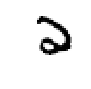

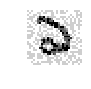

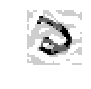

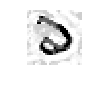

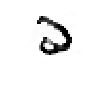

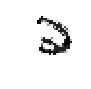

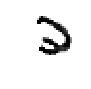

In [9]:
#Lets visualize one sample from each dataset
x_vis = np.random.choice(range(0,num_test_samples), 1)
visualize(reg_data[x_vis].reshape(28,28,1))
visualize(noisy_data[x_vis].reshape(28,28,1))
visualize(fgsm_data[x_vis].reshape(28,28,1))
visualize(bim_data[x_vis].reshape(28,28,1))
visualize(cw_data[x_vis].reshape(28,28,1))
visualize(p1_cw_data[x_vis].reshape(28,28,1))
visualize(p2_cw_data[x_vis].reshape(28,28,1))

In [10]:
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,28,28,1))
noisy_preds = model.model.predict(noisy_data.reshape(-1,28,28,1))
fgsm_preds = model.model.predict(fgsm_data.reshape(-1,28,28,1))
bim_preds = model.model.predict(bim_data.reshape(-1,28,28,1))
cw_preds = model.model.predict(cw_data.reshape(-1,28,28,1))
p1_cw_preds = model.model.predict(p1_cw_data.reshape(-1,28,28,1))
p2_cw_preds = model.model.predict(p2_cw_data.reshape(-1,28,28,1))

In [11]:
#Convert preds to labels
reg_labels = np.zeros(reg_preds.shape)
reg_labels[np.arange(num_test_samples),np.argmax(reg_preds, axis=1)] = 1

noisy_labels = np.zeros(noisy_preds.shape)
noisy_labels[np.arange(num_test_samples),np.argmax(noisy_preds, axis=1)] = 1

fgsm_labels = np.zeros(fgsm_preds.shape)
fgsm_labels[np.arange(num_test_samples),np.argmax(fgsm_preds, axis=1)] = 1

bim_labels = np.zeros(bim_preds.shape)
bim_labels[np.arange(num_test_samples),np.argmax(bim_preds, axis=1)] = 1

cw_labels = np.zeros(cw_preds.shape)
cw_labels[np.arange(num_test_samples),np.argmax(cw_preds, axis=1)] = 1

p1_cw_labels = np.zeros(p1_cw_preds.shape)
p1_cw_labels[np.arange(num_test_samples),np.argmax(p1_cw_preds, axis=1)] = 1

p2_cw_labels = np.zeros(p2_cw_preds.shape)
p2_cw_labels[np.arange(num_test_samples),np.argmax(p2_cw_preds, axis=1)] = 1

In [ ]:
#Check preds to ensure adversarial samples were generated correctly
print (np.argmax(reg_preds, axis=1))
print (np.argmax(noisy_preds, axis=1))
print (np.argmax(fgsm_preds, axis=1))
print (np.argmax(bim_preds, axis=1))
print (np.argmax(cw_preds, axis=1))
print (np.argmax(p1_cw_preds, axis=1))
print (np.argmax(p2_cw_preds, axis=1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 8 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 9 4 4 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
#Get gradients for all test points
grads_reg = model.get_gradients_wrt_params(reg_data, reg_labels)
grads_noisy = model.get_gradients_wrt_params(noisy_data, noisy_labels)
grads_fgsm = model.get_gradients_wrt_params(fgsm_data, fgsm_labels)
grads_bim = model.get_gradients_wrt_params(bim_data, bim_labels)
grads_cw = model.get_gradients_wrt_params(cw_data, cw_labels)
grads_p1_cw = model.get_gradients_wrt_params(p1_cw_data, p1_cw_labels)
grads_p2_cw = model.get_gradients_wrt_params(p2_cw_data, p2_cw_labels)

#Get gradients for training points 
grads_train = model.get_gradients_wrt_params(train_data, train_data_labels)

In [ ]:
grads_reg_nm = normalize(grads_reg)
grads_noisy_nm = normalize(grads_noisy)
grads_fgsm_nm = normalize(grads_fgsm)
grads_bim_nm = normalize(grads_bim)
grads_cw_nm = normalize(grads_cw)
grads_p1_cw_nm = normalize(grads_p1_cw)
grads_p2_cw_nm = normalize(grads_p2_cw)
grads_train_nm = normalize(grads_train)

In [ ]:
#Get norms 
grads_reg_norms = np.sqrt(np.dot(grads_reg, grads_reg.T)).diagonal()
grads_noisy_norms = np.sqrt(np.dot(grads_noisy, grads_noisy.T)).diagonal()
grads_bim_norms = np.sqrt(np.dot(grads_bim, grads_bim.T)).diagonal()
grads_fgsm_norms = np.sqrt(np.dot(grads_fgsm, grads_fgsm.T)).diagonal()
grads_cw_norms = np.sqrt(np.dot(grads_cw, grads_cw.T)).diagonal()
grads_p1_cw_norms = np.sqrt(np.dot(grads_p1_cw, grads_p1_cw.T)).diagonal()
grads_p2_cw_norms = np.sqrt(np.dot(grads_p2_cw, grads_p2_cw.T)).diagonal()

In [ ]:
#Get cosine similarity matrix
cos_sim_reg = np.dot(grads_reg_nm, grads_train_nm.T)
cos_sim_noisy = np.dot(grads_noisy_nm, grads_train_nm.T)
cos_sim_fgsm = np.dot(grads_fgsm_nm, grads_train_nm.T)
cos_sim_bim = np.dot(grads_bim_nm, grads_train_nm.T)
cos_sim_cw = np.dot(grads_cw_nm, grads_train_nm.T)
cos_sim_p1_cw = np.dot(grads_p1_cw_nm, grads_train_nm.T)
cos_sim_p2_cw = np.dot(grads_p2_cw_nm, grads_train_nm.T)

In [ ]:
#Separate Using Cos Sim

eta = 0.81

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_reg[i]) > eta:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > eta:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > eta:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim[i]) > eta:
        count+=1.0
        
print ('BIM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > eta:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))


count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p1_cw[i]) > eta:
        count+=1.0
        
print ('1 Phase CW:  %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p2_cw[i]) > eta:
        count+=1.0
        
print ('2 Phase CW:  %.4f' % ( count/num_test_samples))

In [ ]:
#Separate using just norm
gamma = 0.15

count = 0.0
for i in range(num_test_samples):
    if grads_reg_norms[i] < gamma:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if grads_noisy_norms[i] < gamma:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_fgsm_norms[i] < gamma:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_norms[i] < gamma:
        count+=1.0
        
print ('BIM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_cw_norms[i] < gamma:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p1_cw_norms[i] < gamma:
        count+=1.0
    
print ('1 Phase CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p2_cw_norms[i] < gamma:
        count+=1.0
    
print ('2 Phase CW: %.4f' % ( count/num_test_samples))



In [ ]:
#Use both cos and norm

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_reg[i]) > eta and grads_reg_norms[i] < gamma:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > eta and grads_noisy_norms[i] < gamma:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > eta and grads_fgsm_norms[i] < gamma:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim[i]) > eta and grads_bim_norms[i] < gamma:
        count+=1.0
        
print ('BIM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > eta and grads_cw_norms[i] < gamma:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p1_cw[i]) > eta and grads_p1_cw_norms[i] < gamma:
        count+=1.0
    
print ('1 Phase CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p2_cw[i]) > eta and grads_p2_cw_norms[i] < gamma:
        count+=1.0
    
print ('2 Phase CW: %.4f' % ( count/num_test_samples))